<a href="https://colab.research.google.com/github/Zendellll/Road2_AI_Course/blob/main/AICourse_task7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!mkdir /content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds
!mkdir /content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/images
!mkdir /content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/labels

!cp /content/drive/MyDrive/drone_data/*.jpg /content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/images
!cp /content/drive/MyDrive/drone_data/*.txt /content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/labels
!cp /content/drive/MyDrive/bird_data/*.jpg /content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/images
!cp /content/drive/MyDrive/bird_data/*.txt /content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/labels

In [2]:
import torch
import torchvision.transforms as transforms
import random
import os
import cv2
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from google.colab.patches import cv2_imshow

def augment_image(image):
    # Convert image to PyTorch tensor
    image_tensor = transforms.ToTensor()(image)

    # Randomly choose an augmentation
    augmentation_type = random.choice(['flip', 'color_jitter', 'rotation'])

    # Apply random flip
    if augmentation_type == 'flip':
        image_tensor = transforms.RandomHorizontalFlip()(image_tensor)

    # Apply random color jitter
    elif augmentation_type == 'color_jitter':
        image_tensor = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2)(image_tensor)

    # Apply random rotation
    elif augmentation_type == 'rotation':
        angle = random.uniform(-15, 15)
        image_tensor = transforms.functional.rotate(image_tensor, angle)

    # Convert back to PIL Image
    augmented_image = transforms.ToPILImage()(image_tensor)

    return augmented_image

# Function to convert YOLO coordinates to bounding box coordinates
def yolo_to_bbox(image_shape, class_index, x_center, y_center, width, height):
    img_height, img_width, _ = image_shape

    x_min = int((x_center - width / 2) * img_width)
    y_min = int((y_center - height / 2) * img_height)
    x_max = int((x_center + width / 2) * img_width)
    y_max = int((y_center + height / 2) * img_height)

    return x_min, y_min, x_max, y_max

# Function to randomly crop a 32x32 section from the image
def random_crop(image, crop_size=(32, 32)):
    img_height, img_width, _ = image.shape

    # Randomly choose the top-left corner of the crop
    y_start = np.random.randint(0, img_height - crop_size[0] + 1)
    x_start = np.random.randint(0, img_width - crop_size[1] + 1)

    # Crop the image
    cropped_img = image[y_start:y_start + crop_size[0], x_start:x_start + crop_size[1]]

    return cropped_img

# Pre-process data
## Prompt:
Today we are doing some AI coding on Google Colab, using Python, Keras, TensorFlow.

I have a dataset containing images of either birds or drones. All images are found in path - '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/images', and all labels are found in - '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/labels'. In the images dir, there are images of both birds and drones. Each image has a corresponding label file, which has the same name, and ends with .txt instead of .jpg.
All labels are in the YOLO annotation format. the class IDs are 0 for drone and 1 for bird.

I need you to go over all images in the image path I provided. For each image, start by cropping a random 32*32 area. Run the cropped image through the augmentation function to get an augmented image. Then, save that image into the path 'content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/other/images', and save a corresponding label file at '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/other/labels'. For the random crop image, the label should be 2 (the .txt file should have only '2' in it).
Then, using the coordinates from the label file, extract the object location and crop around the object. Take the cropped object and resize it to 32*32. Run it through the augmentation function. Once done, I need you to save the image. The location is based on the label file.
If the first number in the label file is '0', it means the object is a drone, in which case we will save the image at '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/drone/images' and save a corresponding label at '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/drone/labels' - the label file containing only a '0'.
Else (meaning the first number in the label file is '1'), the object is a bird. Then we will save it in '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/bird/images', and save a corresponding label file at '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/bird/labels' - with the label file containing only a '1'.

In [ ]:
# Path definitions
image_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/images'
label_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/labels'

# Output paths
other_image_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/other/images'
other_label_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/other/labels'

drone_image_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/drone/images'
drone_label_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/drone/labels'

bird_image_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/bird/images'
bird_label_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/bird/labels'

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Process each image
for filename in tqdm(os.listdir(image_path), desc="labeling files..."):
    if filename.endswith(".jpg"):
        # Load the image
        img = cv2.imread(os.path.join(image_path, filename))

        # Load corresponding label file
        label_filename = os.path.splitext(filename)[0] + '.txt'
        label_file_path = os.path.join(label_path, label_filename)

        with open(label_file_path, 'r') as label_file:
            class_id, x_center, y_center, width, height = map(float, label_file.readline().split())

            # Random crop
            random_cropped_img = random_crop(img)

            # Augment the random cropped image
            augmented_random_cropped_img = augment_image(random_cropped_img)

            # Save the augmented random cropped image
            cv2.imwrite(os.path.join(other_image_path, filename), cv2.cvtColor(np.array(augmented_random_cropped_img), cv2.COLOR_RGB2BGR))

            # Save the label file for the other class
            with open(os.path.join(other_label_path, label_filename), 'w') as other_label_file:
                other_label_file.write('2')

            # Extract object location
            x_min, y_min, x_max, y_max = yolo_to_bbox(img.shape, class_id, x_center, y_center, width, height)

            # Crop around the object
            cropped_object_img = img[y_min:y_max, x_min:x_max]

            # Resize to 32x32
            resized_object_img = cv2.resize(cropped_object_img, (32, 32))

            # Augment the resized object image
            augmented_resized_object_img = augment_image(resized_object_img)

            # Save the augmented resized object image
            if class_id == 0:
                cv2.imwrite(os.path.join(drone_image_path, filename), cv2.cvtColor(np.array(augmented_resized_object_img), cv2.COLOR_RGB2BGR))
                with open(os.path.join(drone_label_path, label_filename), 'w') as drone_label_file:
                    drone_label_file.write(f'{int(class_id)}')
                    print(f'{int(class_id)}')
            elif class_id == 1:
                cv2.imwrite(os.path.join(bird_image_path, filename), cv2.cvtColor(np.array(augmented_resized_object_img), cv2.COLOR_RGB2BGR))
                with open(os.path.join(bird_label_path, label_filename), 'w') as bird_label_file:
                    bird_label_file.write(f'{int(class_id)}')
                    print(f'{int(class_id)}')

labeling files...:   0%|          | 1/7871 [00:00<20:29,  6.40it/s]

1


labeling files...:   0%|          | 2/7871 [00:00<25:10,  5.21it/s]

1
1

labeling files...:   0%|          | 3/7871 [00:00<25:59,  5.05it/s]

labeling files...:   0%|          | 5/7871 [00:00<26:27,  4.95it/s]

1
1


labeling files...:   0%|          | 7/7871 [00:01<24:17,  5.39it/s]

1
1


labeling files...:   0%|          | 9/7871 [00:01<23:58,  5.47it/s]

1
1


labeling files...:   0%|          | 11/7871 [00:02<24:01,  5.45it/s]

1
1


labeling files...:   0%|          | 12/7871 [00:02<24:44,  5.30it/s]

1
1


labeling files...:   0%|          | 15/7871 [00:02<23:39,  5.54it/s]

1
1


labeling files...:   0%|          | 17/7871 [00:03<23:11,  5.64it/s]

1
1


labeling files...:   0%|          | 19/7871 [00:03<22:41,  5.77it/s]

1
1


labeling files...:   0%|          | 21/7871 [00:03<23:54,  5.47it/s]

1
1


labeling files...:   0%|          | 23/7871 [00:04<22:46,  5.74it/s]

1
1


labeling files...:   0%|          | 25/7871 [00:04<23:18,  5.61it/s]

1
1


labeling files...:   0%|          | 27/7871 [00:04<22:47,  5.74it/s]

1
1


labeling files...:   0%|          | 29/7871 [00:05<23:19,  5.60it/s]

1
1


labeling files...:   0%|          | 31/7871 [00:05<22:11,  5.89it/s]

1
1


labeling files...:   0%|          | 33/7871 [00:05<22:38,  5.77it/s]

1
1


labeling files...:   0%|          | 35/7871 [00:06<18:26,  7.08it/s]

1
1


labeling files...:   0%|          | 37/7871 [00:06<17:42,  7.37it/s]

1
1


labeling files...:   0%|          | 39/7871 [00:06<16:01,  8.14it/s]

1
1


labeling files...:   1%|          | 41/7871 [00:06<16:18,  8.00it/s]

1
1


labeling files...:   1%|          | 43/7871 [00:07<15:18,  8.52it/s]

1
1


labeling files...:   1%|          | 45/7871 [00:07<15:43,  8.29it/s]

1
1


labeling files...:   1%|          | 47/7871 [00:07<14:58,  8.70it/s]

1
1


labeling files...:   1%|          | 49/7871 [00:07<15:44,  8.29it/s]

1
1


labeling files...:   1%|          | 51/7871 [00:08<15:14,  8.55it/s]

1
1


labeling files...:   1%|          | 53/7871 [00:08<15:30,  8.40it/s]

1
1


labeling files...:   1%|          | 55/7871 [00:08<14:56,  8.72it/s]

1
1


labeling files...:   1%|          | 57/7871 [00:08<15:34,  8.37it/s]

1
1


labeling files...:   1%|          | 59/7871 [00:08<15:30,  8.40it/s]

1
1


labeling files...:   1%|          | 61/7871 [00:09<15:43,  8.28it/s]

1
1


labeling files...:   1%|          | 63/7871 [00:09<15:14,  8.54it/s]

1
1


labeling files...:   1%|          | 65/7871 [00:09<15:40,  8.30it/s]

1
1


labeling files...:   1%|          | 67/7871 [00:09<14:43,  8.84it/s]

1
1


labeling files...:   1%|          | 69/7871 [00:10<15:13,  8.54it/s]

1
1


labeling files...:   1%|          | 71/7871 [00:10<15:14,  8.53it/s]

1
1


labeling files...:   1%|          | 73/7871 [00:10<15:19,  8.48it/s]

1
1


labeling files...:   1%|          | 75/7871 [00:10<14:47,  8.78it/s]

1
1


labeling files...:   1%|          | 77/7871 [00:11<15:53,  8.17it/s]

1
1


labeling files...:   1%|          | 78/7871 [00:11<15:49,  8.21it/s]

1
1


labeling files...:   1%|          | 80/7871 [02:05<68:00:43, 31.43s/it]

1


labeling files...:   1%|          | 82/7871 [02:06<33:39:36, 15.56s/it]

1
1


labeling files...:   1%|          | 84/7871 [02:06<16:37:51,  7.69s/it]

1
1


labeling files...:   1%|          | 86/7871 [02:06<8:17:10,  3.83s/it] 

1
1


labeling files...:   1%|          | 88/7871 [02:07<4:11:13,  1.94s/it]

1
1


labeling files...:   1%|          | 90/7871 [02:07<2:11:41,  1.02s/it]

1
1


labeling files...:   1%|          | 92/7871 [02:07<1:12:36,  1.79it/s]

1
1


labeling files...:   1%|          | 94/7871 [02:07<44:03,  2.94it/s]

1
1


labeling files...:   1%|          | 96/7871 [02:08<29:08,  4.45it/s]

1
1


labeling files...:   1%|          | 98/7871 [02:08<22:25,  5.78it/s]

1
1


labeling files...:   1%|▏         | 100/7871 [02:08<19:21,  6.69it/s]

1
1


labeling files...:   1%|▏         | 102/7871 [02:08<16:58,  7.63it/s]

1
1


labeling files...:   1%|▏         | 104/7871 [02:09<16:03,  8.06it/s]

1
1


labeling files...:   1%|▏         | 106/7871 [02:09<16:32,  7.82it/s]

1
1


labeling files...:   1%|▏         | 108/7871 [02:09<15:39,  8.26it/s]

1
1


labeling files...:   1%|▏         | 110/7871 [02:09<16:09,  8.01it/s]

1
1


labeling files...:   1%|▏         | 112/7871 [02:10<15:47,  8.19it/s]

1
1


labeling files...:   1%|▏         | 114/7871 [02:10<16:26,  7.87it/s]

1
1


labeling files...:   1%|▏         | 116/7871 [02:10<15:54,  8.12it/s]

1
1


labeling files...:   1%|▏         | 118/7871 [02:10<15:51,  8.15it/s]

1
1


labeling files...:   2%|▏         | 120/7871 [02:11<15:11,  8.51it/s]

1
1


labeling files...:   2%|▏         | 122/7871 [02:11<15:53,  8.13it/s]

1
1


labeling files...:   2%|▏         | 124/7871 [02:11<15:27,  8.35it/s]

1
1


labeling files...:   2%|▏         | 126/7871 [02:11<15:52,  8.13it/s]

1
1


labeling files...:   2%|▏         | 128/7871 [02:12<15:21,  8.40it/s]

1
1


labeling files...:   2%|▏         | 130/7871 [02:12<15:18,  8.43it/s]

1
1


labeling files...:   2%|▏         | 132/7871 [02:12<15:53,  8.12it/s]

1
1


labeling files...:   2%|▏         | 134/7871 [02:12<15:11,  8.49it/s]

1
1


labeling files...:   2%|▏         | 136/7871 [02:12<14:45,  8.74it/s]

1
1


labeling files...:   2%|▏         | 138/7871 [02:13<18:04,  7.13it/s]

1
1


labeling files...:   2%|▏         | 140/7871 [02:13<20:24,  6.31it/s]

1
1


labeling files...:   2%|▏         | 142/7871 [02:14<22:09,  5.81it/s]

1
1


labeling files...:   2%|▏         | 144/7871 [02:14<22:35,  5.70it/s]

1
1


labeling files...:   2%|▏         | 146/7871 [02:14<23:04,  5.58it/s]

1
1


labeling files...:   2%|▏         | 148/7871 [02:15<22:45,  5.66it/s]

1
1


labeling files...:   2%|▏         | 150/7871 [02:15<23:24,  5.50it/s]

1
1


labeling files...:   2%|▏         | 151/7871 [02:15<25:09,  5.11it/s]

1


labeling files...:   2%|▏         | 152/7871 [02:15<26:16,  4.90it/s]

1


labeling files...:   2%|▏         | 153/7871 [02:16<26:49,  4.80it/s]

1
1

labeling files...:   2%|▏         | 155/7871 [02:16<25:22,  5.07it/s]


1


labeling files...:   2%|▏         | 156/7871 [02:16<25:30,  5.04it/s]

1


labeling files...:   2%|▏         | 158/7871 [02:17<26:15,  4.90it/s]

1
1


labeling files...:   2%|▏         | 160/7871 [02:17<24:59,  5.14it/s]

1
1


labeling files...:   2%|▏         | 162/7871 [02:17<25:18,  5.08it/s]

1
1


labeling files...:   2%|▏         | 164/7871 [02:18<23:58,  5.36it/s]

1
1


labeling files...:   2%|▏         | 166/7871 [02:18<20:08,  6.38it/s]

1
1


labeling files...:   2%|▏         | 168/7871 [02:18<18:31,  6.93it/s]

1
1


labeling files...:   2%|▏         | 170/7871 [02:19<18:44,  6.85it/s]

1
1


labeling files...:   2%|▏         | 172/7871 [02:19<17:39,  7.26it/s]

1
1


labeling files...:   2%|▏         | 174/7871 [02:19<17:00,  7.54it/s]

1
1


labeling files...:   2%|▏         | 176/7871 [02:19<17:11,  7.46it/s]

1
1


labeling files...:   2%|▏         | 178/7871 [02:20<16:36,  7.72it/s]

1
1


labeling files...:   2%|▏         | 180/7871 [02:20<17:09,  7.47it/s]

1
1


labeling files...:   2%|▏         | 182/7871 [02:20<16:44,  7.66it/s]

1
1


labeling files...:   2%|▏         | 184/7871 [02:20<17:18,  7.40it/s]

1
1


labeling files...:   2%|▏         | 186/7871 [02:21<16:32,  7.75it/s]

1
1


labeling files...:   2%|▏         | 188/7871 [02:21<17:30,  7.31it/s]

1
1


labeling files...:   2%|▏         | 190/7871 [02:21<17:16,  7.41it/s]

1
1


labeling files...:   2%|▏         | 192/7871 [02:22<17:05,  7.49it/s]

1
1


labeling files...:   2%|▏         | 194/7871 [02:22<16:27,  7.78it/s]

1
1


labeling files...:   2%|▏         | 196/7871 [02:22<16:40,  7.67it/s]

1
1


labeling files...:   3%|▎         | 198/7871 [02:22<16:46,  7.62it/s]

1
1


labeling files...:   3%|▎         | 200/7871 [02:23<17:18,  7.39it/s]

1
1


labeling files...:   3%|▎         | 202/7871 [02:23<16:40,  7.66it/s]

1
1


labeling files...:   3%|▎         | 204/7871 [02:23<16:13,  7.88it/s]

1
1


labeling files...:   3%|▎         | 206/7871 [02:23<17:14,  7.41it/s]

1
1


labeling files...:   3%|▎         | 208/7871 [02:24<17:05,  7.48it/s]

1
1


labeling files...:   3%|▎         | 210/7871 [02:24<17:28,  7.31it/s]

1
1


labeling files...:   3%|▎         | 212/7871 [02:24<17:01,  7.50it/s]

1
1


labeling files...:   3%|▎         | 214/7871 [02:24<17:00,  7.51it/s]

1
1


labeling files...:   3%|▎         | 216/7871 [02:25<16:30,  7.73it/s]

1
1


labeling files...:   3%|▎         | 218/7871 [02:25<17:04,  7.47it/s]

1
1


labeling files...:   3%|▎         | 220/7871 [02:25<16:38,  7.66it/s]

1
1


labeling files...:   3%|▎         | 222/7871 [02:26<17:01,  7.49it/s]

1
1


labeling files...:   3%|▎         | 224/7871 [02:26<16:41,  7.64it/s]

1
1


labeling files...:   3%|▎         | 226/7871 [02:26<16:54,  7.53it/s]

1
1


labeling files...:   3%|▎         | 228/7871 [02:26<16:14,  7.84it/s]

1
1


labeling files...:   3%|▎         | 230/7871 [02:27<17:06,  7.44it/s]

1
1


labeling files...:   3%|▎         | 232/7871 [02:27<16:39,  7.65it/s]

1
1


labeling files...:   3%|▎         | 234/7871 [02:27<16:54,  7.53it/s]

1
1


labeling files...:   3%|▎         | 236/7871 [02:27<16:28,  7.72it/s]

1
1


labeling files...:   3%|▎         | 238/7871 [02:28<17:25,  7.30it/s]

1
1


labeling files...:   3%|▎         | 239/7871 [02:28<17:00,  7.48it/s]

1


labeling files...:   3%|▎         | 240/7871 [02:28<20:00,  6.36it/s]

1
1


labeling files...:   3%|▎         | 243/7871 [02:29<23:04,  5.51it/s]

1
1


labeling files...:   3%|▎         | 245/7871 [02:29<24:07,  5.27it/s]

1
1


labeling files...:   3%|▎         | 247/7871 [02:29<24:29,  5.19it/s]

1
1


labeling files...:   3%|▎         | 249/7871 [02:30<24:39,  5.15it/s]

1
1


labeling files...:   3%|▎         | 251/7871 [02:30<24:05,  5.27it/s]

1
1


labeling files...:   3%|▎         | 252/7871 [02:30<25:30,  4.98it/s]

1


labeling files...:   3%|▎         | 253/7871 [02:31<25:49,  4.92it/s]

1


labeling files...:   3%|▎         | 255/7871 [02:31<25:36,  4.96it/s]

1
1


labeling files...:   3%|▎         | 256/7871 [02:31<25:34,  4.96it/s]

1


labeling files...:   3%|▎         | 258/7871 [02:32<25:31,  4.97it/s]

1
1


labeling files...:   3%|▎         | 259/7871 [02:32<24:38,  5.15it/s]

1


labeling files...:   3%|▎         | 261/7871 [02:32<24:54,  5.09it/s]

1
1


labeling files...:   3%|▎         | 262/7871 [02:32<24:28,  5.18it/s]

1


labeling files...:   3%|▎         | 263/7871 [02:33<24:47,  5.12it/s]

1


labeling files...:   3%|▎         | 265/7871 [02:33<24:41,  5.13it/s]

1
1


labeling files...:   3%|▎         | 267/7871 [02:33<21:11,  5.98it/s]

1
1


labeling files...:   3%|▎         | 269/7871 [02:33<18:51,  6.72it/s]

1
1


labeling files...:   3%|▎         | 271/7871 [02:34<17:52,  7.09it/s]

1
1


labeling files...:   3%|▎         | 273/7871 [02:34<17:31,  7.22it/s]

1
1


labeling files...:   3%|▎         | 275/7871 [02:34<16:48,  7.53it/s]

1
1


labeling files...:   4%|▎         | 277/7871 [02:35<16:18,  7.76it/s]

1
1


labeling files...:   4%|▎         | 279/7871 [02:35<17:07,  7.39it/s]

1
1


labeling files...:   4%|▎         | 281/7871 [02:35<17:19,  7.30it/s]

1
1


labeling files...:   4%|▎         | 283/7871 [02:35<17:00,  7.44it/s]

1
1


labeling files...:   4%|▎         | 285/7871 [02:36<16:40,  7.58it/s]

1
1


labeling files...:   4%|▎         | 287/7871 [02:36<17:10,  7.36it/s]

1
1


labeling files...:   4%|▎         | 289/7871 [02:36<16:32,  7.64it/s]

1
1


labeling files...:   4%|▎         | 291/7871 [02:36<17:01,  7.42it/s]

1
1


labeling files...:   4%|▎         | 293/7871 [02:37<16:34,  7.62it/s]

1
1


labeling files...:   4%|▎         | 295/7871 [02:37<16:28,  7.66it/s]

1
1


labeling files...:   4%|▍         | 297/7871 [02:37<17:14,  7.32it/s]

1
1


labeling files...:   4%|▍         | 299/7871 [02:37<16:43,  7.55it/s]

1
1


labeling files...:   4%|▍         | 301/7871 [02:38<16:10,  7.80it/s]

1
1


labeling files...:   4%|▍         | 303/7871 [02:38<17:35,  7.17it/s]

1
1


labeling files...:   4%|▍         | 305/7871 [02:38<16:24,  7.69it/s]

1
1


labeling files...:   4%|▍         | 307/7871 [02:39<16:32,  7.62it/s]

1
1


labeling files...:   4%|▍         | 309/7871 [02:39<16:22,  7.70it/s]

1
1


labeling files...:   4%|▍         | 311/7871 [02:39<16:46,  7.51it/s]

1
1


labeling files...:   4%|▍         | 313/7871 [02:39<16:01,  7.86it/s]

1
1


labeling files...:   4%|▍         | 315/7871 [02:40<16:18,  7.72it/s]

1
1


labeling files...:   4%|▍         | 317/7871 [02:40<15:29,  8.12it/s]

1
1


labeling files...:   4%|▍         | 319/7871 [02:40<16:09,  7.79it/s]

1
1


labeling files...:   4%|▍         | 321/7871 [02:40<15:20,  8.21it/s]

1
1


labeling files...:   4%|▍         | 323/7871 [02:41<15:22,  8.19it/s]

1
1


labeling files...:   4%|▍         | 325/7871 [02:41<15:28,  8.13it/s]

1
1


labeling files...:   4%|▍         | 327/7871 [02:41<15:29,  8.12it/s]

1
1


labeling files...:   4%|▍         | 329/7871 [02:41<15:08,  8.30it/s]

1
1


labeling files...:   4%|▍         | 331/7871 [02:42<15:29,  8.11it/s]

1
1


labeling files...:   4%|▍         | 333/7871 [02:42<15:40,  8.02it/s]

1
1


labeling files...:   4%|▍         | 335/7871 [02:42<16:00,  7.85it/s]

1
1


labeling files...:   4%|▍         | 337/7871 [02:42<15:22,  8.17it/s]

1
1


labeling files...:   4%|▍         | 339/7871 [02:42<14:32,  8.63it/s]

1
1


labeling files...:   4%|▍         | 341/7871 [02:43<15:23,  8.16it/s]

1
1


labeling files...:   4%|▍         | 343/7871 [02:43<17:47,  7.05it/s]

1
1


labeling files...:   4%|▍         | 345/7871 [02:43<20:13,  6.20it/s]

1
1


labeling files...:   4%|▍         | 347/7871 [02:44<21:52,  5.73it/s]

1
1


labeling files...:   4%|▍         | 349/7871 [02:44<22:47,  5.50it/s]

1
1


labeling files...:   4%|▍         | 351/7871 [02:44<21:45,  5.76it/s]

1
1


labeling files...:   4%|▍         | 353/7871 [02:45<21:54,  5.72it/s]

1
1


labeling files...:   5%|▍         | 355/7871 [02:45<21:43,  5.77it/s]

1
1


labeling files...:   5%|▍         | 357/7871 [02:46<22:01,  5.69it/s]

1
1


labeling files...:   5%|▍         | 359/7871 [02:46<23:00,  5.44it/s]

1
1


labeling files...:   5%|▍         | 361/7871 [02:46<22:48,  5.49it/s]

1
1


labeling files...:   5%|▍         | 363/7871 [02:47<22:58,  5.45it/s]

1
1


labeling files...:   5%|▍         | 365/7871 [02:47<23:07,  5.41it/s]

1
1


labeling files...:   5%|▍         | 367/7871 [02:47<22:53,  5.46it/s]

1
1


labeling files...:   5%|▍         | 369/7871 [02:48<22:16,  5.61it/s]

1
1


labeling files...:   5%|▍         | 371/7871 [02:48<22:09,  5.64it/s]

1
1


labeling files...:   5%|▍         | 373/7871 [02:48<18:58,  6.59it/s]

1
1


labeling files...:   5%|▍         | 375/7871 [02:49<16:50,  7.41it/s]

1
1


labeling files...:   5%|▍         | 377/7871 [02:49<15:22,  8.12it/s]

1
1


labeling files...:   5%|▍         | 379/7871 [02:49<15:10,  8.23it/s]

1
1


labeling files...:   5%|▍         | 381/7871 [02:49<15:03,  8.29it/s]

1
1


labeling files...:   5%|▍         | 383/7871 [02:50<15:27,  8.07it/s]

1
1


labeling files...:   5%|▍         | 385/7871 [02:50<15:03,  8.29it/s]

1
1


labeling files...:   5%|▍         | 387/7871 [02:50<14:50,  8.40it/s]

1
1


labeling files...:   5%|▍         | 389/7871 [02:50<14:17,  8.72it/s]

1
1


labeling files...:   5%|▍         | 391/7871 [02:50<14:28,  8.61it/s]

1
1


labeling files...:   5%|▍         | 393/7871 [02:51<14:30,  8.59it/s]

1
1


labeling files...:   5%|▌         | 395/7871 [02:51<14:50,  8.39it/s]

1
1


labeling files...:   5%|▌         | 397/7871 [02:51<14:29,  8.60it/s]

1
1


labeling files...:   5%|▌         | 399/7871 [02:51<15:01,  8.29it/s]

1
1


labeling files...:   5%|▌         | 401/7871 [02:52<14:23,  8.65it/s]

1
1


labeling files...:   5%|▌         | 403/7871 [02:52<14:53,  8.36it/s]

1
1


labeling files...:   5%|▌         | 404/7871 [02:52<14:45,  8.44it/s]

1


labeling files...:   5%|▌         | 405/7871 [02:53<50:46,  2.45it/s]

1


labeling files...:   5%|▌         | 406/7871 [02:54<1:11:50,  1.73it/s]

1


labeling files...:   5%|▌         | 407/7871 [02:55<1:29:03,  1.40it/s]

1


labeling files...:   5%|▌         | 408/7871 [02:56<1:40:29,  1.24it/s]

1


labeling files...:   5%|▌         | 409/7871 [02:57<1:51:36,  1.11it/s]

1


labeling files...:   5%|▌         | 410/7871 [02:58<2:00:47,  1.03it/s]

1


labeling files...:   5%|▌         | 411/7871 [03:00<2:11:35,  1.06s/it]

1


labeling files...:   5%|▌         | 412/7871 [03:01<2:13:55,  1.08s/it]

1


labeling files...:   5%|▌         | 413/7871 [03:02<2:16:11,  1.10s/it]

1


labeling files...:   5%|▌         | 414/7871 [03:03<2:15:30,  1.09s/it]

1


labeling files...:   5%|▌         | 415/7871 [03:04<2:12:04,  1.06s/it]

1


labeling files...:   5%|▌         | 416/7871 [03:05<2:12:26,  1.07s/it]

1


labeling files...:   5%|▌         | 417/7871 [03:06<2:15:14,  1.09s/it]

1


labeling files...:   5%|▌         | 418/7871 [03:07<2:19:51,  1.13s/it]

1


labeling files...:   5%|▌         | 419/7871 [03:08<2:16:19,  1.10s/it]

1


labeling files...:   5%|▌         | 420/7871 [03:10<2:14:20,  1.08s/it]

1


labeling files...:   5%|▌         | 421/7871 [03:11<2:12:12,  1.06s/it]

1


labeling files...:   5%|▌         | 422/7871 [03:12<2:13:26,  1.07s/it]

1


labeling files...:   5%|▌         | 423/7871 [03:13<2:15:14,  1.09s/it]

1


labeling files...:   5%|▌         | 424/7871 [03:14<2:16:21,  1.10s/it]

1


labeling files...:   5%|▌         | 425/7871 [03:15<2:12:50,  1.07s/it]

1


labeling files...:   5%|▌         | 426/7871 [03:16<2:18:31,  1.12s/it]

1


labeling files...:   5%|▌         | 427/7871 [03:17<2:22:47,  1.15s/it]

1


labeling files...:   5%|▌         | 428/7871 [03:18<2:22:50,  1.15s/it]

1


labeling files...:   5%|▌         | 429/7871 [03:20<2:18:32,  1.12s/it]

1


labeling files...:   5%|▌         | 430/7871 [03:21<2:22:18,  1.15s/it]

1


labeling files...:   5%|▌         | 431/7871 [03:22<2:20:37,  1.13s/it]

1


labeling files...:   5%|▌         | 432/7871 [03:23<2:21:44,  1.14s/it]

1


labeling files...:   6%|▌         | 433/7871 [03:24<2:21:57,  1.15s/it]

1


labeling files...:   6%|▌         | 434/7871 [03:25<2:11:56,  1.06s/it]

1


labeling files...:   6%|▌         | 435/7871 [03:26<2:09:36,  1.05s/it]

1


labeling files...:   6%|▌         | 436/7871 [03:27<2:11:13,  1.06s/it]

1


labeling files...:   6%|▌         | 437/7871 [03:28<2:18:05,  1.11s/it]

1


labeling files...:   6%|▌         | 438/7871 [03:29<2:17:46,  1.11s/it]

1


labeling files...:   6%|▌         | 439/7871 [03:31<2:15:07,  1.09s/it]

1


labeling files...:   6%|▌         | 440/7871 [03:32<2:12:18,  1.07s/it]

1


labeling files...:   6%|▌         | 441/7871 [03:33<2:20:21,  1.13s/it]

1


labeling files...:   6%|▌         | 442/7871 [03:34<2:10:33,  1.05s/it]

1


labeling files...:   6%|▌         | 443/7871 [03:35<2:14:13,  1.08s/it]

1


labeling files...:   6%|▌         | 444/7871 [03:36<2:09:36,  1.05s/it]

1


labeling files...:   6%|▌         | 445/7871 [03:37<2:18:17,  1.12s/it]

1


labeling files...:   6%|▌         | 446/7871 [03:38<2:19:02,  1.12s/it]

1


labeling files...:   6%|▌         | 447/7871 [03:39<2:23:43,  1.16s/it]

1


labeling files...:   6%|▌         | 448/7871 [03:41<2:23:54,  1.16s/it]

1


labeling files...:   6%|▌         | 449/7871 [03:42<2:15:10,  1.09s/it]

1


labeling files...:   6%|▌         | 450/7871 [03:43<2:19:12,  1.13s/it]

1


labeling files...:   6%|▌         | 451/7871 [03:44<2:19:15,  1.13s/it]

1


labeling files...:   6%|▌         | 452/7871 [03:45<2:15:24,  1.10s/it]

1


labeling files...:   6%|▌         | 453/7871 [03:46<2:14:50,  1.09s/it]

1


labeling files...:   6%|▌         | 454/7871 [03:47<2:15:28,  1.10s/it]

1


labeling files...:   6%|▌         | 455/7871 [03:48<2:15:38,  1.10s/it]

1


labeling files...:   6%|▌         | 456/7871 [03:49<2:10:36,  1.06s/it]

1


labeling files...:   6%|▌         | 457/7871 [03:50<2:09:03,  1.04s/it]

1


labeling files...:   6%|▌         | 458/7871 [03:51<2:14:17,  1.09s/it]

1


labeling files...:   6%|▌         | 459/7871 [03:53<2:24:47,  1.17s/it]

1


labeling files...:   6%|▌         | 460/7871 [03:54<2:26:42,  1.19s/it]

1


labeling files...:   6%|▌         | 461/7871 [03:55<2:27:40,  1.20s/it]

1


labeling files...:   6%|▌         | 462/7871 [03:56<2:25:07,  1.18s/it]

1


labeling files...:   6%|▌         | 463/7871 [03:57<2:17:53,  1.12s/it]

1


labeling files...:   6%|▌         | 464/7871 [03:58<2:15:02,  1.09s/it]

1


labeling files...:   6%|▌         | 465/7871 [03:59<2:14:09,  1.09s/it]

1


labeling files...:   6%|▌         | 466/7871 [04:00<2:09:08,  1.05s/it]

1


labeling files...:   6%|▌         | 467/7871 [04:01<2:11:07,  1.06s/it]

1


labeling files...:   6%|▌         | 468/7871 [04:03<2:14:51,  1.09s/it]

1


labeling files...:   6%|▌         | 469/7871 [04:04<2:19:32,  1.13s/it]

1


labeling files...:   6%|▌         | 470/7871 [04:05<2:16:54,  1.11s/it]

1


labeling files...:   6%|▌         | 471/7871 [04:06<2:15:23,  1.10s/it]

1


labeling files...:   6%|▌         | 472/7871 [04:07<2:19:03,  1.13s/it]

1


labeling files...:   6%|▌         | 473/7871 [04:08<2:19:40,  1.13s/it]

1


labeling files...:   6%|▌         | 474/7871 [04:09<2:19:54,  1.13s/it]

1


labeling files...:   6%|▌         | 475/7871 [04:11<2:21:43,  1.15s/it]

1


labeling files...:   6%|▌         | 476/7871 [04:12<2:18:28,  1.12s/it]

1


labeling files...:   6%|▌         | 477/7871 [04:13<2:12:48,  1.08s/it]

1


labeling files...:   6%|▌         | 478/7871 [04:14<2:10:37,  1.06s/it]

1


labeling files...:   6%|▌         | 479/7871 [04:15<2:20:14,  1.14s/it]

1


labeling files...:   6%|▌         | 480/7871 [04:16<2:14:53,  1.10s/it]

1


labeling files...:   6%|▌         | 481/7871 [04:17<2:14:13,  1.09s/it]

1


labeling files...:   6%|▌         | 482/7871 [04:18<2:12:08,  1.07s/it]

1


labeling files...:   6%|▌         | 483/7871 [04:19<2:06:33,  1.03s/it]

1


labeling files...:   6%|▌         | 484/7871 [04:20<2:11:23,  1.07s/it]

1


labeling files...:   6%|▌         | 485/7871 [04:21<2:12:06,  1.07s/it]

1


labeling files...:   6%|▌         | 486/7871 [04:23<2:20:47,  1.14s/it]

1


labeling files...:   6%|▌         | 487/7871 [04:24<2:16:10,  1.11s/it]

1


labeling files...:   6%|▌         | 488/7871 [04:25<2:14:38,  1.09s/it]

1


labeling files...:   6%|▌         | 489/7871 [04:26<2:12:35,  1.08s/it]

1


labeling files...:   6%|▌         | 490/7871 [04:27<2:11:21,  1.07s/it]

1


labeling files...:   6%|▌         | 491/7871 [04:28<2:07:07,  1.03s/it]

1


labeling files...:   6%|▋         | 492/7871 [04:29<2:04:46,  1.01s/it]

1


labeling files...:   6%|▋         | 493/7871 [04:30<2:14:45,  1.10s/it]

1


labeling files...:   6%|▋         | 494/7871 [04:31<2:09:32,  1.05s/it]

1


labeling files...:   6%|▋         | 495/7871 [04:32<2:18:24,  1.13s/it]

1


labeling files...:   6%|▋         | 496/7871 [04:33<2:13:17,  1.08s/it]

1


labeling files...:   6%|▋         | 497/7871 [04:34<2:14:28,  1.09s/it]

1


labeling files...:   6%|▋         | 498/7871 [04:36<2:21:19,  1.15s/it]

1


labeling files...:   6%|▋         | 499/7871 [04:37<2:20:25,  1.14s/it]

1


labeling files...:   6%|▋         | 500/7871 [04:38<2:17:20,  1.12s/it]

1


labeling files...:   6%|▋         | 501/7871 [04:39<2:13:26,  1.09s/it]

1


labeling files...:   6%|▋         | 502/7871 [04:40<2:10:56,  1.07s/it]

1


labeling files...:   6%|▋         | 503/7871 [04:41<2:14:07,  1.09s/it]

1


labeling files...:   6%|▋         | 504/7871 [04:42<2:11:03,  1.07s/it]

1


labeling files...:   6%|▋         | 505/7871 [04:43<2:16:34,  1.11s/it]

1


labeling files...:   6%|▋         | 506/7871 [04:44<2:22:51,  1.16s/it]

1


labeling files...:   6%|▋         | 507/7871 [04:46<2:17:13,  1.12s/it]

1


labeling files...:   6%|▋         | 508/7871 [04:47<2:17:26,  1.12s/it]

1


labeling files...:   6%|▋         | 509/7871 [04:48<2:23:51,  1.17s/it]

1


labeling files...:   6%|▋         | 510/7871 [04:49<2:26:42,  1.20s/it]

1


labeling files...:   6%|▋         | 511/7871 [04:50<2:20:58,  1.15s/it]

1


labeling files...:   7%|▋         | 512/7871 [04:51<2:13:03,  1.08s/it]

1


labeling files...:   7%|▋         | 513/7871 [04:52<2:13:09,  1.09s/it]

1


labeling files...:   7%|▋         | 514/7871 [04:53<2:13:23,  1.09s/it]

1


labeling files...:   7%|▋         | 515/7871 [04:54<2:07:03,  1.04s/it]

1


labeling files...:   7%|▋         | 516/7871 [04:55<2:08:08,  1.05s/it]

1


labeling files...:   7%|▋         | 517/7871 [04:57<2:15:29,  1.11s/it]

1


labeling files...:   7%|▋         | 518/7871 [04:58<2:14:45,  1.10s/it]

1


labeling files...:   7%|▋         | 519/7871 [04:59<2:14:15,  1.10s/it]

1


labeling files...:   7%|▋         | 520/7871 [05:00<2:19:18,  1.14s/it]

1


labeling files...:   7%|▋         | 521/7871 [05:01<2:17:17,  1.12s/it]

1


labeling files...:   7%|▋         | 522/7871 [05:02<2:15:45,  1.11s/it]

1


labeling files...:   7%|▋         | 523/7871 [05:04<2:44:47,  1.35s/it]

1


labeling files...:   7%|▋         | 524/7871 [05:05<2:36:03,  1.27s/it]

1


labeling files...:   7%|▋         | 525/7871 [05:06<2:26:45,  1.20s/it]

1


labeling files...:   7%|▋         | 526/7871 [05:07<2:16:23,  1.11s/it]

1


labeling files...:   7%|▋         | 527/7871 [05:08<2:18:16,  1.13s/it]

1


labeling files...:   7%|▋         | 528/7871 [05:09<2:15:39,  1.11s/it]

1


labeling files...:   7%|▋         | 529/7871 [05:10<2:10:04,  1.06s/it]

1


labeling files...:   7%|▋         | 530/7871 [05:11<2:07:42,  1.04s/it]

1


labeling files...:   7%|▋         | 531/7871 [05:12<2:09:13,  1.06s/it]

1


labeling files...:   7%|▋         | 532/7871 [05:13<2:07:50,  1.05s/it]

1


labeling files...:   7%|▋         | 533/7871 [05:15<2:13:37,  1.09s/it]

1


labeling files...:   7%|▋         | 534/7871 [05:16<2:11:33,  1.08s/it]

1


labeling files...:   7%|▋         | 535/7871 [05:17<2:05:36,  1.03s/it]

1


labeling files...:   7%|▋         | 536/7871 [05:18<2:11:41,  1.08s/it]

1


labeling files...:   7%|▋         | 537/7871 [05:19<2:07:01,  1.04s/it]

1


labeling files...:   7%|▋         | 538/7871 [05:20<2:04:40,  1.02s/it]

1


labeling files...:   7%|▋         | 539/7871 [05:21<2:07:12,  1.04s/it]

1


labeling files...:   7%|▋         | 540/7871 [05:22<2:11:49,  1.08s/it]

1


labeling files...:   7%|▋         | 541/7871 [05:23<2:23:22,  1.17s/it]

1


labeling files...:   7%|▋         | 542/7871 [05:24<2:18:50,  1.14s/it]

1


labeling files...:   7%|▋         | 543/7871 [05:25<2:10:26,  1.07s/it]

1


labeling files...:   7%|▋         | 544/7871 [05:26<2:12:28,  1.08s/it]

1


labeling files...:   7%|▋         | 545/7871 [05:28<2:14:32,  1.10s/it]

1


labeling files...:   7%|▋         | 546/7871 [05:29<2:17:11,  1.12s/it]

1


labeling files...:   7%|▋         | 547/7871 [05:30<2:13:54,  1.10s/it]

1


labeling files...:   7%|▋         | 548/7871 [05:31<2:16:16,  1.12s/it]

1


labeling files...:   7%|▋         | 549/7871 [05:33<2:36:00,  1.28s/it]

1


labeling files...:   7%|▋         | 550/7871 [05:34<2:25:24,  1.19s/it]

1


labeling files...:   7%|▋         | 551/7871 [05:34<2:16:42,  1.12s/it]

1


labeling files...:   7%|▋         | 552/7871 [05:35<2:12:46,  1.09s/it]

1


labeling files...:   7%|▋         | 553/7871 [05:36<2:07:30,  1.05s/it]

1


labeling files...:   7%|▋         | 554/7871 [05:38<2:18:37,  1.14s/it]

1


labeling files...:   7%|▋         | 555/7871 [05:39<2:16:15,  1.12s/it]

1


labeling files...:   7%|▋         | 556/7871 [05:40<2:13:34,  1.10s/it]

1


labeling files...:   7%|▋         | 557/7871 [05:41<2:11:05,  1.08s/it]

1


labeling files...:   7%|▋         | 558/7871 [05:42<2:14:00,  1.10s/it]

1


labeling files...:   7%|▋         | 559/7871 [05:43<2:07:53,  1.05s/it]

1


labeling files...:   7%|▋         | 560/7871 [05:44<2:10:50,  1.07s/it]

1


labeling files...:   7%|▋         | 561/7871 [05:45<2:04:04,  1.02s/it]

1


labeling files...:   7%|▋         | 562/7871 [05:46<1:57:13,  1.04it/s]

1


labeling files...:   7%|▋         | 563/7871 [05:47<2:02:08,  1.00s/it]

1


labeling files...:   7%|▋         | 564/7871 [05:48<2:04:37,  1.02s/it]

1


labeling files...:   7%|▋         | 565/7871 [05:49<2:02:29,  1.01s/it]

1


labeling files...:   7%|▋         | 566/7871 [05:50<2:08:37,  1.06s/it]

1


labeling files...:   7%|▋         | 567/7871 [05:51<2:08:44,  1.06s/it]

1


labeling files...:   7%|▋         | 568/7871 [05:52<2:08:19,  1.05s/it]

1


labeling files...:   7%|▋         | 569/7871 [05:53<2:08:03,  1.05s/it]

1


labeling files...:   7%|▋         | 570/7871 [05:54<2:08:02,  1.05s/it]

1


labeling files...:   7%|▋         | 571/7871 [05:55<2:04:53,  1.03s/it]

1


labeling files...:   7%|▋         | 572/7871 [05:57<2:10:22,  1.07s/it]

1


labeling files...:   7%|▋         | 573/7871 [05:58<2:17:14,  1.13s/it]

1


labeling files...:   7%|▋         | 574/7871 [05:59<2:11:28,  1.08s/it]

1


labeling files...:   7%|▋         | 575/7871 [06:00<2:10:40,  1.07s/it]

1


labeling files...:   7%|▋         | 576/7871 [06:01<2:08:58,  1.06s/it]

1


labeling files...:   7%|▋         | 577/7871 [06:02<2:09:19,  1.06s/it]

1


labeling files...:   7%|▋         | 578/7871 [06:03<2:06:27,  1.04s/it]

1


labeling files...:   7%|▋         | 579/7871 [06:04<2:02:20,  1.01s/it]

1


labeling files...:   7%|▋         | 580/7871 [06:05<2:11:43,  1.08s/it]

1


labeling files...:   7%|▋         | 581/7871 [06:06<2:07:22,  1.05s/it]

1


labeling files...:   7%|▋         | 582/7871 [06:07<2:10:02,  1.07s/it]

1


labeling files...:   7%|▋         | 583/7871 [06:08<2:07:17,  1.05s/it]

1


labeling files...:   7%|▋         | 584/7871 [06:09<2:05:02,  1.03s/it]

1


labeling files...:   7%|▋         | 585/7871 [06:10<2:02:02,  1.00s/it]

1


labeling files...:   7%|▋         | 586/7871 [06:11<2:00:51,  1.00it/s]

1


labeling files...:   7%|▋         | 587/7871 [06:12<2:00:08,  1.01it/s]

1


labeling files...:   7%|▋         | 588/7871 [06:13<1:59:07,  1.02it/s]

1


labeling files...:   7%|▋         | 589/7871 [06:14<2:03:06,  1.01s/it]

1


labeling files...:   7%|▋         | 590/7871 [06:15<2:02:22,  1.01s/it]

1


labeling files...:   8%|▊         | 591/7871 [06:16<1:59:26,  1.02it/s]

1


labeling files...:   8%|▊         | 592/7871 [06:17<2:03:02,  1.01s/it]

1


labeling files...:   8%|▊         | 593/7871 [06:18<1:58:26,  1.02it/s]

1


labeling files...:   8%|▊         | 594/7871 [06:19<2:01:36,  1.00s/it]

1


labeling files...:   8%|▊         | 595/7871 [06:20<2:06:29,  1.04s/it]

1


labeling files...:   8%|▊         | 596/7871 [06:21<2:13:39,  1.10s/it]

1


labeling files...:   8%|▊         | 597/7871 [06:23<2:13:36,  1.10s/it]

1


labeling files...:   8%|▊         | 598/7871 [06:24<2:12:39,  1.09s/it]

1


labeling files...:   8%|▊         | 599/7871 [06:25<2:18:23,  1.14s/it]

1


labeling files...:   8%|▊         | 600/7871 [06:26<2:14:42,  1.11s/it]

1


labeling files...:   8%|▊         | 601/7871 [06:27<2:08:30,  1.06s/it]

1


labeling files...:   8%|▊         | 602/7871 [06:28<2:04:22,  1.03s/it]

1


labeling files...:   8%|▊         | 603/7871 [06:29<2:05:44,  1.04s/it]

1


labeling files...:   8%|▊         | 604/7871 [06:30<2:04:40,  1.03s/it]

1


labeling files...:   8%|▊         | 605/7871 [06:31<2:05:17,  1.03s/it]

1


labeling files...:   8%|▊         | 606/7871 [06:32<2:11:41,  1.09s/it]

1


labeling files...:   8%|▊         | 607/7871 [06:33<2:14:55,  1.11s/it]

1


labeling files...:   8%|▊         | 608/7871 [06:34<2:07:08,  1.05s/it]

1


labeling files...:   8%|▊         | 609/7871 [06:35<2:04:36,  1.03s/it]

1


labeling files...:   8%|▊         | 610/7871 [06:36<2:04:57,  1.03s/it]

1


labeling files...:   8%|▊         | 611/7871 [06:37<2:04:54,  1.03s/it]

1


labeling files...:   8%|▊         | 612/7871 [06:39<2:17:57,  1.14s/it]

1


labeling files...:   8%|▊         | 613/7871 [06:40<2:12:58,  1.10s/it]

1


labeling files...:   8%|▊         | 614/7871 [06:41<2:11:31,  1.09s/it]

1


labeling files...:   8%|▊         | 615/7871 [06:42<2:06:33,  1.05s/it]

1


labeling files...:   8%|▊         | 616/7871 [06:43<2:07:16,  1.05s/it]

1


labeling files...:   8%|▊         | 617/7871 [06:44<2:12:53,  1.10s/it]

1


labeling files...:   8%|▊         | 618/7871 [06:45<2:10:27,  1.08s/it]

1


labeling files...:   8%|▊         | 619/7871 [06:46<2:08:09,  1.06s/it]

1


labeling files...:   8%|▊         | 620/7871 [06:47<2:16:46,  1.13s/it]

1


labeling files...:   8%|▊         | 621/7871 [06:48<2:12:42,  1.10s/it]

1


labeling files...:   8%|▊         | 622/7871 [06:49<2:09:38,  1.07s/it]

1


labeling files...:   8%|▊         | 623/7871 [06:50<2:04:55,  1.03s/it]

1


labeling files...:   8%|▊         | 624/7871 [06:51<2:03:16,  1.02s/it]

1


labeling files...:   8%|▊         | 625/7871 [06:52<2:01:44,  1.01s/it]

1


labeling files...:   8%|▊         | 626/7871 [06:53<2:08:18,  1.06s/it]

1


labeling files...:   8%|▊         | 627/7871 [06:55<2:09:17,  1.07s/it]

1


labeling files...:   8%|▊         | 628/7871 [06:56<2:11:24,  1.09s/it]

1


labeling files...:   8%|▊         | 629/7871 [06:57<2:09:43,  1.07s/it]

1


labeling files...:   8%|▊         | 630/7871 [06:58<2:08:46,  1.07s/it]

1


labeling files...:   8%|▊         | 631/7871 [06:59<2:09:10,  1.07s/it]

1


labeling files...:   8%|▊         | 632/7871 [07:00<2:10:34,  1.08s/it]

1


labeling files...:   8%|▊         | 633/7871 [07:01<2:13:38,  1.11s/it]

1


labeling files...:   8%|▊         | 634/7871 [07:02<2:08:32,  1.07s/it]

1


labeling files...:   8%|▊         | 635/7871 [07:03<2:09:14,  1.07s/it]

1


labeling files...:   8%|▊         | 636/7871 [07:04<2:02:40,  1.02s/it]

1


labeling files...:   8%|▊         | 637/7871 [07:05<2:07:16,  1.06s/it]

1


labeling files...:   8%|▊         | 638/7871 [07:06<2:07:51,  1.06s/it]

1


labeling files...:   8%|▊         | 639/7871 [07:07<2:13:36,  1.11s/it]

1


labeling files...:   8%|▊         | 640/7871 [07:12<4:00:36,  2.00s/it]

1


labeling files...:   8%|▊         | 641/7871 [07:13<3:28:32,  1.73s/it]

1


labeling files...:   8%|▊         | 642/7871 [07:14<3:03:52,  1.53s/it]

1


labeling files...:   8%|▊         | 643/7871 [07:15<2:46:32,  1.38s/it]

1


labeling files...:   8%|▊         | 644/7871 [07:16<2:30:06,  1.25s/it]

1


labeling files...:   8%|▊         | 645/7871 [07:17<2:21:58,  1.18s/it]

1


labeling files...:   8%|▊         | 646/7871 [07:18<2:16:25,  1.13s/it]

1


labeling files...:   8%|▊         | 647/7871 [07:19<2:12:30,  1.10s/it]

1


labeling files...:   8%|▊         | 648/7871 [07:20<2:28:53,  1.24s/it]

1


labeling files...:   8%|▊         | 649/7871 [07:21<2:23:58,  1.20s/it]

1


labeling files...:   8%|▊         | 650/7871 [07:22<2:16:44,  1.14s/it]

1


labeling files...:   8%|▊         | 651/7871 [07:24<2:15:12,  1.12s/it]

1


labeling files...:   8%|▊         | 652/7871 [07:25<2:11:07,  1.09s/it]

1


labeling files...:   8%|▊         | 653/7871 [07:26<2:20:22,  1.17s/it]

1


labeling files...:   8%|▊         | 654/7871 [07:27<2:24:39,  1.20s/it]

1


labeling files...:   8%|▊         | 655/7871 [07:28<2:20:44,  1.17s/it]

1


labeling files...:   8%|▊         | 656/7871 [07:29<2:14:22,  1.12s/it]

1


labeling files...:   8%|▊         | 657/7871 [07:30<2:09:14,  1.07s/it]

1


labeling files...:   8%|▊         | 658/7871 [07:31<2:06:29,  1.05s/it]

1


labeling files...:   8%|▊         | 659/7871 [07:32<2:09:22,  1.08s/it]

1


labeling files...:   8%|▊         | 660/7871 [07:33<2:09:30,  1.08s/it]

1


labeling files...:   8%|▊         | 661/7871 [07:34<2:07:51,  1.06s/it]

1


labeling files...:   8%|▊         | 662/7871 [07:36<2:11:00,  1.09s/it]

1


labeling files...:   8%|▊         | 663/7871 [07:37<2:12:32,  1.10s/it]

1


labeling files...:   8%|▊         | 664/7871 [07:38<2:14:38,  1.12s/it]

1


labeling files...:   8%|▊         | 665/7871 [07:39<2:08:16,  1.07s/it]

1


labeling files...:   8%|▊         | 666/7871 [07:40<2:05:14,  1.04s/it]

1


labeling files...:   8%|▊         | 667/7871 [07:41<2:04:09,  1.03s/it]

1


labeling files...:   8%|▊         | 668/7871 [07:42<2:04:29,  1.04s/it]

1


labeling files...:   8%|▊         | 669/7871 [07:43<2:07:10,  1.06s/it]

1


labeling files...:   9%|▊         | 670/7871 [07:44<2:10:12,  1.08s/it]

1


labeling files...:   9%|▊         | 671/7871 [07:45<2:06:57,  1.06s/it]

1


labeling files...:   9%|▊         | 672/7871 [07:46<2:09:00,  1.08s/it]

1


labeling files...:   9%|▊         | 673/7871 [07:47<2:08:43,  1.07s/it]

1


labeling files...:   9%|▊         | 674/7871 [07:48<2:05:28,  1.05s/it]

1


labeling files...:   9%|▊         | 675/7871 [07:49<2:03:27,  1.03s/it]

1


labeling files...:   9%|▊         | 676/7871 [07:50<2:04:49,  1.04s/it]

1


labeling files...:   9%|▊         | 677/7871 [07:51<2:06:52,  1.06s/it]

1


labeling files...:   9%|▊         | 678/7871 [07:53<2:06:45,  1.06s/it]

1


labeling files...:   9%|▊         | 679/7871 [07:54<2:09:18,  1.08s/it]

1


labeling files...:   9%|▊         | 680/7871 [07:55<2:03:49,  1.03s/it]

1


labeling files...:   9%|▊         | 681/7871 [07:56<2:09:47,  1.08s/it]

1


labeling files...:   9%|▊         | 682/7871 [07:58<2:47:58,  1.40s/it]

1


labeling files...:   9%|▊         | 683/7871 [08:01<3:32:06,  1.77s/it]

1


labeling files...:   9%|▊         | 684/7871 [08:02<3:14:40,  1.63s/it]

1


labeling files...:   9%|▊         | 685/7871 [08:03<3:00:10,  1.50s/it]

1


labeling files...:   9%|▊         | 686/7871 [08:07<4:09:32,  2.08s/it]

1


labeling files...:   9%|▊         | 687/7871 [08:08<3:32:46,  1.78s/it]

1


labeling files...:   9%|▊         | 688/7871 [08:09<3:09:59,  1.59s/it]

1


labeling files...:   9%|▉         | 689/7871 [08:11<3:17:33,  1.65s/it]

1


labeling files...:   9%|▉         | 690/7871 [08:12<3:11:18,  1.60s/it]

1


labeling files...:   9%|▉         | 691/7871 [08:13<2:53:32,  1.45s/it]

1


labeling files...:   9%|▉         | 692/7871 [08:14<2:44:43,  1.38s/it]

1


labeling files...:   9%|▉         | 693/7871 [08:15<2:37:22,  1.32s/it]

1


labeling files...:   9%|▉         | 694/7871 [08:17<2:35:00,  1.30s/it]

1


labeling files...:   9%|▉         | 695/7871 [08:18<2:40:10,  1.34s/it]

1


labeling files...:   9%|▉         | 696/7871 [08:19<2:27:30,  1.23s/it]

1


labeling files...:   9%|▉         | 697/7871 [08:20<2:26:03,  1.22s/it]

1


labeling files...:   9%|▉         | 698/7871 [08:21<2:20:42,  1.18s/it]

1


labeling files...:   9%|▉         | 699/7871 [08:23<2:21:10,  1.18s/it]

1


labeling files...:   9%|▉         | 700/7871 [08:24<2:22:48,  1.19s/it]

1


labeling files...:   9%|▉         | 701/7871 [08:25<2:20:00,  1.17s/it]

1


labeling files...:   9%|▉         | 702/7871 [08:26<2:16:26,  1.14s/it]

1


labeling files...:   9%|▉         | 703/7871 [08:27<2:13:29,  1.12s/it]

1


labeling files...:   9%|▉         | 704/7871 [08:28<2:07:47,  1.07s/it]

1


labeling files...:   9%|▉         | 705/7871 [08:29<2:13:10,  1.12s/it]

1


labeling files...:   9%|▉         | 706/7871 [08:30<2:14:51,  1.13s/it]

1


labeling files...:   9%|▉         | 707/7871 [08:32<2:20:51,  1.18s/it]

1


labeling files...:   9%|▉         | 708/7871 [08:33<2:21:39,  1.19s/it]

1


labeling files...:   9%|▉         | 709/7871 [08:34<2:20:09,  1.17s/it]

1


labeling files...:   9%|▉         | 710/7871 [08:35<2:22:35,  1.19s/it]

1


labeling files...:   9%|▉         | 711/7871 [08:36<2:15:36,  1.14s/it]

1


labeling files...:   9%|▉         | 712/7871 [08:37<2:12:22,  1.11s/it]

1


labeling files...:   9%|▉         | 713/7871 [08:39<2:16:43,  1.15s/it]

1


labeling files...:   9%|▉         | 714/7871 [08:40<2:12:24,  1.11s/it]

1


labeling files...:   9%|▉         | 715/7871 [08:41<2:20:00,  1.17s/it]

1


labeling files...:   9%|▉         | 716/7871 [08:42<2:22:59,  1.20s/it]

1


labeling files...:   9%|▉         | 717/7871 [08:43<2:19:27,  1.17s/it]

1


labeling files...:   9%|▉         | 718/7871 [08:44<2:14:04,  1.12s/it]

1


labeling files...:   9%|▉         | 719/7871 [08:46<2:16:30,  1.15s/it]

1


labeling files...:   9%|▉         | 720/7871 [08:47<2:11:18,  1.10s/it]

1


labeling files...:   9%|▉         | 721/7871 [08:48<2:11:55,  1.11s/it]

1


labeling files...:   9%|▉         | 722/7871 [08:49<2:14:41,  1.13s/it]

1


labeling files...:   9%|▉         | 723/7871 [08:50<2:08:53,  1.08s/it]

1


labeling files...:   9%|▉         | 724/7871 [08:51<2:05:08,  1.05s/it]

1


labeling files...:   9%|▉         | 725/7871 [08:52<2:11:17,  1.10s/it]

1


labeling files...:   9%|▉         | 726/7871 [08:53<2:19:20,  1.17s/it]

1


labeling files...:   9%|▉         | 727/7871 [08:54<2:19:31,  1.17s/it]

1


labeling files...:   9%|▉         | 728/7871 [08:56<2:16:51,  1.15s/it]

1


labeling files...:   9%|▉         | 729/7871 [08:57<2:32:17,  1.28s/it]

1


labeling files...:   9%|▉         | 730/7871 [08:59<2:34:16,  1.30s/it]

1


labeling files...:   9%|▉         | 731/7871 [09:00<2:28:37,  1.25s/it]

1


labeling files...:   9%|▉         | 732/7871 [09:01<2:25:06,  1.22s/it]

1


labeling files...:   9%|▉         | 733/7871 [09:02<2:20:09,  1.18s/it]

1


labeling files...:   9%|▉         | 734/7871 [09:03<2:22:03,  1.19s/it]

1


labeling files...:   9%|▉         | 735/7871 [09:04<2:24:15,  1.21s/it]

1


labeling files...:   9%|▉         | 736/7871 [09:05<2:16:58,  1.15s/it]

1


labeling files...:   9%|▉         | 737/7871 [09:06<2:09:31,  1.09s/it]

1


labeling files...:   9%|▉         | 738/7871 [09:08<2:13:02,  1.12s/it]

1


labeling files...:   9%|▉         | 739/7871 [09:09<2:14:36,  1.13s/it]

1


labeling files...:   9%|▉         | 740/7871 [09:10<2:14:31,  1.13s/it]

1


labeling files...:   9%|▉         | 741/7871 [09:11<2:18:15,  1.16s/it]

1


labeling files...:   9%|▉         | 742/7871 [09:12<2:16:21,  1.15s/it]

1


labeling files...:   9%|▉         | 743/7871 [09:13<2:16:08,  1.15s/it]

1


labeling files...:   9%|▉         | 744/7871 [09:14<2:16:04,  1.15s/it]

1


labeling files...:   9%|▉         | 745/7871 [09:16<2:37:43,  1.33s/it]

1


labeling files...:   9%|▉         | 746/7871 [09:17<2:31:39,  1.28s/it]

1


labeling files...:   9%|▉         | 747/7871 [09:18<2:20:51,  1.19s/it]

1


labeling files...:  10%|▉         | 748/7871 [09:19<2:13:36,  1.13s/it]

1


labeling files...:  10%|▉         | 749/7871 [09:20<2:08:31,  1.08s/it]

1


labeling files...:  10%|▉         | 750/7871 [09:21<2:12:45,  1.12s/it]

1


labeling files...:  10%|▉         | 751/7871 [09:23<2:25:03,  1.22s/it]

1


labeling files...:  10%|▉         | 752/7871 [09:24<2:15:55,  1.15s/it]

1


labeling files...:  10%|▉         | 753/7871 [09:25<2:11:52,  1.11s/it]

1


labeling files...:  10%|▉         | 754/7871 [09:26<2:14:15,  1.13s/it]

1


labeling files...:  10%|▉         | 755/7871 [09:27<2:11:21,  1.11s/it]

1


labeling files...:  10%|▉         | 756/7871 [09:28<2:09:51,  1.10s/it]

1


labeling files...:  10%|▉         | 757/7871 [09:29<2:09:36,  1.09s/it]

1


labeling files...:  10%|▉         | 758/7871 [09:30<2:08:47,  1.09s/it]

1


labeling files...:  10%|▉         | 759/7871 [09:31<2:06:39,  1.07s/it]

1


labeling files...:  10%|▉         | 760/7871 [09:32<2:04:55,  1.05s/it]

1


labeling files...:  10%|▉         | 761/7871 [09:34<2:05:47,  1.06s/it]

1


labeling files...:  10%|▉         | 762/7871 [09:35<2:10:21,  1.10s/it]

1


labeling files...:  10%|▉         | 763/7871 [09:36<2:15:18,  1.14s/it]

1


labeling files...:  10%|▉         | 764/7871 [09:37<2:17:47,  1.16s/it]

1


labeling files...:  10%|▉         | 765/7871 [09:38<2:16:46,  1.15s/it]

1


labeling files...:  10%|▉         | 766/7871 [09:39<2:15:43,  1.15s/it]

1


labeling files...:  10%|▉         | 767/7871 [09:41<2:17:43,  1.16s/it]

1


labeling files...:  10%|▉         | 768/7871 [09:42<2:12:47,  1.12s/it]

1


labeling files...:  10%|▉         | 769/7871 [09:43<2:14:56,  1.14s/it]

1


labeling files...:  10%|▉         | 770/7871 [09:44<2:12:41,  1.12s/it]

1


labeling files...:  10%|▉         | 771/7871 [09:45<2:10:26,  1.10s/it]

1


labeling files...:  10%|▉         | 772/7871 [09:46<2:06:44,  1.07s/it]

1


labeling files...:  10%|▉         | 773/7871 [09:47<2:16:54,  1.16s/it]

1


labeling files...:  10%|▉         | 774/7871 [09:49<2:17:48,  1.17s/it]

1


labeling files...:  10%|▉         | 775/7871 [09:50<2:18:20,  1.17s/it]

1


labeling files...:  10%|▉         | 776/7871 [09:51<2:16:08,  1.15s/it]

1


labeling files...:  10%|▉         | 777/7871 [09:52<2:09:50,  1.10s/it]

1


labeling files...:  10%|▉         | 778/7871 [09:53<2:09:03,  1.09s/it]

1


labeling files...:  10%|▉         | 779/7871 [09:54<2:06:19,  1.07s/it]

1


labeling files...:  10%|▉         | 780/7871 [09:55<2:07:09,  1.08s/it]

1


labeling files...:  10%|▉         | 781/7871 [09:56<2:04:23,  1.05s/it]

1


labeling files...:  10%|▉         | 782/7871 [09:57<2:00:53,  1.02s/it]

1


labeling files...:  10%|▉         | 783/7871 [09:58<2:01:41,  1.03s/it]

1


labeling files...:  10%|▉         | 784/7871 [09:59<2:05:52,  1.07s/it]

1


labeling files...:  10%|▉         | 785/7871 [10:00<2:12:42,  1.12s/it]

1


labeling files...:  10%|▉         | 786/7871 [10:01<2:10:46,  1.11s/it]

1


labeling files...:  10%|▉         | 787/7871 [10:03<2:09:31,  1.10s/it]

1


labeling files...:  10%|█         | 788/7871 [10:04<2:10:34,  1.11s/it]

1


labeling files...:  10%|█         | 789/7871 [10:05<2:10:52,  1.11s/it]

1


labeling files...:  10%|█         | 790/7871 [10:06<2:06:37,  1.07s/it]

1


labeling files...:  10%|█         | 791/7871 [10:07<2:07:51,  1.08s/it]

1


labeling files...:  10%|█         | 792/7871 [10:08<2:11:27,  1.11s/it]

1


labeling files...:  10%|█         | 793/7871 [10:09<2:07:05,  1.08s/it]

1


labeling files...:  10%|█         | 794/7871 [10:10<2:11:40,  1.12s/it]

1


labeling files...:  10%|█         | 795/7871 [10:11<2:12:55,  1.13s/it]

1


labeling files...:  10%|█         | 796/7871 [10:13<2:15:02,  1.15s/it]

1


labeling files...:  10%|█         | 797/7871 [10:14<2:10:55,  1.11s/it]

1


labeling files...:  10%|█         | 798/7871 [10:15<2:05:49,  1.07s/it]

1


labeling files...:  10%|█         | 799/7871 [10:16<2:07:39,  1.08s/it]

1


labeling files...:  10%|█         | 800/7871 [10:17<2:03:25,  1.05s/it]

1


labeling files...:  10%|█         | 801/7871 [10:18<2:07:23,  1.08s/it]

1


labeling files...:  10%|█         | 802/7871 [10:19<2:16:03,  1.15s/it]

1


labeling files...:  10%|█         | 803/7871 [10:20<2:08:20,  1.09s/it]

1


labeling files...:  10%|█         | 804/7871 [10:21<2:08:11,  1.09s/it]

1


labeling files...:  10%|█         | 805/7871 [10:22<2:03:31,  1.05s/it]

1


labeling files...:  10%|█         | 806/7871 [10:23<2:02:01,  1.04s/it]

1


labeling files...:  10%|█         | 807/7871 [10:24<2:00:47,  1.03s/it]

1


labeling files...:  10%|█         | 808/7871 [10:25<2:00:30,  1.02s/it]

1


labeling files...:  10%|█         | 809/7871 [10:26<2:04:56,  1.06s/it]

1


labeling files...:  10%|█         | 810/7871 [10:27<2:04:08,  1.05s/it]

1


labeling files...:  10%|█         | 811/7871 [10:29<2:07:42,  1.09s/it]

1


labeling files...:  10%|█         | 812/7871 [10:30<2:15:21,  1.15s/it]

1


labeling files...:  10%|█         | 813/7871 [10:31<2:16:21,  1.16s/it]

1


labeling files...:  10%|█         | 814/7871 [10:32<2:11:33,  1.12s/it]

1


labeling files...:  10%|█         | 815/7871 [10:33<2:13:37,  1.14s/it]

1


labeling files...:  10%|█         | 816/7871 [10:34<2:19:15,  1.18s/it]

1


labeling files...:  10%|█         | 817/7871 [10:35<2:12:14,  1.12s/it]

1


labeling files...:  10%|█         | 818/7871 [10:36<2:08:19,  1.09s/it]

1


labeling files...:  10%|█         | 819/7871 [10:37<2:02:50,  1.05s/it]

1


labeling files...:  10%|█         | 820/7871 [10:38<2:00:47,  1.03s/it]

1


labeling files...:  10%|█         | 821/7871 [10:39<2:01:39,  1.04s/it]

1


labeling files...:  10%|█         | 822/7871 [10:40<2:01:22,  1.03s/it]

1


labeling files...:  10%|█         | 823/7871 [10:42<2:11:03,  1.12s/it]

1


labeling files...:  10%|█         | 824/7871 [10:43<2:04:12,  1.06s/it]

1


labeling files...:  10%|█         | 825/7871 [10:44<1:57:22,  1.00it/s]

1


labeling files...:  10%|█         | 826/7871 [10:44<1:52:57,  1.04it/s]

1


labeling files...:  11%|█         | 827/7871 [10:46<1:57:29,  1.00s/it]

1


labeling files...:  11%|█         | 828/7871 [10:47<2:03:09,  1.05s/it]

1


labeling files...:  11%|█         | 829/7871 [10:48<1:58:34,  1.01s/it]

1


labeling files...:  11%|█         | 830/7871 [10:49<1:56:33,  1.01it/s]

1


labeling files...:  11%|█         | 831/7871 [10:50<1:56:07,  1.01it/s]

1


labeling files...:  11%|█         | 832/7871 [10:51<1:57:37,  1.00s/it]

1


labeling files...:  11%|█         | 833/7871 [10:52<1:56:54,  1.00it/s]

1


labeling files...:  11%|█         | 834/7871 [10:53<2:07:17,  1.09s/it]

1


labeling files...:  11%|█         | 835/7871 [10:54<2:10:26,  1.11s/it]

1


labeling files...:  11%|█         | 836/7871 [10:55<2:11:09,  1.12s/it]

1


labeling files...:  11%|█         | 837/7871 [10:56<2:06:55,  1.08s/it]

1


labeling files...:  11%|█         | 838/7871 [10:58<2:25:42,  1.24s/it]

1


labeling files...:  11%|█         | 839/7871 [10:59<2:21:04,  1.20s/it]

1


labeling files...:  11%|█         | 840/7871 [11:00<2:18:45,  1.18s/it]

1


labeling files...:  11%|█         | 841/7871 [11:01<2:14:58,  1.15s/it]

1


labeling files...:  11%|█         | 842/7871 [11:02<2:10:25,  1.11s/it]

1


labeling files...:  11%|█         | 843/7871 [11:03<2:11:01,  1.12s/it]

1


labeling files...:  11%|█         | 844/7871 [11:04<2:07:44,  1.09s/it]

1


labeling files...:  11%|█         | 845/7871 [11:05<2:04:47,  1.07s/it]

1


labeling files...:  11%|█         | 846/7871 [11:06<2:02:34,  1.05s/it]

1


labeling files...:  11%|█         | 847/7871 [11:07<2:03:19,  1.05s/it]

1


labeling files...:  11%|█         | 848/7871 [11:08<1:58:31,  1.01s/it]

1


labeling files...:  11%|█         | 849/7871 [11:10<2:05:29,  1.07s/it]

1


labeling files...:  11%|█         | 850/7871 [11:11<2:10:29,  1.12s/it]

1


labeling files...:  11%|█         | 851/7871 [11:12<2:04:59,  1.07s/it]

1


labeling files...:  11%|█         | 852/7871 [11:13<2:02:27,  1.05s/it]

1


labeling files...:  11%|█         | 853/7871 [11:14<1:57:45,  1.01s/it]

1


labeling files...:  11%|█         | 854/7871 [11:15<1:56:23,  1.00it/s]

1


labeling files...:  11%|█         | 855/7871 [11:16<1:58:47,  1.02s/it]

1


labeling files...:  11%|█         | 856/7871 [11:17<2:04:28,  1.06s/it]

1


labeling files...:  11%|█         | 857/7871 [11:18<2:05:04,  1.07s/it]

1


labeling files...:  11%|█         | 858/7871 [11:19<2:11:36,  1.13s/it]

1


labeling files...:  11%|█         | 859/7871 [11:20<2:10:40,  1.12s/it]

1


labeling files...:  11%|█         | 860/7871 [11:21<2:07:16,  1.09s/it]

1


labeling files...:  11%|█         | 861/7871 [11:22<2:06:08,  1.08s/it]

1


labeling files...:  11%|█         | 862/7871 [11:23<2:07:04,  1.09s/it]

1


labeling files...:  11%|█         | 863/7871 [11:24<2:04:40,  1.07s/it]

1


labeling files...:  11%|█         | 864/7871 [11:26<2:06:04,  1.08s/it]

1


labeling files...:  11%|█         | 865/7871 [11:27<2:11:37,  1.13s/it]

1


labeling files...:  11%|█         | 866/7871 [11:28<2:05:49,  1.08s/it]

1


labeling files...:  11%|█         | 867/7871 [11:29<2:02:33,  1.05s/it]

1


labeling files...:  11%|█         | 868/7871 [11:30<2:09:43,  1.11s/it]

1


labeling files...:  11%|█         | 869/7871 [11:31<2:08:57,  1.11s/it]

1


labeling files...:  11%|█         | 870/7871 [11:32<2:18:27,  1.19s/it]

1


labeling files...:  11%|█         | 871/7871 [11:34<2:17:49,  1.18s/it]

1


labeling files...:  11%|█         | 872/7871 [11:35<2:10:45,  1.12s/it]

1


labeling files...:  11%|█         | 873/7871 [11:36<2:09:13,  1.11s/it]

1


labeling files...:  11%|█         | 874/7871 [11:37<2:07:06,  1.09s/it]

1


labeling files...:  11%|█         | 875/7871 [11:38<2:08:00,  1.10s/it]

1


labeling files...:  11%|█         | 876/7871 [11:39<2:07:45,  1.10s/it]

1


labeling files...:  11%|█         | 877/7871 [11:40<2:04:17,  1.07s/it]

1


labeling files...:  11%|█         | 878/7871 [11:41<2:04:04,  1.06s/it]

1


labeling files...:  11%|█         | 879/7871 [11:42<2:00:35,  1.03s/it]

1


labeling files...:  11%|█         | 880/7871 [11:43<2:17:09,  1.18s/it]

1


labeling files...:  11%|█         | 881/7871 [11:45<2:18:57,  1.19s/it]

1


labeling files...:  11%|█         | 882/7871 [11:46<2:18:16,  1.19s/it]

1


labeling files...:  11%|█         | 883/7871 [11:47<2:13:06,  1.14s/it]

1


labeling files...:  11%|█         | 884/7871 [11:48<2:14:42,  1.16s/it]

1


labeling files...:  11%|█         | 885/7871 [11:49<2:09:27,  1.11s/it]

1


labeling files...:  11%|█▏        | 886/7871 [11:50<2:09:46,  1.11s/it]

1


labeling files...:  11%|█▏        | 887/7871 [11:51<2:08:42,  1.11s/it]

1


labeling files...:  11%|█▏        | 888/7871 [11:53<2:23:58,  1.24s/it]

1


labeling files...:  11%|█▏        | 889/7871 [11:54<2:17:43,  1.18s/it]

1


labeling files...:  11%|█▏        | 890/7871 [11:55<2:20:41,  1.21s/it]

1


labeling files...:  11%|█▏        | 891/7871 [11:56<2:15:40,  1.17s/it]

1


labeling files...:  11%|█▏        | 892/7871 [11:57<2:15:22,  1.16s/it]

1


labeling files...:  11%|█▏        | 893/7871 [11:59<2:16:33,  1.17s/it]

1


labeling files...:  11%|█▏        | 894/7871 [12:00<2:16:31,  1.17s/it]

1


labeling files...:  11%|█▏        | 895/7871 [12:01<2:10:50,  1.13s/it]

1


labeling files...:  11%|█▏        | 896/7871 [12:02<2:11:18,  1.13s/it]

1


labeling files...:  11%|█▏        | 897/7871 [12:03<2:10:23,  1.12s/it]

1


labeling files...:  11%|█▏        | 898/7871 [12:04<2:07:29,  1.10s/it]

1


labeling files...:  11%|█▏        | 899/7871 [12:05<2:11:51,  1.13s/it]

1


labeling files...:  11%|█▏        | 900/7871 [12:07<2:24:19,  1.24s/it]

1


labeling files...:  11%|█▏        | 901/7871 [12:08<2:15:38,  1.17s/it]

1


labeling files...:  11%|█▏        | 902/7871 [12:09<2:13:06,  1.15s/it]

1


labeling files...:  11%|█▏        | 903/7871 [12:10<2:10:05,  1.12s/it]

1


labeling files...:  11%|█▏        | 904/7871 [12:11<2:12:52,  1.14s/it]

1


labeling files...:  11%|█▏        | 905/7871 [12:12<2:16:18,  1.17s/it]

1


labeling files...:  12%|█▏        | 906/7871 [12:13<2:08:16,  1.11s/it]

1


labeling files...:  12%|█▏        | 907/7871 [12:14<2:08:26,  1.11s/it]

1


labeling files...:  12%|█▏        | 908/7871 [12:15<2:05:27,  1.08s/it]

1


labeling files...:  12%|█▏        | 909/7871 [12:17<2:10:49,  1.13s/it]

1


labeling files...:  12%|█▏        | 910/7871 [12:18<2:09:00,  1.11s/it]

1


labeling files...:  12%|█▏        | 911/7871 [12:19<2:02:58,  1.06s/it]

1


labeling files...:  12%|█▏        | 912/7871 [12:20<2:04:08,  1.07s/it]

1


labeling files...:  12%|█▏        | 913/7871 [12:21<2:05:51,  1.09s/it]

1


labeling files...:  12%|█▏        | 914/7871 [12:22<2:09:26,  1.12s/it]

1


labeling files...:  12%|█▏        | 915/7871 [12:23<2:09:14,  1.11s/it]

1


labeling files...:  12%|█▏        | 916/7871 [12:24<2:10:35,  1.13s/it]

1


labeling files...:  12%|█▏        | 917/7871 [12:26<2:12:30,  1.14s/it]

1


labeling files...:  12%|█▏        | 918/7871 [12:27<2:10:21,  1.12s/it]

1


labeling files...:  12%|█▏        | 919/7871 [12:28<2:22:40,  1.23s/it]

1


labeling files...:  12%|█▏        | 920/7871 [12:29<2:17:13,  1.18s/it]

1


labeling files...:  12%|█▏        | 921/7871 [12:31<2:21:13,  1.22s/it]

1


labeling files...:  12%|█▏        | 922/7871 [12:31<2:10:27,  1.13s/it]

1


labeling files...:  12%|█▏        | 923/7871 [12:33<2:08:48,  1.11s/it]

1


labeling files...:  12%|█▏        | 924/7871 [12:34<2:08:10,  1.11s/it]

1


labeling files...:  12%|█▏        | 925/7871 [12:35<2:13:20,  1.15s/it]

1


labeling files...:  12%|█▏        | 926/7871 [12:36<2:16:08,  1.18s/it]

1


labeling files...:  12%|█▏        | 927/7871 [12:38<2:35:05,  1.34s/it]

1


labeling files...:  12%|█▏        | 928/7871 [12:39<2:30:54,  1.30s/it]

1


labeling files...:  12%|█▏        | 929/7871 [12:40<2:21:23,  1.22s/it]

1


labeling files...:  12%|█▏        | 930/7871 [12:41<2:16:20,  1.18s/it]

1


labeling files...:  12%|█▏        | 931/7871 [12:42<2:13:40,  1.16s/it]

1


labeling files...:  12%|█▏        | 932/7871 [12:43<2:07:36,  1.10s/it]

1


labeling files...:  12%|█▏        | 933/7871 [12:44<2:05:45,  1.09s/it]

1


labeling files...:  12%|█▏        | 934/7871 [12:45<2:04:37,  1.08s/it]

1


labeling files...:  12%|█▏        | 935/7871 [12:46<2:04:19,  1.08s/it]

1


labeling files...:  12%|█▏        | 936/7871 [12:47<2:04:53,  1.08s/it]

1


labeling files...:  12%|█▏        | 937/7871 [12:49<2:05:14,  1.08s/it]

1


labeling files...:  12%|█▏        | 938/7871 [12:50<2:01:20,  1.05s/it]

1


labeling files...:  12%|█▏        | 939/7871 [12:51<2:07:59,  1.11s/it]

1


labeling files...:  12%|█▏        | 940/7871 [12:52<2:06:53,  1.10s/it]

1


labeling files...:  12%|█▏        | 941/7871 [12:53<2:00:38,  1.04s/it]

1


labeling files...:  12%|█▏        | 942/7871 [12:54<1:54:53,  1.01it/s]

1


labeling files...:  12%|█▏        | 943/7871 [12:55<1:57:18,  1.02s/it]

1


labeling files...:  12%|█▏        | 944/7871 [12:56<1:56:51,  1.01s/it]

1


labeling files...:  12%|█▏        | 945/7871 [12:57<2:08:41,  1.11s/it]

1


labeling files...:  12%|█▏        | 946/7871 [12:58<2:06:28,  1.10s/it]

1


labeling files...:  12%|█▏        | 947/7871 [12:59<2:10:21,  1.13s/it]

1


labeling files...:  12%|█▏        | 948/7871 [13:00<2:05:53,  1.09s/it]

1


labeling files...:  12%|█▏        | 949/7871 [13:01<2:07:20,  1.10s/it]

1


labeling files...:  12%|█▏        | 950/7871 [13:03<2:08:51,  1.12s/it]

1


labeling files...:  12%|█▏        | 951/7871 [13:04<2:06:17,  1.10s/it]

1


labeling files...:  12%|█▏        | 952/7871 [13:05<2:03:02,  1.07s/it]

1


labeling files...:  12%|█▏        | 953/7871 [13:06<2:03:19,  1.07s/it]

1


labeling files...:  12%|█▏        | 954/7871 [13:07<1:55:25,  1.00s/it]

1


labeling files...:  12%|█▏        | 955/7871 [13:08<1:58:49,  1.03s/it]

1


labeling files...:  12%|█▏        | 956/7871 [13:09<1:55:26,  1.00s/it]

1


labeling files...:  12%|█▏        | 957/7871 [13:10<1:56:15,  1.01s/it]

1


labeling files...:  12%|█▏        | 958/7871 [13:11<1:53:41,  1.01it/s]

1


labeling files...:  12%|█▏        | 959/7871 [13:12<1:52:55,  1.02it/s]

1


labeling files...:  12%|█▏        | 960/7871 [13:13<1:54:50,  1.00it/s]

1


labeling files...:  12%|█▏        | 961/7871 [13:13<1:50:47,  1.04it/s]

1


labeling files...:  12%|█▏        | 962/7871 [13:15<1:55:56,  1.01s/it]

1


labeling files...:  12%|█▏        | 963/7871 [13:16<1:58:21,  1.03s/it]

1


labeling files...:  12%|█▏        | 964/7871 [13:17<1:59:52,  1.04s/it]

1


labeling files...:  12%|█▏        | 965/7871 [13:18<2:00:02,  1.04s/it]

1


labeling files...:  12%|█▏        | 966/7871 [13:19<2:01:49,  1.06s/it]

1


labeling files...:  12%|█▏        | 967/7871 [13:20<2:07:23,  1.11s/it]

1


labeling files...:  12%|█▏        | 968/7871 [13:21<2:03:38,  1.07s/it]

1


labeling files...:  12%|█▏        | 969/7871 [13:22<2:06:42,  1.10s/it]

1


labeling files...:  12%|█▏        | 970/7871 [13:23<2:02:32,  1.07s/it]

1


labeling files...:  12%|█▏        | 971/7871 [13:24<2:03:12,  1.07s/it]

1


labeling files...:  12%|█▏        | 972/7871 [13:25<2:01:40,  1.06s/it]

1


labeling files...:  12%|█▏        | 973/7871 [13:26<2:00:14,  1.05s/it]

1


labeling files...:  12%|█▏        | 974/7871 [13:27<1:56:13,  1.01s/it]

1


labeling files...:  12%|█▏        | 975/7871 [13:29<2:08:06,  1.11s/it]

1


labeling files...:  12%|█▏        | 976/7871 [13:30<2:23:51,  1.25s/it]

1


labeling files...:  12%|█▏        | 977/7871 [13:31<2:16:36,  1.19s/it]

1


labeling files...:  12%|█▏        | 978/7871 [13:32<2:13:27,  1.16s/it]

1


labeling files...:  12%|█▏        | 979/7871 [13:34<2:15:54,  1.18s/it]

1


labeling files...:  12%|█▏        | 980/7871 [13:35<2:14:56,  1.17s/it]

1


labeling files...:  12%|█▏        | 981/7871 [13:36<2:13:25,  1.16s/it]

1


labeling files...:  12%|█▏        | 982/7871 [13:37<2:11:20,  1.14s/it]

1


labeling files...:  12%|█▏        | 983/7871 [13:38<2:18:00,  1.20s/it]

1


labeling files...:  13%|█▎        | 984/7871 [13:40<2:22:21,  1.24s/it]

1


labeling files...:  13%|█▎        | 985/7871 [13:41<2:29:30,  1.30s/it]

1


labeling files...:  13%|█▎        | 986/7871 [13:42<2:26:29,  1.28s/it]

1


labeling files...:  13%|█▎        | 987/7871 [13:43<2:21:58,  1.24s/it]

1


labeling files...:  13%|█▎        | 988/7871 [13:44<2:13:14,  1.16s/it]

1


labeling files...:  13%|█▎        | 989/7871 [13:46<2:14:36,  1.17s/it]

1


labeling files...:  13%|█▎        | 990/7871 [13:47<2:12:55,  1.16s/it]

1


labeling files...:  13%|█▎        | 991/7871 [13:48<2:09:46,  1.13s/it]

1


labeling files...:  13%|█▎        | 992/7871 [13:49<2:05:36,  1.10s/it]

1


labeling files...:  13%|█▎        | 993/7871 [13:50<2:05:14,  1.09s/it]

1


labeling files...:  13%|█▎        | 994/7871 [13:51<2:03:08,  1.07s/it]

1


labeling files...:  13%|█▎        | 995/7871 [13:52<2:07:11,  1.11s/it]

1


labeling files...:  13%|█▎        | 996/7871 [13:53<2:04:40,  1.09s/it]

1


labeling files...:  13%|█▎        | 997/7871 [13:54<1:59:58,  1.05s/it]

1


labeling files...:  13%|█▎        | 998/7871 [13:55<2:03:39,  1.08s/it]

1


labeling files...:  13%|█▎        | 999/7871 [13:56<2:01:48,  1.06s/it]

1


labeling files...:  13%|█▎        | 1000/7871 [13:57<2:01:16,  1.06s/it]

1


labeling files...:  13%|█▎        | 1001/7871 [13:58<2:01:56,  1.07s/it]

1


labeling files...:  13%|█▎        | 1002/7871 [13:59<1:59:10,  1.04s/it]

1


labeling files...:  13%|█▎        | 1003/7871 [14:00<1:56:53,  1.02s/it]

1


labeling files...:  13%|█▎        | 1004/7871 [14:02<1:58:57,  1.04s/it]

1


labeling files...:  13%|█▎        | 1005/7871 [14:03<2:07:57,  1.12s/it]

1


labeling files...:  13%|█▎        | 1006/7871 [14:04<2:06:20,  1.10s/it]

1


labeling files...:  13%|█▎        | 1007/7871 [14:05<2:01:15,  1.06s/it]

1


labeling files...:  13%|█▎        | 1008/7871 [14:06<1:54:28,  1.00s/it]

1


labeling files...:  13%|█▎        | 1009/7871 [14:07<1:53:09,  1.01it/s]

1


labeling files...:  13%|█▎        | 1010/7871 [14:08<1:57:47,  1.03s/it]

1


labeling files...:  13%|█▎        | 1011/7871 [14:09<2:01:45,  1.06s/it]

1


labeling files...:  13%|█▎        | 1012/7871 [14:10<2:04:40,  1.09s/it]

1


labeling files...:  13%|█▎        | 1013/7871 [14:12<2:16:50,  1.20s/it]

1


labeling files...:  13%|█▎        | 1014/7871 [14:12<2:07:19,  1.11s/it]

1


labeling files...:  13%|█▎        | 1015/7871 [14:13<2:01:37,  1.06s/it]

1


labeling files...:  13%|█▎        | 1016/7871 [14:14<2:00:19,  1.05s/it]

1


labeling files...:  13%|█▎        | 1017/7871 [14:15<2:00:06,  1.05s/it]

1


labeling files...:  13%|█▎        | 1018/7871 [14:16<1:57:46,  1.03s/it]

1


labeling files...:  13%|█▎        | 1019/7871 [14:17<1:54:20,  1.00s/it]

1


labeling files...:  13%|█▎        | 1020/7871 [14:18<1:55:16,  1.01s/it]

1


labeling files...:  13%|█▎        | 1021/7871 [14:20<1:58:33,  1.04s/it]

1


labeling files...:  13%|█▎        | 1022/7871 [14:21<2:01:42,  1.07s/it]

1


labeling files...:  13%|█▎        | 1023/7871 [14:22<1:59:17,  1.05s/it]

1


labeling files...:  13%|█▎        | 1024/7871 [14:23<2:04:22,  1.09s/it]

1


labeling files...:  13%|█▎        | 1025/7871 [14:24<2:04:19,  1.09s/it]

1


labeling files...:  13%|█▎        | 1026/7871 [14:25<1:57:35,  1.03s/it]

1


labeling files...:  13%|█▎        | 1027/7871 [14:26<1:56:54,  1.02s/it]

1


labeling files...:  13%|█▎        | 1028/7871 [14:27<1:56:40,  1.02s/it]

1


labeling files...:  13%|█▎        | 1029/7871 [14:28<1:55:31,  1.01s/it]

1


labeling files...:  13%|█▎        | 1030/7871 [14:29<1:54:34,  1.00s/it]

1


labeling files...:  13%|█▎        | 1031/7871 [14:30<1:55:14,  1.01s/it]

1


labeling files...:  13%|█▎        | 1032/7871 [14:31<1:56:14,  1.02s/it]

1


labeling files...:  13%|█▎        | 1033/7871 [14:32<1:59:46,  1.05s/it]

1


labeling files...:  13%|█▎        | 1034/7871 [14:33<1:59:20,  1.05s/it]

1


labeling files...:  13%|█▎        | 1035/7871 [14:34<1:56:18,  1.02s/it]

1


labeling files...:  13%|█▎        | 1036/7871 [14:35<1:56:27,  1.02s/it]

1


labeling files...:  13%|█▎        | 1037/7871 [14:36<2:07:00,  1.12s/it]

1


labeling files...:  13%|█▎        | 1038/7871 [14:37<2:01:48,  1.07s/it]

1


labeling files...:  13%|█▎        | 1039/7871 [14:38<2:01:29,  1.07s/it]

1


labeling files...:  13%|█▎        | 1040/7871 [14:39<1:52:23,  1.01it/s]

1


labeling files...:  13%|█▎        | 1041/7871 [14:40<1:50:47,  1.03it/s]

1


labeling files...:  13%|█▎        | 1042/7871 [14:41<1:54:06,  1.00s/it]

1


labeling files...:  13%|█▎        | 1043/7871 [14:42<1:54:31,  1.01s/it]

1


labeling files...:  13%|█▎        | 1044/7871 [14:43<1:52:28,  1.01it/s]

1


labeling files...:  13%|█▎        | 1045/7871 [14:44<1:58:26,  1.04s/it]

1


labeling files...:  13%|█▎        | 1046/7871 [14:45<1:57:05,  1.03s/it]

1


labeling files...:  13%|█▎        | 1047/7871 [14:46<1:53:13,  1.00it/s]

1


labeling files...:  13%|█▎        | 1048/7871 [14:47<1:57:07,  1.03s/it]

1


labeling files...:  13%|█▎        | 1049/7871 [14:48<1:55:40,  1.02s/it]

1


labeling files...:  13%|█▎        | 1050/7871 [14:50<2:01:51,  1.07s/it]

1


labeling files...:  13%|█▎        | 1051/7871 [14:51<2:02:06,  1.07s/it]

1


labeling files...:  13%|█▎        | 1052/7871 [14:52<2:07:17,  1.12s/it]

1


labeling files...:  13%|█▎        | 1053/7871 [14:53<2:00:14,  1.06s/it]

1


labeling files...:  13%|█▎        | 1054/7871 [14:54<2:00:28,  1.06s/it]

1


labeling files...:  13%|█▎        | 1055/7871 [14:55<2:00:02,  1.06s/it]

1


labeling files...:  13%|█▎        | 1056/7871 [14:56<1:54:47,  1.01s/it]

1


labeling files...:  13%|█▎        | 1057/7871 [14:57<1:51:53,  1.01it/s]

1


labeling files...:  13%|█▎        | 1058/7871 [14:58<1:49:12,  1.04it/s]

1


labeling files...:  13%|█▎        | 1059/7871 [14:59<1:49:10,  1.04it/s]

1


labeling files...:  13%|█▎        | 1060/7871 [15:00<1:56:41,  1.03s/it]

1


labeling files...:  13%|█▎        | 1061/7871 [15:01<2:00:27,  1.06s/it]

1


labeling files...:  13%|█▎        | 1062/7871 [15:02<2:00:07,  1.06s/it]

1


labeling files...:  14%|█▎        | 1063/7871 [15:03<2:00:54,  1.07s/it]

1


labeling files...:  14%|█▎        | 1064/7871 [15:04<2:02:51,  1.08s/it]

1


labeling files...:  14%|█▎        | 1065/7871 [15:05<2:06:51,  1.12s/it]

1


labeling files...:  14%|█▎        | 1066/7871 [15:06<2:05:33,  1.11s/it]

1


labeling files...:  14%|█▎        | 1067/7871 [15:07<2:02:07,  1.08s/it]

1


labeling files...:  14%|█▎        | 1068/7871 [15:09<2:01:02,  1.07s/it]

1


labeling files...:  14%|█▎        | 1069/7871 [15:09<1:56:04,  1.02s/it]

1


labeling files...:  14%|█▎        | 1070/7871 [15:10<1:55:29,  1.02s/it]

1


labeling files...:  14%|█▎        | 1071/7871 [15:11<1:55:35,  1.02s/it]

1


labeling files...:  14%|█▎        | 1072/7871 [15:12<1:54:02,  1.01s/it]

1


labeling files...:  14%|█▎        | 1073/7871 [15:14<1:57:58,  1.04s/it]

1


labeling files...:  14%|█▎        | 1074/7871 [15:15<1:57:06,  1.03s/it]

1


labeling files...:  14%|█▎        | 1075/7871 [15:16<1:54:32,  1.01s/it]

1


labeling files...:  14%|█▎        | 1076/7871 [15:17<1:54:09,  1.01s/it]

1


labeling files...:  14%|█▎        | 1077/7871 [15:18<1:57:59,  1.04s/it]

1


labeling files...:  14%|█▎        | 1078/7871 [15:19<2:07:02,  1.12s/it]

1


labeling files...:  14%|█▎        | 1079/7871 [15:20<2:03:26,  1.09s/it]

1


labeling files...:  14%|█▎        | 1080/7871 [15:21<2:00:52,  1.07s/it]

1


labeling files...:  14%|█▎        | 1081/7871 [15:22<2:00:33,  1.07s/it]

1


labeling files...:  14%|█▎        | 1082/7871 [15:23<1:58:30,  1.05s/it]

1


labeling files...:  14%|█▍        | 1083/7871 [15:24<1:58:40,  1.05s/it]

1


labeling files...:  14%|█▍        | 1084/7871 [15:25<2:03:26,  1.09s/it]

1


labeling files...:  14%|█▍        | 1085/7871 [15:26<1:59:21,  1.06s/it]

1


labeling files...:  14%|█▍        | 1086/7871 [15:27<1:58:43,  1.05s/it]

1


labeling files...:  14%|█▍        | 1087/7871 [15:28<1:57:51,  1.04s/it]

1


labeling files...:  14%|█▍        | 1088/7871 [15:29<1:59:58,  1.06s/it]

1


labeling files...:  14%|█▍        | 1089/7871 [15:30<1:56:39,  1.03s/it]

1


labeling files...:  14%|█▍        | 1090/7871 [15:32<2:03:41,  1.09s/it]

1


labeling files...:  14%|█▍        | 1091/7871 [15:33<2:04:01,  1.10s/it]

1


labeling files...:  14%|█▍        | 1092/7871 [15:34<1:56:06,  1.03s/it]

1


labeling files...:  14%|█▍        | 1093/7871 [15:35<1:59:38,  1.06s/it]

1


labeling files...:  14%|█▍        | 1094/7871 [15:36<1:56:15,  1.03s/it]

1


labeling files...:  14%|█▍        | 1095/7871 [15:37<1:59:43,  1.06s/it]

1


labeling files...:  14%|█▍        | 1096/7871 [15:38<1:59:43,  1.06s/it]

1


labeling files...:  14%|█▍        | 1097/7871 [15:39<2:01:11,  1.07s/it]

1


labeling files...:  14%|█▍        | 1098/7871 [15:40<2:01:21,  1.08s/it]

1


labeling files...:  14%|█▍        | 1099/7871 [15:41<2:03:44,  1.10s/it]

1


labeling files...:  14%|█▍        | 1100/7871 [15:42<2:04:09,  1.10s/it]

1


labeling files...:  14%|█▍        | 1101/7871 [15:43<2:02:52,  1.09s/it]

1


labeling files...:  14%|█▍        | 1102/7871 [15:44<1:58:24,  1.05s/it]

1


labeling files...:  14%|█▍        | 1103/7871 [15:45<1:58:34,  1.05s/it]

1


labeling files...:  14%|█▍        | 1104/7871 [15:46<1:59:11,  1.06s/it]

1


labeling files...:  14%|█▍        | 1105/7871 [15:48<1:59:22,  1.06s/it]

1


labeling files...:  14%|█▍        | 1106/7871 [15:49<1:56:52,  1.04s/it]

1


labeling files...:  14%|█▍        | 1107/7871 [15:49<1:53:59,  1.01s/it]

1


labeling files...:  14%|█▍        | 1108/7871 [15:51<1:59:53,  1.06s/it]

1


labeling files...:  14%|█▍        | 1109/7871 [15:52<2:02:05,  1.08s/it]

1


labeling files...:  14%|█▍        | 1110/7871 [15:53<2:06:54,  1.13s/it]

1


labeling files...:  14%|█▍        | 1111/7871 [15:54<2:08:09,  1.14s/it]

1


labeling files...:  14%|█▍        | 1112/7871 [15:55<2:04:46,  1.11s/it]

1


labeling files...:  14%|█▍        | 1113/7871 [15:56<2:03:38,  1.10s/it]

1


labeling files...:  14%|█▍        | 1114/7871 [15:57<2:04:47,  1.11s/it]

1


labeling files...:  14%|█▍        | 1115/7871 [15:59<2:04:10,  1.10s/it]

1


labeling files...:  14%|█▍        | 1116/7871 [16:00<2:05:03,  1.11s/it]

1


labeling files...:  14%|█▍        | 1117/7871 [16:01<1:58:10,  1.05s/it]

1


labeling files...:  14%|█▍        | 1118/7871 [16:02<2:03:57,  1.10s/it]

1


labeling files...:  14%|█▍        | 1119/7871 [16:03<1:58:55,  1.06s/it]

1


labeling files...:  14%|█▍        | 1120/7871 [16:04<1:56:52,  1.04s/it]

1


labeling files...:  14%|█▍        | 1121/7871 [16:05<1:56:14,  1.03s/it]

1


labeling files...:  14%|█▍        | 1122/7871 [16:06<1:53:46,  1.01s/it]

1


labeling files...:  14%|█▍        | 1123/7871 [16:07<1:55:32,  1.03s/it]

1


labeling files...:  14%|█▍        | 1124/7871 [16:08<1:58:27,  1.05s/it]

1


labeling files...:  14%|█▍        | 1125/7871 [16:09<1:59:18,  1.06s/it]

1


labeling files...:  14%|█▍        | 1126/7871 [16:10<1:58:36,  1.06s/it]

1


labeling files...:  14%|█▍        | 1127/7871 [16:11<2:02:27,  1.09s/it]

1


labeling files...:  14%|█▍        | 1128/7871 [16:12<2:01:51,  1.08s/it]

1


labeling files...:  14%|█▍        | 1129/7871 [16:14<2:08:11,  1.14s/it]

1


labeling files...:  14%|█▍        | 1130/7871 [16:15<2:07:04,  1.13s/it]

1


labeling files...:  14%|█▍        | 1131/7871 [16:16<2:14:47,  1.20s/it]

1


labeling files...:  14%|█▍        | 1132/7871 [16:17<2:09:55,  1.16s/it]

1


labeling files...:  14%|█▍        | 1133/7871 [16:18<2:07:10,  1.13s/it]

1


labeling files...:  14%|█▍        | 1134/7871 [16:19<2:07:59,  1.14s/it]

1


labeling files...:  14%|█▍        | 1135/7871 [16:20<2:08:44,  1.15s/it]

1


labeling files...:  14%|█▍        | 1136/7871 [16:22<2:06:54,  1.13s/it]

1


labeling files...:  14%|█▍        | 1137/7871 [16:23<2:08:10,  1.14s/it]

1


labeling files...:  14%|█▍        | 1138/7871 [16:24<2:08:45,  1.15s/it]

1


labeling files...:  14%|█▍        | 1139/7871 [16:25<2:02:05,  1.09s/it]

1


labeling files...:  14%|█▍        | 1140/7871 [16:26<1:56:49,  1.04s/it]

1


labeling files...:  14%|█▍        | 1141/7871 [16:27<1:59:49,  1.07s/it]

1


labeling files...:  15%|█▍        | 1142/7871 [16:28<2:00:00,  1.07s/it]

1


labeling files...:  15%|█▍        | 1143/7871 [16:29<1:57:10,  1.04s/it]

1


labeling files...:  15%|█▍        | 1144/7871 [16:30<1:56:24,  1.04s/it]

1


labeling files...:  15%|█▍        | 1145/7871 [16:31<1:55:43,  1.03s/it]

1


labeling files...:  15%|█▍        | 1146/7871 [16:32<1:59:48,  1.07s/it]

1


labeling files...:  15%|█▍        | 1147/7871 [16:33<2:04:35,  1.11s/it]

1


labeling files...:  15%|█▍        | 1148/7871 [16:35<2:11:50,  1.18s/it]

1


labeling files...:  15%|█▍        | 1149/7871 [16:36<2:07:14,  1.14s/it]

1


labeling files...:  15%|█▍        | 1150/7871 [16:37<2:03:59,  1.11s/it]

1


labeling files...:  15%|█▍        | 1151/7871 [16:38<2:03:14,  1.10s/it]

1


labeling files...:  15%|█▍        | 1152/7871 [16:39<2:07:05,  1.13s/it]

1


labeling files...:  15%|█▍        | 1153/7871 [16:40<2:03:33,  1.10s/it]

1


labeling files...:  15%|█▍        | 1154/7871 [16:41<2:01:41,  1.09s/it]

1


labeling files...:  15%|█▍        | 1155/7871 [16:42<2:02:45,  1.10s/it]

1


labeling files...:  15%|█▍        | 1156/7871 [16:43<1:57:51,  1.05s/it]

1


labeling files...:  15%|█▍        | 1157/7871 [16:44<2:03:18,  1.10s/it]

1


labeling files...:  15%|█▍        | 1158/7871 [16:46<2:03:34,  1.10s/it]

1


labeling files...:  15%|█▍        | 1159/7871 [16:47<2:01:42,  1.09s/it]

1


labeling files...:  15%|█▍        | 1160/7871 [16:48<1:57:38,  1.05s/it]

1


labeling files...:  15%|█▍        | 1161/7871 [16:49<1:58:10,  1.06s/it]

1


labeling files...:  15%|█▍        | 1162/7871 [16:50<1:59:33,  1.07s/it]

1


labeling files...:  15%|█▍        | 1163/7871 [16:51<2:05:32,  1.12s/it]

1


labeling files...:  15%|█▍        | 1164/7871 [16:52<2:02:45,  1.10s/it]

1


labeling files...:  15%|█▍        | 1165/7871 [16:53<2:03:08,  1.10s/it]

1


labeling files...:  15%|█▍        | 1166/7871 [16:54<2:00:07,  1.07s/it]

1


labeling files...:  15%|█▍        | 1167/7871 [16:55<1:59:06,  1.07s/it]

1


labeling files...:  15%|█▍        | 1168/7871 [16:56<1:59:53,  1.07s/it]

1


labeling files...:  15%|█▍        | 1169/7871 [16:57<2:05:13,  1.12s/it]

1


labeling files...:  15%|█▍        | 1170/7871 [16:59<2:03:04,  1.10s/it]

1


labeling files...:  15%|█▍        | 1171/7871 [17:00<2:00:48,  1.08s/it]

1


labeling files...:  15%|█▍        | 1172/7871 [17:01<2:07:19,  1.14s/it]

1


labeling files...:  15%|█▍        | 1173/7871 [17:02<2:05:09,  1.12s/it]

1


labeling files...:  15%|█▍        | 1174/7871 [17:03<2:06:20,  1.13s/it]

1


labeling files...:  15%|█▍        | 1175/7871 [17:04<2:12:12,  1.18s/it]

1


labeling files...:  15%|█▍        | 1176/7871 [17:05<2:05:54,  1.13s/it]

1


labeling files...:  15%|█▍        | 1177/7871 [17:06<2:03:03,  1.10s/it]

1


labeling files...:  15%|█▍        | 1178/7871 [17:08<2:03:33,  1.11s/it]

1


labeling files...:  15%|█▍        | 1179/7871 [17:09<2:00:16,  1.08s/it]

1


labeling files...:  15%|█▍        | 1180/7871 [17:10<1:59:23,  1.07s/it]

1


labeling files...:  15%|█▌        | 1181/7871 [17:11<2:00:11,  1.08s/it]

1


labeling files...:  15%|█▌        | 1182/7871 [17:12<1:58:19,  1.06s/it]

1


labeling files...:  15%|█▌        | 1183/7871 [17:13<1:56:11,  1.04s/it]

1


labeling files...:  15%|█▌        | 1184/7871 [17:14<2:10:39,  1.17s/it]

1


labeling files...:  15%|█▌        | 1185/7871 [17:15<2:08:05,  1.15s/it]

1


labeling files...:  15%|█▌        | 1186/7871 [17:16<2:03:10,  1.11s/it]

1


labeling files...:  15%|█▌        | 1187/7871 [17:18<2:11:43,  1.18s/it]

1


labeling files...:  15%|█▌        | 1188/7871 [17:19<2:04:26,  1.12s/it]

1


labeling files...:  15%|█▌        | 1189/7871 [17:20<1:59:36,  1.07s/it]

1


labeling files...:  15%|█▌        | 1190/7871 [17:21<1:58:43,  1.07s/it]

1


labeling files...:  15%|█▌        | 1191/7871 [17:22<2:00:29,  1.08s/it]

1


labeling files...:  15%|█▌        | 1192/7871 [17:23<2:01:18,  1.09s/it]

1


labeling files...:  15%|█▌        | 1193/7871 [17:24<2:01:49,  1.09s/it]

1


labeling files...:  15%|█▌        | 1194/7871 [17:25<2:01:09,  1.09s/it]

1


labeling files...:  15%|█▌        | 1195/7871 [17:26<1:57:55,  1.06s/it]

1


labeling files...:  15%|█▌        | 1196/7871 [17:27<1:58:19,  1.06s/it]

1


labeling files...:  15%|█▌        | 1197/7871 [17:28<1:55:47,  1.04s/it]

1


labeling files...:  15%|█▌        | 1198/7871 [17:29<1:58:40,  1.07s/it]

1


labeling files...:  15%|█▌        | 1199/7871 [17:30<2:03:01,  1.11s/it]

1


labeling files...:  15%|█▌        | 1200/7871 [17:32<2:02:02,  1.10s/it]

1


labeling files...:  15%|█▌        | 1201/7871 [17:33<2:01:47,  1.10s/it]

1


labeling files...:  15%|█▌        | 1202/7871 [17:34<2:04:29,  1.12s/it]

1


labeling files...:  15%|█▌        | 1203/7871 [17:35<1:59:11,  1.07s/it]

1


labeling files...:  15%|█▌        | 1204/7871 [17:36<2:03:05,  1.11s/it]

1


labeling files...:  15%|█▌        | 1205/7871 [17:37<2:05:09,  1.13s/it]

1


labeling files...:  15%|█▌        | 1206/7871 [17:38<2:02:22,  1.10s/it]

1


labeling files...:  15%|█▌        | 1207/7871 [17:39<2:02:24,  1.10s/it]

1


labeling files...:  15%|█▌        | 1208/7871 [17:40<1:58:56,  1.07s/it]

1


labeling files...:  15%|█▌        | 1209/7871 [17:41<2:02:53,  1.11s/it]

1


labeling files...:  15%|█▌        | 1210/7871 [17:42<1:57:35,  1.06s/it]

1


labeling files...:  15%|█▌        | 1211/7871 [17:44<1:59:37,  1.08s/it]

1


labeling files...:  15%|█▌        | 1212/7871 [17:45<2:00:57,  1.09s/it]

1


labeling files...:  15%|█▌        | 1213/7871 [17:46<1:57:05,  1.06s/it]

1


labeling files...:  15%|█▌        | 1214/7871 [17:47<2:03:31,  1.11s/it]

1


labeling files...:  15%|█▌        | 1215/7871 [17:48<2:00:12,  1.08s/it]

1


labeling files...:  15%|█▌        | 1216/7871 [17:49<1:58:25,  1.07s/it]

1


labeling files...:  15%|█▌        | 1217/7871 [17:50<1:58:54,  1.07s/it]

1


labeling files...:  15%|█▌        | 1218/7871 [17:51<1:56:37,  1.05s/it]

1


labeling files...:  15%|█▌        | 1219/7871 [17:52<1:56:09,  1.05s/it]

1


labeling files...:  15%|█▌        | 1220/7871 [17:53<1:55:41,  1.04s/it]

1


labeling files...:  16%|█▌        | 1221/7871 [17:54<1:54:28,  1.03s/it]

1


labeling files...:  16%|█▌        | 1222/7871 [17:55<1:52:36,  1.02s/it]

1


labeling files...:  16%|█▌        | 1223/7871 [17:56<1:51:46,  1.01s/it]

1


labeling files...:  16%|█▌        | 1224/7871 [17:57<2:00:17,  1.09s/it]

1


labeling files...:  16%|█▌        | 1225/7871 [17:58<2:00:25,  1.09s/it]

1


labeling files...:  16%|█▌        | 1226/7871 [18:00<2:19:50,  1.26s/it]

1


labeling files...:  16%|█▌        | 1227/7871 [18:01<2:09:14,  1.17s/it]

1


labeling files...:  16%|█▌        | 1228/7871 [18:02<2:02:58,  1.11s/it]

1


labeling files...:  16%|█▌        | 1229/7871 [18:03<2:00:25,  1.09s/it]

1


labeling files...:  16%|█▌        | 1230/7871 [18:04<2:04:25,  1.12s/it]

1


labeling files...:  16%|█▌        | 1231/7871 [18:05<2:08:35,  1.16s/it]

1


labeling files...:  16%|█▌        | 1232/7871 [18:06<2:01:33,  1.10s/it]

1


labeling files...:  16%|█▌        | 1233/7871 [18:08<2:02:20,  1.11s/it]

1


labeling files...:  16%|█▌        | 1234/7871 [18:09<2:01:39,  1.10s/it]

1


labeling files...:  16%|█▌        | 1235/7871 [18:10<1:58:33,  1.07s/it]

1


labeling files...:  16%|█▌        | 1236/7871 [18:11<1:56:24,  1.05s/it]

1


labeling files...:  16%|█▌        | 1237/7871 [18:12<1:50:25,  1.00it/s]

1


labeling files...:  16%|█▌        | 1238/7871 [18:13<1:55:04,  1.04s/it]

1


labeling files...:  16%|█▌        | 1239/7871 [18:14<1:53:27,  1.03s/it]

1


labeling files...:  16%|█▌        | 1240/7871 [18:15<1:50:36,  1.00s/it]

1


labeling files...:  16%|█▌        | 1241/7871 [18:16<1:53:36,  1.03s/it]

1


labeling files...:  16%|█▌        | 1242/7871 [18:17<1:52:39,  1.02s/it]

1


labeling files...:  16%|█▌        | 1243/7871 [18:18<1:54:12,  1.03s/it]

1


labeling files...:  16%|█▌        | 1244/7871 [18:19<1:52:41,  1.02s/it]

1


labeling files...:  16%|█▌        | 1245/7871 [18:20<1:55:44,  1.05s/it]

1


labeling files...:  16%|█▌        | 1246/7871 [18:21<1:55:05,  1.04s/it]

1


labeling files...:  16%|█▌        | 1247/7871 [18:22<1:53:48,  1.03s/it]

1


labeling files...:  16%|█▌        | 1248/7871 [18:23<1:54:34,  1.04s/it]

1


labeling files...:  16%|█▌        | 1249/7871 [18:24<1:53:46,  1.03s/it]

1


labeling files...:  16%|█▌        | 1250/7871 [18:25<1:53:40,  1.03s/it]

1


labeling files...:  16%|█▌        | 1251/7871 [18:26<1:52:46,  1.02s/it]

1


labeling files...:  16%|█▌        | 1252/7871 [18:27<1:55:13,  1.04s/it]

1


labeling files...:  16%|█▌        | 1253/7871 [18:28<1:53:30,  1.03s/it]

1


labeling files...:  16%|█▌        | 1254/7871 [18:29<1:57:08,  1.06s/it]

1


labeling files...:  16%|█▌        | 1255/7871 [18:30<1:55:30,  1.05s/it]

1


labeling files...:  16%|█▌        | 1256/7871 [18:31<1:56:54,  1.06s/it]

1


labeling files...:  16%|█▌        | 1257/7871 [18:32<1:56:29,  1.06s/it]

1


labeling files...:  16%|█▌        | 1258/7871 [18:33<1:54:04,  1.03s/it]

1


labeling files...:  16%|█▌        | 1259/7871 [18:34<1:56:05,  1.05s/it]

1


labeling files...:  16%|█▌        | 1260/7871 [18:36<1:56:01,  1.05s/it]

1


labeling files...:  16%|█▌        | 1261/7871 [18:37<1:56:43,  1.06s/it]

1


labeling files...:  16%|█▌        | 1262/7871 [18:38<1:53:55,  1.03s/it]

1


labeling files...:  16%|█▌        | 1263/7871 [18:39<1:55:28,  1.05s/it]

1


labeling files...:  16%|█▌        | 1264/7871 [18:40<1:53:16,  1.03s/it]

1


labeling files...:  16%|█▌        | 1265/7871 [18:41<1:53:45,  1.03s/it]

1


labeling files...:  16%|█▌        | 1266/7871 [18:42<1:50:22,  1.00s/it]

1


labeling files...:  16%|█▌        | 1267/7871 [18:43<1:53:13,  1.03s/it]

1


labeling files...:  16%|█▌        | 1268/7871 [18:44<1:52:59,  1.03s/it]

1


labeling files...:  16%|█▌        | 1269/7871 [18:45<1:51:00,  1.01s/it]

1


labeling files...:  16%|█▌        | 1270/7871 [18:46<1:54:58,  1.05s/it]

1


labeling files...:  16%|█▌        | 1271/7871 [18:47<1:56:57,  1.06s/it]

1


labeling files...:  16%|█▌        | 1272/7871 [18:48<2:00:56,  1.10s/it]

1


labeling files...:  16%|█▌        | 1273/7871 [18:49<1:57:55,  1.07s/it]

1


labeling files...:  16%|█▌        | 1274/7871 [18:50<1:54:07,  1.04s/it]

1


labeling files...:  16%|█▌        | 1275/7871 [18:51<1:53:22,  1.03s/it]

1


labeling files...:  16%|█▌        | 1276/7871 [18:52<2:00:34,  1.10s/it]

1


labeling files...:  16%|█▌        | 1277/7871 [18:53<1:56:58,  1.06s/it]

1


labeling files...:  16%|█▌        | 1278/7871 [18:54<1:57:23,  1.07s/it]

1


labeling files...:  16%|█▌        | 1279/7871 [18:55<1:55:57,  1.06s/it]

1


labeling files...:  16%|█▋        | 1280/7871 [18:57<1:56:41,  1.06s/it]

1


labeling files...:  16%|█▋        | 1281/7871 [18:58<2:01:23,  1.11s/it]

1


labeling files...:  16%|█▋        | 1282/7871 [18:59<1:58:19,  1.08s/it]

1


labeling files...:  16%|█▋        | 1283/7871 [19:00<2:06:00,  1.15s/it]

1


labeling files...:  16%|█▋        | 1284/7871 [19:01<1:56:16,  1.06s/it]

1


labeling files...:  16%|█▋        | 1285/7871 [19:02<1:57:04,  1.07s/it]

1


labeling files...:  16%|█▋        | 1286/7871 [19:03<2:01:32,  1.11s/it]

1


labeling files...:  16%|█▋        | 1287/7871 [19:04<2:02:26,  1.12s/it]

1


labeling files...:  16%|█▋        | 1288/7871 [19:05<1:58:55,  1.08s/it]

1


labeling files...:  16%|█▋        | 1289/7871 [19:06<2:01:29,  1.11s/it]

1


labeling files...:  16%|█▋        | 1290/7871 [19:08<2:11:19,  1.20s/it]

1


labeling files...:  16%|█▋        | 1291/7871 [19:09<2:04:01,  1.13s/it]

1


labeling files...:  16%|█▋        | 1292/7871 [19:10<2:00:07,  1.10s/it]

1


labeling files...:  16%|█▋        | 1293/7871 [19:11<2:03:36,  1.13s/it]

1


labeling files...:  16%|█▋        | 1294/7871 [19:12<2:00:21,  1.10s/it]

1


labeling files...:  16%|█▋        | 1295/7871 [19:13<1:57:17,  1.07s/it]

1


labeling files...:  16%|█▋        | 1296/7871 [19:14<1:57:39,  1.07s/it]

1


labeling files...:  16%|█▋        | 1297/7871 [19:15<1:58:14,  1.08s/it]

1


labeling files...:  16%|█▋        | 1298/7871 [19:16<1:51:46,  1.02s/it]

1


labeling files...:  17%|█▋        | 1299/7871 [19:17<1:51:14,  1.02s/it]

1


labeling files...:  17%|█▋        | 1300/7871 [19:18<1:50:46,  1.01s/it]

1


labeling files...:  17%|█▋        | 1301/7871 [19:19<1:53:17,  1.03s/it]

1


labeling files...:  17%|█▋        | 1302/7871 [19:20<1:51:19,  1.02s/it]

1


labeling files...:  17%|█▋        | 1303/7871 [19:21<1:50:34,  1.01s/it]

1


labeling files...:  17%|█▋        | 1304/7871 [19:22<1:54:36,  1.05s/it]

1


labeling files...:  17%|█▋        | 1305/7871 [19:24<2:02:02,  1.12s/it]

1


labeling files...:  17%|█▋        | 1306/7871 [19:25<1:57:03,  1.07s/it]

1


labeling files...:  17%|█▋        | 1307/7871 [19:26<1:53:16,  1.04s/it]

1


labeling files...:  17%|█▋        | 1308/7871 [19:27<1:50:43,  1.01s/it]

1


labeling files...:  17%|█▋        | 1309/7871 [19:28<1:53:34,  1.04s/it]

1


labeling files...:  17%|█▋        | 1310/7871 [19:29<1:51:20,  1.02s/it]

1


labeling files...:  17%|█▋        | 1311/7871 [19:30<1:52:02,  1.02s/it]

1


labeling files...:  17%|█▋        | 1312/7871 [19:31<1:53:25,  1.04s/it]

1


labeling files...:  17%|█▋        | 1313/7871 [19:32<1:52:57,  1.03s/it]

1


labeling files...:  17%|█▋        | 1314/7871 [19:33<1:57:08,  1.07s/it]

1


labeling files...:  17%|█▋        | 1315/7871 [19:34<1:55:56,  1.06s/it]

1


labeling files...:  17%|█▋        | 1316/7871 [19:35<1:56:17,  1.06s/it]

1


labeling files...:  17%|█▋        | 1317/7871 [19:36<2:05:11,  1.15s/it]

1


labeling files...:  17%|█▋        | 1318/7871 [19:37<1:57:30,  1.08s/it]

1


labeling files...:  17%|█▋        | 1319/7871 [19:38<1:59:43,  1.10s/it]

1


labeling files...:  17%|█▋        | 1320/7871 [19:40<2:03:53,  1.13s/it]

1


labeling files...:  17%|█▋        | 1321/7871 [19:41<1:59:55,  1.10s/it]

1


labeling files...:  17%|█▋        | 1322/7871 [19:42<1:55:57,  1.06s/it]

1


labeling files...:  17%|█▋        | 1323/7871 [19:43<1:55:45,  1.06s/it]

1


labeling files...:  17%|█▋        | 1324/7871 [19:44<1:54:14,  1.05s/it]

1


labeling files...:  17%|█▋        | 1325/7871 [19:45<1:56:46,  1.07s/it]

1


labeling files...:  17%|█▋        | 1326/7871 [19:46<1:55:25,  1.06s/it]

1


labeling files...:  17%|█▋        | 1327/7871 [19:47<1:52:42,  1.03s/it]

1


labeling files...:  17%|█▋        | 1328/7871 [19:48<1:55:53,  1.06s/it]

1


labeling files...:  17%|█▋        | 1329/7871 [19:49<2:00:42,  1.11s/it]

1


labeling files...:  17%|█▋        | 1330/7871 [19:50<1:54:03,  1.05s/it]

1


labeling files...:  17%|█▋        | 1331/7871 [19:51<1:50:48,  1.02s/it]

1


labeling files...:  17%|█▋        | 1332/7871 [19:52<1:50:01,  1.01s/it]

1


labeling files...:  17%|█▋        | 1333/7871 [19:53<1:48:16,  1.01it/s]

1


labeling files...:  17%|█▋        | 1334/7871 [19:54<1:48:37,  1.00it/s]

1


labeling files...:  17%|█▋        | 1335/7871 [19:55<1:53:45,  1.04s/it]

1


labeling files...:  17%|█▋        | 1336/7871 [19:56<1:50:34,  1.02s/it]

1


labeling files...:  17%|█▋        | 1337/7871 [19:57<1:55:27,  1.06s/it]

1


labeling files...:  17%|█▋        | 1338/7871 [19:58<1:59:53,  1.10s/it]

1


labeling files...:  17%|█▋        | 1339/7871 [19:59<1:54:09,  1.05s/it]

1


labeling files...:  17%|█▋        | 1340/7871 [20:01<2:01:17,  1.11s/it]

1


labeling files...:  17%|█▋        | 1341/7871 [20:02<2:00:04,  1.10s/it]

1


labeling files...:  17%|█▋        | 1342/7871 [20:03<2:02:02,  1.12s/it]

1


labeling files...:  17%|█▋        | 1343/7871 [20:04<2:09:37,  1.19s/it]

1


labeling files...:  17%|█▋        | 1344/7871 [20:05<2:04:30,  1.14s/it]

1


labeling files...:  17%|█▋        | 1345/7871 [20:06<2:01:11,  1.11s/it]

1


labeling files...:  17%|█▋        | 1346/7871 [20:08<2:05:05,  1.15s/it]

1


labeling files...:  17%|█▋        | 1347/7871 [20:09<2:12:21,  1.22s/it]

1


labeling files...:  17%|█▋        | 1348/7871 [20:10<2:08:26,  1.18s/it]

1


labeling files...:  17%|█▋        | 1349/7871 [20:11<2:02:30,  1.13s/it]

1


labeling files...:  17%|█▋        | 1350/7871 [20:12<2:09:55,  1.20s/it]

1


labeling files...:  17%|█▋        | 1351/7871 [20:13<2:06:38,  1.17s/it]

1


labeling files...:  17%|█▋        | 1352/7871 [20:15<2:04:01,  1.14s/it]

1


labeling files...:  17%|█▋        | 1353/7871 [20:16<2:01:04,  1.11s/it]

1


labeling files...:  17%|█▋        | 1354/7871 [20:17<1:59:07,  1.10s/it]

1


labeling files...:  17%|█▋        | 1355/7871 [20:18<1:57:04,  1.08s/it]

1


labeling files...:  17%|█▋        | 1356/7871 [20:19<2:00:42,  1.11s/it]

1


labeling files...:  17%|█▋        | 1357/7871 [20:20<1:56:31,  1.07s/it]

1


labeling files...:  17%|█▋        | 1358/7871 [20:21<1:56:31,  1.07s/it]

1


labeling files...:  17%|█▋        | 1359/7871 [20:22<1:56:46,  1.08s/it]

1


labeling files...:  17%|█▋        | 1360/7871 [20:23<1:55:38,  1.07s/it]

1


labeling files...:  17%|█▋        | 1361/7871 [20:24<1:59:02,  1.10s/it]

1


labeling files...:  17%|█▋        | 1362/7871 [20:25<1:58:49,  1.10s/it]

1


labeling files...:  17%|█▋        | 1363/7871 [20:27<2:02:30,  1.13s/it]

1


labeling files...:  17%|█▋        | 1364/7871 [20:28<2:03:02,  1.13s/it]

1


labeling files...:  17%|█▋        | 1365/7871 [20:29<1:59:15,  1.10s/it]

1


labeling files...:  17%|█▋        | 1366/7871 [20:30<1:50:45,  1.02s/it]

1


labeling files...:  17%|█▋        | 1367/7871 [20:31<1:50:29,  1.02s/it]

1


labeling files...:  17%|█▋        | 1368/7871 [20:32<1:50:09,  1.02s/it]

1


labeling files...:  17%|█▋        | 1369/7871 [20:33<1:53:26,  1.05s/it]

1


labeling files...:  17%|█▋        | 1370/7871 [20:34<1:53:39,  1.05s/it]

1


labeling files...:  17%|█▋        | 1371/7871 [20:35<1:55:33,  1.07s/it]

1


labeling files...:  17%|█▋        | 1372/7871 [20:36<1:53:32,  1.05s/it]

1


labeling files...:  17%|█▋        | 1373/7871 [20:37<1:54:15,  1.05s/it]

1


labeling files...:  17%|█▋        | 1374/7871 [20:38<1:51:45,  1.03s/it]

1


labeling files...:  17%|█▋        | 1375/7871 [20:39<1:51:01,  1.03s/it]

1


labeling files...:  17%|█▋        | 1376/7871 [20:40<1:52:32,  1.04s/it]

1


labeling files...:  17%|█▋        | 1377/7871 [20:41<1:51:11,  1.03s/it]

1


labeling files...:  18%|█▊        | 1378/7871 [20:42<1:57:55,  1.09s/it]

1


labeling files...:  18%|█▊        | 1379/7871 [20:43<1:55:04,  1.06s/it]

1


labeling files...:  18%|█▊        | 1380/7871 [20:44<1:56:36,  1.08s/it]

1


labeling files...:  18%|█▊        | 1381/7871 [20:45<1:59:33,  1.11s/it]

1


labeling files...:  18%|█▊        | 1382/7871 [20:46<1:55:16,  1.07s/it]

1


labeling files...:  18%|█▊        | 1383/7871 [20:48<1:57:03,  1.08s/it]

1


labeling files...:  18%|█▊        | 1384/7871 [20:49<1:55:32,  1.07s/it]

1


labeling files...:  18%|█▊        | 1385/7871 [20:50<1:53:37,  1.05s/it]

1


labeling files...:  18%|█▊        | 1386/7871 [20:51<2:00:22,  1.11s/it]

1


labeling files...:  18%|█▊        | 1387/7871 [20:52<1:56:25,  1.08s/it]

1


labeling files...:  18%|█▊        | 1388/7871 [20:53<2:00:10,  1.11s/it]

1


labeling files...:  18%|█▊        | 1389/7871 [20:54<2:01:16,  1.12s/it]

1


labeling files...:  18%|█▊        | 1390/7871 [20:55<2:04:46,  1.16s/it]

1


labeling files...:  18%|█▊        | 1391/7871 [20:57<2:03:57,  1.15s/it]

1


labeling files...:  18%|█▊        | 1392/7871 [20:58<1:59:05,  1.10s/it]

1


labeling files...:  18%|█▊        | 1393/7871 [20:59<2:05:49,  1.17s/it]

1


labeling files...:  18%|█▊        | 1394/7871 [21:00<2:05:55,  1.17s/it]

1


labeling files...:  18%|█▊        | 1395/7871 [21:01<2:01:27,  1.13s/it]

1


labeling files...:  18%|█▊        | 1396/7871 [21:02<2:03:02,  1.14s/it]

1


labeling files...:  18%|█▊        | 1397/7871 [21:03<1:56:26,  1.08s/it]

1


labeling files...:  18%|█▊        | 1398/7871 [21:04<1:51:46,  1.04s/it]

1


labeling files...:  18%|█▊        | 1399/7871 [21:05<1:49:38,  1.02s/it]

1


labeling files...:  18%|█▊        | 1400/7871 [21:06<1:56:08,  1.08s/it]

1


labeling files...:  18%|█▊        | 1401/7871 [21:07<1:55:09,  1.07s/it]

1


labeling files...:  18%|█▊        | 1402/7871 [21:08<1:53:32,  1.05s/it]

1


labeling files...:  18%|█▊        | 1403/7871 [21:09<1:55:37,  1.07s/it]

1


labeling files...:  18%|█▊        | 1404/7871 [21:11<1:59:15,  1.11s/it]

1


labeling files...:  18%|█▊        | 1405/7871 [21:12<1:58:04,  1.10s/it]

1


labeling files...:  18%|█▊        | 1406/7871 [21:13<1:55:14,  1.07s/it]

1


labeling files...:  18%|█▊        | 1407/7871 [21:14<1:53:56,  1.06s/it]

1


labeling files...:  18%|█▊        | 1408/7871 [21:15<1:57:13,  1.09s/it]

1


labeling files...:  18%|█▊        | 1409/7871 [21:16<1:55:34,  1.07s/it]

1


labeling files...:  18%|█▊        | 1410/7871 [21:17<1:51:58,  1.04s/it]

1


labeling files...:  18%|█▊        | 1411/7871 [21:18<1:52:21,  1.04s/it]

1


labeling files...:  18%|█▊        | 1412/7871 [21:19<1:52:49,  1.05s/it]

1


labeling files...:  18%|█▊        | 1413/7871 [21:20<1:53:07,  1.05s/it]

1


labeling files...:  18%|█▊        | 1414/7871 [21:21<1:58:31,  1.10s/it]

1


labeling files...:  18%|█▊        | 1415/7871 [21:22<1:59:25,  1.11s/it]

1


labeling files...:  18%|█▊        | 1416/7871 [21:23<1:55:02,  1.07s/it]

1


labeling files...:  18%|█▊        | 1417/7871 [21:24<1:53:48,  1.06s/it]

1


labeling files...:  18%|█▊        | 1418/7871 [21:26<1:52:48,  1.05s/it]

1


labeling files...:  18%|█▊        | 1419/7871 [21:26<1:48:27,  1.01s/it]

1


labeling files...:  18%|█▊        | 1420/7871 [21:27<1:49:28,  1.02s/it]

1


labeling files...:  18%|█▊        | 1421/7871 [21:29<1:51:27,  1.04s/it]

1


labeling files...:  18%|█▊        | 1422/7871 [21:29<1:48:26,  1.01s/it]

1


labeling files...:  18%|█▊        | 1423/7871 [21:31<1:51:08,  1.03s/it]

1


labeling files...:  18%|█▊        | 1424/7871 [21:31<1:45:55,  1.01it/s]

1


labeling files...:  18%|█▊        | 1425/7871 [21:32<1:46:24,  1.01it/s]

1


labeling files...:  18%|█▊        | 1426/7871 [21:33<1:47:41,  1.00s/it]

1


labeling files...:  18%|█▊        | 1427/7871 [21:34<1:47:04,  1.00it/s]

1


labeling files...:  18%|█▊        | 1428/7871 [21:36<1:49:17,  1.02s/it]

1


labeling files...:  18%|█▊        | 1429/7871 [21:37<1:49:19,  1.02s/it]

1


labeling files...:  18%|█▊        | 1430/7871 [21:38<1:52:28,  1.05s/it]

1


labeling files...:  18%|█▊        | 1431/7871 [21:39<1:49:44,  1.02s/it]

1


labeling files...:  18%|█▊        | 1432/7871 [21:40<1:51:18,  1.04s/it]

1


labeling files...:  18%|█▊        | 1433/7871 [21:41<1:52:37,  1.05s/it]

1


labeling files...:  18%|█▊        | 1434/7871 [21:42<1:56:08,  1.08s/it]

1


labeling files...:  18%|█▊        | 1435/7871 [21:43<1:56:49,  1.09s/it]

1


labeling files...:  18%|█▊        | 1436/7871 [21:44<2:00:38,  1.12s/it]

1


labeling files...:  18%|█▊        | 1437/7871 [21:45<2:02:59,  1.15s/it]

1


labeling files...:  18%|█▊        | 1438/7871 [21:46<1:58:55,  1.11s/it]

1


labeling files...:  18%|█▊        | 1439/7871 [21:48<1:58:00,  1.10s/it]

1


labeling files...:  18%|█▊        | 1440/7871 [21:49<2:02:20,  1.14s/it]

1


labeling files...:  18%|█▊        | 1441/7871 [21:50<2:04:21,  1.16s/it]

1


labeling files...:  18%|█▊        | 1442/7871 [21:51<1:58:29,  1.11s/it]

1


labeling files...:  18%|█▊        | 1443/7871 [21:52<1:59:39,  1.12s/it]

1


labeling files...:  18%|█▊        | 1444/7871 [21:53<1:56:44,  1.09s/it]

1


labeling files...:  18%|█▊        | 1445/7871 [21:54<1:56:53,  1.09s/it]

1


labeling files...:  18%|█▊        | 1446/7871 [21:55<1:52:33,  1.05s/it]

1


labeling files...:  18%|█▊        | 1447/7871 [21:56<1:52:18,  1.05s/it]

1


labeling files...:  18%|█▊        | 1448/7871 [21:57<1:52:58,  1.06s/it]

1


labeling files...:  18%|█▊        | 1449/7871 [21:58<1:49:52,  1.03s/it]

1


labeling files...:  18%|█▊        | 1450/7871 [21:59<1:53:21,  1.06s/it]

1


labeling files...:  18%|█▊        | 1451/7871 [22:00<1:53:17,  1.06s/it]

1


labeling files...:  18%|█▊        | 1452/7871 [22:01<1:51:02,  1.04s/it]

1


labeling files...:  18%|█▊        | 1453/7871 [22:02<1:48:23,  1.01s/it]

1


labeling files...:  18%|█▊        | 1454/7871 [22:03<1:48:33,  1.02s/it]

1


labeling files...:  18%|█▊        | 1455/7871 [22:05<1:55:16,  1.08s/it]

1


labeling files...:  18%|█▊        | 1456/7871 [22:06<1:54:08,  1.07s/it]

1


labeling files...:  19%|█▊        | 1457/7871 [22:07<1:56:28,  1.09s/it]

1


labeling files...:  19%|█▊        | 1458/7871 [22:08<1:56:18,  1.09s/it]

1


labeling files...:  19%|█▊        | 1459/7871 [22:09<1:56:10,  1.09s/it]

1


labeling files...:  19%|█▊        | 1460/7871 [22:10<1:48:57,  1.02s/it]

1


labeling files...:  19%|█▊        | 1461/7871 [22:11<1:52:29,  1.05s/it]

1


labeling files...:  19%|█▊        | 1462/7871 [22:12<1:52:23,  1.05s/it]

1


labeling files...:  19%|█▊        | 1463/7871 [22:13<1:54:38,  1.07s/it]

1


labeling files...:  19%|█▊        | 1464/7871 [22:14<1:54:30,  1.07s/it]

1


labeling files...:  19%|█▊        | 1465/7871 [22:16<2:00:31,  1.13s/it]

1


labeling files...:  19%|█▊        | 1466/7871 [22:17<1:58:13,  1.11s/it]

1


labeling files...:  19%|█▊        | 1467/7871 [22:18<1:58:32,  1.11s/it]

1


labeling files...:  19%|█▊        | 1468/7871 [22:19<1:55:48,  1.09s/it]

1


labeling files...:  19%|█▊        | 1469/7871 [22:20<1:54:59,  1.08s/it]

1


labeling files...:  19%|█▊        | 1470/7871 [22:21<1:53:31,  1.06s/it]

1


labeling files...:  19%|█▊        | 1471/7871 [22:22<1:54:39,  1.07s/it]

1


labeling files...:  19%|█▊        | 1472/7871 [22:23<1:53:24,  1.06s/it]

1


labeling files...:  19%|█▊        | 1473/7871 [22:24<1:55:54,  1.09s/it]

1


labeling files...:  19%|█▊        | 1474/7871 [22:25<1:55:56,  1.09s/it]

1


labeling files...:  19%|█▊        | 1475/7871 [22:26<1:53:22,  1.06s/it]

1


labeling files...:  19%|█▉        | 1476/7871 [22:27<1:50:06,  1.03s/it]

1


labeling files...:  19%|█▉        | 1477/7871 [22:28<1:48:46,  1.02s/it]

1


labeling files...:  19%|█▉        | 1478/7871 [22:29<1:46:29,  1.00it/s]

1


labeling files...:  19%|█▉        | 1479/7871 [22:30<1:44:54,  1.02it/s]

1


labeling files...:  19%|█▉        | 1480/7871 [22:31<1:50:15,  1.04s/it]

1


labeling files...:  19%|█▉        | 1481/7871 [22:32<1:51:34,  1.05s/it]

1


labeling files...:  19%|█▉        | 1482/7871 [22:33<1:52:37,  1.06s/it]

1


labeling files...:  19%|█▉        | 1483/7871 [22:34<1:55:53,  1.09s/it]

1


labeling files...:  19%|█▉        | 1484/7871 [22:36<1:55:02,  1.08s/it]

1


labeling files...:  19%|█▉        | 1485/7871 [22:37<1:54:17,  1.07s/it]

1


labeling files...:  19%|█▉        | 1486/7871 [22:38<1:56:46,  1.10s/it]

1


labeling files...:  19%|█▉        | 1487/7871 [22:39<2:06:09,  1.19s/it]

1


labeling files...:  19%|█▉        | 1488/7871 [22:40<1:57:31,  1.10s/it]

1


labeling files...:  19%|█▉        | 1489/7871 [22:41<1:55:58,  1.09s/it]

1


labeling files...:  19%|█▉        | 1490/7871 [22:42<1:50:31,  1.04s/it]

1


labeling files...:  19%|█▉        | 1491/7871 [22:43<1:57:07,  1.10s/it]

1


labeling files...:  19%|█▉        | 1492/7871 [22:44<1:50:12,  1.04s/it]

1


labeling files...:  19%|█▉        | 1493/7871 [22:45<1:53:09,  1.06s/it]

1


labeling files...:  19%|█▉        | 1494/7871 [22:46<1:53:35,  1.07s/it]

1


labeling files...:  19%|█▉        | 1495/7871 [22:47<1:49:56,  1.03s/it]

1


labeling files...:  19%|█▉        | 1496/7871 [22:48<1:51:50,  1.05s/it]

1


labeling files...:  19%|█▉        | 1497/7871 [22:49<1:50:54,  1.04s/it]

1


labeling files...:  19%|█▉        | 1498/7871 [22:50<1:49:37,  1.03s/it]

1


labeling files...:  19%|█▉        | 1499/7871 [22:52<1:55:46,  1.09s/it]

1


labeling files...:  19%|█▉        | 1500/7871 [22:53<1:56:18,  1.10s/it]

1


labeling files...:  19%|█▉        | 1501/7871 [22:54<1:56:23,  1.10s/it]

1


labeling files...:  19%|█▉        | 1502/7871 [22:55<1:55:17,  1.09s/it]

1


labeling files...:  19%|█▉        | 1503/7871 [22:56<1:53:11,  1.07s/it]

1


labeling files...:  19%|█▉        | 1504/7871 [22:57<1:47:52,  1.02s/it]

1


labeling files...:  19%|█▉        | 1505/7871 [22:58<1:54:19,  1.08s/it]

1


labeling files...:  19%|█▉        | 1506/7871 [22:59<1:58:19,  1.12s/it]

1


labeling files...:  19%|█▉        | 1507/7871 [23:00<1:57:55,  1.11s/it]

1


labeling files...:  19%|█▉        | 1508/7871 [23:01<1:51:46,  1.05s/it]

1


labeling files...:  19%|█▉        | 1509/7871 [23:02<1:51:47,  1.05s/it]

1


labeling files...:  19%|█▉        | 1510/7871 [23:04<1:55:27,  1.09s/it]

1


labeling files...:  19%|█▉        | 1511/7871 [23:05<2:02:00,  1.15s/it]

1


labeling files...:  19%|█▉        | 1512/7871 [23:06<2:00:38,  1.14s/it]

1


labeling files...:  19%|█▉        | 1513/7871 [23:07<1:54:51,  1.08s/it]

1


labeling files...:  19%|█▉        | 1514/7871 [23:08<1:54:56,  1.08s/it]

1


labeling files...:  19%|█▉        | 1515/7871 [23:09<1:53:50,  1.07s/it]

1


labeling files...:  19%|█▉        | 1516/7871 [23:10<1:52:22,  1.06s/it]

1


labeling files...:  19%|█▉        | 1517/7871 [23:11<1:48:57,  1.03s/it]

1


labeling files...:  19%|█▉        | 1518/7871 [23:12<1:43:39,  1.02it/s]

1


labeling files...:  19%|█▉        | 1519/7871 [23:13<1:44:20,  1.01it/s]

1


labeling files...:  19%|█▉        | 1520/7871 [23:14<1:46:43,  1.01s/it]

1


labeling files...:  19%|█▉        | 1521/7871 [23:15<1:45:45,  1.00it/s]

1


labeling files...:  19%|█▉        | 1522/7871 [23:16<1:45:43,  1.00it/s]

1


labeling files...:  19%|█▉        | 1523/7871 [23:17<1:47:10,  1.01s/it]

1


labeling files...:  19%|█▉        | 1524/7871 [23:18<1:50:18,  1.04s/it]

1


labeling files...:  19%|█▉        | 1525/7871 [23:19<1:50:58,  1.05s/it]

1


labeling files...:  19%|█▉        | 1526/7871 [23:20<1:49:03,  1.03s/it]

1


labeling files...:  19%|█▉        | 1527/7871 [23:21<1:46:32,  1.01s/it]

1


labeling files...:  19%|█▉        | 1528/7871 [23:22<1:57:46,  1.11s/it]

1


labeling files...:  19%|█▉        | 1529/7871 [23:23<1:52:04,  1.06s/it]

1


labeling files...:  19%|█▉        | 1530/7871 [23:24<1:49:23,  1.04s/it]

1


labeling files...:  19%|█▉        | 1531/7871 [23:25<1:47:02,  1.01s/it]

1


labeling files...:  19%|█▉        | 1532/7871 [23:26<1:47:25,  1.02s/it]

1


labeling files...:  19%|█▉        | 1533/7871 [23:27<1:47:11,  1.01s/it]

1


labeling files...:  19%|█▉        | 1534/7871 [23:28<1:48:53,  1.03s/it]

1


labeling files...:  20%|█▉        | 1535/7871 [23:30<1:50:35,  1.05s/it]

1


labeling files...:  20%|█▉        | 1536/7871 [23:31<1:54:10,  1.08s/it]

1


labeling files...:  20%|█▉        | 1537/7871 [23:32<1:56:17,  1.10s/it]

1


labeling files...:  20%|█▉        | 1538/7871 [23:33<1:57:58,  1.12s/it]

1


labeling files...:  20%|█▉        | 1539/7871 [23:34<1:57:26,  1.11s/it]

1


labeling files...:  20%|█▉        | 1540/7871 [23:35<1:57:19,  1.11s/it]

1


labeling files...:  20%|█▉        | 1541/7871 [23:36<1:57:15,  1.11s/it]

1


labeling files...:  20%|█▉        | 1542/7871 [23:37<1:54:20,  1.08s/it]

1


labeling files...:  20%|█▉        | 1543/7871 [23:38<1:52:24,  1.07s/it]

1


labeling files...:  20%|█▉        | 1544/7871 [23:40<2:02:31,  1.16s/it]

1


labeling files...:  20%|█▉        | 1545/7871 [23:41<2:00:21,  1.14s/it]

1


labeling files...:  20%|█▉        | 1546/7871 [23:42<2:03:07,  1.17s/it]

1


labeling files...:  20%|█▉        | 1547/7871 [23:43<2:01:11,  1.15s/it]

1


labeling files...:  20%|█▉        | 1548/7871 [23:44<2:00:50,  1.15s/it]

1


labeling files...:  20%|█▉        | 1549/7871 [23:45<2:00:48,  1.15s/it]

1


labeling files...:  20%|█▉        | 1550/7871 [23:47<2:05:18,  1.19s/it]

1


labeling files...:  20%|█▉        | 1551/7871 [23:48<1:55:12,  1.09s/it]

1


labeling files...:  20%|█▉        | 1552/7871 [23:49<1:52:07,  1.06s/it]

1


labeling files...:  20%|█▉        | 1553/7871 [23:50<1:52:43,  1.07s/it]

1


labeling files...:  20%|█▉        | 1554/7871 [23:51<1:46:49,  1.01s/it]

1


labeling files...:  20%|█▉        | 1555/7871 [23:52<1:44:05,  1.01it/s]

1


labeling files...:  20%|█▉        | 1556/7871 [23:53<1:55:08,  1.09s/it]

1


labeling files...:  20%|█▉        | 1557/7871 [23:54<2:06:41,  1.20s/it]

1


labeling files...:  20%|█▉        | 1558/7871 [23:55<2:02:40,  1.17s/it]

1


labeling files...:  20%|█▉        | 1559/7871 [23:57<2:04:01,  1.18s/it]

1


labeling files...:  20%|█▉        | 1560/7871 [23:58<2:04:03,  1.18s/it]

1


labeling files...:  20%|█▉        | 1561/7871 [23:59<1:59:06,  1.13s/it]

1


labeling files...:  20%|█▉        | 1562/7871 [24:00<1:59:35,  1.14s/it]

1


labeling files...:  20%|█▉        | 1563/7871 [24:01<1:55:35,  1.10s/it]

1


labeling files...:  20%|█▉        | 1564/7871 [24:02<1:54:08,  1.09s/it]

1


labeling files...:  20%|█▉        | 1565/7871 [24:03<1:50:15,  1.05s/it]

1


labeling files...:  20%|█▉        | 1566/7871 [24:04<1:54:36,  1.09s/it]

1


labeling files...:  20%|█▉        | 1567/7871 [24:05<1:58:10,  1.12s/it]

1


labeling files...:  20%|█▉        | 1568/7871 [24:06<1:52:11,  1.07s/it]

1


labeling files...:  20%|█▉        | 1569/7871 [24:07<1:54:56,  1.09s/it]

1


labeling files...:  20%|█▉        | 1570/7871 [24:09<1:58:58,  1.13s/it]

1


labeling files...:  20%|█▉        | 1571/7871 [24:10<2:00:45,  1.15s/it]

1


labeling files...:  20%|█▉        | 1572/7871 [24:11<1:54:53,  1.09s/it]

1


labeling files...:  20%|█▉        | 1573/7871 [24:12<1:54:46,  1.09s/it]

1


labeling files...:  20%|█▉        | 1574/7871 [24:13<1:48:34,  1.03s/it]

1


labeling files...:  20%|██        | 1575/7871 [24:14<1:47:27,  1.02s/it]

1


labeling files...:  20%|██        | 1576/7871 [24:15<1:44:57,  1.00s/it]

1


labeling files...:  20%|██        | 1577/7871 [24:16<1:45:38,  1.01s/it]

1


labeling files...:  20%|██        | 1578/7871 [24:17<1:55:29,  1.10s/it]

1


labeling files...:  20%|██        | 1579/7871 [24:18<2:02:24,  1.17s/it]

1


labeling files...:  20%|██        | 1580/7871 [24:20<1:59:43,  1.14s/it]

1


labeling files...:  20%|██        | 1581/7871 [24:21<1:54:41,  1.09s/it]

1


labeling files...:  20%|██        | 1582/7871 [24:22<1:55:37,  1.10s/it]

1


labeling files...:  20%|██        | 1583/7871 [24:23<1:57:56,  1.13s/it]

1


labeling files...:  20%|██        | 1584/7871 [24:24<2:02:57,  1.17s/it]

1


labeling files...:  20%|██        | 1585/7871 [24:25<1:58:02,  1.13s/it]

1


labeling files...:  20%|██        | 1586/7871 [24:26<1:56:43,  1.11s/it]

1


labeling files...:  20%|██        | 1587/7871 [24:27<1:53:56,  1.09s/it]

1


labeling files...:  20%|██        | 1588/7871 [24:28<1:51:30,  1.06s/it]

1


labeling files...:  20%|██        | 1589/7871 [24:29<1:48:27,  1.04s/it]

1


labeling files...:  20%|██        | 1590/7871 [24:30<1:51:08,  1.06s/it]

1


labeling files...:  20%|██        | 1591/7871 [24:31<1:51:28,  1.07s/it]

1


labeling files...:  20%|██        | 1592/7871 [24:32<1:52:31,  1.08s/it]

1


labeling files...:  20%|██        | 1593/7871 [24:34<1:53:23,  1.08s/it]

1


labeling files...:  20%|██        | 1594/7871 [24:35<1:48:37,  1.04s/it]

1


labeling files...:  20%|██        | 1595/7871 [24:36<1:50:23,  1.06s/it]

1


labeling files...:  20%|██        | 1596/7871 [24:37<1:59:36,  1.14s/it]

1


labeling files...:  20%|██        | 1597/7871 [24:38<1:54:23,  1.09s/it]

1


labeling files...:  20%|██        | 1598/7871 [24:39<1:57:51,  1.13s/it]

1


labeling files...:  20%|██        | 1599/7871 [24:40<2:02:43,  1.17s/it]

1


labeling files...:  20%|██        | 1600/7871 [24:42<2:02:54,  1.18s/it]

1


labeling files...:  20%|██        | 1601/7871 [24:43<1:57:45,  1.13s/it]

1


labeling files...:  20%|██        | 1602/7871 [24:44<2:03:13,  1.18s/it]

1


labeling files...:  20%|██        | 1603/7871 [24:45<2:02:29,  1.17s/it]

1


labeling files...:  20%|██        | 1604/7871 [24:46<1:57:59,  1.13s/it]

1


labeling files...:  20%|██        | 1605/7871 [24:47<1:55:20,  1.10s/it]

1


labeling files...:  20%|██        | 1606/7871 [24:48<1:58:06,  1.13s/it]

1


labeling files...:  20%|██        | 1607/7871 [24:49<1:55:26,  1.11s/it]

1


labeling files...:  20%|██        | 1608/7871 [24:51<1:56:44,  1.12s/it]

1


labeling files...:  20%|██        | 1609/7871 [24:52<1:58:00,  1.13s/it]

1


labeling files...:  20%|██        | 1610/7871 [24:53<1:53:41,  1.09s/it]

1


labeling files...:  20%|██        | 1611/7871 [24:54<1:58:11,  1.13s/it]

1


labeling files...:  20%|██        | 1612/7871 [24:55<1:58:29,  1.14s/it]

1


labeling files...:  20%|██        | 1613/7871 [24:56<1:56:44,  1.12s/it]

1


labeling files...:  21%|██        | 1614/7871 [24:57<1:53:43,  1.09s/it]

1


labeling files...:  21%|██        | 1615/7871 [24:58<1:53:46,  1.09s/it]

1


labeling files...:  21%|██        | 1616/7871 [24:59<1:54:00,  1.09s/it]

1


labeling files...:  21%|██        | 1617/7871 [25:00<1:52:50,  1.08s/it]

1


labeling files...:  21%|██        | 1618/7871 [25:02<1:52:31,  1.08s/it]

1


labeling files...:  21%|██        | 1619/7871 [25:03<1:54:12,  1.10s/it]

1


labeling files...:  21%|██        | 1620/7871 [25:04<2:02:53,  1.18s/it]

1


labeling files...:  21%|██        | 1621/7871 [25:05<1:59:16,  1.14s/it]

1


labeling files...:  21%|██        | 1622/7871 [25:06<1:55:55,  1.11s/it]

1


labeling files...:  21%|██        | 1623/7871 [25:07<1:53:55,  1.09s/it]

1


labeling files...:  21%|██        | 1624/7871 [25:08<1:55:13,  1.11s/it]

1


labeling files...:  21%|██        | 1625/7871 [25:09<1:51:52,  1.07s/it]

1


labeling files...:  21%|██        | 1626/7871 [25:10<1:52:05,  1.08s/it]

1


labeling files...:  21%|██        | 1627/7871 [25:12<2:01:20,  1.17s/it]

1


labeling files...:  21%|██        | 1628/7871 [25:13<1:56:41,  1.12s/it]

1


labeling files...:  21%|██        | 1629/7871 [25:14<1:53:31,  1.09s/it]

1


labeling files...:  21%|██        | 1630/7871 [25:15<1:51:22,  1.07s/it]

1


labeling files...:  21%|██        | 1631/7871 [25:16<2:02:14,  1.18s/it]

1


labeling files...:  21%|██        | 1632/7871 [25:17<1:57:30,  1.13s/it]

1


labeling files...:  21%|██        | 1633/7871 [25:18<1:56:51,  1.12s/it]

1


labeling files...:  21%|██        | 1634/7871 [25:19<1:52:44,  1.08s/it]

1


labeling files...:  21%|██        | 1635/7871 [25:20<1:49:54,  1.06s/it]

1


labeling files...:  21%|██        | 1636/7871 [25:21<1:48:16,  1.04s/it]

1


labeling files...:  21%|██        | 1637/7871 [25:23<1:56:22,  1.12s/it]

1


labeling files...:  21%|██        | 1638/7871 [25:24<1:55:51,  1.12s/it]

1


labeling files...:  21%|██        | 1639/7871 [25:25<1:54:36,  1.10s/it]

1


labeling files...:  21%|██        | 1640/7871 [25:26<1:53:24,  1.09s/it]

1


labeling files...:  21%|██        | 1641/7871 [25:27<1:52:06,  1.08s/it]

1


labeling files...:  21%|██        | 1642/7871 [25:28<2:01:32,  1.17s/it]

1


labeling files...:  21%|██        | 1643/7871 [25:29<2:00:31,  1.16s/it]

1


labeling files...:  21%|██        | 1644/7871 [25:30<1:54:29,  1.10s/it]

1


labeling files...:  21%|██        | 1645/7871 [25:31<1:51:57,  1.08s/it]

1


labeling files...:  21%|██        | 1646/7871 [25:33<1:52:50,  1.09s/it]

1


labeling files...:  21%|██        | 1647/7871 [25:34<1:51:39,  1.08s/it]

1


labeling files...:  21%|██        | 1648/7871 [25:35<1:48:37,  1.05s/it]

1


labeling files...:  21%|██        | 1649/7871 [25:36<1:49:19,  1.05s/it]

1


labeling files...:  21%|██        | 1650/7871 [25:37<1:49:21,  1.05s/it]

1


labeling files...:  21%|██        | 1651/7871 [25:38<1:46:48,  1.03s/it]

1


labeling files...:  21%|██        | 1652/7871 [25:39<1:50:12,  1.06s/it]

1


labeling files...:  21%|██        | 1653/7871 [25:40<1:58:39,  1.15s/it]

1


labeling files...:  21%|██        | 1654/7871 [25:41<1:57:53,  1.14s/it]

1


labeling files...:  21%|██        | 1655/7871 [25:42<1:58:37,  1.14s/it]

1


labeling files...:  21%|██        | 1656/7871 [25:44<1:59:46,  1.16s/it]

1


labeling files...:  21%|██        | 1657/7871 [25:45<1:53:09,  1.09s/it]

1


labeling files...:  21%|██        | 1658/7871 [25:46<1:51:25,  1.08s/it]

1


labeling files...:  21%|██        | 1659/7871 [25:47<1:49:00,  1.05s/it]

1


labeling files...:  21%|██        | 1660/7871 [25:48<1:54:56,  1.11s/it]

1


labeling files...:  21%|██        | 1661/7871 [25:49<1:53:39,  1.10s/it]

1


labeling files...:  21%|██        | 1662/7871 [25:50<1:53:49,  1.10s/it]

1


labeling files...:  21%|██        | 1663/7871 [25:51<1:50:36,  1.07s/it]

1


labeling files...:  21%|██        | 1664/7871 [25:52<1:51:04,  1.07s/it]

1


labeling files...:  21%|██        | 1665/7871 [25:53<1:54:06,  1.10s/it]

1


labeling files...:  21%|██        | 1666/7871 [25:54<1:54:33,  1.11s/it]

1


labeling files...:  21%|██        | 1667/7871 [25:56<1:58:58,  1.15s/it]

1


labeling files...:  21%|██        | 1668/7871 [25:57<1:58:59,  1.15s/it]

1


labeling files...:  21%|██        | 1669/7871 [25:58<2:00:19,  1.16s/it]

1


labeling files...:  21%|██        | 1670/7871 [26:00<2:12:44,  1.28s/it]

1


labeling files...:  21%|██        | 1671/7871 [26:01<2:03:47,  1.20s/it]

1


labeling files...:  21%|██        | 1672/7871 [26:02<2:02:48,  1.19s/it]

1


labeling files...:  21%|██▏       | 1673/7871 [26:03<1:54:58,  1.11s/it]

1


labeling files...:  21%|██▏       | 1674/7871 [26:04<1:53:58,  1.10s/it]

1


labeling files...:  21%|██▏       | 1675/7871 [26:05<1:56:34,  1.13s/it]

1


labeling files...:  21%|██▏       | 1676/7871 [26:06<1:55:16,  1.12s/it]

1


labeling files...:  21%|██▏       | 1677/7871 [26:07<1:58:27,  1.15s/it]

1


labeling files...:  21%|██▏       | 1678/7871 [26:08<1:56:05,  1.12s/it]

1


labeling files...:  21%|██▏       | 1679/7871 [26:09<1:53:13,  1.10s/it]

1


labeling files...:  21%|██▏       | 1680/7871 [26:11<2:00:26,  1.17s/it]

1


labeling files...:  21%|██▏       | 1681/7871 [26:12<1:54:44,  1.11s/it]

1


labeling files...:  21%|██▏       | 1682/7871 [26:13<1:49:28,  1.06s/it]

1


labeling files...:  21%|██▏       | 1683/7871 [26:14<1:46:15,  1.03s/it]

1


labeling files...:  21%|██▏       | 1684/7871 [26:15<1:50:01,  1.07s/it]

1


labeling files...:  21%|██▏       | 1685/7871 [26:16<1:48:28,  1.05s/it]

1


labeling files...:  21%|██▏       | 1686/7871 [26:17<1:43:54,  1.01s/it]

1


labeling files...:  21%|██▏       | 1687/7871 [26:18<1:41:36,  1.01it/s]

1


labeling files...:  21%|██▏       | 1688/7871 [26:19<1:46:59,  1.04s/it]

1


labeling files...:  21%|██▏       | 1689/7871 [26:20<1:51:53,  1.09s/it]

1


labeling files...:  21%|██▏       | 1690/7871 [26:21<1:50:59,  1.08s/it]

1


labeling files...:  21%|██▏       | 1691/7871 [26:22<1:56:52,  1.13s/it]

1


labeling files...:  21%|██▏       | 1692/7871 [26:23<1:54:06,  1.11s/it]

1


labeling files...:  22%|██▏       | 1693/7871 [26:24<1:51:10,  1.08s/it]

1


labeling files...:  22%|██▏       | 1694/7871 [26:25<1:49:28,  1.06s/it]

1


labeling files...:  22%|██▏       | 1695/7871 [26:26<1:51:13,  1.08s/it]

1


labeling files...:  22%|██▏       | 1696/7871 [26:28<1:49:08,  1.06s/it]

1


labeling files...:  22%|██▏       | 1697/7871 [26:29<1:48:45,  1.06s/it]

1


labeling files...:  22%|██▏       | 1698/7871 [26:30<1:48:26,  1.05s/it]

1


labeling files...:  22%|██▏       | 1699/7871 [26:31<1:50:18,  1.07s/it]

1


labeling files...:  22%|██▏       | 1700/7871 [26:32<1:47:20,  1.04s/it]

1


labeling files...:  22%|██▏       | 1701/7871 [26:33<1:50:39,  1.08s/it]

1


labeling files...:  22%|██▏       | 1702/7871 [26:34<1:47:43,  1.05s/it]

1


labeling files...:  22%|██▏       | 1703/7871 [26:35<1:50:58,  1.08s/it]

1


labeling files...:  22%|██▏       | 1704/7871 [26:36<1:53:22,  1.10s/it]

1


labeling files...:  22%|██▏       | 1705/7871 [26:37<1:52:14,  1.09s/it]

1


labeling files...:  22%|██▏       | 1706/7871 [26:38<1:50:48,  1.08s/it]

1


labeling files...:  22%|██▏       | 1707/7871 [26:39<1:48:30,  1.06s/it]

1


labeling files...:  22%|██▏       | 1708/7871 [26:40<1:47:43,  1.05s/it]

1


labeling files...:  22%|██▏       | 1709/7871 [26:41<1:47:34,  1.05s/it]

1


labeling files...:  22%|██▏       | 1710/7871 [26:42<1:48:18,  1.05s/it]

1


labeling files...:  22%|██▏       | 1711/7871 [26:44<1:53:29,  1.11s/it]

1


labeling files...:  22%|██▏       | 1712/7871 [26:45<1:52:29,  1.10s/it]

1


labeling files...:  22%|██▏       | 1713/7871 [26:46<1:50:24,  1.08s/it]

1


labeling files...:  22%|██▏       | 1714/7871 [26:47<1:52:11,  1.09s/it]

1


labeling files...:  22%|██▏       | 1715/7871 [26:48<1:49:40,  1.07s/it]

1


labeling files...:  22%|██▏       | 1716/7871 [26:49<1:48:54,  1.06s/it]

1


labeling files...:  22%|██▏       | 1717/7871 [26:50<1:47:14,  1.05s/it]

1


labeling files...:  22%|██▏       | 1718/7871 [26:51<1:50:34,  1.08s/it]

1


labeling files...:  22%|██▏       | 1719/7871 [26:52<1:47:04,  1.04s/it]

1


labeling files...:  22%|██▏       | 1720/7871 [26:53<1:51:25,  1.09s/it]

1


labeling files...:  22%|██▏       | 1721/7871 [26:54<1:48:10,  1.06s/it]

1


labeling files...:  22%|██▏       | 1722/7871 [26:55<1:45:52,  1.03s/it]

1


labeling files...:  22%|██▏       | 1723/7871 [26:56<1:49:27,  1.07s/it]

1


labeling files...:  22%|██▏       | 1724/7871 [26:58<1:57:54,  1.15s/it]

1


labeling files...:  22%|██▏       | 1725/7871 [26:59<2:00:50,  1.18s/it]

1


labeling files...:  22%|██▏       | 1726/7871 [27:00<1:59:16,  1.16s/it]

1


labeling files...:  22%|██▏       | 1727/7871 [27:01<1:57:48,  1.15s/it]

1


labeling files...:  22%|██▏       | 1728/7871 [27:02<1:56:31,  1.14s/it]

1


labeling files...:  22%|██▏       | 1729/7871 [27:03<1:54:31,  1.12s/it]

1


labeling files...:  22%|██▏       | 1730/7871 [27:04<1:52:29,  1.10s/it]

1


labeling files...:  22%|██▏       | 1731/7871 [27:06<1:54:37,  1.12s/it]

1


labeling files...:  22%|██▏       | 1732/7871 [27:07<1:55:02,  1.12s/it]

1


labeling files...:  22%|██▏       | 1733/7871 [27:08<1:49:57,  1.07s/it]

1


labeling files...:  22%|██▏       | 1734/7871 [27:09<1:54:44,  1.12s/it]

1


labeling files...:  22%|██▏       | 1735/7871 [27:10<1:57:05,  1.14s/it]

1


labeling files...:  22%|██▏       | 1736/7871 [27:11<1:53:18,  1.11s/it]

1


labeling files...:  22%|██▏       | 1737/7871 [27:12<1:54:37,  1.12s/it]

1


labeling files...:  22%|██▏       | 1738/7871 [27:13<1:56:01,  1.14s/it]

1


labeling files...:  22%|██▏       | 1739/7871 [27:15<1:54:58,  1.13s/it]

1


labeling files...:  22%|██▏       | 1740/7871 [27:16<1:59:07,  1.17s/it]

1


labeling files...:  22%|██▏       | 1741/7871 [27:17<1:51:28,  1.09s/it]

1


labeling files...:  22%|██▏       | 1742/7871 [27:18<1:51:44,  1.09s/it]

1


labeling files...:  22%|██▏       | 1743/7871 [27:19<1:46:40,  1.04s/it]

1


labeling files...:  22%|██▏       | 1744/7871 [27:20<1:45:41,  1.04s/it]

1


labeling files...:  22%|██▏       | 1745/7871 [27:21<1:47:25,  1.05s/it]

1


labeling files...:  22%|██▏       | 1746/7871 [27:22<1:46:28,  1.04s/it]

1


labeling files...:  22%|██▏       | 1747/7871 [27:23<1:45:37,  1.03s/it]

1


labeling files...:  22%|██▏       | 1748/7871 [27:24<1:47:30,  1.05s/it]

1


labeling files...:  22%|██▏       | 1749/7871 [27:25<1:52:09,  1.10s/it]

1


labeling files...:  22%|██▏       | 1750/7871 [27:26<1:49:10,  1.07s/it]

1


labeling files...:  22%|██▏       | 1751/7871 [27:28<1:57:19,  1.15s/it]

1


labeling files...:  22%|██▏       | 1752/7871 [27:29<1:53:07,  1.11s/it]

1


labeling files...:  22%|██▏       | 1753/7871 [27:30<1:49:53,  1.08s/it]

1


labeling files...:  22%|██▏       | 1754/7871 [27:31<1:48:00,  1.06s/it]

1


labeling files...:  22%|██▏       | 1755/7871 [27:32<1:46:52,  1.05s/it]

1


labeling files...:  22%|██▏       | 1756/7871 [27:33<1:45:04,  1.03s/it]

1


labeling files...:  22%|██▏       | 1757/7871 [27:34<1:41:45,  1.00it/s]

1


labeling files...:  22%|██▏       | 1758/7871 [27:34<1:39:29,  1.02it/s]

1


labeling files...:  22%|██▏       | 1759/7871 [27:35<1:41:38,  1.00it/s]

1


labeling files...:  22%|██▏       | 1760/7871 [27:36<1:41:01,  1.01it/s]

1


labeling files...:  22%|██▏       | 1761/7871 [27:38<1:46:26,  1.05s/it]

1


labeling files...:  22%|██▏       | 1762/7871 [27:39<1:45:41,  1.04s/it]

1


labeling files...:  22%|██▏       | 1763/7871 [27:40<1:53:22,  1.11s/it]

1


labeling files...:  22%|██▏       | 1764/7871 [27:41<1:50:39,  1.09s/it]

1


labeling files...:  22%|██▏       | 1765/7871 [27:42<1:47:35,  1.06s/it]

1


labeling files...:  22%|██▏       | 1766/7871 [27:43<1:44:40,  1.03s/it]

1


labeling files...:  22%|██▏       | 1767/7871 [27:44<1:43:10,  1.01s/it]

1


labeling files...:  22%|██▏       | 1768/7871 [27:45<1:46:51,  1.05s/it]

1


labeling files...:  22%|██▏       | 1769/7871 [27:46<1:45:28,  1.04s/it]

1


labeling files...:  22%|██▏       | 1770/7871 [27:47<1:53:24,  1.12s/it]

1


labeling files...:  23%|██▎       | 1771/7871 [27:48<1:52:17,  1.10s/it]

1


labeling files...:  23%|██▎       | 1772/7871 [27:49<1:49:26,  1.08s/it]

1


labeling files...:  23%|██▎       | 1773/7871 [27:50<1:47:20,  1.06s/it]

1


labeling files...:  23%|██▎       | 1774/7871 [27:52<1:49:05,  1.07s/it]

1


labeling files...:  23%|██▎       | 1775/7871 [27:53<1:49:52,  1.08s/it]

1


labeling files...:  23%|██▎       | 1776/7871 [27:54<1:52:24,  1.11s/it]

1


labeling files...:  23%|██▎       | 1777/7871 [27:55<1:50:47,  1.09s/it]

1


labeling files...:  23%|██▎       | 1778/7871 [27:56<1:47:36,  1.06s/it]

1


labeling files...:  23%|██▎       | 1779/7871 [27:57<1:45:30,  1.04s/it]

1


labeling files...:  23%|██▎       | 1780/7871 [27:58<1:47:59,  1.06s/it]

1


labeling files...:  23%|██▎       | 1781/7871 [27:59<1:50:34,  1.09s/it]

1


labeling files...:  23%|██▎       | 1782/7871 [28:00<1:48:15,  1.07s/it]

1


labeling files...:  23%|██▎       | 1783/7871 [28:01<1:45:15,  1.04s/it]

1


labeling files...:  23%|██▎       | 1784/7871 [28:02<1:41:15,  1.00it/s]

1


labeling files...:  23%|██▎       | 1785/7871 [28:03<1:42:26,  1.01s/it]

1


labeling files...:  23%|██▎       | 1786/7871 [28:04<1:48:22,  1.07s/it]

1


labeling files...:  23%|██▎       | 1787/7871 [28:05<1:51:22,  1.10s/it]

1


labeling files...:  23%|██▎       | 1788/7871 [28:07<1:53:08,  1.12s/it]

1


labeling files...:  23%|██▎       | 1789/7871 [28:08<1:49:20,  1.08s/it]

1


labeling files...:  23%|██▎       | 1790/7871 [28:09<1:50:27,  1.09s/it]

1


labeling files...:  23%|██▎       | 1791/7871 [28:10<1:48:44,  1.07s/it]

1


labeling files...:  23%|██▎       | 1792/7871 [28:11<1:46:11,  1.05s/it]

1


labeling files...:  23%|██▎       | 1793/7871 [28:12<1:47:08,  1.06s/it]

1


labeling files...:  23%|██▎       | 1794/7871 [28:13<1:48:22,  1.07s/it]

1


labeling files...:  23%|██▎       | 1795/7871 [28:14<1:46:36,  1.05s/it]

1


labeling files...:  23%|██▎       | 1796/7871 [28:15<1:42:08,  1.01s/it]

1


labeling files...:  23%|██▎       | 1797/7871 [28:16<1:45:27,  1.04s/it]

1


labeling files...:  23%|██▎       | 1798/7871 [28:17<1:44:43,  1.03s/it]

1


labeling files...:  23%|██▎       | 1799/7871 [28:18<1:47:13,  1.06s/it]

1


labeling files...:  23%|██▎       | 1800/7871 [28:19<1:46:53,  1.06s/it]

1


labeling files...:  23%|██▎       | 1801/7871 [28:20<1:48:34,  1.07s/it]

1


labeling files...:  23%|██▎       | 1802/7871 [28:21<1:48:26,  1.07s/it]

1


labeling files...:  23%|██▎       | 1803/7871 [28:22<1:44:05,  1.03s/it]

1


labeling files...:  23%|██▎       | 1804/7871 [28:23<1:44:13,  1.03s/it]

1


labeling files...:  23%|██▎       | 1805/7871 [28:24<1:48:35,  1.07s/it]

1


labeling files...:  23%|██▎       | 1806/7871 [28:25<1:44:03,  1.03s/it]

1


labeling files...:  23%|██▎       | 1807/7871 [28:26<1:45:07,  1.04s/it]

1


labeling files...:  23%|██▎       | 1808/7871 [28:27<1:44:31,  1.03s/it]

1


labeling files...:  23%|██▎       | 1809/7871 [28:29<1:46:05,  1.05s/it]

1


labeling files...:  23%|██▎       | 1810/7871 [28:30<1:46:32,  1.05s/it]

1


labeling files...:  23%|██▎       | 1811/7871 [28:31<1:50:52,  1.10s/it]

1


labeling files...:  23%|██▎       | 1812/7871 [28:32<1:55:01,  1.14s/it]

1


labeling files...:  23%|██▎       | 1813/7871 [28:33<1:53:30,  1.12s/it]

1


labeling files...:  23%|██▎       | 1814/7871 [28:34<1:53:21,  1.12s/it]

1


labeling files...:  23%|██▎       | 1815/7871 [28:35<1:49:19,  1.08s/it]

1


labeling files...:  23%|██▎       | 1816/7871 [28:36<1:47:20,  1.06s/it]

1


labeling files...:  23%|██▎       | 1817/7871 [28:37<1:48:11,  1.07s/it]

1


labeling files...:  23%|██▎       | 1818/7871 [28:38<1:47:33,  1.07s/it]

1


labeling files...:  23%|██▎       | 1819/7871 [28:39<1:48:25,  1.07s/it]

1


labeling files...:  23%|██▎       | 1820/7871 [28:41<1:48:36,  1.08s/it]

1


labeling files...:  23%|██▎       | 1821/7871 [28:42<1:54:17,  1.13s/it]

1


labeling files...:  23%|██▎       | 1822/7871 [28:43<1:54:27,  1.14s/it]

1


labeling files...:  23%|██▎       | 1823/7871 [28:44<1:52:16,  1.11s/it]

1


labeling files...:  23%|██▎       | 1824/7871 [28:45<1:49:12,  1.08s/it]

1


labeling files...:  23%|██▎       | 1825/7871 [28:46<1:50:12,  1.09s/it]

1


labeling files...:  23%|██▎       | 1826/7871 [28:47<1:47:30,  1.07s/it]

1


labeling files...:  23%|██▎       | 1827/7871 [28:48<1:50:00,  1.09s/it]

1


labeling files...:  23%|██▎       | 1828/7871 [28:49<1:49:48,  1.09s/it]

1


labeling files...:  23%|██▎       | 1829/7871 [28:50<1:47:00,  1.06s/it]

1


labeling files...:  23%|██▎       | 1830/7871 [28:51<1:47:03,  1.06s/it]

1


labeling files...:  23%|██▎       | 1831/7871 [28:53<1:49:47,  1.09s/it]

1


labeling files...:  23%|██▎       | 1832/7871 [28:54<1:49:42,  1.09s/it]

1


labeling files...:  23%|██▎       | 1833/7871 [28:55<1:47:01,  1.06s/it]

1


labeling files...:  23%|██▎       | 1834/7871 [28:56<1:48:58,  1.08s/it]

1


labeling files...:  23%|██▎       | 1835/7871 [28:57<1:45:08,  1.05s/it]

1


labeling files...:  23%|██▎       | 1836/7871 [28:58<1:49:54,  1.09s/it]

1


labeling files...:  23%|██▎       | 1837/7871 [28:59<1:49:15,  1.09s/it]

1


labeling files...:  23%|██▎       | 1838/7871 [29:00<1:45:56,  1.05s/it]

1


labeling files...:  23%|██▎       | 1839/7871 [29:01<1:48:07,  1.08s/it]

1


labeling files...:  23%|██▎       | 1840/7871 [29:02<1:45:08,  1.05s/it]

1


labeling files...:  23%|██▎       | 1841/7871 [29:03<1:43:32,  1.03s/it]

1


labeling files...:  23%|██▎       | 1842/7871 [29:04<1:43:09,  1.03s/it]

1


labeling files...:  23%|██▎       | 1843/7871 [29:05<1:41:51,  1.01s/it]

1


labeling files...:  23%|██▎       | 1844/7871 [29:06<1:46:39,  1.06s/it]

1


labeling files...:  23%|██▎       | 1845/7871 [29:07<1:48:00,  1.08s/it]

1


labeling files...:  23%|██▎       | 1846/7871 [29:08<1:42:23,  1.02s/it]

1


labeling files...:  23%|██▎       | 1847/7871 [29:10<1:47:07,  1.07s/it]

1


labeling files...:  23%|██▎       | 1848/7871 [29:11<1:46:08,  1.06s/it]

1


labeling files...:  23%|██▎       | 1849/7871 [29:12<1:47:41,  1.07s/it]

1


labeling files...:  24%|██▎       | 1850/7871 [29:13<1:45:55,  1.06s/it]

1


labeling files...:  24%|██▎       | 1851/7871 [29:14<1:44:01,  1.04s/it]

1


labeling files...:  24%|██▎       | 1852/7871 [29:15<1:50:45,  1.10s/it]

1


labeling files...:  24%|██▎       | 1853/7871 [29:16<1:49:26,  1.09s/it]

1


labeling files...:  24%|██▎       | 1854/7871 [29:17<1:46:05,  1.06s/it]

1


labeling files...:  24%|██▎       | 1855/7871 [29:18<1:48:22,  1.08s/it]

1


labeling files...:  24%|██▎       | 1856/7871 [29:19<1:45:38,  1.05s/it]

1


labeling files...:  24%|██▎       | 1857/7871 [29:20<1:42:36,  1.02s/it]

1


labeling files...:  24%|██▎       | 1858/7871 [29:21<1:43:55,  1.04s/it]

1


labeling files...:  24%|██▎       | 1859/7871 [29:22<1:43:24,  1.03s/it]

1


labeling files...:  24%|██▎       | 1860/7871 [29:23<1:48:45,  1.09s/it]

1


labeling files...:  24%|██▎       | 1861/7871 [29:25<1:52:18,  1.12s/it]

1


labeling files...:  24%|██▎       | 1862/7871 [29:25<1:46:43,  1.07s/it]

1


labeling files...:  24%|██▎       | 1863/7871 [29:26<1:44:30,  1.04s/it]

1


labeling files...:  24%|██▎       | 1864/7871 [29:28<1:46:31,  1.06s/it]

1


labeling files...:  24%|██▎       | 1865/7871 [29:29<1:44:34,  1.04s/it]

1


labeling files...:  24%|██▎       | 1866/7871 [29:30<1:52:14,  1.12s/it]

1


labeling files...:  24%|██▎       | 1867/7871 [29:31<1:49:34,  1.10s/it]

1


labeling files...:  24%|██▎       | 1868/7871 [29:32<1:45:48,  1.06s/it]

1


labeling files...:  24%|██▎       | 1869/7871 [29:33<1:45:50,  1.06s/it]

1


labeling files...:  24%|██▍       | 1870/7871 [29:34<1:46:06,  1.06s/it]

1


labeling files...:  24%|██▍       | 1871/7871 [29:35<1:47:17,  1.07s/it]

1


labeling files...:  24%|██▍       | 1872/7871 [29:36<1:48:15,  1.08s/it]

1


labeling files...:  24%|██▍       | 1873/7871 [29:37<1:48:23,  1.08s/it]

1


labeling files...:  24%|██▍       | 1874/7871 [29:38<1:46:19,  1.06s/it]

1


labeling files...:  24%|██▍       | 1875/7871 [29:40<1:50:13,  1.10s/it]

1


labeling files...:  24%|██▍       | 1876/7871 [29:40<1:45:52,  1.06s/it]

1


labeling files...:  24%|██▍       | 1877/7871 [29:42<1:45:05,  1.05s/it]

1


labeling files...:  24%|██▍       | 1878/7871 [29:43<1:47:22,  1.07s/it]

1


labeling files...:  24%|██▍       | 1879/7871 [29:44<1:46:36,  1.07s/it]

1


labeling files...:  24%|██▍       | 1880/7871 [29:45<1:47:51,  1.08s/it]

1


labeling files...:  24%|██▍       | 1881/7871 [29:46<1:47:55,  1.08s/it]

1


labeling files...:  24%|██▍       | 1882/7871 [29:47<1:51:53,  1.12s/it]

1


labeling files...:  24%|██▍       | 1883/7871 [29:48<1:51:04,  1.11s/it]

1


labeling files...:  24%|██▍       | 1884/7871 [29:49<1:52:26,  1.13s/it]

1


labeling files...:  24%|██▍       | 1885/7871 [29:50<1:51:14,  1.11s/it]

1


labeling files...:  24%|██▍       | 1886/7871 [29:51<1:48:30,  1.09s/it]

1


labeling files...:  24%|██▍       | 1887/7871 [29:53<1:52:23,  1.13s/it]

1


labeling files...:  24%|██▍       | 1888/7871 [29:54<1:50:30,  1.11s/it]

1


labeling files...:  24%|██▍       | 1889/7871 [29:55<1:47:55,  1.08s/it]

1


labeling files...:  24%|██▍       | 1890/7871 [29:56<1:48:04,  1.08s/it]

1


labeling files...:  24%|██▍       | 1891/7871 [29:57<1:48:16,  1.09s/it]

1


labeling files...:  24%|██▍       | 1892/7871 [29:58<1:45:12,  1.06s/it]

1


labeling files...:  24%|██▍       | 1893/7871 [29:59<1:51:29,  1.12s/it]

1


labeling files...:  24%|██▍       | 1894/7871 [30:00<1:47:00,  1.07s/it]

1


labeling files...:  24%|██▍       | 1895/7871 [30:01<1:47:33,  1.08s/it]

1


labeling files...:  24%|██▍       | 1896/7871 [30:03<1:52:38,  1.13s/it]

1


labeling files...:  24%|██▍       | 1897/7871 [30:04<1:50:48,  1.11s/it]

1


labeling files...:  24%|██▍       | 1898/7871 [30:05<1:46:24,  1.07s/it]

1


labeling files...:  24%|██▍       | 1899/7871 [30:06<1:43:25,  1.04s/it]

1


labeling files...:  24%|██▍       | 1900/7871 [30:07<1:43:43,  1.04s/it]

1


labeling files...:  24%|██▍       | 1901/7871 [30:07<1:39:06,  1.00it/s]

1


labeling files...:  24%|██▍       | 1902/7871 [30:08<1:39:29,  1.00s/it]

1


labeling files...:  24%|██▍       | 1903/7871 [30:10<1:40:53,  1.01s/it]

1


labeling files...:  24%|██▍       | 1904/7871 [30:10<1:38:52,  1.01it/s]

1


labeling files...:  24%|██▍       | 1905/7871 [30:12<1:43:55,  1.05s/it]

1


labeling files...:  24%|██▍       | 1906/7871 [30:13<1:44:17,  1.05s/it]

1


labeling files...:  24%|██▍       | 1907/7871 [30:14<1:44:10,  1.05s/it]

1


labeling files...:  24%|██▍       | 1908/7871 [30:15<1:46:49,  1.07s/it]

1


labeling files...:  24%|██▍       | 1909/7871 [30:16<1:44:43,  1.05s/it]

1


labeling files...:  24%|██▍       | 1910/7871 [30:17<1:45:09,  1.06s/it]

1


labeling files...:  24%|██▍       | 1911/7871 [30:18<1:43:16,  1.04s/it]

1


labeling files...:  24%|██▍       | 1912/7871 [30:19<1:43:17,  1.04s/it]

1


labeling files...:  24%|██▍       | 1913/7871 [30:20<1:42:56,  1.04s/it]

1


labeling files...:  24%|██▍       | 1914/7871 [30:21<1:46:18,  1.07s/it]

1


labeling files...:  24%|██▍       | 1915/7871 [30:22<1:44:34,  1.05s/it]

1


labeling files...:  24%|██▍       | 1916/7871 [30:23<1:43:00,  1.04s/it]

1


labeling files...:  24%|██▍       | 1917/7871 [30:24<1:41:16,  1.02s/it]

1


labeling files...:  24%|██▍       | 1918/7871 [30:25<1:46:20,  1.07s/it]

1


labeling files...:  24%|██▍       | 1919/7871 [30:27<1:49:07,  1.10s/it]

1


labeling files...:  24%|██▍       | 1920/7871 [30:28<1:48:06,  1.09s/it]

1


labeling files...:  24%|██▍       | 1921/7871 [30:29<1:52:06,  1.13s/it]

1


labeling files...:  24%|██▍       | 1922/7871 [30:30<1:50:27,  1.11s/it]

1


labeling files...:  24%|██▍       | 1923/7871 [30:31<1:48:22,  1.09s/it]

1


labeling files...:  24%|██▍       | 1924/7871 [30:32<1:45:18,  1.06s/it]

1


labeling files...:  24%|██▍       | 1925/7871 [30:33<1:49:16,  1.10s/it]

1


labeling files...:  24%|██▍       | 1926/7871 [30:34<1:47:19,  1.08s/it]

1


labeling files...:  24%|██▍       | 1927/7871 [30:35<1:51:58,  1.13s/it]

1


labeling files...:  24%|██▍       | 1928/7871 [30:36<1:49:16,  1.10s/it]

1


labeling files...:  25%|██▍       | 1929/7871 [30:37<1:45:19,  1.06s/it]

1


labeling files...:  25%|██▍       | 1930/7871 [30:38<1:43:42,  1.05s/it]

1


labeling files...:  25%|██▍       | 1931/7871 [30:39<1:42:24,  1.03s/it]

1


labeling files...:  25%|██▍       | 1932/7871 [30:40<1:41:53,  1.03s/it]

1


labeling files...:  25%|██▍       | 1933/7871 [30:41<1:40:20,  1.01s/it]

1


labeling files...:  25%|██▍       | 1934/7871 [30:43<1:51:17,  1.12s/it]

1


labeling files...:  25%|██▍       | 1935/7871 [30:44<1:47:26,  1.09s/it]

1


labeling files...:  25%|██▍       | 1936/7871 [30:45<1:45:30,  1.07s/it]

1


labeling files...:  25%|██▍       | 1937/7871 [30:46<1:42:54,  1.04s/it]

1


labeling files...:  25%|██▍       | 1938/7871 [30:47<1:38:42,  1.00it/s]

1


labeling files...:  25%|██▍       | 1939/7871 [30:48<1:41:33,  1.03s/it]

1


labeling files...:  25%|██▍       | 1940/7871 [30:49<1:46:29,  1.08s/it]

1


labeling files...:  25%|██▍       | 1941/7871 [30:50<1:46:54,  1.08s/it]

1


labeling files...:  25%|██▍       | 1942/7871 [30:51<1:44:46,  1.06s/it]

1


labeling files...:  25%|██▍       | 1943/7871 [30:52<1:45:59,  1.07s/it]

1


labeling files...:  25%|██▍       | 1944/7871 [30:53<1:41:42,  1.03s/it]

1


labeling files...:  25%|██▍       | 1945/7871 [30:54<1:40:44,  1.02s/it]

1


labeling files...:  25%|██▍       | 1946/7871 [30:55<1:48:38,  1.10s/it]

1


labeling files...:  25%|██▍       | 1947/7871 [30:57<1:49:04,  1.10s/it]

1


labeling files...:  25%|██▍       | 1948/7871 [30:58<1:48:26,  1.10s/it]

1


labeling files...:  25%|██▍       | 1949/7871 [30:59<1:51:34,  1.13s/it]

1


labeling files...:  25%|██▍       | 1950/7871 [31:00<1:53:03,  1.15s/it]

1


labeling files...:  25%|██▍       | 1951/7871 [31:01<1:48:15,  1.10s/it]

1


labeling files...:  25%|██▍       | 1952/7871 [31:02<1:50:59,  1.13s/it]

1


labeling files...:  25%|██▍       | 1953/7871 [31:03<1:49:36,  1.11s/it]

1


labeling files...:  25%|██▍       | 1954/7871 [31:04<1:51:00,  1.13s/it]

1


labeling files...:  25%|██▍       | 1955/7871 [31:05<1:49:41,  1.11s/it]

1


labeling files...:  25%|██▍       | 1956/7871 [31:07<1:47:11,  1.09s/it]

1


labeling files...:  25%|██▍       | 1957/7871 [31:08<1:49:40,  1.11s/it]

1


labeling files...:  25%|██▍       | 1958/7871 [31:09<1:47:17,  1.09s/it]

1


labeling files...:  25%|██▍       | 1959/7871 [31:10<1:49:04,  1.11s/it]

1


labeling files...:  25%|██▍       | 1960/7871 [31:11<1:48:16,  1.10s/it]

1


labeling files...:  25%|██▍       | 1961/7871 [31:12<1:42:10,  1.04s/it]

1


labeling files...:  25%|██▍       | 1962/7871 [31:13<1:38:50,  1.00s/it]

1


labeling files...:  25%|██▍       | 1963/7871 [31:14<1:39:30,  1.01s/it]

1


labeling files...:  25%|██▍       | 1964/7871 [31:15<1:41:17,  1.03s/it]

1


labeling files...:  25%|██▍       | 1965/7871 [31:16<1:41:35,  1.03s/it]

1


labeling files...:  25%|██▍       | 1966/7871 [31:17<1:47:57,  1.10s/it]

1


labeling files...:  25%|██▍       | 1967/7871 [31:18<1:47:42,  1.09s/it]

1


labeling files...:  25%|██▌       | 1968/7871 [31:19<1:45:56,  1.08s/it]

1


labeling files...:  25%|██▌       | 1969/7871 [31:20<1:45:55,  1.08s/it]

1


labeling files...:  25%|██▌       | 1970/7871 [31:21<1:45:08,  1.07s/it]

1


labeling files...:  25%|██▌       | 1971/7871 [31:23<1:48:07,  1.10s/it]

1


labeling files...:  25%|██▌       | 1972/7871 [31:24<1:46:10,  1.08s/it]

1


labeling files...:  25%|██▌       | 1973/7871 [31:25<1:41:16,  1.03s/it]

1


labeling files...:  25%|██▌       | 1974/7871 [31:26<1:43:05,  1.05s/it]

1


labeling files...:  25%|██▌       | 1975/7871 [31:27<1:41:05,  1.03s/it]

1


labeling files...:  25%|██▌       | 1976/7871 [31:28<1:41:08,  1.03s/it]

1


labeling files...:  25%|██▌       | 1977/7871 [31:29<1:40:46,  1.03s/it]

1


labeling files...:  25%|██▌       | 1978/7871 [31:30<1:37:18,  1.01it/s]

1


labeling files...:  25%|██▌       | 1979/7871 [31:31<1:42:51,  1.05s/it]

1


labeling files...:  25%|██▌       | 1980/7871 [31:32<1:43:45,  1.06s/it]

1


labeling files...:  25%|██▌       | 1981/7871 [31:33<1:43:31,  1.05s/it]

1


labeling files...:  25%|██▌       | 1982/7871 [31:34<1:42:16,  1.04s/it]

1


labeling files...:  25%|██▌       | 1983/7871 [31:35<1:49:03,  1.11s/it]

1


labeling files...:  25%|██▌       | 1984/7871 [31:36<1:43:14,  1.05s/it]

1


labeling files...:  25%|██▌       | 1985/7871 [31:37<1:46:38,  1.09s/it]

1


labeling files...:  25%|██▌       | 1986/7871 [31:38<1:46:33,  1.09s/it]

1


labeling files...:  25%|██▌       | 1987/7871 [31:39<1:46:08,  1.08s/it]

1


labeling files...:  25%|██▌       | 1988/7871 [31:41<1:48:21,  1.11s/it]

1


labeling files...:  25%|██▌       | 1989/7871 [31:42<1:45:24,  1.08s/it]

1


labeling files...:  25%|██▌       | 1990/7871 [31:43<1:46:48,  1.09s/it]

1


labeling files...:  25%|██▌       | 1991/7871 [31:44<1:50:38,  1.13s/it]

1


labeling files...:  25%|██▌       | 1992/7871 [31:45<1:46:47,  1.09s/it]

1


labeling files...:  25%|██▌       | 1993/7871 [31:46<1:45:55,  1.08s/it]

1


labeling files...:  25%|██▌       | 1994/7871 [31:47<1:48:18,  1.11s/it]

1


labeling files...:  25%|██▌       | 1995/7871 [31:48<1:52:03,  1.14s/it]

1


labeling files...:  25%|██▌       | 1996/7871 [31:49<1:47:04,  1.09s/it]

1


labeling files...:  25%|██▌       | 1997/7871 [31:50<1:46:36,  1.09s/it]

1


labeling files...:  25%|██▌       | 1998/7871 [31:51<1:44:56,  1.07s/it]

1


labeling files...:  25%|██▌       | 1999/7871 [31:52<1:44:40,  1.07s/it]

1


labeling files...:  25%|██▌       | 2000/7871 [31:54<1:46:26,  1.09s/it]

1


labeling files...:  25%|██▌       | 2001/7871 [31:55<1:49:29,  1.12s/it]

1


labeling files...:  25%|██▌       | 2002/7871 [31:56<1:44:24,  1.07s/it]

1


labeling files...:  25%|██▌       | 2003/7871 [31:57<1:40:52,  1.03s/it]

1


labeling files...:  25%|██▌       | 2004/7871 [31:58<1:39:43,  1.02s/it]

1


labeling files...:  25%|██▌       | 2005/7871 [31:59<1:45:16,  1.08s/it]

1


labeling files...:  25%|██▌       | 2006/7871 [32:00<1:46:03,  1.08s/it]

1


labeling files...:  25%|██▌       | 2007/7871 [32:01<1:48:43,  1.11s/it]

1


labeling files...:  26%|██▌       | 2008/7871 [32:02<1:49:46,  1.12s/it]

1


labeling files...:  26%|██▌       | 2009/7871 [32:03<1:45:56,  1.08s/it]

1


labeling files...:  26%|██▌       | 2010/7871 [32:04<1:41:19,  1.04s/it]

1


labeling files...:  26%|██▌       | 2011/7871 [32:05<1:43:31,  1.06s/it]

1


labeling files...:  26%|██▌       | 2012/7871 [32:06<1:43:46,  1.06s/it]

1


labeling files...:  26%|██▌       | 2013/7871 [32:08<1:45:10,  1.08s/it]

1


labeling files...:  26%|██▌       | 2014/7871 [32:09<1:49:11,  1.12s/it]

1


labeling files...:  26%|██▌       | 2015/7871 [32:10<1:43:33,  1.06s/it]

1


labeling files...:  26%|██▌       | 2016/7871 [32:11<1:46:28,  1.09s/it]

1


labeling files...:  26%|██▌       | 2017/7871 [32:12<1:46:10,  1.09s/it]

1


labeling files...:  26%|██▌       | 2018/7871 [32:13<1:45:34,  1.08s/it]

1


labeling files...:  26%|██▌       | 2019/7871 [32:14<1:46:53,  1.10s/it]

1


labeling files...:  26%|██▌       | 2020/7871 [32:15<1:47:44,  1.10s/it]

1


labeling files...:  26%|██▌       | 2021/7871 [32:16<1:45:00,  1.08s/it]

1


labeling files...:  26%|██▌       | 2022/7871 [32:17<1:45:23,  1.08s/it]

1


labeling files...:  26%|██▌       | 2023/7871 [32:18<1:44:24,  1.07s/it]

1


labeling files...:  26%|██▌       | 2024/7871 [32:20<1:45:10,  1.08s/it]

1


labeling files...:  26%|██▌       | 2025/7871 [32:20<1:40:30,  1.03s/it]

1


labeling files...:  26%|██▌       | 2026/7871 [32:22<1:42:18,  1.05s/it]

1


labeling files...:  26%|██▌       | 2027/7871 [32:22<1:40:01,  1.03s/it]

1


labeling files...:  26%|██▌       | 2028/7871 [32:23<1:39:20,  1.02s/it]

1


labeling files...:  26%|██▌       | 2029/7871 [32:25<1:44:48,  1.08s/it]

1


labeling files...:  26%|██▌       | 2030/7871 [32:26<1:48:56,  1.12s/it]

1


labeling files...:  26%|██▌       | 2031/7871 [32:27<1:50:36,  1.14s/it]

1


labeling files...:  26%|██▌       | 2032/7871 [32:28<1:47:12,  1.10s/it]

1


labeling files...:  26%|██▌       | 2033/7871 [32:29<1:42:56,  1.06s/it]

1


labeling files...:  26%|██▌       | 2034/7871 [32:30<1:43:36,  1.06s/it]

1


labeling files...:  26%|██▌       | 2035/7871 [32:32<2:03:07,  1.27s/it]

1


labeling files...:  26%|██▌       | 2036/7871 [32:33<2:00:55,  1.24s/it]

1


labeling files...:  26%|██▌       | 2037/7871 [32:34<1:58:10,  1.22s/it]

1


labeling files...:  26%|██▌       | 2038/7871 [32:35<1:51:18,  1.14s/it]

1


labeling files...:  26%|██▌       | 2039/7871 [32:36<1:47:44,  1.11s/it]

1


labeling files...:  26%|██▌       | 2040/7871 [32:37<1:48:57,  1.12s/it]

1


labeling files...:  26%|██▌       | 2041/7871 [32:38<1:47:14,  1.10s/it]

1


labeling files...:  26%|██▌       | 2042/7871 [32:40<1:50:46,  1.14s/it]

1


labeling files...:  26%|██▌       | 2043/7871 [32:41<1:47:35,  1.11s/it]

1


labeling files...:  26%|██▌       | 2044/7871 [32:42<1:45:01,  1.08s/it]

1


labeling files...:  26%|██▌       | 2045/7871 [32:43<1:47:21,  1.11s/it]

1


labeling files...:  26%|██▌       | 2046/7871 [32:44<1:47:07,  1.10s/it]

1


labeling files...:  26%|██▌       | 2047/7871 [32:45<1:42:17,  1.05s/it]

1


labeling files...:  26%|██▌       | 2048/7871 [32:46<1:45:30,  1.09s/it]

1


labeling files...:  26%|██▌       | 2049/7871 [32:47<1:50:13,  1.14s/it]

1


labeling files...:  26%|██▌       | 2050/7871 [32:48<1:42:57,  1.06s/it]

1


labeling files...:  26%|██▌       | 2051/7871 [32:49<1:45:10,  1.08s/it]

1


labeling files...:  26%|██▌       | 2052/7871 [32:50<1:46:07,  1.09s/it]

1


labeling files...:  26%|██▌       | 2053/7871 [32:52<1:45:48,  1.09s/it]

1


labeling files...:  26%|██▌       | 2054/7871 [32:53<1:47:02,  1.10s/it]

1


labeling files...:  26%|██▌       | 2055/7871 [32:54<1:45:27,  1.09s/it]

1


labeling files...:  26%|██▌       | 2056/7871 [32:55<1:45:11,  1.09s/it]

1


labeling files...:  26%|██▌       | 2057/7871 [32:56<1:42:32,  1.06s/it]

1


labeling files...:  26%|██▌       | 2058/7871 [32:57<1:50:57,  1.15s/it]

1


labeling files...:  26%|██▌       | 2059/7871 [32:58<1:47:14,  1.11s/it]

1


labeling files...:  26%|██▌       | 2060/7871 [32:59<1:52:49,  1.16s/it]

1


labeling files...:  26%|██▌       | 2061/7871 [33:00<1:47:37,  1.11s/it]

1


labeling files...:  26%|██▌       | 2062/7871 [33:01<1:44:35,  1.08s/it]

1


labeling files...:  26%|██▌       | 2063/7871 [33:02<1:38:55,  1.02s/it]

1


labeling files...:  26%|██▌       | 2064/7871 [33:03<1:39:23,  1.03s/it]

1


labeling files...:  26%|██▌       | 2065/7871 [33:05<1:45:04,  1.09s/it]

1


labeling files...:  26%|██▌       | 2066/7871 [33:06<1:45:49,  1.09s/it]

1


labeling files...:  26%|██▋       | 2067/7871 [33:07<1:50:17,  1.14s/it]

1


labeling files...:  26%|██▋       | 2068/7871 [33:08<1:45:52,  1.09s/it]

1


labeling files...:  26%|██▋       | 2069/7871 [33:09<1:44:59,  1.09s/it]

1


labeling files...:  26%|██▋       | 2070/7871 [33:10<1:40:32,  1.04s/it]

1


labeling files...:  26%|██▋       | 2071/7871 [33:11<1:42:33,  1.06s/it]

1


labeling files...:  26%|██▋       | 2072/7871 [33:12<1:44:50,  1.08s/it]

1


labeling files...:  26%|██▋       | 2073/7871 [33:13<1:42:35,  1.06s/it]

1


labeling files...:  26%|██▋       | 2074/7871 [33:14<1:43:35,  1.07s/it]

1


labeling files...:  26%|██▋       | 2075/7871 [33:15<1:42:12,  1.06s/it]

1


labeling files...:  26%|██▋       | 2076/7871 [33:16<1:40:53,  1.04s/it]

1


labeling files...:  26%|██▋       | 2077/7871 [33:18<1:45:08,  1.09s/it]

1


labeling files...:  26%|██▋       | 2078/7871 [33:19<1:46:36,  1.10s/it]

1


labeling files...:  26%|██▋       | 2079/7871 [33:20<1:44:14,  1.08s/it]

1


labeling files...:  26%|██▋       | 2080/7871 [33:21<1:39:16,  1.03s/it]

1


labeling files...:  26%|██▋       | 2081/7871 [33:22<1:46:07,  1.10s/it]

1


labeling files...:  26%|██▋       | 2082/7871 [33:23<1:57:03,  1.21s/it]

1


labeling files...:  26%|██▋       | 2083/7871 [33:25<1:57:09,  1.21s/it]

1


labeling files...:  26%|██▋       | 2084/7871 [33:26<1:54:15,  1.18s/it]

1


labeling files...:  26%|██▋       | 2085/7871 [33:27<1:51:00,  1.15s/it]

1


labeling files...:  27%|██▋       | 2086/7871 [33:28<1:45:34,  1.09s/it]

1


labeling files...:  27%|██▋       | 2087/7871 [33:29<1:53:46,  1.18s/it]

1


labeling files...:  27%|██▋       | 2088/7871 [33:30<1:50:49,  1.15s/it]

1


labeling files...:  27%|██▋       | 2089/7871 [33:31<1:50:51,  1.15s/it]

1


labeling files...:  27%|██▋       | 2090/7871 [33:33<1:54:01,  1.18s/it]

1


labeling files...:  27%|██▋       | 2091/7871 [33:34<2:00:44,  1.25s/it]

1


labeling files...:  27%|██▋       | 2092/7871 [33:35<1:54:29,  1.19s/it]

1


labeling files...:  27%|██▋       | 2093/7871 [33:36<1:45:57,  1.10s/it]

1


labeling files...:  27%|██▋       | 2094/7871 [33:37<1:47:34,  1.12s/it]

1


labeling files...:  27%|██▋       | 2095/7871 [33:38<1:44:04,  1.08s/it]

1


labeling files...:  27%|██▋       | 2096/7871 [33:39<1:40:03,  1.04s/it]

1


labeling files...:  27%|██▋       | 2097/7871 [33:40<1:34:55,  1.01it/s]

1


labeling files...:  27%|██▋       | 2098/7871 [33:41<1:35:37,  1.01it/s]

1


labeling files...:  27%|██▋       | 2099/7871 [33:42<1:34:59,  1.01it/s]

1


labeling files...:  27%|██▋       | 2100/7871 [33:43<1:37:28,  1.01s/it]

1


labeling files...:  27%|██▋       | 2101/7871 [33:44<1:37:16,  1.01s/it]

1


labeling files...:  27%|██▋       | 2102/7871 [33:45<1:40:20,  1.04s/it]

1


labeling files...:  27%|██▋       | 2103/7871 [33:46<1:43:35,  1.08s/it]

1


labeling files...:  27%|██▋       | 2104/7871 [33:47<1:41:28,  1.06s/it]

1


labeling files...:  27%|██▋       | 2105/7871 [33:48<1:38:17,  1.02s/it]

1


labeling files...:  27%|██▋       | 2106/7871 [33:49<1:40:38,  1.05s/it]

1


labeling files...:  27%|██▋       | 2107/7871 [33:50<1:37:54,  1.02s/it]

1


labeling files...:  27%|██▋       | 2108/7871 [33:51<1:34:17,  1.02it/s]

1


labeling files...:  27%|██▋       | 2109/7871 [33:52<1:33:26,  1.03it/s]

1


labeling files...:  27%|██▋       | 2110/7871 [33:53<1:32:30,  1.04it/s]

1


labeling files...:  27%|██▋       | 2111/7871 [33:54<1:32:32,  1.04it/s]

1


labeling files...:  27%|██▋       | 2112/7871 [33:55<1:36:46,  1.01s/it]

1


labeling files...:  27%|██▋       | 2113/7871 [33:56<1:37:18,  1.01s/it]

1


labeling files...:  27%|██▋       | 2114/7871 [33:57<1:38:20,  1.02s/it]

1


labeling files...:  27%|██▋       | 2115/7871 [33:58<1:38:03,  1.02s/it]

1


labeling files...:  27%|██▋       | 2116/7871 [34:00<1:49:40,  1.14s/it]

1


labeling files...:  27%|██▋       | 2117/7871 [34:01<1:49:44,  1.14s/it]

1


labeling files...:  27%|██▋       | 2118/7871 [34:02<1:42:18,  1.07s/it]

1


labeling files...:  27%|██▋       | 2119/7871 [34:03<1:39:55,  1.04s/it]

1


labeling files...:  27%|██▋       | 2120/7871 [34:04<1:39:27,  1.04s/it]

1


labeling files...:  27%|██▋       | 2121/7871 [34:05<1:39:48,  1.04s/it]

1


labeling files...:  27%|██▋       | 2122/7871 [34:06<1:39:47,  1.04s/it]

1


labeling files...:  27%|██▋       | 2123/7871 [34:07<1:37:49,  1.02s/it]

1


labeling files...:  27%|██▋       | 2124/7871 [34:08<1:33:54,  1.02it/s]

1


labeling files...:  27%|██▋       | 2125/7871 [34:09<1:52:20,  1.17s/it]

1


labeling files...:  27%|██▋       | 2126/7871 [34:10<1:48:08,  1.13s/it]

1


labeling files...:  27%|██▋       | 2127/7871 [34:11<1:47:11,  1.12s/it]

1


labeling files...:  27%|██▋       | 2128/7871 [34:13<1:47:36,  1.12s/it]

1


labeling files...:  27%|██▋       | 2129/7871 [34:14<1:48:29,  1.13s/it]

1


labeling files...:  27%|██▋       | 2130/7871 [34:15<1:45:51,  1.11s/it]

1


labeling files...:  27%|██▋       | 2131/7871 [34:16<1:47:55,  1.13s/it]

1


labeling files...:  27%|██▋       | 2132/7871 [34:17<1:41:09,  1.06s/it]

1


labeling files...:  27%|██▋       | 2133/7871 [34:18<1:38:43,  1.03s/it]

1


labeling files...:  27%|██▋       | 2134/7871 [34:19<1:41:37,  1.06s/it]

1


labeling files...:  27%|██▋       | 2135/7871 [34:20<1:33:00,  1.03it/s]

1


labeling files...:  27%|██▋       | 2136/7871 [34:21<1:36:17,  1.01s/it]

1


labeling files...:  27%|██▋       | 2137/7871 [34:22<1:36:03,  1.01s/it]

1


labeling files...:  27%|██▋       | 2138/7871 [34:23<1:35:09,  1.00it/s]

1


labeling files...:  27%|██▋       | 2139/7871 [34:24<1:39:45,  1.04s/it]

1


labeling files...:  27%|██▋       | 2140/7871 [34:25<1:45:53,  1.11s/it]

1


labeling files...:  27%|██▋       | 2141/7871 [34:26<1:41:17,  1.06s/it]

1


labeling files...:  27%|██▋       | 2142/7871 [34:27<1:38:57,  1.04s/it]

1


labeling files...:  27%|██▋       | 2143/7871 [34:28<1:39:07,  1.04s/it]

1


labeling files...:  27%|██▋       | 2144/7871 [34:29<1:36:38,  1.01s/it]

1


labeling files...:  27%|██▋       | 2145/7871 [34:30<1:36:21,  1.01s/it]

1


labeling files...:  27%|██▋       | 2146/7871 [34:31<1:36:18,  1.01s/it]

1


labeling files...:  27%|██▋       | 2147/7871 [34:32<1:32:01,  1.04it/s]

1


labeling files...:  27%|██▋       | 2148/7871 [34:33<1:38:12,  1.03s/it]

1


labeling files...:  27%|██▋       | 2149/7871 [34:34<1:45:10,  1.10s/it]

1


labeling files...:  27%|██▋       | 2150/7871 [34:36<1:47:30,  1.13s/it]

1


labeling files...:  27%|██▋       | 2151/7871 [34:37<1:45:33,  1.11s/it]

1


labeling files...:  27%|██▋       | 2152/7871 [34:38<1:50:45,  1.16s/it]

1


labeling files...:  27%|██▋       | 2153/7871 [34:39<1:55:43,  1.21s/it]

1


labeling files...:  27%|██▋       | 2154/7871 [34:40<1:49:36,  1.15s/it]

1


labeling files...:  27%|██▋       | 2155/7871 [34:41<1:50:12,  1.16s/it]

1


labeling files...:  27%|██▋       | 2156/7871 [34:42<1:45:02,  1.10s/it]

1


labeling files...:  27%|██▋       | 2157/7871 [34:43<1:41:01,  1.06s/it]

1


labeling files...:  27%|██▋       | 2158/7871 [34:44<1:39:56,  1.05s/it]

1


labeling files...:  27%|██▋       | 2159/7871 [34:45<1:39:07,  1.04s/it]

1


labeling files...:  27%|██▋       | 2160/7871 [34:46<1:37:21,  1.02s/it]

1


labeling files...:  27%|██▋       | 2161/7871 [34:48<1:43:45,  1.09s/it]

1


labeling files...:  27%|██▋       | 2162/7871 [34:49<1:50:12,  1.16s/it]

1


labeling files...:  27%|██▋       | 2163/7871 [34:50<1:54:52,  1.21s/it]

1


labeling files...:  27%|██▋       | 2164/7871 [34:51<1:47:39,  1.13s/it]

1


labeling files...:  28%|██▊       | 2165/7871 [34:52<1:43:57,  1.09s/it]

1


labeling files...:  28%|██▊       | 2166/7871 [34:53<1:43:10,  1.09s/it]

1


labeling files...:  28%|██▊       | 2167/7871 [34:54<1:37:50,  1.03s/it]

1


labeling files...:  28%|██▊       | 2168/7871 [34:55<1:39:10,  1.04s/it]

1


labeling files...:  28%|██▊       | 2169/7871 [34:56<1:43:20,  1.09s/it]

1


labeling files...:  28%|██▊       | 2170/7871 [34:58<1:44:25,  1.10s/it]

1


labeling files...:  28%|██▊       | 2171/7871 [34:59<1:39:32,  1.05s/it]

1


labeling files...:  28%|██▊       | 2172/7871 [35:00<1:37:57,  1.03s/it]

1


labeling files...:  28%|██▊       | 2173/7871 [35:01<1:38:19,  1.04s/it]

1


labeling files...:  28%|██▊       | 2174/7871 [35:02<1:37:55,  1.03s/it]

1


labeling files...:  28%|██▊       | 2175/7871 [35:03<1:41:33,  1.07s/it]

1


labeling files...:  28%|██▊       | 2176/7871 [35:04<1:39:17,  1.05s/it]

1


labeling files...:  28%|██▊       | 2177/7871 [35:05<1:40:46,  1.06s/it]

1


labeling files...:  28%|██▊       | 2178/7871 [35:06<1:37:57,  1.03s/it]

1


labeling files...:  28%|██▊       | 2179/7871 [35:07<1:33:16,  1.02it/s]

1


labeling files...:  28%|██▊       | 2180/7871 [35:08<1:30:45,  1.05it/s]

1


labeling files...:  28%|██▊       | 2181/7871 [35:09<1:31:59,  1.03it/s]

1


labeling files...:  28%|██▊       | 2182/7871 [35:10<1:32:16,  1.03it/s]

1


labeling files...:  28%|██▊       | 2183/7871 [35:11<1:35:40,  1.01s/it]

1


labeling files...:  28%|██▊       | 2184/7871 [35:12<1:37:53,  1.03s/it]

1


labeling files...:  28%|██▊       | 2185/7871 [35:13<1:37:52,  1.03s/it]

1


labeling files...:  28%|██▊       | 2186/7871 [35:14<1:37:21,  1.03s/it]

1


labeling files...:  28%|██▊       | 2187/7871 [35:15<1:36:29,  1.02s/it]

1


labeling files...:  28%|██▊       | 2188/7871 [35:16<1:43:05,  1.09s/it]

1


labeling files...:  28%|██▊       | 2189/7871 [35:17<1:47:25,  1.13s/it]

1


labeling files...:  28%|██▊       | 2190/7871 [35:18<1:46:22,  1.12s/it]

1


labeling files...:  28%|██▊       | 2191/7871 [35:20<1:46:25,  1.12s/it]

1


labeling files...:  28%|██▊       | 2192/7871 [35:21<1:42:33,  1.08s/it]

1


labeling files...:  28%|██▊       | 2193/7871 [35:22<1:42:04,  1.08s/it]

1


labeling files...:  28%|██▊       | 2194/7871 [35:23<2:03:57,  1.31s/it]

1


labeling files...:  28%|██▊       | 2195/7871 [35:24<1:56:20,  1.23s/it]

1


labeling files...:  28%|██▊       | 2196/7871 [35:26<1:55:46,  1.22s/it]

1


labeling files...:  28%|██▊       | 2197/7871 [35:27<1:49:10,  1.15s/it]

1


labeling files...:  28%|██▊       | 2198/7871 [35:28<1:45:04,  1.11s/it]

1


labeling files...:  28%|██▊       | 2199/7871 [35:29<1:43:46,  1.10s/it]

1


labeling files...:  28%|██▊       | 2200/7871 [35:30<1:42:22,  1.08s/it]

1


labeling files...:  28%|██▊       | 2201/7871 [35:31<1:44:41,  1.11s/it]

1


labeling files...:  28%|██▊       | 2202/7871 [35:32<1:43:27,  1.10s/it]

1


labeling files...:  28%|██▊       | 2203/7871 [35:33<1:45:39,  1.12s/it]

1


labeling files...:  28%|██▊       | 2204/7871 [35:35<1:51:28,  1.18s/it]

1


labeling files...:  28%|██▊       | 2205/7871 [35:36<1:50:34,  1.17s/it]

1


labeling files...:  28%|██▊       | 2206/7871 [35:37<1:44:52,  1.11s/it]

1


labeling files...:  28%|██▊       | 2207/7871 [35:38<1:47:36,  1.14s/it]

1


labeling files...:  28%|██▊       | 2208/7871 [35:39<1:48:46,  1.15s/it]

1


labeling files...:  28%|██▊       | 2209/7871 [35:40<1:47:37,  1.14s/it]

1


labeling files...:  28%|██▊       | 2210/7871 [35:41<1:44:42,  1.11s/it]

1


labeling files...:  28%|██▊       | 2211/7871 [35:42<1:42:07,  1.08s/it]

1


labeling files...:  28%|██▊       | 2212/7871 [35:43<1:38:41,  1.05s/it]

1


labeling files...:  28%|██▊       | 2213/7871 [35:44<1:44:14,  1.11s/it]

1


labeling files...:  28%|██▊       | 2214/7871 [35:45<1:40:04,  1.06s/it]

1


labeling files...:  28%|██▊       | 2215/7871 [35:46<1:38:17,  1.04s/it]

1


labeling files...:  28%|██▊       | 2216/7871 [35:48<1:41:27,  1.08s/it]

1


labeling files...:  28%|██▊       | 2217/7871 [35:49<1:38:51,  1.05s/it]

1


labeling files...:  28%|██▊       | 2218/7871 [35:50<1:41:37,  1.08s/it]

1


labeling files...:  28%|██▊       | 2219/7871 [35:51<1:39:11,  1.05s/it]

1


labeling files...:  28%|██▊       | 2220/7871 [35:52<1:38:05,  1.04s/it]

1


labeling files...:  28%|██▊       | 2221/7871 [35:53<1:38:13,  1.04s/it]

1


labeling files...:  28%|██▊       | 2222/7871 [35:54<1:36:49,  1.03s/it]

1


labeling files...:  28%|██▊       | 2223/7871 [35:55<1:37:28,  1.04s/it]

1


labeling files...:  28%|██▊       | 2224/7871 [35:56<1:38:27,  1.05s/it]

1


labeling files...:  28%|██▊       | 2225/7871 [35:57<1:39:22,  1.06s/it]

1


labeling files...:  28%|██▊       | 2226/7871 [35:58<1:41:40,  1.08s/it]

1


labeling files...:  28%|██▊       | 2227/7871 [35:59<1:38:26,  1.05s/it]

1


labeling files...:  28%|██▊       | 2228/7871 [36:00<1:41:13,  1.08s/it]

1


labeling files...:  28%|██▊       | 2229/7871 [36:01<1:38:58,  1.05s/it]

1


labeling files...:  28%|██▊       | 2230/7871 [36:02<1:37:20,  1.04s/it]

1


labeling files...:  28%|██▊       | 2231/7871 [36:03<1:36:26,  1.03s/it]

1


labeling files...:  28%|██▊       | 2232/7871 [36:04<1:38:51,  1.05s/it]

1


labeling files...:  28%|██▊       | 2233/7871 [36:05<1:38:55,  1.05s/it]

1


labeling files...:  28%|██▊       | 2234/7871 [36:07<1:44:39,  1.11s/it]

1


labeling files...:  28%|██▊       | 2235/7871 [36:08<1:43:18,  1.10s/it]

1


labeling files...:  28%|██▊       | 2236/7871 [36:09<1:45:15,  1.12s/it]

1


labeling files...:  28%|██▊       | 2237/7871 [36:10<1:44:02,  1.11s/it]

1


labeling files...:  28%|██▊       | 2238/7871 [36:11<1:44:51,  1.12s/it]

1


labeling files...:  28%|██▊       | 2239/7871 [36:12<1:43:57,  1.11s/it]

1


labeling files...:  28%|██▊       | 2240/7871 [36:13<1:38:49,  1.05s/it]

1


labeling files...:  28%|██▊       | 2241/7871 [36:14<1:39:55,  1.06s/it]

1


labeling files...:  28%|██▊       | 2242/7871 [36:15<1:37:26,  1.04s/it]

1


labeling files...:  28%|██▊       | 2243/7871 [36:16<1:42:15,  1.09s/it]

1


labeling files...:  29%|██▊       | 2244/7871 [36:17<1:43:59,  1.11s/it]

1


labeling files...:  29%|██▊       | 2245/7871 [36:19<1:47:59,  1.15s/it]

1


labeling files...:  29%|██▊       | 2246/7871 [36:20<1:42:58,  1.10s/it]

1


labeling files...:  29%|██▊       | 2247/7871 [36:21<1:40:20,  1.07s/it]

1


labeling files...:  29%|██▊       | 2248/7871 [36:22<1:42:45,  1.10s/it]

1


labeling files...:  29%|██▊       | 2249/7871 [36:23<1:42:27,  1.09s/it]

1


labeling files...:  29%|██▊       | 2250/7871 [36:24<1:50:01,  1.17s/it]

1


labeling files...:  29%|██▊       | 2251/7871 [36:25<1:47:12,  1.14s/it]

1


labeling files...:  29%|██▊       | 2252/7871 [36:26<1:41:57,  1.09s/it]

1


labeling files...:  29%|██▊       | 2253/7871 [36:27<1:40:47,  1.08s/it]

1


labeling files...:  29%|██▊       | 2254/7871 [36:29<1:43:43,  1.11s/it]

1


labeling files...:  29%|██▊       | 2255/7871 [36:30<1:51:00,  1.19s/it]

1


labeling files...:  29%|██▊       | 2256/7871 [36:31<1:48:08,  1.16s/it]

1


labeling files...:  29%|██▊       | 2257/7871 [36:32<1:41:39,  1.09s/it]

1


labeling files...:  29%|██▊       | 2258/7871 [36:33<1:41:49,  1.09s/it]

1


labeling files...:  29%|██▊       | 2259/7871 [36:34<1:48:56,  1.16s/it]

1


labeling files...:  29%|██▊       | 2260/7871 [36:35<1:44:42,  1.12s/it]

1


labeling files...:  29%|██▊       | 2261/7871 [36:36<1:41:19,  1.08s/it]

1


labeling files...:  29%|██▊       | 2262/7871 [36:38<1:43:32,  1.11s/it]

1


labeling files...:  29%|██▉       | 2263/7871 [36:39<1:39:14,  1.06s/it]

1


labeling files...:  29%|██▉       | 2264/7871 [36:40<1:37:59,  1.05s/it]

1


labeling files...:  29%|██▉       | 2265/7871 [36:41<1:37:03,  1.04s/it]

1


labeling files...:  29%|██▉       | 2266/7871 [36:42<1:44:24,  1.12s/it]

1


labeling files...:  29%|██▉       | 2267/7871 [36:43<1:41:39,  1.09s/it]

1


labeling files...:  29%|██▉       | 2268/7871 [36:44<1:40:42,  1.08s/it]

1


labeling files...:  29%|██▉       | 2269/7871 [36:45<1:36:55,  1.04s/it]

1


labeling files...:  29%|██▉       | 2270/7871 [36:46<1:35:28,  1.02s/it]

1


labeling files...:  29%|██▉       | 2271/7871 [36:47<1:34:52,  1.02s/it]

1


labeling files...:  29%|██▉       | 2272/7871 [36:48<1:42:03,  1.09s/it]

1


labeling files...:  29%|██▉       | 2273/7871 [36:49<1:42:01,  1.09s/it]

1


labeling files...:  29%|██▉       | 2274/7871 [36:50<1:44:10,  1.12s/it]

1


labeling files...:  29%|██▉       | 2275/7871 [36:52<1:47:37,  1.15s/it]

1


labeling files...:  29%|██▉       | 2276/7871 [36:53<1:43:51,  1.11s/it]

1


labeling files...:  29%|██▉       | 2277/7871 [36:54<1:39:39,  1.07s/it]

1


labeling files...:  29%|██▉       | 2278/7871 [36:55<1:40:24,  1.08s/it]

1


labeling files...:  29%|██▉       | 2279/7871 [36:56<1:45:30,  1.13s/it]

1


labeling files...:  29%|██▉       | 2280/7871 [36:57<1:44:15,  1.12s/it]

1


labeling files...:  29%|██▉       | 2281/7871 [36:58<1:41:44,  1.09s/it]

1


labeling files...:  29%|██▉       | 2282/7871 [36:59<1:45:55,  1.14s/it]

1


labeling files...:  29%|██▉       | 2283/7871 [37:00<1:42:15,  1.10s/it]

1


labeling files...:  29%|██▉       | 2284/7871 [37:01<1:40:00,  1.07s/it]

1


labeling files...:  29%|██▉       | 2285/7871 [37:02<1:41:04,  1.09s/it]

1


labeling files...:  29%|██▉       | 2286/7871 [37:04<1:41:04,  1.09s/it]

1


labeling files...:  29%|██▉       | 2287/7871 [37:05<1:42:22,  1.10s/it]

1


labeling files...:  29%|██▉       | 2288/7871 [37:06<1:39:23,  1.07s/it]

1


labeling files...:  29%|██▉       | 2289/7871 [37:07<1:40:28,  1.08s/it]

1


labeling files...:  29%|██▉       | 2290/7871 [37:08<1:40:59,  1.09s/it]

1


labeling files...:  29%|██▉       | 2291/7871 [37:09<1:46:40,  1.15s/it]

1


labeling files...:  29%|██▉       | 2292/7871 [37:10<1:40:55,  1.09s/it]

1


labeling files...:  29%|██▉       | 2293/7871 [37:11<1:40:49,  1.08s/it]

1


labeling files...:  29%|██▉       | 2294/7871 [37:12<1:35:53,  1.03s/it]

1


labeling files...:  29%|██▉       | 2295/7871 [37:13<1:39:18,  1.07s/it]

1


labeling files...:  29%|██▉       | 2296/7871 [37:15<1:44:00,  1.12s/it]

1


labeling files...:  29%|██▉       | 2297/7871 [37:16<1:44:29,  1.12s/it]

1


labeling files...:  29%|██▉       | 2298/7871 [37:17<1:44:43,  1.13s/it]

1


labeling files...:  29%|██▉       | 2299/7871 [37:18<1:40:30,  1.08s/it]

1


labeling files...:  29%|██▉       | 2300/7871 [37:19<1:37:44,  1.05s/it]

1


labeling files...:  29%|██▉       | 2301/7871 [37:20<1:37:22,  1.05s/it]

1


labeling files...:  29%|██▉       | 2302/7871 [37:21<1:34:22,  1.02s/it]

1


labeling files...:  29%|██▉       | 2303/7871 [37:22<1:34:19,  1.02s/it]

1


labeling files...:  29%|██▉       | 2304/7871 [37:23<1:33:13,  1.00s/it]

1


labeling files...:  29%|██▉       | 2305/7871 [37:24<1:30:11,  1.03it/s]

1


labeling files...:  29%|██▉       | 2306/7871 [37:25<1:33:17,  1.01s/it]

1


labeling files...:  29%|██▉       | 2307/7871 [37:26<1:35:01,  1.02s/it]

1


labeling files...:  29%|██▉       | 2308/7871 [37:27<1:38:27,  1.06s/it]

1


labeling files...:  29%|██▉       | 2309/7871 [37:28<1:39:07,  1.07s/it]

1


labeling files...:  29%|██▉       | 2310/7871 [37:29<1:38:49,  1.07s/it]

1


labeling files...:  29%|██▉       | 2311/7871 [37:30<1:38:06,  1.06s/it]

1


labeling files...:  29%|██▉       | 2312/7871 [37:31<1:37:00,  1.05s/it]

1


labeling files...:  29%|██▉       | 2313/7871 [37:32<1:42:26,  1.11s/it]

1


labeling files...:  29%|██▉       | 2314/7871 [37:34<1:43:44,  1.12s/it]

1


labeling files...:  29%|██▉       | 2315/7871 [37:34<1:39:41,  1.08s/it]

1


labeling files...:  29%|██▉       | 2316/7871 [37:35<1:35:17,  1.03s/it]

1


labeling files...:  29%|██▉       | 2317/7871 [37:37<1:37:02,  1.05s/it]

1


labeling files...:  29%|██▉       | 2318/7871 [37:37<1:34:38,  1.02s/it]

1


labeling files...:  29%|██▉       | 2319/7871 [37:39<1:34:52,  1.03s/it]

1


labeling files...:  29%|██▉       | 2320/7871 [37:40<1:37:32,  1.05s/it]

1


labeling files...:  29%|██▉       | 2321/7871 [37:41<1:43:59,  1.12s/it]

1


labeling files...:  30%|██▉       | 2322/7871 [37:42<1:40:37,  1.09s/it]

1


labeling files...:  30%|██▉       | 2323/7871 [37:43<1:40:41,  1.09s/it]

1


labeling files...:  30%|██▉       | 2324/7871 [37:44<1:43:27,  1.12s/it]

1


labeling files...:  30%|██▉       | 2325/7871 [37:45<1:41:01,  1.09s/it]

1


labeling files...:  30%|██▉       | 2326/7871 [37:46<1:42:17,  1.11s/it]

1


labeling files...:  30%|██▉       | 2327/7871 [37:48<1:47:13,  1.16s/it]

1


labeling files...:  30%|██▉       | 2328/7871 [37:49<1:45:49,  1.15s/it]

1


labeling files...:  30%|██▉       | 2329/7871 [37:50<1:42:20,  1.11s/it]

1


labeling files...:  30%|██▉       | 2330/7871 [37:51<1:41:51,  1.10s/it]

1


labeling files...:  30%|██▉       | 2331/7871 [37:52<1:40:49,  1.09s/it]

1


labeling files...:  30%|██▉       | 2332/7871 [37:53<1:37:34,  1.06s/it]

1


labeling files...:  30%|██▉       | 2333/7871 [37:54<1:36:46,  1.05s/it]

1


labeling files...:  30%|██▉       | 2334/7871 [37:55<1:34:12,  1.02s/it]

1


labeling files...:  30%|██▉       | 2335/7871 [37:56<1:33:15,  1.01s/it]

1


labeling files...:  30%|██▉       | 2336/7871 [37:57<1:30:27,  1.02it/s]

1


labeling files...:  30%|██▉       | 2337/7871 [37:58<1:31:51,  1.00it/s]

1


labeling files...:  30%|██▉       | 2338/7871 [37:59<1:40:17,  1.09s/it]

1


labeling files...:  30%|██▉       | 2339/7871 [38:00<1:35:56,  1.04s/it]

1


labeling files...:  30%|██▉       | 2340/7871 [38:01<1:34:13,  1.02s/it]

1


labeling files...:  30%|██▉       | 2341/7871 [38:02<1:34:23,  1.02s/it]

1


labeling files...:  30%|██▉       | 2342/7871 [38:03<1:35:40,  1.04s/it]

1


labeling files...:  30%|██▉       | 2343/7871 [38:04<1:34:33,  1.03s/it]

1


labeling files...:  30%|██▉       | 2344/7871 [38:05<1:32:27,  1.00s/it]

1


labeling files...:  30%|██▉       | 2345/7871 [38:07<1:54:42,  1.25s/it]

1


labeling files...:  30%|██▉       | 2346/7871 [38:08<1:53:29,  1.23s/it]

1


labeling files...:  30%|██▉       | 2347/7871 [38:09<1:47:12,  1.16s/it]

1


labeling files...:  30%|██▉       | 2348/7871 [38:10<1:44:14,  1.13s/it]

1


labeling files...:  30%|██▉       | 2349/7871 [38:11<1:45:08,  1.14s/it]

1


labeling files...:  30%|██▉       | 2350/7871 [38:12<1:42:40,  1.12s/it]

1


labeling files...:  30%|██▉       | 2351/7871 [38:13<1:39:41,  1.08s/it]

1


labeling files...:  30%|██▉       | 2352/7871 [38:14<1:36:21,  1.05s/it]

1


labeling files...:  30%|██▉       | 2353/7871 [38:15<1:32:00,  1.00s/it]

1


labeling files...:  30%|██▉       | 2354/7871 [38:16<1:36:29,  1.05s/it]

1


labeling files...:  30%|██▉       | 2355/7871 [38:17<1:35:44,  1.04s/it]

1


labeling files...:  30%|██▉       | 2356/7871 [38:19<1:36:37,  1.05s/it]

1


labeling files...:  30%|██▉       | 2357/7871 [38:20<1:35:24,  1.04s/it]

1


labeling files...:  30%|██▉       | 2358/7871 [38:21<1:40:13,  1.09s/it]

1


labeling files...:  30%|██▉       | 2359/7871 [38:22<1:40:04,  1.09s/it]

1


labeling files...:  30%|██▉       | 2360/7871 [38:23<1:37:17,  1.06s/it]

1


labeling files...:  30%|██▉       | 2361/7871 [38:24<1:39:06,  1.08s/it]

1


labeling files...:  30%|███       | 2362/7871 [38:25<1:38:17,  1.07s/it]

1


labeling files...:  30%|███       | 2363/7871 [38:26<1:37:47,  1.07s/it]

1


labeling files...:  30%|███       | 2364/7871 [38:27<1:37:06,  1.06s/it]

1


labeling files...:  30%|███       | 2365/7871 [38:28<1:35:52,  1.04s/it]

1


labeling files...:  30%|███       | 2366/7871 [38:29<1:34:54,  1.03s/it]

1


labeling files...:  30%|███       | 2367/7871 [38:30<1:32:39,  1.01s/it]

1


labeling files...:  30%|███       | 2368/7871 [38:31<1:34:25,  1.03s/it]

1


labeling files...:  30%|███       | 2369/7871 [38:32<1:40:26,  1.10s/it]

1


labeling files...:  30%|███       | 2370/7871 [38:33<1:38:40,  1.08s/it]

1


labeling files...:  30%|███       | 2371/7871 [38:35<1:43:29,  1.13s/it]

1


labeling files...:  30%|███       | 2372/7871 [38:36<2:02:08,  1.33s/it]

1


labeling files...:  30%|███       | 2373/7871 [38:37<1:52:59,  1.23s/it]

1


labeling files...:  30%|███       | 2374/7871 [38:39<1:47:41,  1.18s/it]

1


labeling files...:  30%|███       | 2375/7871 [38:40<1:46:43,  1.17s/it]

1


labeling files...:  30%|███       | 2376/7871 [38:41<1:41:25,  1.11s/it]

1


labeling files...:  30%|███       | 2377/7871 [38:42<1:44:07,  1.14s/it]

1


labeling files...:  30%|███       | 2378/7871 [38:43<1:41:53,  1.11s/it]

1


labeling files...:  30%|███       | 2379/7871 [38:44<1:36:41,  1.06s/it]

1


labeling files...:  30%|███       | 2380/7871 [38:45<1:39:01,  1.08s/it]

1


labeling files...:  30%|███       | 2381/7871 [38:46<1:39:30,  1.09s/it]

1


labeling files...:  30%|███       | 2382/7871 [38:47<1:45:42,  1.16s/it]

1


labeling files...:  30%|███       | 2383/7871 [38:48<1:44:25,  1.14s/it]

1


labeling files...:  30%|███       | 2384/7871 [38:50<1:43:32,  1.13s/it]

1


labeling files...:  30%|███       | 2385/7871 [38:51<1:45:05,  1.15s/it]

1


labeling files...:  30%|███       | 2386/7871 [38:52<1:42:51,  1.13s/it]

1


labeling files...:  30%|███       | 2387/7871 [38:53<1:43:29,  1.13s/it]

1


labeling files...:  30%|███       | 2388/7871 [38:54<1:43:16,  1.13s/it]

1


labeling files...:  30%|███       | 2389/7871 [38:55<1:39:31,  1.09s/it]

1


labeling files...:  30%|███       | 2390/7871 [38:56<1:43:57,  1.14s/it]

1


labeling files...:  30%|███       | 2391/7871 [38:57<1:40:59,  1.11s/it]

1


labeling files...:  30%|███       | 2392/7871 [38:58<1:37:47,  1.07s/it]

1


labeling files...:  30%|███       | 2393/7871 [39:00<1:39:40,  1.09s/it]

1


labeling files...:  30%|███       | 2394/7871 [39:01<1:43:12,  1.13s/it]

1


labeling files...:  30%|███       | 2395/7871 [39:02<1:43:43,  1.14s/it]

1


labeling files...:  30%|███       | 2396/7871 [39:03<1:45:22,  1.15s/it]

1


labeling files...:  30%|███       | 2397/7871 [39:04<1:42:16,  1.12s/it]

1


labeling files...:  30%|███       | 2398/7871 [39:05<1:42:12,  1.12s/it]

1


labeling files...:  30%|███       | 2399/7871 [39:06<1:41:26,  1.11s/it]

1


labeling files...:  30%|███       | 2400/7871 [39:08<1:43:41,  1.14s/it]

1


labeling files...:  31%|███       | 2401/7871 [39:09<1:39:07,  1.09s/it]

1


labeling files...:  31%|███       | 2402/7871 [39:10<1:42:08,  1.12s/it]

1


labeling files...:  31%|███       | 2403/7871 [39:11<1:43:01,  1.13s/it]

1


labeling files...:  31%|███       | 2404/7871 [39:12<1:38:11,  1.08s/it]

1


labeling files...:  31%|███       | 2405/7871 [39:13<1:42:49,  1.13s/it]

1


labeling files...:  31%|███       | 2406/7871 [39:14<1:45:25,  1.16s/it]

1


labeling files...:  31%|███       | 2407/7871 [39:15<1:45:44,  1.16s/it]

1


labeling files...:  31%|███       | 2408/7871 [39:17<1:47:17,  1.18s/it]

1


labeling files...:  31%|███       | 2409/7871 [39:18<1:42:35,  1.13s/it]

1


labeling files...:  31%|███       | 2410/7871 [39:19<1:45:39,  1.16s/it]

1


labeling files...:  31%|███       | 2411/7871 [39:20<1:43:45,  1.14s/it]

1


labeling files...:  31%|███       | 2412/7871 [39:21<1:43:53,  1.14s/it]

1


labeling files...:  31%|███       | 2413/7871 [39:22<1:43:15,  1.14s/it]

1


labeling files...:  31%|███       | 2414/7871 [39:24<1:46:33,  1.17s/it]

1


labeling files...:  31%|███       | 2415/7871 [39:25<1:43:40,  1.14s/it]

1


labeling files...:  31%|███       | 2416/7871 [39:26<1:44:47,  1.15s/it]

1


labeling files...:  31%|███       | 2417/7871 [39:27<1:41:36,  1.12s/it]

1


labeling files...:  31%|███       | 2418/7871 [39:28<1:43:44,  1.14s/it]

1


labeling files...:  31%|███       | 2419/7871 [39:29<1:38:02,  1.08s/it]

1


labeling files...:  31%|███       | 2420/7871 [39:30<1:39:04,  1.09s/it]

1


labeling files...:  31%|███       | 2421/7871 [39:31<1:41:25,  1.12s/it]

1


labeling files...:  31%|███       | 2422/7871 [39:32<1:38:26,  1.08s/it]

1


labeling files...:  31%|███       | 2423/7871 [39:33<1:40:06,  1.10s/it]

1


labeling files...:  31%|███       | 2424/7871 [39:35<1:48:35,  1.20s/it]

1


labeling files...:  31%|███       | 2425/7871 [39:36<1:44:21,  1.15s/it]

1


labeling files...:  31%|███       | 2426/7871 [39:37<1:40:59,  1.11s/it]

1


labeling files...:  31%|███       | 2427/7871 [39:38<1:51:35,  1.23s/it]

1


labeling files...:  31%|███       | 2428/7871 [39:39<1:46:41,  1.18s/it]

1


labeling files...:  31%|███       | 2429/7871 [39:40<1:42:07,  1.13s/it]

1


labeling files...:  31%|███       | 2430/7871 [39:42<1:41:01,  1.11s/it]

1


labeling files...:  31%|███       | 2431/7871 [39:43<1:42:40,  1.13s/it]

1


labeling files...:  31%|███       | 2432/7871 [39:44<1:47:20,  1.18s/it]

1


labeling files...:  31%|███       | 2433/7871 [39:45<1:43:56,  1.15s/it]

1


labeling files...:  31%|███       | 2434/7871 [39:46<1:42:19,  1.13s/it]

1


labeling files...:  31%|███       | 2435/7871 [39:47<1:38:00,  1.08s/it]

1


labeling files...:  31%|███       | 2436/7871 [39:48<1:39:53,  1.10s/it]

1


labeling files...:  31%|███       | 2437/7871 [39:49<1:39:30,  1.10s/it]

1


labeling files...:  31%|███       | 2438/7871 [39:50<1:36:57,  1.07s/it]

1


labeling files...:  31%|███       | 2439/7871 [39:51<1:37:15,  1.07s/it]

1


labeling files...:  31%|███       | 2440/7871 [39:53<1:38:42,  1.09s/it]

1


labeling files...:  31%|███       | 2441/7871 [39:54<1:41:26,  1.12s/it]

1


labeling files...:  31%|███       | 2442/7871 [39:55<1:42:44,  1.14s/it]

1


labeling files...:  31%|███       | 2443/7871 [39:56<1:39:01,  1.09s/it]

1


labeling files...:  31%|███       | 2444/7871 [39:57<1:33:58,  1.04s/it]

1


labeling files...:  31%|███       | 2445/7871 [39:58<1:38:02,  1.08s/it]

1


labeling files...:  31%|███       | 2446/7871 [39:59<1:34:50,  1.05s/it]

1


labeling files...:  31%|███       | 2447/7871 [40:00<1:33:19,  1.03s/it]

1


labeling files...:  31%|███       | 2448/7871 [40:01<1:35:54,  1.06s/it]

1


labeling files...:  31%|███       | 2449/7871 [40:02<1:35:29,  1.06s/it]

1


labeling files...:  31%|███       | 2450/7871 [40:03<1:34:04,  1.04s/it]

1


labeling files...:  31%|███       | 2451/7871 [40:04<1:35:26,  1.06s/it]

1


labeling files...:  31%|███       | 2452/7871 [40:05<1:39:12,  1.10s/it]

1


labeling files...:  31%|███       | 2453/7871 [40:07<1:44:31,  1.16s/it]

1


labeling files...:  31%|███       | 2454/7871 [40:08<1:41:55,  1.13s/it]

1


labeling files...:  31%|███       | 2455/7871 [40:09<1:38:11,  1.09s/it]

1


labeling files...:  31%|███       | 2456/7871 [40:10<1:41:22,  1.12s/it]

1


labeling files...:  31%|███       | 2457/7871 [40:11<1:42:15,  1.13s/it]

1


labeling files...:  31%|███       | 2458/7871 [40:12<1:39:45,  1.11s/it]

1


labeling files...:  31%|███       | 2459/7871 [40:13<1:38:07,  1.09s/it]

1


labeling files...:  31%|███▏      | 2460/7871 [40:14<1:35:58,  1.06s/it]

1


labeling files...:  31%|███▏      | 2461/7871 [40:15<1:34:17,  1.05s/it]

1


labeling files...:  31%|███▏      | 2462/7871 [40:17<1:38:43,  1.10s/it]

1


labeling files...:  31%|███▏      | 2463/7871 [40:18<1:39:08,  1.10s/it]

1


labeling files...:  31%|███▏      | 2464/7871 [40:19<1:41:16,  1.12s/it]

1


labeling files...:  31%|███▏      | 2465/7871 [40:20<1:43:02,  1.14s/it]

1


labeling files...:  31%|███▏      | 2466/7871 [40:21<1:44:07,  1.16s/it]

1


labeling files...:  31%|███▏      | 2467/7871 [40:22<1:43:40,  1.15s/it]

1


labeling files...:  31%|███▏      | 2468/7871 [40:23<1:38:31,  1.09s/it]

1


labeling files...:  31%|███▏      | 2469/7871 [40:24<1:36:40,  1.07s/it]

1


labeling files...:  31%|███▏      | 2470/7871 [40:25<1:35:33,  1.06s/it]

1


labeling files...:  31%|███▏      | 2471/7871 [40:26<1:30:53,  1.01s/it]

1


labeling files...:  31%|███▏      | 2472/7871 [40:27<1:34:13,  1.05s/it]

1


labeling files...:  31%|███▏      | 2473/7871 [40:28<1:32:25,  1.03s/it]

1


labeling files...:  31%|███▏      | 2474/7871 [40:29<1:32:01,  1.02s/it]

1


labeling files...:  31%|███▏      | 2475/7871 [40:30<1:33:48,  1.04s/it]

1


labeling files...:  31%|███▏      | 2476/7871 [40:31<1:33:58,  1.05s/it]

1


labeling files...:  31%|███▏      | 2477/7871 [40:33<1:39:16,  1.10s/it]

1


labeling files...:  31%|███▏      | 2478/7871 [40:34<1:38:26,  1.10s/it]

1


labeling files...:  31%|███▏      | 2479/7871 [40:35<1:36:49,  1.08s/it]

1


labeling files...:  32%|███▏      | 2480/7871 [40:36<1:36:24,  1.07s/it]

1


labeling files...:  32%|███▏      | 2481/7871 [40:37<1:33:05,  1.04s/it]

1


labeling files...:  32%|███▏      | 2482/7871 [40:38<1:31:44,  1.02s/it]

1


labeling files...:  32%|███▏      | 2483/7871 [40:39<1:32:41,  1.03s/it]

1


labeling files...:  32%|███▏      | 2484/7871 [40:40<1:36:58,  1.08s/it]

1


labeling files...:  32%|███▏      | 2485/7871 [40:41<1:40:19,  1.12s/it]

1


labeling files...:  32%|███▏      | 2486/7871 [40:42<1:37:08,  1.08s/it]

1


labeling files...:  32%|███▏      | 2487/7871 [40:43<1:33:57,  1.05s/it]

1


labeling files...:  32%|███▏      | 2488/7871 [40:45<1:40:46,  1.12s/it]

1


labeling files...:  32%|███▏      | 2489/7871 [40:46<1:36:43,  1.08s/it]

1


labeling files...:  32%|███▏      | 2490/7871 [40:48<2:06:00,  1.40s/it]

1


labeling files...:  32%|███▏      | 2491/7871 [40:49<1:58:45,  1.32s/it]

1


labeling files...:  32%|███▏      | 2492/7871 [40:50<1:50:25,  1.23s/it]

1


labeling files...:  32%|███▏      | 2493/7871 [40:51<2:01:21,  1.35s/it]

1


labeling files...:  32%|███▏      | 2494/7871 [40:52<1:49:27,  1.22s/it]

1


labeling files...:  32%|███▏      | 2495/7871 [40:53<1:44:05,  1.16s/it]

1


labeling files...:  32%|███▏      | 2496/7871 [40:55<1:44:17,  1.16s/it]

1


labeling files...:  32%|███▏      | 2497/7871 [40:56<1:43:12,  1.15s/it]

1


labeling files...:  32%|███▏      | 2498/7871 [40:57<1:43:54,  1.16s/it]

1


labeling files...:  32%|███▏      | 2499/7871 [40:58<1:40:25,  1.12s/it]

1


labeling files...:  32%|███▏      | 2500/7871 [40:59<1:44:42,  1.17s/it]

1


labeling files...:  32%|███▏      | 2501/7871 [41:00<1:41:44,  1.14s/it]

1


labeling files...:  32%|███▏      | 2502/7871 [41:02<1:46:32,  1.19s/it]

1


labeling files...:  32%|███▏      | 2503/7871 [41:03<1:43:12,  1.15s/it]

1


labeling files...:  32%|███▏      | 2504/7871 [41:04<1:40:51,  1.13s/it]

1


labeling files...:  32%|███▏      | 2505/7871 [41:05<1:39:34,  1.11s/it]

1


labeling files...:  32%|███▏      | 2506/7871 [41:06<1:44:48,  1.17s/it]

1


labeling files...:  32%|███▏      | 2507/7871 [41:07<1:47:48,  1.21s/it]

1


labeling files...:  32%|███▏      | 2508/7871 [41:08<1:41:20,  1.13s/it]

1


labeling files...:  32%|███▏      | 2509/7871 [41:09<1:40:56,  1.13s/it]

1


labeling files...:  32%|███▏      | 2510/7871 [41:11<1:43:03,  1.15s/it]

1


labeling files...:  32%|███▏      | 2511/7871 [41:12<1:45:27,  1.18s/it]

1


labeling files...:  32%|███▏      | 2512/7871 [41:13<1:43:56,  1.16s/it]

1


labeling files...:  32%|███▏      | 2513/7871 [41:14<1:43:44,  1.16s/it]

1


labeling files...:  32%|███▏      | 2514/7871 [41:15<1:42:52,  1.15s/it]

1


labeling files...:  32%|███▏      | 2515/7871 [41:16<1:40:38,  1.13s/it]

1


labeling files...:  32%|███▏      | 2516/7871 [41:18<1:44:12,  1.17s/it]

1


labeling files...:  32%|███▏      | 2517/7871 [41:19<1:40:49,  1.13s/it]

1


labeling files...:  32%|███▏      | 2518/7871 [41:20<1:39:30,  1.12s/it]

1


labeling files...:  32%|███▏      | 2519/7871 [41:21<1:40:32,  1.13s/it]

1


labeling files...:  32%|███▏      | 2520/7871 [41:22<1:37:07,  1.09s/it]

1


labeling files...:  32%|███▏      | 2521/7871 [41:23<1:42:25,  1.15s/it]

1


labeling files...:  32%|███▏      | 2522/7871 [41:24<1:38:57,  1.11s/it]

1


labeling files...:  32%|███▏      | 2523/7871 [41:25<1:41:37,  1.14s/it]

1


labeling files...:  32%|███▏      | 2524/7871 [41:27<1:42:11,  1.15s/it]

1


labeling files...:  32%|███▏      | 2525/7871 [41:28<1:44:09,  1.17s/it]

1


labeling files...:  32%|███▏      | 2526/7871 [41:29<1:48:17,  1.22s/it]

1


labeling files...:  32%|███▏      | 2527/7871 [41:30<1:47:13,  1.20s/it]

1


labeling files...:  32%|███▏      | 2528/7871 [41:32<1:45:53,  1.19s/it]

1


labeling files...:  32%|███▏      | 2529/7871 [41:33<1:52:08,  1.26s/it]

1


labeling files...:  32%|███▏      | 2530/7871 [41:34<1:46:20,  1.19s/it]

1


labeling files...:  32%|███▏      | 2531/7871 [41:35<1:47:49,  1.21s/it]

1


labeling files...:  32%|███▏      | 2532/7871 [41:37<1:52:35,  1.27s/it]

1


labeling files...:  32%|███▏      | 2533/7871 [41:38<1:52:07,  1.26s/it]

1


labeling files...:  32%|███▏      | 2534/7871 [41:39<1:49:28,  1.23s/it]

1


labeling files...:  32%|███▏      | 2535/7871 [41:40<1:45:47,  1.19s/it]

1


labeling files...:  32%|███▏      | 2536/7871 [41:41<1:43:50,  1.17s/it]

1


labeling files...:  32%|███▏      | 2537/7871 [41:42<1:41:39,  1.14s/it]

1


labeling files...:  32%|███▏      | 2538/7871 [41:44<1:43:55,  1.17s/it]

1


labeling files...:  32%|███▏      | 2539/7871 [41:44<1:37:46,  1.10s/it]

1


labeling files...:  32%|███▏      | 2540/7871 [41:46<1:39:47,  1.12s/it]

1


labeling files...:  32%|███▏      | 2541/7871 [41:47<1:37:28,  1.10s/it]

1


labeling files...:  32%|███▏      | 2542/7871 [41:48<1:38:49,  1.11s/it]

1


labeling files...:  32%|███▏      | 2543/7871 [41:49<1:39:40,  1.12s/it]

1


labeling files...:  32%|███▏      | 2544/7871 [41:50<1:42:06,  1.15s/it]

1


labeling files...:  32%|███▏      | 2545/7871 [41:52<1:45:58,  1.19s/it]

1


labeling files...:  32%|███▏      | 2546/7871 [41:53<1:44:34,  1.18s/it]

1


labeling files...:  32%|███▏      | 2547/7871 [41:54<1:41:13,  1.14s/it]

1


labeling files...:  32%|███▏      | 2548/7871 [41:55<1:39:35,  1.12s/it]

1


labeling files...:  32%|███▏      | 2549/7871 [41:56<1:43:02,  1.16s/it]

1


labeling files...:  32%|███▏      | 2550/7871 [41:57<1:39:42,  1.12s/it]

1


labeling files...:  32%|███▏      | 2551/7871 [41:58<1:35:12,  1.07s/it]

1


labeling files...:  32%|███▏      | 2552/7871 [41:59<1:40:28,  1.13s/it]

1


labeling files...:  32%|███▏      | 2553/7871 [42:00<1:36:15,  1.09s/it]

1


labeling files...:  32%|███▏      | 2554/7871 [42:02<1:42:21,  1.16s/it]

1


labeling files...:  32%|███▏      | 2555/7871 [42:03<1:45:59,  1.20s/it]

1


labeling files...:  32%|███▏      | 2556/7871 [42:04<1:43:28,  1.17s/it]

1


labeling files...:  32%|███▏      | 2557/7871 [42:05<1:41:04,  1.14s/it]

1


labeling files...:  32%|███▏      | 2558/7871 [42:06<1:39:27,  1.12s/it]

1


labeling files...:  33%|███▎      | 2559/7871 [42:07<1:40:49,  1.14s/it]

1


labeling files...:  33%|███▎      | 2560/7871 [42:09<1:43:33,  1.17s/it]

1


labeling files...:  33%|███▎      | 2561/7871 [42:10<1:42:11,  1.15s/it]

1


labeling files...:  33%|███▎      | 2562/7871 [42:11<1:40:36,  1.14s/it]

1


labeling files...:  33%|███▎      | 2563/7871 [42:12<1:40:27,  1.14s/it]

1


labeling files...:  33%|███▎      | 2564/7871 [42:13<1:49:59,  1.24s/it]

1


labeling files...:  33%|███▎      | 2565/7871 [42:15<1:48:00,  1.22s/it]

1


labeling files...:  33%|███▎      | 2566/7871 [42:16<1:49:17,  1.24s/it]

1


labeling files...:  33%|███▎      | 2567/7871 [42:17<1:50:08,  1.25s/it]

1


labeling files...:  33%|███▎      | 2568/7871 [42:18<1:52:48,  1.28s/it]

1


labeling files...:  33%|███▎      | 2569/7871 [42:19<1:43:02,  1.17s/it]

1


labeling files...:  33%|███▎      | 2570/7871 [42:21<1:42:26,  1.16s/it]

1


labeling files...:  33%|███▎      | 2571/7871 [42:22<1:49:52,  1.24s/it]

1


labeling files...:  33%|███▎      | 2572/7871 [42:23<1:46:01,  1.20s/it]

1


labeling files...:  33%|███▎      | 2573/7871 [42:24<1:46:18,  1.20s/it]

1


labeling files...:  33%|███▎      | 2574/7871 [42:26<1:47:08,  1.21s/it]

1


labeling files...:  33%|███▎      | 2575/7871 [42:27<1:46:12,  1.20s/it]

1


labeling files...:  33%|███▎      | 2576/7871 [42:28<1:45:48,  1.20s/it]

1


labeling files...:  33%|███▎      | 2577/7871 [42:29<1:51:39,  1.27s/it]

1


labeling files...:  33%|███▎      | 2578/7871 [42:30<1:49:25,  1.24s/it]

1


labeling files...:  33%|███▎      | 2579/7871 [42:32<1:46:47,  1.21s/it]

1


labeling files...:  33%|███▎      | 2580/7871 [42:33<1:44:52,  1.19s/it]

1


labeling files...:  33%|███▎      | 2581/7871 [42:34<1:41:05,  1.15s/it]

1


labeling files...:  33%|███▎      | 2582/7871 [42:35<1:40:49,  1.14s/it]

1


labeling files...:  33%|███▎      | 2583/7871 [42:36<1:44:28,  1.19s/it]

1


labeling files...:  33%|███▎      | 2584/7871 [42:37<1:42:17,  1.16s/it]

1


labeling files...:  33%|███▎      | 2585/7871 [42:38<1:40:58,  1.15s/it]

1


labeling files...:  33%|███▎      | 2586/7871 [42:40<1:41:55,  1.16s/it]

1


labeling files...:  33%|███▎      | 2587/7871 [42:41<1:38:13,  1.12s/it]

1


labeling files...:  33%|███▎      | 2588/7871 [42:42<1:40:50,  1.15s/it]

1


labeling files...:  33%|███▎      | 2589/7871 [42:43<1:41:17,  1.15s/it]

1


labeling files...:  33%|███▎      | 2590/7871 [42:44<1:37:29,  1.11s/it]

1


labeling files...:  33%|███▎      | 2591/7871 [42:45<1:40:50,  1.15s/it]

1


labeling files...:  33%|███▎      | 2592/7871 [42:46<1:36:57,  1.10s/it]

1


labeling files...:  33%|███▎      | 2593/7871 [42:47<1:37:19,  1.11s/it]

1


labeling files...:  33%|███▎      | 2594/7871 [42:48<1:35:15,  1.08s/it]

1


labeling files...:  33%|███▎      | 2595/7871 [42:50<1:36:34,  1.10s/it]

1


labeling files...:  33%|███▎      | 2596/7871 [42:50<1:32:32,  1.05s/it]

1


labeling files...:  33%|███▎      | 2597/7871 [42:51<1:30:47,  1.03s/it]

1


labeling files...:  33%|███▎      | 2598/7871 [42:52<1:30:21,  1.03s/it]

1


labeling files...:  33%|███▎      | 2599/7871 [42:54<1:33:09,  1.06s/it]

1


labeling files...:  33%|███▎      | 2600/7871 [42:55<1:36:04,  1.09s/it]

1


labeling files...:  33%|███▎      | 2601/7871 [42:56<1:35:08,  1.08s/it]

1


labeling files...:  33%|███▎      | 2602/7871 [42:57<1:36:17,  1.10s/it]

1


labeling files...:  33%|███▎      | 2603/7871 [42:58<1:37:37,  1.11s/it]

1


labeling files...:  33%|███▎      | 2604/7871 [42:59<1:38:32,  1.12s/it]

1


labeling files...:  33%|███▎      | 2605/7871 [43:00<1:33:53,  1.07s/it]

1


labeling files...:  33%|███▎      | 2606/7871 [43:02<1:39:06,  1.13s/it]

1


labeling files...:  33%|███▎      | 2607/7871 [43:03<1:36:19,  1.10s/it]

1


labeling files...:  33%|███▎      | 2608/7871 [43:04<1:38:54,  1.13s/it]

1


labeling files...:  33%|███▎      | 2609/7871 [43:05<1:37:28,  1.11s/it]

1


labeling files...:  33%|███▎      | 2610/7871 [43:06<1:35:44,  1.09s/it]

1


labeling files...:  33%|███▎      | 2611/7871 [43:07<1:38:15,  1.12s/it]

1


labeling files...:  33%|███▎      | 2612/7871 [43:08<1:36:37,  1.10s/it]

1


labeling files...:  33%|███▎      | 2613/7871 [43:09<1:36:53,  1.11s/it]

1


labeling files...:  33%|███▎      | 2614/7871 [43:10<1:38:02,  1.12s/it]

1


labeling files...:  33%|███▎      | 2615/7871 [43:11<1:32:39,  1.06s/it]

1


labeling files...:  33%|███▎      | 2616/7871 [43:13<1:45:53,  1.21s/it]

1


labeling files...:  33%|███▎      | 2617/7871 [43:14<1:47:59,  1.23s/it]

1


labeling files...:  33%|███▎      | 2618/7871 [43:15<1:42:36,  1.17s/it]

1


labeling files...:  33%|███▎      | 2619/7871 [43:16<1:39:29,  1.14s/it]

1


labeling files...:  33%|███▎      | 2620/7871 [43:18<1:45:42,  1.21s/it]

1


labeling files...:  33%|███▎      | 2621/7871 [43:19<1:43:43,  1.19s/it]

1


labeling files...:  33%|███▎      | 2622/7871 [43:20<1:40:56,  1.15s/it]

1


labeling files...:  33%|███▎      | 2623/7871 [43:21<1:40:04,  1.14s/it]

1


labeling files...:  33%|███▎      | 2624/7871 [43:22<1:43:36,  1.18s/it]

1


labeling files...:  33%|███▎      | 2625/7871 [43:23<1:38:44,  1.13s/it]

1


labeling files...:  33%|███▎      | 2626/7871 [43:24<1:37:04,  1.11s/it]

1


labeling files...:  33%|███▎      | 2627/7871 [43:25<1:37:46,  1.12s/it]

1


labeling files...:  33%|███▎      | 2628/7871 [43:26<1:34:38,  1.08s/it]

1


labeling files...:  33%|███▎      | 2629/7871 [43:27<1:33:58,  1.08s/it]

1


labeling files...:  33%|███▎      | 2630/7871 [43:28<1:32:24,  1.06s/it]

1


labeling files...:  33%|███▎      | 2631/7871 [43:30<1:35:13,  1.09s/it]

1


labeling files...:  33%|███▎      | 2632/7871 [43:31<1:36:19,  1.10s/it]

1


labeling files...:  33%|███▎      | 2633/7871 [43:32<1:37:18,  1.11s/it]

1


labeling files...:  33%|███▎      | 2634/7871 [43:33<1:39:04,  1.14s/it]

1


labeling files...:  33%|███▎      | 2635/7871 [43:34<1:45:43,  1.21s/it]

1


labeling files...:  33%|███▎      | 2636/7871 [43:36<1:43:03,  1.18s/it]

1


labeling files...:  34%|███▎      | 2637/7871 [43:37<1:43:14,  1.18s/it]

1


labeling files...:  34%|███▎      | 2638/7871 [43:38<1:46:15,  1.22s/it]

1


labeling files...:  34%|███▎      | 2639/7871 [43:39<1:41:31,  1.16s/it]

1


labeling files...:  34%|███▎      | 2640/7871 [43:40<1:35:49,  1.10s/it]

1


labeling files...:  34%|███▎      | 2641/7871 [43:41<1:34:03,  1.08s/it]

1


labeling files...:  34%|███▎      | 2642/7871 [43:42<1:33:21,  1.07s/it]

1


labeling files...:  34%|███▎      | 2643/7871 [43:43<1:35:37,  1.10s/it]

1


labeling files...:  34%|███▎      | 2644/7871 [43:44<1:34:12,  1.08s/it]

1


labeling files...:  34%|███▎      | 2645/7871 [43:45<1:35:37,  1.10s/it]

1


labeling files...:  34%|███▎      | 2646/7871 [43:47<1:35:25,  1.10s/it]

1


labeling files...:  34%|███▎      | 2647/7871 [43:48<1:35:15,  1.09s/it]

1


labeling files...:  34%|███▎      | 2648/7871 [43:49<1:38:04,  1.13s/it]

1


labeling files...:  34%|███▎      | 2649/7871 [43:50<1:34:44,  1.09s/it]

1


labeling files...:  34%|███▎      | 2650/7871 [43:51<1:43:17,  1.19s/it]

1


labeling files...:  34%|███▎      | 2651/7871 [43:52<1:39:45,  1.15s/it]

1


labeling files...:  34%|███▎      | 2652/7871 [43:54<1:42:11,  1.17s/it]

1


labeling files...:  34%|███▎      | 2653/7871 [43:55<1:43:09,  1.19s/it]

1


labeling files...:  34%|███▎      | 2654/7871 [43:56<1:39:49,  1.15s/it]

1


labeling files...:  34%|███▎      | 2655/7871 [43:57<1:38:43,  1.14s/it]

1


labeling files...:  34%|███▎      | 2656/7871 [43:58<1:33:19,  1.07s/it]

1


labeling files...:  34%|███▍      | 2657/7871 [43:59<1:31:54,  1.06s/it]

1


labeling files...:  34%|███▍      | 2658/7871 [44:00<1:32:45,  1.07s/it]

1


labeling files...:  34%|███▍      | 2659/7871 [44:01<1:34:46,  1.09s/it]

1


labeling files...:  34%|███▍      | 2660/7871 [44:02<1:37:41,  1.12s/it]

1


labeling files...:  34%|███▍      | 2661/7871 [44:03<1:35:16,  1.10s/it]

1


labeling files...:  34%|███▍      | 2662/7871 [44:04<1:31:49,  1.06s/it]

1


labeling files...:  34%|███▍      | 2663/7871 [44:05<1:31:57,  1.06s/it]

1


labeling files...:  34%|███▍      | 2664/7871 [44:07<1:33:02,  1.07s/it]

1


labeling files...:  34%|███▍      | 2665/7871 [44:08<1:35:08,  1.10s/it]

1


labeling files...:  34%|███▍      | 2666/7871 [44:09<1:35:11,  1.10s/it]

1


labeling files...:  34%|███▍      | 2667/7871 [44:18<5:07:44,  3.55s/it]

1


labeling files...:  34%|███▍      | 2668/7871 [44:19<4:01:02,  2.78s/it]

1


labeling files...:  34%|███▍      | 2669/7871 [44:20<3:16:01,  2.26s/it]

1


labeling files...:  34%|███▍      | 2670/7871 [44:21<2:44:13,  1.89s/it]

1


labeling files...:  34%|███▍      | 2671/7871 [44:22<2:20:43,  1.62s/it]

1


labeling files...:  34%|███▍      | 2672/7871 [44:23<2:05:16,  1.45s/it]

1


labeling files...:  34%|███▍      | 2673/7871 [44:24<1:58:00,  1.36s/it]

1


labeling files...:  34%|███▍      | 2674/7871 [44:25<1:49:49,  1.27s/it]

1


labeling files...:  34%|███▍      | 2675/7871 [44:27<1:51:47,  1.29s/it]

1


labeling files...:  34%|███▍      | 2676/7871 [44:28<1:53:02,  1.31s/it]

1


labeling files...:  34%|███▍      | 2677/7871 [44:29<1:53:41,  1.31s/it]

1


labeling files...:  34%|███▍      | 2678/7871 [44:30<1:47:17,  1.24s/it]

1


labeling files...:  34%|███▍      | 2679/7871 [44:32<1:43:12,  1.19s/it]

1


labeling files...:  34%|███▍      | 2680/7871 [44:33<1:38:14,  1.14s/it]

1


labeling files...:  34%|███▍      | 2681/7871 [44:34<1:38:23,  1.14s/it]

1


labeling files...:  34%|███▍      | 2682/7871 [44:35<1:37:26,  1.13s/it]

1


labeling files...:  34%|███▍      | 2683/7871 [44:36<1:34:01,  1.09s/it]

1


labeling files...:  34%|███▍      | 2684/7871 [44:37<1:36:08,  1.11s/it]

1


labeling files...:  34%|███▍      | 2685/7871 [44:38<1:32:57,  1.08s/it]

1


labeling files...:  34%|███▍      | 2686/7871 [44:39<1:32:43,  1.07s/it]

1


labeling files...:  34%|███▍      | 2687/7871 [44:40<1:36:24,  1.12s/it]

1


labeling files...:  34%|███▍      | 2688/7871 [44:41<1:36:19,  1.12s/it]

1


labeling files...:  34%|███▍      | 2689/7871 [44:42<1:34:39,  1.10s/it]

1


labeling files...:  34%|███▍      | 2690/7871 [44:43<1:30:58,  1.05s/it]

1


labeling files...:  34%|███▍      | 2691/7871 [44:45<1:46:57,  1.24s/it]

1


labeling files...:  34%|███▍      | 2692/7871 [44:46<1:38:48,  1.14s/it]

1


labeling files...:  34%|███▍      | 2693/7871 [44:47<1:40:57,  1.17s/it]

1


labeling files...:  34%|███▍      | 2694/7871 [44:48<1:41:16,  1.17s/it]

1


labeling files...:  34%|███▍      | 2695/7871 [44:49<1:39:21,  1.15s/it]

1


labeling files...:  34%|███▍      | 2696/7871 [44:50<1:35:03,  1.10s/it]

1


labeling files...:  34%|███▍      | 2697/7871 [44:52<1:35:05,  1.10s/it]

1


labeling files...:  34%|███▍      | 2698/7871 [44:53<1:38:44,  1.15s/it]

1


labeling files...:  34%|███▍      | 2699/7871 [44:54<1:41:49,  1.18s/it]

1


labeling files...:  34%|███▍      | 2700/7871 [44:55<1:35:04,  1.10s/it]

1


labeling files...:  34%|███▍      | 2701/7871 [44:56<1:34:54,  1.10s/it]

1


labeling files...:  34%|███▍      | 2702/7871 [44:57<1:35:38,  1.11s/it]

1


labeling files...:  34%|███▍      | 2703/7871 [44:58<1:35:34,  1.11s/it]

1


labeling files...:  34%|███▍      | 2704/7871 [44:59<1:33:05,  1.08s/it]

1


labeling files...:  34%|███▍      | 2705/7871 [45:00<1:30:09,  1.05s/it]

1


labeling files...:  34%|███▍      | 2706/7871 [45:01<1:29:40,  1.04s/it]

1


labeling files...:  34%|███▍      | 2707/7871 [45:02<1:28:09,  1.02s/it]

1


labeling files...:  34%|███▍      | 2708/7871 [45:03<1:30:37,  1.05s/it]

1


labeling files...:  34%|███▍      | 2709/7871 [45:05<1:34:02,  1.09s/it]

1


labeling files...:  34%|███▍      | 2710/7871 [45:06<1:35:29,  1.11s/it]

1


labeling files...:  34%|███▍      | 2711/7871 [45:07<1:36:34,  1.12s/it]

1


labeling files...:  34%|███▍      | 2712/7871 [45:08<1:33:37,  1.09s/it]

1


labeling files...:  34%|███▍      | 2713/7871 [45:09<1:33:34,  1.09s/it]

1


labeling files...:  34%|███▍      | 2714/7871 [45:11<1:45:54,  1.23s/it]

1


labeling files...:  34%|███▍      | 2715/7871 [45:12<1:42:46,  1.20s/it]

1


labeling files...:  35%|███▍      | 2716/7871 [45:13<1:42:18,  1.19s/it]

1


labeling files...:  35%|███▍      | 2717/7871 [45:19<3:37:26,  2.53s/it]

1


labeling files...:  35%|███▍      | 2718/7871 [45:20<2:59:59,  2.10s/it]

1


labeling files...:  35%|███▍      | 2719/7871 [45:21<2:37:28,  1.83s/it]

1


labeling files...:  35%|███▍      | 2720/7871 [45:22<2:19:09,  1.62s/it]

1


labeling files...:  35%|███▍      | 2721/7871 [45:23<2:02:45,  1.43s/it]

1


labeling files...:  35%|███▍      | 2722/7871 [45:24<1:51:49,  1.30s/it]

1


labeling files...:  35%|███▍      | 2723/7871 [45:25<1:45:00,  1.22s/it]

1


labeling files...:  35%|███▍      | 2724/7871 [45:26<1:46:42,  1.24s/it]

1


labeling files...:  35%|███▍      | 2725/7871 [45:27<1:38:43,  1.15s/it]

1


labeling files...:  35%|███▍      | 2726/7871 [45:28<1:34:52,  1.11s/it]

1


labeling files...:  35%|███▍      | 2727/7871 [45:29<1:30:32,  1.06s/it]

1


labeling files...:  35%|███▍      | 2728/7871 [45:30<1:29:20,  1.04s/it]

1


labeling files...:  35%|███▍      | 2729/7871 [45:31<1:34:18,  1.10s/it]

1


labeling files...:  35%|███▍      | 2730/7871 [45:33<1:35:55,  1.12s/it]

1


labeling files...:  35%|███▍      | 2731/7871 [45:34<1:39:14,  1.16s/it]

1


labeling files...:  35%|███▍      | 2732/7871 [45:35<1:38:54,  1.15s/it]

1


labeling files...:  35%|███▍      | 2733/7871 [45:36<1:38:26,  1.15s/it]

1


labeling files...:  35%|███▍      | 2734/7871 [45:37<1:35:16,  1.11s/it]

1


labeling files...:  35%|███▍      | 2735/7871 [45:38<1:33:31,  1.09s/it]

1


labeling files...:  35%|███▍      | 2736/7871 [45:39<1:38:26,  1.15s/it]

1


labeling files...:  35%|███▍      | 2737/7871 [45:40<1:33:15,  1.09s/it]

1


labeling files...:  35%|███▍      | 2738/7871 [45:41<1:29:02,  1.04s/it]

1


labeling files...:  35%|███▍      | 2739/7871 [45:42<1:28:39,  1.04s/it]

1


labeling files...:  35%|███▍      | 2740/7871 [45:43<1:31:51,  1.07s/it]

1


labeling files...:  35%|███▍      | 2741/7871 [45:45<1:35:04,  1.11s/it]

1


labeling files...:  35%|███▍      | 2742/7871 [45:46<1:35:20,  1.12s/it]

1


labeling files...:  35%|███▍      | 2743/7871 [45:47<1:31:46,  1.07s/it]

1


labeling files...:  35%|███▍      | 2744/7871 [45:48<1:27:07,  1.02s/it]

1


labeling files...:  35%|███▍      | 2745/7871 [45:49<1:27:04,  1.02s/it]

1


labeling files...:  35%|███▍      | 2746/7871 [45:50<1:33:19,  1.09s/it]

1


labeling files...:  35%|███▍      | 2747/7871 [45:51<1:31:16,  1.07s/it]

1


labeling files...:  35%|███▍      | 2748/7871 [45:52<1:38:35,  1.15s/it]

1


labeling files...:  35%|███▍      | 2749/7871 [45:53<1:34:20,  1.11s/it]

1


labeling files...:  35%|███▍      | 2750/7871 [45:54<1:32:28,  1.08s/it]

1


labeling files...:  35%|███▍      | 2751/7871 [45:55<1:32:42,  1.09s/it]

1


labeling files...:  35%|███▍      | 2752/7871 [45:57<1:33:36,  1.10s/it]

1


labeling files...:  35%|███▍      | 2753/7871 [45:58<1:33:26,  1.10s/it]

1


labeling files...:  35%|███▍      | 2754/7871 [45:59<1:34:12,  1.10s/it]

1


labeling files...:  35%|███▌      | 2755/7871 [46:00<1:39:37,  1.17s/it]

1


labeling files...:  35%|███▌      | 2756/7871 [46:01<1:34:50,  1.11s/it]

1


labeling files...:  35%|███▌      | 2757/7871 [46:02<1:33:06,  1.09s/it]

1


labeling files...:  35%|███▌      | 2758/7871 [46:03<1:33:39,  1.10s/it]

1


labeling files...:  35%|███▌      | 2759/7871 [46:04<1:32:51,  1.09s/it]

1


labeling files...:  35%|███▌      | 2760/7871 [46:05<1:34:49,  1.11s/it]

1


labeling files...:  35%|███▌      | 2761/7871 [46:07<1:34:00,  1.10s/it]

1


labeling files...:  35%|███▌      | 2762/7871 [46:08<1:31:01,  1.07s/it]

1


labeling files...:  35%|███▌      | 2763/7871 [46:09<1:29:49,  1.06s/it]

1


labeling files...:  35%|███▌      | 2764/7871 [46:10<1:27:37,  1.03s/it]

1


labeling files...:  35%|███▌      | 2765/7871 [46:11<1:28:52,  1.04s/it]

1


labeling files...:  35%|███▌      | 2766/7871 [46:12<1:31:22,  1.07s/it]

1


labeling files...:  35%|███▌      | 2767/7871 [46:13<1:35:17,  1.12s/it]

1


labeling files...:  35%|███▌      | 2768/7871 [46:14<1:35:44,  1.13s/it]

1


labeling files...:  35%|███▌      | 2769/7871 [46:15<1:37:05,  1.14s/it]

1


labeling files...:  35%|███▌      | 2770/7871 [46:16<1:35:23,  1.12s/it]

1


labeling files...:  35%|███▌      | 2771/7871 [46:17<1:30:22,  1.06s/it]

1


labeling files...:  35%|███▌      | 2772/7871 [46:18<1:28:09,  1.04s/it]

1


labeling files...:  35%|███▌      | 2773/7871 [46:20<1:33:17,  1.10s/it]

1


labeling files...:  35%|███▌      | 2774/7871 [46:21<1:35:09,  1.12s/it]

1


labeling files...:  35%|███▌      | 2775/7871 [46:22<1:31:51,  1.08s/it]

1


labeling files...:  35%|███▌      | 2776/7871 [46:23<1:34:15,  1.11s/it]

1


labeling files...:  35%|███▌      | 2777/7871 [46:24<1:32:47,  1.09s/it]

1


labeling files...:  35%|███▌      | 2778/7871 [46:25<1:31:32,  1.08s/it]

1


labeling files...:  35%|███▌      | 2779/7871 [46:26<1:35:59,  1.13s/it]

1


labeling files...:  35%|███▌      | 2780/7871 [46:27<1:36:16,  1.13s/it]

1


labeling files...:  35%|███▌      | 2781/7871 [46:28<1:34:24,  1.11s/it]

1


labeling files...:  35%|███▌      | 2782/7871 [46:30<1:33:21,  1.10s/it]

1


labeling files...:  35%|███▌      | 2783/7871 [46:31<1:37:04,  1.14s/it]

1


labeling files...:  35%|███▌      | 2784/7871 [46:32<1:35:42,  1.13s/it]

1


labeling files...:  35%|███▌      | 2785/7871 [46:33<1:35:21,  1.13s/it]

1


labeling files...:  35%|███▌      | 2786/7871 [46:34<1:35:48,  1.13s/it]

1


labeling files...:  35%|███▌      | 2787/7871 [46:35<1:30:51,  1.07s/it]

1


labeling files...:  35%|███▌      | 2788/7871 [46:36<1:31:54,  1.08s/it]

1


labeling files...:  35%|███▌      | 2789/7871 [46:38<1:44:03,  1.23s/it]

1


labeling files...:  35%|███▌      | 2790/7871 [46:39<1:38:54,  1.17s/it]

1


labeling files...:  35%|███▌      | 2791/7871 [46:40<1:34:04,  1.11s/it]

1


labeling files...:  35%|███▌      | 2792/7871 [46:41<1:31:32,  1.08s/it]

1


labeling files...:  35%|███▌      | 2793/7871 [46:42<1:37:28,  1.15s/it]

1


labeling files...:  35%|███▌      | 2794/7871 [46:44<2:02:14,  1.44s/it]

1


labeling files...:  36%|███▌      | 2795/7871 [46:45<1:50:53,  1.31s/it]

1


labeling files...:  36%|███▌      | 2796/7871 [46:46<1:43:38,  1.23s/it]

1


labeling files...:  36%|███▌      | 2797/7871 [46:47<1:42:17,  1.21s/it]

1


labeling files...:  36%|███▌      | 2798/7871 [46:49<1:40:37,  1.19s/it]

1


labeling files...:  36%|███▌      | 2799/7871 [46:50<1:38:48,  1.17s/it]

1


labeling files...:  36%|███▌      | 2800/7871 [46:51<1:42:48,  1.22s/it]

1


labeling files...:  36%|███▌      | 2801/7871 [46:52<1:38:50,  1.17s/it]

1


labeling files...:  36%|███▌      | 2802/7871 [46:53<1:33:51,  1.11s/it]

1


labeling files...:  36%|███▌      | 2803/7871 [46:54<1:34:56,  1.12s/it]

1


labeling files...:  36%|███▌      | 2804/7871 [46:55<1:33:40,  1.11s/it]

1


labeling files...:  36%|███▌      | 2805/7871 [46:56<1:33:36,  1.11s/it]

1


labeling files...:  36%|███▌      | 2806/7871 [46:57<1:31:18,  1.08s/it]

1


labeling files...:  36%|███▌      | 2807/7871 [46:58<1:28:00,  1.04s/it]

1


labeling files...:  36%|███▌      | 2808/7871 [47:00<1:33:24,  1.11s/it]

1


labeling files...:  36%|███▌      | 2809/7871 [47:01<1:32:15,  1.09s/it]

1


labeling files...:  36%|███▌      | 2810/7871 [47:02<1:32:50,  1.10s/it]

1


labeling files...:  36%|███▌      | 2811/7871 [47:03<1:30:59,  1.08s/it]

1


labeling files...:  36%|███▌      | 2812/7871 [47:04<1:31:36,  1.09s/it]

1


labeling files...:  36%|███▌      | 2813/7871 [47:05<1:31:30,  1.09s/it]

1


labeling files...:  36%|███▌      | 2814/7871 [47:06<1:31:41,  1.09s/it]

1


labeling files...:  36%|███▌      | 2815/7871 [47:07<1:33:28,  1.11s/it]

1


labeling files...:  36%|███▌      | 2816/7871 [47:08<1:30:57,  1.08s/it]

1


labeling files...:  36%|███▌      | 2817/7871 [47:09<1:30:50,  1.08s/it]

1


labeling files...:  36%|███▌      | 2818/7871 [47:10<1:29:18,  1.06s/it]

1


labeling files...:  36%|███▌      | 2819/7871 [47:11<1:28:27,  1.05s/it]

1


labeling files...:  36%|███▌      | 2820/7871 [47:12<1:25:43,  1.02s/it]

1


labeling files...:  36%|███▌      | 2821/7871 [47:14<1:38:09,  1.17s/it]

1


labeling files...:  36%|███▌      | 2822/7871 [47:15<1:38:26,  1.17s/it]

1


labeling files...:  36%|███▌      | 2823/7871 [47:16<1:33:18,  1.11s/it]

1


labeling files...:  36%|███▌      | 2824/7871 [47:17<1:36:21,  1.15s/it]

1


labeling files...:  36%|███▌      | 2825/7871 [47:18<1:38:26,  1.17s/it]

1


labeling files...:  36%|███▌      | 2826/7871 [47:20<1:37:26,  1.16s/it]

1


labeling files...:  36%|███▌      | 2827/7871 [47:21<1:35:10,  1.13s/it]

1


labeling files...:  36%|███▌      | 2828/7871 [47:22<1:34:59,  1.13s/it]

1


labeling files...:  36%|███▌      | 2829/7871 [47:23<1:34:03,  1.12s/it]

1


labeling files...:  36%|███▌      | 2830/7871 [47:24<1:30:26,  1.08s/it]

1


labeling files...:  36%|███▌      | 2831/7871 [47:26<2:00:33,  1.44s/it]

1


labeling files...:  36%|███▌      | 2832/7871 [47:27<1:51:06,  1.32s/it]

1


labeling files...:  36%|███▌      | 2833/7871 [47:28<1:46:53,  1.27s/it]

1


labeling files...:  36%|███▌      | 2834/7871 [47:29<1:44:38,  1.25s/it]

1


labeling files...:  36%|███▌      | 2835/7871 [47:32<2:06:37,  1.51s/it]

1


labeling files...:  36%|███▌      | 2836/7871 [47:33<1:52:15,  1.34s/it]

1


labeling files...:  36%|███▌      | 2837/7871 [47:34<1:59:05,  1.42s/it]

1


labeling files...:  36%|███▌      | 2838/7871 [47:35<1:49:31,  1.31s/it]

1


labeling files...:  36%|███▌      | 2839/7871 [47:36<1:41:11,  1.21s/it]

1


labeling files...:  36%|███▌      | 2840/7871 [47:37<1:36:40,  1.15s/it]

1


labeling files...:  36%|███▌      | 2841/7871 [47:38<1:33:20,  1.11s/it]

1


labeling files...:  36%|███▌      | 2842/7871 [47:39<1:35:20,  1.14s/it]

1


labeling files...:  36%|███▌      | 2843/7871 [47:41<1:35:57,  1.15s/it]

1


labeling files...:  36%|███▌      | 2844/7871 [47:42<1:34:04,  1.12s/it]

1


labeling files...:  36%|███▌      | 2845/7871 [47:43<1:47:31,  1.28s/it]

1


labeling files...:  36%|███▌      | 2846/7871 [47:45<1:47:34,  1.28s/it]

1


labeling files...:  36%|███▌      | 2847/7871 [47:46<1:40:16,  1.20s/it]

1


labeling files...:  36%|███▌      | 2848/7871 [47:47<1:34:21,  1.13s/it]

1


labeling files...:  36%|███▌      | 2849/7871 [47:48<1:33:07,  1.11s/it]

1


labeling files...:  36%|███▌      | 2850/7871 [47:49<1:39:12,  1.19s/it]

1


labeling files...:  36%|███▌      | 2851/7871 [47:50<1:35:48,  1.15s/it]

1


labeling files...:  36%|███▌      | 2852/7871 [47:51<1:31:33,  1.09s/it]

1


labeling files...:  36%|███▌      | 2853/7871 [47:52<1:32:44,  1.11s/it]

1


labeling files...:  36%|███▋      | 2854/7871 [47:53<1:38:04,  1.17s/it]

1


labeling files...:  36%|███▋      | 2855/7871 [47:55<1:37:38,  1.17s/it]

1


labeling files...:  36%|███▋      | 2856/7871 [47:56<1:42:50,  1.23s/it]

1


labeling files...:  36%|███▋      | 2857/7871 [47:57<1:39:26,  1.19s/it]

1


labeling files...:  36%|███▋      | 2858/7871 [47:58<1:35:10,  1.14s/it]

1


labeling files...:  36%|███▋      | 2859/7871 [47:59<1:33:45,  1.12s/it]

1


labeling files...:  36%|███▋      | 2860/7871 [48:00<1:34:09,  1.13s/it]

1


labeling files...:  36%|███▋      | 2861/7871 [48:01<1:33:20,  1.12s/it]

1


labeling files...:  36%|███▋      | 2862/7871 [48:03<1:35:41,  1.15s/it]

1


labeling files...:  36%|███▋      | 2863/7871 [48:04<1:32:16,  1.11s/it]

1


labeling files...:  36%|███▋      | 2864/7871 [48:05<1:32:44,  1.11s/it]

1


labeling files...:  36%|███▋      | 2865/7871 [48:06<1:30:27,  1.08s/it]

1


labeling files...:  36%|███▋      | 2866/7871 [48:07<1:31:20,  1.09s/it]

1


labeling files...:  36%|███▋      | 2867/7871 [48:08<1:34:48,  1.14s/it]

1


labeling files...:  36%|███▋      | 2868/7871 [48:09<1:35:00,  1.14s/it]

1


labeling files...:  36%|███▋      | 2869/7871 [48:11<1:37:01,  1.16s/it]

1


labeling files...:  36%|███▋      | 2870/7871 [48:12<1:33:28,  1.12s/it]

1


labeling files...:  36%|███▋      | 2871/7871 [48:13<1:32:39,  1.11s/it]

1


labeling files...:  36%|███▋      | 2872/7871 [48:14<1:32:11,  1.11s/it]

1


labeling files...:  37%|███▋      | 2873/7871 [48:15<1:36:47,  1.16s/it]

1


labeling files...:  37%|███▋      | 2874/7871 [48:16<1:35:28,  1.15s/it]

1


labeling files...:  37%|███▋      | 2875/7871 [48:17<1:31:54,  1.10s/it]

1


labeling files...:  37%|███▋      | 2876/7871 [48:18<1:30:40,  1.09s/it]

1


labeling files...:  37%|███▋      | 2877/7871 [48:19<1:27:23,  1.05s/it]

1


labeling files...:  37%|███▋      | 2878/7871 [48:20<1:28:29,  1.06s/it]

1


labeling files...:  37%|███▋      | 2879/7871 [48:22<1:34:05,  1.13s/it]

1


labeling files...:  37%|███▋      | 2880/7871 [48:23<1:33:10,  1.12s/it]

1


labeling files...:  37%|███▋      | 2881/7871 [48:24<1:32:08,  1.11s/it]

1


labeling files...:  37%|███▋      | 2882/7871 [48:25<1:29:57,  1.08s/it]

1


labeling files...:  37%|███▋      | 2883/7871 [48:26<1:23:41,  1.01s/it]

1


labeling files...:  37%|███▋      | 2884/7871 [48:27<1:26:20,  1.04s/it]

1


labeling files...:  37%|███▋      | 2885/7871 [48:28<1:26:31,  1.04s/it]

1


labeling files...:  37%|███▋      | 2886/7871 [48:29<1:27:43,  1.06s/it]

1


labeling files...:  37%|███▋      | 2887/7871 [48:30<1:31:32,  1.10s/it]

1


labeling files...:  37%|███▋      | 2888/7871 [48:31<1:28:37,  1.07s/it]

1


labeling files...:  37%|███▋      | 2889/7871 [48:32<1:24:21,  1.02s/it]

1


labeling files...:  37%|███▋      | 2890/7871 [48:33<1:26:03,  1.04s/it]

1


labeling files...:  37%|███▋      | 2891/7871 [48:34<1:33:13,  1.12s/it]

1


labeling files...:  37%|███▋      | 2892/7871 [48:35<1:30:30,  1.09s/it]

1


labeling files...:  37%|███▋      | 2893/7871 [48:36<1:29:32,  1.08s/it]

1


labeling files...:  37%|███▋      | 2894/7871 [48:38<1:32:04,  1.11s/it]

1


labeling files...:  37%|███▋      | 2895/7871 [48:39<1:28:42,  1.07s/it]

1


labeling files...:  37%|███▋      | 2896/7871 [48:39<1:25:38,  1.03s/it]

1


labeling files...:  37%|███▋      | 2897/7871 [48:41<1:27:15,  1.05s/it]

1


labeling files...:  37%|███▋      | 2898/7871 [48:42<1:25:20,  1.03s/it]

1


labeling files...:  37%|███▋      | 2899/7871 [48:44<1:55:21,  1.39s/it]

1


labeling files...:  37%|███▋      | 2900/7871 [48:45<1:44:21,  1.26s/it]

1


labeling files...:  37%|███▋      | 2901/7871 [48:46<1:42:09,  1.23s/it]

1


labeling files...:  37%|███▋      | 2902/7871 [48:47<1:37:11,  1.17s/it]

1


labeling files...:  37%|███▋      | 2903/7871 [48:48<1:34:40,  1.14s/it]

1


labeling files...:  37%|███▋      | 2904/7871 [48:49<1:41:57,  1.23s/it]

1


labeling files...:  37%|███▋      | 2905/7871 [48:51<1:38:06,  1.19s/it]

1


labeling files...:  37%|███▋      | 2906/7871 [48:52<1:34:56,  1.15s/it]

1


labeling files...:  37%|███▋      | 2907/7871 [48:53<1:30:59,  1.10s/it]

1


labeling files...:  37%|███▋      | 2908/7871 [48:54<1:32:25,  1.12s/it]

1


labeling files...:  37%|███▋      | 2909/7871 [48:55<1:29:38,  1.08s/it]

1


labeling files...:  37%|███▋      | 2910/7871 [48:56<1:24:58,  1.03s/it]

1


labeling files...:  37%|███▋      | 2911/7871 [48:57<1:21:56,  1.01it/s]

1


labeling files...:  37%|███▋      | 2912/7871 [48:58<1:28:02,  1.07s/it]

1


labeling files...:  37%|███▋      | 2913/7871 [48:59<1:27:19,  1.06s/it]

1


labeling files...:  37%|███▋      | 2914/7871 [49:00<1:26:47,  1.05s/it]

1


labeling files...:  37%|███▋      | 2915/7871 [49:01<1:29:09,  1.08s/it]

1


labeling files...:  37%|███▋      | 2916/7871 [49:02<1:32:31,  1.12s/it]

1


labeling files...:  37%|███▋      | 2917/7871 [49:03<1:29:19,  1.08s/it]

1


labeling files...:  37%|███▋      | 2918/7871 [49:04<1:29:57,  1.09s/it]

1


labeling files...:  37%|███▋      | 2919/7871 [49:06<1:34:18,  1.14s/it]

1


labeling files...:  37%|███▋      | 2920/7871 [49:07<1:30:31,  1.10s/it]

1


labeling files...:  37%|███▋      | 2921/7871 [49:08<1:28:38,  1.07s/it]

1


labeling files...:  37%|███▋      | 2922/7871 [49:09<1:27:52,  1.07s/it]

1


labeling files...:  37%|███▋      | 2923/7871 [49:10<1:27:27,  1.06s/it]

1


labeling files...:  37%|███▋      | 2924/7871 [49:11<1:25:59,  1.04s/it]

1


labeling files...:  37%|███▋      | 2925/7871 [49:12<1:26:32,  1.05s/it]

1


labeling files...:  37%|███▋      | 2926/7871 [49:13<1:24:25,  1.02s/it]

1


labeling files...:  37%|███▋      | 2927/7871 [49:14<1:26:53,  1.05s/it]

1


labeling files...:  37%|███▋      | 2928/7871 [49:15<1:23:43,  1.02s/it]

1


labeling files...:  37%|███▋      | 2929/7871 [49:16<1:25:54,  1.04s/it]

1


labeling files...:  37%|███▋      | 2930/7871 [49:17<1:25:56,  1.04s/it]

1


labeling files...:  37%|███▋      | 2931/7871 [49:18<1:24:33,  1.03s/it]

1


labeling files...:  37%|███▋      | 2932/7871 [49:19<1:24:13,  1.02s/it]

1


labeling files...:  37%|███▋      | 2933/7871 [49:20<1:28:13,  1.07s/it]

1


labeling files...:  37%|███▋      | 2934/7871 [49:21<1:29:56,  1.09s/it]

1


labeling files...:  37%|███▋      | 2935/7871 [49:22<1:31:26,  1.11s/it]

1


labeling files...:  37%|███▋      | 2936/7871 [49:24<1:32:21,  1.12s/it]

1


labeling files...:  37%|███▋      | 2937/7871 [49:25<1:30:53,  1.11s/it]

1


labeling files...:  37%|███▋      | 2938/7871 [49:26<1:33:16,  1.13s/it]

1


labeling files...:  37%|███▋      | 2939/7871 [49:27<1:33:53,  1.14s/it]

1


labeling files...:  37%|███▋      | 2940/7871 [49:28<1:31:22,  1.11s/it]

1


labeling files...:  37%|███▋      | 2941/7871 [49:29<1:31:55,  1.12s/it]

1


labeling files...:  37%|███▋      | 2942/7871 [49:30<1:31:56,  1.12s/it]

1


labeling files...:  37%|███▋      | 2943/7871 [49:31<1:31:26,  1.11s/it]

1


labeling files...:  37%|███▋      | 2944/7871 [49:33<1:31:39,  1.12s/it]

1


labeling files...:  37%|███▋      | 2945/7871 [49:33<1:27:55,  1.07s/it]

1


labeling files...:  37%|███▋      | 2946/7871 [49:35<1:28:12,  1.07s/it]

1


labeling files...:  37%|███▋      | 2947/7871 [49:36<1:27:23,  1.06s/it]

1


labeling files...:  37%|███▋      | 2948/7871 [49:37<1:23:40,  1.02s/it]

1


labeling files...:  37%|███▋      | 2949/7871 [49:38<1:27:45,  1.07s/it]

1


labeling files...:  37%|███▋      | 2950/7871 [49:39<1:27:15,  1.06s/it]

1


labeling files...:  37%|███▋      | 2951/7871 [49:40<1:29:07,  1.09s/it]

1


labeling files...:  38%|███▊      | 2952/7871 [49:41<1:27:46,  1.07s/it]

1


labeling files...:  38%|███▊      | 2953/7871 [49:42<1:28:50,  1.08s/it]

1


labeling files...:  38%|███▊      | 2954/7871 [49:43<1:32:27,  1.13s/it]

1


labeling files...:  38%|███▊      | 2955/7871 [49:44<1:32:07,  1.12s/it]

1


labeling files...:  38%|███▊      | 2956/7871 [49:46<1:32:12,  1.13s/it]

1


labeling files...:  38%|███▊      | 2957/7871 [49:47<1:32:05,  1.12s/it]

1


labeling files...:  38%|███▊      | 2958/7871 [49:48<1:29:37,  1.09s/it]

1


labeling files...:  38%|███▊      | 2959/7871 [49:49<1:30:44,  1.11s/it]

1


labeling files...:  38%|███▊      | 2960/7871 [49:50<1:27:15,  1.07s/it]

1


labeling files...:  38%|███▊      | 2961/7871 [49:51<1:23:30,  1.02s/it]

1


labeling files...:  38%|███▊      | 2962/7871 [49:52<1:28:54,  1.09s/it]

1


labeling files...:  38%|███▊      | 2963/7871 [49:53<1:27:56,  1.08s/it]

1


labeling files...:  38%|███▊      | 2964/7871 [49:54<1:33:52,  1.15s/it]

1


labeling files...:  38%|███▊      | 2965/7871 [49:55<1:31:00,  1.11s/it]

1


labeling files...:  38%|███▊      | 2966/7871 [49:57<1:33:36,  1.15s/it]

1


labeling files...:  38%|███▊      | 2967/7871 [49:58<1:39:20,  1.22s/it]

1


labeling files...:  38%|███▊      | 2968/7871 [49:59<1:32:42,  1.13s/it]

1


labeling files...:  38%|███▊      | 2969/7871 [50:00<1:27:10,  1.07s/it]

1


labeling files...:  38%|███▊      | 2970/7871 [50:01<1:30:24,  1.11s/it]

1


labeling files...:  38%|███▊      | 2971/7871 [50:02<1:27:54,  1.08s/it]

1


labeling files...:  38%|███▊      | 2972/7871 [50:03<1:27:57,  1.08s/it]

1


labeling files...:  38%|███▊      | 2973/7871 [50:04<1:29:39,  1.10s/it]

1


labeling files...:  38%|███▊      | 2974/7871 [50:05<1:30:01,  1.10s/it]

1


labeling files...:  38%|███▊      | 2975/7871 [50:06<1:29:43,  1.10s/it]

1


labeling files...:  38%|███▊      | 2976/7871 [50:08<1:36:19,  1.18s/it]

1


labeling files...:  38%|███▊      | 2977/7871 [50:09<1:31:45,  1.13s/it]

1


labeling files...:  38%|███▊      | 2978/7871 [50:10<1:32:34,  1.14s/it]

1


labeling files...:  38%|███▊      | 2979/7871 [50:11<1:30:04,  1.10s/it]

1


labeling files...:  38%|███▊      | 2980/7871 [50:12<1:31:25,  1.12s/it]

1


labeling files...:  38%|███▊      | 2981/7871 [50:13<1:34:44,  1.16s/it]

1


labeling files...:  38%|███▊      | 2982/7871 [50:15<1:34:33,  1.16s/it]

1


labeling files...:  38%|███▊      | 2983/7871 [50:16<1:30:12,  1.11s/it]

1


labeling files...:  38%|███▊      | 2984/7871 [50:16<1:25:20,  1.05s/it]

1


labeling files...:  38%|███▊      | 2985/7871 [50:18<1:26:47,  1.07s/it]

1


labeling files...:  38%|███▊      | 2986/7871 [50:19<1:33:08,  1.14s/it]

1


labeling files...:  38%|███▊      | 2987/7871 [50:20<1:32:51,  1.14s/it]

1


labeling files...:  38%|███▊      | 2988/7871 [50:21<1:36:00,  1.18s/it]

1


labeling files...:  38%|███▊      | 2989/7871 [50:22<1:30:55,  1.12s/it]

1


labeling files...:  38%|███▊      | 2990/7871 [50:23<1:27:51,  1.08s/it]

1


labeling files...:  38%|███▊      | 2991/7871 [50:24<1:25:32,  1.05s/it]

1


labeling files...:  38%|███▊      | 2992/7871 [50:25<1:26:05,  1.06s/it]

1


labeling files...:  38%|███▊      | 2993/7871 [50:26<1:26:24,  1.06s/it]

1


labeling files...:  38%|███▊      | 2994/7871 [50:27<1:25:40,  1.05s/it]

1


labeling files...:  38%|███▊      | 2995/7871 [50:29<1:26:50,  1.07s/it]

1


labeling files...:  38%|███▊      | 2996/7871 [50:30<1:26:36,  1.07s/it]

1


labeling files...:  38%|███▊      | 2997/7871 [50:31<1:27:37,  1.08s/it]

1


labeling files...:  38%|███▊      | 2998/7871 [50:32<1:34:33,  1.16s/it]

1


labeling files...:  38%|███▊      | 2999/7871 [50:33<1:37:26,  1.20s/it]

1


labeling files...:  38%|███▊      | 3000/7871 [50:35<1:37:53,  1.21s/it]

1


labeling files...:  38%|███▊      | 3001/7871 [50:36<1:31:44,  1.13s/it]

0


labeling files...:  38%|███▊      | 3002/7871 [50:37<1:30:30,  1.12s/it]

0


labeling files...:  38%|███▊      | 3003/7871 [50:38<1:31:42,  1.13s/it]

0


labeling files...:  38%|███▊      | 3004/7871 [50:39<1:37:09,  1.20s/it]

0


labeling files...:  38%|███▊      | 3005/7871 [50:40<1:30:59,  1.12s/it]

0


labeling files...:  38%|███▊      | 3006/7871 [50:41<1:31:06,  1.12s/it]

0


labeling files...:  38%|███▊      | 3007/7871 [50:42<1:28:19,  1.09s/it]

0


labeling files...:  38%|███▊      | 3008/7871 [50:43<1:28:51,  1.10s/it]

0


labeling files...:  38%|███▊      | 3009/7871 [50:44<1:25:02,  1.05s/it]

0


labeling files...:  38%|███▊      | 3010/7871 [50:45<1:22:07,  1.01s/it]

0


labeling files...:  38%|███▊      | 3011/7871 [50:46<1:21:29,  1.01s/it]

0


labeling files...:  38%|███▊      | 3012/7871 [50:47<1:18:35,  1.03it/s]

0


labeling files...:  38%|███▊      | 3013/7871 [50:48<1:19:15,  1.02it/s]

0


labeling files...:  38%|███▊      | 3014/7871 [50:49<1:21:35,  1.01s/it]

0


labeling files...:  38%|███▊      | 3015/7871 [50:50<1:20:25,  1.01it/s]

0


labeling files...:  38%|███▊      | 3016/7871 [50:51<1:17:41,  1.04it/s]

0


labeling files...:  38%|███▊      | 3017/7871 [50:52<1:16:11,  1.06it/s]

0


labeling files...:  38%|███▊      | 3018/7871 [50:53<1:17:47,  1.04it/s]

0


labeling files...:  38%|███▊      | 3019/7871 [50:54<1:26:18,  1.07s/it]

0


labeling files...:  38%|███▊      | 3020/7871 [50:55<1:23:39,  1.03s/it]

0


labeling files...:  38%|███▊      | 3021/7871 [50:56<1:24:17,  1.04s/it]

0


labeling files...:  38%|███▊      | 3022/7871 [50:57<1:20:04,  1.01it/s]

0


labeling files...:  38%|███▊      | 3023/7871 [50:58<1:23:33,  1.03s/it]

0


labeling files...:  38%|███▊      | 3024/7871 [50:59<1:21:58,  1.01s/it]

0


labeling files...:  38%|███▊      | 3025/7871 [51:00<1:20:29,  1.00it/s]

0


labeling files...:  38%|███▊      | 3026/7871 [51:01<1:25:39,  1.06s/it]

0


labeling files...:  38%|███▊      | 3027/7871 [51:02<1:25:16,  1.06s/it]

0


labeling files...:  38%|███▊      | 3028/7871 [51:03<1:22:33,  1.02s/it]

0


labeling files...:  38%|███▊      | 3029/7871 [51:04<1:20:49,  1.00s/it]

0


labeling files...:  38%|███▊      | 3030/7871 [51:05<1:22:03,  1.02s/it]

0


labeling files...:  39%|███▊      | 3031/7871 [51:06<1:21:28,  1.01s/it]

0


labeling files...:  39%|███▊      | 3032/7871 [51:07<1:22:58,  1.03s/it]

0


labeling files...:  39%|███▊      | 3033/7871 [51:08<1:18:38,  1.03it/s]

0


labeling files...:  39%|███▊      | 3034/7871 [51:09<1:18:41,  1.02it/s]

0


labeling files...:  39%|███▊      | 3035/7871 [51:10<1:23:11,  1.03s/it]

0


labeling files...:  39%|███▊      | 3036/7871 [51:11<1:23:13,  1.03s/it]

0


labeling files...:  39%|███▊      | 3037/7871 [51:13<1:24:25,  1.05s/it]

0


labeling files...:  39%|███▊      | 3038/7871 [51:13<1:21:27,  1.01s/it]

0


labeling files...:  39%|███▊      | 3039/7871 [51:15<1:25:55,  1.07s/it]

0


labeling files...:  39%|███▊      | 3040/7871 [51:16<1:28:24,  1.10s/it]

0


labeling files...:  39%|███▊      | 3041/7871 [51:17<1:26:34,  1.08s/it]

0


labeling files...:  39%|███▊      | 3042/7871 [51:18<1:25:03,  1.06s/it]

0


labeling files...:  39%|███▊      | 3043/7871 [51:19<1:20:43,  1.00s/it]

0


labeling files...:  39%|███▊      | 3044/7871 [51:20<1:20:24,  1.00it/s]

0


labeling files...:  39%|███▊      | 3045/7871 [51:21<1:23:01,  1.03s/it]

0


labeling files...:  39%|███▊      | 3046/7871 [51:22<1:19:00,  1.02it/s]

0


labeling files...:  39%|███▊      | 3047/7871 [51:23<1:20:11,  1.00it/s]

0


labeling files...:  39%|███▊      | 3048/7871 [51:24<1:21:11,  1.01s/it]

0


labeling files...:  39%|███▊      | 3049/7871 [51:25<1:17:59,  1.03it/s]

0


labeling files...:  39%|███▊      | 3050/7871 [51:26<1:17:06,  1.04it/s]

0


labeling files...:  39%|███▉      | 3051/7871 [51:27<1:16:18,  1.05it/s]

0


labeling files...:  39%|███▉      | 3052/7871 [51:28<1:23:18,  1.04s/it]

0


labeling files...:  39%|███▉      | 3053/7871 [51:29<1:19:54,  1.00it/s]

0


labeling files...:  39%|███▉      | 3054/7871 [51:30<1:17:04,  1.04it/s]

0


labeling files...:  39%|███▉      | 3055/7871 [51:30<1:13:59,  1.08it/s]

0


labeling files...:  39%|███▉      | 3056/7871 [51:31<1:16:07,  1.05it/s]

0


labeling files...:  39%|███▉      | 3057/7871 [51:32<1:16:55,  1.04it/s]

0


labeling files...:  39%|███▉      | 3058/7871 [51:33<1:15:30,  1.06it/s]

0


labeling files...:  39%|███▉      | 3059/7871 [51:34<1:22:59,  1.03s/it]

0


labeling files...:  39%|███▉      | 3060/7871 [51:36<1:25:32,  1.07s/it]

0


labeling files...:  39%|███▉      | 3061/7871 [51:37<1:22:22,  1.03s/it]

0


labeling files...:  39%|███▉      | 3062/7871 [51:38<1:22:59,  1.04s/it]

0


labeling files...:  39%|███▉      | 3063/7871 [51:39<1:22:49,  1.03s/it]

0


labeling files...:  39%|███▉      | 3064/7871 [51:40<1:24:06,  1.05s/it]

0


labeling files...:  39%|███▉      | 3065/7871 [51:41<1:23:00,  1.04s/it]

0


labeling files...:  39%|███▉      | 3066/7871 [51:42<1:31:32,  1.14s/it]

0


labeling files...:  39%|███▉      | 3067/7871 [51:43<1:28:20,  1.10s/it]

0


labeling files...:  39%|███▉      | 3068/7871 [51:44<1:23:32,  1.04s/it]

0


labeling files...:  39%|███▉      | 3069/7871 [51:45<1:25:42,  1.07s/it]

0


labeling files...:  39%|███▉      | 3070/7871 [51:46<1:22:08,  1.03s/it]

0


labeling files...:  39%|███▉      | 3071/7871 [51:47<1:19:44,  1.00it/s]

0


labeling files...:  39%|███▉      | 3072/7871 [51:48<1:17:49,  1.03it/s]

0


labeling files...:  39%|███▉      | 3073/7871 [51:49<1:19:47,  1.00it/s]

0


labeling files...:  39%|███▉      | 3074/7871 [51:50<1:21:57,  1.03s/it]

0


labeling files...:  39%|███▉      | 3075/7871 [51:51<1:18:36,  1.02it/s]

0


labeling files...:  39%|███▉      | 3076/7871 [51:52<1:18:08,  1.02it/s]

0


labeling files...:  39%|███▉      | 3077/7871 [51:53<1:16:38,  1.04it/s]

0


labeling files...:  39%|███▉      | 3078/7871 [51:54<1:16:44,  1.04it/s]

0


labeling files...:  39%|███▉      | 3079/7871 [51:55<1:19:04,  1.01it/s]

0


labeling files...:  39%|███▉      | 3080/7871 [51:56<1:22:10,  1.03s/it]

0


labeling files...:  39%|███▉      | 3081/7871 [51:57<1:21:01,  1.01s/it]

0


labeling files...:  39%|███▉      | 3082/7871 [51:58<1:21:06,  1.02s/it]

0


labeling files...:  39%|███▉      | 3083/7871 [51:59<1:18:03,  1.02it/s]

0


labeling files...:  39%|███▉      | 3084/7871 [52:00<1:17:27,  1.03it/s]

0


labeling files...:  39%|███▉      | 3085/7871 [52:01<1:16:25,  1.04it/s]

0


labeling files...:  39%|███▉      | 3086/7871 [52:02<1:16:08,  1.05it/s]

0


labeling files...:  39%|███▉      | 3087/7871 [52:03<1:15:59,  1.05it/s]

0


labeling files...:  39%|███▉      | 3088/7871 [52:04<1:17:15,  1.03it/s]

0


labeling files...:  39%|███▉      | 3089/7871 [52:05<1:15:53,  1.05it/s]

0


labeling files...:  39%|███▉      | 3090/7871 [52:06<1:16:02,  1.05it/s]

0


labeling files...:  39%|███▉      | 3091/7871 [52:07<1:20:57,  1.02s/it]

0


labeling files...:  39%|███▉      | 3092/7871 [52:08<1:18:51,  1.01it/s]

0


labeling files...:  39%|███▉      | 3093/7871 [52:09<1:16:20,  1.04it/s]

0


labeling files...:  39%|███▉      | 3094/7871 [52:10<1:23:25,  1.05s/it]

0


labeling files...:  39%|███▉      | 3095/7871 [52:11<1:19:48,  1.00s/it]

0


labeling files...:  39%|███▉      | 3096/7871 [52:12<1:18:44,  1.01it/s]

0


labeling files...:  39%|███▉      | 3097/7871 [52:13<1:21:40,  1.03s/it]

0


labeling files...:  39%|███▉      | 3098/7871 [52:14<1:21:01,  1.02s/it]

0


labeling files...:  39%|███▉      | 3099/7871 [52:15<1:15:39,  1.05it/s]

0


labeling files...:  39%|███▉      | 3100/7871 [52:16<1:17:14,  1.03it/s]

0


labeling files...:  39%|███▉      | 3101/7871 [52:17<1:19:19,  1.00it/s]

0


labeling files...:  39%|███▉      | 3102/7871 [52:18<1:16:40,  1.04it/s]

0


labeling files...:  39%|███▉      | 3103/7871 [52:19<1:18:53,  1.01it/s]

0


labeling files...:  39%|███▉      | 3104/7871 [52:20<1:19:19,  1.00it/s]

0


labeling files...:  39%|███▉      | 3105/7871 [52:21<1:18:12,  1.02it/s]

0


labeling files...:  39%|███▉      | 3106/7871 [52:22<1:19:56,  1.01s/it]

0


labeling files...:  39%|███▉      | 3107/7871 [52:23<1:19:02,  1.00it/s]

0


labeling files...:  39%|███▉      | 3108/7871 [52:24<1:20:39,  1.02s/it]

0


labeling files...:  39%|███▉      | 3109/7871 [52:25<1:19:15,  1.00it/s]

0


labeling files...:  40%|███▉      | 3110/7871 [52:25<1:16:22,  1.04it/s]

0


labeling files...:  40%|███▉      | 3111/7871 [52:27<1:20:44,  1.02s/it]

0


labeling files...:  40%|███▉      | 3112/7871 [52:28<1:23:12,  1.05s/it]

0


labeling files...:  40%|███▉      | 3113/7871 [52:29<1:18:30,  1.01it/s]

0


labeling files...:  40%|███▉      | 3114/7871 [52:30<1:19:13,  1.00it/s]

0


labeling files...:  40%|███▉      | 3115/7871 [52:31<1:20:07,  1.01s/it]

0


labeling files...:  40%|███▉      | 3116/7871 [52:32<1:16:59,  1.03it/s]

0


labeling files...:  40%|███▉      | 3117/7871 [52:32<1:16:02,  1.04it/s]

0


labeling files...:  40%|███▉      | 3118/7871 [52:34<1:18:59,  1.00it/s]

0


labeling files...:  40%|███▉      | 3119/7871 [52:35<1:20:47,  1.02s/it]

0


labeling files...:  40%|███▉      | 3120/7871 [52:36<1:19:09,  1.00it/s]

0


labeling files...:  40%|███▉      | 3121/7871 [52:37<1:24:25,  1.07s/it]

0


labeling files...:  40%|███▉      | 3122/7871 [52:38<1:30:21,  1.14s/it]

0


labeling files...:  40%|███▉      | 3123/7871 [52:39<1:32:55,  1.17s/it]

0


labeling files...:  40%|███▉      | 3124/7871 [52:40<1:25:36,  1.08s/it]

0


labeling files...:  40%|███▉      | 3125/7871 [52:41<1:24:22,  1.07s/it]

0


labeling files...:  40%|███▉      | 3126/7871 [52:42<1:20:42,  1.02s/it]

0


labeling files...:  40%|███▉      | 3127/7871 [52:44<1:28:40,  1.12s/it]

0


labeling files...:  40%|███▉      | 3128/7871 [52:44<1:24:17,  1.07s/it]

0


labeling files...:  40%|███▉      | 3129/7871 [52:45<1:18:19,  1.01it/s]

0


labeling files...:  40%|███▉      | 3130/7871 [52:46<1:16:47,  1.03it/s]

0


labeling files...:  40%|███▉      | 3131/7871 [52:47<1:22:20,  1.04s/it]

0


labeling files...:  40%|███▉      | 3132/7871 [52:48<1:19:28,  1.01s/it]

0


labeling files...:  40%|███▉      | 3133/7871 [52:49<1:16:16,  1.04it/s]

0


labeling files...:  40%|███▉      | 3134/7871 [52:50<1:19:12,  1.00s/it]

0


labeling files...:  40%|███▉      | 3135/7871 [52:51<1:15:29,  1.05it/s]

0


labeling files...:  40%|███▉      | 3136/7871 [52:52<1:16:52,  1.03it/s]

0


labeling files...:  40%|███▉      | 3137/7871 [52:53<1:21:07,  1.03s/it]

0


labeling files...:  40%|███▉      | 3138/7871 [52:54<1:19:28,  1.01s/it]

0


labeling files...:  40%|███▉      | 3139/7871 [52:55<1:19:22,  1.01s/it]

0


labeling files...:  40%|███▉      | 3140/7871 [52:56<1:22:56,  1.05s/it]

0


labeling files...:  40%|███▉      | 3141/7871 [52:57<1:18:35,  1.00it/s]

0


labeling files...:  40%|███▉      | 3142/7871 [52:58<1:17:41,  1.01it/s]

0


labeling files...:  40%|███▉      | 3143/7871 [52:59<1:17:11,  1.02it/s]

0


labeling files...:  40%|███▉      | 3144/7871 [53:00<1:16:06,  1.04it/s]

0


labeling files...:  40%|███▉      | 3145/7871 [53:02<1:36:21,  1.22s/it]

0


labeling files...:  40%|███▉      | 3146/7871 [53:03<1:28:38,  1.13s/it]

0


labeling files...:  40%|███▉      | 3147/7871 [53:04<1:25:31,  1.09s/it]

0


labeling files...:  40%|███▉      | 3148/7871 [53:05<1:21:11,  1.03s/it]

0


labeling files...:  40%|████      | 3149/7871 [53:06<1:18:25,  1.00it/s]

0


labeling files...:  40%|████      | 3150/7871 [53:07<1:18:49,  1.00s/it]

0


labeling files...:  40%|████      | 3151/7871 [53:08<1:22:48,  1.05s/it]

0


labeling files...:  40%|████      | 3152/7871 [53:09<1:19:31,  1.01s/it]

0


labeling files...:  40%|████      | 3153/7871 [53:10<1:16:22,  1.03it/s]

0


labeling files...:  40%|████      | 3154/7871 [53:11<1:18:31,  1.00it/s]

0


labeling files...:  40%|████      | 3155/7871 [53:12<1:15:48,  1.04it/s]

0


labeling files...:  40%|████      | 3156/7871 [53:13<1:15:49,  1.04it/s]

0


labeling files...:  40%|████      | 3157/7871 [53:14<1:17:59,  1.01it/s]

0


labeling files...:  40%|████      | 3158/7871 [53:15<1:16:32,  1.03it/s]

0


labeling files...:  40%|████      | 3159/7871 [53:16<1:17:04,  1.02it/s]

0


labeling files...:  40%|████      | 3160/7871 [53:17<1:17:11,  1.02it/s]

0


labeling files...:  40%|████      | 3161/7871 [53:18<1:16:14,  1.03it/s]

0


labeling files...:  40%|████      | 3162/7871 [53:18<1:13:12,  1.07it/s]

0


labeling files...:  40%|████      | 3163/7871 [53:19<1:17:13,  1.02it/s]

0


labeling files...:  40%|████      | 3164/7871 [53:20<1:14:13,  1.06it/s]

0


labeling files...:  40%|████      | 3165/7871 [53:21<1:12:28,  1.08it/s]

0


labeling files...:  40%|████      | 3166/7871 [53:22<1:13:23,  1.07it/s]

0


labeling files...:  40%|████      | 3167/7871 [53:23<1:15:19,  1.04it/s]

0


labeling files...:  40%|████      | 3168/7871 [53:24<1:13:13,  1.07it/s]

0


labeling files...:  40%|████      | 3169/7871 [53:25<1:20:30,  1.03s/it]

0


labeling files...:  40%|████      | 3170/7871 [53:26<1:17:27,  1.01it/s]

0


labeling files...:  40%|████      | 3171/7871 [53:27<1:14:35,  1.05it/s]

0


labeling files...:  40%|████      | 3172/7871 [53:28<1:16:18,  1.03it/s]

0


labeling files...:  40%|████      | 3173/7871 [53:29<1:19:57,  1.02s/it]

0


labeling files...:  40%|████      | 3174/7871 [53:30<1:18:18,  1.00s/it]

0


labeling files...:  40%|████      | 3175/7871 [53:31<1:17:06,  1.01it/s]

0


labeling files...:  40%|████      | 3176/7871 [53:32<1:13:46,  1.06it/s]

0


labeling files...:  40%|████      | 3177/7871 [53:33<1:14:30,  1.05it/s]

0


labeling files...:  40%|████      | 3178/7871 [53:34<1:13:34,  1.06it/s]

0


labeling files...:  40%|████      | 3179/7871 [53:35<1:15:20,  1.04it/s]

0


labeling files...:  40%|████      | 3180/7871 [53:36<1:14:10,  1.05it/s]

0


labeling files...:  40%|████      | 3181/7871 [53:37<1:12:06,  1.08it/s]

0


labeling files...:  40%|████      | 3182/7871 [53:38<1:13:55,  1.06it/s]

0


labeling files...:  40%|████      | 3183/7871 [53:39<1:14:36,  1.05it/s]

0


labeling files...:  40%|████      | 3184/7871 [53:40<1:13:34,  1.06it/s]

0


labeling files...:  40%|████      | 3185/7871 [53:41<1:15:49,  1.03it/s]

0


labeling files...:  40%|████      | 3186/7871 [53:42<1:15:52,  1.03it/s]

0


labeling files...:  40%|████      | 3187/7871 [53:42<1:13:03,  1.07it/s]

0


labeling files...:  41%|████      | 3188/7871 [53:43<1:14:12,  1.05it/s]

0


labeling files...:  41%|████      | 3189/7871 [53:44<1:15:15,  1.04it/s]

0


labeling files...:  41%|████      | 3190/7871 [53:45<1:12:40,  1.07it/s]

0


labeling files...:  41%|████      | 3191/7871 [53:46<1:12:54,  1.07it/s]

0


labeling files...:  41%|████      | 3192/7871 [53:47<1:19:18,  1.02s/it]

0


labeling files...:  41%|████      | 3193/7871 [53:48<1:18:48,  1.01s/it]

0


labeling files...:  41%|████      | 3194/7871 [53:49<1:19:10,  1.02s/it]

0


labeling files...:  41%|████      | 3195/7871 [53:51<1:22:00,  1.05s/it]

0


labeling files...:  41%|████      | 3196/7871 [53:51<1:18:00,  1.00s/it]

0


labeling files...:  41%|████      | 3197/7871 [53:52<1:16:44,  1.02it/s]

0


labeling files...:  41%|████      | 3198/7871 [53:53<1:20:12,  1.03s/it]

0


labeling files...:  41%|████      | 3199/7871 [53:54<1:17:57,  1.00s/it]

0


labeling files...:  41%|████      | 3200/7871 [53:56<1:23:55,  1.08s/it]

1


labeling files...:  41%|████      | 3201/7871 [53:57<1:22:59,  1.07s/it]

1


labeling files...:  41%|████      | 3202/7871 [53:58<1:22:24,  1.06s/it]

1


labeling files...:  41%|████      | 3203/7871 [53:59<1:25:27,  1.10s/it]

1


labeling files...:  41%|████      | 3204/7871 [54:00<1:26:03,  1.11s/it]

1


labeling files...:  41%|████      | 3205/7871 [54:01<1:26:52,  1.12s/it]

1


labeling files...:  41%|████      | 3206/7871 [54:02<1:25:40,  1.10s/it]

1


labeling files...:  41%|████      | 3207/7871 [54:03<1:21:50,  1.05s/it]

1


labeling files...:  41%|████      | 3208/7871 [54:04<1:19:45,  1.03s/it]

1


labeling files...:  41%|████      | 3209/7871 [54:05<1:20:52,  1.04s/it]

1


labeling files...:  41%|████      | 3210/7871 [54:06<1:21:17,  1.05s/it]

1


labeling files...:  41%|████      | 3211/7871 [54:08<1:35:28,  1.23s/it]

1


labeling files...:  41%|████      | 3212/7871 [54:09<1:29:53,  1.16s/it]

1


labeling files...:  41%|████      | 3213/7871 [54:10<1:27:08,  1.12s/it]

1


labeling files...:  41%|████      | 3214/7871 [54:11<1:23:58,  1.08s/it]

1


labeling files...:  41%|████      | 3215/7871 [54:12<1:24:06,  1.08s/it]

1


labeling files...:  41%|████      | 3216/7871 [54:13<1:24:27,  1.09s/it]

1


labeling files...:  41%|████      | 3217/7871 [54:14<1:26:33,  1.12s/it]

1


labeling files...:  41%|████      | 3218/7871 [54:15<1:23:28,  1.08s/it]

1


labeling files...:  41%|████      | 3219/7871 [54:16<1:21:31,  1.05s/it]

1


labeling files...:  41%|████      | 3220/7871 [54:18<1:26:12,  1.11s/it]

1


labeling files...:  41%|████      | 3221/7871 [54:19<1:26:05,  1.11s/it]

1


labeling files...:  41%|████      | 3222/7871 [54:20<1:24:43,  1.09s/it]

1


labeling files...:  41%|████      | 3223/7871 [54:21<1:22:29,  1.06s/it]

1


labeling files...:  41%|████      | 3224/7871 [54:22<1:23:50,  1.08s/it]

1


labeling files...:  41%|████      | 3225/7871 [54:23<1:24:16,  1.09s/it]

1


labeling files...:  41%|████      | 3226/7871 [54:24<1:20:49,  1.04s/it]

1


labeling files...:  41%|████      | 3227/7871 [54:25<1:23:37,  1.08s/it]

1


labeling files...:  41%|████      | 3228/7871 [54:26<1:27:20,  1.13s/it]

1


labeling files...:  41%|████      | 3229/7871 [54:27<1:27:44,  1.13s/it]

1


labeling files...:  41%|████      | 3230/7871 [54:28<1:24:48,  1.10s/it]

1


labeling files...:  41%|████      | 3231/7871 [54:29<1:22:35,  1.07s/it]

1


labeling files...:  41%|████      | 3232/7871 [54:31<1:26:22,  1.12s/it]

1


labeling files...:  41%|████      | 3233/7871 [54:32<1:25:55,  1.11s/it]

1


labeling files...:  41%|████      | 3234/7871 [54:33<1:22:38,  1.07s/it]

1


labeling files...:  41%|████      | 3235/7871 [54:34<1:22:37,  1.07s/it]

1


labeling files...:  41%|████      | 3236/7871 [54:35<1:20:15,  1.04s/it]

1


labeling files...:  41%|████      | 3237/7871 [54:36<1:17:33,  1.00s/it]

1


labeling files...:  41%|████      | 3238/7871 [54:37<1:17:04,  1.00it/s]

1


labeling files...:  41%|████      | 3239/7871 [54:38<1:19:38,  1.03s/it]

1


labeling files...:  41%|████      | 3240/7871 [54:39<1:23:21,  1.08s/it]

1


labeling files...:  41%|████      | 3241/7871 [54:40<1:26:04,  1.12s/it]

1


labeling files...:  41%|████      | 3242/7871 [54:41<1:27:35,  1.14s/it]

1


labeling files...:  41%|████      | 3243/7871 [54:42<1:24:53,  1.10s/it]

1


labeling files...:  41%|████      | 3244/7871 [54:44<1:24:43,  1.10s/it]

1


labeling files...:  41%|████      | 3245/7871 [54:45<1:27:03,  1.13s/it]

1


labeling files...:  41%|████      | 3246/7871 [54:46<1:26:51,  1.13s/it]

1


labeling files...:  41%|████▏     | 3247/7871 [54:47<1:37:25,  1.26s/it]

1


labeling files...:  41%|████▏     | 3248/7871 [54:49<1:33:04,  1.21s/it]

1


labeling files...:  41%|████▏     | 3249/7871 [54:50<1:28:16,  1.15s/it]

1


labeling files...:  41%|████▏     | 3250/7871 [54:51<1:27:40,  1.14s/it]

1


labeling files...:  41%|████▏     | 3251/7871 [54:52<1:26:33,  1.12s/it]

1


labeling files...:  41%|████▏     | 3252/7871 [54:53<1:24:53,  1.10s/it]

1


labeling files...:  41%|████▏     | 3253/7871 [54:54<1:26:28,  1.12s/it]

1


labeling files...:  41%|████▏     | 3254/7871 [54:55<1:24:08,  1.09s/it]

1


labeling files...:  41%|████▏     | 3255/7871 [54:56<1:20:37,  1.05s/it]

1


labeling files...:  41%|████▏     | 3256/7871 [54:57<1:18:07,  1.02s/it]

1


labeling files...:  41%|████▏     | 3257/7871 [54:58<1:18:12,  1.02s/it]

1


labeling files...:  41%|████▏     | 3258/7871 [54:59<1:16:53,  1.00s/it]

1


labeling files...:  41%|████▏     | 3259/7871 [55:00<1:18:30,  1.02s/it]

1


labeling files...:  41%|████▏     | 3260/7871 [55:01<1:17:39,  1.01s/it]

1


labeling files...:  41%|████▏     | 3261/7871 [55:02<1:20:51,  1.05s/it]

1


labeling files...:  41%|████▏     | 3262/7871 [55:03<1:24:04,  1.09s/it]

1


labeling files...:  41%|████▏     | 3263/7871 [55:05<1:27:50,  1.14s/it]

1


labeling files...:  41%|████▏     | 3264/7871 [55:05<1:24:26,  1.10s/it]

1


labeling files...:  41%|████▏     | 3265/7871 [55:07<1:26:00,  1.12s/it]

1


labeling files...:  41%|████▏     | 3266/7871 [55:08<1:23:51,  1.09s/it]

1


labeling files...:  42%|████▏     | 3267/7871 [55:09<1:20:24,  1.05s/it]

1


labeling files...:  42%|████▏     | 3268/7871 [55:10<1:24:12,  1.10s/it]

1


labeling files...:  42%|████▏     | 3269/7871 [55:11<1:22:52,  1.08s/it]

1


labeling files...:  42%|████▏     | 3270/7871 [55:12<1:21:53,  1.07s/it]

1


labeling files...:  42%|████▏     | 3271/7871 [55:13<1:25:54,  1.12s/it]

1


labeling files...:  42%|████▏     | 3272/7871 [55:14<1:27:26,  1.14s/it]

1


labeling files...:  42%|████▏     | 3273/7871 [55:15<1:22:56,  1.08s/it]

1


labeling files...:  42%|████▏     | 3274/7871 [55:16<1:21:10,  1.06s/it]

1


labeling files...:  42%|████▏     | 3275/7871 [55:17<1:23:10,  1.09s/it]

1


labeling files...:  42%|████▏     | 3276/7871 [55:18<1:21:43,  1.07s/it]

1


labeling files...:  42%|████▏     | 3277/7871 [55:20<1:21:11,  1.06s/it]

1


labeling files...:  42%|████▏     | 3278/7871 [55:21<1:19:49,  1.04s/it]

1


labeling files...:  42%|████▏     | 3279/7871 [55:22<1:18:37,  1.03s/it]

1


labeling files...:  42%|████▏     | 3280/7871 [55:23<1:21:18,  1.06s/it]

1


labeling files...:  42%|████▏     | 3281/7871 [55:24<1:22:02,  1.07s/it]

1


labeling files...:  42%|████▏     | 3282/7871 [55:25<1:22:57,  1.08s/it]

1


labeling files...:  42%|████▏     | 3283/7871 [55:26<1:19:57,  1.05s/it]

1


labeling files...:  42%|████▏     | 3284/7871 [55:27<1:18:13,  1.02s/it]

1


labeling files...:  42%|████▏     | 3285/7871 [55:28<1:17:17,  1.01s/it]

1


labeling files...:  42%|████▏     | 3286/7871 [55:29<1:24:45,  1.11s/it]

1


labeling files...:  42%|████▏     | 3287/7871 [55:30<1:22:54,  1.09s/it]

1


labeling files...:  42%|████▏     | 3288/7871 [55:31<1:23:48,  1.10s/it]

1


labeling files...:  42%|████▏     | 3289/7871 [55:32<1:26:32,  1.13s/it]

1


labeling files...:  42%|████▏     | 3290/7871 [55:34<1:26:28,  1.13s/it]

1


labeling files...:  42%|████▏     | 3291/7871 [55:35<1:32:58,  1.22s/it]

1


labeling files...:  42%|████▏     | 3292/7871 [55:36<1:29:24,  1.17s/it]

1


labeling files...:  42%|████▏     | 3293/7871 [55:37<1:25:42,  1.12s/it]

1


labeling files...:  42%|████▏     | 3294/7871 [55:38<1:20:31,  1.06s/it]

1


labeling files...:  42%|████▏     | 3295/7871 [55:39<1:24:48,  1.11s/it]

1


labeling files...:  42%|████▏     | 3296/7871 [55:40<1:21:51,  1.07s/it]

1


labeling files...:  42%|████▏     | 3297/7871 [55:41<1:19:04,  1.04s/it]

1


labeling files...:  42%|████▏     | 3298/7871 [55:42<1:21:03,  1.06s/it]

1


labeling files...:  42%|████▏     | 3299/7871 [55:43<1:20:33,  1.06s/it]

1


labeling files...:  42%|████▏     | 3300/7871 [55:45<1:27:59,  1.15s/it]

1


labeling files...:  42%|████▏     | 3301/7871 [55:46<1:26:49,  1.14s/it]

1


labeling files...:  42%|████▏     | 3302/7871 [55:47<1:23:33,  1.10s/it]

1


labeling files...:  42%|████▏     | 3303/7871 [55:48<1:21:35,  1.07s/it]

1


labeling files...:  42%|████▏     | 3304/7871 [55:49<1:23:43,  1.10s/it]

1


labeling files...:  42%|████▏     | 3305/7871 [55:50<1:21:42,  1.07s/it]

1


labeling files...:  42%|████▏     | 3306/7871 [55:51<1:19:49,  1.05s/it]

1


labeling files...:  42%|████▏     | 3307/7871 [55:52<1:23:32,  1.10s/it]

1


labeling files...:  42%|████▏     | 3308/7871 [55:53<1:20:05,  1.05s/it]

1


labeling files...:  42%|████▏     | 3309/7871 [55:54<1:19:37,  1.05s/it]

1


labeling files...:  42%|████▏     | 3310/7871 [55:55<1:20:44,  1.06s/it]

1


labeling files...:  42%|████▏     | 3311/7871 [55:57<1:27:21,  1.15s/it]

1


labeling files...:  42%|████▏     | 3312/7871 [55:58<1:23:40,  1.10s/it]

1


labeling files...:  42%|████▏     | 3313/7871 [55:59<1:24:01,  1.11s/it]

1


labeling files...:  42%|████▏     | 3314/7871 [56:00<1:24:18,  1.11s/it]

1


labeling files...:  42%|████▏     | 3315/7871 [56:01<1:21:01,  1.07s/it]

1


labeling files...:  42%|████▏     | 3316/7871 [56:02<1:20:44,  1.06s/it]

1


labeling files...:  42%|████▏     | 3317/7871 [56:03<1:21:15,  1.07s/it]

1


labeling files...:  42%|████▏     | 3318/7871 [56:04<1:24:06,  1.11s/it]

1


labeling files...:  42%|████▏     | 3319/7871 [56:05<1:26:34,  1.14s/it]

1


labeling files...:  42%|████▏     | 3320/7871 [56:07<1:30:42,  1.20s/it]

1


labeling files...:  42%|████▏     | 3321/7871 [56:08<1:32:38,  1.22s/it]

1


labeling files...:  42%|████▏     | 3322/7871 [56:09<1:27:00,  1.15s/it]

1


labeling files...:  42%|████▏     | 3323/7871 [56:10<1:28:46,  1.17s/it]

1


labeling files...:  42%|████▏     | 3324/7871 [56:11<1:26:46,  1.15s/it]

1


labeling files...:  42%|████▏     | 3325/7871 [56:12<1:26:15,  1.14s/it]

1


labeling files...:  42%|████▏     | 3326/7871 [56:13<1:24:06,  1.11s/it]

1


labeling files...:  42%|████▏     | 3327/7871 [56:14<1:20:51,  1.07s/it]

1


labeling files...:  42%|████▏     | 3328/7871 [56:16<1:23:42,  1.11s/it]

1


labeling files...:  42%|████▏     | 3329/7871 [56:17<1:22:40,  1.09s/it]

1


labeling files...:  42%|████▏     | 3330/7871 [56:18<1:21:54,  1.08s/it]

1


labeling files...:  42%|████▏     | 3331/7871 [56:19<1:22:20,  1.09s/it]

1


labeling files...:  42%|████▏     | 3332/7871 [56:20<1:23:36,  1.11s/it]

1


labeling files...:  42%|████▏     | 3333/7871 [56:21<1:24:22,  1.12s/it]

1


labeling files...:  42%|████▏     | 3334/7871 [56:22<1:22:57,  1.10s/it]

1


labeling files...:  42%|████▏     | 3335/7871 [56:23<1:25:07,  1.13s/it]

1


labeling files...:  42%|████▏     | 3336/7871 [56:25<1:26:26,  1.14s/it]

1


labeling files...:  42%|████▏     | 3337/7871 [56:26<1:28:15,  1.17s/it]

1


labeling files...:  42%|████▏     | 3338/7871 [56:27<1:25:32,  1.13s/it]

1


labeling files...:  42%|████▏     | 3339/7871 [56:28<1:25:17,  1.13s/it]

1


labeling files...:  42%|████▏     | 3340/7871 [56:29<1:27:13,  1.15s/it]

1


labeling files...:  42%|████▏     | 3341/7871 [56:30<1:22:44,  1.10s/it]

1


labeling files...:  42%|████▏     | 3342/7871 [56:31<1:22:50,  1.10s/it]

1


labeling files...:  42%|████▏     | 3343/7871 [56:32<1:21:59,  1.09s/it]

1


labeling files...:  42%|████▏     | 3344/7871 [56:33<1:20:52,  1.07s/it]

1


labeling files...:  42%|████▏     | 3345/7871 [56:34<1:20:09,  1.06s/it]

1


labeling files...:  43%|████▎     | 3346/7871 [56:35<1:16:57,  1.02s/it]

1


labeling files...:  43%|████▎     | 3347/7871 [56:37<1:23:44,  1.11s/it]

1


labeling files...:  43%|████▎     | 3348/7871 [56:38<1:23:11,  1.10s/it]

1


labeling files...:  43%|████▎     | 3349/7871 [56:39<1:29:05,  1.18s/it]

1


labeling files...:  43%|████▎     | 3350/7871 [56:40<1:22:40,  1.10s/it]

1


labeling files...:  43%|████▎     | 3351/7871 [56:41<1:24:51,  1.13s/it]

1


labeling files...:  43%|████▎     | 3352/7871 [56:42<1:19:25,  1.05s/it]

1


labeling files...:  43%|████▎     | 3353/7871 [56:43<1:19:17,  1.05s/it]

1


labeling files...:  43%|████▎     | 3354/7871 [56:44<1:17:31,  1.03s/it]

1


labeling files...:  43%|████▎     | 3355/7871 [56:45<1:20:39,  1.07s/it]

1


labeling files...:  43%|████▎     | 3356/7871 [56:46<1:17:36,  1.03s/it]

1


labeling files...:  43%|████▎     | 3357/7871 [56:47<1:17:17,  1.03s/it]

1


labeling files...:  43%|████▎     | 3358/7871 [56:48<1:18:45,  1.05s/it]

1


labeling files...:  43%|████▎     | 3359/7871 [56:49<1:18:56,  1.05s/it]

1


labeling files...:  43%|████▎     | 3360/7871 [56:51<1:22:30,  1.10s/it]

1


labeling files...:  43%|████▎     | 3361/7871 [56:52<1:26:14,  1.15s/it]

1


labeling files...:  43%|████▎     | 3362/7871 [56:53<1:21:27,  1.08s/it]

1


labeling files...:  43%|████▎     | 3363/7871 [56:54<1:25:14,  1.13s/it]

1


labeling files...:  43%|████▎     | 3364/7871 [56:55<1:25:43,  1.14s/it]

1


labeling files...:  43%|████▎     | 3365/7871 [56:56<1:21:15,  1.08s/it]

1


labeling files...:  43%|████▎     | 3366/7871 [56:57<1:24:08,  1.12s/it]

1


labeling files...:  43%|████▎     | 3367/7871 [56:59<1:25:07,  1.13s/it]

1


labeling files...:  43%|████▎     | 3368/7871 [57:00<1:22:23,  1.10s/it]

1


labeling files...:  43%|████▎     | 3369/7871 [57:01<1:23:57,  1.12s/it]

1


labeling files...:  43%|████▎     | 3370/7871 [57:02<1:31:30,  1.22s/it]

1


labeling files...:  43%|████▎     | 3371/7871 [57:04<1:36:09,  1.28s/it]

1


labeling files...:  43%|████▎     | 3372/7871 [57:05<1:36:29,  1.29s/it]

1


labeling files...:  43%|████▎     | 3373/7871 [57:06<1:29:20,  1.19s/it]

1


labeling files...:  43%|████▎     | 3374/7871 [57:07<1:27:36,  1.17s/it]

1


labeling files...:  43%|████▎     | 3375/7871 [57:08<1:25:16,  1.14s/it]

1


labeling files...:  43%|████▎     | 3376/7871 [57:09<1:20:21,  1.07s/it]

1


labeling files...:  43%|████▎     | 3377/7871 [57:10<1:18:18,  1.05s/it]

1


labeling files...:  43%|████▎     | 3378/7871 [57:11<1:20:19,  1.07s/it]

1


labeling files...:  43%|████▎     | 3379/7871 [57:12<1:21:17,  1.09s/it]

1


labeling files...:  43%|████▎     | 3380/7871 [57:13<1:20:37,  1.08s/it]

1


labeling files...:  43%|████▎     | 3381/7871 [57:15<1:25:57,  1.15s/it]

1


labeling files...:  43%|████▎     | 3382/7871 [57:16<1:23:38,  1.12s/it]

1


labeling files...:  43%|████▎     | 3383/7871 [57:17<1:24:33,  1.13s/it]

1


labeling files...:  43%|████▎     | 3384/7871 [57:18<1:25:09,  1.14s/it]

1


labeling files...:  43%|████▎     | 3385/7871 [57:19<1:21:26,  1.09s/it]

1


labeling files...:  43%|████▎     | 3386/7871 [57:20<1:22:55,  1.11s/it]

1


labeling files...:  43%|████▎     | 3387/7871 [57:21<1:22:58,  1.11s/it]

1


labeling files...:  43%|████▎     | 3388/7871 [57:22<1:22:12,  1.10s/it]

1


labeling files...:  43%|████▎     | 3389/7871 [57:23<1:23:03,  1.11s/it]

1


labeling files...:  43%|████▎     | 3390/7871 [57:24<1:20:58,  1.08s/it]

1


labeling files...:  43%|████▎     | 3391/7871 [57:26<1:25:45,  1.15s/it]

1


labeling files...:  43%|████▎     | 3392/7871 [57:27<1:24:12,  1.13s/it]

1


labeling files...:  43%|████▎     | 3393/7871 [57:28<1:24:55,  1.14s/it]

1


labeling files...:  43%|████▎     | 3394/7871 [57:29<1:25:01,  1.14s/it]

1


labeling files...:  43%|████▎     | 3395/7871 [57:30<1:23:57,  1.13s/it]

1


labeling files...:  43%|████▎     | 3396/7871 [57:31<1:24:37,  1.13s/it]

1


labeling files...:  43%|████▎     | 3397/7871 [57:32<1:21:07,  1.09s/it]

1


labeling files...:  43%|████▎     | 3398/7871 [57:33<1:18:46,  1.06s/it]

1


labeling files...:  43%|████▎     | 3399/7871 [57:34<1:20:50,  1.08s/it]

1


labeling files...:  43%|████▎     | 3400/7871 [57:36<1:26:03,  1.15s/it]

1


labeling files...:  43%|████▎     | 3401/7871 [57:37<1:24:55,  1.14s/it]

1


labeling files...:  43%|████▎     | 3402/7871 [57:38<1:20:56,  1.09s/it]

1


labeling files...:  43%|████▎     | 3403/7871 [57:39<1:22:54,  1.11s/it]

1


labeling files...:  43%|████▎     | 3404/7871 [57:40<1:20:41,  1.08s/it]

1


labeling files...:  43%|████▎     | 3405/7871 [57:41<1:20:20,  1.08s/it]

1


labeling files...:  43%|████▎     | 3406/7871 [57:42<1:19:55,  1.07s/it]

1


labeling files...:  43%|████▎     | 3407/7871 [57:44<1:27:11,  1.17s/it]

1


labeling files...:  43%|████▎     | 3408/7871 [57:45<1:26:11,  1.16s/it]

1


labeling files...:  43%|████▎     | 3409/7871 [57:46<1:21:55,  1.10s/it]

1


labeling files...:  43%|████▎     | 3410/7871 [57:47<1:21:56,  1.10s/it]

1


labeling files...:  43%|████▎     | 3411/7871 [57:48<1:20:59,  1.09s/it]

1


labeling files...:  43%|████▎     | 3412/7871 [57:49<1:23:02,  1.12s/it]

1


labeling files...:  43%|████▎     | 3413/7871 [57:50<1:23:12,  1.12s/it]

1


labeling files...:  43%|████▎     | 3414/7871 [57:51<1:27:49,  1.18s/it]

1


labeling files...:  43%|████▎     | 3415/7871 [57:52<1:22:18,  1.11s/it]

1


labeling files...:  43%|████▎     | 3416/7871 [57:53<1:20:37,  1.09s/it]

1


labeling files...:  43%|████▎     | 3417/7871 [57:55<1:23:35,  1.13s/it]

1


labeling files...:  43%|████▎     | 3418/7871 [57:56<1:25:34,  1.15s/it]

1


labeling files...:  43%|████▎     | 3419/7871 [57:57<1:26:13,  1.16s/it]

1


labeling files...:  43%|████▎     | 3420/7871 [57:58<1:20:40,  1.09s/it]

1


labeling files...:  43%|████▎     | 3421/7871 [57:59<1:22:29,  1.11s/it]

1


labeling files...:  43%|████▎     | 3422/7871 [58:00<1:19:37,  1.07s/it]

1


labeling files...:  43%|████▎     | 3423/7871 [58:01<1:19:18,  1.07s/it]

1


labeling files...:  44%|████▎     | 3424/7871 [58:02<1:18:09,  1.05s/it]

1


labeling files...:  44%|████▎     | 3425/7871 [58:03<1:18:28,  1.06s/it]

1


labeling files...:  44%|████▎     | 3426/7871 [58:04<1:20:37,  1.09s/it]

1


labeling files...:  44%|████▎     | 3427/7871 [58:05<1:18:26,  1.06s/it]

1


labeling files...:  44%|████▎     | 3428/7871 [58:06<1:18:11,  1.06s/it]

1


labeling files...:  44%|████▎     | 3429/7871 [58:07<1:17:18,  1.04s/it]

1


labeling files...:  44%|████▎     | 3430/7871 [58:09<1:18:02,  1.05s/it]

1


labeling files...:  44%|████▎     | 3431/7871 [58:10<1:18:34,  1.06s/it]

1


labeling files...:  44%|████▎     | 3432/7871 [58:11<1:18:11,  1.06s/it]

1


labeling files...:  44%|████▎     | 3433/7871 [58:12<1:16:08,  1.03s/it]

1


labeling files...:  44%|████▎     | 3434/7871 [58:13<1:14:38,  1.01s/it]

1


labeling files...:  44%|████▎     | 3435/7871 [58:14<1:14:20,  1.01s/it]

1


labeling files...:  44%|████▎     | 3436/7871 [58:15<1:13:13,  1.01it/s]

1


labeling files...:  44%|████▎     | 3437/7871 [58:15<1:12:08,  1.02it/s]

1


labeling files...:  44%|████▎     | 3438/7871 [58:17<1:16:17,  1.03s/it]

1


labeling files...:  44%|████▎     | 3439/7871 [58:18<1:15:57,  1.03s/it]

1


labeling files...:  44%|████▎     | 3440/7871 [58:19<1:16:37,  1.04s/it]

1


labeling files...:  44%|████▎     | 3441/7871 [58:20<1:19:13,  1.07s/it]

1


labeling files...:  44%|████▎     | 3442/7871 [58:21<1:21:45,  1.11s/it]

1


labeling files...:  44%|████▎     | 3443/7871 [58:22<1:23:02,  1.13s/it]

1


labeling files...:  44%|████▍     | 3444/7871 [58:24<1:26:46,  1.18s/it]

1


labeling files...:  44%|████▍     | 3445/7871 [58:25<1:23:34,  1.13s/it]

1


labeling files...:  44%|████▍     | 3446/7871 [58:26<1:26:17,  1.17s/it]

1


labeling files...:  44%|████▍     | 3447/7871 [58:27<1:22:48,  1.12s/it]

1


labeling files...:  44%|████▍     | 3448/7871 [58:28<1:20:03,  1.09s/it]

1


labeling files...:  44%|████▍     | 3449/7871 [58:29<1:19:54,  1.08s/it]

1


labeling files...:  44%|████▍     | 3450/7871 [58:30<1:17:38,  1.05s/it]

1


labeling files...:  44%|████▍     | 3451/7871 [58:31<1:18:52,  1.07s/it]

1


labeling files...:  44%|████▍     | 3452/7871 [58:32<1:16:40,  1.04s/it]

1


labeling files...:  44%|████▍     | 3453/7871 [58:33<1:17:40,  1.05s/it]

1


labeling files...:  44%|████▍     | 3454/7871 [58:34<1:16:30,  1.04s/it]

1


labeling files...:  44%|████▍     | 3455/7871 [58:35<1:17:11,  1.05s/it]

1


labeling files...:  44%|████▍     | 3456/7871 [58:36<1:22:39,  1.12s/it]

1


labeling files...:  44%|████▍     | 3457/7871 [58:38<1:21:40,  1.11s/it]

1


labeling files...:  44%|████▍     | 3458/7871 [58:39<1:19:01,  1.07s/it]

1


labeling files...:  44%|████▍     | 3459/7871 [58:39<1:17:09,  1.05s/it]

1


labeling files...:  44%|████▍     | 3460/7871 [58:41<1:18:59,  1.07s/it]

1


labeling files...:  44%|████▍     | 3461/7871 [58:42<1:17:00,  1.05s/it]

1


labeling files...:  44%|████▍     | 3462/7871 [58:43<1:21:17,  1.11s/it]

1


labeling files...:  44%|████▍     | 3463/7871 [58:44<1:20:16,  1.09s/it]

1


labeling files...:  44%|████▍     | 3464/7871 [58:45<1:19:54,  1.09s/it]

1


labeling files...:  44%|████▍     | 3465/7871 [58:46<1:20:52,  1.10s/it]

1


labeling files...:  44%|████▍     | 3466/7871 [58:47<1:21:03,  1.10s/it]

1


labeling files...:  44%|████▍     | 3467/7871 [58:49<1:28:22,  1.20s/it]

1


labeling files...:  44%|████▍     | 3468/7871 [58:50<1:26:20,  1.18s/it]

1


labeling files...:  44%|████▍     | 3469/7871 [58:51<1:25:33,  1.17s/it]

1


labeling files...:  44%|████▍     | 3470/7871 [58:52<1:20:50,  1.10s/it]

1


labeling files...:  44%|████▍     | 3471/7871 [58:53<1:19:49,  1.09s/it]

1


labeling files...:  44%|████▍     | 3472/7871 [58:54<1:22:26,  1.12s/it]

1


labeling files...:  44%|████▍     | 3473/7871 [58:55<1:21:44,  1.12s/it]

1


labeling files...:  44%|████▍     | 3474/7871 [58:56<1:22:17,  1.12s/it]

1


labeling files...:  44%|████▍     | 3475/7871 [58:57<1:20:22,  1.10s/it]

1


labeling files...:  44%|████▍     | 3476/7871 [58:59<1:22:12,  1.12s/it]

1


labeling files...:  44%|████▍     | 3477/7871 [59:00<1:22:25,  1.13s/it]

1


labeling files...:  44%|████▍     | 3478/7871 [59:01<1:23:57,  1.15s/it]

1


labeling files...:  44%|████▍     | 3479/7871 [59:02<1:23:17,  1.14s/it]

1


labeling files...:  44%|████▍     | 3480/7871 [59:03<1:19:17,  1.08s/it]

1


labeling files...:  44%|████▍     | 3481/7871 [59:04<1:16:56,  1.05s/it]

1


labeling files...:  44%|████▍     | 3482/7871 [59:05<1:14:11,  1.01s/it]

1


labeling files...:  44%|████▍     | 3483/7871 [59:06<1:15:27,  1.03s/it]

1


labeling files...:  44%|████▍     | 3484/7871 [59:07<1:16:59,  1.05s/it]

1


labeling files...:  44%|████▍     | 3485/7871 [59:08<1:17:15,  1.06s/it]

1


labeling files...:  44%|████▍     | 3486/7871 [59:09<1:16:25,  1.05s/it]

1


labeling files...:  44%|████▍     | 3487/7871 [59:10<1:16:22,  1.05s/it]

1


labeling files...:  44%|████▍     | 3488/7871 [59:11<1:16:57,  1.05s/it]

1


labeling files...:  44%|████▍     | 3489/7871 [59:12<1:17:07,  1.06s/it]

1


labeling files...:  44%|████▍     | 3490/7871 [59:13<1:17:21,  1.06s/it]

1


labeling files...:  44%|████▍     | 3491/7871 [59:15<1:20:25,  1.10s/it]

1


labeling files...:  44%|████▍     | 3492/7871 [59:16<1:21:22,  1.12s/it]

1


labeling files...:  44%|████▍     | 3493/7871 [59:17<1:18:57,  1.08s/it]

1


labeling files...:  44%|████▍     | 3494/7871 [59:18<1:18:57,  1.08s/it]

1


labeling files...:  44%|████▍     | 3495/7871 [59:19<1:20:10,  1.10s/it]

1


labeling files...:  44%|████▍     | 3496/7871 [59:20<1:18:43,  1.08s/it]

1


labeling files...:  44%|████▍     | 3497/7871 [59:21<1:21:32,  1.12s/it]

1


labeling files...:  44%|████▍     | 3498/7871 [59:22<1:18:51,  1.08s/it]

1


labeling files...:  44%|████▍     | 3499/7871 [59:23<1:17:00,  1.06s/it]

1


labeling files...:  44%|████▍     | 3500/7871 [59:24<1:17:34,  1.06s/it]

1


labeling files...:  44%|████▍     | 3501/7871 [59:25<1:18:35,  1.08s/it]

1


labeling files...:  44%|████▍     | 3502/7871 [59:27<1:18:58,  1.08s/it]

1


labeling files...:  45%|████▍     | 3503/7871 [59:28<1:19:35,  1.09s/it]

1


labeling files...:  45%|████▍     | 3504/7871 [59:29<1:23:14,  1.14s/it]

1


labeling files...:  45%|████▍     | 3505/7871 [59:30<1:24:07,  1.16s/it]

1


labeling files...:  45%|████▍     | 3506/7871 [59:31<1:22:14,  1.13s/it]

1


labeling files...:  45%|████▍     | 3507/7871 [59:32<1:21:11,  1.12s/it]

1


labeling files...:  45%|████▍     | 3508/7871 [59:33<1:23:59,  1.15s/it]

1


labeling files...:  45%|████▍     | 3509/7871 [59:34<1:19:04,  1.09s/it]

1


labeling files...:  45%|████▍     | 3510/7871 [59:35<1:18:16,  1.08s/it]

1


labeling files...:  45%|████▍     | 3511/7871 [59:37<1:21:32,  1.12s/it]

1


labeling files...:  45%|████▍     | 3512/7871 [59:38<1:17:51,  1.07s/it]

1


labeling files...:  45%|████▍     | 3513/7871 [59:39<1:17:14,  1.06s/it]

1


labeling files...:  45%|████▍     | 3514/7871 [59:40<1:18:59,  1.09s/it]

1


labeling files...:  45%|████▍     | 3515/7871 [59:41<1:21:36,  1.12s/it]

1


labeling files...:  45%|████▍     | 3516/7871 [59:42<1:19:49,  1.10s/it]

1


labeling files...:  45%|████▍     | 3517/7871 [59:43<1:17:15,  1.06s/it]

1


labeling files...:  45%|████▍     | 3518/7871 [59:44<1:15:36,  1.04s/it]

1


labeling files...:  45%|████▍     | 3519/7871 [59:45<1:15:30,  1.04s/it]

1


labeling files...:  45%|████▍     | 3520/7871 [59:46<1:19:49,  1.10s/it]

1


labeling files...:  45%|████▍     | 3521/7871 [59:47<1:19:23,  1.10s/it]

1


labeling files...:  45%|████▍     | 3522/7871 [59:48<1:15:44,  1.04s/it]

1


labeling files...:  45%|████▍     | 3523/7871 [59:50<1:21:05,  1.12s/it]

1


labeling files...:  45%|████▍     | 3524/7871 [59:51<1:19:04,  1.09s/it]

1


labeling files...:  45%|████▍     | 3525/7871 [59:52<1:17:44,  1.07s/it]

1


labeling files...:  45%|████▍     | 3526/7871 [59:53<1:18:20,  1.08s/it]

1


labeling files...:  45%|████▍     | 3527/7871 [59:54<1:21:17,  1.12s/it]

1


labeling files...:  45%|████▍     | 3528/7871 [59:55<1:22:25,  1.14s/it]

1


labeling files...:  45%|████▍     | 3529/7871 [59:56<1:18:14,  1.08s/it]

1


labeling files...:  45%|████▍     | 3530/7871 [59:57<1:16:10,  1.05s/it]

1


labeling files...:  45%|████▍     | 3531/7871 [59:58<1:13:20,  1.01s/it]

1


labeling files...:  45%|████▍     | 3532/7871 [59:59<1:14:55,  1.04s/it]

1


labeling files...:  45%|████▍     | 3533/7871 [1:00:00<1:15:13,  1.04s/it]

1


labeling files...:  45%|████▍     | 3534/7871 [1:00:01<1:19:11,  1.10s/it]

1


labeling files...:  45%|████▍     | 3535/7871 [1:00:03<1:20:38,  1.12s/it]

1


labeling files...:  45%|████▍     | 3536/7871 [1:00:04<1:17:17,  1.07s/it]

1


labeling files...:  45%|████▍     | 3537/7871 [1:00:05<1:18:03,  1.08s/it]

1


labeling files...:  45%|████▍     | 3538/7871 [1:00:06<1:18:21,  1.08s/it]

1


labeling files...:  45%|████▍     | 3539/7871 [1:00:07<1:18:26,  1.09s/it]

1


labeling files...:  45%|████▍     | 3540/7871 [1:00:08<1:20:20,  1.11s/it]

1


labeling files...:  45%|████▍     | 3541/7871 [1:00:09<1:25:21,  1.18s/it]

1


labeling files...:  45%|████▌     | 3542/7871 [1:00:11<1:26:03,  1.19s/it]

1


labeling files...:  45%|████▌     | 3543/7871 [1:00:12<1:22:09,  1.14s/it]

1


labeling files...:  45%|████▌     | 3544/7871 [1:00:13<1:29:32,  1.24s/it]

1


labeling files...:  45%|████▌     | 3545/7871 [1:00:14<1:32:16,  1.28s/it]

1


labeling files...:  45%|████▌     | 3546/7871 [1:00:16<1:33:24,  1.30s/it]

1


labeling files...:  45%|████▌     | 3547/7871 [1:00:17<1:26:49,  1.20s/it]

1


labeling files...:  45%|████▌     | 3548/7871 [1:00:18<1:24:30,  1.17s/it]

1


labeling files...:  45%|████▌     | 3549/7871 [1:00:19<1:24:49,  1.18s/it]

1


labeling files...:  45%|████▌     | 3550/7871 [1:00:20<1:29:03,  1.24s/it]

1


labeling files...:  45%|████▌     | 3551/7871 [1:00:22<1:28:04,  1.22s/it]

1


labeling files...:  45%|████▌     | 3552/7871 [1:00:23<1:26:54,  1.21s/it]

1


labeling files...:  45%|████▌     | 3553/7871 [1:00:24<1:26:46,  1.21s/it]

1


labeling files...:  45%|████▌     | 3554/7871 [1:00:25<1:27:23,  1.21s/it]

1


labeling files...:  45%|████▌     | 3555/7871 [1:00:26<1:24:58,  1.18s/it]

1


labeling files...:  45%|████▌     | 3556/7871 [1:00:27<1:21:09,  1.13s/it]

1


labeling files...:  45%|████▌     | 3557/7871 [1:00:28<1:16:51,  1.07s/it]

1


labeling files...:  45%|████▌     | 3558/7871 [1:00:29<1:14:59,  1.04s/it]

1


labeling files...:  45%|████▌     | 3559/7871 [1:00:30<1:13:36,  1.02s/it]

1


labeling files...:  45%|████▌     | 3560/7871 [1:00:39<3:53:11,  3.25s/it]

1


labeling files...:  45%|████▌     | 3561/7871 [1:00:40<3:05:38,  2.58s/it]

1


labeling files...:  45%|████▌     | 3562/7871 [1:00:41<2:32:21,  2.12s/it]

1


labeling files...:  45%|████▌     | 3563/7871 [1:00:42<2:05:58,  1.75s/it]

1


labeling files...:  45%|████▌     | 3564/7871 [1:00:43<1:50:11,  1.54s/it]

1


labeling files...:  45%|████▌     | 3565/7871 [1:00:44<1:41:18,  1.41s/it]

1


labeling files...:  45%|████▌     | 3566/7871 [1:00:45<1:31:53,  1.28s/it]

1


labeling files...:  45%|████▌     | 3567/7871 [1:00:46<1:33:35,  1.30s/it]

1


labeling files...:  45%|████▌     | 3568/7871 [1:00:47<1:29:22,  1.25s/it]

1


labeling files...:  45%|████▌     | 3569/7871 [1:00:48<1:27:26,  1.22s/it]

1


labeling files...:  45%|████▌     | 3570/7871 [1:00:50<1:26:54,  1.21s/it]

1


labeling files...:  45%|████▌     | 3571/7871 [1:00:51<1:24:12,  1.17s/it]

1


labeling files...:  45%|████▌     | 3572/7871 [1:00:52<1:20:20,  1.12s/it]

1


labeling files...:  45%|████▌     | 3573/7871 [1:00:53<1:21:43,  1.14s/it]

1


labeling files...:  45%|████▌     | 3574/7871 [1:00:54<1:22:07,  1.15s/it]

1


labeling files...:  45%|████▌     | 3575/7871 [1:00:55<1:22:42,  1.16s/it]

1


labeling files...:  45%|████▌     | 3576/7871 [1:00:56<1:21:53,  1.14s/it]

1


labeling files...:  45%|████▌     | 3577/7871 [1:00:57<1:23:03,  1.16s/it]

1


labeling files...:  45%|████▌     | 3578/7871 [1:00:59<1:20:00,  1.12s/it]

1


labeling files...:  45%|████▌     | 3579/7871 [1:01:00<1:19:48,  1.12s/it]

1


labeling files...:  45%|████▌     | 3580/7871 [1:01:01<1:21:43,  1.14s/it]

1


labeling files...:  45%|████▌     | 3581/7871 [1:01:02<1:22:07,  1.15s/it]

1


labeling files...:  46%|████▌     | 3582/7871 [1:01:03<1:19:02,  1.11s/it]

1


labeling files...:  46%|████▌     | 3583/7871 [1:01:04<1:18:24,  1.10s/it]

1


labeling files...:  46%|████▌     | 3584/7871 [1:01:05<1:17:51,  1.09s/it]

1


labeling files...:  46%|████▌     | 3585/7871 [1:01:06<1:18:54,  1.10s/it]

1


labeling files...:  46%|████▌     | 3586/7871 [1:01:07<1:19:52,  1.12s/it]

1


labeling files...:  46%|████▌     | 3587/7871 [1:01:09<1:22:13,  1.15s/it]

1


labeling files...:  46%|████▌     | 3588/7871 [1:01:10<1:22:22,  1.15s/it]

1


labeling files...:  46%|████▌     | 3589/7871 [1:01:11<1:22:28,  1.16s/it]

1


labeling files...:  46%|████▌     | 3590/7871 [1:01:12<1:22:08,  1.15s/it]

1


labeling files...:  46%|████▌     | 3591/7871 [1:01:13<1:24:50,  1.19s/it]

1


labeling files...:  46%|████▌     | 3592/7871 [1:01:15<1:24:49,  1.19s/it]

1


labeling files...:  46%|████▌     | 3593/7871 [1:01:16<1:19:33,  1.12s/it]

1


labeling files...:  46%|████▌     | 3594/7871 [1:01:17<1:18:05,  1.10s/it]

1


labeling files...:  46%|████▌     | 3595/7871 [1:01:17<1:13:11,  1.03s/it]

1


labeling files...:  46%|████▌     | 3596/7871 [1:01:18<1:12:06,  1.01s/it]

1


labeling files...:  46%|████▌     | 3597/7871 [1:01:19<1:12:37,  1.02s/it]

1


labeling files...:  46%|████▌     | 3598/7871 [1:01:21<1:14:00,  1.04s/it]

1


labeling files...:  46%|████▌     | 3599/7871 [1:01:22<1:13:24,  1.03s/it]

1


labeling files...:  46%|████▌     | 3600/7871 [1:01:23<1:26:11,  1.21s/it]

1


labeling files...:  46%|████▌     | 3601/7871 [1:01:24<1:19:57,  1.12s/it]

1


labeling files...:  46%|████▌     | 3602/7871 [1:01:25<1:23:24,  1.17s/it]

1


labeling files...:  46%|████▌     | 3603/7871 [1:01:27<1:22:40,  1.16s/it]

1


labeling files...:  46%|████▌     | 3604/7871 [1:01:28<1:20:23,  1.13s/it]

1


labeling files...:  46%|████▌     | 3605/7871 [1:01:29<1:30:06,  1.27s/it]

1


labeling files...:  46%|████▌     | 3606/7871 [1:01:30<1:27:29,  1.23s/it]

1


labeling files...:  46%|████▌     | 3607/7871 [1:01:31<1:23:45,  1.18s/it]

1


labeling files...:  46%|████▌     | 3608/7871 [1:01:33<1:26:36,  1.22s/it]

1


labeling files...:  46%|████▌     | 3609/7871 [1:01:34<1:24:28,  1.19s/it]

1


labeling files...:  46%|████▌     | 3610/7871 [1:01:35<1:19:48,  1.12s/it]

1


labeling files...:  46%|████▌     | 3611/7871 [1:01:36<1:16:56,  1.08s/it]

1


labeling files...:  46%|████▌     | 3612/7871 [1:01:37<1:15:31,  1.06s/it]

1


labeling files...:  46%|████▌     | 3613/7871 [1:01:38<1:20:18,  1.13s/it]

1


labeling files...:  46%|████▌     | 3614/7871 [1:01:39<1:20:31,  1.13s/it]

1


labeling files...:  46%|████▌     | 3615/7871 [1:01:40<1:17:00,  1.09s/it]

1


labeling files...:  46%|████▌     | 3616/7871 [1:01:41<1:15:34,  1.07s/it]

1


labeling files...:  46%|████▌     | 3617/7871 [1:01:42<1:13:40,  1.04s/it]

1


labeling files...:  46%|████▌     | 3618/7871 [1:01:43<1:12:06,  1.02s/it]

1


labeling files...:  46%|████▌     | 3619/7871 [1:01:44<1:11:03,  1.00s/it]

1


labeling files...:  46%|████▌     | 3620/7871 [1:01:45<1:14:44,  1.06s/it]

1


labeling files...:  46%|████▌     | 3621/7871 [1:01:46<1:14:26,  1.05s/it]

1


labeling files...:  46%|████▌     | 3622/7871 [1:01:48<1:17:34,  1.10s/it]

1


labeling files...:  46%|████▌     | 3623/7871 [1:01:49<1:19:56,  1.13s/it]

1


labeling files...:  46%|████▌     | 3624/7871 [1:01:50<1:23:15,  1.18s/it]

1


labeling files...:  46%|████▌     | 3625/7871 [1:01:51<1:21:03,  1.15s/it]

1


labeling files...:  46%|████▌     | 3626/7871 [1:01:52<1:20:22,  1.14s/it]

1


labeling files...:  46%|████▌     | 3627/7871 [1:01:53<1:19:57,  1.13s/it]

1


labeling files...:  46%|████▌     | 3628/7871 [1:01:54<1:18:05,  1.10s/it]

1


labeling files...:  46%|████▌     | 3629/7871 [1:01:55<1:17:24,  1.09s/it]

1


labeling files...:  46%|████▌     | 3630/7871 [1:01:56<1:15:06,  1.06s/it]

1


labeling files...:  46%|████▌     | 3631/7871 [1:01:57<1:14:49,  1.06s/it]

1


labeling files...:  46%|████▌     | 3632/7871 [1:01:59<1:28:56,  1.26s/it]

1


labeling files...:  46%|████▌     | 3633/7871 [1:02:00<1:20:27,  1.14s/it]

1


labeling files...:  46%|████▌     | 3634/7871 [1:02:01<1:20:03,  1.13s/it]

1


labeling files...:  46%|████▌     | 3635/7871 [1:02:02<1:20:19,  1.14s/it]

1


labeling files...:  46%|████▌     | 3636/7871 [1:02:04<1:23:58,  1.19s/it]

1


labeling files...:  46%|████▌     | 3637/7871 [1:02:05<1:24:55,  1.20s/it]

1


labeling files...:  46%|████▌     | 3638/7871 [1:02:06<1:20:54,  1.15s/it]

1


labeling files...:  46%|████▌     | 3639/7871 [1:02:07<1:25:07,  1.21s/it]

1


labeling files...:  46%|████▌     | 3640/7871 [1:02:08<1:24:54,  1.20s/it]

1


labeling files...:  46%|████▋     | 3641/7871 [1:02:09<1:19:54,  1.13s/it]

1


labeling files...:  46%|████▋     | 3642/7871 [1:02:11<1:19:38,  1.13s/it]

1


labeling files...:  46%|████▋     | 3643/7871 [1:02:12<1:20:17,  1.14s/it]

1


labeling files...:  46%|████▋     | 3644/7871 [1:02:13<1:26:03,  1.22s/it]

1


labeling files...:  46%|████▋     | 3645/7871 [1:02:14<1:23:51,  1.19s/it]

1


labeling files...:  46%|████▋     | 3646/7871 [1:02:15<1:19:33,  1.13s/it]

1


labeling files...:  46%|████▋     | 3647/7871 [1:02:16<1:17:02,  1.09s/it]

1


labeling files...:  46%|████▋     | 3648/7871 [1:02:17<1:19:15,  1.13s/it]

1


labeling files...:  46%|████▋     | 3649/7871 [1:02:19<1:18:29,  1.12s/it]

1


labeling files...:  46%|████▋     | 3650/7871 [1:02:20<1:19:33,  1.13s/it]

1


labeling files...:  46%|████▋     | 3651/7871 [1:02:21<1:19:48,  1.13s/it]

1


labeling files...:  46%|████▋     | 3652/7871 [1:02:22<1:18:42,  1.12s/it]

1


labeling files...:  46%|████▋     | 3653/7871 [1:02:23<1:17:42,  1.11s/it]

1


labeling files...:  46%|████▋     | 3654/7871 [1:02:24<1:13:43,  1.05s/it]

1


labeling files...:  46%|████▋     | 3655/7871 [1:02:25<1:16:41,  1.09s/it]

1


labeling files...:  46%|████▋     | 3656/7871 [1:02:26<1:13:09,  1.04s/it]

1


labeling files...:  46%|████▋     | 3657/7871 [1:02:27<1:13:40,  1.05s/it]

1


labeling files...:  46%|████▋     | 3658/7871 [1:02:28<1:15:58,  1.08s/it]

1


labeling files...:  46%|████▋     | 3659/7871 [1:02:29<1:17:04,  1.10s/it]

1


labeling files...:  46%|████▋     | 3660/7871 [1:02:31<1:18:04,  1.11s/it]

1


labeling files...:  47%|████▋     | 3661/7871 [1:02:32<1:17:30,  1.10s/it]

1


labeling files...:  47%|████▋     | 3662/7871 [1:02:33<1:22:18,  1.17s/it]

1


labeling files...:  47%|████▋     | 3663/7871 [1:02:34<1:23:13,  1.19s/it]

1


labeling files...:  47%|████▋     | 3664/7871 [1:02:35<1:18:57,  1.13s/it]

1


labeling files...:  47%|████▋     | 3665/7871 [1:02:37<1:30:42,  1.29s/it]

1


labeling files...:  47%|████▋     | 3666/7871 [1:02:38<1:27:27,  1.25s/it]

1


labeling files...:  47%|████▋     | 3667/7871 [1:02:39<1:23:01,  1.18s/it]

1


labeling files...:  47%|████▋     | 3668/7871 [1:02:40<1:18:47,  1.12s/it]

1


labeling files...:  47%|████▋     | 3669/7871 [1:02:41<1:18:26,  1.12s/it]

1


labeling files...:  47%|████▋     | 3670/7871 [1:02:42<1:20:25,  1.15s/it]

1


labeling files...:  47%|████▋     | 3671/7871 [1:02:43<1:17:43,  1.11s/it]

1


labeling files...:  47%|████▋     | 3672/7871 [1:02:45<1:22:03,  1.17s/it]

1


labeling files...:  47%|████▋     | 3673/7871 [1:02:46<1:19:30,  1.14s/it]

1


labeling files...:  47%|████▋     | 3674/7871 [1:02:47<1:15:50,  1.08s/it]

1


labeling files...:  47%|████▋     | 3675/7871 [1:02:48<1:13:47,  1.06s/it]

1


labeling files...:  47%|████▋     | 3676/7871 [1:02:49<1:13:42,  1.05s/it]

1


labeling files...:  47%|████▋     | 3677/7871 [1:02:50<1:13:19,  1.05s/it]

1


labeling files...:  47%|████▋     | 3678/7871 [1:02:51<1:13:04,  1.05s/it]

1


labeling files...:  47%|████▋     | 3679/7871 [1:02:52<1:10:57,  1.02s/it]

1


labeling files...:  47%|████▋     | 3680/7871 [1:02:53<1:14:37,  1.07s/it]

1


labeling files...:  47%|████▋     | 3681/7871 [1:02:54<1:14:08,  1.06s/it]

1


labeling files...:  47%|████▋     | 3682/7871 [1:02:55<1:11:10,  1.02s/it]

1


labeling files...:  47%|████▋     | 3683/7871 [1:02:56<1:10:12,  1.01s/it]

1


labeling files...:  47%|████▋     | 3684/7871 [1:02:57<1:15:44,  1.09s/it]

1


labeling files...:  47%|████▋     | 3685/7871 [1:02:58<1:16:05,  1.09s/it]

1


labeling files...:  47%|████▋     | 3686/7871 [1:02:59<1:17:07,  1.11s/it]

1


labeling files...:  47%|████▋     | 3687/7871 [1:03:00<1:12:48,  1.04s/it]

1


labeling files...:  47%|████▋     | 3688/7871 [1:03:01<1:13:38,  1.06s/it]

1


labeling files...:  47%|████▋     | 3689/7871 [1:03:03<1:16:00,  1.09s/it]

1


labeling files...:  47%|████▋     | 3690/7871 [1:03:04<1:15:49,  1.09s/it]

1


labeling files...:  47%|████▋     | 3691/7871 [1:03:05<1:14:00,  1.06s/it]

1


labeling files...:  47%|████▋     | 3692/7871 [1:03:06<1:14:10,  1.06s/it]

1


labeling files...:  47%|████▋     | 3693/7871 [1:03:07<1:16:10,  1.09s/it]

1


labeling files...:  47%|████▋     | 3694/7871 [1:03:08<1:18:18,  1.12s/it]

1


labeling files...:  47%|████▋     | 3695/7871 [1:03:09<1:18:51,  1.13s/it]

1


labeling files...:  47%|████▋     | 3696/7871 [1:03:10<1:21:14,  1.17s/it]

1


labeling files...:  47%|████▋     | 3697/7871 [1:03:12<1:19:00,  1.14s/it]

1


labeling files...:  47%|████▋     | 3698/7871 [1:03:13<1:22:40,  1.19s/it]

1


labeling files...:  47%|████▋     | 3699/7871 [1:03:14<1:21:16,  1.17s/it]

1


labeling files...:  47%|████▋     | 3700/7871 [1:03:15<1:19:33,  1.14s/it]

1


labeling files...:  47%|████▋     | 3701/7871 [1:03:17<1:27:53,  1.26s/it]

1


labeling files...:  47%|████▋     | 3702/7871 [1:03:18<1:26:34,  1.25s/it]

1


labeling files...:  47%|████▋     | 3703/7871 [1:03:19<1:21:17,  1.17s/it]

1


labeling files...:  47%|████▋     | 3704/7871 [1:03:20<1:19:00,  1.14s/it]

1


labeling files...:  47%|████▋     | 3705/7871 [1:03:21<1:15:06,  1.08s/it]

1


labeling files...:  47%|████▋     | 3706/7871 [1:03:22<1:15:08,  1.08s/it]

1


labeling files...:  47%|████▋     | 3707/7871 [1:03:23<1:17:55,  1.12s/it]

1


labeling files...:  47%|████▋     | 3708/7871 [1:03:24<1:16:54,  1.11s/it]

1


labeling files...:  47%|████▋     | 3709/7871 [1:03:25<1:18:57,  1.14s/it]

1


labeling files...:  47%|████▋     | 3710/7871 [1:03:27<1:26:51,  1.25s/it]

1


labeling files...:  47%|████▋     | 3711/7871 [1:03:28<1:30:50,  1.31s/it]

1


labeling files...:  47%|████▋     | 3712/7871 [1:03:30<1:27:56,  1.27s/it]

1


labeling files...:  47%|████▋     | 3713/7871 [1:03:31<1:24:48,  1.22s/it]

1


labeling files...:  47%|████▋     | 3714/7871 [1:03:32<1:22:31,  1.19s/it]

1


labeling files...:  47%|████▋     | 3715/7871 [1:03:33<1:20:49,  1.17s/it]

1


labeling files...:  47%|████▋     | 3716/7871 [1:03:34<1:18:00,  1.13s/it]

1


labeling files...:  47%|████▋     | 3717/7871 [1:03:35<1:19:39,  1.15s/it]

1


labeling files...:  47%|████▋     | 3718/7871 [1:03:36<1:19:13,  1.14s/it]

1


labeling files...:  47%|████▋     | 3719/7871 [1:03:37<1:18:09,  1.13s/it]

1


labeling files...:  47%|████▋     | 3720/7871 [1:03:39<1:25:19,  1.23s/it]

1


labeling files...:  47%|████▋     | 3721/7871 [1:03:40<1:33:43,  1.36s/it]

1


labeling files...:  47%|████▋     | 3722/7871 [1:03:41<1:27:25,  1.26s/it]

1


labeling files...:  47%|████▋     | 3723/7871 [1:03:43<1:25:30,  1.24s/it]

1


labeling files...:  47%|████▋     | 3724/7871 [1:03:44<1:20:55,  1.17s/it]

1


labeling files...:  47%|████▋     | 3725/7871 [1:03:45<1:20:07,  1.16s/it]

1


labeling files...:  47%|████▋     | 3726/7871 [1:03:46<1:15:22,  1.09s/it]

1


labeling files...:  47%|████▋     | 3727/7871 [1:03:47<1:22:52,  1.20s/it]

1


labeling files...:  47%|████▋     | 3728/7871 [1:03:48<1:23:00,  1.20s/it]

1


labeling files...:  47%|████▋     | 3729/7871 [1:03:50<1:23:11,  1.20s/it]

1


labeling files...:  47%|████▋     | 3730/7871 [1:03:51<1:22:58,  1.20s/it]

1


labeling files...:  47%|████▋     | 3731/7871 [1:03:52<1:24:32,  1.23s/it]

1


labeling files...:  47%|████▋     | 3732/7871 [1:03:53<1:22:22,  1.19s/it]

1


labeling files...:  47%|████▋     | 3733/7871 [1:03:54<1:18:53,  1.14s/it]

1


labeling files...:  47%|████▋     | 3734/7871 [1:03:55<1:16:01,  1.10s/it]

1


labeling files...:  47%|████▋     | 3735/7871 [1:03:56<1:14:42,  1.08s/it]

1


labeling files...:  47%|████▋     | 3736/7871 [1:03:57<1:15:17,  1.09s/it]

1


labeling files...:  47%|████▋     | 3737/7871 [1:03:59<1:16:36,  1.11s/it]

1


labeling files...:  47%|████▋     | 3738/7871 [1:04:00<1:13:31,  1.07s/it]

1


labeling files...:  48%|████▊     | 3739/7871 [1:04:01<1:13:44,  1.07s/it]

1


labeling files...:  48%|████▊     | 3740/7871 [1:04:02<1:15:01,  1.09s/it]

1


labeling files...:  48%|████▊     | 3741/7871 [1:04:03<1:12:54,  1.06s/it]

1


labeling files...:  48%|████▊     | 3742/7871 [1:04:04<1:15:03,  1.09s/it]

1


labeling files...:  48%|████▊     | 3743/7871 [1:04:05<1:12:31,  1.05s/it]

1


labeling files...:  48%|████▊     | 3744/7871 [1:04:06<1:15:32,  1.10s/it]

1


labeling files...:  48%|████▊     | 3745/7871 [1:04:07<1:14:49,  1.09s/it]

1


labeling files...:  48%|████▊     | 3746/7871 [1:04:08<1:17:06,  1.12s/it]

1


labeling files...:  48%|████▊     | 3747/7871 [1:04:09<1:15:04,  1.09s/it]

1


labeling files...:  48%|████▊     | 3748/7871 [1:04:10<1:15:59,  1.11s/it]

1


labeling files...:  48%|████▊     | 3749/7871 [1:04:11<1:12:03,  1.05s/it]

1


labeling files...:  48%|████▊     | 3750/7871 [1:04:12<1:12:22,  1.05s/it]

1


labeling files...:  48%|████▊     | 3751/7871 [1:04:14<1:17:03,  1.12s/it]

1


labeling files...:  48%|████▊     | 3752/7871 [1:04:15<1:16:27,  1.11s/it]

1


labeling files...:  48%|████▊     | 3753/7871 [1:04:16<1:17:21,  1.13s/it]

1


labeling files...:  48%|████▊     | 3754/7871 [1:04:17<1:16:04,  1.11s/it]

1


labeling files...:  48%|████▊     | 3755/7871 [1:04:18<1:17:24,  1.13s/it]

1


labeling files...:  48%|████▊     | 3756/7871 [1:04:19<1:15:01,  1.09s/it]

1


labeling files...:  48%|████▊     | 3757/7871 [1:04:20<1:14:50,  1.09s/it]

1


labeling files...:  48%|████▊     | 3758/7871 [1:04:22<1:18:07,  1.14s/it]

1


labeling files...:  48%|████▊     | 3759/7871 [1:04:23<1:15:53,  1.11s/it]

1


labeling files...:  48%|████▊     | 3760/7871 [1:04:24<1:16:30,  1.12s/it]

1


labeling files...:  48%|████▊     | 3761/7871 [1:04:25<1:19:12,  1.16s/it]

1


labeling files...:  48%|████▊     | 3762/7871 [1:04:26<1:15:17,  1.10s/it]

1


labeling files...:  48%|████▊     | 3763/7871 [1:04:27<1:17:02,  1.13s/it]

1


labeling files...:  48%|████▊     | 3764/7871 [1:04:28<1:18:55,  1.15s/it]

1


labeling files...:  48%|████▊     | 3765/7871 [1:04:29<1:16:07,  1.11s/it]

1


labeling files...:  48%|████▊     | 3766/7871 [1:04:31<1:17:18,  1.13s/it]

1


labeling files...:  48%|████▊     | 3767/7871 [1:04:32<1:13:41,  1.08s/it]

1


labeling files...:  48%|████▊     | 3768/7871 [1:04:33<1:16:05,  1.11s/it]

1


labeling files...:  48%|████▊     | 3769/7871 [1:04:34<1:15:04,  1.10s/it]

1


labeling files...:  48%|████▊     | 3770/7871 [1:04:35<1:16:58,  1.13s/it]

1


labeling files...:  48%|████▊     | 3771/7871 [1:04:36<1:18:02,  1.14s/it]

1


labeling files...:  48%|████▊     | 3772/7871 [1:04:37<1:16:08,  1.11s/it]

1


labeling files...:  48%|████▊     | 3773/7871 [1:04:38<1:14:25,  1.09s/it]

1


labeling files...:  48%|████▊     | 3774/7871 [1:04:39<1:13:07,  1.07s/it]

1


labeling files...:  48%|████▊     | 3775/7871 [1:04:40<1:11:21,  1.05s/it]

1


labeling files...:  48%|████▊     | 3776/7871 [1:04:41<1:10:55,  1.04s/it]

1


labeling files...:  48%|████▊     | 3777/7871 [1:04:42<1:10:33,  1.03s/it]

1


labeling files...:  48%|████▊     | 3778/7871 [1:04:44<1:15:30,  1.11s/it]

1


labeling files...:  48%|████▊     | 3779/7871 [1:04:45<1:13:34,  1.08s/it]

1


labeling files...:  48%|████▊     | 3780/7871 [1:04:46<1:16:28,  1.12s/it]

1


labeling files...:  48%|████▊     | 3781/7871 [1:04:47<1:22:27,  1.21s/it]

1


labeling files...:  48%|████▊     | 3782/7871 [1:04:48<1:18:14,  1.15s/it]

1


labeling files...:  48%|████▊     | 3783/7871 [1:04:49<1:20:13,  1.18s/it]

1


labeling files...:  48%|████▊     | 3784/7871 [1:04:51<1:18:20,  1.15s/it]

1


labeling files...:  48%|████▊     | 3785/7871 [1:04:52<1:16:17,  1.12s/it]

1


labeling files...:  48%|████▊     | 3786/7871 [1:04:53<1:15:55,  1.12s/it]

1


labeling files...:  48%|████▊     | 3787/7871 [1:04:54<1:16:12,  1.12s/it]

1


labeling files...:  48%|████▊     | 3788/7871 [1:04:55<1:17:55,  1.15s/it]

1


labeling files...:  48%|████▊     | 3789/7871 [1:04:56<1:18:41,  1.16s/it]

1


labeling files...:  48%|████▊     | 3790/7871 [1:04:57<1:16:20,  1.12s/it]

1


labeling files...:  48%|████▊     | 3791/7871 [1:04:58<1:13:39,  1.08s/it]

1


labeling files...:  48%|████▊     | 3792/7871 [1:04:59<1:12:50,  1.07s/it]

1


labeling files...:  48%|████▊     | 3793/7871 [1:05:00<1:12:31,  1.07s/it]

1


labeling files...:  48%|████▊     | 3794/7871 [1:05:01<1:09:44,  1.03s/it]

1


labeling files...:  48%|████▊     | 3795/7871 [1:05:02<1:11:46,  1.06s/it]

1


labeling files...:  48%|████▊     | 3796/7871 [1:05:03<1:09:35,  1.02s/it]

1


labeling files...:  48%|████▊     | 3797/7871 [1:05:04<1:10:05,  1.03s/it]

1


labeling files...:  48%|████▊     | 3798/7871 [1:05:05<1:09:37,  1.03s/it]

1


labeling files...:  48%|████▊     | 3799/7871 [1:05:06<1:09:04,  1.02s/it]

1


labeling files...:  48%|████▊     | 3800/7871 [1:05:08<1:12:56,  1.07s/it]

1


labeling files...:  48%|████▊     | 3801/7871 [1:05:09<1:12:48,  1.07s/it]

1


labeling files...:  48%|████▊     | 3802/7871 [1:05:10<1:11:24,  1.05s/it]

1


labeling files...:  48%|████▊     | 3803/7871 [1:05:11<1:12:36,  1.07s/it]

1


labeling files...:  48%|████▊     | 3804/7871 [1:05:12<1:11:26,  1.05s/it]

1


labeling files...:  48%|████▊     | 3805/7871 [1:05:13<1:12:34,  1.07s/it]

1


labeling files...:  48%|████▊     | 3806/7871 [1:05:14<1:09:53,  1.03s/it]

1


labeling files...:  48%|████▊     | 3807/7871 [1:05:15<1:14:20,  1.10s/it]

1


labeling files...:  48%|████▊     | 3808/7871 [1:05:16<1:17:59,  1.15s/it]

1


labeling files...:  48%|████▊     | 3809/7871 [1:05:18<1:16:26,  1.13s/it]

1


labeling files...:  48%|████▊     | 3810/7871 [1:05:19<1:20:39,  1.19s/it]

1


labeling files...:  48%|████▊     | 3811/7871 [1:05:20<1:15:55,  1.12s/it]

1


labeling files...:  48%|████▊     | 3812/7871 [1:05:21<1:15:13,  1.11s/it]

1


labeling files...:  48%|████▊     | 3813/7871 [1:05:22<1:16:18,  1.13s/it]

1


labeling files...:  48%|████▊     | 3814/7871 [1:05:23<1:13:35,  1.09s/it]

1


labeling files...:  48%|████▊     | 3815/7871 [1:05:24<1:10:32,  1.04s/it]

1


labeling files...:  48%|████▊     | 3816/7871 [1:05:25<1:13:09,  1.08s/it]

1


labeling files...:  48%|████▊     | 3817/7871 [1:05:27<1:19:33,  1.18s/it]

1


labeling files...:  49%|████▊     | 3818/7871 [1:05:28<1:17:24,  1.15s/it]

1


labeling files...:  49%|████▊     | 3819/7871 [1:05:29<1:15:07,  1.11s/it]

1


labeling files...:  49%|████▊     | 3820/7871 [1:05:30<1:13:42,  1.09s/it]

1


labeling files...:  49%|████▊     | 3821/7871 [1:05:31<1:10:33,  1.05s/it]

1


labeling files...:  49%|████▊     | 3822/7871 [1:05:32<1:22:15,  1.22s/it]

1


labeling files...:  49%|████▊     | 3823/7871 [1:05:33<1:22:22,  1.22s/it]

1


labeling files...:  49%|████▊     | 3824/7871 [1:05:35<1:20:00,  1.19s/it]

1


labeling files...:  49%|████▊     | 3825/7871 [1:05:36<1:18:04,  1.16s/it]

1


labeling files...:  49%|████▊     | 3826/7871 [1:05:37<1:15:49,  1.12s/it]

1


labeling files...:  49%|████▊     | 3827/7871 [1:05:38<1:14:48,  1.11s/it]

1


labeling files...:  49%|████▊     | 3828/7871 [1:05:39<1:13:03,  1.08s/it]

1


labeling files...:  49%|████▊     | 3829/7871 [1:05:40<1:10:52,  1.05s/it]

1


labeling files...:  49%|████▊     | 3830/7871 [1:05:41<1:13:27,  1.09s/it]

1


labeling files...:  49%|████▊     | 3831/7871 [1:05:42<1:15:56,  1.13s/it]

1


labeling files...:  49%|████▊     | 3832/7871 [1:05:44<1:19:25,  1.18s/it]

1


labeling files...:  49%|████▊     | 3833/7871 [1:05:45<1:17:31,  1.15s/it]

1


labeling files...:  49%|████▊     | 3834/7871 [1:05:46<1:17:51,  1.16s/it]

1


labeling files...:  49%|████▊     | 3835/7871 [1:05:47<1:17:57,  1.16s/it]

1


labeling files...:  49%|████▊     | 3836/7871 [1:05:48<1:15:33,  1.12s/it]

1


labeling files...:  49%|████▊     | 3837/7871 [1:05:49<1:15:09,  1.12s/it]

1


labeling files...:  49%|████▉     | 3838/7871 [1:05:50<1:13:37,  1.10s/it]

1


labeling files...:  49%|████▉     | 3839/7871 [1:05:51<1:11:21,  1.06s/it]

1


labeling files...:  49%|████▉     | 3840/7871 [1:05:52<1:10:52,  1.05s/it]

1


labeling files...:  49%|████▉     | 3841/7871 [1:05:53<1:09:31,  1.04s/it]

1


labeling files...:  49%|████▉     | 3842/7871 [1:05:54<1:14:24,  1.11s/it]

1


labeling files...:  49%|████▉     | 3843/7871 [1:05:56<1:14:32,  1.11s/it]

1


labeling files...:  49%|████▉     | 3844/7871 [1:05:57<1:12:16,  1.08s/it]

1


labeling files...:  49%|████▉     | 3845/7871 [1:05:57<1:09:57,  1.04s/it]

1


labeling files...:  49%|████▉     | 3846/7871 [1:05:58<1:07:33,  1.01s/it]

1


labeling files...:  49%|████▉     | 3847/7871 [1:05:59<1:07:21,  1.00s/it]

1


labeling files...:  49%|████▉     | 3848/7871 [1:06:00<1:07:50,  1.01s/it]

1


labeling files...:  49%|████▉     | 3849/7871 [1:06:02<1:09:50,  1.04s/it]

1


labeling files...:  49%|████▉     | 3850/7871 [1:06:03<1:12:14,  1.08s/it]

1


labeling files...:  49%|████▉     | 3851/7871 [1:06:04<1:09:33,  1.04s/it]

1


labeling files...:  49%|████▉     | 3852/7871 [1:06:05<1:11:24,  1.07s/it]

1


labeling files...:  49%|████▉     | 3853/7871 [1:06:06<1:10:35,  1.05s/it]

1


labeling files...:  49%|████▉     | 3854/7871 [1:06:07<1:12:28,  1.08s/it]

1


labeling files...:  49%|████▉     | 3855/7871 [1:06:08<1:10:07,  1.05s/it]

1


labeling files...:  49%|████▉     | 3856/7871 [1:06:09<1:15:10,  1.12s/it]

1


labeling files...:  49%|████▉     | 3857/7871 [1:06:10<1:13:37,  1.10s/it]

1


labeling files...:  49%|████▉     | 3858/7871 [1:06:11<1:10:51,  1.06s/it]

1


labeling files...:  49%|████▉     | 3859/7871 [1:06:12<1:09:47,  1.04s/it]

1


labeling files...:  49%|████▉     | 3860/7871 [1:06:13<1:13:35,  1.10s/it]

1


labeling files...:  49%|████▉     | 3861/7871 [1:06:15<1:14:58,  1.12s/it]

1


labeling files...:  49%|████▉     | 3862/7871 [1:06:16<1:14:03,  1.11s/it]

1


labeling files...:  49%|████▉     | 3863/7871 [1:06:17<1:11:05,  1.06s/it]

1


labeling files...:  49%|████▉     | 3864/7871 [1:06:18<1:11:27,  1.07s/it]

1


labeling files...:  49%|████▉     | 3865/7871 [1:06:19<1:07:38,  1.01s/it]

1


labeling files...:  49%|████▉     | 3866/7871 [1:06:20<1:07:54,  1.02s/it]

1


labeling files...:  49%|████▉     | 3867/7871 [1:06:21<1:08:49,  1.03s/it]

1


labeling files...:  49%|████▉     | 3868/7871 [1:06:22<1:08:08,  1.02s/it]

1


labeling files...:  49%|████▉     | 3869/7871 [1:06:23<1:05:50,  1.01it/s]

1


labeling files...:  49%|████▉     | 3870/7871 [1:06:24<1:08:55,  1.03s/it]

1


labeling files...:  49%|████▉     | 3871/7871 [1:06:25<1:11:57,  1.08s/it]

1


labeling files...:  49%|████▉     | 3872/7871 [1:06:26<1:14:05,  1.11s/it]

1


labeling files...:  49%|████▉     | 3873/7871 [1:06:27<1:14:20,  1.12s/it]

1


labeling files...:  49%|████▉     | 3874/7871 [1:06:29<1:32:09,  1.38s/it]

1


labeling files...:  49%|████▉     | 3875/7871 [1:06:30<1:22:44,  1.24s/it]

1


labeling files...:  49%|████▉     | 3876/7871 [1:06:31<1:17:48,  1.17s/it]

1


labeling files...:  49%|████▉     | 3877/7871 [1:06:32<1:14:26,  1.12s/it]

1


labeling files...:  49%|████▉     | 3878/7871 [1:06:33<1:11:05,  1.07s/it]

1


labeling files...:  49%|████▉     | 3879/7871 [1:06:34<1:11:20,  1.07s/it]

1


labeling files...:  49%|████▉     | 3880/7871 [1:06:36<1:16:13,  1.15s/it]

1


labeling files...:  49%|████▉     | 3881/7871 [1:06:37<1:14:33,  1.12s/it]

1


labeling files...:  49%|████▉     | 3882/7871 [1:06:38<1:17:00,  1.16s/it]

1


labeling files...:  49%|████▉     | 3883/7871 [1:06:39<1:15:02,  1.13s/it]

1


labeling files...:  49%|████▉     | 3884/7871 [1:06:40<1:16:10,  1.15s/it]

1


labeling files...:  49%|████▉     | 3885/7871 [1:06:41<1:15:24,  1.14s/it]

1


labeling files...:  49%|████▉     | 3886/7871 [1:06:42<1:12:51,  1.10s/it]

1


labeling files...:  49%|████▉     | 3887/7871 [1:06:43<1:10:40,  1.06s/it]

1


labeling files...:  49%|████▉     | 3888/7871 [1:06:44<1:08:38,  1.03s/it]

1


labeling files...:  49%|████▉     | 3889/7871 [1:06:45<1:06:49,  1.01s/it]

1


labeling files...:  49%|████▉     | 3890/7871 [1:06:46<1:06:01,  1.00it/s]

1


labeling files...:  49%|████▉     | 3891/7871 [1:06:47<1:06:31,  1.00s/it]

1


labeling files...:  49%|████▉     | 3892/7871 [1:06:48<1:10:08,  1.06s/it]

1


labeling files...:  49%|████▉     | 3893/7871 [1:06:49<1:09:28,  1.05s/it]

1


labeling files...:  49%|████▉     | 3894/7871 [1:06:50<1:10:21,  1.06s/it]

1


labeling files...:  49%|████▉     | 3895/7871 [1:06:51<1:09:18,  1.05s/it]

1


labeling files...:  49%|████▉     | 3896/7871 [1:06:53<1:11:10,  1.07s/it]

1


labeling files...:  50%|████▉     | 3897/7871 [1:06:54<1:09:35,  1.05s/it]

1


labeling files...:  50%|████▉     | 3898/7871 [1:06:55<1:10:59,  1.07s/it]

1


labeling files...:  50%|████▉     | 3899/7871 [1:06:56<1:14:54,  1.13s/it]

1


labeling files...:  50%|████▉     | 3900/7871 [1:06:57<1:14:33,  1.13s/it]

1


labeling files...:  50%|████▉     | 3901/7871 [1:06:58<1:11:58,  1.09s/it]

1


labeling files...:  50%|████▉     | 3902/7871 [1:06:59<1:11:03,  1.07s/it]

1


labeling files...:  50%|████▉     | 3903/7871 [1:07:00<1:12:25,  1.10s/it]

1


labeling files...:  50%|████▉     | 3904/7871 [1:07:01<1:12:30,  1.10s/it]

1


labeling files...:  50%|████▉     | 3905/7871 [1:07:02<1:12:00,  1.09s/it]

1


labeling files...:  50%|████▉     | 3906/7871 [1:07:04<1:14:08,  1.12s/it]

1


labeling files...:  50%|████▉     | 3907/7871 [1:07:05<1:11:24,  1.08s/it]

1


labeling files...:  50%|████▉     | 3908/7871 [1:07:06<1:09:59,  1.06s/it]

1


labeling files...:  50%|████▉     | 3909/7871 [1:07:07<1:09:24,  1.05s/it]

1


labeling files...:  50%|████▉     | 3910/7871 [1:07:08<1:16:30,  1.16s/it]

1


labeling files...:  50%|████▉     | 3911/7871 [1:07:09<1:16:27,  1.16s/it]

1


labeling files...:  50%|████▉     | 3912/7871 [1:07:10<1:16:58,  1.17s/it]

1


labeling files...:  50%|████▉     | 3913/7871 [1:07:12<1:15:50,  1.15s/it]

1


labeling files...:  50%|████▉     | 3914/7871 [1:07:13<1:12:47,  1.10s/it]

1


labeling files...:  50%|████▉     | 3915/7871 [1:07:14<1:15:27,  1.14s/it]

1


labeling files...:  50%|████▉     | 3916/7871 [1:07:15<1:15:40,  1.15s/it]

1


labeling files...:  50%|████▉     | 3917/7871 [1:07:16<1:15:33,  1.15s/it]

1


labeling files...:  50%|████▉     | 3918/7871 [1:07:17<1:18:17,  1.19s/it]

1


labeling files...:  50%|████▉     | 3919/7871 [1:07:18<1:16:41,  1.16s/it]

1


labeling files...:  50%|████▉     | 3920/7871 [1:07:20<1:14:39,  1.13s/it]

1


labeling files...:  50%|████▉     | 3921/7871 [1:07:21<1:15:18,  1.14s/it]

1


labeling files...:  50%|████▉     | 3922/7871 [1:07:22<1:20:07,  1.22s/it]

1


labeling files...:  50%|████▉     | 3923/7871 [1:07:23<1:16:43,  1.17s/it]

1


labeling files...:  50%|████▉     | 3924/7871 [1:07:24<1:15:15,  1.14s/it]

1


labeling files...:  50%|████▉     | 3925/7871 [1:07:25<1:15:59,  1.16s/it]

1


labeling files...:  50%|████▉     | 3926/7871 [1:07:26<1:14:07,  1.13s/it]

1


labeling files...:  50%|████▉     | 3927/7871 [1:07:28<1:12:34,  1.10s/it]

1


labeling files...:  50%|████▉     | 3928/7871 [1:07:28<1:09:02,  1.05s/it]

1


labeling files...:  50%|████▉     | 3929/7871 [1:07:30<1:10:22,  1.07s/it]

1


labeling files...:  50%|████▉     | 3930/7871 [1:07:31<1:08:06,  1.04s/it]

1


labeling files...:  50%|████▉     | 3931/7871 [1:07:32<1:08:16,  1.04s/it]

1


labeling files...:  50%|████▉     | 3932/7871 [1:07:33<1:08:12,  1.04s/it]

1


labeling files...:  50%|████▉     | 3933/7871 [1:07:34<1:09:03,  1.05s/it]

1


labeling files...:  50%|████▉     | 3934/7871 [1:07:35<1:14:12,  1.13s/it]

1


labeling files...:  50%|████▉     | 3935/7871 [1:07:36<1:10:54,  1.08s/it]

1


labeling files...:  50%|█████     | 3936/7871 [1:07:37<1:11:26,  1.09s/it]

1


labeling files...:  50%|█████     | 3937/7871 [1:07:38<1:15:14,  1.15s/it]

1


labeling files...:  50%|█████     | 3938/7871 [1:07:39<1:12:57,  1.11s/it]

1


labeling files...:  50%|█████     | 3939/7871 [1:07:41<1:13:14,  1.12s/it]

1


labeling files...:  50%|█████     | 3940/7871 [1:07:42<1:12:00,  1.10s/it]

1


labeling files...:  50%|█████     | 3941/7871 [1:07:43<1:11:32,  1.09s/it]

1


labeling files...:  50%|█████     | 3942/7871 [1:07:44<1:11:54,  1.10s/it]

1


labeling files...:  50%|█████     | 3943/7871 [1:07:45<1:10:08,  1.07s/it]

1


labeling files...:  50%|█████     | 3944/7871 [1:07:46<1:08:27,  1.05s/it]

1


labeling files...:  50%|█████     | 3945/7871 [1:07:47<1:10:16,  1.07s/it]

1


labeling files...:  50%|█████     | 3946/7871 [1:07:48<1:09:37,  1.06s/it]

1


labeling files...:  50%|█████     | 3947/7871 [1:07:49<1:07:10,  1.03s/it]

1


labeling files...:  50%|█████     | 3948/7871 [1:07:50<1:07:00,  1.02s/it]

1


labeling files...:  50%|█████     | 3949/7871 [1:07:51<1:08:16,  1.04s/it]

1


labeling files...:  50%|█████     | 3950/7871 [1:07:52<1:06:49,  1.02s/it]

1


labeling files...:  50%|█████     | 3951/7871 [1:07:53<1:06:42,  1.02s/it]

1


labeling files...:  50%|█████     | 3952/7871 [1:07:54<1:05:59,  1.01s/it]

1


labeling files...:  50%|█████     | 3953/7871 [1:07:55<1:06:07,  1.01s/it]

1


labeling files...:  50%|█████     | 3954/7871 [1:07:56<1:08:36,  1.05s/it]

1


labeling files...:  50%|█████     | 3955/7871 [1:07:57<1:11:58,  1.10s/it]

1


labeling files...:  50%|█████     | 3956/7871 [1:07:59<1:14:00,  1.13s/it]

1


labeling files...:  50%|█████     | 3957/7871 [1:08:00<1:19:04,  1.21s/it]

1


labeling files...:  50%|█████     | 3958/7871 [1:08:01<1:17:31,  1.19s/it]

1


labeling files...:  50%|█████     | 3959/7871 [1:08:02<1:12:48,  1.12s/it]

1


labeling files...:  50%|█████     | 3960/7871 [1:08:03<1:15:01,  1.15s/it]

1


labeling files...:  50%|█████     | 3961/7871 [1:08:05<1:20:12,  1.23s/it]

1


labeling files...:  50%|█████     | 3962/7871 [1:08:06<1:15:16,  1.16s/it]

1


labeling files...:  50%|█████     | 3963/7871 [1:08:07<1:19:01,  1.21s/it]

1


labeling files...:  50%|█████     | 3964/7871 [1:08:08<1:15:39,  1.16s/it]

1


labeling files...:  50%|█████     | 3965/7871 [1:08:09<1:11:01,  1.09s/it]

1


labeling files...:  50%|█████     | 3966/7871 [1:08:10<1:12:29,  1.11s/it]

1


labeling files...:  50%|█████     | 3967/7871 [1:08:11<1:16:24,  1.17s/it]

1


labeling files...:  50%|█████     | 3968/7871 [1:08:13<1:16:31,  1.18s/it]

1


labeling files...:  50%|█████     | 3969/7871 [1:08:14<1:13:24,  1.13s/it]

1


labeling files...:  50%|█████     | 3970/7871 [1:08:15<1:11:42,  1.10s/it]

1


labeling files...:  50%|█████     | 3971/7871 [1:08:16<1:11:13,  1.10s/it]

1


labeling files...:  50%|█████     | 3972/7871 [1:08:17<1:11:54,  1.11s/it]

1


labeling files...:  50%|█████     | 3973/7871 [1:08:18<1:09:47,  1.07s/it]

1


labeling files...:  50%|█████     | 3974/7871 [1:08:19<1:08:06,  1.05s/it]

1


labeling files...:  51%|█████     | 3975/7871 [1:08:20<1:06:26,  1.02s/it]

1


labeling files...:  51%|█████     | 3976/7871 [1:08:21<1:07:11,  1.04s/it]

1


labeling files...:  51%|█████     | 3977/7871 [1:08:22<1:06:40,  1.03s/it]

1


labeling files...:  51%|█████     | 3978/7871 [1:08:23<1:07:17,  1.04s/it]

1


labeling files...:  51%|█████     | 3979/7871 [1:08:24<1:09:30,  1.07s/it]

1


labeling files...:  51%|█████     | 3980/7871 [1:08:25<1:12:50,  1.12s/it]

1


labeling files...:  51%|█████     | 3981/7871 [1:08:27<1:18:41,  1.21s/it]

1


labeling files...:  51%|█████     | 3982/7871 [1:08:28<1:17:39,  1.20s/it]

1


labeling files...:  51%|█████     | 3983/7871 [1:08:29<1:13:22,  1.13s/it]

1


labeling files...:  51%|█████     | 3984/7871 [1:08:30<1:12:14,  1.12s/it]

1


labeling files...:  51%|█████     | 3985/7871 [1:08:31<1:10:12,  1.08s/it]

1


labeling files...:  51%|█████     | 3986/7871 [1:08:32<1:08:00,  1.05s/it]

1


labeling files...:  51%|█████     | 3987/7871 [1:08:33<1:07:41,  1.05s/it]

1


labeling files...:  51%|█████     | 3988/7871 [1:08:34<1:10:46,  1.09s/it]

1


labeling files...:  51%|█████     | 3989/7871 [1:08:35<1:09:06,  1.07s/it]

1


labeling files...:  51%|█████     | 3990/7871 [1:08:36<1:06:27,  1.03s/it]

1


labeling files...:  51%|█████     | 3991/7871 [1:08:37<1:10:28,  1.09s/it]

1


labeling files...:  51%|█████     | 3992/7871 [1:08:38<1:07:24,  1.04s/it]

1


labeling files...:  51%|█████     | 3993/7871 [1:08:40<1:09:42,  1.08s/it]

1


labeling files...:  51%|█████     | 3994/7871 [1:08:41<1:09:32,  1.08s/it]

1


labeling files...:  51%|█████     | 3995/7871 [1:08:42<1:07:57,  1.05s/it]

1


labeling files...:  51%|█████     | 3996/7871 [1:08:43<1:11:04,  1.10s/it]

1


labeling files...:  51%|█████     | 3997/7871 [1:08:44<1:17:22,  1.20s/it]

1


labeling files...:  51%|█████     | 3998/7871 [1:08:45<1:13:33,  1.14s/it]

1


labeling files...:  51%|█████     | 3999/7871 [1:08:46<1:11:07,  1.10s/it]

1


labeling files...:  51%|█████     | 4000/7871 [1:08:47<1:08:08,  1.06s/it]

1


labeling files...:  51%|█████     | 4001/7871 [1:08:48<1:10:14,  1.09s/it]

0


labeling files...:  51%|█████     | 4002/7871 [1:08:49<1:09:53,  1.08s/it]

0


labeling files...:  51%|█████     | 4003/7871 [1:08:50<1:08:13,  1.06s/it]

0


labeling files...:  51%|█████     | 4004/7871 [1:08:51<1:06:48,  1.04s/it]

0


labeling files...:  51%|█████     | 4005/7871 [1:08:52<1:05:05,  1.01s/it]

0


labeling files...:  51%|█████     | 4006/7871 [1:08:53<1:03:14,  1.02it/s]

0


labeling files...:  51%|█████     | 4007/7871 [1:08:54<1:01:30,  1.05it/s]

0


labeling files...:  51%|█████     | 4008/7871 [1:08:55<1:00:52,  1.06it/s]

0


labeling files...:  51%|█████     | 4009/7871 [1:08:56<59:54,  1.07it/s]  

0


labeling files...:  51%|█████     | 4010/7871 [1:08:57<1:00:12,  1.07it/s]

0


labeling files...:  51%|█████     | 4011/7871 [1:08:58<57:48,  1.11it/s]  

0


labeling files...:  51%|█████     | 4012/7871 [1:08:59<58:52,  1.09it/s]

0


labeling files...:  51%|█████     | 4013/7871 [1:09:00<57:18,  1.12it/s]

0


labeling files...:  51%|█████     | 4014/7871 [1:09:00<57:52,  1.11it/s]

0


labeling files...:  51%|█████     | 4015/7871 [1:09:01<59:27,  1.08it/s]

0


labeling files...:  51%|█████     | 4016/7871 [1:09:02<59:57,  1.07it/s]

0


labeling files...:  51%|█████     | 4017/7871 [1:09:03<1:02:22,  1.03it/s]

0


labeling files...:  51%|█████     | 4018/7871 [1:09:04<1:02:23,  1.03it/s]

0


labeling files...:  51%|█████     | 4019/7871 [1:09:05<1:02:46,  1.02it/s]

0


labeling files...:  51%|█████     | 4020/7871 [1:09:06<1:01:21,  1.05it/s]

0


labeling files...:  51%|█████     | 4021/7871 [1:09:07<59:44,  1.07it/s]  

0


labeling files...:  51%|█████     | 4022/7871 [1:09:08<59:27,  1.08it/s]

0


labeling files...:  51%|█████     | 4023/7871 [1:09:09<1:00:11,  1.07it/s]

0


labeling files...:  51%|█████     | 4024/7871 [1:09:10<1:03:22,  1.01it/s]

0


labeling files...:  51%|█████     | 4025/7871 [1:09:11<1:00:52,  1.05it/s]

0


labeling files...:  51%|█████     | 4026/7871 [1:09:12<1:04:06,  1.00s/it]

0


labeling files...:  51%|█████     | 4027/7871 [1:09:13<1:05:42,  1.03s/it]

0


labeling files...:  51%|█████     | 4028/7871 [1:09:14<1:04:48,  1.01s/it]

0


labeling files...:  51%|█████     | 4029/7871 [1:09:15<1:08:58,  1.08s/it]

0


labeling files...:  51%|█████     | 4030/7871 [1:09:16<1:06:58,  1.05s/it]

0


labeling files...:  51%|█████     | 4031/7871 [1:09:17<1:05:16,  1.02s/it]

0


labeling files...:  51%|█████     | 4032/7871 [1:09:19<1:09:01,  1.08s/it]

0


labeling files...:  51%|█████     | 4033/7871 [1:09:20<1:07:25,  1.05s/it]

0


labeling files...:  51%|█████▏    | 4034/7871 [1:09:21<1:09:38,  1.09s/it]

0


labeling files...:  51%|█████▏    | 4035/7871 [1:09:22<1:07:22,  1.05s/it]

0


labeling files...:  51%|█████▏    | 4036/7871 [1:09:23<1:07:03,  1.05s/it]

0


labeling files...:  51%|█████▏    | 4037/7871 [1:09:24<1:03:34,  1.00it/s]

0


labeling files...:  51%|█████▏    | 4038/7871 [1:09:25<1:05:36,  1.03s/it]

0


labeling files...:  51%|█████▏    | 4039/7871 [1:09:26<1:06:50,  1.05s/it]

0


labeling files...:  51%|█████▏    | 4040/7871 [1:09:27<1:09:38,  1.09s/it]

0


labeling files...:  51%|█████▏    | 4041/7871 [1:09:28<1:08:55,  1.08s/it]

0


labeling files...:  51%|█████▏    | 4042/7871 [1:09:29<1:10:52,  1.11s/it]

0


labeling files...:  51%|█████▏    | 4043/7871 [1:09:30<1:09:48,  1.09s/it]

0


labeling files...:  51%|█████▏    | 4044/7871 [1:09:31<1:05:48,  1.03s/it]

0


labeling files...:  51%|█████▏    | 4045/7871 [1:09:33<1:16:49,  1.20s/it]

0


labeling files...:  51%|█████▏    | 4046/7871 [1:09:34<1:16:22,  1.20s/it]

0


labeling files...:  51%|█████▏    | 4047/7871 [1:09:35<1:14:21,  1.17s/it]

0


labeling files...:  51%|█████▏    | 4048/7871 [1:09:36<1:09:28,  1.09s/it]

0


labeling files...:  51%|█████▏    | 4049/7871 [1:09:37<1:04:55,  1.02s/it]

0


labeling files...:  51%|█████▏    | 4050/7871 [1:09:38<1:03:18,  1.01it/s]

0


labeling files...:  51%|█████▏    | 4051/7871 [1:09:39<58:59,  1.08it/s]  

0


labeling files...:  51%|█████▏    | 4052/7871 [1:09:40<1:00:51,  1.05it/s]

0


labeling files...:  51%|█████▏    | 4053/7871 [1:09:41<1:04:21,  1.01s/it]

0


labeling files...:  52%|█████▏    | 4054/7871 [1:09:42<1:04:56,  1.02s/it]

0


labeling files...:  52%|█████▏    | 4055/7871 [1:09:43<1:05:58,  1.04s/it]

0


labeling files...:  52%|█████▏    | 4056/7871 [1:09:44<1:05:24,  1.03s/it]

0


labeling files...:  52%|█████▏    | 4057/7871 [1:09:45<1:04:54,  1.02s/it]

0


labeling files...:  52%|█████▏    | 4058/7871 [1:09:46<1:07:42,  1.07s/it]

0


labeling files...:  52%|█████▏    | 4059/7871 [1:09:47<1:04:33,  1.02s/it]

0


labeling files...:  52%|█████▏    | 4060/7871 [1:09:55<3:13:39,  3.05s/it]

0


labeling files...:  52%|█████▏    | 4061/7871 [1:09:56<2:32:27,  2.40s/it]

0


labeling files...:  52%|█████▏    | 4062/7871 [1:09:57<2:07:38,  2.01s/it]

0


labeling files...:  52%|█████▏    | 4063/7871 [1:09:58<1:45:26,  1.66s/it]

0


labeling files...:  52%|█████▏    | 4064/7871 [1:09:59<1:32:10,  1.45s/it]

0


labeling files...:  52%|█████▏    | 4065/7871 [1:10:00<1:26:35,  1.37s/it]

0


labeling files...:  52%|█████▏    | 4066/7871 [1:10:01<1:20:06,  1.26s/it]

0


labeling files...:  52%|█████▏    | 4067/7871 [1:10:02<1:15:17,  1.19s/it]

0


labeling files...:  52%|█████▏    | 4068/7871 [1:10:03<1:15:13,  1.19s/it]

0


labeling files...:  52%|█████▏    | 4069/7871 [1:10:04<1:11:51,  1.13s/it]

0


labeling files...:  52%|█████▏    | 4070/7871 [1:10:05<1:07:43,  1.07s/it]

0


labeling files...:  52%|█████▏    | 4071/7871 [1:10:06<1:03:25,  1.00s/it]

0


labeling files...:  52%|█████▏    | 4072/7871 [1:10:07<1:00:27,  1.05it/s]

0


labeling files...:  52%|█████▏    | 4073/7871 [1:10:08<1:01:25,  1.03it/s]

0


labeling files...:  52%|█████▏    | 4074/7871 [1:10:08<59:02,  1.07it/s]  

0


labeling files...:  52%|█████▏    | 4075/7871 [1:10:18<3:35:28,  3.41s/it]

0


labeling files...:  52%|█████▏    | 4076/7871 [1:10:18<2:48:44,  2.67s/it]

0


labeling files...:  52%|█████▏    | 4077/7871 [1:10:19<2:15:03,  2.14s/it]

0


labeling files...:  52%|█████▏    | 4078/7871 [1:10:20<1:53:41,  1.80s/it]

0


labeling files...:  52%|█████▏    | 4079/7871 [1:10:21<1:38:55,  1.57s/it]

0


labeling files...:  52%|█████▏    | 4080/7871 [1:10:22<1:29:35,  1.42s/it]

0


labeling files...:  52%|█████▏    | 4081/7871 [1:10:24<1:23:15,  1.32s/it]

0


labeling files...:  52%|█████▏    | 4082/7871 [1:10:24<1:15:24,  1.19s/it]

0


labeling files...:  52%|█████▏    | 4083/7871 [1:10:26<1:12:46,  1.15s/it]

0


labeling files...:  52%|█████▏    | 4084/7871 [1:10:27<1:10:09,  1.11s/it]

0


labeling files...:  52%|█████▏    | 4085/7871 [1:10:28<1:09:33,  1.10s/it]

0


labeling files...:  52%|█████▏    | 4086/7871 [1:10:29<1:07:20,  1.07s/it]

0


labeling files...:  52%|█████▏    | 4087/7871 [1:10:30<1:08:52,  1.09s/it]

0


labeling files...:  52%|█████▏    | 4088/7871 [1:10:31<1:06:49,  1.06s/it]

0


labeling files...:  52%|█████▏    | 4089/7871 [1:10:32<1:03:32,  1.01s/it]

0


labeling files...:  52%|█████▏    | 4090/7871 [1:10:33<1:04:03,  1.02s/it]

0


labeling files...:  52%|█████▏    | 4091/7871 [1:10:34<1:00:23,  1.04it/s]

0


labeling files...:  52%|█████▏    | 4092/7871 [1:10:35<1:02:50,  1.00it/s]

0


labeling files...:  52%|█████▏    | 4093/7871 [1:10:36<1:02:30,  1.01it/s]

0


labeling files...:  52%|█████▏    | 4094/7871 [1:10:37<1:03:25,  1.01s/it]

0


labeling files...:  52%|█████▏    | 4095/7871 [1:10:38<1:02:05,  1.01it/s]

0


labeling files...:  52%|█████▏    | 4096/7871 [1:10:39<1:02:31,  1.01it/s]

0


labeling files...:  52%|█████▏    | 4097/7871 [1:10:40<1:04:02,  1.02s/it]

0


labeling files...:  52%|█████▏    | 4098/7871 [1:10:41<1:03:48,  1.01s/it]

0


labeling files...:  52%|█████▏    | 4099/7871 [1:10:42<1:02:57,  1.00s/it]

0


labeling files...:  52%|█████▏    | 4100/7871 [1:10:43<1:00:58,  1.03it/s]

0


labeling files...:  52%|█████▏    | 4101/7871 [1:10:44<1:05:01,  1.03s/it]

0


labeling files...:  52%|█████▏    | 4102/7871 [1:10:45<1:05:37,  1.04s/it]

0


labeling files...:  52%|█████▏    | 4103/7871 [1:10:46<1:05:07,  1.04s/it]

0


labeling files...:  52%|█████▏    | 4104/7871 [1:10:47<1:01:57,  1.01it/s]

0


labeling files...:  52%|█████▏    | 4105/7871 [1:10:48<1:02:22,  1.01it/s]

0


labeling files...:  52%|█████▏    | 4106/7871 [1:10:49<1:05:00,  1.04s/it]

0


labeling files...:  52%|█████▏    | 4107/7871 [1:10:50<1:02:42,  1.00it/s]

0


labeling files...:  52%|█████▏    | 4108/7871 [1:10:51<1:02:55,  1.00s/it]

0


labeling files...:  52%|█████▏    | 4109/7871 [1:10:52<1:02:39,  1.00it/s]

0


labeling files...:  52%|█████▏    | 4110/7871 [1:10:53<1:10:00,  1.12s/it]

0


labeling files...:  52%|█████▏    | 4111/7871 [1:10:54<1:08:44,  1.10s/it]

0


labeling files...:  52%|█████▏    | 4112/7871 [1:10:55<1:05:22,  1.04s/it]

0


labeling files...:  52%|█████▏    | 4113/7871 [1:10:56<1:03:16,  1.01s/it]

0


labeling files...:  52%|█████▏    | 4114/7871 [1:10:57<1:01:14,  1.02it/s]

0


labeling files...:  52%|█████▏    | 4115/7871 [1:10:58<1:01:40,  1.02it/s]

0


labeling files...:  52%|█████▏    | 4116/7871 [1:10:59<1:02:12,  1.01it/s]

0


labeling files...:  52%|█████▏    | 4117/7871 [1:11:00<1:04:12,  1.03s/it]

0


labeling files...:  52%|█████▏    | 4118/7871 [1:11:01<1:05:21,  1.04s/it]

0


labeling files...:  52%|█████▏    | 4119/7871 [1:11:02<1:04:16,  1.03s/it]

0


labeling files...:  52%|█████▏    | 4120/7871 [1:11:03<1:03:41,  1.02s/it]

0


labeling files...:  52%|█████▏    | 4121/7871 [1:11:04<1:02:46,  1.00s/it]

0


labeling files...:  52%|█████▏    | 4122/7871 [1:11:06<1:11:22,  1.14s/it]

0


labeling files...:  52%|█████▏    | 4123/7871 [1:11:07<1:09:04,  1.11s/it]

0


labeling files...:  52%|█████▏    | 4124/7871 [1:11:07<1:04:59,  1.04s/it]

0


labeling files...:  52%|█████▏    | 4125/7871 [1:11:08<1:02:22,  1.00it/s]

0


labeling files...:  52%|█████▏    | 4126/7871 [1:11:10<1:21:36,  1.31s/it]

0


labeling files...:  52%|█████▏    | 4127/7871 [1:11:11<1:16:57,  1.23s/it]

0


labeling files...:  52%|█████▏    | 4128/7871 [1:11:12<1:08:54,  1.10s/it]

0


labeling files...:  52%|█████▏    | 4129/7871 [1:11:13<1:05:12,  1.05s/it]

0


labeling files...:  52%|█████▏    | 4130/7871 [1:11:14<1:04:23,  1.03s/it]

0


labeling files...:  52%|█████▏    | 4131/7871 [1:11:15<1:03:22,  1.02s/it]

0


labeling files...:  52%|█████▏    | 4132/7871 [1:11:16<1:03:38,  1.02s/it]

0


labeling files...:  53%|█████▎    | 4133/7871 [1:11:17<1:01:44,  1.01it/s]

0


labeling files...:  53%|█████▎    | 4134/7871 [1:11:18<1:01:22,  1.01it/s]

0


labeling files...:  53%|█████▎    | 4135/7871 [1:11:19<59:43,  1.04it/s]  

0


labeling files...:  53%|█████▎    | 4136/7871 [1:11:20<59:18,  1.05it/s]

0


labeling files...:  53%|█████▎    | 4137/7871 [1:11:21<1:01:30,  1.01it/s]

0


labeling files...:  53%|█████▎    | 4138/7871 [1:11:22<1:01:05,  1.02it/s]

0


labeling files...:  53%|█████▎    | 4139/7871 [1:11:23<1:01:09,  1.02it/s]

0


labeling files...:  53%|█████▎    | 4140/7871 [1:11:24<59:55,  1.04it/s]  

0


labeling files...:  53%|█████▎    | 4141/7871 [1:11:25<1:06:29,  1.07s/it]

0


labeling files...:  53%|█████▎    | 4142/7871 [1:11:26<1:07:25,  1.08s/it]

0


labeling files...:  53%|█████▎    | 4143/7871 [1:11:27<1:02:41,  1.01s/it]

0


labeling files...:  53%|█████▎    | 4144/7871 [1:11:28<1:04:37,  1.04s/it]

0


labeling files...:  53%|█████▎    | 4145/7871 [1:11:30<1:11:43,  1.16s/it]

0


labeling files...:  53%|█████▎    | 4146/7871 [1:11:31<1:09:27,  1.12s/it]

0


labeling files...:  53%|█████▎    | 4147/7871 [1:11:32<1:09:40,  1.12s/it]

0


labeling files...:  53%|█████▎    | 4148/7871 [1:11:33<1:04:27,  1.04s/it]

0


labeling files...:  53%|█████▎    | 4149/7871 [1:11:34<1:02:09,  1.00s/it]

0


labeling files...:  53%|█████▎    | 4150/7871 [1:11:35<1:04:41,  1.04s/it]

0


labeling files...:  53%|█████▎    | 4151/7871 [1:11:36<1:04:34,  1.04s/it]

0


labeling files...:  53%|█████▎    | 4152/7871 [1:11:37<1:02:16,  1.00s/it]

0


labeling files...:  53%|█████▎    | 4153/7871 [1:11:38<1:01:42,  1.00it/s]

0


labeling files...:  53%|█████▎    | 4154/7871 [1:11:39<1:00:05,  1.03it/s]

0


labeling files...:  53%|█████▎    | 4155/7871 [1:11:40<1:00:46,  1.02it/s]

0


labeling files...:  53%|█████▎    | 4156/7871 [1:11:41<1:05:12,  1.05s/it]

0


labeling files...:  53%|█████▎    | 4157/7871 [1:11:42<1:01:34,  1.01it/s]

0


labeling files...:  53%|█████▎    | 4158/7871 [1:11:43<1:03:54,  1.03s/it]

0


labeling files...:  53%|█████▎    | 4159/7871 [1:11:44<1:03:52,  1.03s/it]

0


labeling files...:  53%|█████▎    | 4160/7871 [1:11:45<1:03:19,  1.02s/it]

0


labeling files...:  53%|█████▎    | 4161/7871 [1:11:46<1:02:57,  1.02s/it]

0


labeling files...:  53%|█████▎    | 4162/7871 [1:11:47<1:02:48,  1.02s/it]

0


labeling files...:  53%|█████▎    | 4163/7871 [1:11:48<1:02:03,  1.00s/it]

0


labeling files...:  53%|█████▎    | 4164/7871 [1:11:49<1:00:12,  1.03it/s]

0


labeling files...:  53%|█████▎    | 4165/7871 [1:11:50<1:02:26,  1.01s/it]

0


labeling files...:  53%|█████▎    | 4166/7871 [1:11:51<1:02:25,  1.01s/it]

0


labeling files...:  53%|█████▎    | 4167/7871 [1:11:52<1:04:52,  1.05s/it]

0


labeling files...:  53%|█████▎    | 4168/7871 [1:11:53<1:03:24,  1.03s/it]

0


labeling files...:  53%|█████▎    | 4169/7871 [1:11:54<1:03:27,  1.03s/it]

0


labeling files...:  53%|█████▎    | 4170/7871 [1:11:55<1:05:56,  1.07s/it]

0


labeling files...:  53%|█████▎    | 4171/7871 [1:11:56<1:05:15,  1.06s/it]

0


labeling files...:  53%|█████▎    | 4172/7871 [1:11:57<1:02:10,  1.01s/it]

0


labeling files...:  53%|█████▎    | 4173/7871 [1:11:58<59:26,  1.04it/s]  

0


labeling files...:  53%|█████▎    | 4174/7871 [1:11:59<1:01:47,  1.00s/it]

0


labeling files...:  53%|█████▎    | 4175/7871 [1:12:00<1:05:29,  1.06s/it]

0


labeling files...:  53%|█████▎    | 4176/7871 [1:12:01<1:01:43,  1.00s/it]

0


labeling files...:  53%|█████▎    | 4177/7871 [1:12:02<1:05:57,  1.07s/it]

0


labeling files...:  53%|█████▎    | 4178/7871 [1:12:03<1:02:27,  1.01s/it]

0


labeling files...:  53%|█████▎    | 4179/7871 [1:12:04<1:03:48,  1.04s/it]

0


labeling files...:  53%|█████▎    | 4180/7871 [1:12:05<1:00:15,  1.02it/s]

0


labeling files...:  53%|█████▎    | 4181/7871 [1:12:06<1:00:35,  1.01it/s]

0


labeling files...:  53%|█████▎    | 4182/7871 [1:12:07<1:00:13,  1.02it/s]

0


labeling files...:  53%|█████▎    | 4183/7871 [1:12:08<1:00:54,  1.01it/s]

0


labeling files...:  53%|█████▎    | 4184/7871 [1:12:09<58:36,  1.05it/s]  

0


labeling files...:  53%|█████▎    | 4185/7871 [1:12:10<1:00:34,  1.01it/s]

0


labeling files...:  53%|█████▎    | 4186/7871 [1:12:11<1:00:29,  1.02it/s]

0


labeling files...:  53%|█████▎    | 4187/7871 [1:12:12<59:39,  1.03it/s]  

0


labeling files...:  53%|█████▎    | 4188/7871 [1:12:13<58:27,  1.05it/s]

0


labeling files...:  53%|█████▎    | 4189/7871 [1:12:14<59:06,  1.04it/s]

0


labeling files...:  53%|█████▎    | 4190/7871 [1:12:15<1:03:56,  1.04s/it]

0


labeling files...:  53%|█████▎    | 4191/7871 [1:12:16<1:02:01,  1.01s/it]

0


labeling files...:  53%|█████▎    | 4192/7871 [1:12:17<1:03:23,  1.03s/it]

0


labeling files...:  53%|█████▎    | 4193/7871 [1:12:18<1:03:40,  1.04s/it]

0


labeling files...:  53%|█████▎    | 4194/7871 [1:12:19<1:02:09,  1.01s/it]

0


labeling files...:  53%|█████▎    | 4195/7871 [1:12:20<1:01:00,  1.00it/s]

0


labeling files...:  53%|█████▎    | 4196/7871 [1:12:21<1:00:34,  1.01it/s]

0


labeling files...:  53%|█████▎    | 4197/7871 [1:12:22<58:55,  1.04it/s]  

0


labeling files...:  53%|█████▎    | 4198/7871 [1:12:23<1:00:05,  1.02it/s]

0


labeling files...:  53%|█████▎    | 4199/7871 [1:12:24<58:21,  1.05it/s]  

0


labeling files...:  53%|█████▎    | 4200/7871 [1:12:25<56:18,  1.09it/s]

0


labeling files...:  53%|█████▎    | 4201/7871 [1:12:26<56:30,  1.08it/s]

0


labeling files...:  53%|█████▎    | 4202/7871 [1:12:27<58:38,  1.04it/s]

0


labeling files...:  53%|█████▎    | 4203/7871 [1:12:28<1:01:08,  1.00s/it]

0


labeling files...:  53%|█████▎    | 4204/7871 [1:12:29<59:35,  1.03it/s]  

0


labeling files...:  53%|█████▎    | 4205/7871 [1:12:30<59:50,  1.02it/s]

0


labeling files...:  53%|█████▎    | 4206/7871 [1:12:31<1:00:57,  1.00it/s]

0


labeling files...:  53%|█████▎    | 4207/7871 [1:12:32<1:05:26,  1.07s/it]

0


labeling files...:  53%|█████▎    | 4208/7871 [1:12:33<1:05:39,  1.08s/it]

0


labeling files...:  53%|█████▎    | 4209/7871 [1:12:34<1:05:42,  1.08s/it]

0


labeling files...:  53%|█████▎    | 4210/7871 [1:12:35<1:06:11,  1.08s/it]

0


labeling files...:  54%|█████▎    | 4211/7871 [1:12:36<1:04:21,  1.06s/it]

0


labeling files...:  54%|█████▎    | 4212/7871 [1:12:37<1:01:27,  1.01s/it]

0


labeling files...:  54%|█████▎    | 4213/7871 [1:12:38<1:00:31,  1.01it/s]

0


labeling files...:  54%|█████▎    | 4214/7871 [1:12:39<1:01:08,  1.00s/it]

0


labeling files...:  54%|█████▎    | 4215/7871 [1:12:40<1:01:16,  1.01s/it]

0


labeling files...:  54%|█████▎    | 4216/7871 [1:12:41<1:02:07,  1.02s/it]

0


labeling files...:  54%|█████▎    | 4217/7871 [1:12:42<1:02:26,  1.03s/it]

0


labeling files...:  54%|█████▎    | 4218/7871 [1:12:43<1:04:18,  1.06s/it]

0


labeling files...:  54%|█████▎    | 4219/7871 [1:12:44<1:06:28,  1.09s/it]

0


labeling files...:  54%|█████▎    | 4220/7871 [1:12:46<1:08:01,  1.12s/it]

0


labeling files...:  54%|█████▎    | 4221/7871 [1:12:47<1:07:21,  1.11s/it]

0


labeling files...:  54%|█████▎    | 4222/7871 [1:12:48<1:04:36,  1.06s/it]

0


labeling files...:  54%|█████▎    | 4223/7871 [1:12:49<1:02:35,  1.03s/it]

0


labeling files...:  54%|█████▎    | 4224/7871 [1:12:50<1:01:34,  1.01s/it]

0


labeling files...:  54%|█████▎    | 4225/7871 [1:12:51<1:01:07,  1.01s/it]

0


labeling files...:  54%|█████▎    | 4226/7871 [1:12:52<1:02:48,  1.03s/it]

0


labeling files...:  54%|█████▎    | 4227/7871 [1:12:53<1:01:26,  1.01s/it]

0


labeling files...:  54%|█████▎    | 4228/7871 [1:12:54<1:03:08,  1.04s/it]

0


labeling files...:  54%|█████▎    | 4229/7871 [1:12:55<1:05:01,  1.07s/it]

0


labeling files...:  54%|█████▎    | 4230/7871 [1:12:56<1:02:31,  1.03s/it]

0


labeling files...:  54%|█████▍    | 4231/7871 [1:12:57<59:18,  1.02it/s]  

0


labeling files...:  54%|█████▍    | 4232/7871 [1:12:58<1:05:13,  1.08s/it]

0


labeling files...:  54%|█████▍    | 4233/7871 [1:12:59<1:04:14,  1.06s/it]

0


labeling files...:  54%|█████▍    | 4234/7871 [1:13:00<1:02:47,  1.04s/it]

0


labeling files...:  54%|█████▍    | 4235/7871 [1:13:01<1:03:45,  1.05s/it]

0


labeling files...:  54%|█████▍    | 4236/7871 [1:13:02<1:04:49,  1.07s/it]

0


labeling files...:  54%|█████▍    | 4237/7871 [1:13:03<1:07:03,  1.11s/it]

0


labeling files...:  54%|█████▍    | 4238/7871 [1:13:04<1:04:19,  1.06s/it]

0


labeling files...:  54%|█████▍    | 4239/7871 [1:13:05<1:02:11,  1.03s/it]

0


labeling files...:  54%|█████▍    | 4240/7871 [1:13:06<1:00:38,  1.00s/it]

0


labeling files...:  54%|█████▍    | 4241/7871 [1:13:07<1:02:22,  1.03s/it]

0


labeling files...:  54%|█████▍    | 4242/7871 [1:13:08<1:00:45,  1.00s/it]

0


labeling files...:  54%|█████▍    | 4243/7871 [1:13:09<1:02:55,  1.04s/it]

0


labeling files...:  54%|█████▍    | 4244/7871 [1:13:10<1:00:20,  1.00it/s]

0


labeling files...:  54%|█████▍    | 4245/7871 [1:13:12<1:06:50,  1.11s/it]

0


labeling files...:  54%|█████▍    | 4246/7871 [1:13:13<1:09:13,  1.15s/it]

0


labeling files...:  54%|█████▍    | 4247/7871 [1:13:14<1:07:17,  1.11s/it]

0


labeling files...:  54%|█████▍    | 4248/7871 [1:13:15<1:06:39,  1.10s/it]

0


labeling files...:  54%|█████▍    | 4249/7871 [1:13:16<1:03:02,  1.04s/it]

0


labeling files...:  54%|█████▍    | 4250/7871 [1:13:17<1:01:23,  1.02s/it]

0


labeling files...:  54%|█████▍    | 4251/7871 [1:13:18<58:53,  1.02it/s]  

0


labeling files...:  54%|█████▍    | 4252/7871 [1:13:19<59:13,  1.02it/s]

0


labeling files...:  54%|█████▍    | 4253/7871 [1:13:20<1:01:02,  1.01s/it]

0


labeling files...:  54%|█████▍    | 4254/7871 [1:13:21<1:02:35,  1.04s/it]

0


labeling files...:  54%|█████▍    | 4255/7871 [1:13:26<2:09:58,  2.16s/it]

0


labeling files...:  54%|█████▍    | 4256/7871 [1:13:27<1:46:06,  1.76s/it]

0


labeling files...:  54%|█████▍    | 4257/7871 [1:13:28<1:35:57,  1.59s/it]

0


labeling files...:  54%|█████▍    | 4258/7871 [1:13:29<1:24:28,  1.40s/it]

0


labeling files...:  54%|█████▍    | 4259/7871 [1:13:30<1:17:44,  1.29s/it]

0


labeling files...:  54%|█████▍    | 4260/7871 [1:13:31<1:12:58,  1.21s/it]

0


labeling files...:  54%|█████▍    | 4261/7871 [1:13:32<1:11:28,  1.19s/it]

0


labeling files...:  54%|█████▍    | 4262/7871 [1:13:33<1:09:23,  1.15s/it]

0


labeling files...:  54%|█████▍    | 4263/7871 [1:13:34<1:10:33,  1.17s/it]

0


labeling files...:  54%|█████▍    | 4264/7871 [1:13:35<1:05:31,  1.09s/it]

0


labeling files...:  54%|█████▍    | 4265/7871 [1:13:36<1:04:32,  1.07s/it]

0


labeling files...:  54%|█████▍    | 4266/7871 [1:13:37<1:02:21,  1.04s/it]

0


labeling files...:  54%|█████▍    | 4267/7871 [1:13:38<1:02:51,  1.05s/it]

0


labeling files...:  54%|█████▍    | 4268/7871 [1:13:39<1:02:47,  1.05s/it]

0


labeling files...:  54%|█████▍    | 4269/7871 [1:13:40<1:00:40,  1.01s/it]

0


labeling files...:  54%|█████▍    | 4270/7871 [1:13:41<1:00:26,  1.01s/it]

0


labeling files...:  54%|█████▍    | 4271/7871 [1:13:42<1:01:28,  1.02s/it]

0


labeling files...:  54%|█████▍    | 4272/7871 [1:13:43<1:02:38,  1.04s/it]

0


labeling files...:  54%|█████▍    | 4273/7871 [1:13:44<59:54,  1.00it/s]  

0


labeling files...:  54%|█████▍    | 4274/7871 [1:13:45<1:02:10,  1.04s/it]

0


labeling files...:  54%|█████▍    | 4275/7871 [1:13:46<58:38,  1.02it/s]  

0


labeling files...:  54%|█████▍    | 4276/7871 [1:13:47<1:01:30,  1.03s/it]

0


labeling files...:  54%|█████▍    | 4277/7871 [1:13:48<58:42,  1.02it/s]  

0


labeling files...:  54%|█████▍    | 4278/7871 [1:13:49<55:21,  1.08it/s]

0


labeling files...:  54%|█████▍    | 4279/7871 [1:13:50<58:25,  1.02it/s]

0


labeling files...:  54%|█████▍    | 4280/7871 [1:13:51<1:00:31,  1.01s/it]

0


labeling files...:  54%|█████▍    | 4281/7871 [1:13:52<57:41,  1.04it/s]  

0


labeling files...:  54%|█████▍    | 4282/7871 [1:13:53<1:00:28,  1.01s/it]

0


labeling files...:  54%|█████▍    | 4283/7871 [1:13:54<59:20,  1.01it/s]  

0


labeling files...:  54%|█████▍    | 4284/7871 [1:13:55<58:23,  1.02it/s]

0


labeling files...:  54%|█████▍    | 4285/7871 [1:13:56<58:14,  1.03it/s]

0


labeling files...:  54%|█████▍    | 4286/7871 [1:13:57<59:20,  1.01it/s]

0


labeling files...:  54%|█████▍    | 4287/7871 [1:13:58<59:59,  1.00s/it]

0


labeling files...:  54%|█████▍    | 4288/7871 [1:13:59<59:43,  1.00s/it]

0


labeling files...:  54%|█████▍    | 4289/7871 [1:14:00<1:00:46,  1.02s/it]

0


labeling files...:  55%|█████▍    | 4290/7871 [1:14:01<58:13,  1.03it/s]  

0


labeling files...:  55%|█████▍    | 4291/7871 [1:14:02<57:50,  1.03it/s]

0


labeling files...:  55%|█████▍    | 4292/7871 [1:14:03<59:43,  1.00s/it]

0


labeling files...:  55%|█████▍    | 4293/7871 [1:14:04<58:44,  1.02it/s]

0


labeling files...:  55%|█████▍    | 4294/7871 [1:14:05<55:30,  1.07it/s]

0


labeling files...:  55%|█████▍    | 4295/7871 [1:14:06<57:00,  1.05it/s]

0


labeling files...:  55%|█████▍    | 4296/7871 [1:14:07<58:16,  1.02it/s]

0


labeling files...:  55%|█████▍    | 4297/7871 [1:14:08<1:00:11,  1.01s/it]

0


labeling files...:  55%|█████▍    | 4298/7871 [1:14:09<1:00:30,  1.02s/it]

0


labeling files...:  55%|█████▍    | 4299/7871 [1:14:10<1:04:15,  1.08s/it]

0


labeling files...:  55%|█████▍    | 4300/7871 [1:14:11<1:06:34,  1.12s/it]

0


labeling files...:  55%|█████▍    | 4301/7871 [1:14:12<1:04:33,  1.09s/it]

0


labeling files...:  55%|█████▍    | 4302/7871 [1:14:13<1:02:33,  1.05s/it]

0


labeling files...:  55%|█████▍    | 4303/7871 [1:14:14<1:01:35,  1.04s/it]

0


labeling files...:  55%|█████▍    | 4304/7871 [1:14:15<1:00:14,  1.01s/it]

0


labeling files...:  55%|█████▍    | 4305/7871 [1:14:16<1:00:32,  1.02s/it]

0


labeling files...:  55%|█████▍    | 4306/7871 [1:14:18<1:04:04,  1.08s/it]

0


labeling files...:  55%|█████▍    | 4307/7871 [1:14:19<1:02:56,  1.06s/it]

0


labeling files...:  55%|█████▍    | 4308/7871 [1:14:20<1:01:22,  1.03s/it]

0


labeling files...:  55%|█████▍    | 4309/7871 [1:14:21<1:03:38,  1.07s/it]

0


labeling files...:  55%|█████▍    | 4310/7871 [1:14:22<59:33,  1.00s/it]  

0


labeling files...:  55%|█████▍    | 4311/7871 [1:14:23<1:00:09,  1.01s/it]

0


labeling files...:  55%|█████▍    | 4312/7871 [1:14:24<1:01:54,  1.04s/it]

0


labeling files...:  55%|█████▍    | 4313/7871 [1:14:25<1:01:01,  1.03s/it]

0


labeling files...:  55%|█████▍    | 4314/7871 [1:14:26<1:02:10,  1.05s/it]

0


labeling files...:  55%|█████▍    | 4315/7871 [1:14:27<1:02:42,  1.06s/it]

0


labeling files...:  55%|█████▍    | 4316/7871 [1:14:28<59:18,  1.00s/it]  

0


labeling files...:  55%|█████▍    | 4317/7871 [1:14:29<57:41,  1.03it/s]

0


labeling files...:  55%|█████▍    | 4318/7871 [1:14:30<58:03,  1.02it/s]

0


labeling files...:  55%|█████▍    | 4319/7871 [1:14:31<56:51,  1.04it/s]

0


labeling files...:  55%|█████▍    | 4320/7871 [1:14:32<1:00:23,  1.02s/it]

0


labeling files...:  55%|█████▍    | 4321/7871 [1:14:33<1:04:00,  1.08s/it]

0


labeling files...:  55%|█████▍    | 4322/7871 [1:14:34<1:04:56,  1.10s/it]

0


labeling files...:  55%|█████▍    | 4323/7871 [1:14:35<1:04:11,  1.09s/it]

0


labeling files...:  55%|█████▍    | 4324/7871 [1:14:36<1:00:26,  1.02s/it]

0


labeling files...:  55%|█████▍    | 4325/7871 [1:14:37<1:00:12,  1.02s/it]

0


labeling files...:  55%|█████▍    | 4326/7871 [1:14:38<58:39,  1.01it/s]  

0


labeling files...:  55%|█████▍    | 4327/7871 [1:14:39<1:00:13,  1.02s/it]

0


labeling files...:  55%|█████▍    | 4328/7871 [1:14:40<58:15,  1.01it/s]  

0


labeling files...:  55%|█████▍    | 4329/7871 [1:14:41<57:22,  1.03it/s]

0


labeling files...:  55%|█████▌    | 4330/7871 [1:14:42<55:45,  1.06it/s]

0


labeling files...:  55%|█████▌    | 4331/7871 [1:14:43<58:36,  1.01it/s]

0


labeling files...:  55%|█████▌    | 4332/7871 [1:14:44<59:39,  1.01s/it]

0


labeling files...:  55%|█████▌    | 4333/7871 [1:14:45<57:31,  1.02it/s]

0


labeling files...:  55%|█████▌    | 4334/7871 [1:14:46<59:21,  1.01s/it]

0


labeling files...:  55%|█████▌    | 4335/7871 [1:14:47<55:40,  1.06it/s]

0


labeling files...:  55%|█████▌    | 4336/7871 [1:14:48<56:23,  1.04it/s]

0


labeling files...:  55%|█████▌    | 4337/7871 [1:14:49<57:25,  1.03it/s]

0


labeling files...:  55%|█████▌    | 4338/7871 [1:14:50<56:37,  1.04it/s]

0


labeling files...:  55%|█████▌    | 4339/7871 [1:14:51<57:26,  1.02it/s]

0


labeling files...:  55%|█████▌    | 4340/7871 [1:14:52<56:16,  1.05it/s]

0


labeling files...:  55%|█████▌    | 4341/7871 [1:14:52<56:02,  1.05it/s]

0


labeling files...:  55%|█████▌    | 4342/7871 [1:14:53<55:46,  1.05it/s]

0


labeling files...:  55%|█████▌    | 4343/7871 [1:14:54<57:45,  1.02it/s]

0


labeling files...:  55%|█████▌    | 4344/7871 [1:14:56<59:46,  1.02s/it]

0


labeling files...:  55%|█████▌    | 4345/7871 [1:14:57<58:39,  1.00it/s]

0


labeling files...:  55%|█████▌    | 4346/7871 [1:14:57<57:37,  1.02it/s]

0


labeling files...:  55%|█████▌    | 4347/7871 [1:14:58<56:58,  1.03it/s]

0


labeling files...:  55%|█████▌    | 4348/7871 [1:14:59<57:04,  1.03it/s]

0


labeling files...:  55%|█████▌    | 4349/7871 [1:15:00<58:14,  1.01it/s]

0


labeling files...:  55%|█████▌    | 4350/7871 [1:15:01<56:55,  1.03it/s]

0


labeling files...:  55%|█████▌    | 4351/7871 [1:15:02<56:06,  1.05it/s]

0


labeling files...:  55%|█████▌    | 4352/7871 [1:15:03<57:45,  1.02it/s]

0


labeling files...:  55%|█████▌    | 4353/7871 [1:15:04<58:38,  1.00s/it]

0


labeling files...:  55%|█████▌    | 4354/7871 [1:15:05<57:43,  1.02it/s]

0


labeling files...:  55%|█████▌    | 4355/7871 [1:15:06<58:09,  1.01it/s]

0


labeling files...:  55%|█████▌    | 4356/7871 [1:15:07<56:26,  1.04it/s]

0


labeling files...:  55%|█████▌    | 4357/7871 [1:15:08<56:53,  1.03it/s]

0


labeling files...:  55%|█████▌    | 4358/7871 [1:15:09<56:39,  1.03it/s]

0


labeling files...:  55%|█████▌    | 4359/7871 [1:15:11<1:05:18,  1.12s/it]

0


labeling files...:  55%|█████▌    | 4360/7871 [1:15:12<1:04:50,  1.11s/it]

0


labeling files...:  55%|█████▌    | 4361/7871 [1:15:13<1:00:17,  1.03s/it]

0


labeling files...:  55%|█████▌    | 4362/7871 [1:15:14<59:13,  1.01s/it]  

0


labeling files...:  55%|█████▌    | 4363/7871 [1:15:15<1:04:17,  1.10s/it]

0


labeling files...:  55%|█████▌    | 4364/7871 [1:15:16<1:03:40,  1.09s/it]

0


labeling files...:  55%|█████▌    | 4365/7871 [1:15:17<1:02:02,  1.06s/it]

0


labeling files...:  55%|█████▌    | 4366/7871 [1:15:18<1:00:06,  1.03s/it]

0


labeling files...:  55%|█████▌    | 4367/7871 [1:15:19<57:53,  1.01it/s]  

0


labeling files...:  55%|█████▌    | 4368/7871 [1:15:20<57:24,  1.02it/s]

0


labeling files...:  56%|█████▌    | 4369/7871 [1:15:21<1:02:15,  1.07s/it]

0


labeling files...:  56%|█████▌    | 4370/7871 [1:15:22<1:00:12,  1.03s/it]

0


labeling files...:  56%|█████▌    | 4371/7871 [1:15:23<59:24,  1.02s/it]  

0


labeling files...:  56%|█████▌    | 4372/7871 [1:15:24<1:00:26,  1.04s/it]

0


labeling files...:  56%|█████▌    | 4373/7871 [1:15:25<1:01:54,  1.06s/it]

0


labeling files...:  56%|█████▌    | 4374/7871 [1:15:26<1:03:50,  1.10s/it]

0


labeling files...:  56%|█████▌    | 4375/7871 [1:15:27<1:02:16,  1.07s/it]

0


labeling files...:  56%|█████▌    | 4376/7871 [1:15:28<1:02:07,  1.07s/it]

0


labeling files...:  56%|█████▌    | 4377/7871 [1:15:29<1:00:42,  1.04s/it]

0


labeling files...:  56%|█████▌    | 4378/7871 [1:15:30<58:18,  1.00s/it]  

0


labeling files...:  56%|█████▌    | 4379/7871 [1:15:31<55:32,  1.05it/s]

0


labeling files...:  56%|█████▌    | 4380/7871 [1:15:32<56:58,  1.02it/s]

0


labeling files...:  56%|█████▌    | 4381/7871 [1:15:33<58:36,  1.01s/it]

0


labeling files...:  56%|█████▌    | 4382/7871 [1:15:34<57:11,  1.02it/s]

0


labeling files...:  56%|█████▌    | 4383/7871 [1:15:35<59:35,  1.03s/it]

0


labeling files...:  56%|█████▌    | 4384/7871 [1:15:36<1:00:19,  1.04s/it]

0


labeling files...:  56%|█████▌    | 4385/7871 [1:15:37<57:39,  1.01it/s]  

0


labeling files...:  56%|█████▌    | 4386/7871 [1:15:38<57:57,  1.00it/s]

0


labeling files...:  56%|█████▌    | 4387/7871 [1:15:39<57:48,  1.00it/s]

0


labeling files...:  56%|█████▌    | 4388/7871 [1:15:40<57:06,  1.02it/s]

0


labeling files...:  56%|█████▌    | 4389/7871 [1:15:41<57:47,  1.00it/s]

0


labeling files...:  56%|█████▌    | 4390/7871 [1:15:42<57:14,  1.01it/s]

0


labeling files...:  56%|█████▌    | 4391/7871 [1:15:43<1:00:44,  1.05s/it]

0


labeling files...:  56%|█████▌    | 4392/7871 [1:15:44<59:01,  1.02s/it]  

0


labeling files...:  56%|█████▌    | 4393/7871 [1:15:45<1:02:05,  1.07s/it]

0


labeling files...:  56%|█████▌    | 4394/7871 [1:15:47<1:02:20,  1.08s/it]

0


labeling files...:  56%|█████▌    | 4395/7871 [1:15:48<1:00:07,  1.04s/it]

0


labeling files...:  56%|█████▌    | 4396/7871 [1:15:48<57:49,  1.00it/s]  

0


labeling files...:  56%|█████▌    | 4397/7871 [1:15:49<58:35,  1.01s/it]

0


labeling files...:  56%|█████▌    | 4398/7871 [1:15:51<1:00:08,  1.04s/it]

0


labeling files...:  56%|█████▌    | 4399/7871 [1:15:52<58:42,  1.01s/it]  

0


labeling files...:  56%|█████▌    | 4400/7871 [1:15:53<1:01:34,  1.06s/it]

0


labeling files...:  56%|█████▌    | 4401/7871 [1:15:54<58:48,  1.02s/it]  

0


labeling files...:  56%|█████▌    | 4402/7871 [1:15:55<59:24,  1.03s/it]

0


labeling files...:  56%|█████▌    | 4403/7871 [1:15:56<1:07:05,  1.16s/it]

0


labeling files...:  56%|█████▌    | 4404/7871 [1:15:57<1:05:43,  1.14s/it]

0


labeling files...:  56%|█████▌    | 4405/7871 [1:15:58<1:06:39,  1.15s/it]

0


labeling files...:  56%|█████▌    | 4406/7871 [1:15:59<1:04:55,  1.12s/it]

0


labeling files...:  56%|█████▌    | 4407/7871 [1:16:00<1:02:37,  1.08s/it]

0


labeling files...:  56%|█████▌    | 4408/7871 [1:16:02<1:02:15,  1.08s/it]

0


labeling files...:  56%|█████▌    | 4409/7871 [1:16:02<1:00:03,  1.04s/it]

0


labeling files...:  56%|█████▌    | 4410/7871 [1:16:04<1:01:10,  1.06s/it]

0


labeling files...:  56%|█████▌    | 4411/7871 [1:16:05<59:15,  1.03s/it]  

0


labeling files...:  56%|█████▌    | 4412/7871 [1:16:06<58:15,  1.01s/it]

0


labeling files...:  56%|█████▌    | 4413/7871 [1:16:07<1:04:03,  1.11s/it]

0


labeling files...:  56%|█████▌    | 4414/7871 [1:16:08<1:03:08,  1.10s/it]

0


labeling files...:  56%|█████▌    | 4415/7871 [1:16:09<1:08:49,  1.19s/it]

0


labeling files...:  56%|█████▌    | 4416/7871 [1:16:10<1:05:55,  1.14s/it]

0


labeling files...:  56%|█████▌    | 4417/7871 [1:16:11<1:03:37,  1.11s/it]

0


labeling files...:  56%|█████▌    | 4418/7871 [1:16:13<1:05:36,  1.14s/it]

0


labeling files...:  56%|█████▌    | 4419/7871 [1:16:14<1:02:57,  1.09s/it]

0


labeling files...:  56%|█████▌    | 4420/7871 [1:16:15<59:43,  1.04s/it]  

0


labeling files...:  56%|█████▌    | 4421/7871 [1:16:16<59:50,  1.04s/it]

0


labeling files...:  56%|█████▌    | 4422/7871 [1:16:17<59:58,  1.04s/it]

0


labeling files...:  56%|█████▌    | 4423/7871 [1:16:18<1:00:52,  1.06s/it]

0


labeling files...:  56%|█████▌    | 4424/7871 [1:16:19<59:51,  1.04s/it]  

0


labeling files...:  56%|█████▌    | 4425/7871 [1:16:20<59:22,  1.03s/it]

0


labeling files...:  56%|█████▌    | 4426/7871 [1:16:21<55:40,  1.03it/s]

0


labeling files...:  56%|█████▌    | 4427/7871 [1:16:22<57:42,  1.01s/it]

0


labeling files...:  56%|█████▋    | 4428/7871 [1:16:23<58:26,  1.02s/it]

0


labeling files...:  56%|█████▋    | 4429/7871 [1:16:24<58:32,  1.02s/it]

0


labeling files...:  56%|█████▋    | 4430/7871 [1:16:25<57:20,  1.00it/s]

0


labeling files...:  56%|█████▋    | 4431/7871 [1:16:26<56:56,  1.01it/s]

0


labeling files...:  56%|█████▋    | 4432/7871 [1:16:27<55:24,  1.03it/s]

0


labeling files...:  56%|█████▋    | 4433/7871 [1:16:27<54:40,  1.05it/s]

0


labeling files...:  56%|█████▋    | 4434/7871 [1:16:28<54:30,  1.05it/s]

0


labeling files...:  56%|█████▋    | 4435/7871 [1:16:29<55:39,  1.03it/s]

0


labeling files...:  56%|█████▋    | 4436/7871 [1:16:30<56:43,  1.01it/s]

0


labeling files...:  56%|█████▋    | 4437/7871 [1:16:31<56:34,  1.01it/s]

0


labeling files...:  56%|█████▋    | 4438/7871 [1:16:32<56:11,  1.02it/s]

0


labeling files...:  56%|█████▋    | 4439/7871 [1:16:34<59:06,  1.03s/it]

0


labeling files...:  56%|█████▋    | 4440/7871 [1:16:35<58:16,  1.02s/it]

0


labeling files...:  56%|█████▋    | 4441/7871 [1:16:35<56:49,  1.01it/s]

0


labeling files...:  56%|█████▋    | 4442/7871 [1:16:36<55:23,  1.03it/s]

0


labeling files...:  56%|█████▋    | 4443/7871 [1:16:37<54:17,  1.05it/s]

0


labeling files...:  56%|█████▋    | 4444/7871 [1:16:38<53:22,  1.07it/s]

0


labeling files...:  56%|█████▋    | 4445/7871 [1:16:39<54:51,  1.04it/s]

0


labeling files...:  56%|█████▋    | 4446/7871 [1:16:40<54:53,  1.04it/s]

0


labeling files...:  56%|█████▋    | 4447/7871 [1:16:44<1:35:18,  1.67s/it]

0


labeling files...:  57%|█████▋    | 4448/7871 [1:16:44<1:21:02,  1.42s/it]

0


labeling files...:  57%|█████▋    | 4449/7871 [1:16:45<1:13:02,  1.28s/it]

0


labeling files...:  57%|█████▋    | 4450/7871 [1:16:46<1:09:27,  1.22s/it]

0


labeling files...:  57%|█████▋    | 4451/7871 [1:16:48<1:09:20,  1.22s/it]

0


labeling files...:  57%|█████▋    | 4452/7871 [1:16:49<1:06:01,  1.16s/it]

0


labeling files...:  57%|█████▋    | 4453/7871 [1:16:50<1:05:40,  1.15s/it]

0


labeling files...:  57%|█████▋    | 4454/7871 [1:16:51<1:05:07,  1.14s/it]

0


labeling files...:  57%|█████▋    | 4455/7871 [1:16:52<1:05:32,  1.15s/it]

0


labeling files...:  57%|█████▋    | 4456/7871 [1:16:53<1:04:05,  1.13s/it]

0


labeling files...:  57%|█████▋    | 4457/7871 [1:16:54<1:01:18,  1.08s/it]

0


labeling files...:  57%|█████▋    | 4458/7871 [1:16:55<1:04:22,  1.13s/it]

0


labeling files...:  57%|█████▋    | 4459/7871 [1:16:56<1:02:46,  1.10s/it]

0


labeling files...:  57%|█████▋    | 4460/7871 [1:16:57<1:00:41,  1.07s/it]

0


labeling files...:  57%|█████▋    | 4461/7871 [1:16:58<58:04,  1.02s/it]  

0


labeling files...:  57%|█████▋    | 4462/7871 [1:16:59<57:36,  1.01s/it]

0


labeling files...:  57%|█████▋    | 4463/7871 [1:17:00<58:56,  1.04s/it]

0


labeling files...:  57%|█████▋    | 4464/7871 [1:17:01<59:31,  1.05s/it]

0


labeling files...:  57%|█████▋    | 4465/7871 [1:17:02<59:12,  1.04s/it]

0


labeling files...:  57%|█████▋    | 4466/7871 [1:17:03<56:43,  1.00it/s]

0


labeling files...:  57%|█████▋    | 4467/7871 [1:17:04<56:26,  1.01it/s]

0


labeling files...:  57%|█████▋    | 4468/7871 [1:17:05<59:15,  1.04s/it]

0


labeling files...:  57%|█████▋    | 4469/7871 [1:17:06<57:50,  1.02s/it]

0


labeling files...:  57%|█████▋    | 4470/7871 [1:17:08<1:00:03,  1.06s/it]

0


labeling files...:  57%|█████▋    | 4471/7871 [1:17:09<1:01:33,  1.09s/it]

0


labeling files...:  57%|█████▋    | 4472/7871 [1:17:10<1:02:13,  1.10s/it]

0


labeling files...:  57%|█████▋    | 4473/7871 [1:17:11<1:01:37,  1.09s/it]

0


labeling files...:  57%|█████▋    | 4474/7871 [1:17:12<59:00,  1.04s/it]  

0


labeling files...:  57%|█████▋    | 4475/7871 [1:17:13<58:31,  1.03s/it]

0


labeling files...:  57%|█████▋    | 4476/7871 [1:17:14<59:43,  1.06s/it]

0


labeling files...:  57%|█████▋    | 4477/7871 [1:17:15<59:10,  1.05s/it]

0


labeling files...:  57%|█████▋    | 4478/7871 [1:17:16<1:02:16,  1.10s/it]

0


labeling files...:  57%|█████▋    | 4479/7871 [1:17:17<1:00:16,  1.07s/it]

0


labeling files...:  57%|█████▋    | 4480/7871 [1:17:18<1:02:07,  1.10s/it]

0


labeling files...:  57%|█████▋    | 4481/7871 [1:17:20<1:01:52,  1.10s/it]

0


labeling files...:  57%|█████▋    | 4482/7871 [1:17:21<1:01:30,  1.09s/it]

0


labeling files...:  57%|█████▋    | 4483/7871 [1:17:22<1:02:11,  1.10s/it]

0


labeling files...:  57%|█████▋    | 4484/7871 [1:17:23<57:45,  1.02s/it]  

0


labeling files...:  57%|█████▋    | 4485/7871 [1:17:24<1:00:14,  1.07s/it]

0


labeling files...:  57%|█████▋    | 4486/7871 [1:17:25<57:57,  1.03s/it]  

0


labeling files...:  57%|█████▋    | 4487/7871 [1:17:26<57:23,  1.02s/it]

0


labeling files...:  57%|█████▋    | 4488/7871 [1:17:27<55:34,  1.01it/s]

0


labeling files...:  57%|█████▋    | 4489/7871 [1:17:28<55:01,  1.02it/s]

0


labeling files...:  57%|█████▋    | 4490/7871 [1:17:28<54:35,  1.03it/s]

0


labeling files...:  57%|█████▋    | 4491/7871 [1:17:29<54:09,  1.04it/s]

0


labeling files...:  57%|█████▋    | 4492/7871 [1:17:30<53:45,  1.05it/s]

0


labeling files...:  57%|█████▋    | 4493/7871 [1:17:31<56:49,  1.01s/it]

0


labeling files...:  57%|█████▋    | 4494/7871 [1:17:33<57:29,  1.02s/it]

0


labeling files...:  57%|█████▋    | 4495/7871 [1:17:34<57:36,  1.02s/it]

0


labeling files...:  57%|█████▋    | 4496/7871 [1:17:35<56:26,  1.00s/it]

0


labeling files...:  57%|█████▋    | 4497/7871 [1:17:36<1:01:54,  1.10s/it]

0


labeling files...:  57%|█████▋    | 4498/7871 [1:17:37<59:05,  1.05s/it]  

0


labeling files...:  57%|█████▋    | 4499/7871 [1:17:38<56:01,  1.00it/s]

0


labeling files...:  57%|█████▋    | 4500/7871 [1:17:39<55:49,  1.01it/s]

0


labeling files...:  57%|█████▋    | 4501/7871 [1:17:40<55:52,  1.01it/s]

0


labeling files...:  57%|█████▋    | 4502/7871 [1:17:41<55:10,  1.02it/s]

0


labeling files...:  57%|█████▋    | 4503/7871 [1:17:42<55:46,  1.01it/s]

0


labeling files...:  57%|█████▋    | 4504/7871 [1:17:43<58:04,  1.03s/it]

0


labeling files...:  57%|█████▋    | 4505/7871 [1:17:44<55:25,  1.01it/s]

0


labeling files...:  57%|█████▋    | 4506/7871 [1:17:45<55:13,  1.02it/s]

0


labeling files...:  57%|█████▋    | 4507/7871 [1:17:46<55:38,  1.01it/s]

0


labeling files...:  57%|█████▋    | 4508/7871 [1:17:47<58:37,  1.05s/it]

0


labeling files...:  57%|█████▋    | 4509/7871 [1:17:48<59:20,  1.06s/it]

0


labeling files...:  57%|█████▋    | 4510/7871 [1:17:49<59:47,  1.07s/it]

0


labeling files...:  57%|█████▋    | 4511/7871 [1:17:50<59:45,  1.07s/it]

0


labeling files...:  57%|█████▋    | 4512/7871 [1:17:51<59:49,  1.07s/it]

0


labeling files...:  57%|█████▋    | 4513/7871 [1:17:52<1:00:03,  1.07s/it]

0


labeling files...:  57%|█████▋    | 4514/7871 [1:17:53<58:05,  1.04s/it]  

0


labeling files...:  57%|█████▋    | 4515/7871 [1:17:54<56:22,  1.01s/it]

0


labeling files...:  57%|█████▋    | 4516/7871 [1:17:55<56:23,  1.01s/it]

0


labeling files...:  57%|█████▋    | 4517/7871 [1:17:56<54:42,  1.02it/s]

0


labeling files...:  57%|█████▋    | 4518/7871 [1:17:57<55:12,  1.01it/s]

0


labeling files...:  57%|█████▋    | 4519/7871 [1:17:58<54:47,  1.02it/s]

0


labeling files...:  57%|█████▋    | 4520/7871 [1:17:59<55:07,  1.01it/s]

0


labeling files...:  57%|█████▋    | 4521/7871 [1:18:00<54:26,  1.03it/s]

0


labeling files...:  57%|█████▋    | 4522/7871 [1:18:01<54:43,  1.02it/s]

0


labeling files...:  57%|█████▋    | 4523/7871 [1:18:02<53:07,  1.05it/s]

0


labeling files...:  57%|█████▋    | 4524/7871 [1:18:03<55:08,  1.01it/s]

0


labeling files...:  57%|█████▋    | 4525/7871 [1:18:04<52:47,  1.06it/s]

0


labeling files...:  58%|█████▊    | 4526/7871 [1:18:05<52:14,  1.07it/s]

0


labeling files...:  58%|█████▊    | 4527/7871 [1:18:06<52:23,  1.06it/s]

0


labeling files...:  58%|█████▊    | 4528/7871 [1:18:07<52:49,  1.05it/s]

0


labeling files...:  58%|█████▊    | 4529/7871 [1:18:07<52:32,  1.06it/s]

0


labeling files...:  58%|█████▊    | 4530/7871 [1:18:08<52:41,  1.06it/s]

0


labeling files...:  58%|█████▊    | 4531/7871 [1:18:10<54:52,  1.01it/s]

0


labeling files...:  58%|█████▊    | 4532/7871 [1:18:10<53:43,  1.04it/s]

0


labeling files...:  58%|█████▊    | 4533/7871 [1:18:11<53:37,  1.04it/s]

0


labeling files...:  58%|█████▊    | 4534/7871 [1:18:12<53:02,  1.05it/s]

0


labeling files...:  58%|█████▊    | 4535/7871 [1:18:13<52:08,  1.07it/s]

0


labeling files...:  58%|█████▊    | 4536/7871 [1:18:14<51:04,  1.09it/s]

0


labeling files...:  58%|█████▊    | 4537/7871 [1:18:15<54:11,  1.03it/s]

0


labeling files...:  58%|█████▊    | 4538/7871 [1:18:16<52:52,  1.05it/s]

0


labeling files...:  58%|█████▊    | 4539/7871 [1:18:17<53:21,  1.04it/s]

0


labeling files...:  58%|█████▊    | 4540/7871 [1:18:18<52:17,  1.06it/s]

0


labeling files...:  58%|█████▊    | 4541/7871 [1:18:19<53:21,  1.04it/s]

0


labeling files...:  58%|█████▊    | 4542/7871 [1:18:20<54:08,  1.02it/s]

0


labeling files...:  58%|█████▊    | 4543/7871 [1:18:21<55:14,  1.00it/s]

0


labeling files...:  58%|█████▊    | 4544/7871 [1:18:22<54:32,  1.02it/s]

0


labeling files...:  58%|█████▊    | 4545/7871 [1:18:23<55:18,  1.00it/s]

0


labeling files...:  58%|█████▊    | 4546/7871 [1:18:24<52:30,  1.06it/s]

0


labeling files...:  58%|█████▊    | 4547/7871 [1:18:25<1:01:41,  1.11s/it]

0


labeling files...:  58%|█████▊    | 4548/7871 [1:18:26<59:38,  1.08s/it]  

0


labeling files...:  58%|█████▊    | 4549/7871 [1:18:27<57:54,  1.05s/it]

0


labeling files...:  58%|█████▊    | 4550/7871 [1:18:28<55:48,  1.01s/it]

0


labeling files...:  58%|█████▊    | 4551/7871 [1:18:29<53:13,  1.04it/s]

0


labeling files...:  58%|█████▊    | 4552/7871 [1:18:30<52:48,  1.05it/s]

0


labeling files...:  58%|█████▊    | 4553/7871 [1:18:31<53:04,  1.04it/s]

0


labeling files...:  58%|█████▊    | 4554/7871 [1:18:32<56:09,  1.02s/it]

0


labeling files...:  58%|█████▊    | 4555/7871 [1:18:33<54:57,  1.01it/s]

0


labeling files...:  58%|█████▊    | 4556/7871 [1:18:34<53:48,  1.03it/s]

0


labeling files...:  58%|█████▊    | 4557/7871 [1:18:35<53:32,  1.03it/s]

0


labeling files...:  58%|█████▊    | 4558/7871 [1:18:36<53:24,  1.03it/s]

0


labeling files...:  58%|█████▊    | 4559/7871 [1:18:37<55:46,  1.01s/it]

0


labeling files...:  58%|█████▊    | 4560/7871 [1:18:38<54:54,  1.00it/s]

0


labeling files...:  58%|█████▊    | 4561/7871 [1:18:39<52:06,  1.06it/s]

0


labeling files...:  58%|█████▊    | 4562/7871 [1:18:40<52:36,  1.05it/s]

0


labeling files...:  58%|█████▊    | 4563/7871 [1:18:41<52:15,  1.05it/s]

0


labeling files...:  58%|█████▊    | 4564/7871 [1:18:42<1:04:38,  1.17s/it]

0


labeling files...:  58%|█████▊    | 4565/7871 [1:18:43<1:02:20,  1.13s/it]

0


labeling files...:  58%|█████▊    | 4566/7871 [1:18:44<59:20,  1.08s/it]  

0


labeling files...:  58%|█████▊    | 4567/7871 [1:18:45<56:48,  1.03s/it]

0


labeling files...:  58%|█████▊    | 4568/7871 [1:18:46<55:56,  1.02s/it]

0


labeling files...:  58%|█████▊    | 4569/7871 [1:18:48<59:16,  1.08s/it]

0


labeling files...:  58%|█████▊    | 4570/7871 [1:18:49<58:01,  1.05s/it]

0


labeling files...:  58%|█████▊    | 4571/7871 [1:18:50<59:49,  1.09s/it]

0


labeling files...:  58%|█████▊    | 4572/7871 [1:18:51<58:35,  1.07s/it]

0


labeling files...:  58%|█████▊    | 4573/7871 [1:18:52<55:17,  1.01s/it]

0


labeling files...:  58%|█████▊    | 4574/7871 [1:18:53<55:32,  1.01s/it]

0


labeling files...:  58%|█████▊    | 4575/7871 [1:18:54<55:12,  1.00s/it]

0


labeling files...:  58%|█████▊    | 4576/7871 [1:18:55<54:27,  1.01it/s]

0


labeling files...:  58%|█████▊    | 4577/7871 [1:18:56<53:56,  1.02it/s]

0


labeling files...:  58%|█████▊    | 4578/7871 [1:18:56<51:39,  1.06it/s]

0


labeling files...:  58%|█████▊    | 4579/7871 [1:18:57<53:23,  1.03it/s]

0


labeling files...:  58%|█████▊    | 4580/7871 [1:18:58<53:27,  1.03it/s]

0


labeling files...:  58%|█████▊    | 4581/7871 [1:18:59<52:27,  1.05it/s]

0


labeling files...:  58%|█████▊    | 4582/7871 [1:19:00<51:46,  1.06it/s]

0


labeling files...:  58%|█████▊    | 4583/7871 [1:19:01<52:41,  1.04it/s]

0


labeling files...:  58%|█████▊    | 4584/7871 [1:19:02<52:48,  1.04it/s]

0


labeling files...:  58%|█████▊    | 4585/7871 [1:19:03<53:28,  1.02it/s]

0


labeling files...:  58%|█████▊    | 4586/7871 [1:19:04<54:15,  1.01it/s]

0


labeling files...:  58%|█████▊    | 4587/7871 [1:19:05<53:13,  1.03it/s]

0


labeling files...:  58%|█████▊    | 4588/7871 [1:19:06<55:11,  1.01s/it]

0


labeling files...:  58%|█████▊    | 4589/7871 [1:19:07<56:14,  1.03s/it]

0


labeling files...:  58%|█████▊    | 4590/7871 [1:19:08<53:17,  1.03it/s]

0


labeling files...:  58%|█████▊    | 4591/7871 [1:19:09<51:35,  1.06it/s]

0


labeling files...:  58%|█████▊    | 4592/7871 [1:19:10<56:08,  1.03s/it]

0


labeling files...:  58%|█████▊    | 4593/7871 [1:19:11<55:56,  1.02s/it]

0


labeling files...:  58%|█████▊    | 4594/7871 [1:19:12<55:40,  1.02s/it]

0


labeling files...:  58%|█████▊    | 4595/7871 [1:19:13<56:30,  1.04s/it]

0


labeling files...:  58%|█████▊    | 4596/7871 [1:19:14<55:29,  1.02s/it]

0


labeling files...:  58%|█████▊    | 4597/7871 [1:19:15<56:49,  1.04s/it]

0


labeling files...:  58%|█████▊    | 4598/7871 [1:19:17<58:25,  1.07s/it]

0


labeling files...:  58%|█████▊    | 4599/7871 [1:19:18<56:14,  1.03s/it]

0


labeling files...:  58%|█████▊    | 4600/7871 [1:19:19<56:18,  1.03s/it]

0


labeling files...:  58%|█████▊    | 4601/7871 [1:19:20<55:44,  1.02s/it]

0


labeling files...:  58%|█████▊    | 4602/7871 [1:19:21<54:30,  1.00s/it]

0


labeling files...:  58%|█████▊    | 4603/7871 [1:19:22<54:45,  1.01s/it]

0


labeling files...:  58%|█████▊    | 4604/7871 [1:19:23<55:44,  1.02s/it]

0


labeling files...:  59%|█████▊    | 4605/7871 [1:19:23<52:58,  1.03it/s]

0


labeling files...:  59%|█████▊    | 4606/7871 [1:19:25<55:38,  1.02s/it]

0


labeling files...:  59%|█████▊    | 4607/7871 [1:19:26<54:42,  1.01s/it]

0


labeling files...:  59%|█████▊    | 4608/7871 [1:19:27<55:54,  1.03s/it]

0


labeling files...:  59%|█████▊    | 4609/7871 [1:19:28<55:04,  1.01s/it]

0


labeling files...:  59%|█████▊    | 4610/7871 [1:19:29<54:40,  1.01s/it]

0


labeling files...:  59%|█████▊    | 4611/7871 [1:19:30<53:23,  1.02it/s]

0


labeling files...:  59%|█████▊    | 4612/7871 [1:19:31<53:39,  1.01it/s]

0


labeling files...:  59%|█████▊    | 4613/7871 [1:19:32<1:00:56,  1.12s/it]

0


labeling files...:  59%|█████▊    | 4614/7871 [1:19:33<1:00:36,  1.12s/it]

0


labeling files...:  59%|█████▊    | 4615/7871 [1:19:34<57:20,  1.06s/it]  

0


labeling files...:  59%|█████▊    | 4616/7871 [1:19:35<57:33,  1.06s/it]

0


labeling files...:  59%|█████▊    | 4617/7871 [1:19:36<56:37,  1.04s/it]

0


labeling files...:  59%|█████▊    | 4618/7871 [1:19:37<57:05,  1.05s/it]

0


labeling files...:  59%|█████▊    | 4619/7871 [1:19:38<58:01,  1.07s/it]

0


labeling files...:  59%|█████▊    | 4620/7871 [1:19:39<56:09,  1.04s/it]

0


labeling files...:  59%|█████▊    | 4621/7871 [1:19:40<59:33,  1.10s/it]

0


labeling files...:  59%|█████▊    | 4622/7871 [1:19:42<1:03:14,  1.17s/it]

0


labeling files...:  59%|█████▊    | 4623/7871 [1:19:43<1:04:13,  1.19s/it]

0


labeling files...:  59%|█████▊    | 4624/7871 [1:19:44<1:02:05,  1.15s/it]

0


labeling files...:  59%|█████▉    | 4625/7871 [1:19:45<1:02:21,  1.15s/it]

0


labeling files...:  59%|█████▉    | 4626/7871 [1:19:46<1:00:18,  1.12s/it]

0


labeling files...:  59%|█████▉    | 4627/7871 [1:19:47<59:32,  1.10s/it]  

0


labeling files...:  59%|█████▉    | 4628/7871 [1:19:48<57:15,  1.06s/it]

0


labeling files...:  59%|█████▉    | 4629/7871 [1:19:49<58:53,  1.09s/it]

0


labeling files...:  59%|█████▉    | 4630/7871 [1:19:51<1:00:08,  1.11s/it]

0


labeling files...:  59%|█████▉    | 4631/7871 [1:19:52<59:19,  1.10s/it]  

0


labeling files...:  59%|█████▉    | 4632/7871 [1:19:53<59:05,  1.09s/it]

0


labeling files...:  59%|█████▉    | 4633/7871 [1:19:54<55:53,  1.04s/it]

0


labeling files...:  59%|█████▉    | 4634/7871 [1:19:55<57:03,  1.06s/it]

0


labeling files...:  59%|█████▉    | 4635/7871 [1:19:56<59:52,  1.11s/it]

0


labeling files...:  59%|█████▉    | 4636/7871 [1:19:57<58:01,  1.08s/it]

0


labeling files...:  59%|█████▉    | 4637/7871 [1:19:58<56:09,  1.04s/it]

0


labeling files...:  59%|█████▉    | 4638/7871 [1:19:59<56:24,  1.05s/it]

0


labeling files...:  59%|█████▉    | 4639/7871 [1:20:00<54:46,  1.02s/it]

0


labeling files...:  59%|█████▉    | 4640/7871 [1:20:01<57:44,  1.07s/it]

0


labeling files...:  59%|█████▉    | 4641/7871 [1:20:03<1:02:09,  1.15s/it]

0


labeling files...:  59%|█████▉    | 4642/7871 [1:20:04<1:00:35,  1.13s/it]

0


labeling files...:  59%|█████▉    | 4643/7871 [1:20:05<1:00:04,  1.12s/it]

0


labeling files...:  59%|█████▉    | 4644/7871 [1:20:06<59:08,  1.10s/it]  

0


labeling files...:  59%|█████▉    | 4645/7871 [1:20:07<1:01:47,  1.15s/it]

0


labeling files...:  59%|█████▉    | 4646/7871 [1:20:08<1:03:22,  1.18s/it]

0


labeling files...:  59%|█████▉    | 4647/7871 [1:20:09<59:38,  1.11s/it]  

0


labeling files...:  59%|█████▉    | 4648/7871 [1:20:10<59:10,  1.10s/it]

0


labeling files...:  59%|█████▉    | 4649/7871 [1:20:11<57:57,  1.08s/it]

0


labeling files...:  59%|█████▉    | 4650/7871 [1:20:12<58:11,  1.08s/it]

0


labeling files...:  59%|█████▉    | 4651/7871 [1:20:13<56:18,  1.05s/it]

0


labeling files...:  59%|█████▉    | 4652/7871 [1:20:14<55:18,  1.03s/it]

0


labeling files...:  59%|█████▉    | 4653/7871 [1:20:15<53:04,  1.01it/s]

0


labeling files...:  59%|█████▉    | 4654/7871 [1:20:16<55:25,  1.03s/it]

0


labeling files...:  59%|█████▉    | 4655/7871 [1:20:18<57:26,  1.07s/it]

0


labeling files...:  59%|█████▉    | 4656/7871 [1:20:18<54:46,  1.02s/it]

0


labeling files...:  59%|█████▉    | 4657/7871 [1:20:19<54:33,  1.02s/it]

0


labeling files...:  59%|█████▉    | 4658/7871 [1:20:20<53:31,  1.00it/s]

0


labeling files...:  59%|█████▉    | 4659/7871 [1:20:22<59:55,  1.12s/it]

0


labeling files...:  59%|█████▉    | 4660/7871 [1:20:23<58:19,  1.09s/it]

0


labeling files...:  59%|█████▉    | 4661/7871 [1:20:24<56:11,  1.05s/it]

0


labeling files...:  59%|█████▉    | 4662/7871 [1:20:25<58:19,  1.09s/it]

0


labeling files...:  59%|█████▉    | 4663/7871 [1:20:26<55:27,  1.04s/it]

0


labeling files...:  59%|█████▉    | 4664/7871 [1:20:27<56:33,  1.06s/it]

0


labeling files...:  59%|█████▉    | 4665/7871 [1:20:28<55:28,  1.04s/it]

0


labeling files...:  59%|█████▉    | 4666/7871 [1:20:29<54:33,  1.02s/it]

0


labeling files...:  59%|█████▉    | 4667/7871 [1:20:30<56:22,  1.06s/it]

0


labeling files...:  59%|█████▉    | 4668/7871 [1:20:31<54:39,  1.02s/it]

0


labeling files...:  59%|█████▉    | 4669/7871 [1:20:32<53:41,  1.01s/it]

0


labeling files...:  59%|█████▉    | 4670/7871 [1:20:33<51:58,  1.03it/s]

0


labeling files...:  59%|█████▉    | 4671/7871 [1:20:34<52:36,  1.01it/s]

0


labeling files...:  59%|█████▉    | 4672/7871 [1:20:35<52:48,  1.01it/s]

0


labeling files...:  59%|█████▉    | 4673/7871 [1:20:36<50:48,  1.05it/s]

0


labeling files...:  59%|█████▉    | 4674/7871 [1:20:37<51:20,  1.04it/s]

0


labeling files...:  59%|█████▉    | 4675/7871 [1:20:38<52:17,  1.02it/s]

0


labeling files...:  59%|█████▉    | 4676/7871 [1:20:39<55:34,  1.04s/it]

0


labeling files...:  59%|█████▉    | 4677/7871 [1:20:40<55:14,  1.04s/it]

0


labeling files...:  59%|█████▉    | 4678/7871 [1:20:41<55:01,  1.03s/it]

0


labeling files...:  59%|█████▉    | 4679/7871 [1:20:42<54:04,  1.02s/it]

0


labeling files...:  59%|█████▉    | 4680/7871 [1:20:43<51:46,  1.03it/s]

0


labeling files...:  59%|█████▉    | 4681/7871 [1:20:44<50:59,  1.04it/s]

0


labeling files...:  59%|█████▉    | 4682/7871 [1:20:45<50:10,  1.06it/s]

0


labeling files...:  59%|█████▉    | 4683/7871 [1:20:46<51:29,  1.03it/s]

0


labeling files...:  60%|█████▉    | 4684/7871 [1:20:47<52:46,  1.01it/s]

0


labeling files...:  60%|█████▉    | 4685/7871 [1:20:48<51:07,  1.04it/s]

0


labeling files...:  60%|█████▉    | 4686/7871 [1:20:49<55:20,  1.04s/it]

0


labeling files...:  60%|█████▉    | 4687/7871 [1:20:50<54:03,  1.02s/it]

0


labeling files...:  60%|█████▉    | 4688/7871 [1:20:51<54:21,  1.02s/it]

0


labeling files...:  60%|█████▉    | 4689/7871 [1:20:52<51:19,  1.03it/s]

0


labeling files...:  60%|█████▉    | 4690/7871 [1:20:53<50:50,  1.04it/s]

0


labeling files...:  60%|█████▉    | 4691/7871 [1:20:54<51:33,  1.03it/s]

0


labeling files...:  60%|█████▉    | 4692/7871 [1:20:55<51:10,  1.04it/s]

0


labeling files...:  60%|█████▉    | 4693/7871 [1:20:56<52:42,  1.00it/s]

0


labeling files...:  60%|█████▉    | 4694/7871 [1:20:57<50:46,  1.04it/s]

0


labeling files...:  60%|█████▉    | 4695/7871 [1:20:58<49:57,  1.06it/s]

0


labeling files...:  60%|█████▉    | 4696/7871 [1:20:58<47:57,  1.10it/s]

0


labeling files...:  60%|█████▉    | 4697/7871 [1:20:59<48:25,  1.09it/s]

0


labeling files...:  60%|█████▉    | 4698/7871 [1:21:00<48:52,  1.08it/s]

0


labeling files...:  60%|█████▉    | 4699/7871 [1:21:01<49:11,  1.07it/s]

0


labeling files...:  60%|█████▉    | 4700/7871 [1:21:02<49:47,  1.06it/s]

0


labeling files...:  60%|█████▉    | 4701/7871 [1:21:03<50:08,  1.05it/s]

0


labeling files...:  60%|█████▉    | 4702/7871 [1:21:04<52:34,  1.00it/s]

0


labeling files...:  60%|█████▉    | 4703/7871 [1:21:05<52:25,  1.01it/s]

0


labeling files...:  60%|█████▉    | 4704/7871 [1:21:06<54:02,  1.02s/it]

0


labeling files...:  60%|█████▉    | 4705/7871 [1:21:07<53:20,  1.01s/it]

0


labeling files...:  60%|█████▉    | 4706/7871 [1:21:08<52:36,  1.00it/s]

0


labeling files...:  60%|█████▉    | 4707/7871 [1:21:09<52:20,  1.01it/s]

0


labeling files...:  60%|█████▉    | 4708/7871 [1:21:10<51:56,  1.01it/s]

0


labeling files...:  60%|█████▉    | 4709/7871 [1:21:11<53:38,  1.02s/it]

0


labeling files...:  60%|█████▉    | 4710/7871 [1:21:12<52:44,  1.00s/it]

0


labeling files...:  60%|█████▉    | 4711/7871 [1:21:14<57:16,  1.09s/it]

0


labeling files...:  60%|█████▉    | 4712/7871 [1:21:15<56:53,  1.08s/it]

0


labeling files...:  60%|█████▉    | 4713/7871 [1:21:16<57:59,  1.10s/it]

0


labeling files...:  60%|█████▉    | 4714/7871 [1:21:17<55:46,  1.06s/it]

0


labeling files...:  60%|█████▉    | 4715/7871 [1:21:18<59:13,  1.13s/it]

0


labeling files...:  60%|█████▉    | 4716/7871 [1:21:19<56:37,  1.08s/it]

0


labeling files...:  60%|█████▉    | 4717/7871 [1:21:20<56:26,  1.07s/it]

0


labeling files...:  60%|█████▉    | 4718/7871 [1:21:21<53:52,  1.03s/it]

0


labeling files...:  60%|█████▉    | 4719/7871 [1:21:22<53:51,  1.03s/it]

0


labeling files...:  60%|█████▉    | 4720/7871 [1:21:23<52:31,  1.00s/it]

0


labeling files...:  60%|█████▉    | 4721/7871 [1:21:24<54:11,  1.03s/it]

0


labeling files...:  60%|█████▉    | 4722/7871 [1:21:25<1:00:15,  1.15s/it]

0


labeling files...:  60%|██████    | 4723/7871 [1:21:26<55:53,  1.07s/it]  

0


labeling files...:  60%|██████    | 4724/7871 [1:21:27<56:44,  1.08s/it]

0


labeling files...:  60%|██████    | 4725/7871 [1:21:28<56:13,  1.07s/it]

0


labeling files...:  60%|██████    | 4726/7871 [1:21:29<53:29,  1.02s/it]

0


labeling files...:  60%|██████    | 4727/7871 [1:21:30<51:32,  1.02it/s]

0


labeling files...:  60%|██████    | 4728/7871 [1:21:31<51:18,  1.02it/s]

0


labeling files...:  60%|██████    | 4729/7871 [1:21:32<49:54,  1.05it/s]

0


labeling files...:  60%|██████    | 4730/7871 [1:21:33<52:30,  1.00s/it]

0


labeling files...:  60%|██████    | 4731/7871 [1:21:34<51:18,  1.02it/s]

0


labeling files...:  60%|██████    | 4732/7871 [1:21:35<52:30,  1.00s/it]

0


labeling files...:  60%|██████    | 4733/7871 [1:21:36<53:06,  1.02s/it]

0


labeling files...:  60%|██████    | 4734/7871 [1:21:37<55:10,  1.06s/it]

0


labeling files...:  60%|██████    | 4735/7871 [1:21:38<55:29,  1.06s/it]

0


labeling files...:  60%|██████    | 4736/7871 [1:21:39<54:39,  1.05s/it]

0


labeling files...:  60%|██████    | 4737/7871 [1:21:40<52:21,  1.00s/it]

0


labeling files...:  60%|██████    | 4738/7871 [1:21:41<50:11,  1.04it/s]

0


labeling files...:  60%|██████    | 4739/7871 [1:21:42<51:48,  1.01it/s]

0


labeling files...:  60%|██████    | 4740/7871 [1:21:43<52:00,  1.00it/s]

0


labeling files...:  60%|██████    | 4741/7871 [1:21:44<49:49,  1.05it/s]

0


labeling files...:  60%|██████    | 4742/7871 [1:21:45<50:19,  1.04it/s]

0


labeling files...:  60%|██████    | 4743/7871 [1:21:46<50:23,  1.03it/s]

0


labeling files...:  60%|██████    | 4744/7871 [1:21:47<53:11,  1.02s/it]

0


labeling files...:  60%|██████    | 4745/7871 [1:21:48<52:10,  1.00s/it]

0


labeling files...:  60%|██████    | 4746/7871 [1:21:49<51:39,  1.01it/s]

0


labeling files...:  60%|██████    | 4747/7871 [1:21:50<52:21,  1.01s/it]

0


labeling files...:  60%|██████    | 4748/7871 [1:21:51<53:15,  1.02s/it]

0


labeling files...:  60%|██████    | 4749/7871 [1:21:52<51:26,  1.01it/s]

0


labeling files...:  60%|██████    | 4750/7871 [1:21:53<51:02,  1.02it/s]

0


labeling files...:  60%|██████    | 4751/7871 [1:21:54<53:58,  1.04s/it]

0


labeling files...:  60%|██████    | 4752/7871 [1:21:56<55:49,  1.07s/it]

0


labeling files...:  60%|██████    | 4753/7871 [1:21:57<56:10,  1.08s/it]

0


labeling files...:  60%|██████    | 4754/7871 [1:21:58<52:59,  1.02s/it]

0


labeling files...:  60%|██████    | 4755/7871 [1:21:58<52:06,  1.00s/it]

0


labeling files...:  60%|██████    | 4756/7871 [1:22:00<54:31,  1.05s/it]

0


labeling files...:  60%|██████    | 4757/7871 [1:22:01<52:25,  1.01s/it]

0


labeling files...:  60%|██████    | 4758/7871 [1:22:02<52:25,  1.01s/it]

0


labeling files...:  60%|██████    | 4759/7871 [1:22:03<51:49,  1.00it/s]

0


labeling files...:  60%|██████    | 4760/7871 [1:22:03<50:55,  1.02it/s]

0


labeling files...:  60%|██████    | 4761/7871 [1:22:04<50:34,  1.02it/s]

0


labeling files...:  61%|██████    | 4762/7871 [1:22:05<50:43,  1.02it/s]

0


labeling files...:  61%|██████    | 4763/7871 [1:22:07<52:26,  1.01s/it]

0


labeling files...:  61%|██████    | 4764/7871 [1:22:08<54:09,  1.05s/it]

0


labeling files...:  61%|██████    | 4765/7871 [1:22:09<52:02,  1.01s/it]

0


labeling files...:  61%|██████    | 4766/7871 [1:22:10<52:55,  1.02s/it]

0


labeling files...:  61%|██████    | 4767/7871 [1:22:11<54:39,  1.06s/it]

0


labeling files...:  61%|██████    | 4768/7871 [1:22:12<51:13,  1.01it/s]

0


labeling files...:  61%|██████    | 4769/7871 [1:22:13<52:08,  1.01s/it]

0


labeling files...:  61%|██████    | 4770/7871 [1:22:14<50:45,  1.02it/s]

0


labeling files...:  61%|██████    | 4771/7871 [1:22:15<50:47,  1.02it/s]

0


labeling files...:  61%|██████    | 4772/7871 [1:22:15<50:25,  1.02it/s]

0


labeling files...:  61%|██████    | 4773/7871 [1:22:16<48:08,  1.07it/s]

0


labeling files...:  61%|██████    | 4774/7871 [1:22:17<48:48,  1.06it/s]

0


labeling files...:  61%|██████    | 4775/7871 [1:22:18<51:10,  1.01it/s]

0


labeling files...:  61%|██████    | 4776/7871 [1:22:19<50:56,  1.01it/s]

0


labeling files...:  61%|██████    | 4777/7871 [1:22:20<51:16,  1.01it/s]

0


labeling files...:  61%|██████    | 4778/7871 [1:22:22<53:37,  1.04s/it]

0


labeling files...:  61%|██████    | 4779/7871 [1:22:23<54:58,  1.07s/it]

0


labeling files...:  61%|██████    | 4780/7871 [1:22:24<53:59,  1.05s/it]

0


labeling files...:  61%|██████    | 4781/7871 [1:22:25<54:43,  1.06s/it]

0


labeling files...:  61%|██████    | 4782/7871 [1:22:26<53:02,  1.03s/it]

0


labeling files...:  61%|██████    | 4783/7871 [1:22:27<51:36,  1.00s/it]

0


labeling files...:  61%|██████    | 4784/7871 [1:22:28<53:42,  1.04s/it]

0


labeling files...:  61%|██████    | 4785/7871 [1:22:29<51:08,  1.01it/s]

0


labeling files...:  61%|██████    | 4786/7871 [1:22:30<51:36,  1.00s/it]

0


labeling files...:  61%|██████    | 4787/7871 [1:22:31<50:10,  1.02it/s]

0


labeling files...:  61%|██████    | 4788/7871 [1:22:32<48:52,  1.05it/s]

0


labeling files...:  61%|██████    | 4789/7871 [1:22:33<50:34,  1.02it/s]

0


labeling files...:  61%|██████    | 4790/7871 [1:22:34<50:02,  1.03it/s]

0


labeling files...:  61%|██████    | 4791/7871 [1:22:34<48:57,  1.05it/s]

0


labeling files...:  61%|██████    | 4792/7871 [1:22:35<49:18,  1.04it/s]

0


labeling files...:  61%|██████    | 4793/7871 [1:22:36<48:34,  1.06it/s]

0


labeling files...:  61%|██████    | 4794/7871 [1:22:37<47:00,  1.09it/s]

0


labeling files...:  61%|██████    | 4795/7871 [1:22:38<47:21,  1.08it/s]

0


labeling files...:  61%|██████    | 4796/7871 [1:22:39<47:42,  1.07it/s]

0


labeling files...:  61%|██████    | 4797/7871 [1:22:40<47:46,  1.07it/s]

0


labeling files...:  61%|██████    | 4798/7871 [1:22:41<48:42,  1.05it/s]

0


labeling files...:  61%|██████    | 4799/7871 [1:22:42<49:38,  1.03it/s]

0


labeling files...:  61%|██████    | 4800/7871 [1:22:43<49:31,  1.03it/s]

0


labeling files...:  61%|██████    | 4801/7871 [1:22:44<50:05,  1.02it/s]

0


labeling files...:  61%|██████    | 4802/7871 [1:22:45<50:13,  1.02it/s]

0


labeling files...:  61%|██████    | 4803/7871 [1:22:46<51:51,  1.01s/it]

0


labeling files...:  61%|██████    | 4804/7871 [1:22:47<51:58,  1.02s/it]

0


labeling files...:  61%|██████    | 4805/7871 [1:22:48<51:03,  1.00it/s]

0


labeling files...:  61%|██████    | 4806/7871 [1:22:49<52:42,  1.03s/it]

0


labeling files...:  61%|██████    | 4807/7871 [1:22:50<52:31,  1.03s/it]

0


labeling files...:  61%|██████    | 4808/7871 [1:22:51<51:01,  1.00it/s]

0


labeling files...:  61%|██████    | 4809/7871 [1:22:52<51:46,  1.01s/it]

0


labeling files...:  61%|██████    | 4810/7871 [1:22:53<53:04,  1.04s/it]

0


labeling files...:  61%|██████    | 4811/7871 [1:22:54<53:18,  1.05s/it]

0


labeling files...:  61%|██████    | 4812/7871 [1:22:56<56:37,  1.11s/it]

0


labeling files...:  61%|██████    | 4813/7871 [1:22:57<54:55,  1.08s/it]

0


labeling files...:  61%|██████    | 4814/7871 [1:22:58<53:05,  1.04s/it]

0


labeling files...:  61%|██████    | 4815/7871 [1:22:58<51:03,  1.00s/it]

0


labeling files...:  61%|██████    | 4816/7871 [1:22:59<50:52,  1.00it/s]

0


labeling files...:  61%|██████    | 4817/7871 [1:23:00<49:45,  1.02it/s]

0


labeling files...:  61%|██████    | 4818/7871 [1:23:01<49:41,  1.02it/s]

0


labeling files...:  61%|██████    | 4819/7871 [1:23:02<52:51,  1.04s/it]

0


labeling files...:  61%|██████    | 4820/7871 [1:23:04<52:37,  1.03s/it]

0


labeling files...:  61%|██████▏   | 4821/7871 [1:23:05<51:48,  1.02s/it]

0


labeling files...:  61%|██████▏   | 4822/7871 [1:23:05<48:56,  1.04it/s]

0


labeling files...:  61%|██████▏   | 4823/7871 [1:23:06<51:04,  1.01s/it]

0


labeling files...:  61%|██████▏   | 4824/7871 [1:23:07<49:03,  1.04it/s]

0


labeling files...:  61%|██████▏   | 4825/7871 [1:23:08<51:53,  1.02s/it]

0


labeling files...:  61%|██████▏   | 4826/7871 [1:23:09<50:05,  1.01it/s]

0


labeling files...:  61%|██████▏   | 4827/7871 [1:23:10<48:12,  1.05it/s]

0


labeling files...:  61%|██████▏   | 4828/7871 [1:23:11<48:07,  1.05it/s]

0


labeling files...:  61%|██████▏   | 4829/7871 [1:23:12<49:53,  1.02it/s]

0


labeling files...:  61%|██████▏   | 4830/7871 [1:23:13<50:57,  1.01s/it]

0


labeling files...:  61%|██████▏   | 4831/7871 [1:23:14<50:36,  1.00it/s]

0


labeling files...:  61%|██████▏   | 4832/7871 [1:23:15<50:17,  1.01it/s]

0


labeling files...:  61%|██████▏   | 4833/7871 [1:23:16<51:58,  1.03s/it]

0


labeling files...:  61%|██████▏   | 4834/7871 [1:23:17<52:35,  1.04s/it]

0


labeling files...:  61%|██████▏   | 4835/7871 [1:23:18<49:45,  1.02it/s]

0


labeling files...:  61%|██████▏   | 4836/7871 [1:23:19<47:44,  1.06it/s]

0


labeling files...:  61%|██████▏   | 4837/7871 [1:23:20<47:26,  1.07it/s]

0


labeling files...:  61%|██████▏   | 4838/7871 [1:23:21<49:11,  1.03it/s]

0


labeling files...:  61%|██████▏   | 4839/7871 [1:23:22<53:10,  1.05s/it]

0


labeling files...:  61%|██████▏   | 4840/7871 [1:23:24<55:58,  1.11s/it]

0


labeling files...:  62%|██████▏   | 4841/7871 [1:23:25<52:50,  1.05s/it]

0


labeling files...:  62%|██████▏   | 4842/7871 [1:23:25<51:20,  1.02s/it]

0


labeling files...:  62%|██████▏   | 4843/7871 [1:23:26<50:40,  1.00s/it]

0


labeling files...:  62%|██████▏   | 4844/7871 [1:23:27<49:47,  1.01it/s]

0


labeling files...:  62%|██████▏   | 4845/7871 [1:23:28<50:15,  1.00it/s]

0


labeling files...:  62%|██████▏   | 4846/7871 [1:23:29<49:35,  1.02it/s]

0


labeling files...:  62%|██████▏   | 4847/7871 [1:23:30<49:11,  1.02it/s]

0


labeling files...:  62%|██████▏   | 4848/7871 [1:23:31<49:27,  1.02it/s]

0


labeling files...:  62%|██████▏   | 4849/7871 [1:23:32<49:49,  1.01it/s]

0


labeling files...:  62%|██████▏   | 4850/7871 [1:23:33<48:29,  1.04it/s]

0


labeling files...:  62%|██████▏   | 4851/7871 [1:23:34<48:37,  1.04it/s]

0


labeling files...:  62%|██████▏   | 4852/7871 [1:23:35<47:54,  1.05it/s]

0


labeling files...:  62%|██████▏   | 4853/7871 [1:23:36<48:14,  1.04it/s]

0


labeling files...:  62%|██████▏   | 4854/7871 [1:23:37<45:44,  1.10it/s]

0


labeling files...:  62%|██████▏   | 4855/7871 [1:23:38<45:43,  1.10it/s]

0


labeling files...:  62%|██████▏   | 4856/7871 [1:23:42<1:35:45,  1.91s/it]

0


labeling files...:  62%|██████▏   | 4857/7871 [1:23:43<1:21:57,  1.63s/it]

0


labeling files...:  62%|██████▏   | 4858/7871 [1:23:44<1:11:22,  1.42s/it]

0


labeling files...:  62%|██████▏   | 4859/7871 [1:23:45<1:04:25,  1.28s/it]

0


labeling files...:  62%|██████▏   | 4860/7871 [1:23:46<59:32,  1.19s/it]  

0


labeling files...:  62%|██████▏   | 4861/7871 [1:23:47<55:42,  1.11s/it]

0


labeling files...:  62%|██████▏   | 4862/7871 [1:23:48<54:53,  1.09s/it]

0


labeling files...:  62%|██████▏   | 4863/7871 [1:23:49<52:28,  1.05s/it]

0


labeling files...:  62%|██████▏   | 4864/7871 [1:23:50<51:23,  1.03s/it]

0


labeling files...:  62%|██████▏   | 4865/7871 [1:23:51<50:01,  1.00it/s]

0


labeling files...:  62%|██████▏   | 4866/7871 [1:23:52<49:09,  1.02it/s]

0


labeling files...:  62%|██████▏   | 4867/7871 [1:23:53<48:13,  1.04it/s]

0


labeling files...:  62%|██████▏   | 4868/7871 [1:23:53<47:13,  1.06it/s]

0


labeling files...:  62%|██████▏   | 4869/7871 [1:23:54<46:58,  1.06it/s]

0


labeling files...:  62%|██████▏   | 4870/7871 [1:23:56<52:15,  1.04s/it]

0


labeling files...:  62%|██████▏   | 4871/7871 [1:23:57<51:45,  1.04s/it]

0


labeling files...:  62%|██████▏   | 4872/7871 [1:23:58<50:15,  1.01s/it]

0


labeling files...:  62%|██████▏   | 4873/7871 [1:23:59<49:31,  1.01it/s]

0


labeling files...:  62%|██████▏   | 4874/7871 [1:24:00<51:09,  1.02s/it]

0


labeling files...:  62%|██████▏   | 4875/7871 [1:24:01<48:56,  1.02it/s]

0


labeling files...:  62%|██████▏   | 4876/7871 [1:24:01<47:03,  1.06it/s]

0


labeling files...:  62%|██████▏   | 4877/7871 [1:24:03<50:12,  1.01s/it]

0


labeling files...:  62%|██████▏   | 4878/7871 [1:24:04<51:01,  1.02s/it]

0


labeling files...:  62%|██████▏   | 4879/7871 [1:24:05<49:43,  1.00it/s]

0


labeling files...:  62%|██████▏   | 4880/7871 [1:24:06<53:42,  1.08s/it]

0


labeling files...:  62%|██████▏   | 4881/7871 [1:24:07<53:01,  1.06s/it]

0


labeling files...:  62%|██████▏   | 4882/7871 [1:24:08<51:42,  1.04s/it]

0


labeling files...:  62%|██████▏   | 4883/7871 [1:24:09<51:37,  1.04s/it]

0


labeling files...:  62%|██████▏   | 4884/7871 [1:24:10<49:35,  1.00it/s]

0


labeling files...:  62%|██████▏   | 4885/7871 [1:24:11<51:19,  1.03s/it]

0


labeling files...:  62%|██████▏   | 4886/7871 [1:24:12<50:41,  1.02s/it]

0


labeling files...:  62%|██████▏   | 4887/7871 [1:24:13<48:19,  1.03it/s]

0


labeling files...:  62%|██████▏   | 4888/7871 [1:24:14<47:10,  1.05it/s]

0


labeling files...:  62%|██████▏   | 4889/7871 [1:24:15<45:56,  1.08it/s]

0


labeling files...:  62%|██████▏   | 4890/7871 [1:24:16<50:03,  1.01s/it]

0


labeling files...:  62%|██████▏   | 4891/7871 [1:24:17<48:51,  1.02it/s]

0


labeling files...:  62%|██████▏   | 4892/7871 [1:24:18<48:33,  1.02it/s]

0


labeling files...:  62%|██████▏   | 4893/7871 [1:24:18<47:04,  1.05it/s]

0


labeling files...:  62%|██████▏   | 4894/7871 [1:24:19<46:28,  1.07it/s]

0


labeling files...:  62%|██████▏   | 4895/7871 [1:24:20<45:27,  1.09it/s]

0


labeling files...:  62%|██████▏   | 4896/7871 [1:24:21<46:43,  1.06it/s]

0


labeling files...:  62%|██████▏   | 4897/7871 [1:24:22<48:31,  1.02it/s]

0


labeling files...:  62%|██████▏   | 4898/7871 [1:24:23<49:24,  1.00it/s]

0


labeling files...:  62%|██████▏   | 4899/7871 [1:24:24<49:39,  1.00s/it]

0


labeling files...:  62%|██████▏   | 4900/7871 [1:24:25<49:21,  1.00it/s]

0


labeling files...:  62%|██████▏   | 4901/7871 [1:24:27<51:54,  1.05s/it]

0


labeling files...:  62%|██████▏   | 4902/7871 [1:24:27<49:49,  1.01s/it]

0


labeling files...:  62%|██████▏   | 4903/7871 [1:24:28<47:28,  1.04it/s]

0


labeling files...:  62%|██████▏   | 4904/7871 [1:24:29<47:17,  1.05it/s]

0


labeling files...:  62%|██████▏   | 4905/7871 [1:24:30<47:02,  1.05it/s]

0


labeling files...:  62%|██████▏   | 4906/7871 [1:24:31<46:19,  1.07it/s]

0


labeling files...:  62%|██████▏   | 4907/7871 [1:24:32<46:27,  1.06it/s]

0


labeling files...:  62%|██████▏   | 4908/7871 [1:24:33<48:16,  1.02it/s]

0


labeling files...:  62%|██████▏   | 4909/7871 [1:24:34<49:01,  1.01it/s]

0


labeling files...:  62%|██████▏   | 4910/7871 [1:24:35<47:55,  1.03it/s]

0


labeling files...:  62%|██████▏   | 4911/7871 [1:24:36<46:03,  1.07it/s]

0


labeling files...:  62%|██████▏   | 4912/7871 [1:24:37<46:50,  1.05it/s]

0


labeling files...:  62%|██████▏   | 4913/7871 [1:24:38<45:17,  1.09it/s]

0


labeling files...:  62%|██████▏   | 4914/7871 [1:24:39<50:15,  1.02s/it]

0


labeling files...:  62%|██████▏   | 4915/7871 [1:24:44<1:45:09,  2.13s/it]

0


labeling files...:  62%|██████▏   | 4916/7871 [1:24:45<1:28:53,  1.80s/it]

0


labeling files...:  62%|██████▏   | 4917/7871 [1:24:46<1:15:58,  1.54s/it]

0


labeling files...:  62%|██████▏   | 4918/7871 [1:24:47<1:07:50,  1.38s/it]

0


labeling files...:  62%|██████▏   | 4919/7871 [1:24:48<1:02:42,  1.27s/it]

0


labeling files...:  63%|██████▎   | 4920/7871 [1:24:49<57:37,  1.17s/it]  

0


labeling files...:  63%|██████▎   | 4921/7871 [1:24:49<52:34,  1.07s/it]

0


labeling files...:  63%|██████▎   | 4922/7871 [1:24:50<50:21,  1.02s/it]

0


labeling files...:  63%|██████▎   | 4923/7871 [1:24:51<48:29,  1.01it/s]

0


labeling files...:  63%|██████▎   | 4924/7871 [1:24:52<45:46,  1.07it/s]

0


labeling files...:  63%|██████▎   | 4925/7871 [1:24:53<47:33,  1.03it/s]

0


labeling files...:  63%|██████▎   | 4926/7871 [1:24:54<45:39,  1.07it/s]

0


labeling files...:  63%|██████▎   | 4927/7871 [1:24:55<47:29,  1.03it/s]

0


labeling files...:  63%|██████▎   | 4928/7871 [1:24:56<47:13,  1.04it/s]

0


labeling files...:  63%|██████▎   | 4929/7871 [1:24:57<46:36,  1.05it/s]

0


labeling files...:  63%|██████▎   | 4930/7871 [1:24:58<46:51,  1.05it/s]

0


labeling files...:  63%|██████▎   | 4931/7871 [1:24:59<47:32,  1.03it/s]

0


labeling files...:  63%|██████▎   | 4932/7871 [1:25:00<47:40,  1.03it/s]

0


labeling files...:  63%|██████▎   | 4933/7871 [1:25:01<46:53,  1.04it/s]

0


labeling files...:  63%|██████▎   | 4934/7871 [1:25:02<49:11,  1.00s/it]

0


labeling files...:  63%|██████▎   | 4935/7871 [1:25:03<47:56,  1.02it/s]

0


labeling files...:  63%|██████▎   | 4936/7871 [1:25:04<49:39,  1.02s/it]

0


labeling files...:  63%|██████▎   | 4937/7871 [1:25:05<50:10,  1.03s/it]

0


labeling files...:  63%|██████▎   | 4938/7871 [1:25:06<50:33,  1.03s/it]

0


labeling files...:  63%|██████▎   | 4939/7871 [1:25:07<49:22,  1.01s/it]

0


labeling files...:  63%|██████▎   | 4940/7871 [1:25:08<48:29,  1.01it/s]

0


labeling files...:  63%|██████▎   | 4941/7871 [1:25:09<47:54,  1.02it/s]

0


labeling files...:  63%|██████▎   | 4942/7871 [1:25:10<47:29,  1.03it/s]

0


labeling files...:  63%|██████▎   | 4943/7871 [1:25:11<52:25,  1.07s/it]

0


labeling files...:  63%|██████▎   | 4944/7871 [1:25:12<52:32,  1.08s/it]

0


labeling files...:  63%|██████▎   | 4945/7871 [1:25:13<52:19,  1.07s/it]

0


labeling files...:  63%|██████▎   | 4946/7871 [1:25:14<49:39,  1.02s/it]

0


labeling files...:  63%|██████▎   | 4947/7871 [1:25:15<49:03,  1.01s/it]

0


labeling files...:  63%|██████▎   | 4948/7871 [1:25:16<49:53,  1.02s/it]

0


labeling files...:  63%|██████▎   | 4949/7871 [1:25:17<52:39,  1.08s/it]

0


labeling files...:  63%|██████▎   | 4950/7871 [1:25:18<50:33,  1.04s/it]

0


labeling files...:  63%|██████▎   | 4951/7871 [1:25:19<49:45,  1.02s/it]

0


labeling files...:  63%|██████▎   | 4952/7871 [1:25:20<47:51,  1.02it/s]

0


labeling files...:  63%|██████▎   | 4953/7871 [1:25:21<49:29,  1.02s/it]

0


labeling files...:  63%|██████▎   | 4954/7871 [1:25:22<49:32,  1.02s/it]

0


labeling files...:  63%|██████▎   | 4955/7871 [1:25:24<51:42,  1.06s/it]

0


labeling files...:  63%|██████▎   | 4956/7871 [1:25:24<49:11,  1.01s/it]

0


labeling files...:  63%|██████▎   | 4957/7871 [1:25:26<51:39,  1.06s/it]

0


labeling files...:  63%|██████▎   | 4958/7871 [1:25:27<49:36,  1.02s/it]

0


labeling files...:  63%|██████▎   | 4959/7871 [1:25:28<48:43,  1.00s/it]

0


labeling files...:  63%|██████▎   | 4960/7871 [1:25:29<48:57,  1.01s/it]

0


labeling files...:  63%|██████▎   | 4961/7871 [1:25:30<50:12,  1.04s/it]

0


labeling files...:  63%|██████▎   | 4962/7871 [1:25:31<49:39,  1.02s/it]

0


labeling files...:  63%|██████▎   | 4963/7871 [1:25:32<48:29,  1.00s/it]

0


labeling files...:  63%|██████▎   | 4964/7871 [1:25:33<47:54,  1.01it/s]

0


labeling files...:  63%|██████▎   | 4965/7871 [1:25:33<45:53,  1.06it/s]

0


labeling files...:  63%|██████▎   | 4966/7871 [1:25:34<46:31,  1.04it/s]

0


labeling files...:  63%|██████▎   | 4967/7871 [1:25:35<47:48,  1.01it/s]

0


labeling files...:  63%|██████▎   | 4968/7871 [1:25:36<48:32,  1.00s/it]

0


labeling files...:  63%|██████▎   | 4969/7871 [1:25:38<50:35,  1.05s/it]

0


labeling files...:  63%|██████▎   | 4970/7871 [1:25:38<47:48,  1.01it/s]

0


labeling files...:  63%|██████▎   | 4971/7871 [1:25:39<47:05,  1.03it/s]

0


labeling files...:  63%|██████▎   | 4972/7871 [1:25:41<48:55,  1.01s/it]

0


labeling files...:  63%|██████▎   | 4973/7871 [1:25:42<50:44,  1.05s/it]

0


labeling files...:  63%|██████▎   | 4974/7871 [1:25:43<49:07,  1.02s/it]

0


labeling files...:  63%|██████▎   | 4975/7871 [1:25:43<47:23,  1.02it/s]

0


labeling files...:  63%|██████▎   | 4976/7871 [1:25:45<47:49,  1.01it/s]

0


labeling files...:  63%|██████▎   | 4977/7871 [1:25:45<47:25,  1.02it/s]

0


labeling files...:  63%|██████▎   | 4978/7871 [1:25:46<47:26,  1.02it/s]

0


labeling files...:  63%|██████▎   | 4979/7871 [1:25:47<47:42,  1.01it/s]

0


labeling files...:  63%|██████▎   | 4980/7871 [1:25:48<46:45,  1.03it/s]

0


labeling files...:  63%|██████▎   | 4981/7871 [1:25:49<47:51,  1.01it/s]

0


labeling files...:  63%|██████▎   | 4982/7871 [1:25:51<49:13,  1.02s/it]

0


labeling files...:  63%|██████▎   | 4983/7871 [1:25:52<50:50,  1.06s/it]

0


labeling files...:  63%|██████▎   | 4984/7871 [1:25:53<49:03,  1.02s/it]

0


labeling files...:  63%|██████▎   | 4985/7871 [1:25:54<49:58,  1.04s/it]

0


labeling files...:  63%|██████▎   | 4986/7871 [1:25:55<47:59,  1.00it/s]

0


labeling files...:  63%|██████▎   | 4987/7871 [1:25:55<46:33,  1.03it/s]

0


labeling files...:  63%|██████▎   | 4988/7871 [1:25:57<48:14,  1.00s/it]

0


labeling files...:  63%|██████▎   | 4989/7871 [1:25:57<46:42,  1.03it/s]

0


labeling files...:  63%|██████▎   | 4990/7871 [1:25:58<47:18,  1.02it/s]

0


labeling files...:  63%|██████▎   | 4991/7871 [1:25:59<46:54,  1.02it/s]

0


labeling files...:  63%|██████▎   | 4992/7871 [1:26:00<46:44,  1.03it/s]

0


labeling files...:  63%|██████▎   | 4993/7871 [1:26:01<47:30,  1.01it/s]

0


labeling files...:  63%|██████▎   | 4994/7871 [1:26:02<47:42,  1.00it/s]

0


labeling files...:  63%|██████▎   | 4995/7871 [1:26:03<45:16,  1.06it/s]

0


labeling files...:  63%|██████▎   | 4996/7871 [1:26:04<44:03,  1.09it/s]

0


labeling files...:  63%|██████▎   | 4997/7871 [1:26:05<44:56,  1.07it/s]

0


labeling files...:  63%|██████▎   | 4998/7871 [1:26:06<46:33,  1.03it/s]

0


labeling files...:  64%|██████▎   | 4999/7871 [1:26:07<45:05,  1.06it/s]

0


labeling files...:  64%|██████▎   | 5000/7871 [1:26:08<44:20,  1.08it/s]

0


labeling files...:  64%|██████▎   | 5001/7871 [1:26:09<44:25,  1.08it/s]

0


labeling files...:  64%|██████▎   | 5002/7871 [1:26:10<47:15,  1.01it/s]

0


labeling files...:  64%|██████▎   | 5003/7871 [1:26:11<46:32,  1.03it/s]

0


labeling files...:  64%|██████▎   | 5004/7871 [1:26:12<46:35,  1.03it/s]

0


labeling files...:  64%|██████▎   | 5005/7871 [1:26:13<45:15,  1.06it/s]

0


labeling files...:  64%|██████▎   | 5006/7871 [1:26:14<44:52,  1.06it/s]

0


labeling files...:  64%|██████▎   | 5007/7871 [1:26:15<45:38,  1.05it/s]

0


labeling files...:  64%|██████▎   | 5008/7871 [1:26:16<47:13,  1.01it/s]

0


labeling files...:  64%|██████▎   | 5009/7871 [1:26:17<44:54,  1.06it/s]

0


labeling files...:  64%|██████▎   | 5010/7871 [1:26:18<47:55,  1.00s/it]

0


labeling files...:  64%|██████▎   | 5011/7871 [1:26:19<50:40,  1.06s/it]

0


labeling files...:  64%|██████▎   | 5012/7871 [1:26:20<55:32,  1.17s/it]

0


labeling files...:  64%|██████▎   | 5013/7871 [1:26:21<52:42,  1.11s/it]

0


labeling files...:  64%|██████▎   | 5014/7871 [1:26:22<49:56,  1.05s/it]

0


labeling files...:  64%|██████▎   | 5015/7871 [1:26:23<51:59,  1.09s/it]

0


labeling files...:  64%|██████▎   | 5016/7871 [1:26:25<52:44,  1.11s/it]

0


labeling files...:  64%|██████▎   | 5017/7871 [1:26:26<50:40,  1.07s/it]

0


labeling files...:  64%|██████▍   | 5018/7871 [1:26:27<50:30,  1.06s/it]

0


labeling files...:  64%|██████▍   | 5019/7871 [1:26:28<49:08,  1.03s/it]

0


labeling files...:  64%|██████▍   | 5020/7871 [1:26:29<48:48,  1.03s/it]

0


labeling files...:  64%|██████▍   | 5021/7871 [1:26:30<48:47,  1.03s/it]

0


labeling files...:  64%|██████▍   | 5022/7871 [1:26:31<46:59,  1.01it/s]

0


labeling files...:  64%|██████▍   | 5023/7871 [1:26:32<49:08,  1.04s/it]

0


labeling files...:  64%|██████▍   | 5024/7871 [1:26:33<47:30,  1.00s/it]

0


labeling files...:  64%|██████▍   | 5025/7871 [1:26:34<47:45,  1.01s/it]

0


labeling files...:  64%|██████▍   | 5026/7871 [1:26:35<49:31,  1.04s/it]

0


labeling files...:  64%|██████▍   | 5027/7871 [1:26:36<48:20,  1.02s/it]

0


labeling files...:  64%|██████▍   | 5028/7871 [1:26:37<46:59,  1.01it/s]

0


labeling files...:  64%|██████▍   | 5029/7871 [1:26:38<46:04,  1.03it/s]

0


labeling files...:  64%|██████▍   | 5030/7871 [1:26:38<44:10,  1.07it/s]

0


labeling files...:  64%|██████▍   | 5031/7871 [1:26:39<45:46,  1.03it/s]

0


labeling files...:  64%|██████▍   | 5032/7871 [1:26:40<46:48,  1.01it/s]

0


labeling files...:  64%|██████▍   | 5033/7871 [1:26:41<45:08,  1.05it/s]

0


labeling files...:  64%|██████▍   | 5034/7871 [1:26:42<44:19,  1.07it/s]

0


labeling files...:  64%|██████▍   | 5035/7871 [1:26:43<45:44,  1.03it/s]

0


labeling files...:  64%|██████▍   | 5036/7871 [1:26:44<45:19,  1.04it/s]

0


labeling files...:  64%|██████▍   | 5037/7871 [1:26:45<43:31,  1.09it/s]

0


labeling files...:  64%|██████▍   | 5038/7871 [1:26:46<44:18,  1.07it/s]

0


labeling files...:  64%|██████▍   | 5039/7871 [1:26:47<45:56,  1.03it/s]

0


labeling files...:  64%|██████▍   | 5040/7871 [1:26:48<44:08,  1.07it/s]

0


labeling files...:  64%|██████▍   | 5041/7871 [1:26:49<42:55,  1.10it/s]

0


labeling files...:  64%|██████▍   | 5042/7871 [1:26:50<46:50,  1.01it/s]

0


labeling files...:  64%|██████▍   | 5043/7871 [1:26:51<48:16,  1.02s/it]

0


labeling files...:  64%|██████▍   | 5044/7871 [1:26:52<51:00,  1.08s/it]

0


labeling files...:  64%|██████▍   | 5045/7871 [1:26:54<53:08,  1.13s/it]

0


labeling files...:  64%|██████▍   | 5046/7871 [1:26:55<51:45,  1.10s/it]

0


labeling files...:  64%|██████▍   | 5047/7871 [1:26:56<53:23,  1.13s/it]

0


labeling files...:  64%|██████▍   | 5048/7871 [1:26:57<52:32,  1.12s/it]

0


labeling files...:  64%|██████▍   | 5049/7871 [1:26:58<49:38,  1.06s/it]

0


labeling files...:  64%|██████▍   | 5050/7871 [1:26:59<49:03,  1.04s/it]

0


labeling files...:  64%|██████▍   | 5051/7871 [1:27:00<47:16,  1.01s/it]

0


labeling files...:  64%|██████▍   | 5052/7871 [1:27:01<49:50,  1.06s/it]

0


labeling files...:  64%|██████▍   | 5053/7871 [1:27:02<49:10,  1.05s/it]

0


labeling files...:  64%|██████▍   | 5054/7871 [1:27:03<47:23,  1.01s/it]

0


labeling files...:  64%|██████▍   | 5055/7871 [1:27:05<57:12,  1.22s/it]

0


labeling files...:  64%|██████▍   | 5056/7871 [1:27:06<54:33,  1.16s/it]

0


labeling files...:  64%|██████▍   | 5057/7871 [1:27:06<50:48,  1.08s/it]

0


labeling files...:  64%|██████▍   | 5058/7871 [1:27:07<49:25,  1.05s/it]

0


labeling files...:  64%|██████▍   | 5059/7871 [1:27:09<50:03,  1.07s/it]

0


labeling files...:  64%|██████▍   | 5060/7871 [1:27:10<48:53,  1.04s/it]

0


labeling files...:  64%|██████▍   | 5061/7871 [1:27:10<46:45,  1.00it/s]

0


labeling files...:  64%|██████▍   | 5062/7871 [1:27:11<46:49,  1.00s/it]

0


labeling files...:  64%|██████▍   | 5063/7871 [1:27:12<47:43,  1.02s/it]

0


labeling files...:  64%|██████▍   | 5064/7871 [1:27:13<46:52,  1.00s/it]

0


labeling files...:  64%|██████▍   | 5065/7871 [1:27:15<49:30,  1.06s/it]

0


labeling files...:  64%|██████▍   | 5066/7871 [1:27:16<48:54,  1.05s/it]

0


labeling files...:  64%|██████▍   | 5067/7871 [1:27:17<50:19,  1.08s/it]

0


labeling files...:  64%|██████▍   | 5068/7871 [1:27:18<47:38,  1.02s/it]

0


labeling files...:  64%|██████▍   | 5069/7871 [1:27:19<46:49,  1.00s/it]

0


labeling files...:  64%|██████▍   | 5070/7871 [1:27:20<46:02,  1.01it/s]

0


labeling files...:  64%|██████▍   | 5071/7871 [1:27:21<47:29,  1.02s/it]

0


labeling files...:  64%|██████▍   | 5072/7871 [1:27:22<45:54,  1.02it/s]

0


labeling files...:  64%|██████▍   | 5073/7871 [1:27:22<44:09,  1.06it/s]

0


labeling files...:  64%|██████▍   | 5074/7871 [1:27:23<44:57,  1.04it/s]

0


labeling files...:  64%|██████▍   | 5075/7871 [1:27:24<44:35,  1.04it/s]

0


labeling files...:  64%|██████▍   | 5076/7871 [1:27:25<45:20,  1.03it/s]

0


labeling files...:  65%|██████▍   | 5077/7871 [1:27:26<44:46,  1.04it/s]

0


labeling files...:  65%|██████▍   | 5078/7871 [1:27:27<43:49,  1.06it/s]

0


labeling files...:  65%|██████▍   | 5079/7871 [1:27:28<45:19,  1.03it/s]

0


labeling files...:  65%|██████▍   | 5080/7871 [1:27:29<45:37,  1.02it/s]

0


labeling files...:  65%|██████▍   | 5081/7871 [1:27:30<44:37,  1.04it/s]

0


labeling files...:  65%|██████▍   | 5082/7871 [1:27:31<42:54,  1.08it/s]

0


labeling files...:  65%|██████▍   | 5083/7871 [1:27:32<43:02,  1.08it/s]

0


labeling files...:  65%|██████▍   | 5084/7871 [1:27:33<41:59,  1.11it/s]

0


labeling files...:  65%|██████▍   | 5085/7871 [1:27:34<43:06,  1.08it/s]

0


labeling files...:  65%|██████▍   | 5086/7871 [1:27:35<44:06,  1.05it/s]

0


labeling files...:  65%|██████▍   | 5087/7871 [1:27:36<42:24,  1.09it/s]

0


labeling files...:  65%|██████▍   | 5088/7871 [1:27:37<42:02,  1.10it/s]

0


labeling files...:  65%|██████▍   | 5089/7871 [1:27:37<41:50,  1.11it/s]

0


labeling files...:  65%|██████▍   | 5090/7871 [1:27:39<47:29,  1.02s/it]

0


labeling files...:  65%|██████▍   | 5091/7871 [1:27:40<48:54,  1.06s/it]

0


labeling files...:  65%|██████▍   | 5092/7871 [1:27:41<46:22,  1.00s/it]

0


labeling files...:  65%|██████▍   | 5093/7871 [1:27:42<44:50,  1.03it/s]

0


labeling files...:  65%|██████▍   | 5094/7871 [1:27:43<46:42,  1.01s/it]

0


labeling files...:  65%|██████▍   | 5095/7871 [1:27:44<47:09,  1.02s/it]

0


labeling files...:  65%|██████▍   | 5096/7871 [1:27:45<48:29,  1.05s/it]

0


labeling files...:  65%|██████▍   | 5097/7871 [1:27:46<46:07,  1.00it/s]

0


labeling files...:  65%|██████▍   | 5098/7871 [1:27:47<44:34,  1.04it/s]

0


labeling files...:  65%|██████▍   | 5099/7871 [1:27:48<45:57,  1.01it/s]

0


labeling files...:  65%|██████▍   | 5100/7871 [1:27:49<48:33,  1.05s/it]

0


labeling files...:  65%|██████▍   | 5101/7871 [1:27:50<47:56,  1.04s/it]

0


labeling files...:  65%|██████▍   | 5102/7871 [1:27:51<47:14,  1.02s/it]

0


labeling files...:  65%|██████▍   | 5103/7871 [1:27:52<47:12,  1.02s/it]

0


labeling files...:  65%|██████▍   | 5104/7871 [1:27:53<45:54,  1.00it/s]

0


labeling files...:  65%|██████▍   | 5105/7871 [1:27:54<46:40,  1.01s/it]

0


labeling files...:  65%|██████▍   | 5106/7871 [1:27:55<47:55,  1.04s/it]

0


labeling files...:  65%|██████▍   | 5107/7871 [1:27:56<47:49,  1.04s/it]

0


labeling files...:  65%|██████▍   | 5108/7871 [1:27:57<48:18,  1.05s/it]

0


labeling files...:  65%|██████▍   | 5109/7871 [1:27:58<47:34,  1.03s/it]

0


labeling files...:  65%|██████▍   | 5110/7871 [1:27:59<46:56,  1.02s/it]

0


labeling files...:  65%|██████▍   | 5111/7871 [1:28:00<47:06,  1.02s/it]

0


labeling files...:  65%|██████▍   | 5112/7871 [1:28:01<46:27,  1.01s/it]

0


labeling files...:  65%|██████▍   | 5113/7871 [1:28:02<47:12,  1.03s/it]

0


labeling files...:  65%|██████▍   | 5114/7871 [1:28:03<44:44,  1.03it/s]

0


labeling files...:  65%|██████▍   | 5115/7871 [1:28:04<45:32,  1.01it/s]

0


labeling files...:  65%|██████▍   | 5116/7871 [1:28:05<48:47,  1.06s/it]

0


labeling files...:  65%|██████▌   | 5117/7871 [1:28:06<48:04,  1.05s/it]

0


labeling files...:  65%|██████▌   | 5118/7871 [1:28:07<47:01,  1.03s/it]

0


labeling files...:  65%|██████▌   | 5119/7871 [1:28:08<48:34,  1.06s/it]

0


labeling files...:  65%|██████▌   | 5120/7871 [1:28:09<47:37,  1.04s/it]

0


labeling files...:  65%|██████▌   | 5121/7871 [1:28:11<55:02,  1.20s/it]

0


labeling files...:  65%|██████▌   | 5122/7871 [1:28:12<51:26,  1.12s/it]

0


labeling files...:  65%|██████▌   | 5123/7871 [1:28:13<49:23,  1.08s/it]

0


labeling files...:  65%|██████▌   | 5124/7871 [1:28:14<48:57,  1.07s/it]

0


labeling files...:  65%|██████▌   | 5125/7871 [1:28:15<48:10,  1.05s/it]

0


labeling files...:  65%|██████▌   | 5126/7871 [1:28:16<46:42,  1.02s/it]

0


labeling files...:  65%|██████▌   | 5127/7871 [1:28:17<46:35,  1.02s/it]

0


labeling files...:  65%|██████▌   | 5128/7871 [1:28:18<45:27,  1.01it/s]

0


labeling files...:  65%|██████▌   | 5129/7871 [1:28:19<46:54,  1.03s/it]

0


labeling files...:  65%|██████▌   | 5130/7871 [1:28:20<46:07,  1.01s/it]

0


labeling files...:  65%|██████▌   | 5131/7871 [1:28:21<46:44,  1.02s/it]

0


labeling files...:  65%|██████▌   | 5132/7871 [1:28:22<46:47,  1.03s/it]

0


labeling files...:  65%|██████▌   | 5133/7871 [1:28:23<46:49,  1.03s/it]

0


labeling files...:  65%|██████▌   | 5134/7871 [1:28:24<47:26,  1.04s/it]

0


labeling files...:  65%|██████▌   | 5135/7871 [1:28:25<45:56,  1.01s/it]

0


labeling files...:  65%|██████▌   | 5136/7871 [1:28:26<45:40,  1.00s/it]

0


labeling files...:  65%|██████▌   | 5137/7871 [1:28:27<45:42,  1.00s/it]

0


labeling files...:  65%|██████▌   | 5138/7871 [1:28:28<45:29,  1.00it/s]

0


labeling files...:  65%|██████▌   | 5139/7871 [1:28:29<44:29,  1.02it/s]

0


labeling files...:  65%|██████▌   | 5140/7871 [1:28:30<45:35,  1.00s/it]

0


labeling files...:  65%|██████▌   | 5141/7871 [1:28:31<46:55,  1.03s/it]

0


labeling files...:  65%|██████▌   | 5142/7871 [1:28:32<47:00,  1.03s/it]

0


labeling files...:  65%|██████▌   | 5143/7871 [1:28:33<50:20,  1.11s/it]

0


labeling files...:  65%|██████▌   | 5144/7871 [1:28:35<49:38,  1.09s/it]

0


labeling files...:  65%|██████▌   | 5145/7871 [1:28:35<48:06,  1.06s/it]

0


labeling files...:  65%|██████▌   | 5146/7871 [1:28:36<46:58,  1.03s/it]

0


labeling files...:  65%|██████▌   | 5147/7871 [1:28:37<46:16,  1.02s/it]

0


labeling files...:  65%|██████▌   | 5148/7871 [1:28:38<46:08,  1.02s/it]

0


labeling files...:  65%|██████▌   | 5149/7871 [1:28:40<47:20,  1.04s/it]

0


labeling files...:  65%|██████▌   | 5150/7871 [1:28:41<46:46,  1.03s/it]

0


labeling files...:  65%|██████▌   | 5151/7871 [1:28:42<45:33,  1.01s/it]

0


labeling files...:  65%|██████▌   | 5152/7871 [1:28:42<43:33,  1.04it/s]

0


labeling files...:  65%|██████▌   | 5153/7871 [1:28:43<42:51,  1.06it/s]

0


labeling files...:  65%|██████▌   | 5154/7871 [1:28:45<48:01,  1.06s/it]

0


labeling files...:  65%|██████▌   | 5155/7871 [1:28:46<48:49,  1.08s/it]

0


labeling files...:  66%|██████▌   | 5156/7871 [1:28:47<47:46,  1.06s/it]

0


labeling files...:  66%|██████▌   | 5157/7871 [1:28:48<46:41,  1.03s/it]

0


labeling files...:  66%|██████▌   | 5158/7871 [1:28:49<45:04,  1.00it/s]

0


labeling files...:  66%|██████▌   | 5159/7871 [1:28:50<47:14,  1.05s/it]

0


labeling files...:  66%|██████▌   | 5160/7871 [1:28:51<46:38,  1.03s/it]

0


labeling files...:  66%|██████▌   | 5161/7871 [1:28:52<47:37,  1.05s/it]

0


labeling files...:  66%|██████▌   | 5162/7871 [1:28:53<49:11,  1.09s/it]

0


labeling files...:  66%|██████▌   | 5163/7871 [1:28:54<47:11,  1.05s/it]

0


labeling files...:  66%|██████▌   | 5164/7871 [1:28:55<45:24,  1.01s/it]

0


labeling files...:  66%|██████▌   | 5165/7871 [1:28:56<45:14,  1.00s/it]

0


labeling files...:  66%|██████▌   | 5166/7871 [1:28:57<45:59,  1.02s/it]

0


labeling files...:  66%|██████▌   | 5167/7871 [1:28:58<44:31,  1.01it/s]

0


labeling files...:  66%|██████▌   | 5168/7871 [1:28:59<44:07,  1.02it/s]

0


labeling files...:  66%|██████▌   | 5169/7871 [1:29:00<44:42,  1.01it/s]

0


labeling files...:  66%|██████▌   | 5170/7871 [1:29:01<45:39,  1.01s/it]

0


labeling files...:  66%|██████▌   | 5171/7871 [1:29:02<43:41,  1.03it/s]

0


labeling files...:  66%|██████▌   | 5172/7871 [1:29:03<44:39,  1.01it/s]

0


labeling files...:  66%|██████▌   | 5173/7871 [1:29:04<45:30,  1.01s/it]

0


labeling files...:  66%|██████▌   | 5174/7871 [1:29:05<49:17,  1.10s/it]

0


labeling files...:  66%|██████▌   | 5175/7871 [1:29:06<47:09,  1.05s/it]

0


labeling files...:  66%|██████▌   | 5176/7871 [1:29:07<44:11,  1.02it/s]

0


labeling files...:  66%|██████▌   | 5177/7871 [1:29:08<45:55,  1.02s/it]

0


labeling files...:  66%|██████▌   | 5178/7871 [1:29:09<45:13,  1.01s/it]

0


labeling files...:  66%|██████▌   | 5179/7871 [1:29:10<44:15,  1.01it/s]

0


labeling files...:  66%|██████▌   | 5180/7871 [1:29:11<47:29,  1.06s/it]

0


labeling files...:  66%|██████▌   | 5181/7871 [1:29:12<46:40,  1.04s/it]

0


labeling files...:  66%|██████▌   | 5182/7871 [1:29:13<46:53,  1.05s/it]

0


labeling files...:  66%|██████▌   | 5183/7871 [1:29:15<53:47,  1.20s/it]

0


labeling files...:  66%|██████▌   | 5184/7871 [1:29:16<49:34,  1.11s/it]

0


labeling files...:  66%|██████▌   | 5185/7871 [1:29:17<49:01,  1.09s/it]

0


labeling files...:  66%|██████▌   | 5186/7871 [1:29:18<50:30,  1.13s/it]

0


labeling files...:  66%|██████▌   | 5187/7871 [1:29:19<49:29,  1.11s/it]

0


labeling files...:  66%|██████▌   | 5188/7871 [1:29:20<46:52,  1.05s/it]

0


labeling files...:  66%|██████▌   | 5189/7871 [1:29:21<47:53,  1.07s/it]

0


labeling files...:  66%|██████▌   | 5190/7871 [1:29:22<44:41,  1.00s/it]

0


labeling files...:  66%|██████▌   | 5191/7871 [1:29:23<43:52,  1.02it/s]

0


labeling files...:  66%|██████▌   | 5192/7871 [1:29:24<42:09,  1.06it/s]

0


labeling files...:  66%|██████▌   | 5193/7871 [1:29:25<46:03,  1.03s/it]

0


labeling files...:  66%|██████▌   | 5194/7871 [1:29:26<49:12,  1.10s/it]

0


labeling files...:  66%|██████▌   | 5195/7871 [1:29:27<46:56,  1.05s/it]

0


labeling files...:  66%|██████▌   | 5196/7871 [1:29:28<46:58,  1.05s/it]

0


labeling files...:  66%|██████▌   | 5197/7871 [1:29:29<46:53,  1.05s/it]

0


labeling files...:  66%|██████▌   | 5198/7871 [1:29:30<48:07,  1.08s/it]

0


labeling files...:  66%|██████▌   | 5199/7871 [1:29:31<45:53,  1.03s/it]

0


labeling files...:  66%|██████▌   | 5200/7871 [1:29:32<47:08,  1.06s/it]

0


labeling files...:  66%|██████▌   | 5201/7871 [1:29:33<45:37,  1.03s/it]

0


labeling files...:  66%|██████▌   | 5202/7871 [1:29:34<43:23,  1.03it/s]

0


labeling files...:  66%|██████▌   | 5203/7871 [1:29:36<48:12,  1.08s/it]

0


labeling files...:  66%|██████▌   | 5204/7871 [1:29:37<47:04,  1.06s/it]

0


labeling files...:  66%|██████▌   | 5205/7871 [1:29:38<46:58,  1.06s/it]

0


labeling files...:  66%|██████▌   | 5206/7871 [1:29:39<50:32,  1.14s/it]

0


labeling files...:  66%|██████▌   | 5207/7871 [1:29:40<50:21,  1.13s/it]

0


labeling files...:  66%|██████▌   | 5208/7871 [1:29:41<47:03,  1.06s/it]

0


labeling files...:  66%|██████▌   | 5209/7871 [1:29:42<46:47,  1.05s/it]

0


labeling files...:  66%|██████▌   | 5210/7871 [1:29:43<46:21,  1.05s/it]

0


labeling files...:  66%|██████▌   | 5211/7871 [1:29:44<47:38,  1.07s/it]

0


labeling files...:  66%|██████▌   | 5212/7871 [1:29:45<47:13,  1.07s/it]

0


labeling files...:  66%|██████▌   | 5213/7871 [1:29:46<46:44,  1.06s/it]

0


labeling files...:  66%|██████▌   | 5214/7871 [1:29:47<45:37,  1.03s/it]

0


labeling files...:  66%|██████▋   | 5215/7871 [1:29:48<45:01,  1.02s/it]

0


labeling files...:  66%|██████▋   | 5216/7871 [1:29:49<46:35,  1.05s/it]

0


labeling files...:  66%|██████▋   | 5217/7871 [1:29:50<46:54,  1.06s/it]

0


labeling files...:  66%|██████▋   | 5218/7871 [1:29:52<48:23,  1.09s/it]

0


labeling files...:  66%|██████▋   | 5219/7871 [1:29:52<44:55,  1.02s/it]

0


labeling files...:  66%|██████▋   | 5220/7871 [1:29:54<46:36,  1.05s/it]

0


labeling files...:  66%|██████▋   | 5221/7871 [1:29:54<43:42,  1.01it/s]

0


labeling files...:  66%|██████▋   | 5222/7871 [1:29:56<49:20,  1.12s/it]

0


labeling files...:  66%|██████▋   | 5223/7871 [1:29:57<50:33,  1.15s/it]

0


labeling files...:  66%|██████▋   | 5224/7871 [1:29:58<48:10,  1.09s/it]

0


labeling files...:  66%|██████▋   | 5225/7871 [1:29:59<46:37,  1.06s/it]

0


labeling files...:  66%|██████▋   | 5226/7871 [1:30:00<44:34,  1.01s/it]

0


labeling files...:  66%|██████▋   | 5227/7871 [1:30:01<43:22,  1.02it/s]

0


labeling files...:  66%|██████▋   | 5228/7871 [1:30:02<42:27,  1.04it/s]

0


labeling files...:  66%|██████▋   | 5229/7871 [1:30:03<42:59,  1.02it/s]

0


labeling files...:  66%|██████▋   | 5230/7871 [1:30:04<41:37,  1.06it/s]

0


labeling files...:  66%|██████▋   | 5231/7871 [1:30:05<44:36,  1.01s/it]

0


labeling files...:  66%|██████▋   | 5232/7871 [1:30:06<44:56,  1.02s/it]

0


labeling files...:  66%|██████▋   | 5233/7871 [1:30:07<43:36,  1.01it/s]

0


labeling files...:  66%|██████▋   | 5234/7871 [1:30:08<44:39,  1.02s/it]

0


labeling files...:  67%|██████▋   | 5235/7871 [1:30:09<45:27,  1.03s/it]

0


labeling files...:  67%|██████▋   | 5236/7871 [1:30:10<45:20,  1.03s/it]

0


labeling files...:  67%|██████▋   | 5237/7871 [1:30:11<45:05,  1.03s/it]

0


labeling files...:  67%|██████▋   | 5238/7871 [1:30:12<47:01,  1.07s/it]

0


labeling files...:  67%|██████▋   | 5239/7871 [1:30:13<44:15,  1.01s/it]

0


labeling files...:  67%|██████▋   | 5240/7871 [1:30:14<42:07,  1.04it/s]

0


labeling files...:  67%|██████▋   | 5241/7871 [1:30:15<43:07,  1.02it/s]

0


labeling files...:  67%|██████▋   | 5242/7871 [1:30:16<44:29,  1.02s/it]

0


labeling files...:  67%|██████▋   | 5243/7871 [1:30:17<44:31,  1.02s/it]

0


labeling files...:  67%|██████▋   | 5244/7871 [1:30:18<42:53,  1.02it/s]

0


labeling files...:  67%|██████▋   | 5245/7871 [1:30:19<43:43,  1.00it/s]

0


labeling files...:  67%|██████▋   | 5246/7871 [1:30:20<45:08,  1.03s/it]

0


labeling files...:  67%|██████▋   | 5247/7871 [1:30:21<44:21,  1.01s/it]

0


labeling files...:  67%|██████▋   | 5248/7871 [1:30:22<43:28,  1.01it/s]

0


labeling files...:  67%|██████▋   | 5249/7871 [1:30:23<43:05,  1.01it/s]

0


labeling files...:  67%|██████▋   | 5250/7871 [1:30:24<41:59,  1.04it/s]

0


labeling files...:  67%|██████▋   | 5251/7871 [1:30:25<43:19,  1.01it/s]

0


labeling files...:  67%|██████▋   | 5252/7871 [1:30:26<42:44,  1.02it/s]

0


labeling files...:  67%|██████▋   | 5253/7871 [1:30:27<42:45,  1.02it/s]

0


labeling files...:  67%|██████▋   | 5254/7871 [1:30:28<42:41,  1.02it/s]

0


labeling files...:  67%|██████▋   | 5255/7871 [1:30:29<42:37,  1.02it/s]

0


labeling files...:  67%|██████▋   | 5256/7871 [1:30:30<41:10,  1.06it/s]

0


labeling files...:  67%|██████▋   | 5257/7871 [1:30:31<44:23,  1.02s/it]

0


labeling files...:  67%|██████▋   | 5258/7871 [1:30:32<43:02,  1.01it/s]

0


labeling files...:  67%|██████▋   | 5259/7871 [1:30:33<43:42,  1.00s/it]

0


labeling files...:  67%|██████▋   | 5260/7871 [1:30:34<44:44,  1.03s/it]

0


labeling files...:  67%|██████▋   | 5261/7871 [1:30:35<45:51,  1.05s/it]

0


labeling files...:  67%|██████▋   | 5262/7871 [1:30:36<49:34,  1.14s/it]

0


labeling files...:  67%|██████▋   | 5263/7871 [1:30:37<46:18,  1.07s/it]

0


labeling files...:  67%|██████▋   | 5264/7871 [1:30:38<47:32,  1.09s/it]

0


labeling files...:  67%|██████▋   | 5265/7871 [1:30:39<45:29,  1.05s/it]

0


labeling files...:  67%|██████▋   | 5266/7871 [1:30:40<43:22,  1.00it/s]

0


labeling files...:  67%|██████▋   | 5267/7871 [1:30:41<42:49,  1.01it/s]

0


labeling files...:  67%|██████▋   | 5268/7871 [1:30:42<43:41,  1.01s/it]

0


labeling files...:  67%|██████▋   | 5269/7871 [1:30:43<44:02,  1.02s/it]

0


labeling files...:  67%|██████▋   | 5270/7871 [1:30:44<44:03,  1.02s/it]

0


labeling files...:  67%|██████▋   | 5271/7871 [1:30:45<44:35,  1.03s/it]

0


labeling files...:  67%|██████▋   | 5272/7871 [1:30:46<45:11,  1.04s/it]

0


labeling files...:  67%|██████▋   | 5273/7871 [1:30:47<44:55,  1.04s/it]

0


labeling files...:  67%|██████▋   | 5274/7871 [1:30:48<44:08,  1.02s/it]

0


labeling files...:  67%|██████▋   | 5275/7871 [1:30:49<44:09,  1.02s/it]

0


labeling files...:  67%|██████▋   | 5276/7871 [1:30:51<46:03,  1.06s/it]

0


labeling files...:  67%|██████▋   | 5277/7871 [1:30:51<43:50,  1.01s/it]

0


labeling files...:  67%|██████▋   | 5278/7871 [1:30:53<44:11,  1.02s/it]

0


labeling files...:  67%|██████▋   | 5279/7871 [1:30:54<43:51,  1.02s/it]

0


labeling files...:  67%|██████▋   | 5280/7871 [1:30:54<40:35,  1.06it/s]

0


labeling files...:  67%|██████▋   | 5281/7871 [1:30:55<40:20,  1.07it/s]

0


labeling files...:  67%|██████▋   | 5282/7871 [1:30:56<39:35,  1.09it/s]

0


labeling files...:  67%|██████▋   | 5283/7871 [1:30:57<41:24,  1.04it/s]

0


labeling files...:  67%|██████▋   | 5284/7871 [1:30:58<40:33,  1.06it/s]

0


labeling files...:  67%|██████▋   | 5285/7871 [1:30:59<42:59,  1.00it/s]

0


labeling files...:  67%|██████▋   | 5286/7871 [1:31:00<41:55,  1.03it/s]

0


labeling files...:  67%|██████▋   | 5287/7871 [1:31:01<42:56,  1.00it/s]

0


labeling files...:  67%|██████▋   | 5288/7871 [1:31:02<41:10,  1.05it/s]

0


labeling files...:  67%|██████▋   | 5289/7871 [1:31:03<41:54,  1.03it/s]

0


labeling files...:  67%|██████▋   | 5290/7871 [1:31:04<40:31,  1.06it/s]

0


labeling files...:  67%|██████▋   | 5291/7871 [1:31:05<39:32,  1.09it/s]

0


labeling files...:  67%|██████▋   | 5292/7871 [1:31:06<39:42,  1.08it/s]

0


labeling files...:  67%|██████▋   | 5293/7871 [1:31:07<40:14,  1.07it/s]

0


labeling files...:  67%|██████▋   | 5294/7871 [1:31:08<43:04,  1.00s/it]

0


labeling files...:  67%|██████▋   | 5295/7871 [1:31:09<44:13,  1.03s/it]

0


labeling files...:  67%|██████▋   | 5296/7871 [1:31:10<42:22,  1.01it/s]

0


labeling files...:  67%|██████▋   | 5297/7871 [1:31:11<43:16,  1.01s/it]

0


labeling files...:  67%|██████▋   | 5298/7871 [1:31:12<44:51,  1.05s/it]

0


labeling files...:  67%|██████▋   | 5299/7871 [1:31:13<44:53,  1.05s/it]

0


labeling files...:  67%|██████▋   | 5300/7871 [1:31:14<44:28,  1.04s/it]

0


labeling files...:  67%|██████▋   | 5301/7871 [1:31:15<45:36,  1.06s/it]

0


labeling files...:  67%|██████▋   | 5302/7871 [1:31:16<45:59,  1.07s/it]

0


labeling files...:  67%|██████▋   | 5303/7871 [1:31:17<44:18,  1.04s/it]

0


labeling files...:  67%|██████▋   | 5304/7871 [1:31:18<44:19,  1.04s/it]

0


labeling files...:  67%|██████▋   | 5305/7871 [1:31:19<42:49,  1.00s/it]

0


labeling files...:  67%|██████▋   | 5306/7871 [1:31:20<43:13,  1.01s/it]

0


labeling files...:  67%|██████▋   | 5307/7871 [1:31:21<41:54,  1.02it/s]

0


labeling files...:  67%|██████▋   | 5308/7871 [1:31:22<42:13,  1.01it/s]

0


labeling files...:  67%|██████▋   | 5309/7871 [1:31:23<42:20,  1.01it/s]

0


labeling files...:  67%|██████▋   | 5310/7871 [1:31:24<43:01,  1.01s/it]

0


labeling files...:  67%|██████▋   | 5311/7871 [1:31:25<42:42,  1.00s/it]

0


labeling files...:  67%|██████▋   | 5312/7871 [1:31:26<41:11,  1.04it/s]

0


labeling files...:  68%|██████▊   | 5313/7871 [1:31:27<44:43,  1.05s/it]

0


labeling files...:  68%|██████▊   | 5314/7871 [1:31:28<42:13,  1.01it/s]

0


labeling files...:  68%|██████▊   | 5315/7871 [1:31:29<41:55,  1.02it/s]

0


labeling files...:  68%|██████▊   | 5316/7871 [1:31:30<42:24,  1.00it/s]

0


labeling files...:  68%|██████▊   | 5317/7871 [1:31:31<40:21,  1.05it/s]

0


labeling files...:  68%|██████▊   | 5318/7871 [1:31:32<41:40,  1.02it/s]

0


labeling files...:  68%|██████▊   | 5319/7871 [1:31:33<43:03,  1.01s/it]

0


labeling files...:  68%|██████▊   | 5320/7871 [1:31:34<42:35,  1.00s/it]

0


labeling files...:  68%|██████▊   | 5321/7871 [1:31:35<41:07,  1.03it/s]

0


labeling files...:  68%|██████▊   | 5322/7871 [1:31:36<40:14,  1.06it/s]

0


labeling files...:  68%|██████▊   | 5323/7871 [1:31:37<38:59,  1.09it/s]

0


labeling files...:  68%|██████▊   | 5324/7871 [1:31:38<40:18,  1.05it/s]

0


labeling files...:  68%|██████▊   | 5325/7871 [1:31:39<41:32,  1.02it/s]

0


labeling files...:  68%|██████▊   | 5326/7871 [1:31:40<42:26,  1.00s/it]

0


labeling files...:  68%|██████▊   | 5327/7871 [1:31:41<43:54,  1.04s/it]

0


labeling files...:  68%|██████▊   | 5328/7871 [1:31:42<46:39,  1.10s/it]

0


labeling files...:  68%|██████▊   | 5329/7871 [1:31:43<44:44,  1.06s/it]

0


labeling files...:  68%|██████▊   | 5330/7871 [1:31:44<43:43,  1.03s/it]

0


labeling files...:  68%|██████▊   | 5331/7871 [1:31:45<44:13,  1.04s/it]

0


labeling files...:  68%|██████▊   | 5332/7871 [1:31:46<44:05,  1.04s/it]

0


labeling files...:  68%|██████▊   | 5333/7871 [1:31:47<45:54,  1.09s/it]

0


labeling files...:  68%|██████▊   | 5334/7871 [1:31:48<43:46,  1.04s/it]

0


labeling files...:  68%|██████▊   | 5335/7871 [1:31:49<43:25,  1.03s/it]

0


labeling files...:  68%|██████▊   | 5336/7871 [1:31:50<42:35,  1.01s/it]

0


labeling files...:  68%|██████▊   | 5337/7871 [1:31:51<42:13,  1.00it/s]

0


labeling files...:  68%|██████▊   | 5338/7871 [1:31:52<42:54,  1.02s/it]

0


labeling files...:  68%|██████▊   | 5339/7871 [1:31:53<42:40,  1.01s/it]

0


labeling files...:  68%|██████▊   | 5340/7871 [1:31:54<42:42,  1.01s/it]

0


labeling files...:  68%|██████▊   | 5341/7871 [1:31:55<43:38,  1.03s/it]

0


labeling files...:  68%|██████▊   | 5342/7871 [1:31:57<45:06,  1.07s/it]

0


labeling files...:  68%|██████▊   | 5343/7871 [1:31:58<45:40,  1.08s/it]

0


labeling files...:  68%|██████▊   | 5344/7871 [1:31:59<44:06,  1.05s/it]

0


labeling files...:  68%|██████▊   | 5345/7871 [1:32:00<42:56,  1.02s/it]

0


labeling files...:  68%|██████▊   | 5346/7871 [1:32:01<40:38,  1.04it/s]

0


labeling files...:  68%|██████▊   | 5347/7871 [1:32:02<42:06,  1.00s/it]

0


labeling files...:  68%|██████▊   | 5348/7871 [1:32:02<39:26,  1.07it/s]

0


labeling files...:  68%|██████▊   | 5349/7871 [1:32:04<41:52,  1.00it/s]

0


labeling files...:  68%|██████▊   | 5350/7871 [1:32:04<39:43,  1.06it/s]

0


labeling files...:  68%|██████▊   | 5351/7871 [1:32:05<40:57,  1.03it/s]

0


labeling files...:  68%|██████▊   | 5352/7871 [1:32:07<46:26,  1.11s/it]

0


labeling files...:  68%|██████▊   | 5353/7871 [1:32:08<46:13,  1.10s/it]

0


labeling files...:  68%|██████▊   | 5354/7871 [1:32:09<45:40,  1.09s/it]

0


labeling files...:  68%|██████▊   | 5355/7871 [1:32:10<45:08,  1.08s/it]

0


labeling files...:  68%|██████▊   | 5356/7871 [1:32:11<42:28,  1.01s/it]

0


labeling files...:  68%|██████▊   | 5357/7871 [1:32:12<40:58,  1.02it/s]

0


labeling files...:  68%|██████▊   | 5358/7871 [1:32:13<42:22,  1.01s/it]

0


labeling files...:  68%|██████▊   | 5359/7871 [1:32:14<43:06,  1.03s/it]

0


labeling files...:  68%|██████▊   | 5360/7871 [1:32:15<46:39,  1.12s/it]

0


labeling files...:  68%|██████▊   | 5361/7871 [1:32:16<46:41,  1.12s/it]

0


labeling files...:  68%|██████▊   | 5362/7871 [1:32:17<45:09,  1.08s/it]

0


labeling files...:  68%|██████▊   | 5363/7871 [1:32:18<43:35,  1.04s/it]

0


labeling files...:  68%|██████▊   | 5364/7871 [1:32:19<43:50,  1.05s/it]

0


labeling files...:  68%|██████▊   | 5365/7871 [1:32:20<42:19,  1.01s/it]

0


labeling files...:  68%|██████▊   | 5366/7871 [1:32:21<40:29,  1.03it/s]

0


labeling files...:  68%|██████▊   | 5367/7871 [1:32:22<42:54,  1.03s/it]

0


labeling files...:  68%|██████▊   | 5368/7871 [1:32:23<43:54,  1.05s/it]

0


labeling files...:  68%|██████▊   | 5369/7871 [1:32:24<41:57,  1.01s/it]

0


labeling files...:  68%|██████▊   | 5370/7871 [1:32:25<40:37,  1.03it/s]

0


labeling files...:  68%|██████▊   | 5371/7871 [1:32:26<39:25,  1.06it/s]

0


labeling files...:  68%|██████▊   | 5372/7871 [1:32:27<40:14,  1.04it/s]

0


labeling files...:  68%|██████▊   | 5373/7871 [1:32:28<38:57,  1.07it/s]

0


labeling files...:  68%|██████▊   | 5374/7871 [1:32:29<38:42,  1.07it/s]

0


labeling files...:  68%|██████▊   | 5375/7871 [1:32:30<41:17,  1.01it/s]

0


labeling files...:  68%|██████▊   | 5376/7871 [1:32:31<42:50,  1.03s/it]

0


labeling files...:  68%|██████▊   | 5377/7871 [1:32:32<43:00,  1.03s/it]

0


labeling files...:  68%|██████▊   | 5378/7871 [1:32:33<43:48,  1.05s/it]

0


labeling files...:  68%|██████▊   | 5379/7871 [1:32:34<43:25,  1.05s/it]

0


labeling files...:  68%|██████▊   | 5380/7871 [1:32:35<42:05,  1.01s/it]

0


labeling files...:  68%|██████▊   | 5381/7871 [1:32:36<41:50,  1.01s/it]

0


labeling files...:  68%|██████▊   | 5382/7871 [1:32:37<44:12,  1.07s/it]

0


labeling files...:  68%|██████▊   | 5383/7871 [1:32:39<44:00,  1.06s/it]

0


labeling files...:  68%|██████▊   | 5384/7871 [1:32:39<41:49,  1.01s/it]

0


labeling files...:  68%|██████▊   | 5385/7871 [1:32:41<46:56,  1.13s/it]

0


labeling files...:  68%|██████▊   | 5386/7871 [1:32:42<45:55,  1.11s/it]

0


labeling files...:  68%|██████▊   | 5387/7871 [1:32:43<42:59,  1.04s/it]

0


labeling files...:  68%|██████▊   | 5388/7871 [1:32:44<42:16,  1.02s/it]

0


labeling files...:  68%|██████▊   | 5389/7871 [1:32:45<43:21,  1.05s/it]

0


labeling files...:  68%|██████▊   | 5390/7871 [1:32:46<42:26,  1.03s/it]

0


labeling files...:  68%|██████▊   | 5391/7871 [1:32:47<42:50,  1.04s/it]

0


labeling files...:  69%|██████▊   | 5392/7871 [1:32:48<41:36,  1.01s/it]

0


labeling files...:  69%|██████▊   | 5393/7871 [1:32:49<42:52,  1.04s/it]

0


labeling files...:  69%|██████▊   | 5394/7871 [1:32:50<41:44,  1.01s/it]

0


labeling files...:  69%|██████▊   | 5395/7871 [1:32:51<42:20,  1.03s/it]

0


labeling files...:  69%|██████▊   | 5396/7871 [1:32:52<41:15,  1.00s/it]

0


labeling files...:  69%|██████▊   | 5397/7871 [1:32:53<42:56,  1.04s/it]

0


labeling files...:  69%|██████▊   | 5398/7871 [1:32:54<41:46,  1.01s/it]

0


labeling files...:  69%|██████▊   | 5399/7871 [1:32:55<40:42,  1.01it/s]

0


labeling files...:  69%|██████▊   | 5400/7871 [1:32:56<40:17,  1.02it/s]

0


labeling files...:  69%|██████▊   | 5401/7871 [1:32:57<40:28,  1.02it/s]

0


labeling files...:  69%|██████▊   | 5402/7871 [1:32:58<38:54,  1.06it/s]

0


labeling files...:  69%|██████▊   | 5403/7871 [1:32:59<48:02,  1.17s/it]

0


labeling files...:  69%|██████▊   | 5404/7871 [1:33:01<50:00,  1.22s/it]

0


labeling files...:  69%|██████▊   | 5405/7871 [1:33:02<47:13,  1.15s/it]

0


labeling files...:  69%|██████▊   | 5406/7871 [1:33:03<44:25,  1.08s/it]

0


labeling files...:  69%|██████▊   | 5407/7871 [1:33:04<43:38,  1.06s/it]

0


labeling files...:  69%|██████▊   | 5408/7871 [1:33:05<42:44,  1.04s/it]

0


labeling files...:  69%|██████▊   | 5409/7871 [1:33:06<42:08,  1.03s/it]

0


labeling files...:  69%|██████▊   | 5410/7871 [1:33:07<42:06,  1.03s/it]

0


labeling files...:  69%|██████▊   | 5411/7871 [1:33:08<39:55,  1.03it/s]

0


labeling files...:  69%|██████▉   | 5412/7871 [1:33:08<39:51,  1.03it/s]

0


labeling files...:  69%|██████▉   | 5413/7871 [1:33:09<40:03,  1.02it/s]

0


labeling files...:  69%|██████▉   | 5414/7871 [1:33:11<42:08,  1.03s/it]

0


labeling files...:  69%|██████▉   | 5415/7871 [1:33:12<42:16,  1.03s/it]

0


labeling files...:  69%|██████▉   | 5416/7871 [1:33:13<42:28,  1.04s/it]

0


labeling files...:  69%|██████▉   | 5417/7871 [1:33:14<41:53,  1.02s/it]

0


labeling files...:  69%|██████▉   | 5418/7871 [1:33:15<41:46,  1.02s/it]

0


labeling files...:  69%|██████▉   | 5419/7871 [1:33:16<39:34,  1.03it/s]

0


labeling files...:  69%|██████▉   | 5420/7871 [1:33:17<40:33,  1.01it/s]

0


labeling files...:  69%|██████▉   | 5421/7871 [1:33:18<41:25,  1.01s/it]

0


labeling files...:  69%|██████▉   | 5422/7871 [1:33:19<40:13,  1.01it/s]

0


labeling files...:  69%|██████▉   | 5423/7871 [1:33:20<40:42,  1.00it/s]

0


labeling files...:  69%|██████▉   | 5424/7871 [1:33:21<41:33,  1.02s/it]

0


labeling files...:  69%|██████▉   | 5425/7871 [1:33:22<39:42,  1.03it/s]

0


labeling files...:  69%|██████▉   | 5426/7871 [1:33:23<40:59,  1.01s/it]

0


labeling files...:  69%|██████▉   | 5427/7871 [1:33:24<41:47,  1.03s/it]

0


labeling files...:  69%|██████▉   | 5428/7871 [1:33:25<39:30,  1.03it/s]

0


labeling files...:  69%|██████▉   | 5429/7871 [1:33:26<39:11,  1.04it/s]

0


labeling files...:  69%|██████▉   | 5430/7871 [1:33:27<40:11,  1.01it/s]

0


labeling files...:  69%|██████▉   | 5431/7871 [1:33:28<41:32,  1.02s/it]

0


labeling files...:  69%|██████▉   | 5432/7871 [1:33:29<41:42,  1.03s/it]

0


labeling files...:  69%|██████▉   | 5433/7871 [1:33:30<43:38,  1.07s/it]

0


labeling files...:  69%|██████▉   | 5434/7871 [1:33:31<42:35,  1.05s/it]

0


labeling files...:  69%|██████▉   | 5435/7871 [1:33:32<42:25,  1.05s/it]

0


labeling files...:  69%|██████▉   | 5436/7871 [1:33:33<41:55,  1.03s/it]

0


labeling files...:  69%|██████▉   | 5437/7871 [1:33:35<51:26,  1.27s/it]

0


labeling files...:  69%|██████▉   | 5438/7871 [1:33:36<47:32,  1.17s/it]

0


labeling files...:  69%|██████▉   | 5439/7871 [1:33:37<47:19,  1.17s/it]

0


labeling files...:  69%|██████▉   | 5440/7871 [1:33:38<44:17,  1.09s/it]

0


labeling files...:  69%|██████▉   | 5441/7871 [1:33:39<43:01,  1.06s/it]

0


labeling files...:  69%|██████▉   | 5442/7871 [1:33:40<41:13,  1.02s/it]

0


labeling files...:  69%|██████▉   | 5443/7871 [1:33:41<41:35,  1.03s/it]

0


labeling files...:  69%|██████▉   | 5444/7871 [1:33:42<41:07,  1.02s/it]

0


labeling files...:  69%|██████▉   | 5445/7871 [1:33:43<41:59,  1.04s/it]

0


labeling files...:  69%|██████▉   | 5446/7871 [1:33:44<42:08,  1.04s/it]

0


labeling files...:  69%|██████▉   | 5447/7871 [1:33:45<41:44,  1.03s/it]

0


labeling files...:  69%|██████▉   | 5448/7871 [1:33:46<42:05,  1.04s/it]

0


labeling files...:  69%|██████▉   | 5449/7871 [1:33:47<41:20,  1.02s/it]

0


labeling files...:  69%|██████▉   | 5450/7871 [1:33:48<42:08,  1.04s/it]

0


labeling files...:  69%|██████▉   | 5451/7871 [1:33:49<40:17,  1.00it/s]

0


labeling files...:  69%|██████▉   | 5452/7871 [1:33:50<40:43,  1.01s/it]

0


labeling files...:  69%|██████▉   | 5453/7871 [1:33:51<44:06,  1.09s/it]

0


labeling files...:  69%|██████▉   | 5454/7871 [1:33:52<42:34,  1.06s/it]

0


labeling files...:  69%|██████▉   | 5455/7871 [1:33:53<41:23,  1.03s/it]

0


labeling files...:  69%|██████▉   | 5456/7871 [1:33:54<41:42,  1.04s/it]

0


labeling files...:  69%|██████▉   | 5457/7871 [1:33:55<42:57,  1.07s/it]

0


labeling files...:  69%|██████▉   | 5458/7871 [1:33:56<41:16,  1.03s/it]

0


labeling files...:  69%|██████▉   | 5459/7871 [1:33:57<39:58,  1.01it/s]

0


labeling files...:  69%|██████▉   | 5460/7871 [1:33:58<38:56,  1.03it/s]

0


labeling files...:  69%|██████▉   | 5461/7871 [1:33:59<39:58,  1.00it/s]

0


labeling files...:  69%|██████▉   | 5462/7871 [1:34:00<39:15,  1.02it/s]

0


labeling files...:  69%|██████▉   | 5463/7871 [1:34:01<39:17,  1.02it/s]

0


labeling files...:  69%|██████▉   | 5464/7871 [1:34:02<40:46,  1.02s/it]

0


labeling files...:  69%|██████▉   | 5465/7871 [1:34:03<39:59,  1.00it/s]

0


labeling files...:  69%|██████▉   | 5466/7871 [1:34:04<40:58,  1.02s/it]

0


labeling files...:  69%|██████▉   | 5467/7871 [1:34:05<41:07,  1.03s/it]

0


labeling files...:  69%|██████▉   | 5468/7871 [1:34:06<41:40,  1.04s/it]

0


labeling files...:  69%|██████▉   | 5469/7871 [1:34:07<40:49,  1.02s/it]

0


labeling files...:  69%|██████▉   | 5470/7871 [1:34:08<40:20,  1.01s/it]

0


labeling files...:  70%|██████▉   | 5471/7871 [1:34:09<40:09,  1.00s/it]

0


labeling files...:  70%|██████▉   | 5472/7871 [1:34:10<39:21,  1.02it/s]

0


labeling files...:  70%|██████▉   | 5473/7871 [1:34:11<39:01,  1.02it/s]

0


labeling files...:  70%|██████▉   | 5474/7871 [1:34:12<38:54,  1.03it/s]

0


labeling files...:  70%|██████▉   | 5475/7871 [1:34:13<38:50,  1.03it/s]

0


labeling files...:  70%|██████▉   | 5476/7871 [1:34:14<37:27,  1.07it/s]

0


labeling files...:  70%|██████▉   | 5477/7871 [1:34:15<37:11,  1.07it/s]

0


labeling files...:  70%|██████▉   | 5478/7871 [1:34:16<36:22,  1.10it/s]

0


labeling files...:  70%|██████▉   | 5479/7871 [1:34:17<38:07,  1.05it/s]

0


labeling files...:  70%|██████▉   | 5480/7871 [1:34:18<39:48,  1.00it/s]

0


labeling files...:  70%|██████▉   | 5481/7871 [1:34:19<38:07,  1.04it/s]

0


labeling files...:  70%|██████▉   | 5482/7871 [1:34:20<40:02,  1.01s/it]

0


labeling files...:  70%|██████▉   | 5483/7871 [1:34:21<40:17,  1.01s/it]

0


labeling files...:  70%|██████▉   | 5484/7871 [1:34:22<40:40,  1.02s/it]

0


labeling files...:  70%|██████▉   | 5485/7871 [1:34:23<38:35,  1.03it/s]

0


labeling files...:  70%|██████▉   | 5486/7871 [1:34:24<39:08,  1.02it/s]

0


labeling files...:  70%|██████▉   | 5487/7871 [1:34:25<39:25,  1.01it/s]

0


labeling files...:  70%|██████▉   | 5488/7871 [1:34:26<39:15,  1.01it/s]

0


labeling files...:  70%|██████▉   | 5489/7871 [1:34:27<37:48,  1.05it/s]

0


labeling files...:  70%|██████▉   | 5490/7871 [1:34:28<38:39,  1.03it/s]

0


labeling files...:  70%|██████▉   | 5491/7871 [1:34:29<38:02,  1.04it/s]

0


labeling files...:  70%|██████▉   | 5492/7871 [1:34:30<38:50,  1.02it/s]

0


labeling files...:  70%|██████▉   | 5493/7871 [1:34:31<38:09,  1.04it/s]

0


labeling files...:  70%|██████▉   | 5494/7871 [1:34:32<39:12,  1.01it/s]

0


labeling files...:  70%|██████▉   | 5495/7871 [1:34:33<40:04,  1.01s/it]

0


labeling files...:  70%|██████▉   | 5496/7871 [1:34:34<39:14,  1.01it/s]

0


labeling files...:  70%|██████▉   | 5497/7871 [1:34:34<37:48,  1.05it/s]

0


labeling files...:  70%|██████▉   | 5498/7871 [1:34:36<39:55,  1.01s/it]

0


labeling files...:  70%|██████▉   | 5499/7871 [1:34:37<38:31,  1.03it/s]

0


labeling files...:  70%|██████▉   | 5500/7871 [1:34:38<38:52,  1.02it/s]

0


labeling files...:  70%|██████▉   | 5501/7871 [1:34:39<38:57,  1.01it/s]

0


labeling files...:  70%|██████▉   | 5502/7871 [1:34:39<38:05,  1.04it/s]

0


labeling files...:  70%|██████▉   | 5503/7871 [1:34:40<38:05,  1.04it/s]

0


labeling files...:  70%|██████▉   | 5504/7871 [1:34:42<40:05,  1.02s/it]

0


labeling files...:  70%|██████▉   | 5505/7871 [1:34:43<41:19,  1.05s/it]

0


labeling files...:  70%|██████▉   | 5506/7871 [1:34:44<42:10,  1.07s/it]

0


labeling files...:  70%|██████▉   | 5507/7871 [1:34:45<40:27,  1.03s/it]

0


labeling files...:  70%|██████▉   | 5508/7871 [1:34:46<40:54,  1.04s/it]

0


labeling files...:  70%|██████▉   | 5509/7871 [1:34:47<39:21,  1.00it/s]

0


labeling files...:  70%|███████   | 5510/7871 [1:34:48<40:08,  1.02s/it]

0


labeling files...:  70%|███████   | 5511/7871 [1:34:49<40:15,  1.02s/it]

0


labeling files...:  70%|███████   | 5512/7871 [1:34:50<40:34,  1.03s/it]

0


labeling files...:  70%|███████   | 5513/7871 [1:34:51<43:03,  1.10s/it]

0


labeling files...:  70%|███████   | 5514/7871 [1:34:52<40:39,  1.04s/it]

0


labeling files...:  70%|███████   | 5515/7871 [1:34:53<40:36,  1.03s/it]

0


labeling files...:  70%|███████   | 5516/7871 [1:34:54<41:35,  1.06s/it]

0


labeling files...:  70%|███████   | 5517/7871 [1:34:55<40:43,  1.04s/it]

0


labeling files...:  70%|███████   | 5518/7871 [1:34:56<43:33,  1.11s/it]

0


labeling files...:  70%|███████   | 5519/7871 [1:34:57<41:13,  1.05s/it]

0


labeling files...:  70%|███████   | 5520/7871 [1:34:58<41:15,  1.05s/it]

0


labeling files...:  70%|███████   | 5521/7871 [1:34:59<40:35,  1.04s/it]

0


labeling files...:  70%|███████   | 5522/7871 [1:35:00<39:16,  1.00s/it]

0


labeling files...:  70%|███████   | 5523/7871 [1:35:01<39:10,  1.00s/it]

0


labeling files...:  70%|███████   | 5524/7871 [1:35:02<38:46,  1.01it/s]

0


labeling files...:  70%|███████   | 5525/7871 [1:35:03<37:18,  1.05it/s]

0


labeling files...:  70%|███████   | 5526/7871 [1:35:04<41:29,  1.06s/it]

0


labeling files...:  70%|███████   | 5527/7871 [1:35:05<40:41,  1.04s/it]

0


labeling files...:  70%|███████   | 5528/7871 [1:35:06<39:56,  1.02s/it]

0


labeling files...:  70%|███████   | 5529/7871 [1:35:07<39:39,  1.02s/it]

0


labeling files...:  70%|███████   | 5530/7871 [1:35:08<38:32,  1.01it/s]

0


labeling files...:  70%|███████   | 5531/7871 [1:35:09<40:15,  1.03s/it]

0


labeling files...:  70%|███████   | 5532/7871 [1:35:10<40:09,  1.03s/it]

0


labeling files...:  70%|███████   | 5533/7871 [1:35:11<38:13,  1.02it/s]

0


labeling files...:  70%|███████   | 5534/7871 [1:35:12<39:18,  1.01s/it]

0


labeling files...:  70%|███████   | 5535/7871 [1:35:13<38:53,  1.00it/s]

0


labeling files...:  70%|███████   | 5536/7871 [1:35:14<37:45,  1.03it/s]

0


labeling files...:  70%|███████   | 5537/7871 [1:35:15<37:43,  1.03it/s]

0


labeling files...:  70%|███████   | 5538/7871 [1:35:16<39:50,  1.02s/it]

0


labeling files...:  70%|███████   | 5539/7871 [1:35:17<38:23,  1.01it/s]

0


labeling files...:  70%|███████   | 5540/7871 [1:35:18<35:43,  1.09it/s]

0


labeling files...:  70%|███████   | 5541/7871 [1:35:19<35:55,  1.08it/s]

0


labeling files...:  70%|███████   | 5542/7871 [1:35:20<35:32,  1.09it/s]

0


labeling files...:  70%|███████   | 5543/7871 [1:35:21<37:49,  1.03it/s]

0


labeling files...:  70%|███████   | 5544/7871 [1:35:22<37:27,  1.04it/s]

0


labeling files...:  70%|███████   | 5545/7871 [1:35:23<38:02,  1.02it/s]

0


labeling files...:  70%|███████   | 5546/7871 [1:35:24<41:12,  1.06s/it]

0


labeling files...:  70%|███████   | 5547/7871 [1:35:26<44:12,  1.14s/it]

0


labeling files...:  70%|███████   | 5548/7871 [1:35:27<44:13,  1.14s/it]

0


labeling files...:  70%|███████   | 5549/7871 [1:35:28<43:54,  1.13s/it]

0


labeling files...:  71%|███████   | 5550/7871 [1:35:29<41:58,  1.09s/it]

0


labeling files...:  71%|███████   | 5551/7871 [1:35:30<43:55,  1.14s/it]

0


labeling files...:  71%|███████   | 5552/7871 [1:35:31<42:01,  1.09s/it]

0


labeling files...:  71%|███████   | 5553/7871 [1:35:32<39:30,  1.02s/it]

0


labeling files...:  71%|███████   | 5554/7871 [1:35:33<40:24,  1.05s/it]

0


labeling files...:  71%|███████   | 5555/7871 [1:35:34<39:30,  1.02s/it]

0


labeling files...:  71%|███████   | 5556/7871 [1:35:35<39:37,  1.03s/it]

0


labeling files...:  71%|███████   | 5557/7871 [1:35:36<39:25,  1.02s/it]

0


labeling files...:  71%|███████   | 5558/7871 [1:35:37<39:07,  1.02s/it]

0


labeling files...:  71%|███████   | 5559/7871 [1:35:38<37:03,  1.04it/s]

0


labeling files...:  71%|███████   | 5560/7871 [1:35:39<38:10,  1.01it/s]

0


labeling files...:  71%|███████   | 5561/7871 [1:35:40<38:27,  1.00it/s]

0


labeling files...:  71%|███████   | 5562/7871 [1:35:41<41:31,  1.08s/it]

0


labeling files...:  71%|███████   | 5563/7871 [1:35:42<40:34,  1.05s/it]

0


labeling files...:  71%|███████   | 5564/7871 [1:35:43<41:43,  1.09s/it]

0


labeling files...:  71%|███████   | 5565/7871 [1:35:44<40:59,  1.07s/it]

0


labeling files...:  71%|███████   | 5566/7871 [1:35:45<40:24,  1.05s/it]

0


labeling files...:  71%|███████   | 5567/7871 [1:35:46<39:00,  1.02s/it]

0


labeling files...:  71%|███████   | 5568/7871 [1:35:47<38:24,  1.00s/it]

0


labeling files...:  71%|███████   | 5569/7871 [1:35:48<37:36,  1.02it/s]

0


labeling files...:  71%|███████   | 5570/7871 [1:35:49<37:31,  1.02it/s]

0


labeling files...:  71%|███████   | 5571/7871 [1:35:50<38:17,  1.00it/s]

0


labeling files...:  71%|███████   | 5572/7871 [1:35:51<37:27,  1.02it/s]

0


labeling files...:  71%|███████   | 5573/7871 [1:35:52<40:17,  1.05s/it]

0


labeling files...:  71%|███████   | 5574/7871 [1:35:53<39:47,  1.04s/it]

0


labeling files...:  71%|███████   | 5575/7871 [1:35:55<41:53,  1.09s/it]

0


labeling files...:  71%|███████   | 5576/7871 [1:35:56<39:39,  1.04s/it]

0


labeling files...:  71%|███████   | 5577/7871 [1:35:58<58:31,  1.53s/it]

0


labeling files...:  71%|███████   | 5578/7871 [1:35:59<53:27,  1.40s/it]

0


labeling files...:  71%|███████   | 5579/7871 [1:36:00<49:57,  1.31s/it]

0


labeling files...:  71%|███████   | 5580/7871 [1:36:01<46:27,  1.22s/it]

0


labeling files...:  71%|███████   | 5581/7871 [1:36:02<44:19,  1.16s/it]

0


labeling files...:  71%|███████   | 5582/7871 [1:36:03<41:09,  1.08s/it]

0


labeling files...:  71%|███████   | 5583/7871 [1:36:04<39:34,  1.04s/it]

0


labeling files...:  71%|███████   | 5584/7871 [1:36:05<41:36,  1.09s/it]

0


labeling files...:  71%|███████   | 5585/7871 [1:36:06<39:10,  1.03s/it]

0


labeling files...:  71%|███████   | 5586/7871 [1:36:07<38:39,  1.02s/it]

0


labeling files...:  71%|███████   | 5587/7871 [1:36:08<38:04,  1.00s/it]

0


labeling files...:  71%|███████   | 5588/7871 [1:36:09<38:09,  1.00s/it]

0


labeling files...:  71%|███████   | 5589/7871 [1:36:10<38:05,  1.00s/it]

0


labeling files...:  71%|███████   | 5590/7871 [1:36:11<38:22,  1.01s/it]

0


labeling files...:  71%|███████   | 5591/7871 [1:36:12<38:59,  1.03s/it]

0


labeling files...:  71%|███████   | 5592/7871 [1:36:13<38:02,  1.00s/it]

0


labeling files...:  71%|███████   | 5593/7871 [1:36:14<38:18,  1.01s/it]

0


labeling files...:  71%|███████   | 5594/7871 [1:36:15<36:52,  1.03it/s]

0


labeling files...:  71%|███████   | 5595/7871 [1:36:16<36:08,  1.05it/s]

0


labeling files...:  71%|███████   | 5596/7871 [1:36:17<36:18,  1.04it/s]

0


labeling files...:  71%|███████   | 5597/7871 [1:36:18<36:55,  1.03it/s]

0


labeling files...:  71%|███████   | 5598/7871 [1:36:19<38:15,  1.01s/it]

0


labeling files...:  71%|███████   | 5599/7871 [1:36:20<36:54,  1.03it/s]

0


labeling files...:  71%|███████   | 5600/7871 [1:36:21<36:41,  1.03it/s]

0


labeling files...:  71%|███████   | 5601/7871 [1:36:22<36:01,  1.05it/s]

0


labeling files...:  71%|███████   | 5602/7871 [1:36:23<36:19,  1.04it/s]

0


labeling files...:  71%|███████   | 5603/7871 [1:36:24<36:27,  1.04it/s]

0


labeling files...:  71%|███████   | 5604/7871 [1:36:25<37:24,  1.01it/s]

0


labeling files...:  71%|███████   | 5605/7871 [1:36:26<38:36,  1.02s/it]

0


labeling files...:  71%|███████   | 5606/7871 [1:36:27<41:48,  1.11s/it]

0


labeling files...:  71%|███████   | 5607/7871 [1:36:29<42:15,  1.12s/it]

0


labeling files...:  71%|███████   | 5608/7871 [1:36:30<40:28,  1.07s/it]

0


labeling files...:  71%|███████▏  | 5609/7871 [1:36:31<39:19,  1.04s/it]

0


labeling files...:  71%|███████▏  | 5610/7871 [1:36:32<40:02,  1.06s/it]

0


labeling files...:  71%|███████▏  | 5611/7871 [1:36:33<38:54,  1.03s/it]

0


labeling files...:  71%|███████▏  | 5612/7871 [1:36:34<39:33,  1.05s/it]

0


labeling files...:  71%|███████▏  | 5613/7871 [1:36:35<37:20,  1.01it/s]

0


labeling files...:  71%|███████▏  | 5614/7871 [1:36:36<37:46,  1.00s/it]

0


labeling files...:  71%|███████▏  | 5615/7871 [1:36:37<37:52,  1.01s/it]

0


labeling files...:  71%|███████▏  | 5616/7871 [1:36:38<37:32,  1.00it/s]

0


labeling files...:  71%|███████▏  | 5617/7871 [1:36:39<38:36,  1.03s/it]

0


labeling files...:  71%|███████▏  | 5618/7871 [1:36:40<37:08,  1.01it/s]

0


labeling files...:  71%|███████▏  | 5619/7871 [1:36:41<36:56,  1.02it/s]

0


labeling files...:  71%|███████▏  | 5620/7871 [1:36:42<39:56,  1.06s/it]

0


labeling files...:  71%|███████▏  | 5621/7871 [1:36:43<38:31,  1.03s/it]

0


labeling files...:  71%|███████▏  | 5622/7871 [1:36:44<37:27,  1.00it/s]

0


labeling files...:  71%|███████▏  | 5623/7871 [1:36:45<38:04,  1.02s/it]

0


labeling files...:  71%|███████▏  | 5624/7871 [1:36:46<36:05,  1.04it/s]

0


labeling files...:  71%|███████▏  | 5625/7871 [1:36:46<35:37,  1.05it/s]

0


labeling files...:  71%|███████▏  | 5626/7871 [1:36:47<34:15,  1.09it/s]

0


labeling files...:  71%|███████▏  | 5627/7871 [1:36:48<35:14,  1.06it/s]

0


labeling files...:  72%|███████▏  | 5628/7871 [1:36:49<36:18,  1.03it/s]

0


labeling files...:  72%|███████▏  | 5629/7871 [1:36:50<36:10,  1.03it/s]

0


labeling files...:  72%|███████▏  | 5630/7871 [1:36:51<36:49,  1.01it/s]

0


labeling files...:  72%|███████▏  | 5631/7871 [1:36:52<36:24,  1.03it/s]

0


labeling files...:  72%|███████▏  | 5632/7871 [1:36:53<35:23,  1.05it/s]

0


labeling files...:  72%|███████▏  | 5633/7871 [1:36:54<36:42,  1.02it/s]

0


labeling files...:  72%|███████▏  | 5634/7871 [1:36:56<42:46,  1.15s/it]

0


labeling files...:  72%|███████▏  | 5635/7871 [1:36:57<42:33,  1.14s/it]

0


labeling files...:  72%|███████▏  | 5636/7871 [1:36:58<39:28,  1.06s/it]

0


labeling files...:  72%|███████▏  | 5637/7871 [1:36:59<37:19,  1.00s/it]

0


labeling files...:  72%|███████▏  | 5638/7871 [1:37:00<37:12,  1.00it/s]

0


labeling files...:  72%|███████▏  | 5639/7871 [1:37:01<38:59,  1.05s/it]

0


labeling files...:  72%|███████▏  | 5640/7871 [1:37:02<36:51,  1.01it/s]

0


labeling files...:  72%|███████▏  | 5641/7871 [1:37:03<36:42,  1.01it/s]

0


labeling files...:  72%|███████▏  | 5642/7871 [1:37:06<1:05:35,  1.77s/it]

0


labeling files...:  72%|███████▏  | 5643/7871 [1:37:07<55:59,  1.51s/it]  

0


labeling files...:  72%|███████▏  | 5644/7871 [1:37:09<1:01:40,  1.66s/it]

0


labeling files...:  72%|███████▏  | 5645/7871 [1:37:10<56:37,  1.53s/it]  

0


labeling files...:  72%|███████▏  | 5646/7871 [1:37:11<51:11,  1.38s/it]

0


labeling files...:  72%|███████▏  | 5647/7871 [1:37:13<49:01,  1.32s/it]

0


labeling files...:  72%|███████▏  | 5648/7871 [1:37:14<45:02,  1.22s/it]

0


labeling files...:  72%|███████▏  | 5649/7871 [1:37:15<42:16,  1.14s/it]

0


labeling files...:  72%|███████▏  | 5650/7871 [1:37:15<39:05,  1.06s/it]

0


labeling files...:  72%|███████▏  | 5651/7871 [1:37:16<39:19,  1.06s/it]

0


labeling files...:  72%|███████▏  | 5652/7871 [1:37:18<40:49,  1.10s/it]

0


labeling files...:  72%|███████▏  | 5653/7871 [1:37:19<40:13,  1.09s/it]

0


labeling files...:  72%|███████▏  | 5654/7871 [1:37:20<40:42,  1.10s/it]

0


labeling files...:  72%|███████▏  | 5655/7871 [1:37:21<40:47,  1.10s/it]

0


labeling files...:  72%|███████▏  | 5656/7871 [1:37:22<38:18,  1.04s/it]

0


labeling files...:  72%|███████▏  | 5657/7871 [1:37:23<37:00,  1.00s/it]

0


labeling files...:  72%|███████▏  | 5658/7871 [1:37:24<36:46,  1.00it/s]

0


labeling files...:  72%|███████▏  | 5659/7871 [1:37:25<35:22,  1.04it/s]

0


labeling files...:  72%|███████▏  | 5660/7871 [1:37:26<37:14,  1.01s/it]

0


labeling files...:  72%|███████▏  | 5661/7871 [1:37:27<37:17,  1.01s/it]

0


labeling files...:  72%|███████▏  | 5662/7871 [1:37:28<37:20,  1.01s/it]

0


labeling files...:  72%|███████▏  | 5663/7871 [1:37:29<37:42,  1.02s/it]

0


labeling files...:  72%|███████▏  | 5664/7871 [1:37:30<37:35,  1.02s/it]

0


labeling files...:  72%|███████▏  | 5665/7871 [1:37:31<35:48,  1.03it/s]

0


labeling files...:  72%|███████▏  | 5666/7871 [1:37:32<36:18,  1.01it/s]

0


labeling files...:  72%|███████▏  | 5667/7871 [1:37:33<36:00,  1.02it/s]

0


labeling files...:  72%|███████▏  | 5668/7871 [1:37:34<35:33,  1.03it/s]

0


labeling files...:  72%|███████▏  | 5669/7871 [1:37:35<35:50,  1.02it/s]

0


labeling files...:  72%|███████▏  | 5670/7871 [1:37:36<35:45,  1.03it/s]

0


labeling files...:  72%|███████▏  | 5671/7871 [1:37:37<36:27,  1.01it/s]

0


labeling files...:  72%|███████▏  | 5672/7871 [1:37:38<36:49,  1.00s/it]

0


labeling files...:  72%|███████▏  | 5673/7871 [1:37:39<37:58,  1.04s/it]

0


labeling files...:  72%|███████▏  | 5674/7871 [1:37:40<40:32,  1.11s/it]

0


labeling files...:  72%|███████▏  | 5675/7871 [1:37:41<39:47,  1.09s/it]

0


labeling files...:  72%|███████▏  | 5676/7871 [1:37:42<39:40,  1.08s/it]

0


labeling files...:  72%|███████▏  | 5677/7871 [1:37:43<40:06,  1.10s/it]

0


labeling files...:  72%|███████▏  | 5678/7871 [1:37:44<40:05,  1.10s/it]

0


labeling files...:  72%|███████▏  | 5679/7871 [1:37:45<38:39,  1.06s/it]

0


labeling files...:  72%|███████▏  | 5680/7871 [1:37:46<39:18,  1.08s/it]

0


labeling files...:  72%|███████▏  | 5681/7871 [1:37:47<37:35,  1.03s/it]

0


labeling files...:  72%|███████▏  | 5682/7871 [1:37:48<37:46,  1.04s/it]

0


labeling files...:  72%|███████▏  | 5683/7871 [1:37:49<35:56,  1.01it/s]

0


labeling files...:  72%|███████▏  | 5684/7871 [1:37:50<36:23,  1.00it/s]

0


labeling files...:  72%|███████▏  | 5685/7871 [1:37:51<36:45,  1.01s/it]

0


labeling files...:  72%|███████▏  | 5686/7871 [1:37:52<36:28,  1.00s/it]

0


labeling files...:  72%|███████▏  | 5687/7871 [1:37:53<35:08,  1.04it/s]

0


labeling files...:  72%|███████▏  | 5688/7871 [1:37:54<35:26,  1.03it/s]

0


labeling files...:  72%|███████▏  | 5689/7871 [1:37:55<36:19,  1.00it/s]

0


labeling files...:  72%|███████▏  | 5690/7871 [1:37:56<35:14,  1.03it/s]

0


labeling files...:  72%|███████▏  | 5691/7871 [1:37:57<34:27,  1.05it/s]

0


labeling files...:  72%|███████▏  | 5692/7871 [1:37:58<36:12,  1.00it/s]

0


labeling files...:  72%|███████▏  | 5693/7871 [1:37:59<35:45,  1.02it/s]

0


labeling files...:  72%|███████▏  | 5694/7871 [1:38:00<37:46,  1.04s/it]

0


labeling files...:  72%|███████▏  | 5695/7871 [1:38:02<43:07,  1.19s/it]

0


labeling files...:  72%|███████▏  | 5696/7871 [1:38:03<41:30,  1.15s/it]

0


labeling files...:  72%|███████▏  | 5697/7871 [1:38:04<38:32,  1.06s/it]

0


labeling files...:  72%|███████▏  | 5698/7871 [1:38:05<38:29,  1.06s/it]

0


labeling files...:  72%|███████▏  | 5699/7871 [1:38:06<37:45,  1.04s/it]

0


labeling files...:  72%|███████▏  | 5700/7871 [1:38:07<37:39,  1.04s/it]

0


labeling files...:  72%|███████▏  | 5701/7871 [1:38:08<36:18,  1.00s/it]

0


labeling files...:  72%|███████▏  | 5702/7871 [1:38:09<36:13,  1.00s/it]

0


labeling files...:  72%|███████▏  | 5703/7871 [1:38:10<37:25,  1.04s/it]

0


labeling files...:  72%|███████▏  | 5704/7871 [1:38:11<37:32,  1.04s/it]

0


labeling files...:  72%|███████▏  | 5705/7871 [1:38:12<37:02,  1.03s/it]

0


labeling files...:  72%|███████▏  | 5706/7871 [1:38:13<36:45,  1.02s/it]

0


labeling files...:  73%|███████▎  | 5707/7871 [1:38:14<36:35,  1.01s/it]

0


labeling files...:  73%|███████▎  | 5708/7871 [1:38:15<36:18,  1.01s/it]

0


labeling files...:  73%|███████▎  | 5709/7871 [1:38:16<38:55,  1.08s/it]

0


labeling files...:  73%|███████▎  | 5710/7871 [1:38:17<38:27,  1.07s/it]

0


labeling files...:  73%|███████▎  | 5711/7871 [1:38:18<38:22,  1.07s/it]

0


labeling files...:  73%|███████▎  | 5712/7871 [1:38:19<37:43,  1.05s/it]

0


labeling files...:  73%|███████▎  | 5713/7871 [1:38:20<37:23,  1.04s/it]

0


labeling files...:  73%|███████▎  | 5714/7871 [1:38:21<37:57,  1.06s/it]

0


labeling files...:  73%|███████▎  | 5715/7871 [1:38:23<38:40,  1.08s/it]

0


labeling files...:  73%|███████▎  | 5716/7871 [1:38:24<38:32,  1.07s/it]

0


labeling files...:  73%|███████▎  | 5717/7871 [1:38:25<37:13,  1.04s/it]

0


labeling files...:  73%|███████▎  | 5718/7871 [1:38:26<38:07,  1.06s/it]

0


labeling files...:  73%|███████▎  | 5719/7871 [1:38:27<38:13,  1.07s/it]

0


labeling files...:  73%|███████▎  | 5720/7871 [1:38:28<37:13,  1.04s/it]

0


labeling files...:  73%|███████▎  | 5721/7871 [1:38:29<37:09,  1.04s/it]

0


labeling files...:  73%|███████▎  | 5722/7871 [1:38:30<36:05,  1.01s/it]

0


labeling files...:  73%|███████▎  | 5723/7871 [1:38:31<35:40,  1.00it/s]

0


labeling files...:  73%|███████▎  | 5724/7871 [1:38:32<34:41,  1.03it/s]

0


labeling files...:  73%|███████▎  | 5725/7871 [1:38:33<34:58,  1.02it/s]

0


labeling files...:  73%|███████▎  | 5726/7871 [1:38:34<35:22,  1.01it/s]

0


labeling files...:  73%|███████▎  | 5727/7871 [1:38:35<34:47,  1.03it/s]

0


labeling files...:  73%|███████▎  | 5728/7871 [1:38:35<34:09,  1.05it/s]

0


labeling files...:  73%|███████▎  | 5729/7871 [1:38:36<34:18,  1.04it/s]

0


labeling files...:  73%|███████▎  | 5730/7871 [1:38:38<36:45,  1.03s/it]

0


labeling files...:  73%|███████▎  | 5731/7871 [1:38:39<38:04,  1.07s/it]

0


labeling files...:  73%|███████▎  | 5732/7871 [1:38:40<38:44,  1.09s/it]

0


labeling files...:  73%|███████▎  | 5733/7871 [1:38:41<37:23,  1.05s/it]

0


labeling files...:  73%|███████▎  | 5734/7871 [1:38:42<37:17,  1.05s/it]

0


labeling files...:  73%|███████▎  | 5735/7871 [1:38:43<38:00,  1.07s/it]

0


labeling files...:  73%|███████▎  | 5736/7871 [1:38:44<37:21,  1.05s/it]

0


labeling files...:  73%|███████▎  | 5737/7871 [1:38:45<38:53,  1.09s/it]

0


labeling files...:  73%|███████▎  | 5738/7871 [1:38:46<38:00,  1.07s/it]

0


labeling files...:  73%|███████▎  | 5739/7871 [1:38:48<41:31,  1.17s/it]

0


labeling files...:  73%|███████▎  | 5740/7871 [1:38:49<40:37,  1.14s/it]

0


labeling files...:  73%|███████▎  | 5741/7871 [1:38:50<39:14,  1.11s/it]

0


labeling files...:  73%|███████▎  | 5742/7871 [1:38:51<38:36,  1.09s/it]

0


labeling files...:  73%|███████▎  | 5743/7871 [1:38:52<39:59,  1.13s/it]

0


labeling files...:  73%|███████▎  | 5744/7871 [1:38:53<39:48,  1.12s/it]

0


labeling files...:  73%|███████▎  | 5745/7871 [1:38:54<38:16,  1.08s/it]

0


labeling files...:  73%|███████▎  | 5746/7871 [1:38:55<37:49,  1.07s/it]

0


labeling files...:  73%|███████▎  | 5747/7871 [1:38:56<35:45,  1.01s/it]

0


labeling files...:  73%|███████▎  | 5748/7871 [1:38:57<35:50,  1.01s/it]

0


labeling files...:  73%|███████▎  | 5749/7871 [1:38:58<35:54,  1.02s/it]

0


labeling files...:  73%|███████▎  | 5750/7871 [1:38:59<36:03,  1.02s/it]

0


labeling files...:  73%|███████▎  | 5751/7871 [1:39:00<35:07,  1.01it/s]

0


labeling files...:  73%|███████▎  | 5752/7871 [1:39:01<34:22,  1.03it/s]

0


labeling files...:  73%|███████▎  | 5753/7871 [1:39:02<35:00,  1.01it/s]

0


labeling files...:  73%|███████▎  | 5754/7871 [1:39:03<34:57,  1.01it/s]

0


labeling files...:  73%|███████▎  | 5755/7871 [1:39:04<34:18,  1.03it/s]

0


labeling files...:  73%|███████▎  | 5756/7871 [1:39:05<34:32,  1.02it/s]

0


labeling files...:  73%|███████▎  | 5757/7871 [1:39:06<34:45,  1.01it/s]

0


labeling files...:  73%|███████▎  | 5758/7871 [1:39:07<33:46,  1.04it/s]

0


labeling files...:  73%|███████▎  | 5759/7871 [1:39:08<35:23,  1.01s/it]

0


labeling files...:  73%|███████▎  | 5760/7871 [1:39:09<34:21,  1.02it/s]

0


labeling files...:  73%|███████▎  | 5761/7871 [1:39:10<33:49,  1.04it/s]

0


labeling files...:  73%|███████▎  | 5762/7871 [1:39:11<34:33,  1.02it/s]

0


labeling files...:  73%|███████▎  | 5763/7871 [1:39:12<34:46,  1.01it/s]

0


labeling files...:  73%|███████▎  | 5764/7871 [1:39:13<38:34,  1.10s/it]

0


labeling files...:  73%|███████▎  | 5765/7871 [1:39:14<38:08,  1.09s/it]

0


labeling files...:  73%|███████▎  | 5766/7871 [1:39:15<36:54,  1.05s/it]

0


labeling files...:  73%|███████▎  | 5767/7871 [1:39:16<35:34,  1.01s/it]

0


labeling files...:  73%|███████▎  | 5768/7871 [1:39:17<35:08,  1.00s/it]

0


labeling files...:  73%|███████▎  | 5769/7871 [1:39:18<36:43,  1.05s/it]

0


labeling files...:  73%|███████▎  | 5770/7871 [1:39:19<36:48,  1.05s/it]

0


labeling files...:  73%|███████▎  | 5771/7871 [1:39:20<35:02,  1.00s/it]

0


labeling files...:  73%|███████▎  | 5772/7871 [1:39:21<34:01,  1.03it/s]

0


labeling files...:  73%|███████▎  | 5773/7871 [1:39:22<32:39,  1.07it/s]

0


labeling files...:  73%|███████▎  | 5774/7871 [1:39:23<32:30,  1.07it/s]

0


labeling files...:  73%|███████▎  | 5775/7871 [1:39:24<34:28,  1.01it/s]

0


labeling files...:  73%|███████▎  | 5776/7871 [1:39:25<34:23,  1.02it/s]

0


labeling files...:  73%|███████▎  | 5777/7871 [1:39:26<33:44,  1.03it/s]

0


labeling files...:  73%|███████▎  | 5778/7871 [1:39:27<34:32,  1.01it/s]

0


labeling files...:  73%|███████▎  | 5779/7871 [1:39:28<33:39,  1.04it/s]

0


labeling files...:  73%|███████▎  | 5780/7871 [1:39:29<33:27,  1.04it/s]

0


labeling files...:  73%|███████▎  | 5781/7871 [1:39:30<35:17,  1.01s/it]

0


labeling files...:  73%|███████▎  | 5782/7871 [1:39:31<36:25,  1.05s/it]

0


labeling files...:  73%|███████▎  | 5783/7871 [1:39:32<37:47,  1.09s/it]

0


labeling files...:  73%|███████▎  | 5784/7871 [1:39:33<37:34,  1.08s/it]

0


labeling files...:  73%|███████▎  | 5785/7871 [1:39:34<36:20,  1.05s/it]

0


labeling files...:  74%|███████▎  | 5786/7871 [1:39:35<38:31,  1.11s/it]

0


labeling files...:  74%|███████▎  | 5787/7871 [1:39:37<43:27,  1.25s/it]

0


labeling files...:  74%|███████▎  | 5788/7871 [1:39:38<41:50,  1.21s/it]

0


labeling files...:  74%|███████▎  | 5789/7871 [1:39:39<40:06,  1.16s/it]

0


labeling files...:  74%|███████▎  | 5790/7871 [1:39:40<39:36,  1.14s/it]

0


labeling files...:  74%|███████▎  | 5791/7871 [1:39:41<38:43,  1.12s/it]

0


labeling files...:  74%|███████▎  | 5792/7871 [1:39:42<38:13,  1.10s/it]

0


labeling files...:  74%|███████▎  | 5793/7871 [1:39:43<37:55,  1.10s/it]

0


labeling files...:  74%|███████▎  | 5794/7871 [1:39:44<36:07,  1.04s/it]

0


labeling files...:  74%|███████▎  | 5795/7871 [1:39:45<35:39,  1.03s/it]

0


labeling files...:  74%|███████▎  | 5796/7871 [1:39:46<34:56,  1.01s/it]

0


labeling files...:  74%|███████▎  | 5797/7871 [1:39:47<35:38,  1.03s/it]

0


labeling files...:  74%|███████▎  | 5798/7871 [1:39:48<34:37,  1.00s/it]

0


labeling files...:  74%|███████▎  | 5799/7871 [1:39:49<35:18,  1.02s/it]

0


labeling files...:  74%|███████▎  | 5800/7871 [1:39:51<35:29,  1.03s/it]

0


labeling files...:  74%|███████▎  | 5801/7871 [1:39:52<37:20,  1.08s/it]

0


labeling files...:  74%|███████▎  | 5802/7871 [1:39:53<36:55,  1.07s/it]

0


labeling files...:  74%|███████▎  | 5803/7871 [1:39:54<36:38,  1.06s/it]

0


labeling files...:  74%|███████▎  | 5804/7871 [1:39:55<37:55,  1.10s/it]

0


labeling files...:  74%|███████▍  | 5805/7871 [1:39:56<39:16,  1.14s/it]

0


labeling files...:  74%|███████▍  | 5806/7871 [1:39:57<37:11,  1.08s/it]

0


labeling files...:  74%|███████▍  | 5807/7871 [1:39:58<37:42,  1.10s/it]

0


labeling files...:  74%|███████▍  | 5808/7871 [1:39:59<38:12,  1.11s/it]

0


labeling files...:  74%|███████▍  | 5809/7871 [1:40:00<37:13,  1.08s/it]

0


labeling files...:  74%|███████▍  | 5810/7871 [1:40:01<35:48,  1.04s/it]

0


labeling files...:  74%|███████▍  | 5811/7871 [1:40:02<34:48,  1.01s/it]

0


labeling files...:  74%|███████▍  | 5812/7871 [1:40:03<34:33,  1.01s/it]

0


labeling files...:  74%|███████▍  | 5813/7871 [1:40:04<34:11,  1.00it/s]

0


labeling files...:  74%|███████▍  | 5814/7871 [1:40:05<33:20,  1.03it/s]

0


labeling files...:  74%|███████▍  | 5815/7871 [1:40:06<33:23,  1.03it/s]

0


labeling files...:  74%|███████▍  | 5816/7871 [1:40:07<33:01,  1.04it/s]

0


labeling files...:  74%|███████▍  | 5817/7871 [1:40:08<33:33,  1.02it/s]

0


labeling files...:  74%|███████▍  | 5818/7871 [1:40:09<35:19,  1.03s/it]

0


labeling files...:  74%|███████▍  | 5819/7871 [1:40:10<34:02,  1.00it/s]

0


labeling files...:  74%|███████▍  | 5820/7871 [1:40:11<34:52,  1.02s/it]

0


labeling files...:  74%|███████▍  | 5821/7871 [1:40:12<34:12,  1.00s/it]

0


labeling files...:  74%|███████▍  | 5822/7871 [1:40:13<32:46,  1.04it/s]

0


labeling files...:  74%|███████▍  | 5823/7871 [1:40:14<33:51,  1.01it/s]

0


labeling files...:  74%|███████▍  | 5824/7871 [1:40:15<33:40,  1.01it/s]

0


labeling files...:  74%|███████▍  | 5825/7871 [1:40:16<32:32,  1.05it/s]

0


labeling files...:  74%|███████▍  | 5826/7871 [1:40:17<33:33,  1.02it/s]

0


labeling files...:  74%|███████▍  | 5827/7871 [1:40:18<33:05,  1.03it/s]

0


labeling files...:  74%|███████▍  | 5828/7871 [1:40:19<33:18,  1.02it/s]

0


labeling files...:  74%|███████▍  | 5829/7871 [1:40:20<34:37,  1.02s/it]

0


labeling files...:  74%|███████▍  | 5830/7871 [1:40:21<35:15,  1.04s/it]

0


labeling files...:  74%|███████▍  | 5831/7871 [1:40:22<34:25,  1.01s/it]

0


labeling files...:  74%|███████▍  | 5832/7871 [1:40:23<33:51,  1.00it/s]

0


labeling files...:  74%|███████▍  | 5833/7871 [1:40:24<32:55,  1.03it/s]

0


labeling files...:  74%|███████▍  | 5834/7871 [1:40:25<33:58,  1.00s/it]

0


labeling files...:  74%|███████▍  | 5835/7871 [1:40:26<33:52,  1.00it/s]

0


labeling files...:  74%|███████▍  | 5836/7871 [1:40:27<33:44,  1.01it/s]

0


labeling files...:  74%|███████▍  | 5837/7871 [1:40:28<32:58,  1.03it/s]

0


labeling files...:  74%|███████▍  | 5838/7871 [1:40:29<34:11,  1.01s/it]

0


labeling files...:  74%|███████▍  | 5839/7871 [1:40:30<33:21,  1.02it/s]

0


labeling files...:  74%|███████▍  | 5840/7871 [1:40:31<31:40,  1.07it/s]

0


labeling files...:  74%|███████▍  | 5841/7871 [1:40:32<31:21,  1.08it/s]

0


labeling files...:  74%|███████▍  | 5842/7871 [1:40:33<31:36,  1.07it/s]

0


labeling files...:  74%|███████▍  | 5843/7871 [1:40:34<30:37,  1.10it/s]

0


labeling files...:  74%|███████▍  | 5844/7871 [1:40:35<31:00,  1.09it/s]

0


labeling files...:  74%|███████▍  | 5845/7871 [1:40:35<30:50,  1.09it/s]

0


labeling files...:  74%|███████▍  | 5846/7871 [1:40:36<31:07,  1.08it/s]

0


labeling files...:  74%|███████▍  | 5847/7871 [1:40:37<31:33,  1.07it/s]

0


labeling files...:  74%|███████▍  | 5848/7871 [1:40:38<31:14,  1.08it/s]

0


labeling files...:  74%|███████▍  | 5849/7871 [1:40:39<33:32,  1.00it/s]

0


labeling files...:  74%|███████▍  | 5850/7871 [1:40:40<34:05,  1.01s/it]

0


labeling files...:  74%|███████▍  | 5851/7871 [1:40:41<33:48,  1.00s/it]

0


labeling files...:  74%|███████▍  | 5852/7871 [1:40:42<33:26,  1.01it/s]

0


labeling files...:  74%|███████▍  | 5853/7871 [1:40:43<33:02,  1.02it/s]

0


labeling files...:  74%|███████▍  | 5854/7871 [1:40:44<32:25,  1.04it/s]

0


labeling files...:  74%|███████▍  | 5855/7871 [1:40:45<31:51,  1.05it/s]

0


labeling files...:  74%|███████▍  | 5856/7871 [1:40:46<32:25,  1.04it/s]

0


labeling files...:  74%|███████▍  | 5857/7871 [1:40:47<33:28,  1.00it/s]

0


labeling files...:  74%|███████▍  | 5858/7871 [1:40:49<36:08,  1.08s/it]

0


labeling files...:  74%|███████▍  | 5859/7871 [1:40:50<35:23,  1.06s/it]

0


labeling files...:  74%|███████▍  | 5860/7871 [1:40:50<33:59,  1.01s/it]

0


labeling files...:  74%|███████▍  | 5861/7871 [1:40:51<32:48,  1.02it/s]

0


labeling files...:  74%|███████▍  | 5862/7871 [1:40:52<31:51,  1.05it/s]

0


labeling files...:  74%|███████▍  | 5863/7871 [1:40:53<33:09,  1.01it/s]

0


labeling files...:  75%|███████▍  | 5864/7871 [1:40:54<32:38,  1.03it/s]

0


labeling files...:  75%|███████▍  | 5865/7871 [1:40:55<35:02,  1.05s/it]

0


labeling files...:  75%|███████▍  | 5866/7871 [1:40:57<36:22,  1.09s/it]

0


labeling files...:  75%|███████▍  | 5867/7871 [1:40:58<35:44,  1.07s/it]

0


labeling files...:  75%|███████▍  | 5868/7871 [1:41:00<45:53,  1.37s/it]

0


labeling files...:  75%|███████▍  | 5869/7871 [1:41:01<40:13,  1.21s/it]

0


labeling files...:  75%|███████▍  | 5870/7871 [1:41:02<39:08,  1.17s/it]

0


labeling files...:  75%|███████▍  | 5871/7871 [1:41:03<36:35,  1.10s/it]

0


labeling files...:  75%|███████▍  | 5872/7871 [1:41:04<36:16,  1.09s/it]

0


labeling files...:  75%|███████▍  | 5873/7871 [1:41:05<37:31,  1.13s/it]

0


labeling files...:  75%|███████▍  | 5874/7871 [1:41:06<36:43,  1.10s/it]

0


labeling files...:  75%|███████▍  | 5875/7871 [1:41:07<36:32,  1.10s/it]

0


labeling files...:  75%|███████▍  | 5876/7871 [1:41:08<35:08,  1.06s/it]

0


labeling files...:  75%|███████▍  | 5877/7871 [1:41:09<34:44,  1.05s/it]

0


labeling files...:  75%|███████▍  | 5878/7871 [1:41:10<32:52,  1.01it/s]

0


labeling files...:  75%|███████▍  | 5879/7871 [1:41:11<32:40,  1.02it/s]

0


labeling files...:  75%|███████▍  | 5880/7871 [1:41:12<30:50,  1.08it/s]

0


labeling files...:  75%|███████▍  | 5881/7871 [1:41:13<31:40,  1.05it/s]

0


labeling files...:  75%|███████▍  | 5882/7871 [1:41:14<32:23,  1.02it/s]

0


labeling files...:  75%|███████▍  | 5883/7871 [1:41:15<31:40,  1.05it/s]

0


labeling files...:  75%|███████▍  | 5884/7871 [1:41:16<31:39,  1.05it/s]

0


labeling files...:  75%|███████▍  | 5885/7871 [1:41:16<31:19,  1.06it/s]

0


labeling files...:  75%|███████▍  | 5886/7871 [1:41:17<30:22,  1.09it/s]

0


labeling files...:  75%|███████▍  | 5887/7871 [1:41:18<32:02,  1.03it/s]

0


labeling files...:  75%|███████▍  | 5888/7871 [1:41:19<30:55,  1.07it/s]

0


labeling files...:  75%|███████▍  | 5889/7871 [1:41:20<30:48,  1.07it/s]

0


labeling files...:  75%|███████▍  | 5890/7871 [1:41:21<33:52,  1.03s/it]

0


labeling files...:  75%|███████▍  | 5891/7871 [1:41:22<32:28,  1.02it/s]

0


labeling files...:  75%|███████▍  | 5892/7871 [1:41:23<31:15,  1.06it/s]

0


labeling files...:  75%|███████▍  | 5893/7871 [1:41:24<32:12,  1.02it/s]

0


labeling files...:  75%|███████▍  | 5894/7871 [1:41:25<33:22,  1.01s/it]

0


labeling files...:  75%|███████▍  | 5895/7871 [1:41:26<33:30,  1.02s/it]

0


labeling files...:  75%|███████▍  | 5896/7871 [1:41:27<33:01,  1.00s/it]

0


labeling files...:  75%|███████▍  | 5897/7871 [1:41:28<33:30,  1.02s/it]

0


labeling files...:  75%|███████▍  | 5898/7871 [1:41:29<31:58,  1.03it/s]

0


labeling files...:  75%|███████▍  | 5899/7871 [1:41:30<31:31,  1.04it/s]

0


labeling files...:  75%|███████▍  | 5900/7871 [1:41:31<31:26,  1.04it/s]

0


labeling files...:  75%|███████▍  | 5901/7871 [1:41:32<31:40,  1.04it/s]

0


labeling files...:  75%|███████▍  | 5902/7871 [1:41:33<34:10,  1.04s/it]

0


labeling files...:  75%|███████▍  | 5903/7871 [1:41:34<32:36,  1.01it/s]

0


labeling files...:  75%|███████▌  | 5904/7871 [1:41:35<31:41,  1.03it/s]

0


labeling files...:  75%|███████▌  | 5905/7871 [1:41:36<30:51,  1.06it/s]

0


labeling files...:  75%|███████▌  | 5906/7871 [1:41:37<34:06,  1.04s/it]

0


labeling files...:  75%|███████▌  | 5907/7871 [1:41:38<34:42,  1.06s/it]

0


labeling files...:  75%|███████▌  | 5908/7871 [1:41:39<32:35,  1.00it/s]

0


labeling files...:  75%|███████▌  | 5909/7871 [1:41:40<33:39,  1.03s/it]

0


labeling files...:  75%|███████▌  | 5910/7871 [1:41:41<32:26,  1.01it/s]

0


labeling files...:  75%|███████▌  | 5911/7871 [1:41:42<31:26,  1.04it/s]

0


labeling files...:  75%|███████▌  | 5912/7871 [1:41:43<31:27,  1.04it/s]

0


labeling files...:  75%|███████▌  | 5913/7871 [1:41:44<31:39,  1.03it/s]

0


labeling files...:  75%|███████▌  | 5914/7871 [1:41:45<32:05,  1.02it/s]

0


labeling files...:  75%|███████▌  | 5915/7871 [1:41:46<36:00,  1.10s/it]

0


labeling files...:  75%|███████▌  | 5916/7871 [1:41:47<34:11,  1.05s/it]

0


labeling files...:  75%|███████▌  | 5917/7871 [1:41:48<32:44,  1.01s/it]

0


labeling files...:  75%|███████▌  | 5918/7871 [1:41:49<31:11,  1.04it/s]

0


labeling files...:  75%|███████▌  | 5919/7871 [1:41:50<31:34,  1.03it/s]

0


labeling files...:  75%|███████▌  | 5920/7871 [1:41:51<30:50,  1.05it/s]

0


labeling files...:  75%|███████▌  | 5921/7871 [1:41:52<30:23,  1.07it/s]

0


labeling files...:  75%|███████▌  | 5922/7871 [1:41:53<30:28,  1.07it/s]

0


labeling files...:  75%|███████▌  | 5923/7871 [1:41:54<34:38,  1.07s/it]

0


labeling files...:  75%|███████▌  | 5924/7871 [1:41:56<36:23,  1.12s/it]

0


labeling files...:  75%|███████▌  | 5925/7871 [1:41:57<36:17,  1.12s/it]

0


labeling files...:  75%|███████▌  | 5926/7871 [1:41:58<34:07,  1.05s/it]

0


labeling files...:  75%|███████▌  | 5927/7871 [1:41:58<33:12,  1.02s/it]

0


labeling files...:  75%|███████▌  | 5928/7871 [1:41:59<32:58,  1.02s/it]

0


labeling files...:  75%|███████▌  | 5929/7871 [1:42:01<33:56,  1.05s/it]

0


labeling files...:  75%|███████▌  | 5930/7871 [1:42:02<32:59,  1.02s/it]

0


labeling files...:  75%|███████▌  | 5931/7871 [1:42:03<35:18,  1.09s/it]

0


labeling files...:  75%|███████▌  | 5932/7871 [1:42:04<34:40,  1.07s/it]

0


labeling files...:  75%|███████▌  | 5933/7871 [1:42:05<33:49,  1.05s/it]

0


labeling files...:  75%|███████▌  | 5934/7871 [1:42:06<39:07,  1.21s/it]

0


labeling files...:  75%|███████▌  | 5935/7871 [1:42:07<36:23,  1.13s/it]

0


labeling files...:  75%|███████▌  | 5936/7871 [1:42:09<37:27,  1.16s/it]

0


labeling files...:  75%|███████▌  | 5937/7871 [1:42:10<38:18,  1.19s/it]

0


labeling files...:  75%|███████▌  | 5938/7871 [1:42:11<35:23,  1.10s/it]

0


labeling files...:  75%|███████▌  | 5939/7871 [1:42:12<33:21,  1.04s/it]

0


labeling files...:  75%|███████▌  | 5940/7871 [1:42:13<32:21,  1.01s/it]

0


labeling files...:  75%|███████▌  | 5941/7871 [1:42:14<31:52,  1.01it/s]

0


labeling files...:  75%|███████▌  | 5942/7871 [1:42:14<30:59,  1.04it/s]

0


labeling files...:  76%|███████▌  | 5943/7871 [1:42:15<30:22,  1.06it/s]

0


labeling files...:  76%|███████▌  | 5944/7871 [1:42:16<29:37,  1.08it/s]

0


labeling files...:  76%|███████▌  | 5945/7871 [1:42:17<28:31,  1.13it/s]

0


labeling files...:  76%|███████▌  | 5946/7871 [1:42:18<30:35,  1.05it/s]

0


labeling files...:  76%|███████▌  | 5947/7871 [1:42:19<31:41,  1.01it/s]

0


labeling files...:  76%|███████▌  | 5948/7871 [1:42:20<31:37,  1.01it/s]

0


labeling files...:  76%|███████▌  | 5949/7871 [1:42:21<30:29,  1.05it/s]

0


labeling files...:  76%|███████▌  | 5950/7871 [1:42:22<30:29,  1.05it/s]

0


labeling files...:  76%|███████▌  | 5951/7871 [1:42:23<32:53,  1.03s/it]

0


labeling files...:  76%|███████▌  | 5952/7871 [1:42:24<31:51,  1.00it/s]

0


labeling files...:  76%|███████▌  | 5953/7871 [1:42:25<31:26,  1.02it/s]

0


labeling files...:  76%|███████▌  | 5954/7871 [1:42:26<31:08,  1.03it/s]

0


labeling files...:  76%|███████▌  | 5955/7871 [1:42:27<31:16,  1.02it/s]

0


labeling files...:  76%|███████▌  | 5956/7871 [1:42:28<31:12,  1.02it/s]

0


labeling files...:  76%|███████▌  | 5957/7871 [1:42:29<30:40,  1.04it/s]

0


labeling files...:  76%|███████▌  | 5958/7871 [1:42:30<32:05,  1.01s/it]

0


labeling files...:  76%|███████▌  | 5959/7871 [1:42:31<32:11,  1.01s/it]

0


labeling files...:  76%|███████▌  | 5960/7871 [1:42:32<32:34,  1.02s/it]

0


labeling files...:  76%|███████▌  | 5961/7871 [1:42:33<31:17,  1.02it/s]

0


labeling files...:  76%|███████▌  | 5962/7871 [1:42:34<30:37,  1.04it/s]

0


labeling files...:  76%|███████▌  | 5963/7871 [1:42:35<30:51,  1.03it/s]

0


labeling files...:  76%|███████▌  | 5964/7871 [1:42:36<30:42,  1.03it/s]

0


labeling files...:  76%|███████▌  | 5965/7871 [1:42:37<31:05,  1.02it/s]

0


labeling files...:  76%|███████▌  | 5966/7871 [1:42:38<31:26,  1.01it/s]

0


labeling files...:  76%|███████▌  | 5967/7871 [1:42:39<31:37,  1.00it/s]

0


labeling files...:  76%|███████▌  | 5968/7871 [1:42:40<32:34,  1.03s/it]

0


labeling files...:  76%|███████▌  | 5969/7871 [1:42:41<32:45,  1.03s/it]

0


labeling files...:  76%|███████▌  | 5970/7871 [1:42:42<32:31,  1.03s/it]

0


labeling files...:  76%|███████▌  | 5971/7871 [1:42:43<32:05,  1.01s/it]

0


labeling files...:  76%|███████▌  | 5972/7871 [1:42:44<31:29,  1.01it/s]

0


labeling files...:  76%|███████▌  | 5973/7871 [1:42:45<36:16,  1.15s/it]

0


labeling files...:  76%|███████▌  | 5974/7871 [1:42:46<34:01,  1.08s/it]

0


labeling files...:  76%|███████▌  | 5975/7871 [1:42:47<33:51,  1.07s/it]

0


labeling files...:  76%|███████▌  | 5976/7871 [1:42:49<33:44,  1.07s/it]

0


labeling files...:  76%|███████▌  | 5977/7871 [1:42:49<32:46,  1.04s/it]

0


labeling files...:  76%|███████▌  | 5978/7871 [1:42:51<32:46,  1.04s/it]

0


labeling files...:  76%|███████▌  | 5979/7871 [1:42:51<32:11,  1.02s/it]

0


labeling files...:  76%|███████▌  | 5980/7871 [1:42:52<31:45,  1.01s/it]

0


labeling files...:  76%|███████▌  | 5981/7871 [1:42:54<32:46,  1.04s/it]

0


labeling files...:  76%|███████▌  | 5982/7871 [1:42:55<33:33,  1.07s/it]

0


labeling files...:  76%|███████▌  | 5983/7871 [1:42:56<30:56,  1.02it/s]

0


labeling files...:  76%|███████▌  | 5984/7871 [1:42:56<29:40,  1.06it/s]

0


labeling files...:  76%|███████▌  | 5985/7871 [1:42:57<29:30,  1.07it/s]

0


labeling files...:  76%|███████▌  | 5986/7871 [1:42:58<28:17,  1.11it/s]

0


labeling files...:  76%|███████▌  | 5987/7871 [1:42:59<28:39,  1.10it/s]

0


labeling files...:  76%|███████▌  | 5988/7871 [1:43:00<29:10,  1.08it/s]

0


labeling files...:  76%|███████▌  | 5989/7871 [1:43:01<29:42,  1.06it/s]

0


labeling files...:  76%|███████▌  | 5990/7871 [1:43:02<29:44,  1.05it/s]

0


labeling files...:  76%|███████▌  | 5991/7871 [1:43:03<29:38,  1.06it/s]

0


labeling files...:  76%|███████▌  | 5992/7871 [1:43:04<30:27,  1.03it/s]

0


labeling files...:  76%|███████▌  | 5993/7871 [1:43:05<29:32,  1.06it/s]

0


labeling files...:  76%|███████▌  | 5994/7871 [1:43:06<28:22,  1.10it/s]

0


labeling files...:  76%|███████▌  | 5995/7871 [1:43:07<28:59,  1.08it/s]

0


labeling files...:  76%|███████▌  | 5996/7871 [1:43:07<28:13,  1.11it/s]

0


labeling files...:  76%|███████▌  | 5997/7871 [1:43:09<29:58,  1.04it/s]

0


labeling files...:  76%|███████▌  | 5998/7871 [1:43:16<1:28:44,  2.84s/it]

0


labeling files...:  76%|███████▌  | 5999/7871 [1:43:17<1:12:28,  2.32s/it]

0


labeling files...:  76%|███████▌  | 6000/7871 [1:43:18<59:27,  1.91s/it]  

0


labeling files...:  76%|███████▌  | 6001/7871 [1:43:19<50:26,  1.62s/it]

0


labeling files...:  76%|███████▋  | 6002/7871 [1:43:20<44:41,  1.43s/it]

0


labeling files...:  76%|███████▋  | 6003/7871 [1:43:21<40:56,  1.31s/it]

0


labeling files...:  76%|███████▋  | 6004/7871 [1:43:22<41:08,  1.32s/it]

0


labeling files...:  76%|███████▋  | 6005/7871 [1:43:23<37:21,  1.20s/it]

0


labeling files...:  76%|███████▋  | 6006/7871 [1:43:24<35:06,  1.13s/it]

0


labeling files...:  76%|███████▋  | 6007/7871 [1:43:25<34:51,  1.12s/it]

0


labeling files...:  76%|███████▋  | 6008/7871 [1:43:26<35:37,  1.15s/it]

0


labeling files...:  76%|███████▋  | 6009/7871 [1:43:27<33:43,  1.09s/it]

0


labeling files...:  76%|███████▋  | 6010/7871 [1:43:28<32:45,  1.06s/it]

0


labeling files...:  76%|███████▋  | 6011/7871 [1:43:29<31:23,  1.01s/it]

0


labeling files...:  76%|███████▋  | 6012/7871 [1:43:30<31:41,  1.02s/it]

0


labeling files...:  76%|███████▋  | 6013/7871 [1:43:31<32:27,  1.05s/it]

0


labeling files...:  76%|███████▋  | 6014/7871 [1:43:32<32:48,  1.06s/it]

0


labeling files...:  76%|███████▋  | 6015/7871 [1:43:33<31:26,  1.02s/it]

0


labeling files...:  76%|███████▋  | 6016/7871 [1:43:34<31:45,  1.03s/it]

0


labeling files...:  76%|███████▋  | 6017/7871 [1:43:35<32:05,  1.04s/it]

0


labeling files...:  76%|███████▋  | 6018/7871 [1:43:37<32:28,  1.05s/it]

0


labeling files...:  76%|███████▋  | 6019/7871 [1:43:38<33:19,  1.08s/it]

0


labeling files...:  76%|███████▋  | 6020/7871 [1:43:39<32:00,  1.04s/it]

0


labeling files...:  76%|███████▋  | 6021/7871 [1:43:40<33:57,  1.10s/it]

0


labeling files...:  77%|███████▋  | 6022/7871 [1:43:41<32:53,  1.07s/it]

0


labeling files...:  77%|███████▋  | 6023/7871 [1:43:42<34:08,  1.11s/it]

0


labeling files...:  77%|███████▋  | 6024/7871 [1:43:43<32:43,  1.06s/it]

0


labeling files...:  77%|███████▋  | 6025/7871 [1:43:44<33:12,  1.08s/it]

0


labeling files...:  77%|███████▋  | 6026/7871 [1:43:45<31:49,  1.03s/it]

0


labeling files...:  77%|███████▋  | 6027/7871 [1:43:46<31:45,  1.03s/it]

0


labeling files...:  77%|███████▋  | 6028/7871 [1:43:47<32:33,  1.06s/it]

0


labeling files...:  77%|███████▋  | 6029/7871 [1:43:48<31:17,  1.02s/it]

0


labeling files...:  77%|███████▋  | 6030/7871 [1:43:49<30:31,  1.01it/s]

0


labeling files...:  77%|███████▋  | 6031/7871 [1:43:50<31:21,  1.02s/it]

0


labeling files...:  77%|███████▋  | 6032/7871 [1:43:51<31:19,  1.02s/it]

0


labeling files...:  77%|███████▋  | 6033/7871 [1:43:52<31:03,  1.01s/it]

0


labeling files...:  77%|███████▋  | 6034/7871 [1:43:53<30:38,  1.00s/it]

0


labeling files...:  77%|███████▋  | 6035/7871 [1:43:54<30:02,  1.02it/s]

0


labeling files...:  77%|███████▋  | 6036/7871 [1:43:55<29:57,  1.02it/s]

0


labeling files...:  77%|███████▋  | 6037/7871 [1:43:56<29:47,  1.03it/s]

0


labeling files...:  77%|███████▋  | 6038/7871 [1:43:57<29:55,  1.02it/s]

0


labeling files...:  77%|███████▋  | 6039/7871 [1:43:58<29:37,  1.03it/s]

0


labeling files...:  77%|███████▋  | 6040/7871 [1:43:59<31:06,  1.02s/it]

0


labeling files...:  77%|███████▋  | 6041/7871 [1:44:00<30:45,  1.01s/it]

0


labeling files...:  77%|███████▋  | 6042/7871 [1:44:01<30:26,  1.00it/s]

0


labeling files...:  77%|███████▋  | 6043/7871 [1:44:02<30:22,  1.00it/s]

0


labeling files...:  77%|███████▋  | 6044/7871 [1:44:03<31:28,  1.03s/it]

0


labeling files...:  77%|███████▋  | 6045/7871 [1:44:04<30:26,  1.00s/it]

0


labeling files...:  77%|███████▋  | 6046/7871 [1:44:05<31:44,  1.04s/it]

0


labeling files...:  77%|███████▋  | 6047/7871 [1:44:06<31:35,  1.04s/it]

0


labeling files...:  77%|███████▋  | 6048/7871 [1:44:07<30:10,  1.01it/s]

0


labeling files...:  77%|███████▋  | 6049/7871 [1:44:08<32:07,  1.06s/it]

0


labeling files...:  77%|███████▋  | 6050/7871 [1:44:09<30:28,  1.00s/it]

0


labeling files...:  77%|███████▋  | 6051/7871 [1:44:10<31:22,  1.03s/it]

0


labeling files...:  77%|███████▋  | 6052/7871 [1:44:12<35:14,  1.16s/it]

0


labeling files...:  77%|███████▋  | 6053/7871 [1:44:13<36:07,  1.19s/it]

0


labeling files...:  77%|███████▋  | 6054/7871 [1:44:14<36:19,  1.20s/it]

0


labeling files...:  77%|███████▋  | 6055/7871 [1:44:15<33:36,  1.11s/it]

0


labeling files...:  77%|███████▋  | 6056/7871 [1:44:16<32:35,  1.08s/it]

0


labeling files...:  77%|███████▋  | 6057/7871 [1:44:17<32:17,  1.07s/it]

0


labeling files...:  77%|███████▋  | 6058/7871 [1:44:18<30:26,  1.01s/it]

0


labeling files...:  77%|███████▋  | 6059/7871 [1:44:19<31:23,  1.04s/it]

0


labeling files...:  77%|███████▋  | 6060/7871 [1:44:20<32:43,  1.08s/it]

0


labeling files...:  77%|███████▋  | 6061/7871 [1:44:21<31:41,  1.05s/it]

0


labeling files...:  77%|███████▋  | 6062/7871 [1:44:23<32:48,  1.09s/it]

0


labeling files...:  77%|███████▋  | 6063/7871 [1:44:23<30:32,  1.01s/it]

0


labeling files...:  77%|███████▋  | 6064/7871 [1:44:24<30:28,  1.01s/it]

0


labeling files...:  77%|███████▋  | 6065/7871 [1:44:25<30:40,  1.02s/it]

0


labeling files...:  77%|███████▋  | 6066/7871 [1:44:27<34:51,  1.16s/it]

0


labeling files...:  77%|███████▋  | 6067/7871 [1:44:28<32:53,  1.09s/it]

0


labeling files...:  77%|███████▋  | 6068/7871 [1:44:29<32:18,  1.08s/it]

0


labeling files...:  77%|███████▋  | 6069/7871 [1:44:30<30:54,  1.03s/it]

0


labeling files...:  77%|███████▋  | 6070/7871 [1:44:31<30:48,  1.03s/it]

0


labeling files...:  77%|███████▋  | 6071/7871 [1:44:32<28:57,  1.04it/s]

0


labeling files...:  77%|███████▋  | 6072/7871 [1:44:33<29:11,  1.03it/s]

0


labeling files...:  77%|███████▋  | 6073/7871 [1:44:34<30:08,  1.01s/it]

0


labeling files...:  77%|███████▋  | 6074/7871 [1:44:35<32:33,  1.09s/it]

0


labeling files...:  77%|███████▋  | 6075/7871 [1:44:36<30:17,  1.01s/it]

0


labeling files...:  77%|███████▋  | 6076/7871 [1:44:37<30:10,  1.01s/it]

0


labeling files...:  77%|███████▋  | 6077/7871 [1:44:38<30:26,  1.02s/it]

0


labeling files...:  77%|███████▋  | 6078/7871 [1:44:39<29:37,  1.01it/s]

0


labeling files...:  77%|███████▋  | 6079/7871 [1:44:40<28:26,  1.05it/s]

0


labeling files...:  77%|███████▋  | 6080/7871 [1:44:41<30:15,  1.01s/it]

0


labeling files...:  77%|███████▋  | 6081/7871 [1:44:42<30:33,  1.02s/it]

0


labeling files...:  77%|███████▋  | 6082/7871 [1:44:43<29:58,  1.01s/it]

0


labeling files...:  77%|███████▋  | 6083/7871 [1:44:44<29:29,  1.01it/s]

0


labeling files...:  77%|███████▋  | 6084/7871 [1:44:45<28:45,  1.04it/s]

0


labeling files...:  77%|███████▋  | 6085/7871 [1:44:46<29:53,  1.00s/it]

0


labeling files...:  77%|███████▋  | 6086/7871 [1:44:47<29:21,  1.01it/s]

0


labeling files...:  77%|███████▋  | 6087/7871 [1:44:48<28:48,  1.03it/s]

0


labeling files...:  77%|███████▋  | 6088/7871 [1:44:49<30:02,  1.01s/it]

0


labeling files...:  77%|███████▋  | 6089/7871 [1:44:50<29:32,  1.01it/s]

0


labeling files...:  77%|███████▋  | 6090/7871 [1:44:51<29:22,  1.01it/s]

0


labeling files...:  77%|███████▋  | 6091/7871 [1:44:52<31:14,  1.05s/it]

0


labeling files...:  77%|███████▋  | 6092/7871 [1:44:53<30:19,  1.02s/it]

0


labeling files...:  77%|███████▋  | 6093/7871 [1:44:54<30:08,  1.02s/it]

0


labeling files...:  77%|███████▋  | 6094/7871 [1:44:55<30:25,  1.03s/it]

0


labeling files...:  77%|███████▋  | 6095/7871 [1:44:56<30:19,  1.02s/it]

0


labeling files...:  77%|███████▋  | 6096/7871 [1:44:57<29:14,  1.01it/s]

0


labeling files...:  77%|███████▋  | 6097/7871 [1:44:58<28:19,  1.04it/s]

0


labeling files...:  77%|███████▋  | 6098/7871 [1:44:59<28:51,  1.02it/s]

0


labeling files...:  77%|███████▋  | 6099/7871 [1:45:00<29:39,  1.00s/it]

0


labeling files...:  77%|███████▋  | 6100/7871 [1:45:01<30:10,  1.02s/it]

0


labeling files...:  78%|███████▊  | 6101/7871 [1:45:02<30:46,  1.04s/it]

0


labeling files...:  78%|███████▊  | 6102/7871 [1:45:03<29:22,  1.00it/s]

0


labeling files...:  78%|███████▊  | 6103/7871 [1:45:04<28:55,  1.02it/s]

0


labeling files...:  78%|███████▊  | 6104/7871 [1:45:05<28:37,  1.03it/s]

0


labeling files...:  78%|███████▊  | 6105/7871 [1:45:06<30:03,  1.02s/it]

0


labeling files...:  78%|███████▊  | 6106/7871 [1:45:07<29:52,  1.02s/it]

0


labeling files...:  78%|███████▊  | 6107/7871 [1:45:08<30:45,  1.05s/it]

0


labeling files...:  78%|███████▊  | 6108/7871 [1:45:09<29:59,  1.02s/it]

0


labeling files...:  78%|███████▊  | 6109/7871 [1:45:11<34:38,  1.18s/it]

0


labeling files...:  78%|███████▊  | 6110/7871 [1:45:12<35:32,  1.21s/it]

0


labeling files...:  78%|███████▊  | 6111/7871 [1:45:13<32:13,  1.10s/it]

0


labeling files...:  78%|███████▊  | 6112/7871 [1:45:14<32:00,  1.09s/it]

0


labeling files...:  78%|███████▊  | 6113/7871 [1:45:15<31:37,  1.08s/it]

0


labeling files...:  78%|███████▊  | 6114/7871 [1:45:16<31:21,  1.07s/it]

0


labeling files...:  78%|███████▊  | 6115/7871 [1:45:17<29:37,  1.01s/it]

0


labeling files...:  78%|███████▊  | 6116/7871 [1:45:18<28:53,  1.01it/s]

0


labeling files...:  78%|███████▊  | 6117/7871 [1:45:19<28:06,  1.04it/s]

0


labeling files...:  78%|███████▊  | 6118/7871 [1:45:20<28:28,  1.03it/s]

0


labeling files...:  78%|███████▊  | 6119/7871 [1:45:20<28:16,  1.03it/s]

0


labeling files...:  78%|███████▊  | 6120/7871 [1:45:22<29:18,  1.00s/it]

0


labeling files...:  78%|███████▊  | 6121/7871 [1:45:22<28:20,  1.03it/s]

0


labeling files...:  78%|███████▊  | 6122/7871 [1:45:24<29:15,  1.00s/it]

0


labeling files...:  78%|███████▊  | 6123/7871 [1:45:25<30:27,  1.05s/it]

0


labeling files...:  78%|███████▊  | 6124/7871 [1:45:26<31:44,  1.09s/it]

0


labeling files...:  78%|███████▊  | 6125/7871 [1:45:28<38:35,  1.33s/it]

0


labeling files...:  78%|███████▊  | 6126/7871 [1:45:29<35:50,  1.23s/it]

0


labeling files...:  78%|███████▊  | 6127/7871 [1:45:30<33:17,  1.15s/it]

0


labeling files...:  78%|███████▊  | 6128/7871 [1:45:31<33:20,  1.15s/it]

0


labeling files...:  78%|███████▊  | 6129/7871 [1:45:32<32:07,  1.11s/it]

0


labeling files...:  78%|███████▊  | 6130/7871 [1:45:33<31:52,  1.10s/it]

0


labeling files...:  78%|███████▊  | 6131/7871 [1:45:34<32:10,  1.11s/it]

0


labeling files...:  78%|███████▊  | 6132/7871 [1:45:35<30:22,  1.05s/it]

0


labeling files...:  78%|███████▊  | 6133/7871 [1:45:36<29:07,  1.01s/it]

0


labeling files...:  78%|███████▊  | 6134/7871 [1:45:37<27:48,  1.04it/s]

0


labeling files...:  78%|███████▊  | 6135/7871 [1:45:38<27:37,  1.05it/s]

0


labeling files...:  78%|███████▊  | 6136/7871 [1:45:39<29:07,  1.01s/it]

0


labeling files...:  78%|███████▊  | 6137/7871 [1:45:40<27:26,  1.05it/s]

0


labeling files...:  78%|███████▊  | 6138/7871 [1:45:41<29:05,  1.01s/it]

0


labeling files...:  78%|███████▊  | 6139/7871 [1:45:42<29:19,  1.02s/it]

0


labeling files...:  78%|███████▊  | 6140/7871 [1:45:43<28:52,  1.00s/it]

0


labeling files...:  78%|███████▊  | 6141/7871 [1:45:44<29:03,  1.01s/it]

0


labeling files...:  78%|███████▊  | 6142/7871 [1:45:45<29:04,  1.01s/it]

0


labeling files...:  78%|███████▊  | 6143/7871 [1:45:46<28:54,  1.00s/it]

0


labeling files...:  78%|███████▊  | 6144/7871 [1:45:47<29:27,  1.02s/it]

0


labeling files...:  78%|███████▊  | 6145/7871 [1:45:48<27:55,  1.03it/s]

0


labeling files...:  78%|███████▊  | 6146/7871 [1:45:49<28:17,  1.02it/s]

0


labeling files...:  78%|███████▊  | 6147/7871 [1:45:50<28:41,  1.00it/s]

0


labeling files...:  78%|███████▊  | 6148/7871 [1:45:51<27:22,  1.05it/s]

0


labeling files...:  78%|███████▊  | 6149/7871 [1:45:52<27:19,  1.05it/s]

0


labeling files...:  78%|███████▊  | 6150/7871 [1:45:53<27:06,  1.06it/s]

0


labeling files...:  78%|███████▊  | 6151/7871 [1:45:54<27:54,  1.03it/s]

0


labeling files...:  78%|███████▊  | 6152/7871 [1:45:54<27:22,  1.05it/s]

0


labeling files...:  78%|███████▊  | 6153/7871 [1:45:55<27:08,  1.05it/s]

0


labeling files...:  78%|███████▊  | 6154/7871 [1:45:56<26:37,  1.07it/s]

0


labeling files...:  78%|███████▊  | 6155/7871 [1:45:57<27:35,  1.04it/s]

0


labeling files...:  78%|███████▊  | 6156/7871 [1:45:58<28:26,  1.01it/s]

0


labeling files...:  78%|███████▊  | 6157/7871 [1:45:59<27:51,  1.03it/s]

0


labeling files...:  78%|███████▊  | 6158/7871 [1:46:00<28:32,  1.00it/s]

0


labeling files...:  78%|███████▊  | 6159/7871 [1:46:01<28:56,  1.01s/it]

0


labeling files...:  78%|███████▊  | 6160/7871 [1:46:03<29:55,  1.05s/it]

0


labeling files...:  78%|███████▊  | 6161/7871 [1:46:04<31:09,  1.09s/it]

0


labeling files...:  78%|███████▊  | 6162/7871 [1:46:05<31:03,  1.09s/it]

0


labeling files...:  78%|███████▊  | 6163/7871 [1:46:06<30:56,  1.09s/it]

0


labeling files...:  78%|███████▊  | 6164/7871 [1:46:07<30:51,  1.08s/it]

0


labeling files...:  78%|███████▊  | 6165/7871 [1:46:08<29:20,  1.03s/it]

0


labeling files...:  78%|███████▊  | 6166/7871 [1:46:09<29:56,  1.05s/it]

0


labeling files...:  78%|███████▊  | 6167/7871 [1:46:10<29:38,  1.04s/it]

0


labeling files...:  78%|███████▊  | 6168/7871 [1:46:11<29:08,  1.03s/it]

0


labeling files...:  78%|███████▊  | 6169/7871 [1:46:12<28:42,  1.01s/it]

0


labeling files...:  78%|███████▊  | 6170/7871 [1:46:13<29:18,  1.03s/it]

0


labeling files...:  78%|███████▊  | 6171/7871 [1:46:14<30:24,  1.07s/it]

0


labeling files...:  78%|███████▊  | 6172/7871 [1:46:15<29:50,  1.05s/it]

0


labeling files...:  78%|███████▊  | 6173/7871 [1:46:16<29:28,  1.04s/it]

0


labeling files...:  78%|███████▊  | 6174/7871 [1:46:17<29:58,  1.06s/it]

0


labeling files...:  78%|███████▊  | 6175/7871 [1:46:18<28:28,  1.01s/it]

0


labeling files...:  78%|███████▊  | 6176/7871 [1:46:19<28:13,  1.00it/s]

0


labeling files...:  78%|███████▊  | 6177/7871 [1:46:20<29:22,  1.04s/it]

0


labeling files...:  78%|███████▊  | 6178/7871 [1:46:21<29:16,  1.04s/it]

0


labeling files...:  79%|███████▊  | 6179/7871 [1:46:22<28:34,  1.01s/it]

0


labeling files...:  79%|███████▊  | 6180/7871 [1:46:23<27:22,  1.03it/s]

0


labeling files...:  79%|███████▊  | 6181/7871 [1:46:24<26:50,  1.05it/s]

0


labeling files...:  79%|███████▊  | 6182/7871 [1:46:25<27:51,  1.01it/s]

0


labeling files...:  79%|███████▊  | 6183/7871 [1:46:26<28:48,  1.02s/it]

0


labeling files...:  79%|███████▊  | 6184/7871 [1:46:28<30:20,  1.08s/it]

0


labeling files...:  79%|███████▊  | 6185/7871 [1:46:29<29:28,  1.05s/it]

0


labeling files...:  79%|███████▊  | 6186/7871 [1:46:30<29:59,  1.07s/it]

0


labeling files...:  79%|███████▊  | 6187/7871 [1:46:31<28:55,  1.03s/it]

0


labeling files...:  79%|███████▊  | 6188/7871 [1:46:31<27:52,  1.01it/s]

0


labeling files...:  79%|███████▊  | 6189/7871 [1:46:33<28:29,  1.02s/it]

0


labeling files...:  79%|███████▊  | 6190/7871 [1:46:33<27:16,  1.03it/s]

0


labeling files...:  79%|███████▊  | 6191/7871 [1:46:34<27:46,  1.01it/s]

0


labeling files...:  79%|███████▊  | 6192/7871 [1:46:36<28:31,  1.02s/it]

0


labeling files...:  79%|███████▊  | 6193/7871 [1:46:37<29:18,  1.05s/it]

0


labeling files...:  79%|███████▊  | 6194/7871 [1:46:38<28:36,  1.02s/it]

0


labeling files...:  79%|███████▊  | 6195/7871 [1:46:39<27:38,  1.01it/s]

0


labeling files...:  79%|███████▊  | 6196/7871 [1:46:40<28:48,  1.03s/it]

0


labeling files...:  79%|███████▊  | 6197/7871 [1:46:41<28:34,  1.02s/it]

0


labeling files...:  79%|███████▊  | 6198/7871 [1:46:41<26:32,  1.05it/s]

0


labeling files...:  79%|███████▉  | 6199/7871 [1:46:42<25:55,  1.07it/s]

0


labeling files...:  79%|███████▉  | 6200/7871 [1:46:43<27:12,  1.02it/s]

0


labeling files...:  79%|███████▉  | 6201/7871 [1:46:44<26:56,  1.03it/s]

0


labeling files...:  79%|███████▉  | 6202/7871 [1:46:45<26:13,  1.06it/s]

0


labeling files...:  79%|███████▉  | 6203/7871 [1:46:46<25:57,  1.07it/s]

0


labeling files...:  79%|███████▉  | 6204/7871 [1:46:47<26:49,  1.04it/s]

0


labeling files...:  79%|███████▉  | 6205/7871 [1:46:48<29:13,  1.05s/it]

0


labeling files...:  79%|███████▉  | 6206/7871 [1:46:49<29:03,  1.05s/it]

0


labeling files...:  79%|███████▉  | 6207/7871 [1:46:51<28:51,  1.04s/it]

0


labeling files...:  79%|███████▉  | 6208/7871 [1:46:51<28:13,  1.02s/it]

0


labeling files...:  79%|███████▉  | 6209/7871 [1:46:52<27:25,  1.01it/s]

0


labeling files...:  79%|███████▉  | 6210/7871 [1:46:53<27:26,  1.01it/s]

0


labeling files...:  79%|███████▉  | 6211/7871 [1:46:54<27:43,  1.00s/it]

0


labeling files...:  79%|███████▉  | 6212/7871 [1:46:55<27:41,  1.00s/it]

0


labeling files...:  79%|███████▉  | 6213/7871 [1:46:56<27:34,  1.00it/s]

0


labeling files...:  79%|███████▉  | 6214/7871 [1:46:57<26:44,  1.03it/s]

0


labeling files...:  79%|███████▉  | 6215/7871 [1:46:58<27:00,  1.02it/s]

0


labeling files...:  79%|███████▉  | 6216/7871 [1:46:59<27:10,  1.02it/s]

0


labeling files...:  79%|███████▉  | 6217/7871 [1:47:00<27:02,  1.02it/s]

0


labeling files...:  79%|███████▉  | 6218/7871 [1:47:01<27:45,  1.01s/it]

0


labeling files...:  79%|███████▉  | 6219/7871 [1:47:02<27:57,  1.02s/it]

0


labeling files...:  79%|███████▉  | 6220/7871 [1:47:04<30:47,  1.12s/it]

0


labeling files...:  79%|███████▉  | 6221/7871 [1:47:05<29:31,  1.07s/it]

0


labeling files...:  79%|███████▉  | 6222/7871 [1:47:06<28:32,  1.04s/it]

0


labeling files...:  79%|███████▉  | 6223/7871 [1:47:07<27:33,  1.00s/it]

0


labeling files...:  79%|███████▉  | 6224/7871 [1:47:08<29:19,  1.07s/it]

0


labeling files...:  79%|███████▉  | 6225/7871 [1:47:09<28:27,  1.04s/it]

0


labeling files...:  79%|███████▉  | 6226/7871 [1:47:10<27:40,  1.01s/it]

0


labeling files...:  79%|███████▉  | 6227/7871 [1:47:11<27:19,  1.00it/s]

0


labeling files...:  79%|███████▉  | 6228/7871 [1:47:12<29:18,  1.07s/it]

0


labeling files...:  79%|███████▉  | 6229/7871 [1:47:13<28:50,  1.05s/it]

0


labeling files...:  79%|███████▉  | 6230/7871 [1:47:14<27:48,  1.02s/it]

0


labeling files...:  79%|███████▉  | 6231/7871 [1:47:15<26:40,  1.02it/s]

0


labeling files...:  79%|███████▉  | 6232/7871 [1:47:16<26:09,  1.04it/s]

0


labeling files...:  79%|███████▉  | 6233/7871 [1:47:17<26:36,  1.03it/s]

0


labeling files...:  79%|███████▉  | 6234/7871 [1:47:18<26:13,  1.04it/s]

0


labeling files...:  79%|███████▉  | 6235/7871 [1:47:19<26:34,  1.03it/s]

0


labeling files...:  79%|███████▉  | 6236/7871 [1:47:19<25:06,  1.09it/s]

0


labeling files...:  79%|███████▉  | 6237/7871 [1:47:20<25:48,  1.06it/s]

0


labeling files...:  79%|███████▉  | 6238/7871 [1:47:21<25:36,  1.06it/s]

0


labeling files...:  79%|███████▉  | 6239/7871 [1:47:22<25:27,  1.07it/s]

0


labeling files...:  79%|███████▉  | 6240/7871 [1:47:23<25:46,  1.05it/s]

0


labeling files...:  79%|███████▉  | 6241/7871 [1:47:24<25:38,  1.06it/s]

0


labeling files...:  79%|███████▉  | 6242/7871 [1:47:25<27:23,  1.01s/it]

0


labeling files...:  79%|███████▉  | 6243/7871 [1:47:26<28:11,  1.04s/it]

0


labeling files...:  79%|███████▉  | 6244/7871 [1:47:27<27:47,  1.02s/it]

0


labeling files...:  79%|███████▉  | 6245/7871 [1:47:29<28:20,  1.05s/it]

0


labeling files...:  79%|███████▉  | 6246/7871 [1:47:30<27:46,  1.03s/it]

0


labeling files...:  79%|███████▉  | 6247/7871 [1:47:30<26:50,  1.01it/s]

0


labeling files...:  79%|███████▉  | 6248/7871 [1:47:32<27:41,  1.02s/it]

0


labeling files...:  79%|███████▉  | 6249/7871 [1:47:33<29:13,  1.08s/it]

0


labeling files...:  79%|███████▉  | 6250/7871 [1:47:34<27:41,  1.02s/it]

0


labeling files...:  79%|███████▉  | 6251/7871 [1:47:35<28:55,  1.07s/it]

0


labeling files...:  79%|███████▉  | 6252/7871 [1:47:36<28:21,  1.05s/it]

0


labeling files...:  79%|███████▉  | 6253/7871 [1:47:37<28:55,  1.07s/it]

0


labeling files...:  79%|███████▉  | 6254/7871 [1:47:38<28:41,  1.06s/it]

0


labeling files...:  79%|███████▉  | 6255/7871 [1:47:39<27:20,  1.01s/it]

0


labeling files...:  79%|███████▉  | 6256/7871 [1:47:40<27:07,  1.01s/it]

0


labeling files...:  79%|███████▉  | 6257/7871 [1:47:41<26:54,  1.00s/it]

0


labeling files...:  80%|███████▉  | 6258/7871 [1:47:42<25:47,  1.04it/s]

0


labeling files...:  80%|███████▉  | 6259/7871 [1:47:43<25:25,  1.06it/s]

0


labeling files...:  80%|███████▉  | 6260/7871 [1:47:44<27:56,  1.04s/it]

0


labeling files...:  80%|███████▉  | 6261/7871 [1:47:45<28:45,  1.07s/it]

0


labeling files...:  80%|███████▉  | 6262/7871 [1:47:46<28:06,  1.05s/it]

0


labeling files...:  80%|███████▉  | 6263/7871 [1:47:47<27:03,  1.01s/it]

0


labeling files...:  80%|███████▉  | 6264/7871 [1:47:48<26:35,  1.01it/s]

0


labeling files...:  80%|███████▉  | 6265/7871 [1:47:49<25:18,  1.06it/s]

0


labeling files...:  80%|███████▉  | 6266/7871 [1:47:50<25:01,  1.07it/s]

0


labeling files...:  80%|███████▉  | 6267/7871 [1:47:51<26:11,  1.02it/s]

0


labeling files...:  80%|███████▉  | 6268/7871 [1:47:52<25:51,  1.03it/s]

0


labeling files...:  80%|███████▉  | 6269/7871 [1:47:53<26:49,  1.00s/it]

0


labeling files...:  80%|███████▉  | 6270/7871 [1:47:54<28:13,  1.06s/it]

0


labeling files...:  80%|███████▉  | 6271/7871 [1:47:55<28:12,  1.06s/it]

0


labeling files...:  80%|███████▉  | 6272/7871 [1:47:56<27:54,  1.05s/it]

0


labeling files...:  80%|███████▉  | 6273/7871 [1:47:57<27:08,  1.02s/it]

0


labeling files...:  80%|███████▉  | 6274/7871 [1:47:58<25:11,  1.06it/s]

0


labeling files...:  80%|███████▉  | 6275/7871 [1:47:59<24:47,  1.07it/s]

0


labeling files...:  80%|███████▉  | 6276/7871 [1:48:00<24:57,  1.06it/s]

0


labeling files...:  80%|███████▉  | 6277/7871 [1:48:01<24:31,  1.08it/s]

0


labeling files...:  80%|███████▉  | 6278/7871 [1:48:02<25:52,  1.03it/s]

0


labeling files...:  80%|███████▉  | 6279/7871 [1:48:03<25:50,  1.03it/s]

0


labeling files...:  80%|███████▉  | 6280/7871 [1:48:03<25:01,  1.06it/s]

0


labeling files...:  80%|███████▉  | 6281/7871 [1:48:04<25:35,  1.04it/s]

0


labeling files...:  80%|███████▉  | 6282/7871 [1:48:05<25:08,  1.05it/s]

0


labeling files...:  80%|███████▉  | 6283/7871 [1:48:06<26:09,  1.01it/s]

0


labeling files...:  80%|███████▉  | 6284/7871 [1:48:08<27:04,  1.02s/it]

0


labeling files...:  80%|███████▉  | 6285/7871 [1:48:09<27:21,  1.03s/it]

0


labeling files...:  80%|███████▉  | 6286/7871 [1:48:11<34:32,  1.31s/it]

0


labeling files...:  80%|███████▉  | 6287/7871 [1:48:12<32:08,  1.22s/it]

0


labeling files...:  80%|███████▉  | 6288/7871 [1:48:13<29:56,  1.13s/it]

0


labeling files...:  80%|███████▉  | 6289/7871 [1:48:14<31:38,  1.20s/it]

0


labeling files...:  80%|███████▉  | 6290/7871 [1:48:15<30:05,  1.14s/it]

0


labeling files...:  80%|███████▉  | 6291/7871 [1:48:16<27:32,  1.05s/it]

0


labeling files...:  80%|███████▉  | 6292/7871 [1:48:16<25:33,  1.03it/s]

0


labeling files...:  80%|███████▉  | 6293/7871 [1:48:17<25:34,  1.03it/s]

0


labeling files...:  80%|███████▉  | 6294/7871 [1:48:18<25:35,  1.03it/s]

0


labeling files...:  80%|███████▉  | 6295/7871 [1:48:20<27:00,  1.03s/it]

0


labeling files...:  80%|███████▉  | 6296/7871 [1:48:20<25:56,  1.01it/s]

0


labeling files...:  80%|████████  | 6297/7871 [1:48:22<26:50,  1.02s/it]

0


labeling files...:  80%|████████  | 6298/7871 [1:48:23<27:24,  1.05s/it]

0


labeling files...:  80%|████████  | 6299/7871 [1:48:24<25:40,  1.02it/s]

0


labeling files...:  80%|████████  | 6300/7871 [1:48:25<25:57,  1.01it/s]

0


labeling files...:  80%|████████  | 6301/7871 [1:48:26<25:46,  1.02it/s]

0


labeling files...:  80%|████████  | 6302/7871 [1:48:27<25:56,  1.01it/s]

0


labeling files...:  80%|████████  | 6303/7871 [1:48:27<25:04,  1.04it/s]

0


labeling files...:  80%|████████  | 6304/7871 [1:48:28<25:31,  1.02it/s]

0


labeling files...:  80%|████████  | 6305/7871 [1:48:30<26:28,  1.01s/it]

0


labeling files...:  80%|████████  | 6306/7871 [1:48:31<26:20,  1.01s/it]

0


labeling files...:  80%|████████  | 6307/7871 [1:48:31<25:38,  1.02it/s]

0


labeling files...:  80%|████████  | 6308/7871 [1:48:32<25:18,  1.03it/s]

0


labeling files...:  80%|████████  | 6309/7871 [1:48:33<25:10,  1.03it/s]

0


labeling files...:  80%|████████  | 6310/7871 [1:48:34<24:50,  1.05it/s]

0


labeling files...:  80%|████████  | 6311/7871 [1:48:35<24:29,  1.06it/s]

0


labeling files...:  80%|████████  | 6312/7871 [1:48:36<23:44,  1.09it/s]

0


labeling files...:  80%|████████  | 6313/7871 [1:48:37<24:11,  1.07it/s]

0


labeling files...:  80%|████████  | 6314/7871 [1:48:38<23:42,  1.09it/s]

0


labeling files...:  80%|████████  | 6315/7871 [1:48:39<23:46,  1.09it/s]

0


labeling files...:  80%|████████  | 6316/7871 [1:48:40<23:28,  1.10it/s]

0


labeling files...:  80%|████████  | 6317/7871 [1:48:41<24:21,  1.06it/s]

0


labeling files...:  80%|████████  | 6318/7871 [1:48:42<26:19,  1.02s/it]

0


labeling files...:  80%|████████  | 6319/7871 [1:48:43<25:29,  1.01it/s]

0


labeling files...:  80%|████████  | 6320/7871 [1:48:44<26:08,  1.01s/it]

0


labeling files...:  80%|████████  | 6321/7871 [1:48:45<26:26,  1.02s/it]

0


labeling files...:  80%|████████  | 6322/7871 [1:48:46<28:14,  1.09s/it]

0


labeling files...:  80%|████████  | 6323/7871 [1:48:47<26:40,  1.03s/it]

0


labeling files...:  80%|████████  | 6324/7871 [1:48:48<25:54,  1.01s/it]

0


labeling files...:  80%|████████  | 6325/7871 [1:48:49<25:00,  1.03it/s]

0


labeling files...:  80%|████████  | 6326/7871 [1:48:50<25:16,  1.02it/s]

0


labeling files...:  80%|████████  | 6327/7871 [1:48:51<24:53,  1.03it/s]

0


labeling files...:  80%|████████  | 6328/7871 [1:48:52<24:18,  1.06it/s]

0


labeling files...:  80%|████████  | 6329/7871 [1:48:53<25:17,  1.02it/s]

0


labeling files...:  80%|████████  | 6330/7871 [1:48:54<24:38,  1.04it/s]

0


labeling files...:  80%|████████  | 6331/7871 [1:48:55<24:37,  1.04it/s]

0


labeling files...:  80%|████████  | 6332/7871 [1:48:56<24:52,  1.03it/s]

0


labeling files...:  80%|████████  | 6333/7871 [1:48:57<26:45,  1.04s/it]

0


labeling files...:  80%|████████  | 6334/7871 [1:48:58<26:35,  1.04s/it]

0


labeling files...:  80%|████████  | 6335/7871 [1:48:59<25:05,  1.02it/s]

0


labeling files...:  80%|████████  | 6336/7871 [1:49:00<25:51,  1.01s/it]

0


labeling files...:  81%|████████  | 6337/7871 [1:49:01<24:53,  1.03it/s]

0


labeling files...:  81%|████████  | 6338/7871 [1:49:02<25:38,  1.00s/it]

0


labeling files...:  81%|████████  | 6339/7871 [1:49:03<25:05,  1.02it/s]

0


labeling files...:  81%|████████  | 6340/7871 [1:49:04<26:04,  1.02s/it]

0


labeling files...:  81%|████████  | 6341/7871 [1:49:05<25:53,  1.02s/it]

0


labeling files...:  81%|████████  | 6342/7871 [1:49:06<27:00,  1.06s/it]

0


labeling files...:  81%|████████  | 6343/7871 [1:49:07<29:32,  1.16s/it]

0


labeling files...:  81%|████████  | 6344/7871 [1:49:09<35:20,  1.39s/it]

0


labeling files...:  81%|████████  | 6345/7871 [1:49:11<33:55,  1.33s/it]

0


labeling files...:  81%|████████  | 6346/7871 [1:49:12<31:21,  1.23s/it]

0


labeling files...:  81%|████████  | 6347/7871 [1:49:13<29:18,  1.15s/it]

0


labeling files...:  81%|████████  | 6348/7871 [1:49:14<28:43,  1.13s/it]

0


labeling files...:  81%|████████  | 6349/7871 [1:49:14<26:07,  1.03s/it]

0


labeling files...:  81%|████████  | 6350/7871 [1:49:15<26:23,  1.04s/it]

0


labeling files...:  81%|████████  | 6351/7871 [1:49:17<26:55,  1.06s/it]

0


labeling files...:  81%|████████  | 6352/7871 [1:49:18<26:22,  1.04s/it]

0


labeling files...:  81%|████████  | 6353/7871 [1:49:19<25:47,  1.02s/it]

0


labeling files...:  81%|████████  | 6354/7871 [1:49:20<27:41,  1.10s/it]

0


labeling files...:  81%|████████  | 6355/7871 [1:49:21<25:43,  1.02s/it]

0


labeling files...:  81%|████████  | 6356/7871 [1:49:22<25:39,  1.02s/it]

0


labeling files...:  81%|████████  | 6357/7871 [1:49:23<24:53,  1.01it/s]

0


labeling files...:  81%|████████  | 6358/7871 [1:49:23<24:23,  1.03it/s]

0


labeling files...:  81%|████████  | 6359/7871 [1:49:25<24:51,  1.01it/s]

0


labeling files...:  81%|████████  | 6360/7871 [1:49:26<27:25,  1.09s/it]

0


labeling files...:  81%|████████  | 6361/7871 [1:49:27<25:53,  1.03s/it]

0


labeling files...:  81%|████████  | 6362/7871 [1:49:28<24:57,  1.01it/s]

0


labeling files...:  81%|████████  | 6363/7871 [1:49:29<25:36,  1.02s/it]

0


labeling files...:  81%|████████  | 6364/7871 [1:49:30<25:04,  1.00it/s]

0


labeling files...:  81%|████████  | 6365/7871 [1:49:31<25:57,  1.03s/it]

0


labeling files...:  81%|████████  | 6366/7871 [1:49:32<25:44,  1.03s/it]

0


labeling files...:  81%|████████  | 6367/7871 [1:49:33<25:19,  1.01s/it]

0


labeling files...:  81%|████████  | 6368/7871 [1:49:34<25:41,  1.03s/it]

0


labeling files...:  81%|████████  | 6369/7871 [1:49:35<25:13,  1.01s/it]

0


labeling files...:  81%|████████  | 6370/7871 [1:49:36<25:29,  1.02s/it]

0


labeling files...:  81%|████████  | 6371/7871 [1:49:37<25:08,  1.01s/it]

0


labeling files...:  81%|████████  | 6372/7871 [1:49:38<24:06,  1.04it/s]

0


labeling files...:  81%|████████  | 6373/7871 [1:49:39<24:14,  1.03it/s]

0


labeling files...:  81%|████████  | 6374/7871 [1:49:40<25:47,  1.03s/it]

0


labeling files...:  81%|████████  | 6375/7871 [1:49:41<26:34,  1.07s/it]

0


labeling files...:  81%|████████  | 6376/7871 [1:49:42<25:22,  1.02s/it]

0


labeling files...:  81%|████████  | 6377/7871 [1:49:43<25:15,  1.01s/it]

0


labeling files...:  81%|████████  | 6378/7871 [1:49:44<25:55,  1.04s/it]

0


labeling files...:  81%|████████  | 6379/7871 [1:49:45<27:23,  1.10s/it]

0


labeling files...:  81%|████████  | 6380/7871 [1:49:46<27:25,  1.10s/it]

0


labeling files...:  81%|████████  | 6381/7871 [1:49:47<26:01,  1.05s/it]

0


labeling files...:  81%|████████  | 6382/7871 [1:49:48<26:36,  1.07s/it]

0


labeling files...:  81%|████████  | 6383/7871 [1:49:49<26:07,  1.05s/it]

0


labeling files...:  81%|████████  | 6384/7871 [1:49:51<27:03,  1.09s/it]

0


labeling files...:  81%|████████  | 6385/7871 [1:49:52<26:26,  1.07s/it]

0


labeling files...:  81%|████████  | 6386/7871 [1:49:53<25:23,  1.03s/it]

0


labeling files...:  81%|████████  | 6387/7871 [1:49:54<25:49,  1.04s/it]

0


labeling files...:  81%|████████  | 6388/7871 [1:49:55<25:26,  1.03s/it]

0


labeling files...:  81%|████████  | 6389/7871 [1:49:56<24:42,  1.00s/it]

0


labeling files...:  81%|████████  | 6390/7871 [1:49:56<24:13,  1.02it/s]

0


labeling files...:  81%|████████  | 6391/7871 [1:49:58<25:26,  1.03s/it]

0


labeling files...:  81%|████████  | 6392/7871 [1:49:59<25:51,  1.05s/it]

0


labeling files...:  81%|████████  | 6393/7871 [1:50:00<27:05,  1.10s/it]

0


labeling files...:  81%|████████  | 6394/7871 [1:50:01<30:08,  1.22s/it]

0


labeling files...:  81%|████████  | 6395/7871 [1:50:02<28:16,  1.15s/it]

0


labeling files...:  81%|████████▏ | 6396/7871 [1:50:03<27:20,  1.11s/it]

0


labeling files...:  81%|████████▏ | 6397/7871 [1:50:04<25:37,  1.04s/it]

0


labeling files...:  81%|████████▏ | 6398/7871 [1:50:05<26:12,  1.07s/it]

0


labeling files...:  81%|████████▏ | 6399/7871 [1:50:07<26:18,  1.07s/it]

0


labeling files...:  81%|████████▏ | 6400/7871 [1:50:07<25:05,  1.02s/it]

0


labeling files...:  81%|████████▏ | 6401/7871 [1:50:08<24:01,  1.02it/s]

0


labeling files...:  81%|████████▏ | 6402/7871 [1:50:10<25:26,  1.04s/it]

0


labeling files...:  81%|████████▏ | 6403/7871 [1:50:10<24:52,  1.02s/it]

0


labeling files...:  81%|████████▏ | 6404/7871 [1:50:11<24:07,  1.01it/s]

0


labeling files...:  81%|████████▏ | 6405/7871 [1:50:12<23:47,  1.03it/s]

0


labeling files...:  81%|████████▏ | 6406/7871 [1:50:13<24:11,  1.01it/s]

0


labeling files...:  81%|████████▏ | 6407/7871 [1:50:14<23:02,  1.06it/s]

0


labeling files...:  81%|████████▏ | 6408/7871 [1:50:15<23:21,  1.04it/s]

0


labeling files...:  81%|████████▏ | 6409/7871 [1:50:16<23:38,  1.03it/s]

0


labeling files...:  81%|████████▏ | 6410/7871 [1:50:17<23:43,  1.03it/s]

0


labeling files...:  81%|████████▏ | 6411/7871 [1:50:18<23:31,  1.03it/s]

0


labeling files...:  81%|████████▏ | 6412/7871 [1:50:19<23:13,  1.05it/s]

0


labeling files...:  81%|████████▏ | 6413/7871 [1:50:20<24:00,  1.01it/s]

0


labeling files...:  81%|████████▏ | 6414/7871 [1:50:21<23:49,  1.02it/s]

0


labeling files...:  82%|████████▏ | 6415/7871 [1:50:22<24:49,  1.02s/it]

0


labeling files...:  82%|████████▏ | 6416/7871 [1:50:23<25:11,  1.04s/it]

0


labeling files...:  82%|████████▏ | 6417/7871 [1:50:24<24:54,  1.03s/it]

0


labeling files...:  82%|████████▏ | 6418/7871 [1:50:25<24:44,  1.02s/it]

0


labeling files...:  82%|████████▏ | 6419/7871 [1:50:27<26:04,  1.08s/it]

0


labeling files...:  82%|████████▏ | 6420/7871 [1:50:27<25:26,  1.05s/it]

0


labeling files...:  82%|████████▏ | 6421/7871 [1:50:28<24:32,  1.02s/it]

0


labeling files...:  82%|████████▏ | 6422/7871 [1:50:29<24:24,  1.01s/it]

0


labeling files...:  82%|████████▏ | 6423/7871 [1:50:30<24:08,  1.00s/it]

0


labeling files...:  82%|████████▏ | 6424/7871 [1:50:31<24:17,  1.01s/it]

0


labeling files...:  82%|████████▏ | 6425/7871 [1:50:33<25:24,  1.05s/it]

0


labeling files...:  82%|████████▏ | 6426/7871 [1:50:34<24:40,  1.02s/it]

0


labeling files...:  82%|████████▏ | 6427/7871 [1:50:34<23:55,  1.01it/s]

0


labeling files...:  82%|████████▏ | 6428/7871 [1:50:35<23:55,  1.01it/s]

0


labeling files...:  82%|████████▏ | 6429/7871 [1:50:36<23:02,  1.04it/s]

0


labeling files...:  82%|████████▏ | 6430/7871 [1:50:37<22:50,  1.05it/s]

0


labeling files...:  82%|████████▏ | 6431/7871 [1:50:38<22:55,  1.05it/s]

0


labeling files...:  82%|████████▏ | 6432/7871 [1:50:39<22:38,  1.06it/s]

0


labeling files...:  82%|████████▏ | 6433/7871 [1:50:40<24:45,  1.03s/it]

0


labeling files...:  82%|████████▏ | 6434/7871 [1:50:41<23:27,  1.02it/s]

0


labeling files...:  82%|████████▏ | 6435/7871 [1:50:42<23:47,  1.01it/s]

0


labeling files...:  82%|████████▏ | 6436/7871 [1:50:43<24:50,  1.04s/it]

0


labeling files...:  82%|████████▏ | 6437/7871 [1:50:44<24:14,  1.01s/it]

0


labeling files...:  82%|████████▏ | 6438/7871 [1:50:45<23:40,  1.01it/s]

0


labeling files...:  82%|████████▏ | 6439/7871 [1:50:46<23:17,  1.02it/s]

0


labeling files...:  82%|████████▏ | 6440/7871 [1:50:47<23:38,  1.01it/s]

0


labeling files...:  82%|████████▏ | 6441/7871 [1:50:48<23:23,  1.02it/s]

0


labeling files...:  82%|████████▏ | 6442/7871 [1:50:49<23:33,  1.01it/s]

0


labeling files...:  82%|████████▏ | 6443/7871 [1:50:50<22:47,  1.04it/s]

0


labeling files...:  82%|████████▏ | 6444/7871 [1:50:51<22:39,  1.05it/s]

0


labeling files...:  82%|████████▏ | 6445/7871 [1:50:52<22:17,  1.07it/s]

0


labeling files...:  82%|████████▏ | 6446/7871 [1:50:53<22:48,  1.04it/s]

0


labeling files...:  82%|████████▏ | 6447/7871 [1:50:54<23:14,  1.02it/s]

0


labeling files...:  82%|████████▏ | 6448/7871 [1:50:55<22:55,  1.03it/s]

0


labeling files...:  82%|████████▏ | 6449/7871 [1:50:56<21:59,  1.08it/s]

0


labeling files...:  82%|████████▏ | 6450/7871 [1:50:57<22:35,  1.05it/s]

0


labeling files...:  82%|████████▏ | 6451/7871 [1:50:58<22:09,  1.07it/s]

0


labeling files...:  82%|████████▏ | 6452/7871 [1:50:59<22:34,  1.05it/s]

0


labeling files...:  82%|████████▏ | 6453/7871 [1:51:00<22:46,  1.04it/s]

0


labeling files...:  82%|████████▏ | 6454/7871 [1:51:01<22:49,  1.03it/s]

0


labeling files...:  82%|████████▏ | 6455/7871 [1:51:02<23:27,  1.01it/s]

0


labeling files...:  82%|████████▏ | 6456/7871 [1:51:03<23:50,  1.01s/it]

0


labeling files...:  82%|████████▏ | 6457/7871 [1:51:04<23:49,  1.01s/it]

0


labeling files...:  82%|████████▏ | 6458/7871 [1:51:05<23:01,  1.02it/s]

0


labeling files...:  82%|████████▏ | 6459/7871 [1:51:06<22:17,  1.06it/s]

0


labeling files...:  82%|████████▏ | 6460/7871 [1:51:07<22:26,  1.05it/s]

0


labeling files...:  82%|████████▏ | 6461/7871 [1:51:07<22:22,  1.05it/s]

0


labeling files...:  82%|████████▏ | 6462/7871 [1:51:09<22:58,  1.02it/s]

0


labeling files...:  82%|████████▏ | 6463/7871 [1:51:09<22:58,  1.02it/s]

0


labeling files...:  82%|████████▏ | 6464/7871 [1:51:10<22:34,  1.04it/s]

0


labeling files...:  82%|████████▏ | 6465/7871 [1:51:11<23:07,  1.01it/s]

0


labeling files...:  82%|████████▏ | 6466/7871 [1:51:13<23:38,  1.01s/it]

0


labeling files...:  82%|████████▏ | 6467/7871 [1:51:14<24:51,  1.06s/it]

0


labeling files...:  82%|████████▏ | 6468/7871 [1:51:15<24:12,  1.04s/it]

0


labeling files...:  82%|████████▏ | 6469/7871 [1:51:16<23:26,  1.00s/it]

0


labeling files...:  82%|████████▏ | 6470/7871 [1:51:17<24:49,  1.06s/it]

0


labeling files...:  82%|████████▏ | 6471/7871 [1:51:18<25:01,  1.07s/it]

0


labeling files...:  82%|████████▏ | 6472/7871 [1:51:19<24:20,  1.04s/it]

0


labeling files...:  82%|████████▏ | 6473/7871 [1:51:20<23:31,  1.01s/it]

0


labeling files...:  82%|████████▏ | 6474/7871 [1:51:21<23:14,  1.00it/s]

0


labeling files...:  82%|████████▏ | 6475/7871 [1:51:22<27:41,  1.19s/it]

0


labeling files...:  82%|████████▏ | 6476/7871 [1:51:23<26:34,  1.14s/it]

0


labeling files...:  82%|████████▏ | 6477/7871 [1:51:24<25:07,  1.08s/it]

0


labeling files...:  82%|████████▏ | 6478/7871 [1:51:25<24:33,  1.06s/it]

0


labeling files...:  82%|████████▏ | 6479/7871 [1:51:26<24:34,  1.06s/it]

0


labeling files...:  82%|████████▏ | 6480/7871 [1:51:27<24:25,  1.05s/it]

0


labeling files...:  82%|████████▏ | 6481/7871 [1:51:28<23:43,  1.02s/it]

0


labeling files...:  82%|████████▏ | 6482/7871 [1:51:29<22:54,  1.01it/s]

0


labeling files...:  82%|████████▏ | 6483/7871 [1:51:30<23:28,  1.01s/it]

0


labeling files...:  82%|████████▏ | 6484/7871 [1:51:31<23:28,  1.02s/it]

0


labeling files...:  82%|████████▏ | 6485/7871 [1:51:32<22:52,  1.01it/s]

0


labeling files...:  82%|████████▏ | 6486/7871 [1:51:33<23:02,  1.00it/s]

0


labeling files...:  82%|████████▏ | 6487/7871 [1:51:34<23:39,  1.03s/it]

0


labeling files...:  82%|████████▏ | 6488/7871 [1:51:36<25:00,  1.08s/it]

0


labeling files...:  82%|████████▏ | 6489/7871 [1:51:37<24:34,  1.07s/it]

0


labeling files...:  82%|████████▏ | 6490/7871 [1:51:38<23:49,  1.03s/it]

0


labeling files...:  82%|████████▏ | 6491/7871 [1:51:39<23:24,  1.02s/it]

0


labeling files...:  82%|████████▏ | 6492/7871 [1:51:40<23:29,  1.02s/it]

0


labeling files...:  82%|████████▏ | 6493/7871 [1:51:41<23:06,  1.01s/it]

0


labeling files...:  83%|████████▎ | 6494/7871 [1:51:42<22:12,  1.03it/s]

0


labeling files...:  83%|████████▎ | 6495/7871 [1:51:43<23:15,  1.01s/it]

0


labeling files...:  83%|████████▎ | 6496/7871 [1:51:44<22:45,  1.01it/s]

0


labeling files...:  83%|████████▎ | 6497/7871 [1:51:45<22:56,  1.00s/it]

0


labeling files...:  83%|████████▎ | 6498/7871 [1:51:46<22:20,  1.02it/s]

0


labeling files...:  83%|████████▎ | 6499/7871 [1:51:47<22:54,  1.00s/it]

0


labeling files...:  83%|████████▎ | 6500/7871 [1:51:48<22:12,  1.03it/s]

0


labeling files...:  83%|████████▎ | 6501/7871 [1:51:48<22:05,  1.03it/s]

0


labeling files...:  83%|████████▎ | 6502/7871 [1:51:49<21:06,  1.08it/s]

0


labeling files...:  83%|████████▎ | 6503/7871 [1:51:50<21:46,  1.05it/s]

0


labeling files...:  83%|████████▎ | 6504/7871 [1:51:51<21:46,  1.05it/s]

0


labeling files...:  83%|████████▎ | 6505/7871 [1:51:52<21:07,  1.08it/s]

0


labeling files...:  83%|████████▎ | 6506/7871 [1:51:53<21:55,  1.04it/s]

0


labeling files...:  83%|████████▎ | 6507/7871 [1:51:54<22:53,  1.01s/it]

0


labeling files...:  83%|████████▎ | 6508/7871 [1:51:55<22:45,  1.00s/it]

0


labeling files...:  83%|████████▎ | 6509/7871 [1:51:56<21:30,  1.06it/s]

0


labeling files...:  83%|████████▎ | 6510/7871 [1:51:57<20:47,  1.09it/s]

0


labeling files...:  83%|████████▎ | 6511/7871 [1:51:58<20:06,  1.13it/s]

0


labeling files...:  83%|████████▎ | 6512/7871 [1:51:59<20:02,  1.13it/s]

0


labeling files...:  83%|████████▎ | 6513/7871 [1:51:59<19:18,  1.17it/s]

0


labeling files...:  83%|████████▎ | 6514/7871 [1:52:00<20:22,  1.11it/s]

0


labeling files...:  83%|████████▎ | 6515/7871 [1:52:01<20:28,  1.10it/s]

0


labeling files...:  83%|████████▎ | 6516/7871 [1:52:02<21:36,  1.04it/s]

0


labeling files...:  83%|████████▎ | 6517/7871 [1:52:03<21:48,  1.03it/s]

0


labeling files...:  83%|████████▎ | 6518/7871 [1:52:04<21:23,  1.05it/s]

0


labeling files...:  83%|████████▎ | 6519/7871 [1:52:05<20:35,  1.09it/s]

0


labeling files...:  83%|████████▎ | 6520/7871 [1:52:06<21:33,  1.04it/s]

0


labeling files...:  83%|████████▎ | 6521/7871 [1:52:07<22:10,  1.01it/s]

0


labeling files...:  83%|████████▎ | 6522/7871 [1:52:08<23:14,  1.03s/it]

0


labeling files...:  83%|████████▎ | 6523/7871 [1:52:09<23:23,  1.04s/it]

0


labeling files...:  83%|████████▎ | 6524/7871 [1:52:11<23:16,  1.04s/it]

0


labeling files...:  83%|████████▎ | 6525/7871 [1:52:12<23:22,  1.04s/it]

0


labeling files...:  83%|████████▎ | 6526/7871 [1:52:12<21:44,  1.03it/s]

0


labeling files...:  83%|████████▎ | 6527/7871 [1:52:13<21:39,  1.03it/s]

0


labeling files...:  83%|████████▎ | 6528/7871 [1:52:14<22:51,  1.02s/it]

0


labeling files...:  83%|████████▎ | 6529/7871 [1:52:16<23:26,  1.05s/it]

0


labeling files...:  83%|████████▎ | 6530/7871 [1:52:17<23:38,  1.06s/it]

0


labeling files...:  83%|████████▎ | 6531/7871 [1:52:18<22:35,  1.01s/it]

0


labeling files...:  83%|████████▎ | 6532/7871 [1:52:19<22:21,  1.00s/it]

0


labeling files...:  83%|████████▎ | 6533/7871 [1:52:19<21:47,  1.02it/s]

0


labeling files...:  83%|████████▎ | 6534/7871 [1:52:20<20:42,  1.08it/s]

0


labeling files...:  83%|████████▎ | 6535/7871 [1:52:21<21:00,  1.06it/s]

0


labeling files...:  83%|████████▎ | 6536/7871 [1:52:22<21:27,  1.04it/s]

0


labeling files...:  83%|████████▎ | 6537/7871 [1:52:23<21:22,  1.04it/s]

0


labeling files...:  83%|████████▎ | 6538/7871 [1:52:24<21:03,  1.05it/s]

0


labeling files...:  83%|████████▎ | 6539/7871 [1:52:25<21:34,  1.03it/s]

0


labeling files...:  83%|████████▎ | 6540/7871 [1:52:26<21:31,  1.03it/s]

0


labeling files...:  83%|████████▎ | 6541/7871 [1:52:27<21:07,  1.05it/s]

0


labeling files...:  83%|████████▎ | 6542/7871 [1:52:28<21:29,  1.03it/s]

0


labeling files...:  83%|████████▎ | 6543/7871 [1:52:29<21:57,  1.01it/s]

0


labeling files...:  83%|████████▎ | 6544/7871 [1:52:30<21:40,  1.02it/s]

0


labeling files...:  83%|████████▎ | 6545/7871 [1:52:31<20:50,  1.06it/s]

0


labeling files...:  83%|████████▎ | 6546/7871 [1:52:32<20:27,  1.08it/s]

0


labeling files...:  83%|████████▎ | 6547/7871 [1:52:33<20:50,  1.06it/s]

0


labeling files...:  83%|████████▎ | 6548/7871 [1:52:34<22:15,  1.01s/it]

0


labeling files...:  83%|████████▎ | 6549/7871 [1:52:35<21:41,  1.02it/s]

0


labeling files...:  83%|████████▎ | 6550/7871 [1:52:36<21:22,  1.03it/s]

0


labeling files...:  83%|████████▎ | 6551/7871 [1:52:37<21:44,  1.01it/s]

0


labeling files...:  83%|████████▎ | 6552/7871 [1:52:38<20:52,  1.05it/s]

0


labeling files...:  83%|████████▎ | 6553/7871 [1:52:39<22:31,  1.03s/it]

0


labeling files...:  83%|████████▎ | 6554/7871 [1:52:40<23:24,  1.07s/it]

0


labeling files...:  83%|████████▎ | 6555/7871 [1:52:41<22:15,  1.01s/it]

0


labeling files...:  83%|████████▎ | 6556/7871 [1:52:42<22:11,  1.01s/it]

0


labeling files...:  83%|████████▎ | 6557/7871 [1:52:43<22:16,  1.02s/it]

0


labeling files...:  83%|████████▎ | 6558/7871 [1:52:44<23:36,  1.08s/it]

0


labeling files...:  83%|████████▎ | 6559/7871 [1:52:45<23:40,  1.08s/it]

0


labeling files...:  83%|████████▎ | 6560/7871 [1:52:46<23:58,  1.10s/it]

0


labeling files...:  83%|████████▎ | 6561/7871 [1:52:47<23:31,  1.08s/it]

0


labeling files...:  83%|████████▎ | 6562/7871 [1:52:48<22:51,  1.05s/it]

0


labeling files...:  83%|████████▎ | 6563/7871 [1:52:49<22:26,  1.03s/it]

0


labeling files...:  83%|████████▎ | 6564/7871 [1:52:50<21:37,  1.01it/s]

0


labeling files...:  83%|████████▎ | 6565/7871 [1:52:51<21:22,  1.02it/s]

0


labeling files...:  83%|████████▎ | 6566/7871 [1:52:52<20:56,  1.04it/s]

0


labeling files...:  83%|████████▎ | 6567/7871 [1:52:53<21:27,  1.01it/s]

0


labeling files...:  83%|████████▎ | 6568/7871 [1:52:54<21:17,  1.02it/s]

0


labeling files...:  83%|████████▎ | 6569/7871 [1:52:55<20:50,  1.04it/s]

0


labeling files...:  83%|████████▎ | 6570/7871 [1:52:56<20:28,  1.06it/s]

0


labeling files...:  83%|████████▎ | 6571/7871 [1:52:57<20:35,  1.05it/s]

0


labeling files...:  83%|████████▎ | 6572/7871 [1:52:58<20:27,  1.06it/s]

0


labeling files...:  84%|████████▎ | 6573/7871 [1:52:59<20:24,  1.06it/s]

0


labeling files...:  84%|████████▎ | 6574/7871 [1:53:00<19:57,  1.08it/s]

0


labeling files...:  84%|████████▎ | 6575/7871 [1:53:01<21:02,  1.03it/s]

0


labeling files...:  84%|████████▎ | 6576/7871 [1:53:02<21:14,  1.02it/s]

0


labeling files...:  84%|████████▎ | 6577/7871 [1:53:03<23:38,  1.10s/it]

0


labeling files...:  84%|████████▎ | 6578/7871 [1:53:04<22:23,  1.04s/it]

0


labeling files...:  84%|████████▎ | 6579/7871 [1:53:05<22:34,  1.05s/it]

0


labeling files...:  84%|████████▎ | 6580/7871 [1:53:06<22:24,  1.04s/it]

0


labeling files...:  84%|████████▎ | 6581/7871 [1:53:07<21:22,  1.01it/s]

0


labeling files...:  84%|████████▎ | 6582/7871 [1:53:08<21:09,  1.02it/s]

0


labeling files...:  84%|████████▎ | 6583/7871 [1:53:09<20:56,  1.02it/s]

0


labeling files...:  84%|████████▎ | 6584/7871 [1:53:10<21:25,  1.00it/s]

0


labeling files...:  84%|████████▎ | 6585/7871 [1:53:11<20:11,  1.06it/s]

0


labeling files...:  84%|████████▎ | 6586/7871 [1:53:12<19:31,  1.10it/s]

0


labeling files...:  84%|████████▎ | 6587/7871 [1:53:13<20:52,  1.03it/s]

0


labeling files...:  84%|████████▎ | 6588/7871 [1:53:19<54:11,  2.53s/it]

0


labeling files...:  84%|████████▎ | 6589/7871 [1:53:20<44:42,  2.09s/it]

0


labeling files...:  84%|████████▎ | 6590/7871 [1:53:21<37:36,  1.76s/it]

0


labeling files...:  84%|████████▎ | 6591/7871 [1:53:22<33:08,  1.55s/it]

0


labeling files...:  84%|████████▍ | 6592/7871 [1:53:23<29:15,  1.37s/it]

0


labeling files...:  84%|████████▍ | 6593/7871 [1:53:24<26:59,  1.27s/it]

0


labeling files...:  84%|████████▍ | 6594/7871 [1:53:25<25:19,  1.19s/it]

0


labeling files...:  84%|████████▍ | 6595/7871 [1:53:26<23:17,  1.10s/it]

0


labeling files...:  84%|████████▍ | 6596/7871 [1:53:27<21:25,  1.01s/it]

0


labeling files...:  84%|████████▍ | 6597/7871 [1:53:28<20:47,  1.02it/s]

0


labeling files...:  84%|████████▍ | 6598/7871 [1:53:29<22:31,  1.06s/it]

0


labeling files...:  84%|████████▍ | 6599/7871 [1:53:30<22:37,  1.07s/it]

0


labeling files...:  84%|████████▍ | 6600/7871 [1:53:31<22:01,  1.04s/it]

0


labeling files...:  84%|████████▍ | 6601/7871 [1:53:32<22:23,  1.06s/it]

0


labeling files...:  84%|████████▍ | 6602/7871 [1:53:33<22:16,  1.05s/it]

0


labeling files...:  84%|████████▍ | 6603/7871 [1:53:34<21:22,  1.01s/it]

0


labeling files...:  84%|████████▍ | 6604/7871 [1:53:35<21:32,  1.02s/it]

0


labeling files...:  84%|████████▍ | 6605/7871 [1:53:36<20:59,  1.01it/s]

0


labeling files...:  84%|████████▍ | 6606/7871 [1:53:37<20:40,  1.02it/s]

0


labeling files...:  84%|████████▍ | 6607/7871 [1:53:38<20:22,  1.03it/s]

0


labeling files...:  84%|████████▍ | 6608/7871 [1:53:39<20:46,  1.01it/s]

0


labeling files...:  84%|████████▍ | 6609/7871 [1:53:40<20:10,  1.04it/s]

0


labeling files...:  84%|████████▍ | 6610/7871 [1:53:41<20:59,  1.00it/s]

0


labeling files...:  84%|████████▍ | 6611/7871 [1:53:42<21:11,  1.01s/it]

0


labeling files...:  84%|████████▍ | 6612/7871 [1:53:43<20:51,  1.01it/s]

0


labeling files...:  84%|████████▍ | 6613/7871 [1:53:44<19:42,  1.06it/s]

0


labeling files...:  84%|████████▍ | 6614/7871 [1:53:45<20:16,  1.03it/s]

0


labeling files...:  84%|████████▍ | 6615/7871 [1:53:46<20:48,  1.01it/s]

0


labeling files...:  84%|████████▍ | 6616/7871 [1:53:47<20:49,  1.00it/s]

0


labeling files...:  84%|████████▍ | 6617/7871 [1:53:48<21:19,  1.02s/it]

0


labeling files...:  84%|████████▍ | 6618/7871 [1:53:49<23:09,  1.11s/it]

0


labeling files...:  84%|████████▍ | 6619/7871 [1:53:50<22:47,  1.09s/it]

0


labeling files...:  84%|████████▍ | 6620/7871 [1:53:51<22:23,  1.07s/it]

0


labeling files...:  84%|████████▍ | 6621/7871 [1:53:52<21:38,  1.04s/it]

0


labeling files...:  84%|████████▍ | 6622/7871 [1:53:53<20:30,  1.02it/s]

0


labeling files...:  84%|████████▍ | 6623/7871 [1:53:54<20:55,  1.01s/it]

0


labeling files...:  84%|████████▍ | 6624/7871 [1:53:55<20:19,  1.02it/s]

0


labeling files...:  84%|████████▍ | 6625/7871 [1:53:56<20:24,  1.02it/s]

0


labeling files...:  84%|████████▍ | 6626/7871 [1:53:57<20:39,  1.00it/s]

0


labeling files...:  84%|████████▍ | 6627/7871 [1:53:58<20:40,  1.00it/s]

0


labeling files...:  84%|████████▍ | 6628/7871 [1:53:59<21:15,  1.03s/it]

0


labeling files...:  84%|████████▍ | 6629/7871 [1:54:00<22:11,  1.07s/it]

0


labeling files...:  84%|████████▍ | 6630/7871 [1:54:01<21:47,  1.05s/it]

0


labeling files...:  84%|████████▍ | 6631/7871 [1:54:03<22:28,  1.09s/it]

0


labeling files...:  84%|████████▍ | 6632/7871 [1:54:04<22:16,  1.08s/it]

0


labeling files...:  84%|████████▍ | 6633/7871 [1:54:05<21:23,  1.04s/it]

0


labeling files...:  84%|████████▍ | 6634/7871 [1:54:06<20:47,  1.01s/it]

0


labeling files...:  84%|████████▍ | 6635/7871 [1:54:07<21:19,  1.04s/it]

0


labeling files...:  84%|████████▍ | 6636/7871 [1:54:08<21:32,  1.05s/it]

0


labeling files...:  84%|████████▍ | 6637/7871 [1:54:09<22:13,  1.08s/it]

0


labeling files...:  84%|████████▍ | 6638/7871 [1:54:10<22:27,  1.09s/it]

0


labeling files...:  84%|████████▍ | 6639/7871 [1:54:11<22:48,  1.11s/it]

0


labeling files...:  84%|████████▍ | 6640/7871 [1:54:12<22:36,  1.10s/it]

0


labeling files...:  84%|████████▍ | 6641/7871 [1:54:13<22:27,  1.10s/it]

0


labeling files...:  84%|████████▍ | 6642/7871 [1:54:14<22:19,  1.09s/it]

0


labeling files...:  84%|████████▍ | 6643/7871 [1:54:15<20:54,  1.02s/it]

0


labeling files...:  84%|████████▍ | 6644/7871 [1:54:16<21:17,  1.04s/it]

0


labeling files...:  84%|████████▍ | 6645/7871 [1:54:17<20:58,  1.03s/it]

0


labeling files...:  84%|████████▍ | 6646/7871 [1:54:19<22:34,  1.11s/it]

0


labeling files...:  84%|████████▍ | 6647/7871 [1:54:20<22:36,  1.11s/it]

0


labeling files...:  84%|████████▍ | 6648/7871 [1:54:21<21:44,  1.07s/it]

0


labeling files...:  84%|████████▍ | 6649/7871 [1:54:22<21:14,  1.04s/it]

0


labeling files...:  84%|████████▍ | 6650/7871 [1:54:23<21:17,  1.05s/it]

0


labeling files...:  85%|████████▍ | 6651/7871 [1:54:24<20:34,  1.01s/it]

0


labeling files...:  85%|████████▍ | 6652/7871 [1:54:25<21:24,  1.05s/it]

0


labeling files...:  85%|████████▍ | 6653/7871 [1:54:26<21:05,  1.04s/it]

0


labeling files...:  85%|████████▍ | 6654/7871 [1:54:27<21:14,  1.05s/it]

0


labeling files...:  85%|████████▍ | 6655/7871 [1:54:28<20:26,  1.01s/it]

0


labeling files...:  85%|████████▍ | 6656/7871 [1:54:29<19:46,  1.02it/s]

0


labeling files...:  85%|████████▍ | 6657/7871 [1:54:30<23:26,  1.16s/it]

0


labeling files...:  85%|████████▍ | 6658/7871 [1:54:31<21:40,  1.07s/it]

0


labeling files...:  85%|████████▍ | 6659/7871 [1:54:32<21:47,  1.08s/it]

0


labeling files...:  85%|████████▍ | 6660/7871 [1:54:33<21:21,  1.06s/it]

0


labeling files...:  85%|████████▍ | 6661/7871 [1:54:34<20:14,  1.00s/it]

0


labeling files...:  85%|████████▍ | 6662/7871 [1:54:35<20:46,  1.03s/it]

0


labeling files...:  85%|████████▍ | 6663/7871 [1:54:36<20:23,  1.01s/it]

0


labeling files...:  85%|████████▍ | 6664/7871 [1:54:37<20:26,  1.02s/it]

0


labeling files...:  85%|████████▍ | 6665/7871 [1:54:38<20:44,  1.03s/it]

0


labeling files...:  85%|████████▍ | 6666/7871 [1:54:39<19:58,  1.01it/s]

0


labeling files...:  85%|████████▍ | 6667/7871 [1:54:40<18:54,  1.06it/s]

0


labeling files...:  85%|████████▍ | 6668/7871 [1:54:41<19:59,  1.00it/s]

0


labeling files...:  85%|████████▍ | 6669/7871 [1:54:42<20:12,  1.01s/it]

0


labeling files...:  85%|████████▍ | 6670/7871 [1:54:43<19:58,  1.00it/s]

0


labeling files...:  85%|████████▍ | 6671/7871 [1:54:44<20:21,  1.02s/it]

0


labeling files...:  85%|████████▍ | 6672/7871 [1:54:45<19:56,  1.00it/s]

0


labeling files...:  85%|████████▍ | 6673/7871 [1:54:46<19:25,  1.03it/s]

0


labeling files...:  85%|████████▍ | 6674/7871 [1:54:47<20:03,  1.01s/it]

0


labeling files...:  85%|████████▍ | 6675/7871 [1:54:48<20:05,  1.01s/it]

0


labeling files...:  85%|████████▍ | 6676/7871 [1:54:49<19:34,  1.02it/s]

0


labeling files...:  85%|████████▍ | 6677/7871 [1:54:50<20:12,  1.02s/it]

0


labeling files...:  85%|████████▍ | 6678/7871 [1:54:51<20:09,  1.01s/it]

0


labeling files...:  85%|████████▍ | 6679/7871 [1:54:52<20:17,  1.02s/it]

0


labeling files...:  85%|████████▍ | 6680/7871 [1:54:53<19:54,  1.00s/it]

0


labeling files...:  85%|████████▍ | 6681/7871 [1:54:54<20:34,  1.04s/it]

0


labeling files...:  85%|████████▍ | 6682/7871 [1:54:56<22:21,  1.13s/it]

0


labeling files...:  85%|████████▍ | 6683/7871 [1:54:57<21:44,  1.10s/it]

0


labeling files...:  85%|████████▍ | 6684/7871 [1:54:58<20:40,  1.04s/it]

0


labeling files...:  85%|████████▍ | 6685/7871 [1:54:59<21:55,  1.11s/it]

0


labeling files...:  85%|████████▍ | 6686/7871 [1:55:00<21:07,  1.07s/it]

0


labeling files...:  85%|████████▍ | 6687/7871 [1:55:01<20:12,  1.02s/it]

0


labeling files...:  85%|████████▍ | 6688/7871 [1:55:02<22:03,  1.12s/it]

0


labeling files...:  85%|████████▍ | 6689/7871 [1:55:03<21:35,  1.10s/it]

0


labeling files...:  85%|████████▍ | 6690/7871 [1:55:04<19:58,  1.02s/it]

0


labeling files...:  85%|████████▌ | 6691/7871 [1:55:05<19:16,  1.02it/s]

0


labeling files...:  85%|████████▌ | 6692/7871 [1:55:06<20:46,  1.06s/it]

0


labeling files...:  85%|████████▌ | 6693/7871 [1:55:07<19:39,  1.00s/it]

0


labeling files...:  85%|████████▌ | 6694/7871 [1:55:08<22:10,  1.13s/it]

0


labeling files...:  85%|████████▌ | 6695/7871 [1:55:10<22:25,  1.14s/it]

0


labeling files...:  85%|████████▌ | 6696/7871 [1:55:11<22:17,  1.14s/it]

0


labeling files...:  85%|████████▌ | 6697/7871 [1:55:12<22:26,  1.15s/it]

0


labeling files...:  85%|████████▌ | 6698/7871 [1:55:13<21:51,  1.12s/it]

0


labeling files...:  85%|████████▌ | 6699/7871 [1:55:14<20:43,  1.06s/it]

0


labeling files...:  85%|████████▌ | 6700/7871 [1:55:15<20:24,  1.05s/it]

0


labeling files...:  85%|████████▌ | 6701/7871 [1:55:16<21:00,  1.08s/it]

0


labeling files...:  85%|████████▌ | 6702/7871 [1:55:17<20:25,  1.05s/it]

0


labeling files...:  85%|████████▌ | 6703/7871 [1:55:18<20:34,  1.06s/it]

0


labeling files...:  85%|████████▌ | 6704/7871 [1:55:19<20:42,  1.06s/it]

0


labeling files...:  85%|████████▌ | 6705/7871 [1:55:20<20:10,  1.04s/it]

0


labeling files...:  85%|████████▌ | 6706/7871 [1:55:21<20:49,  1.07s/it]

0


labeling files...:  85%|████████▌ | 6707/7871 [1:55:22<21:10,  1.09s/it]

0


labeling files...:  85%|████████▌ | 6708/7871 [1:55:23<20:40,  1.07s/it]

0


labeling files...:  85%|████████▌ | 6709/7871 [1:55:24<20:19,  1.05s/it]

0


labeling files...:  85%|████████▌ | 6710/7871 [1:55:25<19:59,  1.03s/it]

0


labeling files...:  85%|████████▌ | 6711/7871 [1:55:27<21:33,  1.12s/it]

0


labeling files...:  85%|████████▌ | 6712/7871 [1:55:28<21:01,  1.09s/it]

0


labeling files...:  85%|████████▌ | 6713/7871 [1:55:29<20:14,  1.05s/it]

0


labeling files...:  85%|████████▌ | 6714/7871 [1:55:30<19:16,  1.00it/s]

0


labeling files...:  85%|████████▌ | 6715/7871 [1:55:31<18:51,  1.02it/s]

0


labeling files...:  85%|████████▌ | 6716/7871 [1:55:32<19:33,  1.02s/it]

0


labeling files...:  85%|████████▌ | 6717/7871 [1:55:33<19:36,  1.02s/it]

0


labeling files...:  85%|████████▌ | 6718/7871 [1:55:34<19:17,  1.00s/it]

0


labeling files...:  85%|████████▌ | 6719/7871 [1:55:35<19:01,  1.01it/s]

0


labeling files...:  85%|████████▌ | 6720/7871 [1:55:36<19:01,  1.01it/s]

0


labeling files...:  85%|████████▌ | 6721/7871 [1:55:37<19:16,  1.01s/it]

0


labeling files...:  85%|████████▌ | 6722/7871 [1:55:38<19:06,  1.00it/s]

0


labeling files...:  85%|████████▌ | 6723/7871 [1:55:39<18:59,  1.01it/s]

0


labeling files...:  85%|████████▌ | 6724/7871 [1:55:40<19:12,  1.01s/it]

0


labeling files...:  85%|████████▌ | 6725/7871 [1:55:41<18:53,  1.01it/s]

0


labeling files...:  85%|████████▌ | 6726/7871 [1:55:42<19:18,  1.01s/it]

0


labeling files...:  85%|████████▌ | 6727/7871 [1:55:43<18:44,  1.02it/s]

0


labeling files...:  85%|████████▌ | 6728/7871 [1:55:44<18:41,  1.02it/s]

0


labeling files...:  85%|████████▌ | 6729/7871 [1:55:45<19:47,  1.04s/it]

0


labeling files...:  86%|████████▌ | 6730/7871 [1:55:46<19:30,  1.03s/it]

0


labeling files...:  86%|████████▌ | 6731/7871 [1:55:47<18:55,  1.00it/s]

0


labeling files...:  86%|████████▌ | 6732/7871 [1:55:48<18:42,  1.01it/s]

0


labeling files...:  86%|████████▌ | 6733/7871 [1:55:49<19:20,  1.02s/it]

0


labeling files...:  86%|████████▌ | 6734/7871 [1:55:50<18:53,  1.00it/s]

0


labeling files...:  86%|████████▌ | 6735/7871 [1:55:51<18:18,  1.03it/s]

0


labeling files...:  86%|████████▌ | 6736/7871 [1:55:52<18:46,  1.01it/s]

0


labeling files...:  86%|████████▌ | 6737/7871 [1:55:53<18:23,  1.03it/s]

0


labeling files...:  86%|████████▌ | 6738/7871 [1:55:54<18:41,  1.01it/s]

0


labeling files...:  86%|████████▌ | 6739/7871 [1:55:55<18:42,  1.01it/s]

0


labeling files...:  86%|████████▌ | 6740/7871 [1:55:56<18:50,  1.00it/s]

0


labeling files...:  86%|████████▌ | 6741/7871 [1:55:56<18:06,  1.04it/s]

0


labeling files...:  86%|████████▌ | 6742/7871 [1:55:58<18:46,  1.00it/s]

0


labeling files...:  86%|████████▌ | 6743/7871 [1:55:59<19:01,  1.01s/it]

0


labeling files...:  86%|████████▌ | 6744/7871 [1:56:00<19:57,  1.06s/it]

0


labeling files...:  86%|████████▌ | 6745/7871 [1:56:01<19:44,  1.05s/it]

0


labeling files...:  86%|████████▌ | 6746/7871 [1:56:02<19:59,  1.07s/it]

0


labeling files...:  86%|████████▌ | 6747/7871 [1:56:03<19:59,  1.07s/it]

0


labeling files...:  86%|████████▌ | 6748/7871 [1:56:04<19:45,  1.06s/it]

0


labeling files...:  86%|████████▌ | 6749/7871 [1:56:05<18:44,  1.00s/it]

0


labeling files...:  86%|████████▌ | 6750/7871 [1:56:06<18:47,  1.01s/it]

0


labeling files...:  86%|████████▌ | 6751/7871 [1:56:07<18:47,  1.01s/it]

0


labeling files...:  86%|████████▌ | 6752/7871 [1:56:08<19:52,  1.07s/it]

0


labeling files...:  86%|████████▌ | 6753/7871 [1:56:09<19:19,  1.04s/it]

0


labeling files...:  86%|████████▌ | 6754/7871 [1:56:10<19:18,  1.04s/it]

0


labeling files...:  86%|████████▌ | 6755/7871 [1:56:11<19:03,  1.02s/it]

0


labeling files...:  86%|████████▌ | 6756/7871 [1:56:12<19:07,  1.03s/it]

0


labeling files...:  86%|████████▌ | 6757/7871 [1:56:13<18:15,  1.02it/s]

0


labeling files...:  86%|████████▌ | 6758/7871 [1:56:14<19:00,  1.02s/it]

0


labeling files...:  86%|████████▌ | 6759/7871 [1:56:15<19:40,  1.06s/it]

0


labeling files...:  86%|████████▌ | 6760/7871 [1:56:16<20:34,  1.11s/it]

0


labeling files...:  86%|████████▌ | 6761/7871 [1:56:17<19:15,  1.04s/it]

0


labeling files...:  86%|████████▌ | 6762/7871 [1:56:18<18:04,  1.02it/s]

0


labeling files...:  86%|████████▌ | 6763/7871 [1:56:19<18:33,  1.01s/it]

0


labeling files...:  86%|████████▌ | 6764/7871 [1:56:20<17:44,  1.04it/s]

0


labeling files...:  86%|████████▌ | 6765/7871 [1:56:21<18:11,  1.01it/s]

0


labeling files...:  86%|████████▌ | 6766/7871 [1:56:22<18:03,  1.02it/s]

0


labeling files...:  86%|████████▌ | 6767/7871 [1:56:23<18:13,  1.01it/s]

0


labeling files...:  86%|████████▌ | 6768/7871 [1:56:24<18:35,  1.01s/it]

0


labeling files...:  86%|████████▌ | 6769/7871 [1:56:25<19:23,  1.06s/it]

0


labeling files...:  86%|████████▌ | 6770/7871 [1:56:26<19:35,  1.07s/it]

0


labeling files...:  86%|████████▌ | 6771/7871 [1:56:28<20:36,  1.12s/it]

0


labeling files...:  86%|████████▌ | 6772/7871 [1:56:29<19:29,  1.06s/it]

0


labeling files...:  86%|████████▌ | 6773/7871 [1:56:30<19:12,  1.05s/it]

0


labeling files...:  86%|████████▌ | 6774/7871 [1:56:31<18:25,  1.01s/it]

0


labeling files...:  86%|████████▌ | 6775/7871 [1:56:32<18:38,  1.02s/it]

0


labeling files...:  86%|████████▌ | 6776/7871 [1:56:33<18:06,  1.01it/s]

0


labeling files...:  86%|████████▌ | 6777/7871 [1:56:33<17:46,  1.03it/s]

0


labeling files...:  86%|████████▌ | 6778/7871 [1:56:35<18:12,  1.00it/s]

0


labeling files...:  86%|████████▌ | 6779/7871 [1:56:35<17:50,  1.02it/s]

0


labeling files...:  86%|████████▌ | 6780/7871 [1:56:36<17:40,  1.03it/s]

0


labeling files...:  86%|████████▌ | 6781/7871 [1:56:38<19:11,  1.06s/it]

0


labeling files...:  86%|████████▌ | 6782/7871 [1:56:39<18:53,  1.04s/it]

0


labeling files...:  86%|████████▌ | 6783/7871 [1:56:40<18:27,  1.02s/it]

0


labeling files...:  86%|████████▌ | 6784/7871 [1:56:41<18:25,  1.02s/it]

0


labeling files...:  86%|████████▌ | 6785/7871 [1:56:42<18:36,  1.03s/it]

0


labeling files...:  86%|████████▌ | 6786/7871 [1:56:43<18:03,  1.00it/s]

0


labeling files...:  86%|████████▌ | 6787/7871 [1:56:43<17:09,  1.05it/s]

0


labeling files...:  86%|████████▌ | 6788/7871 [1:56:44<16:44,  1.08it/s]

0


labeling files...:  86%|████████▋ | 6789/7871 [1:56:45<16:08,  1.12it/s]

0


labeling files...:  86%|████████▋ | 6790/7871 [1:56:46<16:38,  1.08it/s]

0


labeling files...:  86%|████████▋ | 6791/7871 [1:56:47<17:04,  1.05it/s]

0


labeling files...:  86%|████████▋ | 6792/7871 [1:56:48<16:56,  1.06it/s]

0


labeling files...:  86%|████████▋ | 6793/7871 [1:56:49<16:47,  1.07it/s]

0


labeling files...:  86%|████████▋ | 6794/7871 [1:56:50<16:59,  1.06it/s]

0


labeling files...:  86%|████████▋ | 6795/7871 [1:56:51<17:11,  1.04it/s]

0


labeling files...:  86%|████████▋ | 6796/7871 [1:56:52<16:59,  1.05it/s]

0


labeling files...:  86%|████████▋ | 6797/7871 [1:56:53<17:00,  1.05it/s]

0


labeling files...:  86%|████████▋ | 6798/7871 [1:56:54<18:10,  1.02s/it]

0


labeling files...:  86%|████████▋ | 6799/7871 [1:56:55<18:49,  1.05s/it]

0


labeling files...:  86%|████████▋ | 6800/7871 [1:56:56<18:17,  1.03s/it]

0


labeling files...:  86%|████████▋ | 6801/7871 [1:56:57<19:15,  1.08s/it]

0


labeling files...:  86%|████████▋ | 6802/7871 [1:56:58<18:23,  1.03s/it]

0


labeling files...:  86%|████████▋ | 6803/7871 [1:57:00<22:51,  1.28s/it]

0


labeling files...:  86%|████████▋ | 6804/7871 [1:57:01<21:17,  1.20s/it]

0


labeling files...:  86%|████████▋ | 6805/7871 [1:57:02<20:46,  1.17s/it]

0


labeling files...:  86%|████████▋ | 6806/7871 [1:57:03<20:05,  1.13s/it]

0


labeling files...:  86%|████████▋ | 6807/7871 [1:57:04<19:32,  1.10s/it]

0


labeling files...:  86%|████████▋ | 6808/7871 [1:57:06<20:13,  1.14s/it]

0


labeling files...:  87%|████████▋ | 6809/7871 [1:57:06<19:12,  1.09s/it]

0


labeling files...:  87%|████████▋ | 6810/7871 [1:57:07<18:26,  1.04s/it]

0


labeling files...:  87%|████████▋ | 6811/7871 [1:57:09<18:43,  1.06s/it]

0


labeling files...:  87%|████████▋ | 6812/7871 [1:57:10<19:44,  1.12s/it]

0


labeling files...:  87%|████████▋ | 6813/7871 [1:57:11<18:25,  1.04s/it]

0


labeling files...:  87%|████████▋ | 6814/7871 [1:57:12<19:12,  1.09s/it]

0


labeling files...:  87%|████████▋ | 6815/7871 [1:57:13<18:18,  1.04s/it]

0


labeling files...:  87%|████████▋ | 6816/7871 [1:57:14<18:08,  1.03s/it]

0


labeling files...:  87%|████████▋ | 6817/7871 [1:57:15<17:59,  1.02s/it]

0


labeling files...:  87%|████████▋ | 6818/7871 [1:57:16<17:52,  1.02s/it]

0


labeling files...:  87%|████████▋ | 6819/7871 [1:57:17<17:27,  1.00it/s]

0


labeling files...:  87%|████████▋ | 6820/7871 [1:57:18<17:48,  1.02s/it]

0


labeling files...:  87%|████████▋ | 6821/7871 [1:57:19<17:11,  1.02it/s]

0


labeling files...:  87%|████████▋ | 6822/7871 [1:57:20<17:01,  1.03it/s]

0


labeling files...:  87%|████████▋ | 6823/7871 [1:57:21<17:24,  1.00it/s]

0


labeling files...:  87%|████████▋ | 6824/7871 [1:57:22<17:23,  1.00it/s]

0


labeling files...:  87%|████████▋ | 6825/7871 [1:57:23<17:27,  1.00s/it]

0


labeling files...:  87%|████████▋ | 6826/7871 [1:57:24<18:11,  1.04s/it]

0


labeling files...:  87%|████████▋ | 6827/7871 [1:57:25<19:30,  1.12s/it]

0


labeling files...:  87%|████████▋ | 6828/7871 [1:57:26<18:39,  1.07s/it]

0


labeling files...:  87%|████████▋ | 6829/7871 [1:57:27<18:12,  1.05s/it]

0


labeling files...:  87%|████████▋ | 6830/7871 [1:57:28<17:53,  1.03s/it]

0


labeling files...:  87%|████████▋ | 6831/7871 [1:57:29<17:40,  1.02s/it]

0


labeling files...:  87%|████████▋ | 6832/7871 [1:57:30<17:45,  1.03s/it]

0


labeling files...:  87%|████████▋ | 6833/7871 [1:57:31<18:26,  1.07s/it]

0


labeling files...:  87%|████████▋ | 6834/7871 [1:57:32<18:46,  1.09s/it]

0


labeling files...:  87%|████████▋ | 6835/7871 [1:57:33<18:32,  1.07s/it]

0


labeling files...:  87%|████████▋ | 6836/7871 [1:57:35<18:51,  1.09s/it]

0


labeling files...:  87%|████████▋ | 6837/7871 [1:57:36<18:32,  1.08s/it]

0


labeling files...:  87%|████████▋ | 6838/7871 [1:57:37<18:11,  1.06s/it]

0


labeling files...:  87%|████████▋ | 6839/7871 [1:57:38<18:19,  1.07s/it]

0


labeling files...:  87%|████████▋ | 6840/7871 [1:57:39<18:30,  1.08s/it]

0


labeling files...:  87%|████████▋ | 6841/7871 [1:57:40<19:18,  1.13s/it]

0


labeling files...:  87%|████████▋ | 6842/7871 [1:57:41<18:14,  1.06s/it]

0


labeling files...:  87%|████████▋ | 6843/7871 [1:57:42<18:26,  1.08s/it]

0


labeling files...:  87%|████████▋ | 6844/7871 [1:57:43<17:52,  1.04s/it]

0


labeling files...:  87%|████████▋ | 6845/7871 [1:57:44<17:08,  1.00s/it]

0


labeling files...:  87%|████████▋ | 6846/7871 [1:57:45<16:41,  1.02it/s]

0


labeling files...:  87%|████████▋ | 6847/7871 [1:57:46<17:03,  1.00it/s]

0


labeling files...:  87%|████████▋ | 6848/7871 [1:57:47<16:45,  1.02it/s]

0


labeling files...:  87%|████████▋ | 6849/7871 [1:57:48<17:35,  1.03s/it]

0


labeling files...:  87%|████████▋ | 6850/7871 [1:57:49<17:51,  1.05s/it]

0


labeling files...:  87%|████████▋ | 6851/7871 [1:57:50<16:59,  1.00it/s]

0


labeling files...:  87%|████████▋ | 6852/7871 [1:57:51<16:43,  1.02it/s]

0


labeling files...:  87%|████████▋ | 6853/7871 [1:57:52<17:07,  1.01s/it]

0


labeling files...:  87%|████████▋ | 6854/7871 [1:57:53<16:11,  1.05it/s]

0


labeling files...:  87%|████████▋ | 6855/7871 [1:57:54<16:37,  1.02it/s]

0


labeling files...:  87%|████████▋ | 6856/7871 [1:57:55<16:40,  1.01it/s]

0


labeling files...:  87%|████████▋ | 6857/7871 [1:57:56<17:52,  1.06s/it]

0


labeling files...:  87%|████████▋ | 6858/7871 [1:57:57<17:05,  1.01s/it]

0


labeling files...:  87%|████████▋ | 6859/7871 [1:57:58<17:44,  1.05s/it]

0


labeling files...:  87%|████████▋ | 6860/7871 [1:57:59<17:19,  1.03s/it]

0


labeling files...:  87%|████████▋ | 6861/7871 [1:58:00<17:16,  1.03s/it]

0


labeling files...:  87%|████████▋ | 6862/7871 [1:58:01<18:16,  1.09s/it]

0


labeling files...:  87%|████████▋ | 6863/7871 [1:58:02<16:46,  1.00it/s]

0


labeling files...:  87%|████████▋ | 6864/7871 [1:58:03<16:46,  1.00it/s]

0


labeling files...:  87%|████████▋ | 6865/7871 [1:58:04<16:55,  1.01s/it]

0


labeling files...:  87%|████████▋ | 6866/7871 [1:58:05<17:19,  1.03s/it]

0


labeling files...:  87%|████████▋ | 6867/7871 [1:58:06<17:02,  1.02s/it]

0


labeling files...:  87%|████████▋ | 6868/7871 [1:58:07<17:10,  1.03s/it]

0


labeling files...:  87%|████████▋ | 6869/7871 [1:58:08<16:12,  1.03it/s]

0


labeling files...:  87%|████████▋ | 6870/7871 [1:58:09<16:06,  1.04it/s]

0


labeling files...:  87%|████████▋ | 6871/7871 [1:58:10<16:25,  1.01it/s]

0


labeling files...:  87%|████████▋ | 6872/7871 [1:58:11<16:31,  1.01it/s]

0


labeling files...:  87%|████████▋ | 6873/7871 [1:58:12<17:10,  1.03s/it]

0


labeling files...:  87%|████████▋ | 6874/7871 [1:58:13<17:20,  1.04s/it]

0


labeling files...:  87%|████████▋ | 6875/7871 [1:58:14<16:32,  1.00it/s]

0


labeling files...:  87%|████████▋ | 6876/7871 [1:58:15<17:37,  1.06s/it]

0


labeling files...:  87%|████████▋ | 6877/7871 [1:58:17<17:28,  1.05s/it]

0


labeling files...:  87%|████████▋ | 6878/7871 [1:58:18<17:16,  1.04s/it]

0


labeling files...:  87%|████████▋ | 6879/7871 [1:58:18<16:26,  1.01it/s]

0


labeling files...:  87%|████████▋ | 6880/7871 [1:58:20<17:12,  1.04s/it]

0


labeling files...:  87%|████████▋ | 6881/7871 [1:58:21<17:13,  1.04s/it]

0


labeling files...:  87%|████████▋ | 6882/7871 [1:58:22<16:53,  1.02s/it]

0


labeling files...:  87%|████████▋ | 6883/7871 [1:58:23<17:27,  1.06s/it]

0


labeling files...:  87%|████████▋ | 6884/7871 [1:58:24<17:22,  1.06s/it]

0


labeling files...:  87%|████████▋ | 6885/7871 [1:58:25<17:13,  1.05s/it]

0


labeling files...:  87%|████████▋ | 6886/7871 [1:58:26<17:50,  1.09s/it]

0


labeling files...:  87%|████████▋ | 6887/7871 [1:58:27<17:23,  1.06s/it]

0


labeling files...:  88%|████████▊ | 6888/7871 [1:58:28<17:15,  1.05s/it]

0


labeling files...:  88%|████████▊ | 6889/7871 [1:58:29<18:23,  1.12s/it]

0


labeling files...:  88%|████████▊ | 6890/7871 [1:58:31<18:51,  1.15s/it]

0


labeling files...:  88%|████████▊ | 6891/7871 [1:58:32<18:49,  1.15s/it]

0


labeling files...:  88%|████████▊ | 6892/7871 [1:58:33<18:24,  1.13s/it]

0


labeling files...:  88%|████████▊ | 6893/7871 [1:58:34<18:00,  1.10s/it]

0


labeling files...:  88%|████████▊ | 6894/7871 [1:58:35<17:27,  1.07s/it]

0


labeling files...:  88%|████████▊ | 6895/7871 [1:58:36<17:30,  1.08s/it]

0


labeling files...:  88%|████████▊ | 6896/7871 [1:58:37<17:14,  1.06s/it]

0


labeling files...:  88%|████████▊ | 6897/7871 [1:58:38<17:50,  1.10s/it]

0


labeling files...:  88%|████████▊ | 6898/7871 [1:58:39<17:29,  1.08s/it]

0


labeling files...:  88%|████████▊ | 6899/7871 [1:58:40<17:26,  1.08s/it]

0


labeling files...:  88%|████████▊ | 6900/7871 [1:58:41<17:12,  1.06s/it]

0


labeling files...:  88%|████████▊ | 6901/7871 [1:58:42<17:52,  1.11s/it]

0


labeling files...:  88%|████████▊ | 6902/7871 [1:58:43<16:54,  1.05s/it]

0


labeling files...:  88%|████████▊ | 6903/7871 [1:58:44<16:11,  1.00s/it]

0


labeling files...:  88%|████████▊ | 6904/7871 [1:58:45<16:18,  1.01s/it]

0


labeling files...:  88%|████████▊ | 6905/7871 [1:58:46<17:06,  1.06s/it]

0


labeling files...:  88%|████████▊ | 6906/7871 [1:58:48<17:18,  1.08s/it]

0


labeling files...:  88%|████████▊ | 6907/7871 [1:58:49<17:22,  1.08s/it]

0


labeling files...:  88%|████████▊ | 6908/7871 [1:58:50<16:41,  1.04s/it]

0


labeling files...:  88%|████████▊ | 6909/7871 [1:58:51<16:42,  1.04s/it]

0


labeling files...:  88%|████████▊ | 6910/7871 [1:58:52<17:05,  1.07s/it]

0


labeling files...:  88%|████████▊ | 6911/7871 [1:58:53<16:30,  1.03s/it]

0


labeling files...:  88%|████████▊ | 6912/7871 [1:58:54<16:19,  1.02s/it]

0


labeling files...:  88%|████████▊ | 6913/7871 [1:58:55<16:07,  1.01s/it]

0


labeling files...:  88%|████████▊ | 6914/7871 [1:58:56<16:45,  1.05s/it]

0


labeling files...:  88%|████████▊ | 6915/7871 [1:58:57<17:04,  1.07s/it]

0


labeling files...:  88%|████████▊ | 6916/7871 [1:58:58<16:52,  1.06s/it]

0


labeling files...:  88%|████████▊ | 6917/7871 [1:58:59<16:38,  1.05s/it]

0


labeling files...:  88%|████████▊ | 6918/7871 [1:59:00<17:09,  1.08s/it]

0


labeling files...:  88%|████████▊ | 6919/7871 [1:59:01<16:29,  1.04s/it]

0


labeling files...:  88%|████████▊ | 6920/7871 [1:59:02<16:01,  1.01s/it]

0


labeling files...:  88%|████████▊ | 6921/7871 [1:59:03<15:49,  1.00it/s]

0


labeling files...:  88%|████████▊ | 6922/7871 [1:59:04<16:26,  1.04s/it]

0


labeling files...:  88%|████████▊ | 6923/7871 [1:59:06<17:46,  1.13s/it]

0


labeling files...:  88%|████████▊ | 6924/7871 [1:59:07<17:28,  1.11s/it]

0


labeling files...:  88%|████████▊ | 6925/7871 [1:59:08<18:03,  1.15s/it]

0


labeling files...:  88%|████████▊ | 6926/7871 [1:59:09<16:50,  1.07s/it]

0


labeling files...:  88%|████████▊ | 6927/7871 [1:59:10<16:17,  1.04s/it]

0


labeling files...:  88%|████████▊ | 6928/7871 [1:59:11<16:04,  1.02s/it]

0


labeling files...:  88%|████████▊ | 6929/7871 [1:59:12<15:57,  1.02s/it]

0


labeling files...:  88%|████████▊ | 6930/7871 [1:59:13<15:48,  1.01s/it]

0


labeling files...:  88%|████████▊ | 6931/7871 [1:59:14<16:03,  1.02s/it]

0


labeling files...:  88%|████████▊ | 6932/7871 [1:59:15<15:45,  1.01s/it]

0


labeling files...:  88%|████████▊ | 6933/7871 [1:59:16<14:56,  1.05it/s]

0


labeling files...:  88%|████████▊ | 6934/7871 [1:59:17<15:40,  1.00s/it]

0


labeling files...:  88%|████████▊ | 6935/7871 [1:59:18<15:37,  1.00s/it]

0


labeling files...:  88%|████████▊ | 6936/7871 [1:59:19<15:46,  1.01s/it]

0


labeling files...:  88%|████████▊ | 6937/7871 [1:59:20<15:13,  1.02it/s]

0


labeling files...:  88%|████████▊ | 6938/7871 [1:59:21<15:33,  1.00s/it]

0


labeling files...:  88%|████████▊ | 6939/7871 [1:59:22<16:11,  1.04s/it]

0


labeling files...:  88%|████████▊ | 6940/7871 [1:59:23<16:38,  1.07s/it]

0


labeling files...:  88%|████████▊ | 6941/7871 [1:59:24<16:11,  1.04s/it]

0


labeling files...:  88%|████████▊ | 6942/7871 [1:59:25<17:03,  1.10s/it]

0


labeling files...:  88%|████████▊ | 6943/7871 [1:59:26<16:27,  1.06s/it]

0


labeling files...:  88%|████████▊ | 6944/7871 [1:59:27<16:32,  1.07s/it]

0


labeling files...:  88%|████████▊ | 6945/7871 [1:59:28<16:04,  1.04s/it]

0


labeling files...:  88%|████████▊ | 6946/7871 [1:59:29<15:53,  1.03s/it]

0


labeling files...:  88%|████████▊ | 6947/7871 [1:59:30<16:03,  1.04s/it]

0


labeling files...:  88%|████████▊ | 6948/7871 [1:59:31<15:57,  1.04s/it]

0


labeling files...:  88%|████████▊ | 6949/7871 [1:59:32<15:17,  1.01it/s]

0


labeling files...:  88%|████████▊ | 6950/7871 [1:59:33<14:57,  1.03it/s]

0


labeling files...:  88%|████████▊ | 6951/7871 [1:59:34<15:06,  1.01it/s]

0


labeling files...:  88%|████████▊ | 6952/7871 [1:59:35<15:19,  1.00s/it]

0


labeling files...:  88%|████████▊ | 6953/7871 [1:59:36<15:15,  1.00it/s]

0


labeling files...:  88%|████████▊ | 6954/7871 [1:59:37<14:42,  1.04it/s]

0


labeling files...:  88%|████████▊ | 6955/7871 [1:59:38<15:22,  1.01s/it]

0


labeling files...:  88%|████████▊ | 6956/7871 [1:59:39<14:46,  1.03it/s]

0


labeling files...:  88%|████████▊ | 6957/7871 [1:59:40<15:02,  1.01it/s]

0


labeling files...:  88%|████████▊ | 6958/7871 [1:59:41<14:07,  1.08it/s]

0


labeling files...:  88%|████████▊ | 6959/7871 [1:59:42<14:10,  1.07it/s]

0


labeling files...:  88%|████████▊ | 6960/7871 [1:59:43<14:11,  1.07it/s]

0


labeling files...:  88%|████████▊ | 6961/7871 [1:59:44<14:29,  1.05it/s]

0


labeling files...:  88%|████████▊ | 6962/7871 [1:59:45<14:50,  1.02it/s]

0


labeling files...:  88%|████████▊ | 6963/7871 [1:59:46<15:03,  1.00it/s]

0


labeling files...:  88%|████████▊ | 6964/7871 [1:59:47<15:01,  1.01it/s]

0


labeling files...:  88%|████████▊ | 6965/7871 [1:59:48<15:09,  1.00s/it]

0


labeling files...:  89%|████████▊ | 6966/7871 [1:59:49<15:07,  1.00s/it]

0


labeling files...:  89%|████████▊ | 6967/7871 [1:59:50<14:37,  1.03it/s]

0


labeling files...:  89%|████████▊ | 6968/7871 [1:59:51<14:17,  1.05it/s]

0


labeling files...:  89%|████████▊ | 6969/7871 [1:59:51<13:59,  1.07it/s]

0


labeling files...:  89%|████████▊ | 6970/7871 [1:59:53<16:38,  1.11s/it]

0


labeling files...:  89%|████████▊ | 6971/7871 [1:59:54<15:32,  1.04s/it]

0


labeling files...:  89%|████████▊ | 6972/7871 [1:59:55<15:59,  1.07s/it]

0


labeling files...:  89%|████████▊ | 6973/7871 [1:59:56<15:13,  1.02s/it]

0


labeling files...:  89%|████████▊ | 6974/7871 [1:59:57<14:54,  1.00it/s]

0


labeling files...:  89%|████████▊ | 6975/7871 [1:59:58<16:37,  1.11s/it]

0


labeling files...:  89%|████████▊ | 6976/7871 [1:59:59<15:56,  1.07s/it]

0


labeling files...:  89%|████████▊ | 6977/7871 [2:00:00<15:48,  1.06s/it]

0


labeling files...:  89%|████████▊ | 6978/7871 [2:00:01<15:25,  1.04s/it]

0


labeling files...:  89%|████████▊ | 6979/7871 [2:00:02<15:26,  1.04s/it]

0


labeling files...:  89%|████████▊ | 6980/7871 [2:00:03<14:55,  1.00s/it]

0


labeling files...:  89%|████████▊ | 6981/7871 [2:00:05<16:46,  1.13s/it]

0


labeling files...:  89%|████████▊ | 6982/7871 [2:00:06<15:55,  1.07s/it]

0


labeling files...:  89%|████████▊ | 6983/7871 [2:00:07<15:28,  1.05s/it]

0


labeling files...:  89%|████████▊ | 6984/7871 [2:00:07<15:04,  1.02s/it]

0


labeling files...:  89%|████████▊ | 6985/7871 [2:00:08<14:53,  1.01s/it]

0


labeling files...:  89%|████████▉ | 6986/7871 [2:00:09<14:28,  1.02it/s]

0


labeling files...:  89%|████████▉ | 6987/7871 [2:00:11<15:09,  1.03s/it]

0


labeling files...:  89%|████████▉ | 6988/7871 [2:00:12<15:12,  1.03s/it]

0


labeling files...:  89%|████████▉ | 6989/7871 [2:00:13<15:35,  1.06s/it]

0


labeling files...:  89%|████████▉ | 6990/7871 [2:00:14<15:16,  1.04s/it]

0


labeling files...:  89%|████████▉ | 6991/7871 [2:00:15<14:55,  1.02s/it]

0


labeling files...:  89%|████████▉ | 6992/7871 [2:00:16<15:06,  1.03s/it]

0


labeling files...:  89%|████████▉ | 6993/7871 [2:00:17<14:47,  1.01s/it]

0


labeling files...:  89%|████████▉ | 6994/7871 [2:00:18<14:50,  1.01s/it]

0


labeling files...:  89%|████████▉ | 6995/7871 [2:00:19<14:12,  1.03it/s]

0


labeling files...:  89%|████████▉ | 6996/7871 [2:00:19<13:48,  1.06it/s]

0


labeling files...:  89%|████████▉ | 6997/7871 [2:00:20<13:32,  1.08it/s]

0


labeling files...:  89%|████████▉ | 6998/7871 [2:00:21<13:28,  1.08it/s]

0


labeling files...:  89%|████████▉ | 6999/7871 [2:00:22<13:29,  1.08it/s]

0


labeling files...:  89%|████████▉ | 7000/7871 [2:00:23<13:30,  1.07it/s]

0


labeling files...:  89%|████████▉ | 7001/7871 [2:00:24<13:29,  1.07it/s]

0


labeling files...:  89%|████████▉ | 7002/7871 [2:00:25<13:53,  1.04it/s]

0


labeling files...:  89%|████████▉ | 7003/7871 [2:00:26<14:04,  1.03it/s]

0


labeling files...:  89%|████████▉ | 7004/7871 [2:00:27<14:28,  1.00s/it]

0


labeling files...:  89%|████████▉ | 7005/7871 [2:00:28<14:36,  1.01s/it]

0


labeling files...:  89%|████████▉ | 7006/7871 [2:00:29<15:04,  1.05s/it]

0


labeling files...:  89%|████████▉ | 7007/7871 [2:00:30<14:26,  1.00s/it]

0


labeling files...:  89%|████████▉ | 7008/7871 [2:00:31<14:23,  1.00s/it]

0


labeling files...:  89%|████████▉ | 7009/7871 [2:00:32<14:17,  1.00it/s]

0


labeling files...:  89%|████████▉ | 7010/7871 [2:00:33<14:17,  1.00it/s]

0


labeling files...:  89%|████████▉ | 7011/7871 [2:00:34<15:09,  1.06s/it]

0


labeling files...:  89%|████████▉ | 7012/7871 [2:00:35<14:33,  1.02s/it]

0


labeling files...:  89%|████████▉ | 7013/7871 [2:00:36<14:05,  1.02it/s]

0


labeling files...:  89%|████████▉ | 7014/7871 [2:00:37<14:37,  1.02s/it]

0


labeling files...:  89%|████████▉ | 7015/7871 [2:00:38<13:51,  1.03it/s]

0


labeling files...:  89%|████████▉ | 7016/7871 [2:00:39<14:01,  1.02it/s]

0


labeling files...:  89%|████████▉ | 7017/7871 [2:00:40<14:22,  1.01s/it]

0


labeling files...:  89%|████████▉ | 7018/7871 [2:00:41<14:50,  1.04s/it]

0


labeling files...:  89%|████████▉ | 7019/7871 [2:00:42<14:06,  1.01it/s]

0


labeling files...:  89%|████████▉ | 7020/7871 [2:00:43<14:10,  1.00it/s]

0


labeling files...:  89%|████████▉ | 7021/7871 [2:00:44<14:18,  1.01s/it]

0


labeling files...:  89%|████████▉ | 7022/7871 [2:00:45<14:23,  1.02s/it]

0


labeling files...:  89%|████████▉ | 7023/7871 [2:00:46<14:31,  1.03s/it]

0


labeling files...:  89%|████████▉ | 7024/7871 [2:00:48<15:58,  1.13s/it]

0


labeling files...:  89%|████████▉ | 7025/7871 [2:00:49<15:24,  1.09s/it]

0


labeling files...:  89%|████████▉ | 7026/7871 [2:00:50<14:49,  1.05s/it]

0


labeling files...:  89%|████████▉ | 7027/7871 [2:00:51<14:03,  1.00it/s]

0


labeling files...:  89%|████████▉ | 7028/7871 [2:00:52<13:53,  1.01it/s]

0


labeling files...:  89%|████████▉ | 7029/7871 [2:00:53<14:02,  1.00s/it]

0


labeling files...:  89%|████████▉ | 7030/7871 [2:00:54<13:47,  1.02it/s]

0


labeling files...:  89%|████████▉ | 7031/7871 [2:00:55<13:42,  1.02it/s]

0


labeling files...:  89%|████████▉ | 7032/7871 [2:00:56<13:48,  1.01it/s]

0


labeling files...:  89%|████████▉ | 7033/7871 [2:00:57<14:05,  1.01s/it]

0


labeling files...:  89%|████████▉ | 7034/7871 [2:00:57<13:25,  1.04it/s]

0


labeling files...:  89%|████████▉ | 7035/7871 [2:00:59<13:42,  1.02it/s]

0


labeling files...:  89%|████████▉ | 7036/7871 [2:01:00<13:48,  1.01it/s]

0


labeling files...:  89%|████████▉ | 7037/7871 [2:01:00<13:23,  1.04it/s]

0


labeling files...:  89%|████████▉ | 7038/7871 [2:01:01<13:53,  1.00s/it]

0


labeling files...:  89%|████████▉ | 7039/7871 [2:01:03<14:48,  1.07s/it]

0


labeling files...:  89%|████████▉ | 7040/7871 [2:01:04<15:30,  1.12s/it]

0


labeling files...:  89%|████████▉ | 7041/7871 [2:01:05<16:31,  1.19s/it]

0


labeling files...:  89%|████████▉ | 7042/7871 [2:01:06<15:27,  1.12s/it]

0


labeling files...:  89%|████████▉ | 7043/7871 [2:01:07<14:35,  1.06s/it]

0


labeling files...:  89%|████████▉ | 7044/7871 [2:01:08<14:01,  1.02s/it]

0


labeling files...:  90%|████████▉ | 7045/7871 [2:01:10<16:04,  1.17s/it]

0


labeling files...:  90%|████████▉ | 7046/7871 [2:01:11<16:47,  1.22s/it]

0


labeling files...:  90%|████████▉ | 7047/7871 [2:01:12<16:12,  1.18s/it]

0


labeling files...:  90%|████████▉ | 7048/7871 [2:01:13<15:45,  1.15s/it]

0


labeling files...:  90%|████████▉ | 7049/7871 [2:01:14<15:17,  1.12s/it]

0


labeling files...:  90%|████████▉ | 7050/7871 [2:01:15<15:35,  1.14s/it]

0


labeling files...:  90%|████████▉ | 7051/7871 [2:01:16<15:07,  1.11s/it]

0


labeling files...:  90%|████████▉ | 7052/7871 [2:01:17<14:19,  1.05s/it]

0


labeling files...:  90%|████████▉ | 7053/7871 [2:01:18<13:50,  1.02s/it]

0


labeling files...:  90%|████████▉ | 7054/7871 [2:01:19<13:52,  1.02s/it]

0


labeling files...:  90%|████████▉ | 7055/7871 [2:01:20<14:18,  1.05s/it]

0


labeling files...:  90%|████████▉ | 7056/7871 [2:01:22<14:35,  1.07s/it]

0


labeling files...:  90%|████████▉ | 7057/7871 [2:01:23<15:15,  1.13s/it]

0


labeling files...:  90%|████████▉ | 7058/7871 [2:01:24<14:37,  1.08s/it]

0


labeling files...:  90%|████████▉ | 7059/7871 [2:01:25<14:51,  1.10s/it]

0


labeling files...:  90%|████████▉ | 7060/7871 [2:01:26<14:49,  1.10s/it]

0


labeling files...:  90%|████████▉ | 7061/7871 [2:01:27<14:47,  1.10s/it]

0


labeling files...:  90%|████████▉ | 7062/7871 [2:01:28<14:25,  1.07s/it]

0


labeling files...:  90%|████████▉ | 7063/7871 [2:01:29<14:07,  1.05s/it]

0


labeling files...:  90%|████████▉ | 7064/7871 [2:01:30<14:29,  1.08s/it]

0


labeling files...:  90%|████████▉ | 7065/7871 [2:01:32<15:38,  1.16s/it]

0


labeling files...:  90%|████████▉ | 7066/7871 [2:01:33<14:42,  1.10s/it]

0


labeling files...:  90%|████████▉ | 7067/7871 [2:01:34<14:40,  1.10s/it]

0


labeling files...:  90%|████████▉ | 7068/7871 [2:01:35<14:40,  1.10s/it]

0


labeling files...:  90%|████████▉ | 7069/7871 [2:01:36<14:42,  1.10s/it]

0


labeling files...:  90%|████████▉ | 7070/7871 [2:01:37<14:37,  1.10s/it]

0


labeling files...:  90%|████████▉ | 7071/7871 [2:01:38<13:41,  1.03s/it]

0


labeling files...:  90%|████████▉ | 7072/7871 [2:01:39<14:16,  1.07s/it]

0


labeling files...:  90%|████████▉ | 7073/7871 [2:01:40<14:02,  1.06s/it]

0


labeling files...:  90%|████████▉ | 7074/7871 [2:01:41<13:48,  1.04s/it]

0


labeling files...:  90%|████████▉ | 7075/7871 [2:01:42<13:32,  1.02s/it]

0


labeling files...:  90%|████████▉ | 7076/7871 [2:01:43<13:09,  1.01it/s]

0


labeling files...:  90%|████████▉ | 7077/7871 [2:01:44<13:01,  1.02it/s]

0


labeling files...:  90%|████████▉ | 7078/7871 [2:01:45<12:42,  1.04it/s]

0


labeling files...:  90%|████████▉ | 7079/7871 [2:01:46<13:07,  1.01it/s]

0


labeling files...:  90%|████████▉ | 7080/7871 [2:01:47<12:48,  1.03it/s]

0


labeling files...:  90%|████████▉ | 7081/7871 [2:01:48<13:05,  1.01it/s]

0


labeling files...:  90%|████████▉ | 7082/7871 [2:01:49<13:38,  1.04s/it]

0


labeling files...:  90%|████████▉ | 7083/7871 [2:01:50<13:39,  1.04s/it]

0


labeling files...:  90%|█████████ | 7084/7871 [2:01:51<13:24,  1.02s/it]

0


labeling files...:  90%|█████████ | 7085/7871 [2:01:52<12:58,  1.01it/s]

0


labeling files...:  90%|█████████ | 7086/7871 [2:01:53<12:08,  1.08it/s]

0


labeling files...:  90%|█████████ | 7087/7871 [2:01:54<12:00,  1.09it/s]

0


labeling files...:  90%|█████████ | 7088/7871 [2:01:55<12:13,  1.07it/s]

0


labeling files...:  90%|█████████ | 7089/7871 [2:01:56<12:35,  1.03it/s]

0


labeling files...:  90%|█████████ | 7090/7871 [2:01:57<12:54,  1.01it/s]

0


labeling files...:  90%|█████████ | 7091/7871 [2:01:58<13:55,  1.07s/it]

0


labeling files...:  90%|█████████ | 7092/7871 [2:01:59<14:11,  1.09s/it]

0


labeling files...:  90%|█████████ | 7093/7871 [2:02:00<13:50,  1.07s/it]

0


labeling files...:  90%|█████████ | 7094/7871 [2:02:01<14:17,  1.10s/it]

0


labeling files...:  90%|█████████ | 7095/7871 [2:02:02<13:42,  1.06s/it]

0


labeling files...:  90%|█████████ | 7096/7871 [2:02:03<13:25,  1.04s/it]

0


labeling files...:  90%|█████████ | 7097/7871 [2:02:04<13:33,  1.05s/it]

0


labeling files...:  90%|█████████ | 7098/7871 [2:02:05<13:56,  1.08s/it]

0


labeling files...:  90%|█████████ | 7099/7871 [2:02:07<14:27,  1.12s/it]

0


labeling files...:  90%|█████████ | 7100/7871 [2:02:08<13:41,  1.07s/it]

0


labeling files...:  90%|█████████ | 7101/7871 [2:02:09<13:26,  1.05s/it]

0


labeling files...:  90%|█████████ | 7102/7871 [2:02:10<13:04,  1.02s/it]

0


labeling files...:  90%|█████████ | 7103/7871 [2:02:10<12:53,  1.01s/it]

0


labeling files...:  90%|█████████ | 7104/7871 [2:02:12<13:24,  1.05s/it]

0


labeling files...:  90%|█████████ | 7105/7871 [2:02:13<13:44,  1.08s/it]

0


labeling files...:  90%|█████████ | 7106/7871 [2:02:14<13:54,  1.09s/it]

0


labeling files...:  90%|█████████ | 7107/7871 [2:02:15<13:35,  1.07s/it]

0


labeling files...:  90%|█████████ | 7108/7871 [2:02:16<13:39,  1.07s/it]

0


labeling files...:  90%|█████████ | 7109/7871 [2:02:17<13:16,  1.05s/it]

0


labeling files...:  90%|█████████ | 7110/7871 [2:02:18<12:57,  1.02s/it]

0


labeling files...:  90%|█████████ | 7111/7871 [2:02:19<13:11,  1.04s/it]

0


labeling files...:  90%|█████████ | 7112/7871 [2:02:20<12:56,  1.02s/it]

0


labeling files...:  90%|█████████ | 7113/7871 [2:02:21<12:56,  1.02s/it]

0


labeling files...:  90%|█████████ | 7114/7871 [2:02:22<13:08,  1.04s/it]

0


labeling files...:  90%|█████████ | 7115/7871 [2:02:23<13:25,  1.07s/it]

0


labeling files...:  90%|█████████ | 7116/7871 [2:02:24<13:12,  1.05s/it]

0


labeling files...:  90%|█████████ | 7117/7871 [2:02:25<12:50,  1.02s/it]

0


labeling files...:  90%|█████████ | 7118/7871 [2:02:26<13:17,  1.06s/it]

0


labeling files...:  90%|█████████ | 7119/7871 [2:02:27<12:44,  1.02s/it]

0


labeling files...:  90%|█████████ | 7120/7871 [2:02:28<12:16,  1.02it/s]

0


labeling files...:  90%|█████████ | 7121/7871 [2:02:29<12:50,  1.03s/it]

0


labeling files...:  90%|█████████ | 7122/7871 [2:02:36<34:57,  2.80s/it]

0


labeling files...:  90%|█████████ | 7123/7871 [2:02:37<28:08,  2.26s/it]

0


labeling files...:  91%|█████████ | 7124/7871 [2:02:38<24:14,  1.95s/it]

0


labeling files...:  91%|█████████ | 7125/7871 [2:02:39<20:40,  1.66s/it]

0


labeling files...:  91%|█████████ | 7126/7871 [2:02:40<17:52,  1.44s/it]

0


labeling files...:  91%|█████████ | 7127/7871 [2:02:42<17:08,  1.38s/it]

0


labeling files...:  91%|█████████ | 7128/7871 [2:02:43<16:45,  1.35s/it]

0


labeling files...:  91%|█████████ | 7129/7871 [2:02:44<16:03,  1.30s/it]

0


labeling files...:  91%|█████████ | 7130/7871 [2:02:45<15:34,  1.26s/it]

0


labeling files...:  91%|█████████ | 7131/7871 [2:02:46<14:12,  1.15s/it]

0


labeling files...:  91%|█████████ | 7132/7871 [2:02:47<13:43,  1.11s/it]

0


labeling files...:  91%|█████████ | 7133/7871 [2:02:48<13:05,  1.06s/it]

0


labeling files...:  91%|█████████ | 7134/7871 [2:02:49<12:36,  1.03s/it]

0


labeling files...:  91%|█████████ | 7135/7871 [2:02:50<12:18,  1.00s/it]

0


labeling files...:  91%|█████████ | 7136/7871 [2:02:51<12:22,  1.01s/it]

0


labeling files...:  91%|█████████ | 7137/7871 [2:02:52<12:12,  1.00it/s]

0


labeling files...:  91%|█████████ | 7138/7871 [2:02:53<12:47,  1.05s/it]

0


labeling files...:  91%|█████████ | 7139/7871 [2:02:54<12:18,  1.01s/it]

0


labeling files...:  91%|█████████ | 7140/7871 [2:02:55<12:35,  1.03s/it]

0


labeling files...:  91%|█████████ | 7141/7871 [2:02:56<12:48,  1.05s/it]

0


labeling files...:  91%|█████████ | 7142/7871 [2:02:57<13:08,  1.08s/it]

0


labeling files...:  91%|█████████ | 7143/7871 [2:02:59<13:04,  1.08s/it]

0


labeling files...:  91%|█████████ | 7144/7871 [2:02:59<12:33,  1.04s/it]

0


labeling files...:  91%|█████████ | 7145/7871 [2:03:01<12:43,  1.05s/it]

0


labeling files...:  91%|█████████ | 7146/7871 [2:03:02<13:07,  1.09s/it]

0


labeling files...:  91%|█████████ | 7147/7871 [2:03:03<14:01,  1.16s/it]

0


labeling files...:  91%|█████████ | 7148/7871 [2:03:04<14:01,  1.16s/it]

0


labeling files...:  91%|█████████ | 7149/7871 [2:03:06<14:40,  1.22s/it]

0


labeling files...:  91%|█████████ | 7150/7871 [2:03:07<14:07,  1.18s/it]

0


labeling files...:  91%|█████████ | 7151/7871 [2:03:08<13:45,  1.15s/it]

0


labeling files...:  91%|█████████ | 7152/7871 [2:03:09<13:20,  1.11s/it]

0


labeling files...:  91%|█████████ | 7153/7871 [2:03:10<13:01,  1.09s/it]

0


labeling files...:  91%|█████████ | 7154/7871 [2:03:11<12:40,  1.06s/it]

0


labeling files...:  91%|█████████ | 7155/7871 [2:03:12<12:36,  1.06s/it]

0


labeling files...:  91%|█████████ | 7156/7871 [2:03:13<12:35,  1.06s/it]

0


labeling files...:  91%|█████████ | 7157/7871 [2:03:14<12:36,  1.06s/it]

0


labeling files...:  91%|█████████ | 7158/7871 [2:03:15<12:21,  1.04s/it]

0


labeling files...:  91%|█████████ | 7159/7871 [2:03:16<12:23,  1.04s/it]

0


labeling files...:  91%|█████████ | 7160/7871 [2:03:17<12:55,  1.09s/it]

0


labeling files...:  91%|█████████ | 7161/7871 [2:03:18<13:24,  1.13s/it]

0


labeling files...:  91%|█████████ | 7162/7871 [2:03:19<12:51,  1.09s/it]

0


labeling files...:  91%|█████████ | 7163/7871 [2:03:20<12:28,  1.06s/it]

0


labeling files...:  91%|█████████ | 7164/7871 [2:03:21<12:13,  1.04s/it]

0


labeling files...:  91%|█████████ | 7165/7871 [2:03:22<12:11,  1.04s/it]

0


labeling files...:  91%|█████████ | 7166/7871 [2:03:24<12:35,  1.07s/it]

0


labeling files...:  91%|█████████ | 7167/7871 [2:03:25<13:00,  1.11s/it]

0


labeling files...:  91%|█████████ | 7168/7871 [2:03:26<12:08,  1.04s/it]

0


labeling files...:  91%|█████████ | 7169/7871 [2:03:26<11:31,  1.01it/s]

0


labeling files...:  91%|█████████ | 7170/7871 [2:03:27<11:29,  1.02it/s]

0


labeling files...:  91%|█████████ | 7171/7871 [2:03:28<11:36,  1.00it/s]

0


labeling files...:  91%|█████████ | 7172/7871 [2:03:30<11:56,  1.03s/it]

0


labeling files...:  91%|█████████ | 7173/7871 [2:03:31<11:48,  1.01s/it]

0


labeling files...:  91%|█████████ | 7174/7871 [2:03:32<11:45,  1.01s/it]

0


labeling files...:  91%|█████████ | 7175/7871 [2:03:33<11:37,  1.00s/it]

0


labeling files...:  91%|█████████ | 7176/7871 [2:03:33<11:18,  1.02it/s]

0


labeling files...:  91%|█████████ | 7177/7871 [2:03:34<11:12,  1.03it/s]

0


labeling files...:  91%|█████████ | 7178/7871 [2:03:35<11:16,  1.02it/s]

0


labeling files...:  91%|█████████ | 7179/7871 [2:03:36<11:19,  1.02it/s]

0


labeling files...:  91%|█████████ | 7180/7871 [2:03:38<11:38,  1.01s/it]

0


labeling files...:  91%|█████████ | 7181/7871 [2:03:38<11:30,  1.00s/it]

0


labeling files...:  91%|█████████ | 7182/7871 [2:03:39<11:31,  1.00s/it]

0


labeling files...:  91%|█████████▏| 7183/7871 [2:03:40<11:25,  1.00it/s]

0


labeling files...:  91%|█████████▏| 7184/7871 [2:03:41<11:09,  1.03it/s]

0


labeling files...:  91%|█████████▏| 7185/7871 [2:03:43<11:53,  1.04s/it]

0


labeling files...:  91%|█████████▏| 7186/7871 [2:03:44<11:41,  1.02s/it]

0


labeling files...:  91%|█████████▏| 7187/7871 [2:03:44<11:16,  1.01it/s]

0


labeling files...:  91%|█████████▏| 7188/7871 [2:03:45<10:46,  1.06it/s]

0


labeling files...:  91%|█████████▏| 7189/7871 [2:03:46<11:08,  1.02it/s]

0


labeling files...:  91%|█████████▏| 7190/7871 [2:03:47<11:01,  1.03it/s]

0


labeling files...:  91%|█████████▏| 7191/7871 [2:03:48<11:21,  1.00s/it]

0


labeling files...:  91%|█████████▏| 7192/7871 [2:03:49<11:32,  1.02s/it]

0


labeling files...:  91%|█████████▏| 7193/7871 [2:03:51<11:51,  1.05s/it]

0


labeling files...:  91%|█████████▏| 7194/7871 [2:03:52<11:43,  1.04s/it]

0


labeling files...:  91%|█████████▏| 7195/7871 [2:03:53<12:41,  1.13s/it]

0


labeling files...:  91%|█████████▏| 7196/7871 [2:03:54<11:54,  1.06s/it]

0


labeling files...:  91%|█████████▏| 7197/7871 [2:03:55<11:36,  1.03s/it]

0


labeling files...:  91%|█████████▏| 7198/7871 [2:03:56<12:30,  1.12s/it]

0


labeling files...:  91%|█████████▏| 7199/7871 [2:03:57<12:05,  1.08s/it]

0


labeling files...:  91%|█████████▏| 7200/7871 [2:03:58<11:39,  1.04s/it]

0


labeling files...:  91%|█████████▏| 7201/7871 [2:03:59<11:49,  1.06s/it]

0


labeling files...:  92%|█████████▏| 7202/7871 [2:04:00<11:42,  1.05s/it]

0


labeling files...:  92%|█████████▏| 7203/7871 [2:04:01<11:57,  1.07s/it]

0


labeling files...:  92%|█████████▏| 7204/7871 [2:04:02<11:49,  1.06s/it]

0


labeling files...:  92%|█████████▏| 7205/7871 [2:04:03<11:10,  1.01s/it]

0


labeling files...:  92%|█████████▏| 7206/7871 [2:04:04<10:55,  1.02it/s]

0


labeling files...:  92%|█████████▏| 7207/7871 [2:04:05<10:29,  1.06it/s]

0


labeling files...:  92%|█████████▏| 7208/7871 [2:04:06<10:46,  1.02it/s]

0


labeling files...:  92%|█████████▏| 7209/7871 [2:04:07<11:15,  1.02s/it]

0


labeling files...:  92%|█████████▏| 7210/7871 [2:04:08<11:11,  1.02s/it]

0


labeling files...:  92%|█████████▏| 7211/7871 [2:04:09<11:13,  1.02s/it]

0


labeling files...:  92%|█████████▏| 7212/7871 [2:04:10<11:53,  1.08s/it]

0


labeling files...:  92%|█████████▏| 7213/7871 [2:04:12<11:44,  1.07s/it]

0


labeling files...:  92%|█████████▏| 7214/7871 [2:04:12<11:10,  1.02s/it]

0


labeling files...:  92%|█████████▏| 7215/7871 [2:04:14<11:25,  1.05s/it]

0


labeling files...:  92%|█████████▏| 7216/7871 [2:04:15<11:12,  1.03s/it]

0


labeling files...:  92%|█████████▏| 7217/7871 [2:04:16<11:28,  1.05s/it]

0


labeling files...:  92%|█████████▏| 7218/7871 [2:04:17<11:33,  1.06s/it]

0


labeling files...:  92%|█████████▏| 7219/7871 [2:04:18<11:37,  1.07s/it]

0


labeling files...:  92%|█████████▏| 7220/7871 [2:04:19<11:33,  1.07s/it]

0


labeling files...:  92%|█████████▏| 7221/7871 [2:04:20<11:45,  1.09s/it]

0


labeling files...:  92%|█████████▏| 7222/7871 [2:04:21<11:33,  1.07s/it]

0


labeling files...:  92%|█████████▏| 7223/7871 [2:04:22<11:12,  1.04s/it]

0


labeling files...:  92%|█████████▏| 7224/7871 [2:04:23<10:31,  1.02it/s]

0


labeling files...:  92%|█████████▏| 7225/7871 [2:04:24<11:08,  1.03s/it]

0


labeling files...:  92%|█████████▏| 7226/7871 [2:04:25<10:56,  1.02s/it]

0


labeling files...:  92%|█████████▏| 7227/7871 [2:04:26<10:23,  1.03it/s]

0


labeling files...:  92%|█████████▏| 7228/7871 [2:04:27<10:50,  1.01s/it]

0


labeling files...:  92%|█████████▏| 7229/7871 [2:04:28<11:08,  1.04s/it]

0


labeling files...:  92%|█████████▏| 7230/7871 [2:04:29<10:54,  1.02s/it]

0


labeling files...:  92%|█████████▏| 7231/7871 [2:04:30<11:21,  1.07s/it]

0


labeling files...:  92%|█████████▏| 7232/7871 [2:04:31<11:57,  1.12s/it]

0


labeling files...:  92%|█████████▏| 7233/7871 [2:04:33<11:58,  1.13s/it]

0


labeling files...:  92%|█████████▏| 7234/7871 [2:04:34<11:53,  1.12s/it]

0


labeling files...:  92%|█████████▏| 7235/7871 [2:04:35<11:54,  1.12s/it]

0


labeling files...:  92%|█████████▏| 7236/7871 [2:04:36<12:13,  1.16s/it]

0


labeling files...:  92%|█████████▏| 7237/7871 [2:04:37<11:46,  1.11s/it]

0


labeling files...:  92%|█████████▏| 7238/7871 [2:04:38<11:02,  1.05s/it]

0


labeling files...:  92%|█████████▏| 7239/7871 [2:04:39<10:39,  1.01s/it]

0


labeling files...:  92%|█████████▏| 7240/7871 [2:04:40<10:54,  1.04s/it]

0


labeling files...:  92%|█████████▏| 7241/7871 [2:04:41<10:59,  1.05s/it]

0


labeling files...:  92%|█████████▏| 7242/7871 [2:04:42<10:52,  1.04s/it]

0


labeling files...:  92%|█████████▏| 7243/7871 [2:04:43<10:37,  1.01s/it]

0


labeling files...:  92%|█████████▏| 7244/7871 [2:04:44<11:00,  1.05s/it]

0


labeling files...:  92%|█████████▏| 7245/7871 [2:04:45<11:02,  1.06s/it]

0


labeling files...:  92%|█████████▏| 7246/7871 [2:04:46<11:03,  1.06s/it]

0


labeling files...:  92%|█████████▏| 7247/7871 [2:04:47<10:18,  1.01it/s]

0


labeling files...:  92%|█████████▏| 7248/7871 [2:04:48<10:35,  1.02s/it]

0


labeling files...:  92%|█████████▏| 7249/7871 [2:04:49<10:50,  1.05s/it]

0


labeling files...:  92%|█████████▏| 7250/7871 [2:04:50<10:07,  1.02it/s]

0


labeling files...:  92%|█████████▏| 7251/7871 [2:04:51<09:42,  1.06it/s]

0


labeling files...:  92%|█████████▏| 7252/7871 [2:04:52<10:18,  1.00it/s]

0


labeling files...:  92%|█████████▏| 7253/7871 [2:04:53<11:01,  1.07s/it]

0


labeling files...:  92%|█████████▏| 7254/7871 [2:04:54<10:53,  1.06s/it]

0


labeling files...:  92%|█████████▏| 7255/7871 [2:04:56<12:55,  1.26s/it]

0


labeling files...:  92%|█████████▏| 7256/7871 [2:04:57<11:50,  1.16s/it]

0


labeling files...:  92%|█████████▏| 7257/7871 [2:04:58<11:47,  1.15s/it]

0


labeling files...:  92%|█████████▏| 7258/7871 [2:04:59<11:35,  1.13s/it]

0


labeling files...:  92%|█████████▏| 7259/7871 [2:05:00<10:44,  1.05s/it]

0


labeling files...:  92%|█████████▏| 7260/7871 [2:05:01<10:15,  1.01s/it]

0


labeling files...:  92%|█████████▏| 7261/7871 [2:05:02<10:09,  1.00it/s]

0


labeling files...:  92%|█████████▏| 7262/7871 [2:05:03<10:23,  1.02s/it]

0


labeling files...:  92%|█████████▏| 7263/7871 [2:05:04<10:11,  1.01s/it]

0


labeling files...:  92%|█████████▏| 7264/7871 [2:05:05<10:06,  1.00it/s]

0


labeling files...:  92%|█████████▏| 7265/7871 [2:05:06<10:02,  1.01it/s]

0


labeling files...:  92%|█████████▏| 7266/7871 [2:05:07<10:25,  1.03s/it]

0


labeling files...:  92%|█████████▏| 7267/7871 [2:05:08<10:27,  1.04s/it]

0


labeling files...:  92%|█████████▏| 7268/7871 [2:05:09<10:11,  1.01s/it]

0


labeling files...:  92%|█████████▏| 7269/7871 [2:05:10<10:12,  1.02s/it]

0


labeling files...:  92%|█████████▏| 7270/7871 [2:05:11<09:52,  1.01it/s]

0


labeling files...:  92%|█████████▏| 7271/7871 [2:05:12<10:06,  1.01s/it]

0


labeling files...:  92%|█████████▏| 7272/7871 [2:05:13<10:21,  1.04s/it]

0


labeling files...:  92%|█████████▏| 7273/7871 [2:05:14<09:46,  1.02it/s]

0


labeling files...:  92%|█████████▏| 7274/7871 [2:05:15<09:37,  1.03it/s]

0


labeling files...:  92%|█████████▏| 7275/7871 [2:05:16<09:31,  1.04it/s]

0


labeling files...:  92%|█████████▏| 7276/7871 [2:05:17<10:21,  1.04s/it]

0


labeling files...:  92%|█████████▏| 7277/7871 [2:05:18<10:28,  1.06s/it]

0


labeling files...:  92%|█████████▏| 7278/7871 [2:05:19<10:16,  1.04s/it]

0


labeling files...:  92%|█████████▏| 7279/7871 [2:05:21<10:56,  1.11s/it]

0


labeling files...:  92%|█████████▏| 7280/7871 [2:05:22<10:30,  1.07s/it]

0


labeling files...:  93%|█████████▎| 7281/7871 [2:05:23<10:41,  1.09s/it]

0


labeling files...:  93%|█████████▎| 7282/7871 [2:05:24<10:05,  1.03s/it]

0


labeling files...:  93%|█████████▎| 7283/7871 [2:05:25<09:53,  1.01s/it]

0


labeling files...:  93%|█████████▎| 7284/7871 [2:05:26<09:58,  1.02s/it]

0


labeling files...:  93%|█████████▎| 7285/7871 [2:05:27<09:41,  1.01it/s]

0


labeling files...:  93%|█████████▎| 7286/7871 [2:05:28<09:54,  1.02s/it]

0


labeling files...:  93%|█████████▎| 7287/7871 [2:05:29<09:59,  1.03s/it]

0


labeling files...:  93%|█████████▎| 7288/7871 [2:05:30<10:02,  1.03s/it]

0


labeling files...:  93%|█████████▎| 7289/7871 [2:05:31<09:48,  1.01s/it]

0


labeling files...:  93%|█████████▎| 7290/7871 [2:05:31<09:08,  1.06it/s]

0


labeling files...:  93%|█████████▎| 7291/7871 [2:05:32<09:29,  1.02it/s]

0


labeling files...:  93%|█████████▎| 7292/7871 [2:05:34<09:54,  1.03s/it]

0


labeling files...:  93%|█████████▎| 7293/7871 [2:05:35<09:45,  1.01s/it]

0


labeling files...:  93%|█████████▎| 7294/7871 [2:05:36<09:26,  1.02it/s]

0


labeling files...:  93%|█████████▎| 7295/7871 [2:05:37<09:43,  1.01s/it]

0


labeling files...:  93%|█████████▎| 7296/7871 [2:05:38<09:56,  1.04s/it]

0


labeling files...:  93%|█████████▎| 7297/7871 [2:05:39<09:42,  1.01s/it]

0


labeling files...:  93%|█████████▎| 7298/7871 [2:05:40<10:02,  1.05s/it]

0


labeling files...:  93%|█████████▎| 7299/7871 [2:05:41<09:47,  1.03s/it]

0


labeling files...:  93%|█████████▎| 7300/7871 [2:05:42<09:45,  1.03s/it]

0


labeling files...:  93%|█████████▎| 7301/7871 [2:05:43<09:56,  1.05s/it]

0


labeling files...:  93%|█████████▎| 7302/7871 [2:05:44<10:13,  1.08s/it]

0


labeling files...:  93%|█████████▎| 7303/7871 [2:05:45<10:13,  1.08s/it]

0


labeling files...:  93%|█████████▎| 7304/7871 [2:05:46<10:12,  1.08s/it]

0


labeling files...:  93%|█████████▎| 7305/7871 [2:05:47<09:57,  1.05s/it]

0


labeling files...:  93%|█████████▎| 7306/7871 [2:05:48<10:05,  1.07s/it]

0


labeling files...:  93%|█████████▎| 7307/7871 [2:05:49<10:00,  1.06s/it]

0


labeling files...:  93%|█████████▎| 7308/7871 [2:05:51<10:23,  1.11s/it]

0


labeling files...:  93%|█████████▎| 7309/7871 [2:05:52<10:20,  1.10s/it]

0


labeling files...:  93%|█████████▎| 7310/7871 [2:05:53<10:16,  1.10s/it]

0


labeling files...:  93%|█████████▎| 7311/7871 [2:05:54<10:12,  1.09s/it]

0


labeling files...:  93%|█████████▎| 7312/7871 [2:05:55<09:54,  1.06s/it]

0


labeling files...:  93%|█████████▎| 7313/7871 [2:05:56<09:59,  1.07s/it]

0


labeling files...:  93%|█████████▎| 7314/7871 [2:05:57<09:28,  1.02s/it]

0


labeling files...:  93%|█████████▎| 7315/7871 [2:05:58<10:07,  1.09s/it]

0


labeling files...:  93%|█████████▎| 7316/7871 [2:05:59<09:38,  1.04s/it]

0


labeling files...:  93%|█████████▎| 7317/7871 [2:06:00<09:45,  1.06s/it]

0


labeling files...:  93%|█████████▎| 7318/7871 [2:06:01<09:49,  1.07s/it]

0


labeling files...:  93%|█████████▎| 7319/7871 [2:06:02<09:26,  1.03s/it]

0


labeling files...:  93%|█████████▎| 7320/7871 [2:06:03<09:29,  1.03s/it]

0


labeling files...:  93%|█████████▎| 7321/7871 [2:06:04<09:40,  1.05s/it]

0


labeling files...:  93%|█████████▎| 7322/7871 [2:06:05<09:33,  1.04s/it]

0


labeling files...:  93%|█████████▎| 7323/7871 [2:06:06<09:27,  1.04s/it]

0


labeling files...:  93%|█████████▎| 7324/7871 [2:06:07<09:41,  1.06s/it]

0


labeling files...:  93%|█████████▎| 7325/7871 [2:06:09<09:41,  1.06s/it]

0


labeling files...:  93%|█████████▎| 7326/7871 [2:06:10<09:35,  1.06s/it]

0


labeling files...:  93%|█████████▎| 7327/7871 [2:06:11<09:45,  1.08s/it]

0


labeling files...:  93%|█████████▎| 7328/7871 [2:06:12<09:54,  1.10s/it]

0


labeling files...:  93%|█████████▎| 7329/7871 [2:06:13<09:41,  1.07s/it]

0


labeling files...:  93%|█████████▎| 7330/7871 [2:06:14<09:21,  1.04s/it]

0


labeling files...:  93%|█████████▎| 7331/7871 [2:06:15<09:20,  1.04s/it]

0


labeling files...:  93%|█████████▎| 7332/7871 [2:06:16<09:22,  1.04s/it]

0


labeling files...:  93%|█████████▎| 7333/7871 [2:06:17<09:47,  1.09s/it]

0


labeling files...:  93%|█████████▎| 7334/7871 [2:06:18<09:39,  1.08s/it]

0


labeling files...:  93%|█████████▎| 7335/7871 [2:06:19<10:02,  1.12s/it]

0


labeling files...:  93%|█████████▎| 7336/7871 [2:06:20<09:46,  1.10s/it]

0


labeling files...:  93%|█████████▎| 7337/7871 [2:06:22<10:35,  1.19s/it]

0


labeling files...:  93%|█████████▎| 7338/7871 [2:06:23<10:13,  1.15s/it]

0


labeling files...:  93%|█████████▎| 7339/7871 [2:06:24<09:34,  1.08s/it]

0


labeling files...:  93%|█████████▎| 7340/7871 [2:06:25<09:46,  1.11s/it]

0


labeling files...:  93%|█████████▎| 7341/7871 [2:06:26<09:24,  1.07s/it]

0


labeling files...:  93%|█████████▎| 7342/7871 [2:06:27<09:33,  1.08s/it]

0


labeling files...:  93%|█████████▎| 7343/7871 [2:06:28<09:05,  1.03s/it]

0


labeling files...:  93%|█████████▎| 7344/7871 [2:06:29<09:17,  1.06s/it]

0


labeling files...:  93%|█████████▎| 7345/7871 [2:06:30<09:13,  1.05s/it]

0


labeling files...:  93%|█████████▎| 7346/7871 [2:06:31<08:47,  1.00s/it]

0


labeling files...:  93%|█████████▎| 7347/7871 [2:06:32<09:07,  1.05s/it]

0


labeling files...:  93%|█████████▎| 7348/7871 [2:06:33<09:10,  1.05s/it]

0


labeling files...:  93%|█████████▎| 7349/7871 [2:06:34<09:26,  1.09s/it]

0


labeling files...:  93%|█████████▎| 7350/7871 [2:06:36<10:01,  1.16s/it]

0


labeling files...:  93%|█████████▎| 7351/7871 [2:06:37<09:50,  1.14s/it]

0


labeling files...:  93%|█████████▎| 7352/7871 [2:06:38<09:47,  1.13s/it]

0


labeling files...:  93%|█████████▎| 7353/7871 [2:06:39<09:29,  1.10s/it]

0


labeling files...:  93%|█████████▎| 7354/7871 [2:06:40<09:17,  1.08s/it]

0


labeling files...:  93%|█████████▎| 7355/7871 [2:06:41<09:21,  1.09s/it]

0


labeling files...:  93%|█████████▎| 7356/7871 [2:06:42<09:10,  1.07s/it]

0


labeling files...:  93%|█████████▎| 7357/7871 [2:06:43<08:45,  1.02s/it]

0


labeling files...:  93%|█████████▎| 7358/7871 [2:06:44<08:36,  1.01s/it]

0


labeling files...:  93%|█████████▎| 7359/7871 [2:06:45<08:34,  1.01s/it]

0


labeling files...:  94%|█████████▎| 7360/7871 [2:06:46<08:33,  1.00s/it]

0


labeling files...:  94%|█████████▎| 7361/7871 [2:06:47<08:31,  1.00s/it]

0


labeling files...:  94%|█████████▎| 7362/7871 [2:06:48<08:25,  1.01it/s]

0


labeling files...:  94%|█████████▎| 7363/7871 [2:06:49<08:25,  1.00it/s]

0


labeling files...:  94%|█████████▎| 7364/7871 [2:06:50<08:38,  1.02s/it]

0


labeling files...:  94%|█████████▎| 7365/7871 [2:06:51<08:34,  1.02s/it]

0


labeling files...:  94%|█████████▎| 7366/7871 [2:06:52<08:22,  1.00it/s]

0


labeling files...:  94%|█████████▎| 7367/7871 [2:06:53<08:24,  1.00s/it]

0


labeling files...:  94%|█████████▎| 7368/7871 [2:06:54<08:27,  1.01s/it]

0


labeling files...:  94%|█████████▎| 7369/7871 [2:06:55<08:15,  1.01it/s]

0


labeling files...:  94%|█████████▎| 7370/7871 [2:06:56<08:12,  1.02it/s]

0


labeling files...:  94%|█████████▎| 7371/7871 [2:06:57<07:59,  1.04it/s]

0


labeling files...:  94%|█████████▎| 7372/7871 [2:06:58<08:57,  1.08s/it]

0


labeling files...:  94%|█████████▎| 7373/7871 [2:06:59<08:35,  1.03s/it]

0


labeling files...:  94%|█████████▎| 7374/7871 [2:07:00<08:23,  1.01s/it]

0


labeling files...:  94%|█████████▎| 7375/7871 [2:07:01<08:58,  1.08s/it]

0


labeling files...:  94%|█████████▎| 7376/7871 [2:07:03<09:08,  1.11s/it]

0


labeling files...:  94%|█████████▎| 7377/7871 [2:07:04<09:13,  1.12s/it]

0


labeling files...:  94%|█████████▎| 7378/7871 [2:07:05<08:58,  1.09s/it]

0


labeling files...:  94%|█████████▎| 7379/7871 [2:07:06<08:41,  1.06s/it]

0


labeling files...:  94%|█████████▍| 7380/7871 [2:07:07<08:20,  1.02s/it]

0


labeling files...:  94%|█████████▍| 7381/7871 [2:07:08<08:21,  1.02s/it]

0


labeling files...:  94%|█████████▍| 7382/7871 [2:07:09<08:55,  1.10s/it]

0


labeling files...:  94%|█████████▍| 7383/7871 [2:07:10<08:34,  1.05s/it]

0


labeling files...:  94%|█████████▍| 7384/7871 [2:07:11<08:11,  1.01s/it]

0


labeling files...:  94%|█████████▍| 7385/7871 [2:07:12<08:22,  1.03s/it]

0


labeling files...:  94%|█████████▍| 7386/7871 [2:07:13<08:12,  1.01s/it]

0


labeling files...:  94%|█████████▍| 7387/7871 [2:07:14<08:26,  1.05s/it]

0


labeling files...:  94%|█████████▍| 7388/7871 [2:07:15<08:38,  1.07s/it]

0


labeling files...:  94%|█████████▍| 7389/7871 [2:07:16<08:03,  1.00s/it]

0


labeling files...:  94%|█████████▍| 7390/7871 [2:07:17<08:09,  1.02s/it]

0


labeling files...:  94%|█████████▍| 7391/7871 [2:07:18<08:28,  1.06s/it]

0


labeling files...:  94%|█████████▍| 7392/7871 [2:07:19<08:25,  1.05s/it]

0


labeling files...:  94%|█████████▍| 7393/7871 [2:07:20<08:27,  1.06s/it]

0


labeling files...:  94%|█████████▍| 7394/7871 [2:07:21<08:27,  1.06s/it]

0


labeling files...:  94%|█████████▍| 7395/7871 [2:07:22<08:23,  1.06s/it]

0


labeling files...:  94%|█████████▍| 7396/7871 [2:07:23<08:28,  1.07s/it]

0


labeling files...:  94%|█████████▍| 7397/7871 [2:07:24<08:05,  1.02s/it]

0


labeling files...:  94%|█████████▍| 7398/7871 [2:07:25<07:55,  1.01s/it]

0


labeling files...:  94%|█████████▍| 7399/7871 [2:07:26<08:08,  1.03s/it]

0


labeling files...:  94%|█████████▍| 7400/7871 [2:07:28<09:02,  1.15s/it]

0


labeling files...:  94%|█████████▍| 7401/7871 [2:07:29<09:21,  1.19s/it]

0


labeling files...:  94%|█████████▍| 7402/7871 [2:07:30<08:41,  1.11s/it]

0


labeling files...:  94%|█████████▍| 7403/7871 [2:07:31<09:12,  1.18s/it]

0


labeling files...:  94%|█████████▍| 7404/7871 [2:07:32<08:50,  1.14s/it]

0


labeling files...:  94%|█████████▍| 7405/7871 [2:07:34<08:58,  1.16s/it]

0


labeling files...:  94%|█████████▍| 7406/7871 [2:07:35<08:45,  1.13s/it]

0


labeling files...:  94%|█████████▍| 7407/7871 [2:07:36<08:39,  1.12s/it]

0


labeling files...:  94%|█████████▍| 7408/7871 [2:07:37<08:14,  1.07s/it]

0


labeling files...:  94%|█████████▍| 7409/7871 [2:07:38<08:25,  1.09s/it]

0


labeling files...:  94%|█████████▍| 7410/7871 [2:07:39<09:07,  1.19s/it]

0


labeling files...:  94%|█████████▍| 7411/7871 [2:07:40<08:31,  1.11s/it]

0


labeling files...:  94%|█████████▍| 7412/7871 [2:07:41<08:14,  1.08s/it]

0


labeling files...:  94%|█████████▍| 7413/7871 [2:07:42<08:14,  1.08s/it]

0


labeling files...:  94%|█████████▍| 7414/7871 [2:07:43<08:16,  1.09s/it]

0


labeling files...:  94%|█████████▍| 7415/7871 [2:07:44<08:01,  1.06s/it]

0


labeling files...:  94%|█████████▍| 7416/7871 [2:07:46<08:43,  1.15s/it]

0


labeling files...:  94%|█████████▍| 7417/7871 [2:07:47<08:16,  1.09s/it]

0


labeling files...:  94%|█████████▍| 7418/7871 [2:07:48<08:19,  1.10s/it]

0


labeling files...:  94%|█████████▍| 7419/7871 [2:07:49<07:58,  1.06s/it]

0


labeling files...:  94%|█████████▍| 7420/7871 [2:07:50<07:52,  1.05s/it]

0


labeling files...:  94%|█████████▍| 7421/7871 [2:07:51<08:00,  1.07s/it]

0


labeling files...:  94%|█████████▍| 7422/7871 [2:07:52<08:06,  1.08s/it]

0


labeling files...:  94%|█████████▍| 7423/7871 [2:07:53<08:04,  1.08s/it]

0


labeling files...:  94%|█████████▍| 7424/7871 [2:07:54<08:09,  1.10s/it]

0


labeling files...:  94%|█████████▍| 7425/7871 [2:07:55<08:04,  1.09s/it]

0


labeling files...:  94%|█████████▍| 7426/7871 [2:07:56<08:10,  1.10s/it]

0


labeling files...:  94%|█████████▍| 7427/7871 [2:07:58<08:05,  1.09s/it]

0


labeling files...:  94%|█████████▍| 7428/7871 [2:07:59<07:54,  1.07s/it]

0


labeling files...:  94%|█████████▍| 7429/7871 [2:08:00<08:02,  1.09s/it]

0


labeling files...:  94%|█████████▍| 7430/7871 [2:08:01<07:51,  1.07s/it]

0


labeling files...:  94%|█████████▍| 7431/7871 [2:08:02<07:43,  1.05s/it]

0


labeling files...:  94%|█████████▍| 7432/7871 [2:08:03<07:46,  1.06s/it]

0


labeling files...:  94%|█████████▍| 7433/7871 [2:08:04<07:30,  1.03s/it]

0


labeling files...:  94%|█████████▍| 7434/7871 [2:08:05<07:47,  1.07s/it]

0


labeling files...:  94%|█████████▍| 7435/7871 [2:08:06<08:23,  1.15s/it]

0


labeling files...:  94%|█████████▍| 7436/7871 [2:08:07<08:17,  1.14s/it]

0


labeling files...:  94%|█████████▍| 7437/7871 [2:08:09<08:20,  1.15s/it]

0


labeling files...:  94%|█████████▍| 7438/7871 [2:08:10<08:48,  1.22s/it]

0


labeling files...:  95%|█████████▍| 7439/7871 [2:08:11<08:37,  1.20s/it]

0


labeling files...:  95%|█████████▍| 7440/7871 [2:08:12<08:39,  1.21s/it]

0


labeling files...:  95%|█████████▍| 7441/7871 [2:08:13<08:28,  1.18s/it]

0


labeling files...:  95%|█████████▍| 7442/7871 [2:08:15<08:15,  1.16s/it]

0


labeling files...:  95%|█████████▍| 7443/7871 [2:08:16<07:51,  1.10s/it]

0


labeling files...:  95%|█████████▍| 7444/7871 [2:08:17<07:36,  1.07s/it]

0


labeling files...:  95%|█████████▍| 7445/7871 [2:08:18<07:48,  1.10s/it]

0


labeling files...:  95%|█████████▍| 7446/7871 [2:08:19<07:27,  1.05s/it]

0


labeling files...:  95%|█████████▍| 7447/7871 [2:08:20<07:09,  1.01s/it]

0


labeling files...:  95%|█████████▍| 7448/7871 [2:08:20<06:54,  1.02it/s]

0


labeling files...:  95%|█████████▍| 7449/7871 [2:08:21<06:57,  1.01it/s]

0


labeling files...:  95%|█████████▍| 7450/7871 [2:08:23<07:13,  1.03s/it]

0


labeling files...:  95%|█████████▍| 7451/7871 [2:08:24<07:18,  1.04s/it]

0


labeling files...:  95%|█████████▍| 7452/7871 [2:08:25<07:11,  1.03s/it]

0


labeling files...:  95%|█████████▍| 7453/7871 [2:08:26<07:01,  1.01s/it]

0


labeling files...:  95%|█████████▍| 7454/7871 [2:08:27<06:55,  1.00it/s]

0


labeling files...:  95%|█████████▍| 7455/7871 [2:08:28<07:02,  1.01s/it]

0


labeling files...:  95%|█████████▍| 7456/7871 [2:08:29<06:40,  1.04it/s]

0


labeling files...:  95%|█████████▍| 7457/7871 [2:08:29<06:35,  1.05it/s]

0


labeling files...:  95%|█████████▍| 7458/7871 [2:08:31<07:06,  1.03s/it]

0


labeling files...:  95%|█████████▍| 7459/7871 [2:08:32<06:52,  1.00s/it]

0


labeling files...:  95%|█████████▍| 7460/7871 [2:08:33<06:56,  1.01s/it]

0


labeling files...:  95%|█████████▍| 7461/7871 [2:08:34<06:48,  1.00it/s]

0


labeling files...:  95%|█████████▍| 7462/7871 [2:08:43<24:51,  3.65s/it]

0


labeling files...:  95%|█████████▍| 7463/7871 [2:08:45<20:18,  2.99s/it]

0


labeling files...:  95%|█████████▍| 7464/7871 [2:08:46<16:05,  2.37s/it]

0


labeling files...:  95%|█████████▍| 7465/7871 [2:08:47<13:36,  2.01s/it]

0


labeling files...:  95%|█████████▍| 7466/7871 [2:08:48<11:36,  1.72s/it]

0


labeling files...:  95%|█████████▍| 7467/7871 [2:08:49<10:25,  1.55s/it]

0


labeling files...:  95%|█████████▍| 7468/7871 [2:08:50<09:24,  1.40s/it]

0


labeling files...:  95%|█████████▍| 7469/7871 [2:08:51<08:41,  1.30s/it]

0


labeling files...:  95%|█████████▍| 7470/7871 [2:08:52<08:04,  1.21s/it]

0


labeling files...:  95%|█████████▍| 7471/7871 [2:08:53<07:53,  1.18s/it]

0


labeling files...:  95%|█████████▍| 7472/7871 [2:08:55<07:42,  1.16s/it]

0


labeling files...:  95%|█████████▍| 7473/7871 [2:08:56<07:36,  1.15s/it]

0


labeling files...:  95%|█████████▍| 7474/7871 [2:08:57<07:16,  1.10s/it]

0


labeling files...:  95%|█████████▍| 7475/7871 [2:08:58<07:37,  1.16s/it]

0


labeling files...:  95%|█████████▍| 7476/7871 [2:08:59<07:26,  1.13s/it]

0


labeling files...:  95%|█████████▍| 7477/7871 [2:09:00<07:24,  1.13s/it]

0


labeling files...:  95%|█████████▌| 7478/7871 [2:09:01<07:22,  1.13s/it]

0


labeling files...:  95%|█████████▌| 7479/7871 [2:09:02<07:06,  1.09s/it]

0


labeling files...:  95%|█████████▌| 7480/7871 [2:09:03<07:15,  1.11s/it]

0


labeling files...:  95%|█████████▌| 7481/7871 [2:09:04<07:09,  1.10s/it]

0


labeling files...:  95%|█████████▌| 7482/7871 [2:09:05<06:53,  1.06s/it]

0


labeling files...:  95%|█████████▌| 7483/7871 [2:09:06<06:47,  1.05s/it]

0


labeling files...:  95%|█████████▌| 7484/7871 [2:09:07<06:38,  1.03s/it]

0


labeling files...:  95%|█████████▌| 7485/7871 [2:09:08<06:21,  1.01it/s]

0


labeling files...:  95%|█████████▌| 7486/7871 [2:09:09<06:26,  1.01s/it]

0


labeling files...:  95%|█████████▌| 7487/7871 [2:09:11<06:54,  1.08s/it]

0


labeling files...:  95%|█████████▌| 7488/7871 [2:09:12<06:52,  1.08s/it]

0


labeling files...:  95%|█████████▌| 7489/7871 [2:09:13<06:42,  1.05s/it]

0


labeling files...:  95%|█████████▌| 7490/7871 [2:09:14<06:25,  1.01s/it]

0


labeling files...:  95%|█████████▌| 7491/7871 [2:09:15<06:42,  1.06s/it]

0


labeling files...:  95%|█████████▌| 7492/7871 [2:09:16<07:00,  1.11s/it]

0


labeling files...:  95%|█████████▌| 7493/7871 [2:09:17<06:37,  1.05s/it]

0


labeling files...:  95%|█████████▌| 7494/7871 [2:09:18<06:50,  1.09s/it]

0


labeling files...:  95%|█████████▌| 7495/7871 [2:09:19<06:56,  1.11s/it]

0


labeling files...:  95%|█████████▌| 7496/7871 [2:09:20<07:01,  1.12s/it]

0


labeling files...:  95%|█████████▌| 7497/7871 [2:09:21<06:45,  1.08s/it]

0


labeling files...:  95%|█████████▌| 7498/7871 [2:09:22<06:42,  1.08s/it]

0


labeling files...:  95%|█████████▌| 7499/7871 [2:09:24<06:46,  1.09s/it]

0


labeling files...:  95%|█████████▌| 7500/7871 [2:09:24<06:23,  1.03s/it]

0


labeling files...:  95%|█████████▌| 7501/7871 [2:09:25<06:17,  1.02s/it]

0


labeling files...:  95%|█████████▌| 7502/7871 [2:09:26<06:06,  1.01it/s]

0


labeling files...:  95%|█████████▌| 7503/7871 [2:09:28<06:33,  1.07s/it]

0


labeling files...:  95%|█████████▌| 7504/7871 [2:09:29<06:50,  1.12s/it]

0


labeling files...:  95%|█████████▌| 7505/7871 [2:09:30<06:36,  1.08s/it]

0


labeling files...:  95%|█████████▌| 7506/7871 [2:09:31<07:02,  1.16s/it]

0


labeling files...:  95%|█████████▌| 7507/7871 [2:09:32<06:32,  1.08s/it]

0


labeling files...:  95%|█████████▌| 7508/7871 [2:09:33<06:28,  1.07s/it]

0


labeling files...:  95%|█████████▌| 7509/7871 [2:09:34<06:05,  1.01s/it]

0


labeling files...:  95%|█████████▌| 7510/7871 [2:09:35<05:49,  1.03it/s]

0


labeling files...:  95%|█████████▌| 7511/7871 [2:09:36<05:45,  1.04it/s]

0


labeling files...:  95%|█████████▌| 7512/7871 [2:09:37<05:44,  1.04it/s]

0


labeling files...:  95%|█████████▌| 7513/7871 [2:09:38<06:08,  1.03s/it]

0


labeling files...:  95%|█████████▌| 7514/7871 [2:09:39<05:58,  1.00s/it]

0


labeling files...:  95%|█████████▌| 7515/7871 [2:09:40<05:57,  1.00s/it]

0


labeling files...:  95%|█████████▌| 7516/7871 [2:09:41<05:47,  1.02it/s]

0


labeling files...:  96%|█████████▌| 7517/7871 [2:09:42<05:48,  1.02it/s]

0


labeling files...:  96%|█████████▌| 7518/7871 [2:09:43<05:56,  1.01s/it]

0


labeling files...:  96%|█████████▌| 7519/7871 [2:09:44<05:48,  1.01it/s]

0


labeling files...:  96%|█████████▌| 7520/7871 [2:09:45<05:43,  1.02it/s]

0


labeling files...:  96%|█████████▌| 7521/7871 [2:09:46<05:43,  1.02it/s]

0


labeling files...:  96%|█████████▌| 7522/7871 [2:09:47<05:35,  1.04it/s]

0


labeling files...:  96%|█████████▌| 7523/7871 [2:09:48<05:50,  1.01s/it]

0


labeling files...:  96%|█████████▌| 7524/7871 [2:09:49<06:01,  1.04s/it]

0


labeling files...:  96%|█████████▌| 7525/7871 [2:09:50<06:01,  1.04s/it]

0


labeling files...:  96%|█████████▌| 7526/7871 [2:09:51<06:04,  1.06s/it]

0


labeling files...:  96%|█████████▌| 7527/7871 [2:09:52<06:05,  1.06s/it]

0


labeling files...:  96%|█████████▌| 7528/7871 [2:09:53<06:01,  1.05s/it]

0


labeling files...:  96%|█████████▌| 7529/7871 [2:09:54<05:57,  1.04s/it]

0


labeling files...:  96%|█████████▌| 7530/7871 [2:09:55<06:01,  1.06s/it]

0


labeling files...:  96%|█████████▌| 7531/7871 [2:09:56<06:02,  1.07s/it]

0


labeling files...:  96%|█████████▌| 7532/7871 [2:09:58<06:09,  1.09s/it]

0


labeling files...:  96%|█████████▌| 7533/7871 [2:09:59<06:29,  1.15s/it]

0


labeling files...:  96%|█████████▌| 7534/7871 [2:10:00<06:10,  1.10s/it]

0


labeling files...:  96%|█████████▌| 7535/7871 [2:10:01<05:58,  1.07s/it]

0


labeling files...:  96%|█████████▌| 7536/7871 [2:10:02<05:54,  1.06s/it]

0


labeling files...:  96%|█████████▌| 7537/7871 [2:10:03<06:10,  1.11s/it]

0


labeling files...:  96%|█████████▌| 7538/7871 [2:10:04<06:00,  1.08s/it]

0


labeling files...:  96%|█████████▌| 7539/7871 [2:10:05<05:55,  1.07s/it]

0


labeling files...:  96%|█████████▌| 7540/7871 [2:10:06<05:49,  1.06s/it]

0


labeling files...:  96%|█████████▌| 7541/7871 [2:10:07<05:50,  1.06s/it]

0


labeling files...:  96%|█████████▌| 7542/7871 [2:10:08<05:58,  1.09s/it]

0


labeling files...:  96%|█████████▌| 7543/7871 [2:10:09<05:55,  1.08s/it]

0


labeling files...:  96%|█████████▌| 7544/7871 [2:10:11<05:47,  1.06s/it]

0


labeling files...:  96%|█████████▌| 7545/7871 [2:10:11<05:28,  1.01s/it]

0


labeling files...:  96%|█████████▌| 7546/7871 [2:10:12<05:30,  1.02s/it]

0


labeling files...:  96%|█████████▌| 7547/7871 [2:10:14<05:43,  1.06s/it]

0


labeling files...:  96%|█████████▌| 7548/7871 [2:10:15<05:41,  1.06s/it]

0


labeling files...:  96%|█████████▌| 7549/7871 [2:10:16<05:54,  1.10s/it]

0


labeling files...:  96%|█████████▌| 7550/7871 [2:10:17<05:40,  1.06s/it]

0


labeling files...:  96%|█████████▌| 7551/7871 [2:10:18<05:43,  1.07s/it]

0


labeling files...:  96%|█████████▌| 7552/7871 [2:10:19<05:40,  1.07s/it]

0


labeling files...:  96%|█████████▌| 7553/7871 [2:10:20<05:28,  1.03s/it]

0


labeling files...:  96%|█████████▌| 7554/7871 [2:10:21<05:31,  1.05s/it]

0


labeling files...:  96%|█████████▌| 7555/7871 [2:10:22<05:38,  1.07s/it]

0


labeling files...:  96%|█████████▌| 7556/7871 [2:10:23<05:32,  1.06s/it]

0


labeling files...:  96%|█████████▌| 7557/7871 [2:10:24<05:26,  1.04s/it]

0


labeling files...:  96%|█████████▌| 7558/7871 [2:10:25<05:16,  1.01s/it]

0


labeling files...:  96%|█████████▌| 7559/7871 [2:10:26<05:21,  1.03s/it]

0


labeling files...:  96%|█████████▌| 7560/7871 [2:10:27<05:17,  1.02s/it]

0


labeling files...:  96%|█████████▌| 7561/7871 [2:10:28<05:18,  1.03s/it]

0


labeling files...:  96%|█████████▌| 7562/7871 [2:10:29<05:21,  1.04s/it]

0


labeling files...:  96%|█████████▌| 7563/7871 [2:10:30<05:15,  1.02s/it]

0


labeling files...:  96%|█████████▌| 7564/7871 [2:10:31<05:21,  1.05s/it]

0


labeling files...:  96%|█████████▌| 7565/7871 [2:10:32<05:14,  1.03s/it]

0


labeling files...:  96%|█████████▌| 7566/7871 [2:10:33<05:09,  1.02s/it]

0


labeling files...:  96%|█████████▌| 7567/7871 [2:10:34<05:08,  1.01s/it]

0


labeling files...:  96%|█████████▌| 7568/7871 [2:10:35<05:11,  1.03s/it]

0


labeling files...:  96%|█████████▌| 7569/7871 [2:10:36<04:58,  1.01it/s]

0


labeling files...:  96%|█████████▌| 7570/7871 [2:10:37<04:47,  1.05it/s]

0


labeling files...:  96%|█████████▌| 7571/7871 [2:10:38<04:39,  1.07it/s]

0


labeling files...:  96%|█████████▌| 7572/7871 [2:10:39<04:41,  1.06it/s]

0


labeling files...:  96%|█████████▌| 7573/7871 [2:10:40<04:36,  1.08it/s]

0


labeling files...:  96%|█████████▌| 7574/7871 [2:10:41<05:01,  1.01s/it]

0


labeling files...:  96%|█████████▌| 7575/7871 [2:10:42<04:55,  1.00it/s]

0


labeling files...:  96%|█████████▋| 7576/7871 [2:10:43<04:56,  1.00s/it]

0


labeling files...:  96%|█████████▋| 7577/7871 [2:10:44<05:21,  1.09s/it]

0


labeling files...:  96%|█████████▋| 7578/7871 [2:10:46<05:51,  1.20s/it]

0


labeling files...:  96%|█████████▋| 7579/7871 [2:10:47<05:33,  1.14s/it]

0


labeling files...:  96%|█████████▋| 7580/7871 [2:10:48<05:30,  1.13s/it]

0


labeling files...:  96%|█████████▋| 7581/7871 [2:10:49<05:07,  1.06s/it]

0


labeling files...:  96%|█████████▋| 7582/7871 [2:10:50<05:02,  1.05s/it]

0


labeling files...:  96%|█████████▋| 7583/7871 [2:10:51<04:57,  1.03s/it]

0


labeling files...:  96%|█████████▋| 7584/7871 [2:10:52<04:57,  1.04s/it]

0


labeling files...:  96%|█████████▋| 7585/7871 [2:10:53<04:44,  1.00it/s]

0


labeling files...:  96%|█████████▋| 7586/7871 [2:10:54<04:48,  1.01s/it]

0


labeling files...:  96%|█████████▋| 7587/7871 [2:10:55<04:51,  1.03s/it]

0


labeling files...:  96%|█████████▋| 7588/7871 [2:10:56<04:50,  1.03s/it]

0


labeling files...:  96%|█████████▋| 7589/7871 [2:10:57<04:52,  1.04s/it]

0


labeling files...:  96%|█████████▋| 7590/7871 [2:10:58<04:46,  1.02s/it]

0


labeling files...:  96%|█████████▋| 7591/7871 [2:10:59<04:49,  1.03s/it]

0


labeling files...:  96%|█████████▋| 7592/7871 [2:11:00<04:53,  1.05s/it]

0


labeling files...:  96%|█████████▋| 7593/7871 [2:11:01<04:44,  1.02s/it]

0


labeling files...:  96%|█████████▋| 7594/7871 [2:11:02<04:59,  1.08s/it]

0


labeling files...:  96%|█████████▋| 7595/7871 [2:11:03<04:52,  1.06s/it]

0


labeling files...:  97%|█████████▋| 7596/7871 [2:11:04<04:37,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7597/7871 [2:11:05<04:34,  1.00s/it]

0


labeling files...:  97%|█████████▋| 7598/7871 [2:11:06<04:33,  1.00s/it]

0


labeling files...:  97%|█████████▋| 7599/7871 [2:11:07<04:33,  1.00s/it]

0


labeling files...:  97%|█████████▋| 7600/7871 [2:11:08<04:24,  1.03it/s]

0


labeling files...:  97%|█████████▋| 7601/7871 [2:11:09<04:18,  1.04it/s]

0


labeling files...:  97%|█████████▋| 7602/7871 [2:11:10<04:50,  1.08s/it]

0


labeling files...:  97%|█████████▋| 7603/7871 [2:11:11<04:43,  1.06s/it]

0


labeling files...:  97%|█████████▋| 7604/7871 [2:11:12<04:39,  1.05s/it]

0


labeling files...:  97%|█████████▋| 7605/7871 [2:11:13<04:29,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7606/7871 [2:11:14<04:26,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7607/7871 [2:11:15<04:23,  1.00it/s]

0


labeling files...:  97%|█████████▋| 7608/7871 [2:11:16<04:24,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7609/7871 [2:11:17<04:24,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7610/7871 [2:11:19<04:33,  1.05s/it]

0


labeling files...:  97%|█████████▋| 7611/7871 [2:11:20<04:37,  1.07s/it]

0


labeling files...:  97%|█████████▋| 7612/7871 [2:11:21<04:33,  1.06s/it]

0


labeling files...:  97%|█████████▋| 7613/7871 [2:11:22<04:20,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7614/7871 [2:11:23<04:15,  1.01it/s]

0


labeling files...:  97%|█████████▋| 7615/7871 [2:11:24<04:33,  1.07s/it]

0


labeling files...:  97%|█████████▋| 7616/7871 [2:11:25<04:36,  1.08s/it]

0


labeling files...:  97%|█████████▋| 7617/7871 [2:11:26<04:26,  1.05s/it]

0


labeling files...:  97%|█████████▋| 7618/7871 [2:11:27<04:26,  1.05s/it]

0


labeling files...:  97%|█████████▋| 7619/7871 [2:11:28<04:24,  1.05s/it]

0


labeling files...:  97%|█████████▋| 7620/7871 [2:11:29<04:23,  1.05s/it]

0


labeling files...:  97%|█████████▋| 7621/7871 [2:11:30<04:12,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7622/7871 [2:11:31<04:09,  1.00s/it]

0


labeling files...:  97%|█████████▋| 7623/7871 [2:11:32<04:10,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7624/7871 [2:11:33<04:09,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7625/7871 [2:11:34<04:12,  1.03s/it]

0


labeling files...:  97%|█████████▋| 7626/7871 [2:11:35<04:13,  1.03s/it]

0


labeling files...:  97%|█████████▋| 7627/7871 [2:11:36<04:04,  1.00s/it]

0


labeling files...:  97%|█████████▋| 7628/7871 [2:11:37<04:01,  1.01it/s]

0


labeling files...:  97%|█████████▋| 7629/7871 [2:11:38<04:00,  1.01it/s]

0


labeling files...:  97%|█████████▋| 7630/7871 [2:11:39<04:10,  1.04s/it]

0


labeling files...:  97%|█████████▋| 7631/7871 [2:11:40<04:09,  1.04s/it]

0


labeling files...:  97%|█████████▋| 7632/7871 [2:11:41<04:00,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7633/7871 [2:11:42<04:04,  1.03s/it]

0


labeling files...:  97%|█████████▋| 7634/7871 [2:11:43<04:03,  1.03s/it]

0


labeling files...:  97%|█████████▋| 7635/7871 [2:11:44<04:04,  1.04s/it]

0


labeling files...:  97%|█████████▋| 7636/7871 [2:11:45<04:03,  1.04s/it]

0


labeling files...:  97%|█████████▋| 7637/7871 [2:11:46<04:00,  1.03s/it]

0


labeling files...:  97%|█████████▋| 7638/7871 [2:11:47<03:58,  1.02s/it]

0


labeling files...:  97%|█████████▋| 7639/7871 [2:11:48<04:09,  1.08s/it]

0


labeling files...:  97%|█████████▋| 7640/7871 [2:11:50<04:09,  1.08s/it]

0


labeling files...:  97%|█████████▋| 7641/7871 [2:11:51<03:58,  1.04s/it]

0


labeling files...:  97%|█████████▋| 7642/7871 [2:11:52<04:09,  1.09s/it]

0


labeling files...:  97%|█████████▋| 7643/7871 [2:11:53<04:00,  1.06s/it]

0


labeling files...:  97%|█████████▋| 7644/7871 [2:11:54<03:55,  1.04s/it]

0


labeling files...:  97%|█████████▋| 7645/7871 [2:11:55<03:47,  1.00s/it]

0


labeling files...:  97%|█████████▋| 7646/7871 [2:11:56<03:52,  1.03s/it]

0


labeling files...:  97%|█████████▋| 7647/7871 [2:11:57<03:48,  1.02s/it]

0


labeling files...:  97%|█████████▋| 7648/7871 [2:11:58<03:45,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7649/7871 [2:11:59<03:48,  1.03s/it]

0


labeling files...:  97%|█████████▋| 7650/7871 [2:12:00<03:53,  1.06s/it]

0


labeling files...:  97%|█████████▋| 7651/7871 [2:12:01<03:50,  1.05s/it]

0


labeling files...:  97%|█████████▋| 7652/7871 [2:12:02<03:37,  1.01it/s]

0


labeling files...:  97%|█████████▋| 7653/7871 [2:12:03<03:41,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7654/7871 [2:12:04<03:44,  1.04s/it]

0


labeling files...:  97%|█████████▋| 7655/7871 [2:12:05<03:33,  1.01it/s]

0


labeling files...:  97%|█████████▋| 7656/7871 [2:12:06<03:41,  1.03s/it]

0


labeling files...:  97%|█████████▋| 7657/7871 [2:12:07<03:33,  1.00it/s]

0


labeling files...:  97%|█████████▋| 7658/7871 [2:12:08<03:34,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7659/7871 [2:12:09<03:42,  1.05s/it]

0


labeling files...:  97%|█████████▋| 7660/7871 [2:12:10<03:52,  1.10s/it]

0


labeling files...:  97%|█████████▋| 7661/7871 [2:12:11<03:49,  1.09s/it]

0


labeling files...:  97%|█████████▋| 7662/7871 [2:12:12<03:44,  1.07s/it]

0


labeling files...:  97%|█████████▋| 7663/7871 [2:12:13<03:45,  1.09s/it]

0


labeling files...:  97%|█████████▋| 7664/7871 [2:12:15<03:45,  1.09s/it]

0


labeling files...:  97%|█████████▋| 7665/7871 [2:12:16<03:49,  1.11s/it]

0


labeling files...:  97%|█████████▋| 7666/7871 [2:12:17<03:42,  1.09s/it]

0


labeling files...:  97%|█████████▋| 7667/7871 [2:12:18<03:32,  1.04s/it]

0


labeling files...:  97%|█████████▋| 7668/7871 [2:12:19<03:27,  1.02s/it]

0


labeling files...:  97%|█████████▋| 7669/7871 [2:12:20<03:23,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7670/7871 [2:12:21<03:24,  1.02s/it]

0


labeling files...:  97%|█████████▋| 7671/7871 [2:12:22<03:30,  1.05s/it]

0


labeling files...:  97%|█████████▋| 7672/7871 [2:12:23<03:20,  1.01s/it]

0


labeling files...:  97%|█████████▋| 7673/7871 [2:12:24<03:18,  1.00s/it]

0


labeling files...:  97%|█████████▋| 7674/7871 [2:12:25<03:24,  1.04s/it]

0


labeling files...:  98%|█████████▊| 7675/7871 [2:12:26<03:30,  1.07s/it]

0


labeling files...:  98%|█████████▊| 7676/7871 [2:12:27<03:21,  1.04s/it]

0


labeling files...:  98%|█████████▊| 7677/7871 [2:12:28<03:19,  1.03s/it]

0


labeling files...:  98%|█████████▊| 7678/7871 [2:12:29<03:23,  1.05s/it]

0


labeling files...:  98%|█████████▊| 7679/7871 [2:12:30<03:25,  1.07s/it]

0


labeling files...:  98%|█████████▊| 7680/7871 [2:12:31<03:12,  1.01s/it]

0


labeling files...:  98%|█████████▊| 7681/7871 [2:12:32<03:14,  1.02s/it]

0


labeling files...:  98%|█████████▊| 7682/7871 [2:12:33<03:14,  1.03s/it]

0


labeling files...:  98%|█████████▊| 7683/7871 [2:12:34<03:15,  1.04s/it]

0


labeling files...:  98%|█████████▊| 7684/7871 [2:12:35<03:13,  1.03s/it]

0


labeling files...:  98%|█████████▊| 7685/7871 [2:12:36<03:17,  1.06s/it]

0


labeling files...:  98%|█████████▊| 7686/7871 [2:12:37<03:16,  1.06s/it]

0


labeling files...:  98%|█████████▊| 7687/7871 [2:12:39<03:26,  1.12s/it]

0


labeling files...:  98%|█████████▊| 7688/7871 [2:12:40<03:17,  1.08s/it]

0


labeling files...:  98%|█████████▊| 7689/7871 [2:12:41<03:17,  1.08s/it]

0


labeling files...:  98%|█████████▊| 7690/7871 [2:12:42<03:11,  1.06s/it]

0


labeling files...:  98%|█████████▊| 7691/7871 [2:12:43<03:08,  1.05s/it]

0


labeling files...:  98%|█████████▊| 7692/7871 [2:12:44<03:00,  1.01s/it]

0


labeling files...:  98%|█████████▊| 7693/7871 [2:12:45<02:53,  1.02it/s]

0


labeling files...:  98%|█████████▊| 7694/7871 [2:12:46<02:52,  1.02it/s]

0


labeling files...:  98%|█████████▊| 7695/7871 [2:12:47<02:56,  1.00s/it]

0


labeling files...:  98%|█████████▊| 7696/7871 [2:12:48<02:49,  1.03it/s]

0


labeling files...:  98%|█████████▊| 7697/7871 [2:12:48<02:47,  1.04it/s]

0


labeling files...:  98%|█████████▊| 7698/7871 [2:12:49<02:47,  1.03it/s]

0


labeling files...:  98%|█████████▊| 7699/7871 [2:12:50<02:41,  1.07it/s]

0


labeling files...:  98%|█████████▊| 7700/7871 [2:12:51<02:41,  1.06it/s]

0


labeling files...:  98%|█████████▊| 7701/7871 [2:12:52<02:40,  1.06it/s]

0


labeling files...:  98%|█████████▊| 7702/7871 [2:12:53<02:42,  1.04it/s]

0


labeling files...:  98%|█████████▊| 7703/7871 [2:12:54<02:48,  1.00s/it]

0


labeling files...:  98%|█████████▊| 7704/7871 [2:12:55<02:50,  1.02s/it]

0


labeling files...:  98%|█████████▊| 7705/7871 [2:12:56<02:47,  1.01s/it]

0


labeling files...:  98%|█████████▊| 7706/7871 [2:12:57<02:40,  1.03it/s]

0


labeling files...:  98%|█████████▊| 7707/7871 [2:12:58<02:40,  1.02it/s]

0


labeling files...:  98%|█████████▊| 7708/7871 [2:12:59<02:33,  1.06it/s]

0


labeling files...:  98%|█████████▊| 7709/7871 [2:13:00<02:36,  1.04it/s]

0


labeling files...:  98%|█████████▊| 7710/7871 [2:13:01<02:41,  1.00s/it]

0


labeling files...:  98%|█████████▊| 7711/7871 [2:13:02<02:43,  1.02s/it]

0


labeling files...:  98%|█████████▊| 7712/7871 [2:13:03<02:35,  1.02it/s]

0


labeling files...:  98%|█████████▊| 7713/7871 [2:13:04<02:37,  1.00it/s]

0


labeling files...:  98%|█████████▊| 7714/7871 [2:13:05<02:33,  1.02it/s]

0


labeling files...:  98%|█████████▊| 7715/7871 [2:13:06<02:35,  1.00it/s]

0


labeling files...:  98%|█████████▊| 7716/7871 [2:13:07<02:40,  1.03s/it]

0


labeling files...:  98%|█████████▊| 7717/7871 [2:13:08<02:37,  1.02s/it]

0


labeling files...:  98%|█████████▊| 7718/7871 [2:13:09<02:41,  1.06s/it]

0


labeling files...:  98%|█████████▊| 7719/7871 [2:13:11<02:43,  1.08s/it]

0


labeling files...:  98%|█████████▊| 7720/7871 [2:13:11<02:33,  1.02s/it]

0


labeling files...:  98%|█████████▊| 7721/7871 [2:13:12<02:27,  1.02it/s]

0


labeling files...:  98%|█████████▊| 7722/7871 [2:13:13<02:22,  1.05it/s]

0


labeling files...:  98%|█████████▊| 7723/7871 [2:13:14<02:22,  1.04it/s]

0


labeling files...:  98%|█████████▊| 7724/7871 [2:13:15<02:20,  1.04it/s]

0


labeling files...:  98%|█████████▊| 7725/7871 [2:13:16<02:19,  1.04it/s]

0


labeling files...:  98%|█████████▊| 7726/7871 [2:13:17<02:19,  1.04it/s]

0


labeling files...:  98%|█████████▊| 7727/7871 [2:13:18<02:19,  1.03it/s]

0


labeling files...:  98%|█████████▊| 7728/7871 [2:13:19<02:19,  1.02it/s]

0


labeling files...:  98%|█████████▊| 7729/7871 [2:13:20<02:29,  1.05s/it]

0


labeling files...:  98%|█████████▊| 7730/7871 [2:13:22<02:42,  1.15s/it]

0


labeling files...:  98%|█████████▊| 7731/7871 [2:13:23<02:39,  1.14s/it]

0


labeling files...:  98%|█████████▊| 7732/7871 [2:13:24<02:30,  1.08s/it]

0


labeling files...:  98%|█████████▊| 7733/7871 [2:13:25<02:30,  1.09s/it]

0


labeling files...:  98%|█████████▊| 7734/7871 [2:13:26<02:27,  1.08s/it]

0


labeling files...:  98%|█████████▊| 7735/7871 [2:13:27<02:19,  1.03s/it]

0


labeling files...:  98%|█████████▊| 7736/7871 [2:13:28<02:11,  1.03it/s]

0


labeling files...:  98%|█████████▊| 7737/7871 [2:13:29<02:11,  1.02it/s]

0


labeling files...:  98%|█████████▊| 7738/7871 [2:13:30<02:06,  1.05it/s]

0


labeling files...:  98%|█████████▊| 7739/7871 [2:13:31<02:10,  1.01it/s]

0


labeling files...:  98%|█████████▊| 7740/7871 [2:13:32<02:09,  1.01it/s]

0


labeling files...:  98%|█████████▊| 7741/7871 [2:13:32<02:04,  1.05it/s]

0


labeling files...:  98%|█████████▊| 7742/7871 [2:13:34<02:06,  1.02it/s]

0


labeling files...:  98%|█████████▊| 7743/7871 [2:13:36<02:46,  1.30s/it]

0


labeling files...:  98%|█████████▊| 7744/7871 [2:13:37<02:31,  1.19s/it]

0


labeling files...:  98%|█████████▊| 7745/7871 [2:13:38<02:26,  1.16s/it]

0


labeling files...:  98%|█████████▊| 7746/7871 [2:13:39<02:15,  1.08s/it]

0


labeling files...:  98%|█████████▊| 7747/7871 [2:13:40<02:13,  1.08s/it]

0


labeling files...:  98%|█████████▊| 7748/7871 [2:13:41<02:09,  1.06s/it]

0


labeling files...:  98%|█████████▊| 7749/7871 [2:13:42<02:09,  1.06s/it]

0


labeling files...:  98%|█████████▊| 7750/7871 [2:13:43<02:10,  1.08s/it]

0


labeling files...:  98%|█████████▊| 7751/7871 [2:13:44<02:03,  1.03s/it]

0


labeling files...:  98%|█████████▊| 7752/7871 [2:13:45<01:55,  1.03it/s]

0


labeling files...:  99%|█████████▊| 7753/7871 [2:13:45<01:52,  1.05it/s]

0


labeling files...:  99%|█████████▊| 7754/7871 [2:13:47<01:59,  1.02s/it]

0


labeling files...:  99%|█████████▊| 7755/7871 [2:13:48<01:58,  1.02s/it]

0


labeling files...:  99%|█████████▊| 7756/7871 [2:13:48<01:50,  1.04it/s]

0


labeling files...:  99%|█████████▊| 7757/7871 [2:13:50<02:02,  1.07s/it]

0


labeling files...:  99%|█████████▊| 7758/7871 [2:13:53<03:09,  1.67s/it]

0


labeling files...:  99%|█████████▊| 7759/7871 [2:13:54<02:43,  1.46s/it]

0


labeling files...:  99%|█████████▊| 7760/7871 [2:13:55<02:26,  1.32s/it]

0


labeling files...:  99%|█████████▊| 7761/7871 [2:13:56<02:11,  1.20s/it]

0


labeling files...:  99%|█████████▊| 7762/7871 [2:13:57<02:05,  1.15s/it]

0


labeling files...:  99%|█████████▊| 7763/7871 [2:13:58<02:01,  1.13s/it]

0


labeling files...:  99%|█████████▊| 7764/7871 [2:13:59<01:55,  1.08s/it]

0


labeling files...:  99%|█████████▊| 7765/7871 [2:14:00<01:51,  1.05s/it]

0


labeling files...:  99%|█████████▊| 7766/7871 [2:14:01<01:48,  1.04s/it]

0


labeling files...:  99%|█████████▊| 7767/7871 [2:14:02<01:47,  1.04s/it]

0


labeling files...:  99%|█████████▊| 7768/7871 [2:14:03<01:43,  1.00s/it]

0


labeling files...:  99%|█████████▊| 7769/7871 [2:14:04<01:41,  1.00it/s]

0


labeling files...:  99%|█████████▊| 7770/7871 [2:14:05<01:42,  1.01s/it]

0


labeling files...:  99%|█████████▊| 7771/7871 [2:14:06<01:42,  1.02s/it]

0


labeling files...:  99%|█████████▊| 7772/7871 [2:14:07<01:45,  1.07s/it]

0


labeling files...:  99%|█████████▉| 7773/7871 [2:14:08<01:45,  1.08s/it]

0


labeling files...:  99%|█████████▉| 7774/7871 [2:14:09<01:39,  1.03s/it]

0


labeling files...:  99%|█████████▉| 7775/7871 [2:14:10<01:44,  1.09s/it]

0


labeling files...:  99%|█████████▉| 7776/7871 [2:14:11<01:43,  1.09s/it]

0


labeling files...:  99%|█████████▉| 7777/7871 [2:14:12<01:38,  1.05s/it]

0


labeling files...:  99%|█████████▉| 7778/7871 [2:14:13<01:36,  1.04s/it]

0


labeling files...:  99%|█████████▉| 7779/7871 [2:14:15<01:40,  1.09s/it]

0


labeling files...:  99%|█████████▉| 7780/7871 [2:14:16<01:36,  1.06s/it]

0


labeling files...:  99%|█████████▉| 7781/7871 [2:14:16<01:32,  1.03s/it]

0


labeling files...:  99%|█████████▉| 7782/7871 [2:14:18<01:34,  1.06s/it]

0


labeling files...:  99%|█████████▉| 7783/7871 [2:14:19<01:41,  1.16s/it]

0


labeling files...:  99%|█████████▉| 7784/7871 [2:14:20<01:36,  1.10s/it]

0


labeling files...:  99%|█████████▉| 7785/7871 [2:14:21<01:34,  1.10s/it]

0


labeling files...:  99%|█████████▉| 7786/7871 [2:14:22<01:29,  1.06s/it]

0


labeling files...:  99%|█████████▉| 7787/7871 [2:14:23<01:27,  1.04s/it]

0


labeling files...:  99%|█████████▉| 7788/7871 [2:14:24<01:21,  1.02it/s]

0


labeling files...:  99%|█████████▉| 7789/7871 [2:14:25<01:23,  1.02s/it]

0


labeling files...:  99%|█████████▉| 7790/7871 [2:14:26<01:20,  1.01it/s]

0


labeling files...:  99%|█████████▉| 7791/7871 [2:14:27<01:22,  1.03s/it]

0


labeling files...:  99%|█████████▉| 7792/7871 [2:14:28<01:24,  1.07s/it]

0


labeling files...:  99%|█████████▉| 7793/7871 [2:14:29<01:24,  1.09s/it]

0


labeling files...:  99%|█████████▉| 7794/7871 [2:14:30<01:24,  1.10s/it]

0


labeling files...:  99%|█████████▉| 7795/7871 [2:14:32<01:26,  1.13s/it]

0


labeling files...:  99%|█████████▉| 7796/7871 [2:14:33<01:20,  1.08s/it]

0


labeling files...:  99%|█████████▉| 7797/7871 [2:14:34<01:17,  1.05s/it]

0


labeling files...:  99%|█████████▉| 7798/7871 [2:14:35<01:15,  1.04s/it]

0


labeling files...:  99%|█████████▉| 7799/7871 [2:14:36<01:13,  1.01s/it]

0


labeling files...:  99%|█████████▉| 7800/7871 [2:14:36<01:09,  1.02it/s]

0


labeling files...:  99%|█████████▉| 7801/7871 [2:14:37<01:08,  1.02it/s]

0


labeling files...:  99%|█████████▉| 7802/7871 [2:14:38<01:08,  1.01it/s]

0


labeling files...:  99%|█████████▉| 7803/7871 [2:14:40<01:10,  1.04s/it]

0


labeling files...:  99%|█████████▉| 7804/7871 [2:14:41<01:07,  1.00s/it]

0


labeling files...:  99%|█████████▉| 7805/7871 [2:14:42<01:08,  1.04s/it]

0


labeling files...:  99%|█████████▉| 7806/7871 [2:14:43<01:06,  1.02s/it]

0


labeling files...:  99%|█████████▉| 7807/7871 [2:14:44<01:09,  1.08s/it]

0


labeling files...:  99%|█████████▉| 7808/7871 [2:14:45<01:07,  1.08s/it]

0


labeling files...:  99%|█████████▉| 7809/7871 [2:14:46<01:11,  1.15s/it]

0


labeling files...:  99%|█████████▉| 7810/7871 [2:14:47<01:09,  1.14s/it]

0


labeling files...:  99%|█████████▉| 7811/7871 [2:14:48<01:06,  1.11s/it]

0


labeling files...:  99%|█████████▉| 7812/7871 [2:14:49<01:04,  1.09s/it]

0


labeling files...:  99%|█████████▉| 7813/7871 [2:14:51<01:07,  1.17s/it]

0


labeling files...:  99%|█████████▉| 7814/7871 [2:14:52<01:03,  1.12s/it]

0


labeling files...:  99%|█████████▉| 7815/7871 [2:14:53<01:00,  1.08s/it]

0


labeling files...:  99%|█████████▉| 7816/7871 [2:14:54<00:58,  1.06s/it]

0


labeling files...:  99%|█████████▉| 7817/7871 [2:14:55<00:58,  1.08s/it]

0


labeling files...:  99%|█████████▉| 7818/7871 [2:14:56<01:03,  1.21s/it]

0


labeling files...:  99%|█████████▉| 7819/7871 [2:14:58<01:01,  1.18s/it]

0


labeling files...:  99%|█████████▉| 7820/7871 [2:14:59<00:58,  1.14s/it]

0


labeling files...:  99%|█████████▉| 7821/7871 [2:15:00<00:56,  1.13s/it]

0


labeling files...:  99%|█████████▉| 7822/7871 [2:15:01<00:56,  1.15s/it]

0


labeling files...:  99%|█████████▉| 7823/7871 [2:15:02<00:54,  1.13s/it]

0


labeling files...:  99%|█████████▉| 7824/7871 [2:15:03<00:52,  1.13s/it]

0


labeling files...:  99%|█████████▉| 7825/7871 [2:15:04<00:50,  1.10s/it]

0


labeling files...:  99%|█████████▉| 7826/7871 [2:15:05<00:46,  1.04s/it]

0


labeling files...:  99%|█████████▉| 7827/7871 [2:15:06<00:43,  1.01it/s]

0


labeling files...:  99%|█████████▉| 7828/7871 [2:15:07<00:43,  1.00s/it]

0


labeling files...:  99%|█████████▉| 7829/7871 [2:15:08<00:42,  1.01s/it]

0


labeling files...:  99%|█████████▉| 7830/7871 [2:15:09<00:43,  1.06s/it]

0


labeling files...:  99%|█████████▉| 7831/7871 [2:15:10<00:40,  1.02s/it]

0


labeling files...: 100%|█████████▉| 7832/7871 [2:15:11<00:39,  1.01s/it]

0


labeling files...: 100%|█████████▉| 7833/7871 [2:15:12<00:37,  1.02it/s]

0


labeling files...: 100%|█████████▉| 7834/7871 [2:15:13<00:35,  1.05it/s]

0


labeling files...: 100%|█████████▉| 7835/7871 [2:15:14<00:34,  1.04it/s]

0


labeling files...: 100%|█████████▉| 7836/7871 [2:15:15<00:34,  1.02it/s]

0


labeling files...: 100%|█████████▉| 7837/7871 [2:15:16<00:32,  1.03it/s]

0


labeling files...: 100%|█████████▉| 7838/7871 [2:15:17<00:32,  1.01it/s]

0


labeling files...: 100%|█████████▉| 7839/7871 [2:15:18<00:31,  1.02it/s]

0


labeling files...: 100%|█████████▉| 7840/7871 [2:15:19<00:30,  1.00it/s]

0


labeling files...: 100%|█████████▉| 7841/7871 [2:15:20<00:30,  1.02s/it]

0


labeling files...: 100%|█████████▉| 7842/7871 [2:15:21<00:29,  1.02s/it]

0


labeling files...: 100%|█████████▉| 7843/7871 [2:15:22<00:30,  1.08s/it]

0


labeling files...: 100%|█████████▉| 7844/7871 [2:15:23<00:28,  1.05s/it]

0


labeling files...: 100%|█████████▉| 7845/7871 [2:15:24<00:28,  1.09s/it]

0


labeling files...: 100%|█████████▉| 7846/7871 [2:15:25<00:25,  1.03s/it]

0


labeling files...: 100%|█████████▉| 7847/7871 [2:15:26<00:24,  1.02s/it]

0


labeling files...: 100%|█████████▉| 7848/7871 [2:15:27<00:24,  1.05s/it]

0


labeling files...: 100%|█████████▉| 7849/7871 [2:15:28<00:22,  1.01s/it]

0


labeling files...: 100%|█████████▉| 7850/7871 [2:15:29<00:20,  1.00it/s]

0


labeling files...: 100%|█████████▉| 7851/7871 [2:15:30<00:21,  1.05s/it]

0


labeling files...: 100%|█████████▉| 7852/7871 [2:15:31<00:19,  1.04s/it]

0


labeling files...: 100%|█████████▉| 7853/7871 [2:15:32<00:17,  1.00it/s]

0


labeling files...: 100%|█████████▉| 7854/7871 [2:15:33<00:16,  1.01it/s]

0


labeling files...: 100%|█████████▉| 7855/7871 [2:15:34<00:16,  1.03s/it]

0


labeling files...: 100%|█████████▉| 7856/7871 [2:15:35<00:15,  1.01s/it]

0


labeling files...: 100%|█████████▉| 7857/7871 [2:15:36<00:14,  1.01s/it]

0


labeling files...: 100%|█████████▉| 7858/7871 [2:15:37<00:13,  1.05s/it]

0


labeling files...: 100%|█████████▉| 7859/7871 [2:15:38<00:11,  1.01it/s]

0


labeling files...: 100%|█████████▉| 7860/7871 [2:15:39<00:10,  1.07it/s]

0


labeling files...: 100%|█████████▉| 7861/7871 [2:15:40<00:09,  1.03it/s]

0


labeling files...: 100%|█████████▉| 7862/7871 [2:15:41<00:08,  1.04it/s]

0


labeling files...: 100%|█████████▉| 7863/7871 [2:15:42<00:07,  1.02it/s]

0


labeling files...: 100%|█████████▉| 7864/7871 [2:15:43<00:07,  1.03s/it]

0


labeling files...: 100%|█████████▉| 7865/7871 [2:15:45<00:06,  1.13s/it]

0


labeling files...: 100%|█████████▉| 7866/7871 [2:15:46<00:05,  1.06s/it]

0


labeling files...: 100%|█████████▉| 7867/7871 [2:15:46<00:04,  1.02s/it]

0


labeling files...: 100%|█████████▉| 7868/7871 [2:15:47<00:02,  1.01it/s]

0


labeling files...: 100%|█████████▉| 7869/7871 [2:15:48<00:01,  1.03it/s]

0


labeling files...: 100%|█████████▉| 7870/7871 [2:15:49<00:00,  1.01it/s]

0


labeling files...: 100%|██████████| 7871/7871 [2:15:50<00:00,  1.04s/it]

0


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/drone/images')), len(os.listdir('/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/drone/labels')))
print(len(os.listdir('/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/bird/images')), len(os.listdir('/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/bird/labels')))
print(len(os.listdir('/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/other/images')), len(os.listdir('/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/other/labels')))

4070 4070
3801 3801
7871 7871


# Data visualization and balance
## Distribution and balance
### Prompt:
Perfect.
I need you to visualize and display the dataset's class distribution (drone, bird and other). Also, I need you to print out if the dataset is balanced or not

counting labels...: 100%|██████████| 7871/7871 [00:13<00:00, 602.46it/s] 


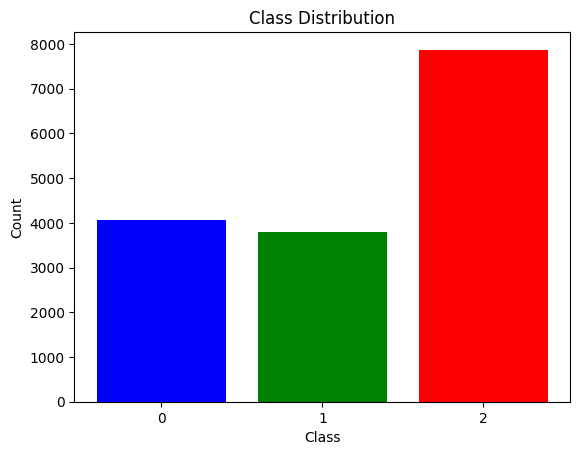

Is the dataset balanced? No


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# Function to visualize class distribution
def visualize_class_distribution(directory_path):
    class_counts = [0, 0, 0]  # Counts for '0', '1', and '2'

    for i in range(3):
        # Iterate through each .txt file in the directory
        for filename in tqdm(os.listdir(directory_path[i]), desc="counting labels..."):
            if filename.endswith(".txt"):
                file_path = os.path.join(directory_path[i], filename)

                # Read the content of the .txt file
                with open(file_path, 'r') as file:
                    content = file.read().strip()

                # Convert the content to an integer (assuming it's '0', '1', or '2')
                class_index = int(content)
                class_counts[class_index] += 1

    classes = ['0', '1', '2']

    # Plotting
    plt.bar(classes, class_counts, color=['blue', 'green', 'red'])
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

    return class_counts

# Specify the directory path where .txt files are located
directory_path = []
directory_path.extend([bird_label_path])
directory_path.extend([drone_label_path])
directory_path.extend([other_label_path])
directory_path

# Visualize class distribution
class_counts = visualize_class_distribution(directory_path)

# Check if the dataset is balanced
is_balanced = all(count == class_counts[0] for count in class_counts[1:])
print(f"Is the dataset balanced? {'Yes' if is_balanced else 'No'}")


## Showcasing 5 random images
### Prompt:
Great. now I need you to plot 5 random images from each class, just for showcase purpose

:)...: 3it [02:01, 40.59s/it]


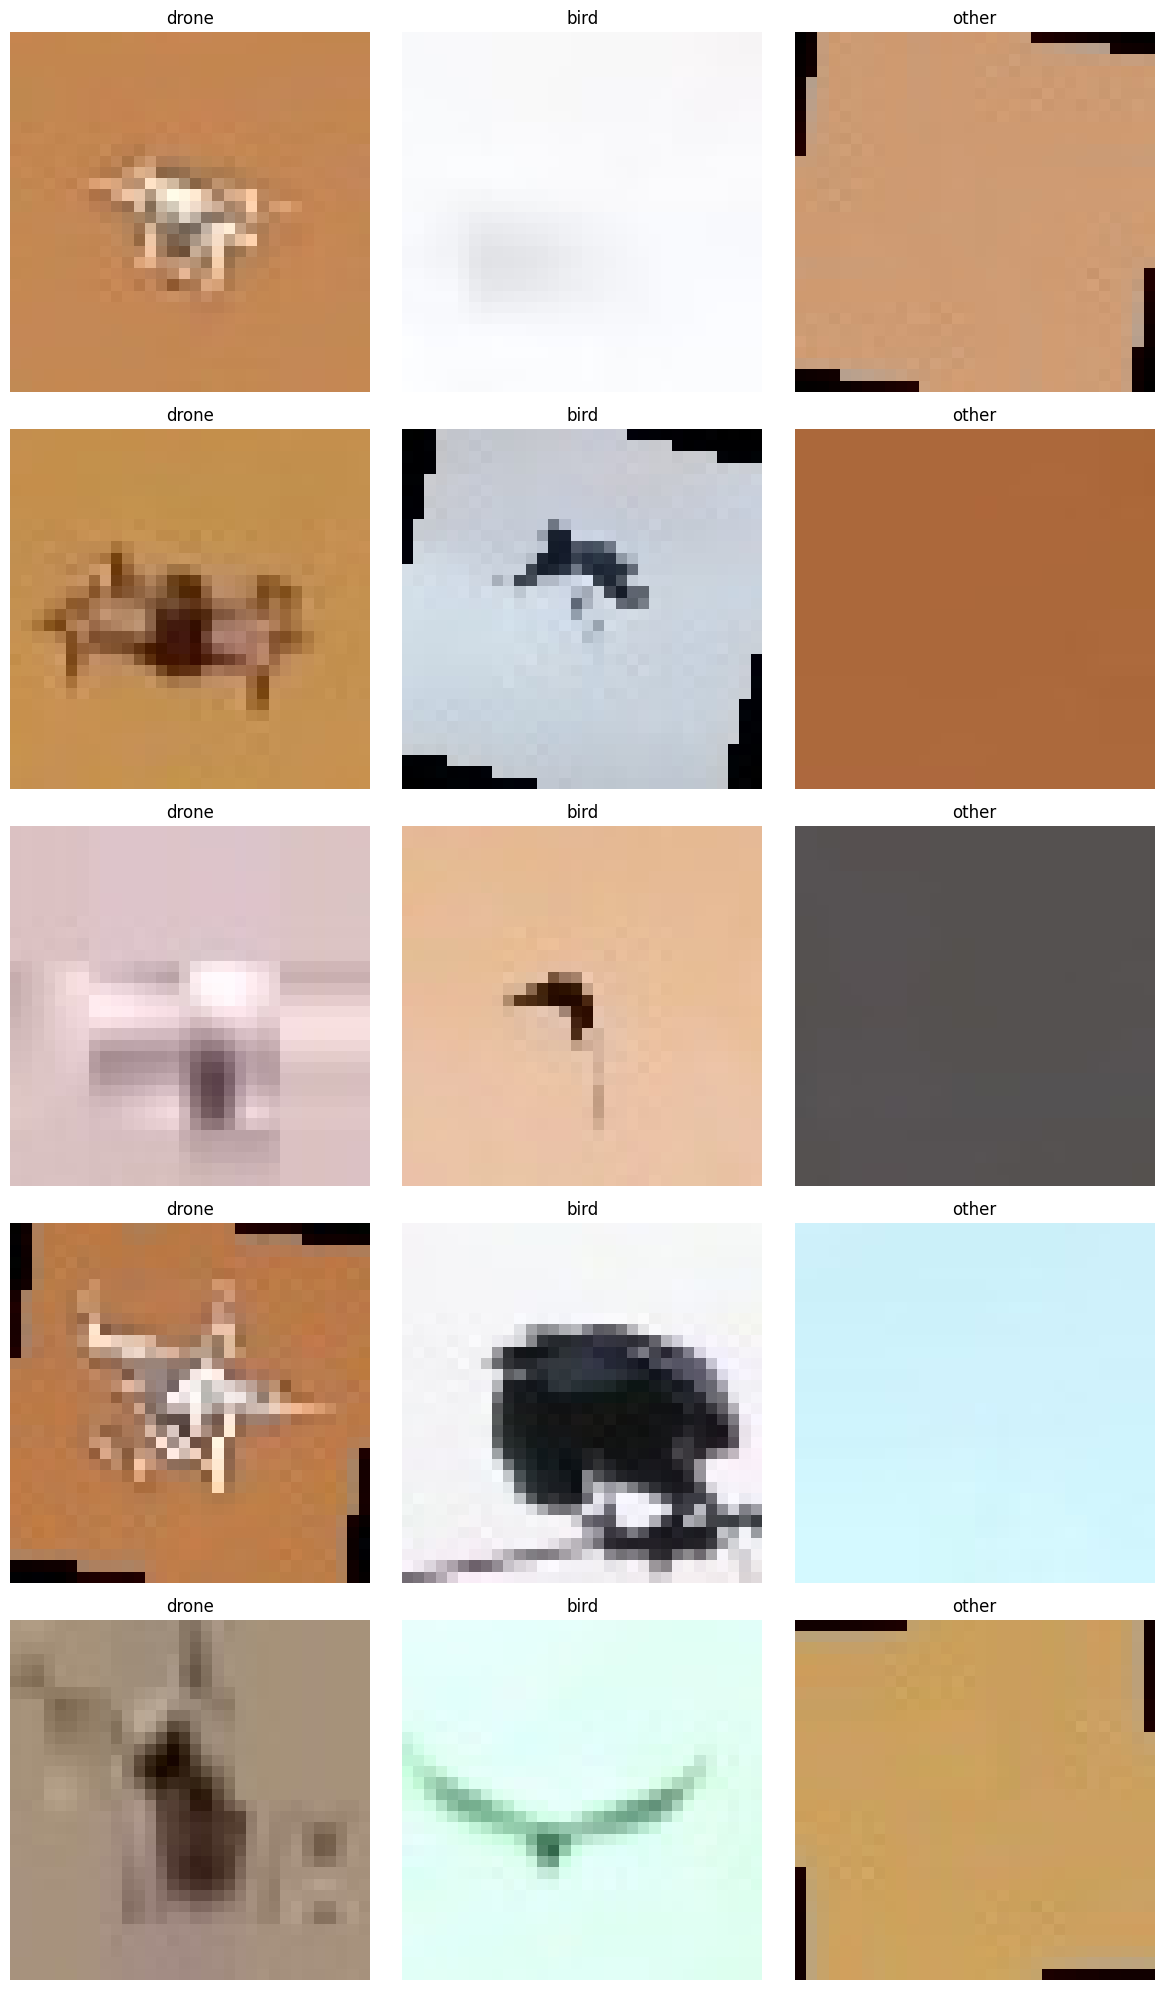

In [3]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# Function to display random images from each category in a grid
def display_random_images(category_paths, num_images_per_category=5):
    num_categories = len(category_paths)
    num_cols = 3
    num_rows = num_images_per_category

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

    for col_index, category_path in tqdm(enumerate(category_paths), desc=":)..."):
        image_files = os.listdir(category_path)
        category_name = os.path.split(category_path)[0]
        category_name = os.path.split(category_name)[1]

        # Randomly select num_images_per_category images
        selected_images = random.sample(image_files, num_images_per_category)

        for row_index, image_file in enumerate(selected_images):
            image_path = os.path.join(category_path, image_file)

            # Load and display the image using matplotlib
            image = mpimg.imread(image_path)
            axes[row_index, col_index].imshow(image)
            axes[row_index, col_index].set_title(category_name)
            axes[row_index, col_index].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Specify the paths of the three categories
drone_category_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/drone/images'
bird_category_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/bird/images'
other_category_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/other/images'

# Display random images from each category in a grid
display_random_images([drone_category_path, bird_category_path, other_category_path], num_images_per_category=5)


## Splitting DS into train and test
### Prompt:
Great. Now I need you to split our dataset into train and test sets

In [4]:
from tqdm import tqdm

# Paths for Drone class
drone_image_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/drone/images'
drone_label_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/drone/labels'

# Paths for Bird class
bird_image_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/bird/images'
bird_label_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/bird/labels'

# Paths for Other class
other_image_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/other/images'
other_label_path = '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/other/labels'

# Function to load and preprocess images
def load_and_preprocess_images(image_paths):
    images = [plt.imread(img_path) for img_path in tqdm(image_paths, desc="loading images...")]
    images = np.array(images)
    # Add any additional preprocessing steps here if needed
    return images

# Function to create train and test datasets
def create_train_test_datasets(image_path, label_path, test_percentage=0.2, seed=None):
    image_files = os.listdir(image_path)
    label_files = os.listdir(label_path)

    # Ensure the files are sorted to maintain consistency
    image_files.sort()
    label_files.sort()

    # Combine image and label paths
    image_paths = [os.path.join(image_path, img) for img in image_files]
    label_paths = [os.path.join(label_path, label) for label in label_files]

    # Combine image and label paths into pairs
    data = list(zip(image_paths, label_paths))

    # Set seed for reproducibility
    random.seed(seed)

    # Shuffle the data
    random.shuffle(data)

    # Calculate the index for splitting the data into train and test sets
    split_index = int(len(data) * (1 - test_percentage))

    # Split the data into train and test sets
    train_data = data[:split_index]
    test_data = data[split_index:]

    # Extract image and label paths from train and test sets
    train_image_paths, train_label_paths = zip(*train_data)
    test_image_paths, test_label_paths = zip(*test_data)

    # Load and preprocess images
    train_images = load_and_preprocess_images(train_image_paths)
    test_images = load_and_preprocess_images(test_image_paths)

    # Convert labels to numpy arrays
    train_labels = np.array(train_label_paths)
    test_labels = np.array(test_label_paths)

    return train_images, train_labels, test_images, test_labels

# Create datasets for Drone class
drone_train_images, drone_train_labels, drone_test_images, drone_test_labels = create_train_test_datasets(drone_image_path, drone_label_path)

# Create datasets for Bird class
bird_train_images, bird_train_labels, bird_test_images, bird_test_labels = create_train_test_datasets(bird_image_path, bird_label_path)

# Create datasets for Other class
other_train_images, other_train_labels, other_test_images, other_test_labels = create_train_test_datasets(other_image_path, other_label_path)

# Combine the datasets for all classes into unified train and test datasets
train_images = np.concatenate((drone_train_images, bird_train_images, other_train_images), axis=0)
train_labels = np.concatenate((drone_train_labels, bird_train_labels, other_train_labels), axis=0)
test_images = np.concatenate((drone_test_images, bird_test_images, other_test_images), axis=0)
test_labels = np.concatenate((drone_test_labels, bird_test_labels, other_test_labels), axis=0)

loading images...: 100%|██████████| 1575/1575 [00:02<00:00, 778.27it/s]


# Convert labels from class nums to one-hot encoding

In [5]:
from tensorflow.keras.utils import to_categorical

# Function to load numerical labels from label files
def load_numerical_labels(label_paths):
    numerical_labels = []
    for label_path in tqdm(label_paths, desc="converting to numberical..."):
        with open(label_path, 'r') as label_file:
            numerical_label = int(label_file.read().strip())
            numerical_labels.append(numerical_label)
    return numerical_labels

# Load numerical labels for training and test sets
train_numerical_labels = load_numerical_labels(train_labels)
test_numerical_labels = load_numerical_labels(test_labels)

# Convert numerical labels to one-hot encoding
train_labels_one_hot = to_categorical(train_numerical_labels, num_classes=3)
test_labels_one_hot = to_categorical(test_numerical_labels, num_classes=3)

converting to numberical...: 100%|██████████| 3150/3150 [14:27<00:00,  3.63it/s]


# Convert to TF Dataset


In [12]:
import tensorflow as tf

# Define batch size
batch_size = 16

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels_one_hot))

# Shuffle and batch the training dataset
train_dataset = train_dataset.shuffle(buffer_size=len(train_images), seed=42)
train_dataset = train_dataset.batch(batch_size=batch_size)

# Batch the test dataset
test_dataset = test_dataset.batch(batch_size=batch_size)

# Print the shapes of a batch from the datasets
for images, labels in train_dataset.take(1):
    print("Train Batch - Images Shape:", images.shape, "Labels Shape:", labels.shape)

for images, labels in test_dataset.take(1):
    print("Test Batch - Images Shape:", images.shape, "Labels Shape:", labels.shape)

Train Batch - Images Shape: (16, 32, 32, 3) Labels Shape: (16, 3)
Test Batch - Images Shape: (16, 32, 32, 3) Labels Shape: (16, 3)


# Building and training the network
## Model set up
### Prompt:
Perfect. Now it's time to use Keras and build a Convolutional Neural Network. Make sure the input layer has the right shape for our data, and make sure the output layer has 3 perceptrons (one for each possible class).
### Prompt 2:
Change it so that the input layer is already a Conv2D layer and don't forget the MaxPool layer after the input layer as well

In [13]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential()

# Input layer with Conv2D and MaxPooling2D
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional layers
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))

# Output layer with 3 perceptrons (for each class)
model.add(layers.Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 128)        

## Train
### Prompt:
Great. Now let's train this network on the dataset we have previously created. Print out the test accuracy when training is over

In [17]:
# Set the number of epochs
epochs = 20

# Train the model using the train_dataset
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/20
787/787 [==============================] - 8s 9ms/step - loss: 0.0821 - accuracy: 0.9794 - val_loss: 0.1211 - val_accuracy: 0.9683
Epoch 2/20
787/787 [==============================] - 4s 5ms/step - loss: 0.0689 - accuracy: 0.9817 - val_loss: 0.1441 - val_accuracy: 0.9590
Epoch 3/20
787/787 [==============================] - 4s 5ms/step - loss: 0.0608 - accuracy: 0.9823 - val_loss: 0.1018 - val_accuracy: 0.9698
Epoch 4/20
787/787 [==============================] - 5s 7ms/step - loss: 0.0483 - accuracy: 0.9867 - val_loss: 0.1288 - val_accuracy: 0.9673
Epoch 5/20
787/787 [==============================] - 4s 5ms/step - loss: 0.0732 - accuracy: 0.9780 - val_loss: 0.1352 - val_accuracy: 0.9651
Epoch 6/20
787/787 [==============================] - 5s 6ms/step - loss: 0.0522 - accuracy: 0.9854 - val_loss: 0.1943 - val_accuracy: 0.9565
Epoch 7/20
787/787 [==============================] - 4s 5ms/step - loss: 0.1260 - accuracy: 0.9679 - val_loss: 0.1661 - val_accuracy: 0.9635
Epoch 

# Results
## Plotting accuracy, loss and confusion matrix
### Prompt:
Perfect. Finally, let's plot the accuracy and loss graphs. Also, make sure to plot the confusion matrix

In [36]:
print(test_labels)
test_true_labels = np.argmax(test_labels, axis=0).flatten()
print(test_true_labels)
print(test_true_labels.shape)

['/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/drone/labels/DJI_FPV_Sunny (496).txt'
 '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/drone/labels/DJI_FPV_Cloudy (674).txt'
 '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/drone/labels/video1365.txt'
 ...
 '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/other/labels/MAVIC_Air_Cloudy (780).txt'
 '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/other/labels/31_65.txt'
 '/content/drive/MyDrive/Learning/Road2_AI_Course/task7_ds/other/labels/12_700.txt']
[1777]
(1,)


99/99 [==============================] - 0s 2ms/step


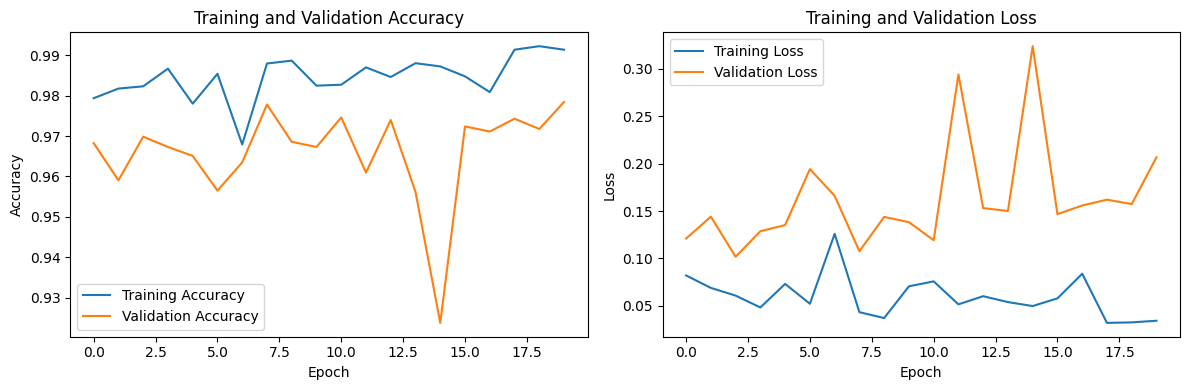

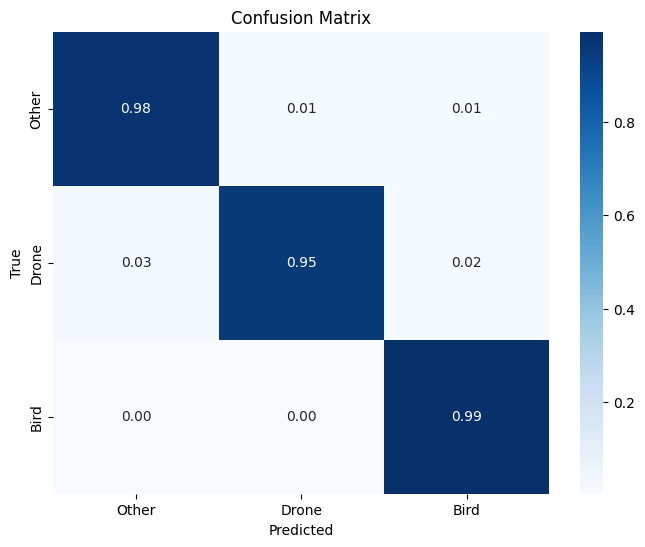

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot accuracy and loss graphs
def plot_accuracy_loss(history):
    # Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    # Ensure y_true and y_pred have the same number of samples
    if len(y_true) != len(y_pred):
        raise ValueError("Number of samples in y_true and y_pred must be the same.")

    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Convert one-hot encoded labels back to class indices
test_predictions = np.argmax(model.predict(test_images), axis=1).flatten()
test_true_labels = np.argmax(test_labels_one_hot, axis=1).flatten()

# Plot accuracy and loss graphs
plot_accuracy_loss(history)

# Plot confusion matrix
class_names = ['Other', 'Drone', 'Bird']
plot_confusion_matrix(test_true_labels, test_predictions, class_names)
